Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break

Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2,

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= 1.1
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.5,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            Threshold = y_preds.iloc[:, 1].median()
            
        logger.info(f"Threshold: {Threshold}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        prob_quant = y_prob.probability.quantile(0.3)
        high_conf_0 = min(y_prob.probability.min()*30, prob_quant)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(f"30th percentail: {prob_quant:.5f}")
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target) * 1.1
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.95: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    return X, y

In [16]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [24]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [26]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [27]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [28]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [29]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [30]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [31]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [32]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [33]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [34]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [35]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True, random_state=SEED)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)

In [36]:
std_values_g = scaler.fit_transform(data[g_list])
std_values_c = scaler.fit_transform(data[c_list])
std_values_d_g = scaler.fit_transform(data[d_g_list])
std_values_d_c = scaler.fit_transform(data[d_c_list])

In [37]:
std_df = pd.DataFrame()
std_data_list = [std_values_g, std_values_c, std_values_d_g, std_values_d_c]

for d in std_data_list:
    tmp_df = pd.DataFrame(d)
    std_df = pd.concat([std_df, tmp_df], axis=1)

std_df.columns = data.columns[4:]
std_df

,g-1,g-2,g-4,g-5,g-6,g-8,g-9,g-10,g-12,g-13,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,0.902172,-0.417928,-0.255198,-1.021257,-1.371657,0.683825,-0.315954,1.525976,0.622595,-0.559546,...,0.166464,-0.047157,0.356118,0.254925,0.221463,0.768262,-0.172179,0.661100,0.206949,0.529576
1,0.503594,-1.413294,1.394215,0.689482,0.083469,-0.225074,0.336762,-0.005682,0.902689,-1.284593,...,0.621597,0.441933,0.639382,1.125774,0.932842,-0.657263,1.156755,0.460677,0.368968,1.402038
2,0.307864,-0.942525,-0.864799,-0.296645,-1.780005,-1.433977,-0.455334,-0.691403,-0.918498,-1.514717,...,-0.481770,0.245159,0.318783,-0.453759,-0.142431,-0.067668,0.009664,0.745362,0.799529,0.607561
3,-1.987260,-0.789127,-1.449170,0.788455,0.510059,-0.704587,0.133518,-0.371747,-0.617755,1.796462,...,0.252156,0.008782,0.271046,-0.297428,-0.502756,-0.490210,0.348196,-0.104462,0.074511,-1.054858
4,-2.256745,-0.215305,0.702315,-0.099747,1.435980,-1.452374,-1.819060,-1.640351,-1.421064,0.046436,...,-1.071160,-0.943852,-0.556514,-1.029010,-1.413140,-0.905659,-1.180559,-1.333683,-1.178573,-0.606394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,-0.003006,-1.393118,-0.242204,0.493547,0.668228,1.088430,-0.395204,-0.302197,1.247505,0.222094,...,0.265508,0.798673,-0.880888,0.864657,-0.634000,0.771444,-0.084646,1.206257,-0.387355,-0.848908
27792,-0.382007,-0.107087,0.899984,-1.345144,-0.729877,1.982485,-1.906020,1.289177,-1.581719,-1.091354,...,-0.680917,-1.417814,-1.019211,-0.917534,-0.641262,-1.999670,-1.779991,-1.130070,-0.818585,-1.350782
27793,0.730381,-0.292794,-0.838697,0.104717,0.885125,-0.155813,0.862497,0.173212,-1.277636,-0.628052,...,0.616684,5.199338,1.371942,0.417515,0.329121,-0.986132,-0.557557,-0.861763,0.403634,-0.717156
27794,1.175328,0.311021,0.262887,-1.417591,-1.501861,-0.544565,1.031509,0.056246,-0.471420,0.134645,...,-0.876642,-1.094268,-1.148712,-0.836021,-0.605464,1.177821,-0.731515,-1.278072,-0.778312,-1.287356


In [38]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.537808,-0.428793,-1.460634,-0.781762,-1.408751,-0.323185,0.523680,-1.512932,1.092831,-0.280717,...,-0.375629,0.171294,0.061075,1.095997,-0.443504,-1.554270,-0.064027,0.544500,-1.192117,1.949751
1,1.222987,0.663244,0.063447,-0.661598,0.618135,-1.450879,-0.708146,0.673148,-1.906507,0.118571,...,0.527328,0.686472,-0.328048,0.690790,0.143350,-0.328257,-0.579367,-0.714366,1.173143,0.623573
2,0.444952,0.630297,-1.046723,0.392337,-0.180094,0.134641,-0.506573,-1.752362,2.300769,-0.088246,...,0.744961,-0.360596,0.242337,-1.003569,-0.093915,-0.734798,-0.664178,0.803958,-1.702096,-0.409620
3,0.986027,0.819337,-0.704689,0.566680,-0.989899,0.315321,-0.234707,1.001049,1.860530,-1.822445,...,-0.432111,2.078093,-0.285246,-0.336073,0.703510,0.459908,0.098336,0.080379,1.314211,-0.995440
4,-1.718468,-1.381426,1.645208,-0.979754,1.166494,-2.267350,-0.063401,-1.090806,5.199338,5.199338,...,1.636739,-1.756458,1.273340,-1.426962,0.812800,0.051062,-0.635663,1.743649,1.266699,-0.964774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.311480,-0.392341,0.230434,0.302113,0.191584,-1.360177,-0.258082,0.742828,-0.798018,-0.402505,...,-0.978535,-0.661162,-0.543823,0.348232,-1.216160,0.252592,-0.716271,-0.863011,0.112922,-0.770699
27792,-1.367878,1.246595,0.350119,-1.120388,1.777321,-2.247776,-0.959592,1.582357,1.664082,0.928999,...,0.807408,-1.790158,2.009341,1.010962,1.316182,-0.215690,0.797765,0.957014,-1.073951,-1.649404
27793,-1.321360,0.036252,0.075271,0.893461,1.352734,1.023747,0.667583,-1.746777,-5.199338,-2.197043,...,-0.808857,-0.062633,0.791348,-1.218697,-1.146835,1.414272,0.917835,0.218000,0.679229,-0.890473
27794,-0.980018,-0.377338,-0.989787,0.296249,-1.381364,1.009238,0.038999,-1.619039,-0.553998,1.066525,...,1.113712,0.987803,-0.661013,1.314523,1.228781,0.846835,0.764710,-0.433706,-0.344559,-0.925413


In [39]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [40]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [41]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=10, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 10)


In [42]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=10, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 386)
(27796, 45)
(27796, 436)
(27796, 45)
*************
(27796, 10)
(27796, 10)
(27796, 10)
(27796, 10)


In [43]:
# PCA for all categories
pca_transformer = PCA(n_components=10, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 10)
(27796, 10)
(27796, 10)
(27796, 10)
(27796, 10)
(27796, 10)
(27796, 10)


In [44]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [45]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_c_d_c_4',
 'pca_umap_c_d_c_5',
 'pca_umap_c_d_c_6',
 'pca_umap_c_d_c_7',
 'pca_umap_c_d_c_8',
 'pca_umap_c_d_c_9',
 'pca_umap_c_d_c_10',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_c_4',
 'pca_umap_c_5',
 'pca_umap_c_6',
 'pca_umap_c_7',
 'pca_umap_c_8',
 'pca_umap_c_9',
 'pca_umap_c_10',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_u

In [46]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.407521,-0.709016,-0.789524,0.193115,-0.940357,-0.248165,-0.096644,-0.535392,1.030522,-0.307352,...,-0.970063,0.625858,0.735990,-0.958423,-2.575820,0.207691,-0.289368,-1.337494,1.010227,0.906854
1,0.880794,-0.358281,-0.798451,0.370793,-0.801259,-0.265377,0.042133,-0.031489,0.587283,-0.347970,...,-1.176000,0.294733,0.131242,-0.298397,-2.916964,0.226614,-0.633921,-1.262663,0.945089,0.420597
2,0.263274,-0.817201,-0.723625,0.040507,-0.740532,-0.313922,0.050307,-0.677941,1.087016,-0.133676,...,-1.389564,0.610079,0.892806,-0.954905,-2.703170,-0.247381,0.591831,-1.734699,0.608306,-0.053827
3,0.305899,-0.861313,-0.907472,0.201528,-0.830427,-0.298685,0.001814,-0.703946,1.202767,-0.279915,...,-1.390140,0.702905,0.741090,-0.883225,-2.710195,-0.611244,0.542154,-1.776281,0.358480,0.090726
4,1.382545,-0.501501,-0.334243,-0.508717,0.289860,1.098103,-0.069136,0.893827,0.817812,2.206980,...,0.259928,0.930252,2.182420,-1.617381,-1.780664,1.639357,-1.816652,-0.286034,0.904704,0.670936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.606481,-0.804925,-0.734786,0.279399,-1.064776,-0.176232,-0.002970,-0.516052,1.110731,-0.454786,...,-0.323792,0.533734,0.154549,-0.357207,-3.193959,-0.655343,-0.376975,-0.867289,0.615055,0.088441
27792,0.678042,-0.816700,-0.560564,0.165293,-1.143922,-0.142498,-0.076358,-0.282817,1.140709,-0.596164,...,1.406064,-0.464511,0.770410,-0.265815,-2.204613,0.871740,0.376543,-1.503267,-0.897507,0.901375
27793,0.444939,-1.916098,0.000274,0.315555,-0.108604,-0.180239,-0.213698,-0.198019,0.466790,-0.549644,...,0.426878,-0.063244,0.327177,0.958304,0.328031,0.560082,1.545760,-2.929633,3.596455,0.180855
27794,0.581603,-0.748153,-0.602118,0.181873,-1.021180,-0.171694,-0.128096,-0.506016,1.215976,-0.486243,...,-0.013444,0.351495,0.554680,-0.422475,-3.147918,-0.765414,-0.575490,-1.528467,-0.010361,0.434009


In [47]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.407521,-0.709016,-0.789524,0.193115,-0.940357,-0.248165,...,-0.970063,0.625858,0.735990,-0.958423,-2.575820,0.207691,-0.289368,-1.337494,1.010227,0.906854
1,id_001762a82,1,0,0,0.880794,-0.358281,-0.798451,0.370793,-0.801259,-0.265377,...,-1.176000,0.294733,0.131242,-0.298397,-2.916964,0.226614,-0.633921,-1.262663,0.945089,0.420597
2,id_00762e877,1,0,0,0.263274,-0.817201,-0.723625,0.040507,-0.740532,-0.313922,...,-1.389564,0.610079,0.892806,-0.954905,-2.703170,-0.247381,0.591831,-1.734699,0.608306,-0.053827
3,id_0079af0fb,0,0,0,0.305899,-0.861313,-0.907472,0.201528,-0.830427,-0.298685,...,-1.390140,0.702905,0.741090,-0.883225,-2.710195,-0.611244,0.542154,-1.776281,0.358480,0.090726
4,id_0079d45d3,1,0,0,1.382545,-0.501501,-0.334243,-0.508717,0.289860,1.098103,...,0.259928,0.930252,2.182420,-1.617381,-1.780664,1.639357,-1.816652,-0.286034,0.904704,0.670936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.606481,-0.804925,-0.734786,0.279399,-1.064776,-0.176232,...,-0.323792,0.533734,0.154549,-0.357207,-3.193959,-0.655343,-0.376975,-0.867289,0.615055,0.088441
27792,id_fce497048,1,1,1,0.678042,-0.816700,-0.560564,0.165293,-1.143922,-0.142498,...,1.406064,-0.464511,0.770410,-0.265815,-2.204613,0.871740,0.376543,-1.503267,-0.897507,0.901375
27793,id_fd75349b2,1,1,1,0.444939,-1.916098,0.000274,0.315555,-0.108604,-0.180239,...,0.426878,-0.063244,0.327177,0.958304,0.328031,0.560082,1.545760,-2.929633,3.596455,0.180855
27794,id_fed0f2fe0,1,1,1,0.581603,-0.748153,-0.602118,0.181873,-1.021180,-0.171694,...,-0.013444,0.351495,0.554680,-0.422475,-3.147918,-0.765414,-0.575490,-1.528467,-0.010361,0.434009


In [48]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [49]:
# Create feature based on feature importance with v24 notebook

#important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

important_col = ["pca_umap_g_2", "pca_umap_all_1", "pca_umap_g_d_g_8", "pca_umap_g_4", "pca_umap_all_10", "pca_umap_g_5", "pca_umap_all_9", "pca_umap_g_d_g_1"]

tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 112 columns



Removed 28 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_1_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_1_pca_umap_g_d_g_8_div,pca_umap_g_d_g_1_pca_umap_g_4_prd,pca_umap_g_d_g_1_pca_umap_g_4_div,pca_umap_g_d_g_1_pca_umap_all_10_prd,pca_umap_g_d_g_1_pca_umap_all_10_div,pca_umap_g_d_g_1_pca_umap_g_5_prd,pca_umap_g_d_g_1_pca_umap_g_5_div,pca_umap_g_d_g_1_pca_umap_all_9_prd,pca_umap_g_d_g_1_pca_umap_all_9_div
0,id_000644bb2,1,0,0,0.407521,-0.709016,-0.789524,0.193115,-0.940357,-0.248165,...,-0.095305,-0.0,-0.167107,-0.0,-0.039695,-0.0,0.129141,0.0,0.133093,0.0
1,id_001762a82,1,0,0,0.880794,-0.358281,-0.798451,0.370793,-0.801259,-0.265377,...,-0.057744,-1.0,-0.260777,-0.0,-0.101625,-1.0,0.259312,0.0,0.171517,0.0
2,id_00762e877,1,0,0,0.263274,-0.817201,-0.723625,0.040507,-0.740532,-0.313922,...,-0.104326,-1.0,-0.357951,-0.0,-0.046394,-3.0,0.145124,1.0,0.377261,0.0
3,id_0079af0fb,0,0,0,0.305899,-0.861313,-0.907472,0.201528,-0.830427,-0.298685,...,-0.048648,-2.0,-0.340565,-0.0,-0.082897,-1.0,0.226981,0.0,0.356201,0.0
4,id_0079d45d3,1,0,0,1.382545,-0.501501,-0.334243,-0.508717,0.289860,1.098103,...,0.078018,0.0,-0.047163,-1.0,0.405680,0.0,0.061545,1.0,0.150328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.606481,-0.804925,-0.734786,0.279399,-1.064776,-0.176232,...,0.069273,0.0,0.021504,0.0,0.030658,0.0,-0.015109,-0.0,-0.074877,-0.0
27792,id_fce497048,1,1,1,0.678042,-0.816700,-0.560564,0.165293,-1.143922,-0.142498,...,0.020574,0.0,0.010046,0.0,0.013383,0.0,-0.013383,-0.0,-0.025607,-0.0
27793,id_fd75349b2,1,1,1,0.444939,-1.916098,0.000274,0.315555,-0.108604,-0.180239,...,-0.007677,-0.0,-0.003764,-0.0,-0.004497,-0.0,0.005697,0.0,0.003819,0.0
27794,id_fed0f2fe0,1,1,1,0.581603,-0.748153,-0.602118,0.181873,-1.021180,-0.171694,...,0.077597,0.0,0.083120,0.0,0.041898,0.0,-0.098766,-0.0,-0.104777,-0.0


In [50]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 392 columns



Removed 224 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_all_9_pca_umap_g_4_std,pca_umap_all_9_pca_umap_all_10_std,pca_umap_all_9_pca_umap_g_5_std,pca_umap_g_d_g_1_pca_umap_g_2_std,pca_umap_g_d_g_1_pca_umap_all_1_std,pca_umap_g_d_g_1_pca_umap_g_d_g_8_std,pca_umap_g_d_g_1_pca_umap_g_4_std,pca_umap_g_d_g_1_pca_umap_all_10_std,pca_umap_g_d_g_1_pca_umap_g_5_std,pca_umap_g_d_g_1_pca_umap_all_9_std
0,id_000644bb2,1,0,0,0.407521,-0.709016,-0.789524,0.193115,-0.940357,-0.248165,...,1.643606,0.946020,0.021637,0.038684,0.196838,0.613122,1.006240,0.308654,0.615729,0.637366
1,id_001762a82,1,0,0,0.880794,-0.358281,-0.798451,0.370793,-0.801259,-0.265377,...,1.046659,0.661323,0.212568,0.061368,0.416304,0.346320,0.837899,0.452563,0.421328,0.208760
2,id_00762e877,1,0,0,0.263274,-0.817201,-0.723625,0.040507,-0.740532,-0.313922,...,1.497928,0.863159,0.472958,0.115201,0.059247,0.457964,0.974702,0.339933,0.050268,0.523226
3,id_0079af0fb,0,0,0,0.305899,-0.861313,-0.907472,0.201528,-0.830427,-0.298685,...,1.663638,1.048415,0.308533,0.102642,0.006893,0.325564,1.022563,0.407340,0.332541,0.641074
4,id_0079d45d3,1,0,0,1.382545,-0.501501,-0.334243,-0.508717,0.289860,1.098103,...,0.759708,0.982290,0.341528,0.382996,0.847629,0.170140,0.311406,1.430592,0.106774,0.448302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.606481,-0.804925,-0.734786,0.279399,-1.064776,-0.176232,...,1.010971,1.106987,0.626917,0.034801,0.476514,0.678964,0.177899,0.273915,0.206156,0.833073
27792,id_fce497048,1,1,1,0.678042,-0.816700,-0.560564,0.165293,-1.143922,-0.142498,...,1.123037,1.228155,0.385039,0.047080,0.495322,0.632203,0.300561,0.405678,0.437437,0.822476
27793,id_fd75349b2,1,1,1,0.444939,-1.916098,0.000274,0.315555,-0.108604,-0.180239,...,0.655384,0.718728,0.162244,0.060285,0.308833,0.669260,0.331099,0.394443,0.486529,0.324285
27794,id_fed0f2fe0,1,1,1,0.581603,-0.748153,-0.602118,0.181873,-1.021180,-0.171694,...,1.541929,1.203651,0.049331,0.157823,0.472185,0.575846,0.621175,0.282897,0.871423,0.920754


In [51]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_all_9_pca_umap_g_4_std,pca_umap_all_9_pca_umap_all_10_std,pca_umap_all_9_pca_umap_g_5_std,pca_umap_g_d_g_1_pca_umap_g_2_std,pca_umap_g_d_g_1_pca_umap_all_1_std,pca_umap_g_d_g_1_pca_umap_g_d_g_8_std,pca_umap_g_d_g_1_pca_umap_g_4_std,pca_umap_g_d_g_1_pca_umap_all_10_std,pca_umap_g_d_g_1_pca_umap_g_5_std,pca_umap_g_d_g_1_pca_umap_all_9_std
0,id_000644bb2,1,0,0,0.407521,-0.709016,-0.789524,0.193115,-0.940357,-0.248165,...,1.438368,0.946020,0.021637,0.038684,0.196838,0.613122,1.006240,0.308654,0.615729,0.637366
1,id_001762a82,1,0,0,0.880794,-0.358281,-0.798451,0.370793,-0.801259,-0.265377,...,1.046659,0.661323,0.212568,0.061368,0.416304,0.346320,0.837899,0.452563,0.421328,0.208760
2,id_00762e877,1,0,0,0.263274,-0.817201,-0.723625,0.040507,-0.740532,-0.313922,...,1.438368,0.863159,0.472958,0.115201,0.059247,0.457964,0.974702,0.339933,0.050268,0.523226
3,id_0079af0fb,0,0,0,0.305899,-0.861313,-0.907472,0.201528,-0.830427,-0.298685,...,1.438368,1.048415,0.308533,0.102642,0.006893,0.325564,1.022563,0.407340,0.332541,0.641074
4,id_0079d45d3,1,0,0,1.382545,-0.501501,-0.334243,-0.508717,0.289860,1.052800,...,0.759708,0.982290,0.341528,0.382996,0.847629,0.170140,0.311406,1.091750,0.106774,0.448302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.606481,-0.804925,-0.734786,0.279399,-1.064776,-0.176232,...,1.010971,1.106987,0.626917,0.034801,0.476514,0.678964,0.177899,0.273915,0.206156,0.833073
27792,id_fce497048,1,1,1,0.678042,-0.816700,-0.560564,0.165293,-1.143922,-0.142498,...,1.123037,1.228155,0.385039,0.047080,0.495322,0.632203,0.300561,0.405678,0.437437,0.822476
27793,id_fd75349b2,1,1,1,0.444939,-1.030387,0.000274,0.315555,-0.108604,-0.180239,...,0.655384,0.718728,0.162244,0.060285,0.308833,0.669260,0.331099,0.394443,0.486529,0.324285
27794,id_fed0f2fe0,1,1,1,0.581603,-0.748153,-0.602118,0.181873,-1.021180,-0.171694,...,1.438368,1.203651,0.049331,0.157823,0.472185,0.575846,0.621175,0.282897,0.871423,0.920754


In [52]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [53]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [54]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067394	valid_1's binary_logloss: 0.118085
[200]	training's binary_logloss: 0.0122851	valid_1's binary_logloss: 0.0518852
[300]	training's binary_logloss: 0.00420208	valid_1's binary_logloss: 0.0378419
[400]	training's binary_logloss: 0.00219632	valid_1's binary_logloss: 0.0304417
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00167908	valid_1's binary_logloss: 0.0284865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716078	valid_1's binary_logloss: 0.109306
[200]	training's binary_logloss: 0.0130771	valid_1's binary_logloss: 0.0376543
[300]	training's binary_logloss: 0.00426339	valid_1's binary_logloss: 0.023175
[400]	training's binary_logloss: 0.00230808	valid_1's binary_logloss: 0.0181625
[500]	training's binary_logloss: 0.00166055	valid_1's binary_logloss: 0.016347
Early stopping, best iteration is:
[508]	training's 

1 / 3 AUC score:1.000
Threshold: 0.5425344941101362
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00096
p_label_rate: 0.00226 Vs.target_rate: 0.00079, Num_p_label: 9.0, conf_0:0.00096, conf_1:0.56570
threshold:0.54, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656569	valid_1's binary_logloss: 0.106889
[200]	training's binary_logloss: 0.0121423	valid_1's binary_logloss: 0.0396822
[300]	training's binary_logloss: 0.00370941	valid_1's binary_logloss: 0.0230395
[400]	training's binary_logloss: 0.00205898	valid_1's binary_logloss: 0.0178957
[500]	training's binary_logloss: 0.00159994	valid_1's binary_logloss: 0.0160473
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0014722	valid_1's binary_logloss: 0.0153962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678236	valid_1's binary_logloss: 0.0994411
[200]	training's binary_logloss: 0.0125723	valid_1's binary_logloss: 0.0295767
[300]	training's binary_logloss: 0.00418993	valid_1's binary_logloss: 0.0146779
[400]	training's binary_logloss: 0.00226069	valid_1's binary_logloss: 0.0102005
[500]	training's binary_logloss: 0.00162357	valid

2 / 3 AUC score:1.000
Threshold: 0.5425344941101362
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/993
30th percentail: 0.00085
p_label_rate: 0.00276 Vs.target_rate: 0.00079, Num_p_label: 11.0, conf_0:0.00085, conf_1:0.56506
Num_p_label: 11.0, Expected: 3.1, Adj_threshold_1: 0.54
Num_p_label: 10.0, Expected: 3.1, Adj_threshold_2: 0.58
Num_p_label: 9.0, Expected: 3.1, Adj_threshold_3: 0.62
Num_p_label: 8.0, Expected: 3.1, Adj_threshold_4: 0.66
Num_p_label: 8.0, Expected: 3.1, Adj_threshold_5: 0.70
Num_p_label: 7.0, Expected: 3.1, Adj_threshold_6: 0.74
Num_p_label: 7.0, Expected: 3.1, Adj_threshold_7: 0.78
Num_p_label: 5.0, Expected: 3.1, Adj_threshold_8: 0.82
Num_p_label: 4.0, Expected: 3.1, Adj_threshold_9: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656516	valid_1's binary_logloss: 0.106047
[200]	training's binary_logloss: 0.0111686	valid_1's binary_logloss: 0.0336436
[300]	training's binary_logloss: 0.00372249	valid_1's binary_logloss: 0.018176
[400]	training's binary_logloss: 0.00206372	valid_1's binary_logloss: 0.0136064
[500]	training's binary_logloss: 0.00157534	valid_1's binary_logloss: 0.0118812
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00145855	valid_1's binary_logloss: 0.011347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689095	valid_1's binary_logloss: 0.0954033
[200]	training's binary_logloss: 0.0125354	valid_1's binary_logloss: 0.026724
[300]	training's binary_logloss: 0.00414916	valid_1's binary_logloss: 0.0138978
[400]	training's binary_logloss: 0.00225362	valid_1's binary_logloss: 0.00973743
Early stopping, best iteration is:
[460]	training'

3 / 3 AUC score:1.000
Threshold: 0.8625344941101365
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/991
30th percentail: 0.00105
p_label_rate: 0.00151 Vs.target_rate: 0.00079, Num_p_label: 6.0, conf_0:0.00105, conf_1:0.86253
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/4973, y_label_rate: 0.10054
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142519	valid_1's binary_logloss: 0.0262014
[200]	training's binary_logloss: 0.0018233	valid_1's binary_logloss: 0.0087614
[300]	training's binary_logloss: 0.000556411	valid_1's binary_logloss: 0.00511788
[400]	training's binary_logloss: 0.000316271	valid_1's binary_logloss: 0.00416825
[500]	training's binary_logloss: 0.000270439	valid_1's binary_logloss: 0.00397668
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000265331	valid_1's binary_logloss: 0.00394616


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142008	valid_1's binary_logloss: 0.0202944
[200]	training's binary_logloss: 0.00176414	valid_1's binary_logloss: 0.00669805
[300]	training's binary_logloss: 0.000540216	valid_1's binary_logloss: 0.00502259
[400]	training's binary_logloss: 0.000308303	valid_1's binary_logloss: 0.00471087
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000282784	valid_1's binary_logloss: 0.00462039


5-alpha_reductase_inhibitor logloss: 0.0042832072868493175
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716878	valid_1's binary_logloss: 0.119704
[200]	training's binary_logloss: 0.0132661	valid_1's binary_logloss: 0.0533312
[300]	training's binary_logloss: 0.00444114	valid_1's binary_logloss: 0.0380787
[400]	training's binary_logloss: 0.00243673	valid_1's binary_logloss: 0.0330933
[500]	training's binary_logloss: 0.00176447	valid_1's binary_logloss: 0.0308762
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0017128	valid_1's binary_logloss: 0.0306194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719584	valid_1's binary_logloss: 0.125231
[200]	training's binary_logloss: 0.013913	valid_1's binary_logloss: 0.0555977
[300]	training's binary_logloss: 0.00462518	valid_1's binary_logloss: 0.0377468
[400]	training's binary_logloss: 0.00251682	valid_1's binary_logloss: 0.0312449
Early stopping, best iteration is:
[460]	training's

1 / 3 AUC score:1.000
Threshold: 0.6143623121045854
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00755
p_label_rate: 0.00502 Vs.target_rate: 0.00083, Num_p_label: 20.0, conf_0:0.00748, conf_1:0.61436
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_1: 0.61
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_2: 0.65
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_3: 0.69
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_4: 0.73
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_5: 0.77
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_6: 0.81
threshold:0.81, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685321	valid_1's binary_logloss: 0.115656
[200]	training's binary_logloss: 0.0122253	valid_1's binary_logloss: 0.0485472
[300]	training's binary_logloss: 0.00414628	valid_1's binary_logloss: 0.0330821
[400]	training's binary_logloss: 0.00234	valid_1's binary_logloss: 0.0279178
[500]	training's binary_logloss: 0.00172515	valid_1's binary_logloss: 0.0256837
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00163214	valid_1's binary_logloss: 0.0250204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695139	valid_1's binary_logloss: 0.118508
[200]	training's binary_logloss: 0.0129339	valid_1's binary_logloss: 0.0441393
[300]	training's binary_logloss: 0.00432598	valid_1's binary_logloss: 0.0281298
[400]	training's binary_logloss: 0.00237458	valid_1's binary_logloss: 0.0235552
Early stopping, best iteration is:
[469]	training's 

2 / 3 AUC score:1.000
Threshold: 0.8143623121045855
Remove_noisy_labels: 7 → positive_corect_labels: 492.0/985
30th percentail: 0.00611
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00611, conf_1:0.81436
threshold:0.81, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:492.0/985, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687615	valid_1's binary_logloss: 0.111116
[200]	training's binary_logloss: 0.0124737	valid_1's binary_logloss: 0.0422072
[300]	training's binary_logloss: 0.00415561	valid_1's binary_logloss: 0.0248444
[400]	training's binary_logloss: 0.00234161	valid_1's binary_logloss: 0.0186977
[500]	training's binary_logloss: 0.00174359	valid_1's binary_logloss: 0.0163053
[600]	training's binary_logloss: 0.00154835	valid_1's binary_logloss: 0.0153721
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00153302	valid_1's binary_logloss: 0.0152513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645101	valid_1's binary_logloss: 0.120131
[200]	training's binary_logloss: 0.0114111	valid_1's binary_logloss: 0.0546719
[300]	training's binary_logloss: 0.00384526	valid_1's binary_logloss: 0.0383831
[400]	training's binary_logloss: 0.00217802	valid

3 / 3 AUC score:1.000
Threshold: 0.8143623121045855
Remove_noisy_labels: 10 → positive_corect_labels: 482.0/975
30th percentail: 0.00681
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00660, conf_1:0.81436
threshold:0.81, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/4957, y_label_rate: 0.09865
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148953	valid_1's binary_logloss: 0.0238208
[200]	training's binary_logloss: 0.00197464	valid_1's binary_logloss: 0.0122466


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00115064	valid_1's binary_logloss: 0.011548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013847	valid_1's binary_logloss: 0.0320161
[200]	training's binary_logloss: 0.00174919	valid_1's binary_logloss: 0.0182431


11-beta-hsd1_inhibitor logloss: 0.01412121901290554
acat_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000648829	valid_1's binary_logloss: 0.0166955


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086526	valid_1's binary_logloss: 0.147867
[200]	training's binary_logloss: 0.0180049	valid_1's binary_logloss: 0.068082
[300]	training's binary_logloss: 0.0059647	valid_1's binary_logloss: 0.048511
[400]	training's binary_logloss: 0.00315266	valid_1's binary_logloss: 0.0430749
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00279871	valid_1's binary_logloss: 0.0419325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899586	valid_1's binary_logloss: 0.192294
[200]	training's binary_logloss: 0.0178585	valid_1's binary_logloss: 0.103736
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0100397	valid_1's binary_logloss: 0.0898662


1 / 3 AUC score:0.997
Threshold: 0.38758577611355616
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentail: 0.00769
p_label_rate: 0.00251 Vs.target_rate: 0.00111, Num_p_label: 10.0, conf_0:0.00769, conf_1:0.51478
threshold:0.39, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824665	valid_1's binary_logloss: 0.142086
[200]	training's binary_logloss: 0.0163073	valid_1's binary_logloss: 0.0632937
[300]	training's binary_logloss: 0.00542657	valid_1's binary_logloss: 0.0428198
[400]	training's binary_logloss: 0.00285655	valid_1's binary_logloss: 0.0367385
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00228161	valid_1's binary_logloss: 0.0340233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078441	valid_1's binary_logloss: 0.148634
[200]	training's binary_logloss: 0.0158763	valid_1's binary_logloss: 0.0720605
[300]	training's binary_logloss: 0.00523996	valid_1's binary_logloss: 0.0511219


2 / 3 AUC score:0.999
Threshold: 0.38758577611355616
Remove_noisy_labels: 15 → positive_corect_labels: 481.0/959
30th percentail: 0.00296
p_label_rate: 0.00276 Vs.target_rate: 0.00111, Num_p_label: 11.0, conf_0:0.00296, conf_1:0.59452
threshold:0.39, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00302954	valid_1's binary_logloss: 0.0462288


positive y_label:481.0/959, y_label_rate: 0.50156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797454	valid_1's binary_logloss: 0.129973
[200]	training's binary_logloss: 0.0160147	valid_1's binary_logloss: 0.0503121
[300]	training's binary_logloss: 0.00534884	valid_1's binary_logloss: 0.0303971
[400]	training's binary_logloss: 0.00285142	valid_1's binary_logloss: 0.024122
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00247303	valid_1's binary_logloss: 0.022935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761222	valid_1's binary_logloss: 0.151188
[200]	training's binary_logloss: 0.014015	valid_1's binary_logloss: 0.0707006
[300]	training's binary_logloss: 0.00461872	valid_1's binary_logloss: 0.0470818


3 / 3 AUC score:1.000
Threshold: 0.38758577611355616
Remove_noisy_labels: 10 → positive_corect_labels: 475.0/949
30th percentail: 0.00520
p_label_rate: 0.00276 Vs.target_rate: 0.00111, Num_p_label: 11.0, conf_0:0.00520, conf_1:0.59624
threshold:0.39, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00265063	valid_1's binary_logloss: 0.0405313


positive y_label:486.0/4931, y_label_rate: 0.09856
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149242	valid_1's binary_logloss: 0.0257162
[200]	training's binary_logloss: 0.00207304	valid_1's binary_logloss: 0.00925663
[300]	training's binary_logloss: 0.000671413	valid_1's binary_logloss: 0.00560305
[400]	training's binary_logloss: 0.000374511	valid_1's binary_logloss: 0.00440837


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00031106	valid_1's binary_logloss: 0.00412674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014407	valid_1's binary_logloss: 0.0274446
[200]	training's binary_logloss: 0.0018735	valid_1's binary_logloss: 0.0127022
[300]	training's binary_logloss: 0.000593054	valid_1's binary_logloss: 0.0100107


acat_inhibitor logloss: 0.006892819679721343
acetylcholine_receptor_agonist , len(trt) : 190


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000457675	valid_1's binary_logloss: 0.00966002


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239452	valid_1's binary_logloss: 0.510269
[200]	training's binary_logloss: 0.100212	valid_1's binary_logloss: 0.449276
[300]	training's binary_logloss: 0.0461031	valid_1's binary_logloss: 0.422824
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0444294	valid_1's binary_logloss: 0.421272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233478	valid_1's binary_logloss: 0.545527


1 / 3 AUC score:0.859
Threshold: 0.5105720888910175
Remove_noisy_labels: 214 → positive_corect_labels: 393/786
30th percentail: 0.35055
p_label_rate: 0.29834 Vs.target_rate: 0.00878, Num_p_label: 1188.0, conf_0:0.35055, conf_1:0.51057
Num_p_label: 1188.0, Expected: 34.9, Adj_threshold_1: 0.51
Num_p_label: 854.0, Expected: 34.9, Adj_threshold_2: 0.55
Num_p_label: 587.0, Expected: 34.9, Adj_threshold_3: 0.59
Num_p_label: 377.0, Expected: 34.9, Adj_threshold_4: 0.63
Num_p_label: 205.0, Expected: 34.9, Adj_threshold_5: 0.67
Num_p_label: 99.0, Expected: 34.9, Adj_threshold_6: 0.71
Num_p_label: 49.0, Expected: 34.9, Adj_threshold_7: 0.75
threshold:0.75, positive p_label:49.0/3982, p_label_rate: 0.01231


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.111321	valid_1's binary_logloss: 0.51053


positive y_label:393.0/786, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188946	valid_1's binary_logloss: 0.422962
[200]	training's binary_logloss: 0.0689621	valid_1's binary_logloss: 0.335312
[300]	training's binary_logloss: 0.0296	valid_1's binary_logloss: 0.310533
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0226583	valid_1's binary_logloss: 0.30558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193903	valid_1's binary_logloss: 0.378379
[200]	training's binary_logloss: 0.0738785	valid_1's binary_logloss: 0.288388
[300]	training's binary_logloss: 0.0318699	valid_1's binary_logloss: 0.246506


2 / 3 AUC score:0.962
Threshold: 0.7505720888910177
Remove_noisy_labels: 84 → positive_corect_labels: 325.0/702
30th percentail: 0.37327
p_label_rate: 0.12858 Vs.target_rate: 0.00878, Num_p_label: 512.0, conf_0:0.37327, conf_1:0.75057
Num_p_label: 512.0, Expected: 34.9, Adj_threshold_1: 0.75


[400]	training's binary_logloss: 0.0163025	valid_1's binary_logloss: 0.221131
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0158588	valid_1's binary_logloss: 0.220449


Num_p_label: 349.0, Expected: 34.9, Adj_threshold_2: 0.79
Num_p_label: 216.0, Expected: 34.9, Adj_threshold_3: 0.83
Num_p_label: 115.0, Expected: 34.9, Adj_threshold_4: 0.87
Num_p_label: 41.0, Expected: 34.9, Adj_threshold_5: 0.91
threshold:0.91, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:325.0/702, y_label_rate: 0.46296
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164466	valid_1's binary_logloss: 0.379695
[200]	training's binary_logloss: 0.0541795	valid_1's binary_logloss: 0.318513
[300]	training's binary_logloss: 0.0218407	valid_1's binary_logloss: 0.289747
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0194916	valid_1's binary_logloss: 0.285306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166694	valid_1's binary_logloss: 0.365665
[200]	training's binary_logloss: 0.0556432	valid_1's binary_logloss: 0.26974
[300]	training's binary_logloss: 0.0231897	valid_1's binary_logloss: 0.225599
[400]	training's binary_logloss: 0.011895	valid_1's binary_logloss: 0.210245
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00896931	valid_1's binary_logloss: 0.202552


3 / 3 AUC score:0.959
Threshold: 0.9105720888910178
Remove_noisy_labels: 113 → positive_corect_labels: 213.0/589
30th percentail: 0.37417
p_label_rate: 0.01833 Vs.target_rate: 0.00878, Num_p_label: 73.0, conf_0:0.13450, conf_1:0.91057
threshold:0.91, positive p_label:73.0/3982, p_label_rate: 0.01833
positive y_label:286.0/4571, y_label_rate: 0.06257
len(train_index) : 2285
len(valid_index) : 2286
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244912	valid_1's binary_logloss: 0.10405


len(train_index) : 2286
len(valid_index) : 2285
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00892482	valid_1's binary_logloss: 0.0986688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225115	valid_1's binary_logloss: 0.0970186


acetylcholine_receptor_agonist logloss: 0.09471362369797164
acetylcholine_receptor_antagonist , len(trt) : 301


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00719382	valid_1's binary_logloss: 0.0907567


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264468	valid_1's binary_logloss: 0.63472
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.146109	valid_1's binary_logloss: 0.621777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26154	valid_1's binary_logloss: 0.61646


1 / 3 AUC score:0.722
Threshold: 0.5057305927020677
Remove_noisy_labels: 332 → positive_corect_labels: 334/668
30th percentail: 0.32244
p_label_rate: 0.17027 Vs.target_rate: 0.01390, Num_p_label: 678.0, conf_0:0.32244, conf_1:0.50573
Num_p_label: 678.0, Expected: 55.4, Adj_threshold_1: 0.51
Num_p_label: 445.0, Expected: 55.4, Adj_threshold_2: 0.55
Num_p_label: 265.0, Expected: 55.4, Adj_threshold_3: 0.59
Num_p_label: 148.0, Expected: 55.4, Adj_threshold_4: 0.63
Num_p_label: 76.0, Expected: 55.4, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:76.0/3982, p_label_rate: 0.01909


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.158794	valid_1's binary_logloss: 0.603079


positive y_label:334.0/668, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222409	valid_1's binary_logloss: 0.473673
[200]	training's binary_logloss: 0.0898993	valid_1's binary_logloss: 0.402243
[300]	training's binary_logloss: 0.0420659	valid_1's binary_logloss: 0.371674
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0438306	valid_1's binary_logloss: 0.371254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210223	valid_1's binary_logloss: 0.505408


2 / 3 AUC score:0.899
Threshold: 0.6657305927020678
Remove_noisy_labels: 129 → positive_corect_labels: 234.0/539
30th percentail: 0.24974
p_label_rate: 0.09116 Vs.target_rate: 0.01390, Num_p_label: 363.0, conf_0:0.24974, conf_1:0.66573
Num_p_label: 363.0, Expected: 55.4, Adj_threshold_1: 0.67
Num_p_label: 243.0, Expected: 55.4, Adj_threshold_2: 0.71
Num_p_label: 147.0, Expected: 55.4, Adj_threshold_3: 0.75


[200]	training's binary_logloss: 0.0812504	valid_1's binary_logloss: 0.44942
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0672118	valid_1's binary_logloss: 0.437695


Num_p_label: 80.0, Expected: 55.4, Adj_threshold_4: 0.79
threshold:0.79, positive p_label:80.0/3982, p_label_rate: 0.02009
positive y_label:234.0/539, y_label_rate: 0.43414
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197503	valid_1's binary_logloss: 0.41264
[200]	training's binary_logloss: 0.0730087	valid_1's binary_logloss: 0.312675
[300]	training's binary_logloss: 0.0316821	valid_1's binary_logloss: 0.26912
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0185016	valid_1's binary_logloss: 0.249548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1892	valid_1's binary_logloss: 0.455831
[200]	training's binary_logloss: 0.0718398	valid_1's binary_logloss: 0.405757
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0711391	valid_1's binary_logloss: 0.405047


3 / 3 AUC score:0.932
Threshold: 0.7857305927020679
Remove_noisy_labels: 92 → positive_corect_labels: 146.0/447
30th percentail: 0.14535
p_label_rate: 0.01205 Vs.target_rate: 0.01390, Num_p_label: 48.0, conf_0:0.14535, conf_1:0.78573
threshold:0.79, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:194.0/4429, y_label_rate: 0.04380
len(train_index) : 2214
len(valid_index) : 2215
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141257	valid_1's binary_logloss: 0.0784842


len(train_index) : 2215
len(valid_index) : 2214
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.00700647	valid_1's binary_logloss: 0.0748612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145731	valid_1's binary_logloss: 0.0776098


acetylcholine_receptor_antagonist logloss: 0.07494791530667716
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0100658	valid_1's binary_logloss: 0.0750347


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171188	valid_1's binary_logloss: 0.363101
[200]	training's binary_logloss: 0.054776	valid_1's binary_logloss: 0.265251
[300]	training's binary_logloss: 0.0214631	valid_1's binary_logloss: 0.232873
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0113144	valid_1's binary_logloss: 0.218824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167748	valid_1's binary_logloss: 0.356428
[200]	training's binary_logloss: 0.053346	valid_1's binary_logloss: 0.257856
[300]	training's binary_logloss: 0.0202102	valid_1's binary_logloss: 0.22213
[400]	training's binary_logloss: 0.00991445	valid_1's binary_logloss: 0.202298
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0077273	valid_1's binary_logloss: 0.19849


1 / 3 AUC score:0.971
Threshold: 0.5486935315624485
Remove_noisy_labels: 80 → positive_corect_labels: 460/920
30th percentail: 0.01557
p_label_rate: 0.00276 Vs.target_rate: 0.00337, Num_p_label: 11.0, conf_0:0.01557, conf_1:0.54869
threshold:0.55, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:460.0/920, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148614	valid_1's binary_logloss: 0.327509
[200]	training's binary_logloss: 0.0436718	valid_1's binary_logloss: 0.230885
[300]	training's binary_logloss: 0.0162739	valid_1's binary_logloss: 0.191135
[400]	training's binary_logloss: 0.00809902	valid_1's binary_logloss: 0.175267
[500]	training's binary_logloss: 0.00504023	valid_1's binary_logloss: 0.162413
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00400649	valid_1's binary_logloss: 0.154725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144499	valid_1's binary_logloss: 0.282156
[200]	training's binary_logloss: 0.0422229	valid_1's binary_logloss: 0.184261
[300]	training's binary_logloss: 0.0156933	valid_1's binary_logloss: 0.148971
[400]	training's binary_logloss: 0.00771143	valid_1's binary_logloss: 0.133145
Early stopping, best iteration is:
[426]	training's binary_lo

2 / 3 AUC score:0.987
Threshold: 0.5486935315624485
Remove_noisy_labels: 44 → positive_corect_labels: 433.0/876
30th percentail: 0.00805
p_label_rate: 0.00552 Vs.target_rate: 0.00337, Num_p_label: 22.0, conf_0:0.00805, conf_1:0.55459
threshold:0.55, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:433.0/876, y_label_rate: 0.49429
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137185	valid_1's binary_logloss: 0.305904
[200]	training's binary_logloss: 0.039104	valid_1's binary_logloss: 0.214956
[300]	training's binary_logloss: 0.014691	valid_1's binary_logloss: 0.187476
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0122909	valid_1's binary_logloss: 0.181886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143878	valid_1's binary_logloss: 0.285012
[200]	training's binary_logloss: 0.0416723	valid_1's binary_logloss: 0.17465
[300]	training's binary_logloss: 0.0152421	valid_1's binary_logloss: 0.136212


3 / 3 AUC score:0.985
Threshold: 0.5486935315624485
Remove_noisy_labels: 47 → positive_corect_labels: 397.0/829
30th percentail: 0.00877
p_label_rate: 0.00578 Vs.target_rate: 0.00337, Num_p_label: 23.0, conf_0:0.00877, conf_1:0.55788
threshold:0.55, positive p_label:23.0/3982, p_label_rate: 0.00578


[400]	training's binary_logloss: 0.00748906	valid_1's binary_logloss: 0.11964
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00777572	valid_1's binary_logloss: 0.119138


positive y_label:420.0/4811, y_label_rate: 0.08730
len(train_index) : 2405
len(valid_index) : 2406
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236798	valid_1's binary_logloss: 0.0534239
[200]	training's binary_logloss: 0.00462288	valid_1's binary_logloss: 0.0331957
[300]	training's binary_logloss: 0.0014932	valid_1's binary_logloss: 0.0284285
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00143002	valid_1's binary_logloss: 0.0282852


len(train_index) : 2406
len(valid_index) : 2405
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223364	valid_1's binary_logloss: 0.0562126
[200]	training's binary_logloss: 0.00420265	valid_1's binary_logloss: 0.0379723
[300]	training's binary_logloss: 0.00137392	valid_1's binary_logloss: 0.0323749
[400]	training's binary_logloss: 0.00072747	valid_1's binary_logloss: 0.030707
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000663339	valid_1's binary_logloss: 0.0304942


acetylcholinesterase_inhibitor logloss: 0.029389446409920493
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135399	valid_1's binary_logloss: 0.258473
[200]	training's binary_logloss: 0.0403792	valid_1's binary_logloss: 0.158557
[300]	training's binary_logloss: 0.0151867	valid_1's binary_logloss: 0.118213
[400]	training's binary_logloss: 0.00752351	valid_1's binary_logloss: 0.100096
[500]	training's binary_logloss: 0.0047288	valid_1's binary_logloss: 0.091704
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00427759	valid_1's binary_logloss: 0.0900197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139375	valid_1's binary_logloss: 0.276975
[200]	training's binary_logloss: 0.0399823	valid_1's binary_logloss: 0.175806
[300]	training's binary_logloss: 0.0148393	valid_1's binary_logloss: 0.14095


1 / 3 AUC score:0.993
Threshold: 0.5123412659521378
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentail: 0.03259
p_label_rate: 0.02009 Vs.target_rate: 0.00249, Num_p_label: 80.0, conf_0:0.01999, conf_1:0.57643
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.51
Num_p_label: 63.0, Expected: 9.9, Adj_threshold_2: 0.55
Num_p_label: 49.0, Expected: 9.9, Adj_threshold_3: 0.59
Num_p_label: 31.0, Expected: 9.9, Adj_threshold_4: 0.63
Num_p_label: 18.0, Expected: 9.9, Adj_threshold_5: 0.67
Num_p_label: 16.0, Expected: 9.9, Adj_threshold_6: 0.71
Num_p_label: 12.0, Expected: 9.9, Adj_threshold_7: 0.75
threshold:0.75, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00848394	valid_1's binary_logloss: 0.128379


positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136144	valid_1's binary_logloss: 0.25325
[200]	training's binary_logloss: 0.0366813	valid_1's binary_logloss: 0.128416
[300]	training's binary_logloss: 0.0134055	valid_1's binary_logloss: 0.0884822
[400]	training's binary_logloss: 0.00669935	valid_1's binary_logloss: 0.0748086
[500]	training's binary_logloss: 0.00424492	valid_1's binary_logloss: 0.0655099
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0038237	valid_1's binary_logloss: 0.063255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127558	valid_1's binary_logloss: 0.261633
[200]	training's binary_logloss: 0.0348187	valid_1's binary_logloss: 0.165024
[300]	training's binary_logloss: 0.0127412	valid_1's binary_logloss: 0.129816
[400]	training's binary_logloss: 0.00631859	valid_1's binary_logloss: 0.115044
Early stopping, best iteration is:
[447]	training's binary_l

2 / 3 AUC score:0.995
Threshold: 0.752341265952138
Remove_noisy_labels: 29 → positive_corect_labels: 455.0/929
30th percentail: 0.02397
p_label_rate: 0.00402 Vs.target_rate: 0.00249, Num_p_label: 16.0, conf_0:0.01944, conf_1:0.75234
threshold:0.75, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:455.0/929, y_label_rate: 0.48977
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126076	valid_1's binary_logloss: 0.230758
[200]	training's binary_logloss: 0.0337166	valid_1's binary_logloss: 0.120131
[300]	training's binary_logloss: 0.0120994	valid_1's binary_logloss: 0.0827033
[400]	training's binary_logloss: 0.00607027	valid_1's binary_logloss: 0.0682633
[500]	training's binary_logloss: 0.0039175	valid_1's binary_logloss: 0.0610923
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00308749	valid_1's binary_logloss: 0.0573205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13027	valid_1's binary_logloss: 0.250842
[200]	training's binary_logloss: 0.0360711	valid_1's binary_logloss: 0.14689
[300]	training's binary_logloss: 0.0132223	valid_1's binary_logloss: 0.107647
[400]	training's binary_logloss: 0.00655813	valid_1's binary_logloss: 0.0891226
Early stopping, best iteration is:
[430]	training's binary_

3 / 3 AUC score:0.998
Threshold: 0.752341265952138
Remove_noisy_labels: 23 → positive_corect_labels: 434.0/906
30th percentail: 0.02390
p_label_rate: 0.00904 Vs.target_rate: 0.00249, Num_p_label: 36.0, conf_0:0.01533, conf_1:0.75234
Num_p_label: 36.0, Expected: 9.9, Adj_threshold_1: 0.75
Num_p_label: 25.0, Expected: 9.9, Adj_threshold_2: 0.79
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_3: 0.83
Num_p_label: 7.0, Expected: 9.9, Adj_threshold_4: 0.87
threshold:0.87, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:441.0/4888, y_label_rate: 0.09022
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225482	valid_1's binary_logloss: 0.0479928
[200]	training's binary_logloss: 0.00396151	valid_1's binary_logloss: 0.027693
[300]	training's binary_logloss: 0.00128255	valid_1's binary_logloss: 0.0224515


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000827281	valid_1's binary_logloss: 0.021356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237054	valid_1's binary_logloss: 0.0515303
[200]	training's binary_logloss: 0.00430337	valid_1's binary_logloss: 0.027954
[300]	training's binary_logloss: 0.00137831	valid_1's binary_logloss: 0.0211929
[400]	training's binary_logloss: 0.000727558	valid_1's binary_logloss: 0.0190602
[500]	training's binary_logloss: 0.000496779	valid_1's binary_logloss: 0.0181181
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000476193	valid_1's binary_logloss: 0.0180448


adenosine_receptor_agonist logloss: 0.01970040006694831
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176103	valid_1's binary_logloss: 0.380046
[200]	training's binary_logloss: 0.0607456	valid_1's binary_logloss: 0.292109
[300]	training's binary_logloss: 0.0244417	valid_1's binary_logloss: 0.259047
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0169968	valid_1's binary_logloss: 0.25265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169009	valid_1's binary_logloss: 0.375066
[200]	training's binary_logloss: 0.0566281	valid_1's binary_logloss: 0.294402


1 / 3 AUC score:0.957
Threshold: 0.48584318370632973
Remove_noisy_labels: 102 → positive_corect_labels: 449/898
30th percentail: 0.13884
p_label_rate: 0.14616 Vs.target_rate: 0.00443, Num_p_label: 582.0, conf_0:0.13884, conf_1:0.55122
Num_p_label: 582.0, Expected: 17.7, Adj_threshold_1: 0.49
Num_p_label: 480.0, Expected: 17.7, Adj_threshold_2: 0.53
Num_p_label: 384.0, Expected: 17.7, Adj_threshold_3: 0.57
Num_p_label: 292.0, Expected: 17.7, Adj_threshold_4: 0.61
Num_p_label: 211.0, Expected: 17.7, Adj_threshold_5: 0.65
Num_p_label: 145.0, Expected: 17.7, Adj_threshold_6: 0.69
Num_p_label: 105.0, Expected: 17.7, Adj_threshold_7: 0.73
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_8: 0.77
Num_p_label: 32.0, Expected: 17.7, Adj_threshold_9: 0.81
Num_p_label: 14.0, Expected: 17.7, Adj_threshold_10: 0.85


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0261821	valid_1's binary_logloss: 0.266593


threshold:0.85, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:449.0/898, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149193	valid_1's binary_logloss: 0.32816
[200]	training's binary_logloss: 0.0445854	valid_1's binary_logloss: 0.226097
[300]	training's binary_logloss: 0.0170086	valid_1's binary_logloss: 0.189493
[400]	training's binary_logloss: 0.00856677	valid_1's binary_logloss: 0.170058
[500]	training's binary_logloss: 0.00534548	valid_1's binary_logloss: 0.161901
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00419896	valid_1's binary_logloss: 0.157832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152702	valid_1's binary_logloss: 0.289966
[200]	training's binary_logloss: 0.0475437	valid_1's binary_logloss: 0.183425
[300]	training's binary_logloss: 0.0185556	valid_1's binary_logloss: 0.142465
[400]	training's binary_logloss: 0.00930877	valid_1's binary_logloss: 0.124996
Early stopping, best iteration is:
[437]	training's binary_log

2 / 3 AUC score:0.990
Threshold: 0.84584318370633
Remove_noisy_labels: 62 → positive_corect_labels: 390.0/836
30th percentail: 0.09798
p_label_rate: 0.04244 Vs.target_rate: 0.00443, Num_p_label: 169.0, conf_0:0.01058, conf_1:0.84584
Num_p_label: 169.0, Expected: 17.7, Adj_threshold_1: 0.85
Num_p_label: 115.0, Expected: 17.7, Adj_threshold_2: 0.89
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_3: 0.93
threshold:0.97, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:390.0/836, y_label_rate: 0.46651
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138945	valid_1's binary_logloss: 0.302609
[200]	training's binary_logloss: 0.0405103	valid_1's binary_logloss: 0.207296
[300]	training's binary_logloss: 0.0153819	valid_1's binary_logloss: 0.17128
[400]	training's binary_logloss: 0.00771631	valid_1's binary_logloss: 0.155617
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00679831	valid_1's binary_logloss: 0.152214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146153	valid_1's binary_logloss: 0.311162
[200]	training's binary_logloss: 0.0430626	valid_1's binary_logloss: 0.204875
[300]	training's binary_logloss: 0.0167421	valid_1's binary_logloss: 0.171753


3 / 3 AUC score:0.983
Threshold: 0.9658431837063302
Remove_noisy_labels: 136 → positive_corect_labels: 254.0/700
30th percentail: 0.09558
p_label_rate: 0.00352 Vs.target_rate: 0.00443, Num_p_label: 14.0, conf_0:0.03751, conf_1:0.96584
threshold:0.97, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.00837399	valid_1's binary_logloss: 0.152796
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00837399	valid_1's binary_logloss: 0.152796


positive y_label:268.0/4682, y_label_rate: 0.05724
len(train_index) : 2341
len(valid_index) : 2341
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148682	valid_1's binary_logloss: 0.0688447
[200]	training's binary_logloss: 0.00273763	valid_1's binary_logloss: 0.0579964
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00273763	valid_1's binary_logloss: 0.0579964


len(train_index) : 2341
len(valid_index) : 2341
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158162	valid_1's binary_logloss: 0.0571232


adenosine_receptor_antagonist logloss: 0.052143890732814675


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00348258	valid_1's binary_logloss: 0.0462914


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763687	valid_1's binary_logloss: 0.121756
[200]	training's binary_logloss: 0.0146176	valid_1's binary_logloss: 0.0459581
[300]	training's binary_logloss: 0.00486144	valid_1's binary_logloss: 0.0292277
[400]	training's binary_logloss: 0.00259671	valid_1's binary_logloss: 0.0236542
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00206904	valid_1's binary_logloss: 0.0221712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772928	valid_1's binary_logloss: 0.124647
[200]	training's binary_logloss: 0.0147454	valid_1's binary_logloss: 0.0445032
[300]	training's binary_logloss: 0.00478658	valid_1's binary_logloss: 0.0259469
[400]	training's binary_logloss: 0.00254638	valid_1's binary_logloss: 0.020078
[500]	training's binary_logloss: 0.00187557	valid_1's binary_logloss: 0.0178938
Early stopping, best iteration is:
[542]	training'

1 / 3 AUC score:1.000
Threshold: 0.5169379815467406
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00572
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00572, conf_1:0.51694
threshold:0.52, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744676	valid_1's binary_logloss: 0.121439
[200]	training's binary_logloss: 0.0139532	valid_1's binary_logloss: 0.0489575
[300]	training's binary_logloss: 0.00454428	valid_1's binary_logloss: 0.0328914
[400]	training's binary_logloss: 0.00244528	valid_1's binary_logloss: 0.0279975
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00247597	valid_1's binary_logloss: 0.027961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769398	valid_1's binary_logloss: 0.141102
[200]	training's binary_logloss: 0.0139798	valid_1's binary_logloss: 0.0611845


2 / 3 AUC score:0.999
Threshold: 0.5169379815467406
Remove_noisy_labels: 8 → positive_corect_labels: 490.0/986
30th percentail: 0.00792
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00792, conf_1:0.51694
threshold:0.52, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.00459736	valid_1's binary_logloss: 0.0435603
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.004209	valid_1's binary_logloss: 0.0425773


positive y_label:490.0/986, y_label_rate: 0.49696
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766475	valid_1's binary_logloss: 0.108616
[200]	training's binary_logloss: 0.0142341	valid_1's binary_logloss: 0.0320609
[300]	training's binary_logloss: 0.00465856	valid_1's binary_logloss: 0.0164494
[400]	training's binary_logloss: 0.00247421	valid_1's binary_logloss: 0.0114929
[500]	training's binary_logloss: 0.00180282	valid_1's binary_logloss: 0.00957139
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00178675	valid_1's binary_logloss: 0.0095042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075648	valid_1's binary_logloss: 0.137002
[200]	training's binary_logloss: 0.0135486	valid_1's binary_logloss: 0.0486277
[300]	training's binary_logloss: 0.00431082	valid_1's binary_logloss: 0.0281274


3 / 3 AUC score:1.000
Threshold: 0.5169379815467406
Remove_noisy_labels: 1 → positive_corect_labels: 490.0/985
30th percentail: 0.00452
p_label_rate: 0.00301 Vs.target_rate: 0.00083, Num_p_label: 12.0, conf_0:0.00429, conf_1:0.51694
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_1: 0.52
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_2: 0.56
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_3: 0.60
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.64


[400]	training's binary_logloss: 0.00231582	valid_1's binary_logloss: 0.0207865
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00209433	valid_1's binary_logloss: 0.0197311


Num_p_label: 3.0, Expected: 3.3, Adj_threshold_5: 0.68
threshold:0.68, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:493.0/4967, y_label_rate: 0.09926
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152121	valid_1's binary_logloss: 0.0251238
[200]	training's binary_logloss: 0.00185316	valid_1's binary_logloss: 0.00838853
[300]	training's binary_logloss: 0.000582516	valid_1's binary_logloss: 0.00569178
[400]	training's binary_logloss: 0.000328242	valid_1's binary_logloss: 0.00504081
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000289992	valid_1's binary_logloss: 0.00485273


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014423	valid_1's binary_logloss: 0.025127
[200]	training's binary_logloss: 0.00181767	valid_1's binary_logloss: 0.0131641


adenylyl_cyclase_activator logloss: 0.008264818538398527


[300]	training's binary_logloss: 0.000555661	valid_1's binary_logloss: 0.0116968
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000533077	valid_1's binary_logloss: 0.0116783


adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.358173	valid_1's binary_logloss: 0.640592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261119	valid_1's binary_logloss: 0.620741
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.211642	valid_1's binary_logloss: 0.613458


1 / 3 AUC score:0.695
Threshold: 0.4978917483812244
Remove_noisy_labels: 362 → positive_corect_labels: 319/638
30th percentail: 0.35565
p_label_rate: 0.16022 Vs.target_rate: 0.01247, Num_p_label: 638.0, conf_0:0.35565, conf_1:0.49789
Num_p_label: 638.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 325.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 151.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 63.0, Expected: 49.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:319.0/638, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223441	valid_1's binary_logloss: 0.49916
[200]	training's binary_logloss: 0.0882251	valid_1's binary_logloss: 0.424805
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0860943	valid_1's binary_logloss: 0.423119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224446	valid_1's binary_logloss: 0.492399
[200]	training's binary_logloss: 0.0882403	valid_1's binary_logloss: 0.439965
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0460109	valid_1's binary_logloss: 0.419843


2 / 3 AUC score:0.889
Threshold: 0.6178917483812245
Remove_noisy_labels: 132 → positive_corect_labels: 223.0/506
30th percentail: 0.27369
p_label_rate: 0.13812 Vs.target_rate: 0.01247, Num_p_label: 550.0, conf_0:0.27369, conf_1:0.61789
Num_p_label: 550.0, Expected: 49.7, Adj_threshold_1: 0.62
Num_p_label: 398.0, Expected: 49.7, Adj_threshold_2: 0.66
Num_p_label: 285.0, Expected: 49.7, Adj_threshold_3: 0.70
Num_p_label: 191.0, Expected: 49.7, Adj_threshold_4: 0.74
Num_p_label: 109.0, Expected: 49.7, Adj_threshold_5: 0.78
Num_p_label: 60.0, Expected: 49.7, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:223.0/506, y_label_rate: 0.44071
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188198	valid_1's binary_logloss: 0.419991
[200]	training's binary_logloss: 0.0691384	valid_1's binary_logloss: 0.34062
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0596214	valid_1's binary_logloss: 0.332745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194649	valid_1's binary_logloss: 0.407462
[200]	training's binary_logloss: 0.0732329	valid_1's binary_logloss: 0.327006
[300]	training's binary_logloss: 0.0325872	valid_1's binary_logloss: 0.299859
[400]	training's binary_logloss: 0.0168117	valid_1's binary_logloss: 0.276974
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0168117	valid_1's binary_logloss: 0.276974


3 / 3 AUC score:0.945
Threshold: 0.8178917483812247
Remove_noisy_labels: 98 → positive_corect_labels: 130.0/408
30th percentail: 0.18667
p_label_rate: 0.01231 Vs.target_rate: 0.01247, Num_p_label: 49.0, conf_0:0.18667, conf_1:0.81789
threshold:0.82, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:179.0/4390, y_label_rate: 0.04077
len(train_index) : 2195
len(valid_index) : 2195
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122753	valid_1's binary_logloss: 0.0829144


len(train_index) : 2195
len(valid_index) : 2195
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00804605	valid_1's binary_logloss: 0.0821039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143608	valid_1's binary_logloss: 0.068353


adrenergic_receptor_agonist logloss: 0.07435780397076341
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.00729839	valid_1's binary_logloss: 0.0666117


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.502261	valid_1's binary_logloss: 0.685909
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.591
Threshold: 0.5059316161808219
Remove_noisy_labels: 432 → positive_corect_labels: 284/568
30th percentail: 0.45820
p_label_rate: 0.41311 Vs.target_rate: 0.01663, Num_p_label: 1645.0, conf_0:0.45820, conf_1:0.50593
Num_p_label: 1645.0, Expected: 66.2, Adj_threshold_1: 0.51
Num_p_label: 772.0, Expected: 66.2, Adj_threshold_2: 0.55
Num_p_label: 220.0, Expected: 66.2, Adj_threshold_3: 0.59
Num_p_label: 38.0, Expected: 66.2, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.420191	valid_1's binary_logloss: 0.676045


positive y_label:284.0/568, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213466	valid_1's binary_logloss: 0.43808
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.105577	valid_1's binary_logloss: 0.414717
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.878
Threshold: 0.625931616180822
Remove_noisy_labels: 107 → positive_corect_labels: 209.0/461
30th percentail: 0.38177
p_label_rate: 0.25264 Vs.target_rate: 0.01663, Num_p_label: 1006.0, conf_0:0.38177, conf_1:0.62593
Num_p_label: 1006.0, Expected: 66.2, Adj_threshold_1: 0.63
Num_p_label: 748.0, Expected: 66.2, Adj_threshold_2: 0.67
Num_p_label: 560.0, Expected: 66.2, Adj_threshold_3: 0.71


[100]	training's binary_logloss: 0.180688	valid_1's binary_logloss: 0.472754
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.109959	valid_1's binary_logloss: 0.461949


Num_p_label: 402.0, Expected: 66.2, Adj_threshold_4: 0.75
Num_p_label: 254.0, Expected: 66.2, Adj_threshold_5: 0.79
Num_p_label: 163.0, Expected: 66.2, Adj_threshold_6: 0.83
Num_p_label: 78.0, Expected: 66.2, Adj_threshold_7: 0.87
threshold:0.87, positive p_label:78.0/3982, p_label_rate: 0.01959
positive y_label:209.0/461, y_label_rate: 0.45336
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132376	valid_1's binary_logloss: 0.28371
[200]	training's binary_logloss: 0.0380583	valid_1's binary_logloss: 0.231348
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0365602	valid_1's binary_logloss: 0.230812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132564	valid_1's binary_logloss: 0.268748
[200]	training's binary_logloss: 0.0408655	valid_1's binary_logloss: 0.201873
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0262738	valid_1's binary_logloss: 0.187127


3 / 3 AUC score:0.974
Threshold: 0.8659316161808223
Remove_noisy_labels: 56 → positive_corect_labels: 156.0/405
30th percentail: 0.16405
p_label_rate: 0.02059 Vs.target_rate: 0.01663, Num_p_label: 82.0, conf_0:0.16405, conf_1:0.86593
threshold:0.87, positive p_label:82.0/3982, p_label_rate: 0.02059
positive y_label:238.0/4387, y_label_rate: 0.05425
len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117482	valid_1's binary_logloss: 0.0489868


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.00743994	valid_1's binary_logloss: 0.0476436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130459	valid_1's binary_logloss: 0.0351497


adrenergic_receptor_antagonist logloss: 0.04008362782311242
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00476451	valid_1's binary_logloss: 0.0325202


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15621	valid_1's binary_logloss: 0.300615
[200]	training's binary_logloss: 0.0488275	valid_1's binary_logloss: 0.19448
[300]	training's binary_logloss: 0.018864	valid_1's binary_logloss: 0.151046
[400]	training's binary_logloss: 0.00935026	valid_1's binary_logloss: 0.134074
[500]	training's binary_logloss: 0.00576594	valid_1's binary_logloss: 0.12489
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00454107	valid_1's binary_logloss: 0.120425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160126	valid_1's binary_logloss: 0.321792
[200]	training's binary_logloss: 0.052051	valid_1's binary_logloss: 0.228739
[300]	training's binary_logloss: 0.0198189	valid_1's binary_logloss: 0.189747


1 / 3 AUC score:0.986
Threshold: 0.5337167410053661
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentail: 0.02461
p_label_rate: 0.00126 Vs.target_rate: 0.00305, Num_p_label: 5.0, conf_0:0.02461, conf_1:0.53372
threshold:0.53, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0115972	valid_1's binary_logloss: 0.177215


positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139812	valid_1's binary_logloss: 0.296613
[200]	training's binary_logloss: 0.0415302	valid_1's binary_logloss: 0.187912
[300]	training's binary_logloss: 0.0153975	valid_1's binary_logloss: 0.146442
[400]	training's binary_logloss: 0.00766707	valid_1's binary_logloss: 0.128628
[500]	training's binary_logloss: 0.00484171	valid_1's binary_logloss: 0.120176
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00426723	valid_1's binary_logloss: 0.117242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145632	valid_1's binary_logloss: 0.262501
[200]	training's binary_logloss: 0.0441071	valid_1's binary_logloss: 0.154276
[300]	training's binary_logloss: 0.0168608	valid_1's binary_logloss: 0.114431
[400]	training's binary_logloss: 0.00844907	valid_1's binary_logloss: 0.0979346
[500]	training's binary_logloss: 0.00528259	valid_1's binary

2 / 3 AUC score:0.995
Threshold: 0.5337167410053661
Remove_noisy_labels: 31 → positive_corect_labels: 463.0/917
30th percentail: 0.00879
p_label_rate: 0.00176 Vs.target_rate: 0.00305, Num_p_label: 7.0, conf_0:0.00879, conf_1:0.53372
threshold:0.53, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:463.0/917, y_label_rate: 0.50491
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141419	valid_1's binary_logloss: 0.267835
[200]	training's binary_logloss: 0.0399706	valid_1's binary_logloss: 0.154445
[300]	training's binary_logloss: 0.0150428	valid_1's binary_logloss: 0.11271
[400]	training's binary_logloss: 0.00748557	valid_1's binary_logloss: 0.0937713
[500]	training's binary_logloss: 0.00469551	valid_1's binary_logloss: 0.0830645
[600]	training's binary_logloss: 0.00345323	valid_1's binary_logloss: 0.0780436
[700]	training's binary_logloss: 0.00287677	valid_1's binary_logloss: 0.0752275
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.00278409	valid_1's binary_logloss: 0.0745924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134072	valid_1's binary_logloss: 0.284452
[200]	training's binary_logloss: 0.0373641	valid_1's binary_logloss: 0.183886
[300]	training's binary_logloss: 0.0140519	valid_1's bin

3 / 3 AUC score:0.994
Threshold: 0.5337167410053661
Remove_noisy_labels: 31 → positive_corect_labels: 450.0/886
30th percentail: 0.00859
p_label_rate: 0.00527 Vs.target_rate: 0.00305, Num_p_label: 21.0, conf_0:0.00859, conf_1:0.55560
threshold:0.53, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:471.0/4868, y_label_rate: 0.09675
len(train_index) : 2434
len(valid_index) : 2434
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264387	valid_1's binary_logloss: 0.0648685
[200]	training's binary_logloss: 0.00531258	valid_1's binary_logloss: 0.0425965
[300]	training's binary_logloss: 0.00168766	valid_1's binary_logloss: 0.0360854


len(train_index) : 2434
len(valid_index) : 2434
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0011897	valid_1's binary_logloss: 0.034432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283699	valid_1's binary_logloss: 0.053518
[200]	training's binary_logloss: 0.00577584	valid_1's binary_logloss: 0.0292912
[300]	training's binary_logloss: 0.00182116	valid_1's binary_logloss: 0.0231459


akt_inhibitor logloss: 0.027914504462995385
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00102386	valid_1's binary_logloss: 0.021397


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756357	valid_1's binary_logloss: 0.119143
[200]	training's binary_logloss: 0.0148666	valid_1's binary_logloss: 0.0488014
[300]	training's binary_logloss: 0.00494741	valid_1's binary_logloss: 0.0351971
[400]	training's binary_logloss: 0.00264204	valid_1's binary_logloss: 0.030514
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00237768	valid_1's binary_logloss: 0.03006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779699	valid_1's binary_logloss: 0.127812
[200]	training's binary_logloss: 0.0155548	valid_1's binary_logloss: 0.0493621
[300]	training's binary_logloss: 0.00515061	valid_1's binary_logloss: 0.0300308
[400]	training's binary_logloss: 0.00274552	valid_1's binary_logloss: 0.0235901
[500]	training's binary_logloss: 0.00194961	valid_1's binary_logloss: 0.0210581


1 / 3 AUC score:1.000
Threshold: 0.3065022034580409
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00189
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00189, conf_1:0.30650
threshold:0.31, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[564]	training's binary_logloss: 0.0017474	valid_1's binary_logloss: 0.0203575


positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756517	valid_1's binary_logloss: 0.123235
[200]	training's binary_logloss: 0.0142613	valid_1's binary_logloss: 0.0444941
[300]	training's binary_logloss: 0.0046435	valid_1's binary_logloss: 0.0264409
[400]	training's binary_logloss: 0.00251987	valid_1's binary_logloss: 0.0201387
[500]	training's binary_logloss: 0.00181893	valid_1's binary_logloss: 0.0178273
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.0016349	valid_1's binary_logloss: 0.0169256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792352	valid_1's binary_logloss: 0.126831
[200]	training's binary_logloss: 0.0157139	valid_1's binary_logloss: 0.0421976
[300]	training's binary_logloss: 0.00520157	valid_1's binary_logloss: 0.0219425
[400]	training's binary_logloss: 0.00273979	valid_1's binary_logloss: 0.0152407
[500]	training's binary_logloss: 0.00193877	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3065022034580409
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/990
30th percentail: 0.00140
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00140, conf_1:0.32092


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0016783	valid_1's binary_logloss: 0.0114575


threshold:0.31, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/990, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080052	valid_1's binary_logloss: 0.120185
[200]	training's binary_logloss: 0.0150669	valid_1's binary_logloss: 0.0406003
[300]	training's binary_logloss: 0.00493199	valid_1's binary_logloss: 0.0219286
[400]	training's binary_logloss: 0.00262005	valid_1's binary_logloss: 0.0154113
[500]	training's binary_logloss: 0.00186478	valid_1's binary_logloss: 0.0130863
[600]	training's binary_logloss: 0.00163488	valid_1's binary_logloss: 0.0122514
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00162101	valid_1's binary_logloss: 0.0121988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751476	valid_1's binary_logloss: 0.11513
[200]	training's binary_logloss: 0.014453	valid_1's binary_logloss: 0.0381501
[300]	training's binary_logloss: 0.00479439	valid_1's binary_logloss: 0.0202945
[400]	training's binary_logloss: 0.00259013	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.3065022034580409
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/988
30th percentail: 0.00134
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00134, conf_1:0.32104
threshold:0.31, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00163968	valid_1's binary_logloss: 0.0115795


positive y_label:502.0/4970, y_label_rate: 0.10101
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159242	valid_1's binary_logloss: 0.0325072
[200]	training's binary_logloss: 0.00217975	valid_1's binary_logloss: 0.0136671
[300]	training's binary_logloss: 0.00067378	valid_1's binary_logloss: 0.00995749
[400]	training's binary_logloss: 0.000376979	valid_1's binary_logloss: 0.00876802
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000327988	valid_1's binary_logloss: 0.00854854


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163012	valid_1's binary_logloss: 0.0275662
[200]	training's binary_logloss: 0.00220676	valid_1's binary_logloss: 0.0110034
[300]	training's binary_logloss: 0.000681145	valid_1's binary_logloss: 0.00807661


aldehyde_dehydrogenase_inhibitor logloss: 0.008080513965258648
alk_inhibitor , len(trt) : 42


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000465531	valid_1's binary_logloss: 0.00761249


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124231	valid_1's binary_logloss: 0.241901
[200]	training's binary_logloss: 0.0328865	valid_1's binary_logloss: 0.145697
[300]	training's binary_logloss: 0.0119141	valid_1's binary_logloss: 0.114561
[400]	training's binary_logloss: 0.00597807	valid_1's binary_logloss: 0.105053
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.0042915	valid_1's binary_logloss: 0.0996545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125585	valid_1's binary_logloss: 0.25422
[200]	training's binary_logloss: 0.034731	valid_1's binary_logloss: 0.157038
[300]	training's binary_logloss: 0.0118202	valid_1's binary_logloss: 0.11399


1 / 3 AUC score:0.992
Threshold: 0.4696477131588444
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentail: 0.01119
p_label_rate: 0.00226 Vs.target_rate: 0.00194, Num_p_label: 9.0, conf_0:0.01119, conf_1:0.46965
threshold:0.47, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00668754	valid_1's binary_logloss: 0.102772


positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115172	valid_1's binary_logloss: 0.236795
[200]	training's binary_logloss: 0.0283544	valid_1's binary_logloss: 0.1425
[300]	training's binary_logloss: 0.00985398	valid_1's binary_logloss: 0.106992
[400]	training's binary_logloss: 0.00497229	valid_1's binary_logloss: 0.0929983
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00343862	valid_1's binary_logloss: 0.0864439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114325	valid_1's binary_logloss: 0.200965
[200]	training's binary_logloss: 0.028988	valid_1's binary_logloss: 0.11515
[300]	training's binary_logloss: 0.0102206	valid_1's binary_logloss: 0.0897456
[400]	training's binary_logloss: 0.00513302	valid_1's binary_logloss: 0.0825781
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00384689	valid_1's binary_logloss: 0.079859


2 / 3 AUC score:0.994
Threshold: 0.4696477131588444
Remove_noisy_labels: 26 → positive_corect_labels: 472.0/942
30th percentail: 0.01083
p_label_rate: 0.00176 Vs.target_rate: 0.00194, Num_p_label: 7.0, conf_0:0.01083, conf_1:0.46965
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:472.0/942, y_label_rate: 0.50106
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10814	valid_1's binary_logloss: 0.198461
[200]	training's binary_logloss: 0.0253168	valid_1's binary_logloss: 0.110556
[300]	training's binary_logloss: 0.00879125	valid_1's binary_logloss: 0.0882063
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0055278	valid_1's binary_logloss: 0.0793474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106305	valid_1's binary_logloss: 0.226077
[200]	training's binary_logloss: 0.0254	valid_1's binary_logloss: 0.136507
[300]	training's binary_logloss: 0.00882877	valid_1's binary_logloss: 0.10892
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00631614	valid_1's binary_logloss: 0.102497


3 / 3 AUC score:0.994
Threshold: 0.4696477131588444
Remove_noisy_labels: 28 → positive_corect_labels: 456.0/914
30th percentail: 0.01361
p_label_rate: 0.00100 Vs.target_rate: 0.00194, Num_p_label: 4.0, conf_0:0.01361, conf_1:0.46965
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:460.0/4896, y_label_rate: 0.09395
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174569	valid_1's binary_logloss: 0.0327471
[200]	training's binary_logloss: 0.0027605	valid_1's binary_logloss: 0.016341
[300]	training's binary_logloss: 0.000909789	valid_1's binary_logloss: 0.0122788
[400]	training's binary_logloss: 0.000491453	valid_1's binary_logloss: 0.010886
[500]	training's binary_logloss: 0.000362332	valid_1's binary_logloss: 0.0100105
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00035112	valid_1's binary_logloss: 0.00989419


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177918	valid_1's binary_logloss: 0.0486803
[200]	training's binary_logloss: 0.00287852	valid_1's binary_logloss: 0.0373613


alk_inhibitor logloss: 0.022984962878247747
ampk_activator , len(trt) : 12


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00142393	valid_1's binary_logloss: 0.0360755


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650928	valid_1's binary_logloss: 0.101124
[200]	training's binary_logloss: 0.0105401	valid_1's binary_logloss: 0.0372407
[300]	training's binary_logloss: 0.00327293	valid_1's binary_logloss: 0.0246572
[400]	training's binary_logloss: 0.0018063	valid_1's binary_logloss: 0.0205009
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00155676	valid_1's binary_logloss: 0.0197568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637395	valid_1's binary_logloss: 0.0865181
[200]	training's binary_logloss: 0.0110014	valid_1's binary_logloss: 0.0277723
[300]	training's binary_logloss: 0.00355875	valid_1's binary_logloss: 0.0158945
[400]	training's binary_logloss: 0.00194059	valid_1's binary_logloss: 0.012246
[500]	training's binary_logloss: 0.00146627	valid_1's binary_logloss: 0.0106396
Early stopping, best iteration is:
[535]	training'

1 / 3 AUC score:1.000
Threshold: 0.5191971067478877
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00154
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00154, conf_1:0.51920
threshold:0.52, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621802	valid_1's binary_logloss: 0.0984528
[200]	training's binary_logloss: 0.00976527	valid_1's binary_logloss: 0.0347765
[300]	training's binary_logloss: 0.00311278	valid_1's binary_logloss: 0.0217683
[400]	training's binary_logloss: 0.00171038	valid_1's binary_logloss: 0.0177111
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00139859	valid_1's binary_logloss: 0.0164351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673002	valid_1's binary_logloss: 0.0914415
[200]	training's binary_logloss: 0.0107711	valid_1's binary_logloss: 0.0256191
[300]	training's binary_logloss: 0.00340105	valid_1's binary_logloss: 0.0150677
[400]	training's binary_logloss: 0.00188562	valid_1's binary_logloss: 0.0126763
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00152053	valid_1's binary_logloss: 0.0116816


2 / 3 AUC score:1.000
Threshold: 0.5191971067478877
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/990
30th percentail: 0.00128
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00128, conf_1:0.51920
threshold:0.52, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/990, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606457	valid_1's binary_logloss: 0.0895331
[200]	training's binary_logloss: 0.00972828	valid_1's binary_logloss: 0.0223426
[300]	training's binary_logloss: 0.00304786	valid_1's binary_logloss: 0.0105214
[400]	training's binary_logloss: 0.00170188	valid_1's binary_logloss: 0.00749587
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00140062	valid_1's binary_logloss: 0.00660073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062168	valid_1's binary_logloss: 0.0890595
[200]	training's binary_logloss: 0.0097293	valid_1's binary_logloss: 0.0244732
[300]	training's binary_logloss: 0.00307939	valid_1's binary_logloss: 0.0126522
[400]	training's binary_logloss: 0.00172551	valid_1's binary_logloss: 0.00951868
[500]	training's binary_logloss: 0.00132877	valid_1's binary_logloss: 0.00832922
Early stopping, best iteration is:
[525]	tr

3 / 3 AUC score:1.000
Threshold: 0.5191971067478877
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/990
30th percentail: 0.00144
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.00144, conf_1:0.51920
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.52
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_2: 0.56
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_3: 0.60
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_4: 0.64
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.68
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_6: 0.72
threshold:0.72, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:497.0/4972, y_label_rate: 0.09996
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124693	valid_1's binary_logloss: 0.0202737
[200]	training's binary_logloss: 0.00144366	valid_1's binary_logloss: 0.00762753
[300]	training's binary_logloss: 0.000447222	valid_1's binary_logloss: 0.00617819


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 ampk_activator=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000282919	valid_1's binary_logloss: 0.00601902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127523	valid_1's binary_logloss: 0.021381
[200]	training's binary_logloss: 0.0014758	valid_1's binary_logloss: 0.00766133
[300]	training's binary_logloss: 0.000459382	valid_1's binary_logloss: 0.00472304
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000415584	valid_1's binary_logloss: 0.00453474


ampk_activator logloss: 0.005276880674070674
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610928	valid_1's binary_logloss: 0.0840582
[200]	training's binary_logloss: 0.0103177	valid_1's binary_logloss: 0.0244212
[300]	training's binary_logloss: 0.00314752	valid_1's binary_logloss: 0.0131665
[400]	training's binary_logloss: 0.00174554	valid_1's binary_logloss: 0.0100543
[500]	training's binary_logloss: 0.00136049	valid_1's binary_logloss: 0.0090376
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00132816	valid_1's binary_logloss: 0.00893633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572441	valid_1's binary_logloss: 0.0912212
[200]	training's binary_logloss: 0.00927421	valid_1's binary_logloss: 0.0332259


1 / 3 AUC score:1.000
Threshold: 0.5760671376893036
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00242
p_label_rate: 0.00527 Vs.target_rate: 0.00055, Num_p_label: 21.0, conf_0:0.00242, conf_1:0.58763
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_1: 0.58
Num_p_label: 19.0, Expected: 2.2, Adj_threshold_2: 0.62
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_3: 0.66


[300]	training's binary_logloss: 0.00302723	valid_1's binary_logloss: 0.0233692
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00249724	valid_1's binary_logloss: 0.0225052


Num_p_label: 12.0, Expected: 2.2, Adj_threshold_4: 0.70
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_5: 0.74
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_6: 0.78
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_7: 0.82
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_8: 0.86
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_9: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537192	valid_1's binary_logloss: 0.0848732
[200]	training's binary_logloss: 0.00824684	valid_1's binary_logloss: 0.0271753
[300]	training's binary_logloss: 0.00266917	valid_1's binary_logloss: 0.0157629
[400]	training's binary_logloss: 0.00152656	valid_1's binary_logloss: 0.0123018
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00131251	valid_1's binary_logloss: 0.0114971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573042	valid_1's binary_logloss: 0.0828816
[200]	training's binary_logloss: 0.00921406	valid_1's binary_logloss: 0.0238803
[300]	training's binary_logloss: 0.00299268	valid_1's binary_logloss: 0.0129411
[400]	training's binary_logloss: 0.00167194	valid_1's binary_logloss: 0.00995208


2 / 3 AUC score:1.000
Threshold: 0.8960671376893039
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/991
30th percentail: 0.00258
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00258, conf_1:0.89607
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00139916	valid_1's binary_logloss: 0.00932225


positive y_label:493.0/991, y_label_rate: 0.49748
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542494	valid_1's binary_logloss: 0.0815072
[200]	training's binary_logloss: 0.00829142	valid_1's binary_logloss: 0.0235516
[300]	training's binary_logloss: 0.00269577	valid_1's binary_logloss: 0.0127088
[400]	training's binary_logloss: 0.00155591	valid_1's binary_logloss: 0.00940732
[500]	training's binary_logloss: 0.00126786	valid_1's binary_logloss: 0.00855756
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0012626	valid_1's binary_logloss: 0.00854478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056501	valid_1's binary_logloss: 0.0865561
[200]	training's binary_logloss: 0.00846113	valid_1's binary_logloss: 0.0246977
[300]	training's binary_logloss: 0.00277172	valid_1's binary_logloss: 0.0148218
[400]	training's binary_logloss: 0.00156035	valid_1's binary_logloss: 0.0118152


3 / 3 AUC score:1.000
Threshold: 0.8960671376893039
Remove_noisy_labels: 7 → positive_corect_labels: 486.0/984
30th percentail: 0.00354
p_label_rate: 0.00151 Vs.target_rate: 0.00055, Num_p_label: 6.0, conf_0:0.00354, conf_1:0.89607
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00132025	valid_1's binary_logloss: 0.0109306


positive y_label:492.0/4966, y_label_rate: 0.09907
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121175	valid_1's binary_logloss: 0.020992
[200]	training's binary_logloss: 0.00131718	valid_1's binary_logloss: 0.0095771


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000575733	valid_1's binary_logloss: 0.00888556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133094	valid_1's binary_logloss: 0.0175898
[200]	training's binary_logloss: 0.00152002	valid_1's binary_logloss: 0.00406116
[300]	training's binary_logloss: 0.000460257	valid_1's binary_logloss: 0.00243241
[400]	training's binary_logloss: 0.000270048	valid_1's binary_logloss: 0.0019846
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000260384	valid_1's binary_logloss: 0.00196937


analgesic logloss: 0.005427464964252707
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125906	valid_1's binary_logloss: 0.270387
[200]	training's binary_logloss: 0.0347683	valid_1's binary_logloss: 0.175251
[300]	training's binary_logloss: 0.0123445	valid_1's binary_logloss: 0.147274
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0124478	valid_1's binary_logloss: 0.14714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12378	valid_1's binary_logloss: 0.240171
[200]	training's binary_logloss: 0.0334537	valid_1's binary_logloss: 0.161143


1 / 3 AUC score:0.985
Threshold: 0.41025814367039126
Remove_noisy_labels: 56 → positive_corect_labels: 472/944
30th percentail: 0.03285
p_label_rate: 0.02762 Vs.target_rate: 0.00222, Num_p_label: 110.0, conf_0:0.03285, conf_1:0.43800
Num_p_label: 110.0, Expected: 8.8, Adj_threshold_1: 0.41
Num_p_label: 70.0, Expected: 8.8, Adj_threshold_2: 0.45
Num_p_label: 49.0, Expected: 8.8, Adj_threshold_3: 0.49
Num_p_label: 32.0, Expected: 8.8, Adj_threshold_4: 0.53
Num_p_label: 21.0, Expected: 8.8, Adj_threshold_5: 0.57
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_6: 0.61
Num_p_label: 6.0, Expected: 8.8, Adj_threshold_7: 0.65
threshold:0.65, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.0118645	valid_1's binary_logloss: 0.140972
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0124442	valid_1's binary_logloss: 0.140426


positive y_label:472.0/944, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110489	valid_1's binary_logloss: 0.24366
[200]	training's binary_logloss: 0.0264112	valid_1's binary_logloss: 0.140918
[300]	training's binary_logloss: 0.00923615	valid_1's binary_logloss: 0.110081
[400]	training's binary_logloss: 0.00471417	valid_1's binary_logloss: 0.0954949
[500]	training's binary_logloss: 0.00311088	valid_1's binary_logloss: 0.0880685
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00267561	valid_1's binary_logloss: 0.0857838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11939	valid_1's binary_logloss: 0.224874
[200]	training's binary_logloss: 0.0298674	valid_1's binary_logloss: 0.124733
[300]	training's binary_logloss: 0.0105386	valid_1's binary_logloss: 0.08848
[400]	training's binary_logloss: 0.00525966	valid_1's binary_logloss: 0.0763717
Early stopping, best iteration is:
[435]	training's binary_

2 / 3 AUC score:0.996
Threshold: 0.6502581436703914
Remove_noisy_labels: 29 → positive_corect_labels: 448.0/915
30th percentail: 0.01951
p_label_rate: 0.00728 Vs.target_rate: 0.00222, Num_p_label: 29.0, conf_0:0.01951, conf_1:0.65026
Num_p_label: 29.0, Expected: 8.8, Adj_threshold_1: 0.65
Num_p_label: 24.0, Expected: 8.8, Adj_threshold_2: 0.69
Num_p_label: 17.0, Expected: 8.8, Adj_threshold_3: 0.73
Num_p_label: 10.0, Expected: 8.8, Adj_threshold_4: 0.77
threshold:0.77, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:448.0/915, y_label_rate: 0.48962
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111438	valid_1's binary_logloss: 0.192032
[200]	training's binary_logloss: 0.0266677	valid_1's binary_logloss: 0.091796
[300]	training's binary_logloss: 0.00912855	valid_1's binary_logloss: 0.0600715
[400]	training's binary_logloss: 0.00465332	valid_1's binary_logloss: 0.0481498
[500]	training's binary_logloss: 0.00308124	valid_1's binary_logloss: 0.0431445
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00248741	valid_1's binary_logloss: 0.0415508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113909	valid_1's binary_logloss: 0.212754
[200]	training's binary_logloss: 0.0271224	valid_1's binary_logloss: 0.101033
[300]	training's binary_logloss: 0.00952038	valid_1's binary_logloss: 0.0667239


3 / 3 AUC score:0.999
Threshold: 0.7702581436703915
Remove_noisy_labels: 11 → positive_corect_labels: 437.0/904
30th percentail: 0.01499
p_label_rate: 0.00377 Vs.target_rate: 0.00222, Num_p_label: 15.0, conf_0:0.01499, conf_1:0.77026
threshold:0.77, positive p_label:15.0/3982, p_label_rate: 0.00377


[400]	training's binary_logloss: 0.00481597	valid_1's binary_logloss: 0.0543524
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00503548	valid_1's binary_logloss: 0.0541334


positive y_label:452.0/4886, y_label_rate: 0.09251
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210746	valid_1's binary_logloss: 0.0557884
[200]	training's binary_logloss: 0.00330845	valid_1's binary_logloss: 0.0376248


len(train_index) : 2443


[300]	training's binary_logloss: 0.0010576	valid_1's binary_logloss: 0.0349651
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00106638	valid_1's binary_logloss: 0.0349599


len(valid_index) : 2443
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225804	valid_1's binary_logloss: 0.0458343
[200]	training's binary_logloss: 0.0038192	valid_1's binary_logloss: 0.0267804
[300]	training's binary_logloss: 0.00120824	valid_1's binary_logloss: 0.0233604
[400]	training's binary_logloss: 0.000641812	valid_1's binary_logloss: 0.0225348
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000609676	valid_1's binary_logloss: 0.0224689


androgen_receptor_agonist logloss: 0.028714385098743266
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176407	valid_1's binary_logloss: 0.377675
[200]	training's binary_logloss: 0.0588134	valid_1's binary_logloss: 0.304649
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0282645	valid_1's binary_logloss: 0.28289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170434	valid_1's binary_logloss: 0.361902
[200]	training's binary_logloss: 0.0560277	valid_1's binary_logloss: 0.273292
[300]	training's binary_logloss: 0.0222253	valid_1's binary_logloss: 0.244715


1 / 3 AUC score:0.954
Threshold: 0.457256067348019


[400]	training's binary_logloss: 0.0109963	valid_1's binary_logloss: 0.22982
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0105494	valid_1's binary_logloss: 0.22886


Remove_noisy_labels: 112 → positive_corect_labels: 444/888
30th percentail: 0.06506
p_label_rate: 0.07182 Vs.target_rate: 0.00411, Num_p_label: 286.0, conf_0:0.06506, conf_1:0.58274
Num_p_label: 286.0, Expected: 16.4, Adj_threshold_1: 0.46
Num_p_label: 224.0, Expected: 16.4, Adj_threshold_2: 0.50
Num_p_label: 158.0, Expected: 16.4, Adj_threshold_3: 0.54
Num_p_label: 120.0, Expected: 16.4, Adj_threshold_4: 0.58
Num_p_label: 87.0, Expected: 16.4, Adj_threshold_5: 0.62
Num_p_label: 59.0, Expected: 16.4, Adj_threshold_6: 0.66
Num_p_label: 36.0, Expected: 16.4, Adj_threshold_7: 0.70
Num_p_label: 22.0, Expected: 16.4, Adj_threshold_8: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:444.0/888, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146085	valid_1's binary_logloss: 0.307876
[200]	training's binary_logloss: 0.0438248	valid_1's binary_logloss: 0.215971
[300]	training's binary_logloss: 0.0166325	valid_1's binary_logloss: 0.183386
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0114237	valid_1's binary_logloss: 0.176427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153192	valid_1's binary_logloss: 0.293401
[200]	training's binary_logloss: 0.0460525	valid_1's binary_logloss: 0.201873
[300]	training's binary_logloss: 0.0174371	valid_1's binary_logloss: 0.166221
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0124104	valid_1's binary_logloss: 0.158535


2 / 3 AUC score:0.985
Threshold: 0.7372560673480192
Remove_noisy_labels: 64 → positive_corect_labels: 391.0/824
30th percentail: 0.04892
p_label_rate: 0.02562 Vs.target_rate: 0.00411, Num_p_label: 102.0, conf_0:0.04892, conf_1:0.73726
Num_p_label: 102.0, Expected: 16.4, Adj_threshold_1: 0.74
Num_p_label: 78.0, Expected: 16.4, Adj_threshold_2: 0.78
Num_p_label: 53.0, Expected: 16.4, Adj_threshold_3: 0.82
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_4: 0.86
Num_p_label: 13.0, Expected: 16.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:391.0/824, y_label_rate: 0.47451
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137031	valid_1's binary_logloss: 0.271817
[200]	training's binary_logloss: 0.0397635	valid_1's binary_logloss: 0.179764
[300]	training's binary_logloss: 0.0142394	valid_1's binary_logloss: 0.142794
[400]	training's binary_logloss: 0.00713056	valid_1's binary_logloss: 0.129258
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0051632	valid_1's binary_logloss: 0.125151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134395	valid_1's binary_logloss: 0.271051
[200]	training's binary_logloss: 0.0380938	valid_1's binary_logloss: 0.180985
[300]	training's binary_logloss: 0.0143501	valid_1's binary_logloss: 0.153514
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.011942	valid_1's binary_logloss: 0.149926


3 / 3 AUC score:0.988
Threshold: 0.8972560673480193
Remove_noisy_labels: 64 → positive_corect_labels: 328.0/760
30th percentail: 0.02874
p_label_rate: 0.00126 Vs.target_rate: 0.00411, Num_p_label: 5.0, conf_0:0.02692, conf_1:0.89726
Num_p_label: 5.0, Expected: 16.4, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 16.4, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:343.0/4742, y_label_rate: 0.07233
len(train_index) : 2371
len(valid_index) : 2371
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176416	valid_1's binary_logloss: 0.0608176
[200]	training's binary_logloss: 0.00301463	valid_1's binary_logloss: 0.0476543


len(train_index) : 2371
len(valid_index) : 2371
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0024665	valid_1's binary_logloss: 0.047405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187973	valid_1's binary_logloss: 0.0523036
[200]	training's binary_logloss: 0.00341485	valid_1's binary_logloss: 0.0375047
[300]	training's binary_logloss: 0.00118633	valid_1's binary_logloss: 0.0325116
[400]	training's binary_logloss: 0.00066507	valid_1's binary_logloss: 0.0310973


androgen_receptor_antagonist logloss: 0.03873053011668565


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000531535	valid_1's binary_logloss: 0.030056


anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169677	valid_1's binary_logloss: 0.347382
[200]	training's binary_logloss: 0.0566074	valid_1's binary_logloss: 0.255318
[300]	training's binary_logloss: 0.0230322	valid_1's binary_logloss: 0.215043
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0125115	valid_1's binary_logloss: 0.197904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168688	valid_1's binary_logloss: 0.380904
[200]	training's binary_logloss: 0.0569267	valid_1's binary_logloss: 0.286031
[300]	training's binary_logloss: 0.0222994	valid_1's binary_logloss: 0.241373
[400]	training's binary_logloss: 0.0108475	valid_1's binary_logloss: 0.224079


1 / 3 AUC score:0.972
Threshold: 0.5182558148215719
Remove_noisy_labels: 80 → positive_corect_labels: 460/920
30th percentail: 0.04163
p_label_rate: 0.00804 Vs.target_rate: 0.00370, Num_p_label: 32.0, conf_0:0.04163, conf_1:0.51826
threshold:0.52, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00731092	valid_1's binary_logloss: 0.21423


positive y_label:460.0/920, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149927	valid_1's binary_logloss: 0.305001
[200]	training's binary_logloss: 0.0466935	valid_1's binary_logloss: 0.212026
[300]	training's binary_logloss: 0.0178921	valid_1's binary_logloss: 0.176356
[400]	training's binary_logloss: 0.00884309	valid_1's binary_logloss: 0.162357
[500]	training's binary_logloss: 0.00552671	valid_1's binary_logloss: 0.151929
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.0041322	valid_1's binary_logloss: 0.148162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148435	valid_1's binary_logloss: 0.327774
[200]	training's binary_logloss: 0.0446395	valid_1's binary_logloss: 0.232839
[300]	training's binary_logloss: 0.0169994	valid_1's binary_logloss: 0.199559


2 / 3 AUC score:0.982
Threshold: 0.5182558148215719
Remove_noisy_labels: 63 → positive_corect_labels: 425.0/857
30th percentail: 0.02750
p_label_rate: 0.00979 Vs.target_rate: 0.00370, Num_p_label: 39.0, conf_0:0.02750, conf_1:0.53335
threshold:0.52, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00980859	valid_1's binary_logloss: 0.188063


positive y_label:425.0/857, y_label_rate: 0.49592
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133646	valid_1's binary_logloss: 0.281926
[200]	training's binary_logloss: 0.0384995	valid_1's binary_logloss: 0.184632
[300]	training's binary_logloss: 0.0145912	valid_1's binary_logloss: 0.147155
[400]	training's binary_logloss: 0.00731325	valid_1's binary_logloss: 0.134582
[500]	training's binary_logloss: 0.00466712	valid_1's binary_logloss: 0.126543
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00421048	valid_1's binary_logloss: 0.125481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14366	valid_1's binary_logloss: 0.270333
[200]	training's binary_logloss: 0.0432698	valid_1's binary_logloss: 0.164562
[300]	training's binary_logloss: 0.0161159	valid_1's binary_logloss: 0.122491
[400]	training's binary_logloss: 0.00804486	valid_1's binary_logloss: 0.106193
[500]	training's binary_logloss: 0.00506939	valid_1's binary_l

3 / 3 AUC score:0.993
Threshold: 0.5182558148215719
Remove_noisy_labels: 31 → positive_corect_labels: 410.0/826
30th percentail: 0.00972
p_label_rate: 0.01130 Vs.target_rate: 0.00370, Num_p_label: 45.0, conf_0:0.00972, conf_1:0.56978
Num_p_label: 45.0, Expected: 14.7, Adj_threshold_1: 0.52
Num_p_label: 41.0, Expected: 14.7, Adj_threshold_2: 0.56
Num_p_label: 34.0, Expected: 14.7, Adj_threshold_3: 0.60
Num_p_label: 25.0, Expected: 14.7, Adj_threshold_4: 0.64
Num_p_label: 21.0, Expected: 14.7, Adj_threshold_5: 0.68
threshold:0.68, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:431.0/4808, y_label_rate: 0.08964
len(train_index) : 2404
len(valid_index) : 2404
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221919	valid_1's binary_logloss: 0.0612491
[200]	training's binary_logloss: 0.00428867	valid_1's binary_logloss: 0.0453255


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00251069	valid_1's binary_logloss: 0.0436299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238756	valid_1's binary_logloss: 0.0478358
[200]	training's binary_logloss: 0.00467907	valid_1's binary_logloss: 0.0292287
[300]	training's binary_logloss: 0.00151857	valid_1's binary_logloss: 0.0241898


anesthetic_-_local logloss: 0.03331614172265819
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000975244	valid_1's binary_logloss: 0.0230023


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109194	valid_1's binary_logloss: 0.208045
[200]	training's binary_logloss: 0.0267315	valid_1's binary_logloss: 0.120977
[300]	training's binary_logloss: 0.0092657	valid_1's binary_logloss: 0.0979647
[400]	training's binary_logloss: 0.00470262	valid_1's binary_logloss: 0.0900638
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00470262	valid_1's binary_logloss: 0.0900638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113934	valid_1's binary_logloss: 0.196006
[200]	training's binary_logloss: 0.0298497	valid_1's binary_logloss: 0.0969922
[300]	training's binary_logloss: 0.0103	valid_1's binary_logloss: 0.0643166
[400]	training's binary_logloss: 0.00512115	valid_1's binary_logloss: 0.0526419
[500]	training's binary_logloss: 0.00332426	valid_1's binary_logloss: 0.0487556
[600]	training's binary_logloss: 0.0025455	valid_1's bina

1 / 3 AUC score:0.995
Threshold: 0.46092724403264285
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.00289
p_label_rate: 0.00176 Vs.target_rate: 0.00166, Num_p_label: 7.0, conf_0:0.00289, conf_1:0.46093
threshold:0.46, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00228716	valid_1's binary_logloss: 0.0455646


positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101426	valid_1's binary_logloss: 0.187562
[200]	training's binary_logloss: 0.0241386	valid_1's binary_logloss: 0.0930672
[300]	training's binary_logloss: 0.008391	valid_1's binary_logloss: 0.0667127
[400]	training's binary_logloss: 0.00436762	valid_1's binary_logloss: 0.0565257
[500]	training's binary_logloss: 0.0029209	valid_1's binary_logloss: 0.0514783
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00282245	valid_1's binary_logloss: 0.0508196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105205	valid_1's binary_logloss: 0.201598
[200]	training's binary_logloss: 0.0251094	valid_1's binary_logloss: 0.109331
[300]	training's binary_logloss: 0.0086738	valid_1's binary_logloss: 0.0807846
[400]	training's binary_logloss: 0.00439214	valid_1's binary_logloss: 0.0722374
Early stopping, best iteration is:
[414]	training's bina

2 / 3 AUC score:0.997
Threshold: 0.46092724403264285
Remove_noisy_labels: 20 → positive_corect_labels: 479.0/960
30th percentail: 0.00266
p_label_rate: 0.00201 Vs.target_rate: 0.00166, Num_p_label: 8.0, conf_0:0.00266, conf_1:0.48933
threshold:0.46, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:479.0/960, y_label_rate: 0.49896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102299	valid_1's binary_logloss: 0.187655
[200]	training's binary_logloss: 0.0237633	valid_1's binary_logloss: 0.0867749
[300]	training's binary_logloss: 0.00824567	valid_1's binary_logloss: 0.0549142
[400]	training's binary_logloss: 0.00427225	valid_1's binary_logloss: 0.0429281
[500]	training's binary_logloss: 0.0028402	valid_1's binary_logloss: 0.0361039
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00230867	valid_1's binary_logloss: 0.03289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100506	valid_1's binary_logloss: 0.178185
[200]	training's binary_logloss: 0.0235677	valid_1's binary_logloss: 0.0799966
[300]	training's binary_logloss: 0.00803628	valid_1's binary_logloss: 0.0543107
[400]	training's binary_logloss: 0.00417075	valid_1's binary_logloss: 0.0454768
[500]	training's binary_logloss: 0.00280176	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.46092724403264285
Remove_noisy_labels: 8 → positive_corect_labels: 476.0/952
30th percentail: 0.00151
p_label_rate: 0.00176 Vs.target_rate: 0.00166, Num_p_label: 7.0, conf_0:0.00151, conf_1:0.47162
threshold:0.46, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00204925	valid_1's binary_logloss: 0.0373736


positive y_label:483.0/4934, y_label_rate: 0.09789
len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190938	valid_1's binary_logloss: 0.0376193
[200]	training's binary_logloss: 0.00300432	valid_1's binary_logloss: 0.0178917
[300]	training's binary_logloss: 0.000973233	valid_1's binary_logloss: 0.0142288
[400]	training's binary_logloss: 0.000525059	valid_1's binary_logloss: 0.0134225
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000514835	valid_1's binary_logloss: 0.0133844


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189585	valid_1's binary_logloss: 0.0355095
[200]	training's binary_logloss: 0.00301283	valid_1's binary_logloss: 0.0163484
[300]	training's binary_logloss: 0.000983544	valid_1's binary_logloss: 0.0126056
[400]	training's binary_logloss: 0.000536111	valid_1's binary_logloss: 0.0113777


angiogenesis_inhibitor logloss: 0.012162840189974383
angiotensin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00040792	valid_1's binary_logloss: 0.0109413


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118389	valid_1's binary_logloss: 0.19545
[200]	training's binary_logloss: 0.0307185	valid_1's binary_logloss: 0.103694
[300]	training's binary_logloss: 0.0106459	valid_1's binary_logloss: 0.0749846
[400]	training's binary_logloss: 0.00527038	valid_1's binary_logloss: 0.0666082
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00370145	valid_1's binary_logloss: 0.0620766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107551	valid_1's binary_logloss: 0.209684
[200]	training's binary_logloss: 0.024885	valid_1's binary_logloss: 0.127239
[300]	training's binary_logloss: 0.00870098	valid_1's binary_logloss: 0.106453
[400]	training's binary_logloss: 0.00441196	valid_1's binary_logloss: 0.0965921
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00385305	valid_1's binary_logloss: 0.0946482


1 / 3 AUC score:0.996
Threshold: 0.43922271082407083
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentail: 0.00923
p_label_rate: 0.00552 Vs.target_rate: 0.00171, Num_p_label: 22.0, conf_0:0.00923, conf_1:0.43922
Num_p_label: 22.0, Expected: 6.8, Adj_threshold_1: 0.44
Num_p_label: 14.0, Expected: 6.8, Adj_threshold_2: 0.48
Num_p_label: 9.0, Expected: 6.8, Adj_threshold_3: 0.52
threshold:0.52, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103812	valid_1's binary_logloss: 0.200234
[200]	training's binary_logloss: 0.0241853	valid_1's binary_logloss: 0.10328
[300]	training's binary_logloss: 0.00807905	valid_1's binary_logloss: 0.0768216
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00531789	valid_1's binary_logloss: 0.0711787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104826	valid_1's binary_logloss: 0.185602
[200]	training's binary_logloss: 0.0246775	valid_1's binary_logloss: 0.0911268
[300]	training's binary_logloss: 0.00852225	valid_1's binary_logloss: 0.0662874
[400]	training's binary_logloss: 0.00439964	valid_1's binary_logloss: 0.0580281
[500]	training's binary_logloss: 0.00293633	valid_1's binary_logloss: 0.0544659


2 / 3 AUC score:0.997
Threshold: 0.5192227108240708
Remove_noisy_labels: 19 → positive_corect_labels: 471.0/949
30th percentail: 0.01061
p_label_rate: 0.00201 Vs.target_rate: 0.00171, Num_p_label: 8.0, conf_0:0.01061, conf_1:0.51922
threshold:0.52, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00240732	valid_1's binary_logloss: 0.052609


positive y_label:471.0/949, y_label_rate: 0.49631
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102854	valid_1's binary_logloss: 0.18179
[200]	training's binary_logloss: 0.0231194	valid_1's binary_logloss: 0.0843788
[300]	training's binary_logloss: 0.00798023	valid_1's binary_logloss: 0.0558471
[400]	training's binary_logloss: 0.00406306	valid_1's binary_logloss: 0.0458635
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00298689	valid_1's binary_logloss: 0.0415226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10292	valid_1's binary_logloss: 0.193622
[200]	training's binary_logloss: 0.0240553	valid_1's binary_logloss: 0.0920753
[300]	training's binary_logloss: 0.0082957	valid_1's binary_logloss: 0.0621895
[400]	training's binary_logloss: 0.00421258	valid_1's binary_logloss: 0.0519728
[500]	training's binary_logloss: 0.00279188	valid_1's binary_logloss: 0.0470417
Early stopping, best iteration is:
[541]	training's bi

3 / 3 AUC score:1.000
Threshold: 0.5192227108240708
Remove_noisy_labels: 9 → positive_corect_labels: 467.0/940
30th percentail: 0.00722
p_label_rate: 0.00377 Vs.target_rate: 0.00171, Num_p_label: 15.0, conf_0:0.00722, conf_1:0.51922
threshold:0.52, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:482.0/4922, y_label_rate: 0.09793
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202089	valid_1's binary_logloss: 0.0522828
[200]	training's binary_logloss: 0.00299422	valid_1's binary_logloss: 0.0336423
[300]	training's binary_logloss: 0.000940158	valid_1's binary_logloss: 0.0313237


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000712272	valid_1's binary_logloss: 0.0309906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206352	valid_1's binary_logloss: 0.0435091
[200]	training's binary_logloss: 0.00327588	valid_1's binary_logloss: 0.025363
[300]	training's binary_logloss: 0.00105525	valid_1's binary_logloss: 0.0223229


angiotensin_receptor_antagonist logloss: 0.02630444306695047
anti-inflammatory , len(trt) : 73


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000785683	valid_1's binary_logloss: 0.0216183


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155352	valid_1's binary_logloss: 0.300573
[200]	training's binary_logloss: 0.0488448	valid_1's binary_logloss: 0.222171
[300]	training's binary_logloss: 0.0183078	valid_1's binary_logloss: 0.190258
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0103831	valid_1's binary_logloss: 0.18336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15741	valid_1's binary_logloss: 0.309096
[200]	training's binary_logloss: 0.0491286	valid_1's binary_logloss: 0.210003
[300]	training's binary_logloss: 0.019099	valid_1's binary_logloss: 0.172266
[400]	training's binary_logloss: 0.00930617	valid_1's binary_logloss: 0.159782
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00758384	valid_1's binary_logloss: 0.15456


1 / 3 AUC score:0.978
Threshold: 0.493204093876632
Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentail: 0.02719
p_label_rate: 0.00452 Vs.target_rate: 0.00337, Num_p_label: 18.0, conf_0:0.02719, conf_1:0.51639
threshold:0.49, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136057	valid_1's binary_logloss: 0.268472
[200]	training's binary_logloss: 0.0386442	valid_1's binary_logloss: 0.169334
[300]	training's binary_logloss: 0.0138471	valid_1's binary_logloss: 0.130609
[400]	training's binary_logloss: 0.00697337	valid_1's binary_logloss: 0.113204
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00517012	valid_1's binary_logloss: 0.10787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140478	valid_1's binary_logloss: 0.298889
[200]	training's binary_logloss: 0.0419206	valid_1's binary_logloss: 0.192336
[300]	training's binary_logloss: 0.0157436	valid_1's binary_logloss: 0.148633


2 / 3 AUC score:0.993
Threshold: 0.493204093876632
Remove_noisy_labels: 42 → positive_corect_labels: 456.0/900
30th percentail: 0.01730
p_label_rate: 0.00603 Vs.target_rate: 0.00337, Num_p_label: 24.0, conf_0:0.01730, conf_1:0.57168
threshold:0.49, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.008366	valid_1's binary_logloss: 0.131697


positive y_label:456.0/900, y_label_rate: 0.50667
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135313	valid_1's binary_logloss: 0.264933
[200]	training's binary_logloss: 0.0368906	valid_1's binary_logloss: 0.152972
[300]	training's binary_logloss: 0.013748	valid_1's binary_logloss: 0.114835
[400]	training's binary_logloss: 0.00691681	valid_1's binary_logloss: 0.0996616
[500]	training's binary_logloss: 0.00440815	valid_1's binary_logloss: 0.0909498
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00355218	valid_1's binary_logloss: 0.0877082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125439	valid_1's binary_logloss: 0.247289
[200]	training's binary_logloss: 0.034643	valid_1's binary_logloss: 0.151211
[300]	training's binary_logloss: 0.0127475	valid_1's binary_logloss: 0.115092
[400]	training's binary_logloss: 0.00647722	valid_1's binary_logloss: 0.105188


3 / 3 AUC score:0.996
Threshold: 0.493204093876632
Remove_noisy_labels: 29 → positive_corect_labels: 446.0/871


[500]	training's binary_logloss: 0.00418567	valid_1's binary_logloss: 0.0998337
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00403528	valid_1's binary_logloss: 0.0985126


30th percentail: 0.00636
p_label_rate: 0.00628 Vs.target_rate: 0.00337, Num_p_label: 25.0, conf_0:0.00636, conf_1:0.56736
threshold:0.49, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:471.0/4853, y_label_rate: 0.09705
len(train_index) : 2426
len(valid_index) : 2427
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235626	valid_1's binary_logloss: 0.056853
[200]	training's binary_logloss: 0.00434062	valid_1's binary_logloss: 0.0424494


len(train_index) : 2427
len(valid_index) : 2426
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0017656	valid_1's binary_logloss: 0.0398277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243725	valid_1's binary_logloss: 0.0619434
[200]	training's binary_logloss: 0.00453309	valid_1's binary_logloss: 0.0451039


anti-inflammatory logloss: 0.041946032236617414
antiarrhythmic , len(trt) : 24


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00303059	valid_1's binary_logloss: 0.0440653


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898763	valid_1's binary_logloss: 0.155826
[200]	training's binary_logloss: 0.0192913	valid_1's binary_logloss: 0.0657383
[300]	training's binary_logloss: 0.00644298	valid_1's binary_logloss: 0.0426504
[400]	training's binary_logloss: 0.00339013	valid_1's binary_logloss: 0.0326693
[500]	training's binary_logloss: 0.00230251	valid_1's binary_logloss: 0.0286647
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00193089	valid_1's binary_logloss: 0.0259243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776612	valid_1's binary_logloss: 0.181873
[200]	training's binary_logloss: 0.015896	valid_1's binary_logloss: 0.113167
[300]	training's binary_logloss: 0.0053438	valid_1's binary_logloss: 0.085506
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00357218	valid_1's binary_logloss: 0.0820426


1 / 3 AUC score:0.998
Threshold: 0.41528631360720475
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.00220
p_label_rate: 0.00050 Vs.target_rate: 0.00111, Num_p_label: 2.0, conf_0:0.00220, conf_1:0.46250
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082442	valid_1's binary_logloss: 0.148266
[200]	training's binary_logloss: 0.0167946	valid_1's binary_logloss: 0.0720879
[300]	training's binary_logloss: 0.0055766	valid_1's binary_logloss: 0.0478386
[400]	training's binary_logloss: 0.00298258	valid_1's binary_logloss: 0.0419017
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00238151	valid_1's binary_logloss: 0.039143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812917	valid_1's binary_logloss: 0.14659
[200]	training's binary_logloss: 0.0165738	valid_1's binary_logloss: 0.0694155


2 / 3 AUC score:0.999
Threshold: 0.41528631360720475
Remove_noisy_labels: 16 → positive_corect_labels: 487.0/966
30th percentail: 0.00632
p_label_rate: 0.00025 Vs.target_rate: 0.00111, Num_p_label: 1.0, conf_0:0.00632, conf_1:0.48133
Num_p_label: 1.0, Expected: 4.4, Adj_threshold_1: 0.42
Num_p_label: 2.0, Expected: 4.4, Adj_threshold_2: 0.38


[300]	training's binary_logloss: 0.00551123	valid_1's binary_logloss: 0.0520703
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00488341	valid_1's binary_logloss: 0.0508771


Num_p_label: 4.0, Expected: 4.4, Adj_threshold_3: 0.34
threshold:0.34, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:487.0/966, y_label_rate: 0.50414
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746463	valid_1's binary_logloss: 0.152662
[200]	training's binary_logloss: 0.014981	valid_1's binary_logloss: 0.0801134
[300]	training's binary_logloss: 0.00497433	valid_1's binary_logloss: 0.0614277
[400]	training's binary_logloss: 0.00272677	valid_1's binary_logloss: 0.0560516
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00280507	valid_1's binary_logloss: 0.0558642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857838	valid_1's binary_logloss: 0.130899
[200]	training's binary_logloss: 0.0174298	valid_1's binary_logloss: 0.0489448
[300]	training's binary_logloss: 0.00577764	valid_1's binary_logloss: 0.028979
[400]	training's binary_logloss: 0.00302254	valid_1's binary_logloss: 0.0211216
[500]	training's binary_logloss: 0.00213743	valid_1's binary_logloss: 0.0183758


3 / 3 AUC score:0.999
Threshold: 0.3352863136072048
Remove_noisy_labels: 13 → positive_corect_labels: 482.0/953
30th percentail: 0.00232
p_label_rate: 0.00075 Vs.target_rate: 0.00111, Num_p_label: 3.0, conf_0:0.00232, conf_1:0.51229
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00191341	valid_1's binary_logloss: 0.0169363


positive y_label:485.0/4935, y_label_rate: 0.09828
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144272	valid_1's binary_logloss: 0.0253375
[200]	training's binary_logloss: 0.00195402	valid_1's binary_logloss: 0.0116064
[300]	training's binary_logloss: 0.000622502	valid_1's binary_logloss: 0.00878312
[400]	training's binary_logloss: 0.00034436	valid_1's binary_logloss: 0.00753933
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000311157	valid_1's binary_logloss: 0.00730919


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146421	valid_1's binary_logloss: 0.0258715
[200]	training's binary_logloss: 0.00196307	valid_1's binary_logloss: 0.0107968
[300]	training's binary_logloss: 0.000626299	valid_1's binary_logloss: 0.008067
[400]	training's binary_logloss: 0.000355264	valid_1's binary_logloss: 0.00728541


antiarrhythmic logloss: 0.007222969603763944
antibiotic , len(trt) : 43


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000303936	valid_1's binary_logloss: 0.00713672


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128011	valid_1's binary_logloss: 0.264808
[200]	training's binary_logloss: 0.0346197	valid_1's binary_logloss: 0.171704
[300]	training's binary_logloss: 0.0122991	valid_1's binary_logloss: 0.145902
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0122991	valid_1's binary_logloss: 0.145902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117333	valid_1's binary_logloss: 0.278709
[200]	training's binary_logloss: 0.0298177	valid_1's binary_logloss: 0.181288


1 / 3 AUC score:0.986
Threshold: 0.4422343580186151
Remove_noisy_labels: 56 → positive_corect_labels: 472/944
30th percentail: 0.01432
p_label_rate: 0.00502 Vs.target_rate: 0.00199, Num_p_label: 20.0, conf_0:0.01432, conf_1:0.49643
threshold:0.44, positive p_label:20.0/3982, p_label_rate: 0.00502


[300]	training's binary_logloss: 0.0105638	valid_1's binary_logloss: 0.148638
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0099678	valid_1's binary_logloss: 0.14582


positive y_label:472.0/944, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111486	valid_1's binary_logloss: 0.242575
[200]	training's binary_logloss: 0.0278275	valid_1's binary_logloss: 0.157643
[300]	training's binary_logloss: 0.00957386	valid_1's binary_logloss: 0.126031
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00858209	valid_1's binary_logloss: 0.124414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118078	valid_1's binary_logloss: 0.210911
[200]	training's binary_logloss: 0.0300953	valid_1's binary_logloss: 0.110641
[300]	training's binary_logloss: 0.0108224	valid_1's binary_logloss: 0.0769989
[400]	training's binary_logloss: 0.00542516	valid_1's binary_logloss: 0.0653631
[500]	training's binary_logloss: 0.00352324	valid_1's binary_logloss: 0.0589821
[600]	training's binary_logloss: 0.00269823	valid_1's binary_logloss: 0.0559191


2 / 3 AUC score:0.995
Threshold: 0.4422343580186151
Remove_noisy_labels: 34 → positive_corect_labels: 453.0/910
30th percentail: 0.00530


Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00264933	valid_1's binary_logloss: 0.055675


p_label_rate: 0.00352 Vs.target_rate: 0.00199, Num_p_label: 14.0, conf_0:0.00530, conf_1:0.53688
threshold:0.44, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:453.0/910, y_label_rate: 0.49780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107892	valid_1's binary_logloss: 0.209718
[200]	training's binary_logloss: 0.0253015	valid_1's binary_logloss: 0.116073
[300]	training's binary_logloss: 0.00891555	valid_1's binary_logloss: 0.0844629
[400]	training's binary_logloss: 0.00459805	valid_1's binary_logloss: 0.0742546
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00325721	valid_1's binary_logloss: 0.0688391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108443	valid_1's binary_logloss: 0.204769
[200]	training's binary_logloss: 0.0261749	valid_1's binary_logloss: 0.100064
[300]	training's binary_logloss: 0.00923274	valid_1's binary_logloss: 0.069175
[400]	training's binary_logloss: 0.00470701	valid_1's binary_logloss: 0.0577206
[500]	training's binary_logloss: 0.00311406	valid_1's binary_logloss: 0.0514474
[600]	training's binary_logloss: 0.00242433	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.4422343580186151
Remove_noisy_labels: 19 → positive_corect_labels: 448.0/891
30th percentail: 0.00472
p_label_rate: 0.00427 Vs.target_rate: 0.00199, Num_p_label: 17.0, conf_0:0.00472, conf_1:0.50520
threshold:0.44, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:465.0/4873, y_label_rate: 0.09542
len(train_index) : 2436
len(valid_index) : 2437
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193414	valid_1's binary_logloss: 0.0546174
[200]	training's binary_logloss: 0.00317186	valid_1's binary_logloss: 0.0323526


len(train_index) : 2437
len(valid_index) : 2436


[300]	training's binary_logloss: 0.000993989	valid_1's binary_logloss: 0.0278311
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000993989	valid_1's binary_logloss: 0.0278311


================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198848	valid_1's binary_logloss: 0.0350721
[200]	training's binary_logloss: 0.00334895	valid_1's binary_logloss: 0.0167254
[300]	training's binary_logloss: 0.00108821	valid_1's binary_logloss: 0.0132247
[400]	training's binary_logloss: 0.000586253	valid_1's binary_logloss: 0.0118736


antibiotic logloss: 0.019716378388478884
anticonvulsant , len(trt) : 18


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00050982	valid_1's binary_logloss: 0.0115983


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741165	valid_1's binary_logloss: 0.113855
[200]	training's binary_logloss: 0.013599	valid_1's binary_logloss: 0.0394239
[300]	training's binary_logloss: 0.0044123	valid_1's binary_logloss: 0.0214283
[400]	training's binary_logloss: 0.00242048	valid_1's binary_logloss: 0.0163754
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00194778	valid_1's binary_logloss: 0.0150849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788793	valid_1's binary_logloss: 0.124173
[200]	training's binary_logloss: 0.0145376	valid_1's binary_logloss: 0.0485095
[300]	training's binary_logloss: 0.00466622	valid_1's binary_logloss: 0.0300163
[400]	training's binary_logloss: 0.00247918	valid_1's binary_logloss: 0.0240215
[500]	training's binary_logloss: 0.00177545	valid_1's binary_logloss: 0.0218556
Early stopping, best iteration is:
[563]	training's

1 / 3 AUC score:1.000
Threshold: 0.5006179738651122
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.01351
p_label_rate: 0.00653 Vs.target_rate: 0.00083, Num_p_label: 26.0, conf_0:0.00800, conf_1:0.50062
Num_p_label: 26.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761178	valid_1's binary_logloss: 0.112926
[200]	training's binary_logloss: 0.0140635	valid_1's binary_logloss: 0.039207
[300]	training's binary_logloss: 0.00447582	valid_1's binary_logloss: 0.0220209
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00278471	valid_1's binary_logloss: 0.0179979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736749	valid_1's binary_logloss: 0.118459
[200]	training's binary_logloss: 0.0134206	valid_1's binary_logloss: 0.0412734
[300]	training's binary_logloss: 0.00446835	valid_1's binary_logloss: 0.0245656
[400]	training's binary_logloss: 0.00241743	valid_1's binary_logloss: 0.0187189
[500]	training's binary_logloss: 0.00179406	valid_1's binary_logloss: 0.0164606


2 / 3 AUC score:1.000
Threshold: 0.6606179738651123


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0016182	valid_1's binary_logloss: 0.0155493


Remove_noisy_labels: 4 → positive_corect_labels: 495.0/992
30th percentail: 0.01635
p_label_rate: 0.00000 Vs.target_rate: 0.00083, Num_p_label: 0.0, conf_0:0.01121, conf_1:0.66062
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.62
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747313	valid_1's binary_logloss: 0.114846
[200]	training's binary_logloss: 0.0139885	valid_1's binary_logloss: 0.0394493
[300]	training's binary_logloss: 0.00450761	valid_1's binary_logloss: 0.0230983
[400]	training's binary_logloss: 0.00242651	valid_1's binary_logloss: 0.018022
[500]	training's binary_logloss: 0.00175897	valid_1's binary_logloss: 0.0163096
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00165947	valid_1's binary_logloss: 0.0160842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745119	valid_1's binary_logloss: 0.113883
[200]	training's binary_logloss: 0.0135378	valid_1's binary_logloss: 0.0372162
[300]	training's binary_logloss: 0.00436959	valid_1's binary_logloss: 0.0203937
[400]	training's binary_logloss: 0.00238093	valid_1's binary_logloss: 0.0153479
Early stopping, best iteration is:
[460]	training'

3 / 3 AUC score:1.000
Threshold: 0.5806179738651123
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/989
30th percentail: 0.01245
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00887, conf_1:0.58062
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:500.0/4971, y_label_rate: 0.10058
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172104	valid_1's binary_logloss: 0.0323718
[200]	training's binary_logloss: 0.00218923	valid_1's binary_logloss: 0.0197162


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 anticonvulsant=================================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00141379	valid_1's binary_logloss: 0.0191755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163881	valid_1's binary_logloss: 0.0350049
[200]	training's binary_logloss: 0.00214453	valid_1's binary_logloss: 0.0183519
[300]	training's binary_logloss: 0.000674408	valid_1's binary_logloss: 0.0155153
[400]	training's binary_logloss: 0.000370088	valid_1's binary_logloss: 0.0144515
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000355172	valid_1's binary_logloss: 0.0143882


anticonvulsant logloss: 0.016782357973479503
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936563	valid_1's binary_logloss: 0.158615
[200]	training's binary_logloss: 0.0211885	valid_1's binary_logloss: 0.075596
[300]	training's binary_logloss: 0.007214	valid_1's binary_logloss: 0.055874
[400]	training's binary_logloss: 0.00370358	valid_1's binary_logloss: 0.0489829
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0034449	valid_1's binary_logloss: 0.0482343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922591	valid_1's binary_logloss: 0.173643
[200]	training's binary_logloss: 0.0194431	valid_1's binary_logloss: 0.0951685
[300]	training's binary_logloss: 0.00658608	valid_1's binary_logloss: 0.0707944
[400]	training's binary_logloss: 0.00336763	valid_1's binary_logloss: 0.0601485
[500]	training's binary_logloss: 0.00228809	valid_1's binary_logloss: 0.0558788


1 / 3 AUC score:0.998
Threshold: 0.5499982618935828
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.00114
p_label_rate: 0.00000 Vs.target_rate: 0.00120, Num_p_label: 0.0, conf_0:0.00114, conf_1:0.55000
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_1: 0.55
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_2: 0.51
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_3: 0.47
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_4: 0.43
Num_p_label: 0.0, Expected: 4.8, Adj_threshold_5: 0.39
Num_p_label: 1.0, Expected: 4.8, Adj_threshold_6: 0.35
Num_p_label: 2.0, Expected: 4.8, Adj_threshold_7: 0.31


Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00221848	valid_1's binary_logloss: 0.0555312


Num_p_label: 2.0, Expected: 4.8, Adj_threshold_8: 0.27
Num_p_label: 2.0, Expected: 4.8, Adj_threshold_9: 0.23
threshold:0.19, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869705	valid_1's binary_logloss: 0.165414
[200]	training's binary_logloss: 0.0185469	valid_1's binary_logloss: 0.0753255
[300]	training's binary_logloss: 0.00622525	valid_1's binary_logloss: 0.0470439
[400]	training's binary_logloss: 0.00323174	valid_1's binary_logloss: 0.0377481
[500]	training's binary_logloss: 0.00222003	valid_1's binary_logloss: 0.0330048
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00194726	valid_1's binary_logloss: 0.0316569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895303	valid_1's binary_logloss: 0.146085
[200]	training's binary_logloss: 0.0194769	valid_1's binary_logloss: 0.0630558
[300]	training's binary_logloss: 0.00642104	valid_1's binary_logloss: 0.0410888
[400]	training's binary_logloss: 0.00330827	valid_1's binary_logloss: 0.0323027
[500]	training's binary_logloss: 0.00226911	valid

2 / 3 AUC score:1.000
Threshold: 0.18999826189358288
Remove_noisy_labels: 25 → positive_corect_labels: 492.0/959
30th percentail: 0.00080
p_label_rate: 0.00151 Vs.target_rate: 0.00120, Num_p_label: 6.0, conf_0:0.00080, conf_1:0.25151
threshold:0.19, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/959, y_label_rate: 0.51303
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872582	valid_1's binary_logloss: 0.158673
[200]	training's binary_logloss: 0.0179067	valid_1's binary_logloss: 0.0625099
[300]	training's binary_logloss: 0.00589234	valid_1's binary_logloss: 0.0383496
[400]	training's binary_logloss: 0.00305349	valid_1's binary_logloss: 0.029633
[500]	training's binary_logloss: 0.00210931	valid_1's binary_logloss: 0.0258942
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00216683	valid_1's binary_logloss: 0.0258521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838294	valid_1's binary_logloss: 0.127242
[200]	training's binary_logloss: 0.0174609	valid_1's binary_logloss: 0.0494992
[300]	training's binary_logloss: 0.0059554	valid_1's binary_logloss: 0.0294556
[400]	training's binary_logloss: 0.00317706	valid_1's binary_logloss: 0.0225922
[500]	training's binary_logloss: 0.00221024	valid_1

3 / 3 AUC score:1.000
Threshold: 0.18999826189358288
Remove_noisy_labels: 16 → positive_corect_labels: 491.0/943
30th percentail: 0.00080
p_label_rate: 0.00176 Vs.target_rate: 0.00120, Num_p_label: 7.0, conf_0:0.00080, conf_1:0.28735
threshold:0.19, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/4925, y_label_rate: 0.10112
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167366	valid_1's binary_logloss: 0.0323397
[200]	training's binary_logloss: 0.00232152	valid_1's binary_logloss: 0.0173656
[300]	training's binary_logloss: 0.000720443	valid_1's binary_logloss: 0.0149717
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000643494	valid_1's binary_logloss: 0.0146533


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172254	valid_1's binary_logloss: 0.0309869
[200]	training's binary_logloss: 0.00243	valid_1's binary_logloss: 0.0153003
[300]	training's binary_logloss: 0.000751438	valid_1's binary_logloss: 0.0121062
[400]	training's binary_logloss: 0.000403487	valid_1's binary_logloss: 0.0111227
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000376961	valid_1's binary_logloss: 0.0110766


antifungal logloss: 0.012865346481876481
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740682	valid_1's binary_logloss: 0.116293
[200]	training's binary_logloss: 0.0140629	valid_1's binary_logloss: 0.0475235
[300]	training's binary_logloss: 0.00469693	valid_1's binary_logloss: 0.0299866
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00404878	valid_1's binary_logloss: 0.0282776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737969	valid_1's binary_logloss: 0.131572
[200]	training's binary_logloss: 0.013686	valid_1's binary_logloss: 0.0581215
[300]	training's binary_logloss: 0.00461175	valid_1's binary_logloss: 0.0402439
[400]	training's binary_logloss: 0.0024914	valid_1's binary_logloss: 0.0333873
[500]	training's binary_logloss: 0.00184978	valid_1's binary_logloss: 0.0299763
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00181588	valid_1's binary_logloss: 0.0298202


1 / 3 AUC score:1.000
Threshold: 0.36678374552545945
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentail: 0.00337
p_label_rate: 0.01080 Vs.target_rate: 0.00083, Num_p_label: 43.0, conf_0:0.00337, conf_1:0.51511
Num_p_label: 43.0, Expected: 3.3, Adj_threshold_1: 0.37
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_2: 0.41
Num_p_label: 23.0, Expected: 3.3, Adj_threshold_3: 0.45
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_4: 0.49
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_5: 0.53
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_6: 0.57
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_7: 0.61
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_8: 0.65
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_9: 0.69
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_10: 0.73
threshold:0.77, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726592	valid_1's binary_logloss: 0.118861
[200]	training's binary_logloss: 0.0134967	valid_1's binary_logloss: 0.0436085
[300]	training's binary_logloss: 0.00448028	valid_1's binary_logloss: 0.0258465
[400]	training's binary_logloss: 0.00242206	valid_1's binary_logloss: 0.020242
[500]	training's binary_logloss: 0.0017722	valid_1's binary_logloss: 0.0180695
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0016957	valid_1's binary_logloss: 0.0174467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757832	valid_1's binary_logloss: 0.115511
[200]	training's binary_logloss: 0.0143412	valid_1's binary_logloss: 0.038999
[300]	training's binary_logloss: 0.00477876	valid_1's binary_logloss: 0.0213939
[400]	training's binary_logloss: 0.00261202	valid_1's binary_logloss: 0.0158981
Early stopping, best iteration is:
[460]	training's b

2 / 3 AUC score:1.000
Threshold: 0.7667837455254596
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/987
30th percentail: 0.00213
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00213, conf_1:0.76678
threshold:0.77, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:492.0/987, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716422	valid_1's binary_logloss: 0.122641
[200]	training's binary_logloss: 0.0133041	valid_1's binary_logloss: 0.0485773
[300]	training's binary_logloss: 0.00444515	valid_1's binary_logloss: 0.0301301
[400]	training's binary_logloss: 0.00243451	valid_1's binary_logloss: 0.0236323
[500]	training's binary_logloss: 0.0017883	valid_1's binary_logloss: 0.0207575
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00160484	valid_1's binary_logloss: 0.0198593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071862	valid_1's binary_logloss: 0.126786
[200]	training's binary_logloss: 0.0133268	valid_1's binary_logloss: 0.0468706
[300]	training's binary_logloss: 0.00439129	valid_1's binary_logloss: 0.0277625
[400]	training's binary_logloss: 0.00241713	valid_1's binary_logloss: 0.0203176
[500]	training's binary_logloss: 0.00175646	valid_1

3 / 3 AUC score:1.000
Threshold: 0.7667837455254596
Remove_noisy_labels: 7 → positive_corect_labels: 485.0/980
30th percentail: 0.00188
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00188, conf_1:0.76678


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00160014	valid_1's binary_logloss: 0.0163109


threshold:0.77, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:491.0/4962, y_label_rate: 0.09895
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155038	valid_1's binary_logloss: 0.0281981
[200]	training's binary_logloss: 0.00201998	valid_1's binary_logloss: 0.0107009
[300]	training's binary_logloss: 0.000620565	valid_1's binary_logloss: 0.00713875
[400]	training's binary_logloss: 0.000349943	valid_1's binary_logloss: 0.0060765
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000317294	valid_1's binary_logloss: 0.00588873


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153347	valid_1's binary_logloss: 0.0238244
[200]	training's binary_logloss: 0.00203205	valid_1's binary_logloss: 0.00823894
[300]	training's binary_logloss: 0.000622485	valid_1's binary_logloss: 0.00537965
[400]	training's binary_logloss: 0.000343402	valid_1's binary_logloss: 0.00462738


antihistamine logloss: 0.005209926886102463
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000289518	valid_1's binary_logloss: 0.00453113


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719473	valid_1's binary_logloss: 0.133478
[200]	training's binary_logloss: 0.0130839	valid_1's binary_logloss: 0.0614887
[300]	training's binary_logloss: 0.00433425	valid_1's binary_logloss: 0.0423313
[400]	training's binary_logloss: 0.00235443	valid_1's binary_logloss: 0.0341122
[500]	training's binary_logloss: 0.0017202	valid_1's binary_logloss: 0.0306133
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.001551	valid_1's binary_logloss: 0.0296283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760775	valid_1's binary_logloss: 0.124889
[200]	training's binary_logloss: 0.0137128	valid_1's binary_logloss: 0.0513861
[300]	training's binary_logloss: 0.00439676	valid_1's binary_logloss: 0.0314119
[400]	training's binary_logloss: 0.0023738	valid_1's binary_logloss: 0.0246026
[500]	training's binary_logloss: 0.00173389	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.3447254960234002
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00056
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00056, conf_1:0.34473
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.34
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.30
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.26
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.22
threshold:0.18, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723319	valid_1's binary_logloss: 0.126646
[200]	training's binary_logloss: 0.0130348	valid_1's binary_logloss: 0.0478935
[300]	training's binary_logloss: 0.00430092	valid_1's binary_logloss: 0.0311237
[400]	training's binary_logloss: 0.00230691	valid_1's binary_logloss: 0.0241357
[500]	training's binary_logloss: 0.00168578	valid_1's binary_logloss: 0.0214216
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00156419	valid_1's binary_logloss: 0.0207935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723876	valid_1's binary_logloss: 0.125493
[200]	training's binary_logloss: 0.0129201	valid_1's binary_logloss: 0.0447489
[300]	training's binary_logloss: 0.00422435	valid_1's binary_logloss: 0.0256158
[400]	training's binary_logloss: 0.00232784	valid_1's binary_logloss: 0.019336
[500]	training's binary_logloss: 0.00171309	valid_

2 / 3 AUC score:1.000
Threshold: 0.18472549602340022
Remove_noisy_labels: 8 → positive_corect_labels: 496.0/984
30th percentail: 0.00048
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00048, conf_1:0.20276
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/984, y_label_rate: 0.50407
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703244	valid_1's binary_logloss: 0.110036
[200]	training's binary_logloss: 0.012396	valid_1's binary_logloss: 0.0372668
[300]	training's binary_logloss: 0.00409598	valid_1's binary_logloss: 0.022708
[400]	training's binary_logloss: 0.00226101	valid_1's binary_logloss: 0.0181513
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00179888	valid_1's binary_logloss: 0.0168141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730353	valid_1's binary_logloss: 0.122963
[200]	training's binary_logloss: 0.0129415	valid_1's binary_logloss: 0.0394709
[300]	training's binary_logloss: 0.00422849	valid_1's binary_logloss: 0.0216434
[400]	training's binary_logloss: 0.00230508	valid_1's binary_logloss: 0.0156151
[500]	training's binary_logloss: 0.00168582	valid_1's binary_logloss: 0.0130954


3 / 3 AUC score:1.000
Threshold: 0.1447254960234002
Remove_noisy_labels: 12 → positive_corect_labels: 495.0/972
30th percentail: 0.00061
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00061, conf_1:0.31950
threshold:0.14, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00156764	valid_1's binary_logloss: 0.0123776


positive y_label:498.0/4954, y_label_rate: 0.10052
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136966	valid_1's binary_logloss: 0.0327737
[200]	training's binary_logloss: 0.00163061	valid_1's binary_logloss: 0.0189665
[300]	training's binary_logloss: 0.000511951	valid_1's binary_logloss: 0.0154252
[400]	training's binary_logloss: 0.000295369	valid_1's binary_logloss: 0.0142467
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000255024	valid_1's binary_logloss: 0.0140939


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147744	valid_1's binary_logloss: 0.0188549
[200]	training's binary_logloss: 0.00191662	valid_1's binary_logloss: 0.00539294
[300]	training's binary_logloss: 0.000582045	valid_1's binary_logloss: 0.00407215


antimalarial logloss: 0.00902487386096144
antioxidant , len(trt) : 73


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00044284	valid_1's binary_logloss: 0.00395585


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153993	valid_1's binary_logloss: 0.313376
[200]	training's binary_logloss: 0.0470512	valid_1's binary_logloss: 0.209297
[300]	training's binary_logloss: 0.0176694	valid_1's binary_logloss: 0.17167
[400]	training's binary_logloss: 0.00863563	valid_1's binary_logloss: 0.157413
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00700214	valid_1's binary_logloss: 0.154209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159747	valid_1's binary_logloss: 0.315906
[200]	training's binary_logloss: 0.0497216	valid_1's binary_logloss: 0.219874
[300]	training's binary_logloss: 0.0190515	valid_1's binary_logloss: 0.1818


1 / 3 AUC score:0.982
Threshold: 0.45577683964307003
Remove_noisy_labels: 54 → positive_corect_labels: 473/946
30th percentail: 0.00400
p_label_rate: 0.00151 Vs.target_rate: 0.00337, Num_p_label: 6.0, conf_0:0.00400, conf_1:0.45710
threshold:0.46, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.009378	valid_1's binary_logloss: 0.165415
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00926246	valid_1's binary_logloss: 0.165403


positive y_label:473.0/946, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148249	valid_1's binary_logloss: 0.282341
[200]	training's binary_logloss: 0.0438363	valid_1's binary_logloss: 0.180838
[300]	training's binary_logloss: 0.0169335	valid_1's binary_logloss: 0.145153
[400]	training's binary_logloss: 0.00820053	valid_1's binary_logloss: 0.127972
[500]	training's binary_logloss: 0.00506706	valid_1's binary_logloss: 0.119348
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00455232	valid_1's binary_logloss: 0.11796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142735	valid_1's binary_logloss: 0.295686
[200]	training's binary_logloss: 0.0415172	valid_1's binary_logloss: 0.199558
[300]	training's binary_logloss: 0.0152128	valid_1's binary_logloss: 0.15911
[400]	training's binary_logloss: 0.00755552	valid_1's binary_logloss: 0.145038
Early stopping, best iteration is:
[428]	training's binary_logl

2 / 3 AUC score:0.991
Threshold: 0.45577683964307003
Remove_noisy_labels: 51 → positive_corect_labels: 458.0/895
30th percentail: 0.00188
p_label_rate: 0.00176 Vs.target_rate: 0.00337, Num_p_label: 7.0, conf_0:0.00188, conf_1:0.54109
threshold:0.46, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:458.0/895, y_label_rate: 0.51173
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13212	valid_1's binary_logloss: 0.292815
[200]	training's binary_logloss: 0.0359098	valid_1's binary_logloss: 0.196972
[300]	training's binary_logloss: 0.0134965	valid_1's binary_logloss: 0.15998
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0129154	valid_1's binary_logloss: 0.158014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130706	valid_1's binary_logloss: 0.269472
[200]	training's binary_logloss: 0.0369704	valid_1's binary_logloss: 0.165992
[300]	training's binary_logloss: 0.0137589	valid_1's binary_logloss: 0.127047
[400]	training's binary_logloss: 0.0069981	valid_1's binary_logloss: 0.107714
[500]	training's binary_logloss: 0.00446082	valid_1's binary_logloss: 0.0987083
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00370982	valid_1's binary_logloss: 0.0948395


3 / 3 AUC score:0.991
Threshold: 0.45577683964307003
Remove_noisy_labels: 38 → positive_corect_labels: 446.0/857
30th percentail: 0.00277
p_label_rate: 0.00176 Vs.target_rate: 0.00337, Num_p_label: 7.0, conf_0:0.00277, conf_1:0.57518
threshold:0.46, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:453.0/4839, y_label_rate: 0.09361
len(train_index) : 2419
len(valid_index) : 2420
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220099	valid_1's binary_logloss: 0.0488306
[200]	training's binary_logloss: 0.00394871	valid_1's binary_logloss: 0.0325384
[300]	training's binary_logloss: 0.00126975	valid_1's binary_logloss: 0.0283103
[400]	training's binary_logloss: 0.000668794	valid_1's binary_logloss: 0.0256134


len(train_index) : 2420
len(valid_index) : 2419
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000590991	valid_1's binary_logloss: 0.0254105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021372	valid_1's binary_logloss: 0.051404
[200]	training's binary_logloss: 0.00383082	valid_1's binary_logloss: 0.0338552
[300]	training's binary_logloss: 0.00121457	valid_1's binary_logloss: 0.0281077


antioxidant logloss: 0.025997127744993367
antiprotozoal , len(trt) : 36


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000785907	valid_1's binary_logloss: 0.026584


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118089	valid_1's binary_logloss: 0.202949
[200]	training's binary_logloss: 0.0299575	valid_1's binary_logloss: 0.101315
[300]	training's binary_logloss: 0.0107197	valid_1's binary_logloss: 0.0675911
[400]	training's binary_logloss: 0.00534274	valid_1's binary_logloss: 0.0541677
[500]	training's binary_logloss: 0.00344226	valid_1's binary_logloss: 0.0478742
[600]	training's binary_logloss: 0.00262865	valid_1's binary_logloss: 0.0439433
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00242245	valid_1's binary_logloss: 0.0427335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11174	valid_1's binary_logloss: 0.196571
[200]	training's binary_logloss: 0.0277249	valid_1's binary_logloss: 0.0951705
[300]	training's binary_logloss: 0.00946904	valid_1's binary_logloss: 0.0650792
[400]	training's binary_logloss: 0.00478584	valid_1's 

1 / 3 AUC score:0.999
Threshold: 0.6009514456586192
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00249
p_label_rate: 0.00000 Vs.target_rate: 0.00166, Num_p_label: 0.0, conf_0:0.00249, conf_1:0.60095
Num_p_label: 0.0, Expected: 6.6, Adj_threshold_1: 0.60
Num_p_label: 0.0, Expected: 6.6, Adj_threshold_2: 0.56
Num_p_label: 1.0, Expected: 6.6, Adj_threshold_3: 0.52
Num_p_label: 3.0, Expected: 6.6, Adj_threshold_4: 0.48
Num_p_label: 4.0, Expected: 6.6, Adj_threshold_5: 0.44
Num_p_label: 5.0, Expected: 6.6, Adj_threshold_6: 0.40
threshold:0.40, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111447	valid_1's binary_logloss: 0.209487
[200]	training's binary_logloss: 0.0267386	valid_1's binary_logloss: 0.115107
[300]	training's binary_logloss: 0.00920742	valid_1's binary_logloss: 0.0839803
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00505594	valid_1's binary_logloss: 0.0736823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109071	valid_1's binary_logloss: 0.187461
[200]	training's binary_logloss: 0.0273267	valid_1's binary_logloss: 0.0902223
[300]	training's binary_logloss: 0.00944519	valid_1's binary_logloss: 0.0568685
[400]	training's binary_logloss: 0.00479113	valid_1's binary_logloss: 0.0452764
[500]	training's binary_logloss: 0.00315796	valid_1's binary_logloss: 0.0396483
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00287604	valid_1's binary_logloss: 0.0381965


2 / 3 AUC score:0.999
Threshold: 0.40095144565861923
Remove_noisy_labels: 20 → positive_corect_labels: 493.0/968
30th percentail: 0.00390
p_label_rate: 0.00251 Vs.target_rate: 0.00166, Num_p_label: 10.0, conf_0:0.00390, conf_1:0.40095
threshold:0.40, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/968, y_label_rate: 0.50930
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104681	valid_1's binary_logloss: 0.230744
[200]	training's binary_logloss: 0.0238728	valid_1's binary_logloss: 0.134655
[300]	training's binary_logloss: 0.00823815	valid_1's binary_logloss: 0.103428
[400]	training's binary_logloss: 0.00421219	valid_1's binary_logloss: 0.0899939
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00322556	valid_1's binary_logloss: 0.0846241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10735	valid_1's binary_logloss: 0.18361
[200]	training's binary_logloss: 0.0267533	valid_1's binary_logloss: 0.0810416
[300]	training's binary_logloss: 0.00935509	valid_1's binary_logloss: 0.0500229
[400]	training's binary_logloss: 0.00478671	valid_1's binary_logloss: 0.038009
[500]	training's binary_logloss: 0.00315727	valid_1's binary_logloss: 0.033405
[600]	training's binary_logloss: 0.00245854	valid_1's bin

3 / 3 AUC score:0.998
Threshold: 0.40095144565861923
Remove_noisy_labels: 16 → positive_corect_labels: 489.0/952
30th percentail: 0.00272
p_label_rate: 0.00226 Vs.target_rate: 0.00166, Num_p_label: 9.0, conf_0:0.00272, conf_1:0.41776
threshold:0.40, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:498.0/4934, y_label_rate: 0.10093
len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208655	valid_1's binary_logloss: 0.0408197
[200]	training's binary_logloss: 0.00338784	valid_1's binary_logloss: 0.0210354
[300]	training's binary_logloss: 0.0010609	valid_1's binary_logloss: 0.0171771


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 antiprotozoal=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000748224	valid_1's binary_logloss: 0.016081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204132	valid_1's binary_logloss: 0.0385242
[200]	training's binary_logloss: 0.00334798	valid_1's binary_logloss: 0.0190988
[300]	training's binary_logloss: 0.00104514	valid_1's binary_logloss: 0.0155267
[400]	training's binary_logloss: 0.000551844	valid_1's binary_logloss: 0.0143463
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000521222	valid_1's binary_logloss: 0.0142937


antiprotozoal logloss: 0.015187332903729846
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902722	valid_1's binary_logloss: 0.158587
[200]	training's binary_logloss: 0.01849	valid_1's binary_logloss: 0.0728521
[300]	training's binary_logloss: 0.00614105	valid_1's binary_logloss: 0.04768
[400]	training's binary_logloss: 0.00323391	valid_1's binary_logloss: 0.0391772
[500]	training's binary_logloss: 0.00226672	valid_1's binary_logloss: 0.0359853
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00195221	valid_1's binary_logloss: 0.0341031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880668	valid_1's binary_logloss: 0.174767
[200]	training's binary_logloss: 0.0178724	valid_1's binary_logloss: 0.0980155
[300]	training's binary_logloss: 0.00598234	valid_1's binary_logloss: 0.0768989


1 / 3 AUC score:0.998
Threshold: 0.40100608533138826
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentail: 0.00300
p_label_rate: 0.00050 Vs.target_rate: 0.00106, Num_p_label: 2.0, conf_0:0.00300, conf_1:0.54761
threshold:0.40, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00381976	valid_1's binary_logloss: 0.0701968


positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795306	valid_1's binary_logloss: 0.172326
[200]	training's binary_logloss: 0.0147394	valid_1's binary_logloss: 0.0913388
[300]	training's binary_logloss: 0.00494703	valid_1's binary_logloss: 0.0720419
[400]	training's binary_logloss: 0.00262129	valid_1's binary_logloss: 0.0639967
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00259506	valid_1's binary_logloss: 0.063769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919918	valid_1's binary_logloss: 0.131229
[200]	training's binary_logloss: 0.0188749	valid_1's binary_logloss: 0.046056
[300]	training's binary_logloss: 0.00626258	valid_1's binary_logloss: 0.0263355
[400]	training's binary_logloss: 0.0032683	valid_1's binary_logloss: 0.0204735
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00255573	valid_1's binary_logloss: 0.018833


2 / 3 AUC score:0.999
Threshold: 0.40100608533138826
Remove_noisy_labels: 17 → positive_corect_labels: 483.0/959
30th percentail: 0.00361
p_label_rate: 0.00226 Vs.target_rate: 0.00106, Num_p_label: 9.0, conf_0:0.00361, conf_1:0.51470
threshold:0.40, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:483.0/959, y_label_rate: 0.50365
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803117	valid_1's binary_logloss: 0.141793
[200]	training's binary_logloss: 0.0164497	valid_1's binary_logloss: 0.0677875
[300]	training's binary_logloss: 0.00538591	valid_1's binary_logloss: 0.0441029
[400]	training's binary_logloss: 0.00282967	valid_1's binary_logloss: 0.0366924
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00210788	valid_1's binary_logloss: 0.0344158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819439	valid_1's binary_logloss: 0.141216
[200]	training's binary_logloss: 0.0155389	valid_1's binary_logloss: 0.0584037
[300]	training's binary_logloss: 0.00519331	valid_1's binary_logloss: 0.0367879
[400]	training's binary_logloss: 0.00278204	valid_1's binary_logloss: 0.0285635
[500]	training's binary_logloss: 0.00198144	valid_1's binary_logloss: 0.025477
Early stopping, best iteration is:
[535]	training'

3 / 3 AUC score:1.000
Threshold: 0.40100608533138826
Remove_noisy_labels: 8 → positive_corect_labels: 479.0/951
30th percentail: 0.00267
p_label_rate: 0.00151 Vs.target_rate: 0.00106, Num_p_label: 6.0, conf_0:0.00267, conf_1:0.57864
threshold:0.40, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:485.0/4933, y_label_rate: 0.09832
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158352	valid_1's binary_logloss: 0.0218003
[200]	training's binary_logloss: 0.00212636	valid_1's binary_logloss: 0.00542058
[300]	training's binary_logloss: 0.000681442	valid_1's binary_logloss: 0.00279719
[400]	training's binary_logloss: 0.000383341	valid_1's binary_logloss: 0.00211681
[500]	training's binary_logloss: 0.000306427	valid_1's binary_logloss: 0.00186105
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000303517	valid_1's binary_logloss: 0.00184805


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151842	valid_1's binary_logloss: 0.0290573
[200]	training's binary_logloss: 0.00199921	valid_1's binary_logloss: 0.0160792
[300]	training's binary_logloss: 0.000628127	valid_1's binary_logloss: 0.0142393


antiviral logloss: 0.007905703013100061
apoptosis_stimulant , len(trt) : 49


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000440448	valid_1's binary_logloss: 0.0139658


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137452	valid_1's binary_logloss: 0.270998
[200]	training's binary_logloss: 0.0391208	valid_1's binary_logloss: 0.172322
[300]	training's binary_logloss: 0.0144947	valid_1's binary_logloss: 0.138449
[400]	training's binary_logloss: 0.00716816	valid_1's binary_logloss: 0.120791
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00548377	valid_1's binary_logloss: 0.114857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133044	valid_1's binary_logloss: 0.247868
[200]	training's binary_logloss: 0.036962	valid_1's binary_logloss: 0.148433
[300]	training's binary_logloss: 0.0135855	valid_1's binary_logloss: 0.11541
[400]	training's binary_logloss: 0.00671465	valid_1's binary_logloss: 0.101988


1 / 3 AUC score:0.991
Threshold: 0.43302222272701424
Remove_noisy_labels: 38 → positive_corect_labels: 481/962


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00500891	valid_1's binary_logloss: 0.0987657


30th percentail: 0.02364
p_label_rate: 0.00552 Vs.target_rate: 0.00226, Num_p_label: 22.0, conf_0:0.01726, conf_1:0.48461
threshold:0.43, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125837	valid_1's binary_logloss: 0.224632
[200]	training's binary_logloss: 0.0341448	valid_1's binary_logloss: 0.120474
[300]	training's binary_logloss: 0.0124548	valid_1's binary_logloss: 0.0841679
[400]	training's binary_logloss: 0.00628602	valid_1's binary_logloss: 0.0697804
[500]	training's binary_logloss: 0.00398074	valid_1's binary_logloss: 0.0626844
[600]	training's binary_logloss: 0.00300726	valid_1's binary_logloss: 0.0586009
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00294626	valid_1's binary_logloss: 0.0583255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120923	valid_1's binary_logloss: 0.247454
[200]	training's binary_logloss: 0.0312185	valid_1's binary_logloss: 0.157777


2 / 3 AUC score:0.992
Threshold: 0.43302222272701424
Remove_noisy_labels: 29 → positive_corect_labels: 467.0/933
30th percentail: 0.03029
p_label_rate: 0.00753 Vs.target_rate: 0.00226, Num_p_label: 30.0, conf_0:0.03029, conf_1:0.47246
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_1: 0.43
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_2: 0.47
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_3: 0.51
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.55
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0110754	valid_1's binary_logloss: 0.135626
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0120508	valid_1's binary_logloss: 0.13544


positive y_label:467.0/933, y_label_rate: 0.50054
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11656	valid_1's binary_logloss: 0.235873
[200]	training's binary_logloss: 0.0293032	valid_1's binary_logloss: 0.135251
[300]	training's binary_logloss: 0.0104764	valid_1's binary_logloss: 0.099307
[400]	training's binary_logloss: 0.00526974	valid_1's binary_logloss: 0.0871619
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00440064	valid_1's binary_logloss: 0.0843185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122299	valid_1's binary_logloss: 0.198305
[200]	training's binary_logloss: 0.0327995	valid_1's binary_logloss: 0.0947616
[300]	training's binary_logloss: 0.0114673	valid_1's binary_logloss: 0.0627543
[400]	training's binary_logloss: 0.00574576	valid_1's binary_logloss: 0.0503182
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00483102	valid_1's binary_logloss: 0.04712


3 / 3 AUC score:0.999
Threshold: 0.5930222227270143
Remove_noisy_labels: 14 → positive_corect_labels: 463.0/919
30th percentail: 0.03324
p_label_rate: 0.00352 Vs.target_rate: 0.00226, Num_p_label: 14.0, conf_0:0.01777, conf_1:0.59302
threshold:0.59, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:477.0/4901, y_label_rate: 0.09733
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238259	valid_1's binary_logloss: 0.0502433
[200]	training's binary_logloss: 0.00399022	valid_1's binary_logloss: 0.0292618
[300]	training's binary_logloss: 0.00125481	valid_1's binary_logloss: 0.0246111


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000929406	valid_1's binary_logloss: 0.0240237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229706	valid_1's binary_logloss: 0.0569313
[200]	training's binary_logloss: 0.00382094	valid_1's binary_logloss: 0.0380914


apoptosis_stimulant logloss: 0.029577263328126414
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00140226	valid_1's binary_logloss: 0.0351331


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127981	valid_1's binary_logloss: 0.241257
[200]	training's binary_logloss: 0.0334361	valid_1's binary_logloss: 0.153556
[300]	training's binary_logloss: 0.0118446	valid_1's binary_logloss: 0.131093
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0110381	valid_1's binary_logloss: 0.130205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124737	valid_1's binary_logloss: 0.246328
[200]	training's binary_logloss: 0.0329244	valid_1's binary_logloss: 0.14425
[300]	training's binary_logloss: 0.0118395	valid_1's binary_logloss: 0.114764


1 / 3 AUC score:0.992
Threshold: 0.5903406205878636
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
30th percentail: 0.08403
p_label_rate: 0.09694 Vs.target_rate: 0.00217, Num_p_label: 386.0, conf_0:0.07178, conf_1:0.59034
Num_p_label: 386.0, Expected: 8.6, Adj_threshold_1: 0.59
Num_p_label: 308.0, Expected: 8.6, Adj_threshold_2: 0.63
Num_p_label: 233.0, Expected: 8.6, Adj_threshold_3: 0.67
Num_p_label: 175.0, Expected: 8.6, Adj_threshold_4: 0.71
Num_p_label: 129.0, Expected: 8.6, Adj_threshold_5: 0.75
Num_p_label: 85.0, Expected: 8.6, Adj_threshold_6: 0.79
Num_p_label: 57.0, Expected: 8.6, Adj_threshold_7: 0.83
Num_p_label: 25.0, Expected: 8.6, Adj_threshold_8: 0.87
Num_p_label: 12.0, Expected: 8.6, Adj_threshold_9: 0.91


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00655439	valid_1's binary_logloss: 0.105686


threshold:0.91, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116764	valid_1's binary_logloss: 0.20517
[200]	training's binary_logloss: 0.0301938	valid_1's binary_logloss: 0.113194
[300]	training's binary_logloss: 0.0106343	valid_1's binary_logloss: 0.0864055
[400]	training's binary_logloss: 0.00531648	valid_1's binary_logloss: 0.0772869
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00408322	valid_1's binary_logloss: 0.0738054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121919	valid_1's binary_logloss: 0.222845
[200]	training's binary_logloss: 0.0309766	valid_1's binary_logloss: 0.120666
[300]	training's binary_logloss: 0.0108715	valid_1's binary_logloss: 0.08835
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00787597	valid_1's binary_logloss: 0.0827086


2 / 3 AUC score:0.997
Threshold: 0.9103406205878639
Remove_noisy_labels: 53 → positive_corect_labels: 427.0/907
30th percentail: 0.08190
p_label_rate: 0.01833 Vs.target_rate: 0.00217, Num_p_label: 73.0, conf_0:0.03566, conf_1:0.91034
Num_p_label: 73.0, Expected: 8.6, Adj_threshold_1: 0.91
threshold:0.95, positive p_label:73.0/3982, p_label_rate: 0.01833
positive y_label:427.0/907, y_label_rate: 0.47078
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106963	valid_1's binary_logloss: 0.195931
[200]	training's binary_logloss: 0.0268803	valid_1's binary_logloss: 0.106182
[300]	training's binary_logloss: 0.00941804	valid_1's binary_logloss: 0.0748268
[400]	training's binary_logloss: 0.00478417	valid_1's binary_logloss: 0.0636444
[500]	training's binary_logloss: 0.00314023	valid_1's binary_logloss: 0.0579682
[600]	training's binary_logloss: 0.00241615	valid_1's binary_logloss: 0.0543131
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00239481	valid_1's binary_logloss: 0.0540803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115451	valid_1's binary_logloss: 0.204361
[200]	training's binary_logloss: 0.0279105	valid_1's binary_logloss: 0.102406
[300]	training's binary_logloss: 0.00984359	valid_1's binary_logloss: 0.072333
[400]	training's binary_logloss: 0.00489915	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.950340620587864
Remove_noisy_labels: 50 → positive_corect_labels: 377.0/857
30th percentail: 0.03932
p_label_rate: 0.01306 Vs.target_rate: 0.00217, Num_p_label: 52.0, conf_0:0.00969, conf_1:0.95034
Num_p_label: 52.0, Expected: 8.6, Adj_threshold_1: 0.95
threshold:0.99, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:429.0/4839, y_label_rate: 0.08865
len(train_index) : 2419
len(valid_index) : 2420
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227016	valid_1's binary_logloss: 0.0651278


len(train_index) : 2420
len(valid_index) : 2419
================================= fold 2/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00521809	valid_1's binary_logloss: 0.0479104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224438	valid_1's binary_logloss: 0.0590953
[200]	training's binary_logloss: 0.00443775	valid_1's binary_logloss: 0.0416341


aromatase_inhibitor logloss: 0.0442495913162737
atm_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00287519	valid_1's binary_logloss: 0.0405872


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389089	valid_1's binary_logloss: 0.0467547
[200]	training's binary_logloss: 0.00484993	valid_1's binary_logloss: 0.0120826
[300]	training's binary_logloss: 0.00162713	valid_1's binary_logloss: 0.00815309
[400]	training's binary_logloss: 0.00103451	valid_1's binary_logloss: 0.00695094
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000928352	valid_1's binary_logloss: 0.00659702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398553	valid_1's binary_logloss: 0.0555583


1 / 3 AUC score:1.000
Threshold: 0.8445185883447426
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00127
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00127, conf_1:0.84452
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.84
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.80
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.76
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.72
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.68
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_6: 0.64
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_7: 0.60
threshold:0.60, positive p_label:1.0/3982, p_label_rate: 0.00025


[200]	training's binary_logloss: 0.00490982	valid_1's binary_logloss: 0.0190988
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00356225	valid_1's binary_logloss: 0.017243


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379689	valid_1's binary_logloss: 0.0540358
[200]	training's binary_logloss: 0.00454592	valid_1's binary_logloss: 0.0149298
[300]	training's binary_logloss: 0.00153393	valid_1's binary_logloss: 0.0109765
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00102655	valid_1's binary_logloss: 0.0101148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391585	valid_1's binary_logloss: 0.0477416
[200]	training's binary_logloss: 0.00497384	valid_1's binary_logloss: 0.00937734
[300]	training's binary_logloss: 0.00165718	valid_1's binary_logloss: 0.00441227


2 / 3 AUC score:1.000
Threshold: 0.6045185883447424


[400]	training's binary_logloss: 0.00104236	valid_1's binary_logloss: 0.00318611
[500]	training's binary_logloss: 0.000895969	valid_1's binary_logloss: 0.00286765
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000894031	valid_1's binary_logloss: 0.00285979


Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentail: 0.00073
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00073, conf_1:0.60452
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.60
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.56
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_3: 0.52
threshold:0.52, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359472	valid_1's binary_logloss: 0.0580122
[200]	training's binary_logloss: 0.00441949	valid_1's binary_logloss: 0.0212069
[300]	training's binary_logloss: 0.00151821	valid_1's binary_logloss: 0.0157106
[400]	training's binary_logloss: 0.000961667	valid_1's binary_logloss: 0.0137231
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000927507	valid_1's binary_logloss: 0.0134569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03896	valid_1's binary_logloss: 0.0537999
[200]	training's binary_logloss: 0.00486403	valid_1's binary_logloss: 0.0148515
[300]	training's binary_logloss: 0.0015785	valid_1's binary_logloss: 0.00984557
[400]	training's binary_logloss: 0.00100223	valid_1's binary_logloss: 0.00810819
[500]	training's binary_logloss: 0.000854397	valid_1's binary_logloss: 0.00754068
Early stopping, best iteration is:
[516]	t

3 / 3 AUC score:1.000
Threshold: 0.5245185883447423
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/995
30th percentail: 0.00062
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00062, conf_1:0.52452
threshold:0.52, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/4977, y_label_rate: 0.10046
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100827	valid_1's binary_logloss: 0.0153109
[200]	training's binary_logloss: 0.000844781	valid_1's binary_logloss: 0.0062235


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000500975	valid_1's binary_logloss: 0.00581058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104308	valid_1's binary_logloss: 0.0111421
[200]	training's binary_logloss: 0.00090107	valid_1's binary_logloss: 0.00125617
[300]	training's binary_logloss: 0.000252966	valid_1's binary_logloss: 0.000550484
[400]	training's binary_logloss: 0.000161589	valid_1's binary_logloss: 0.000424382
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000149372	valid_1's binary_logloss: 0.000401806


atm_kinase_inhibitor logloss: 0.0031067378013281935
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455363	valid_1's binary_logloss: 0.0565495
[200]	training's binary_logloss: 0.00636627	valid_1's binary_logloss: 0.0150408
[300]	training's binary_logloss: 0.00199386	valid_1's binary_logloss: 0.00876064
[400]	training's binary_logloss: 0.00120907	valid_1's binary_logloss: 0.00753959
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0010628	valid_1's binary_logloss: 0.0071887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442933	valid_1's binary_logloss: 0.0696144
[200]	training's binary_logloss: 0.00585303	valid_1's binary_logloss: 0.0239335
[300]	training's binary_logloss: 0.00187119	valid_1's binary_logloss: 0.0150436


1 / 3 AUC score:1.000
Threshold: 0.42566201907940304
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00403


[400]	training's binary_logloss: 0.00114644	valid_1's binary_logloss: 0.0123456
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000979208	valid_1's binary_logloss: 0.011588


p_label_rate: 0.00653 Vs.target_rate: 0.00032, Num_p_label: 26.0, conf_0:0.00386, conf_1:0.53847
Num_p_label: 26.0, Expected: 1.3, Adj_threshold_1: 0.43
Num_p_label: 23.0, Expected: 1.3, Adj_threshold_2: 0.47
Num_p_label: 20.0, Expected: 1.3, Adj_threshold_3: 0.51
Num_p_label: 15.0, Expected: 1.3, Adj_threshold_4: 0.55
Num_p_label: 12.0, Expected: 1.3, Adj_threshold_5: 0.59
Num_p_label: 10.0, Expected: 1.3, Adj_threshold_6: 0.63
Num_p_label: 8.0, Expected: 1.3, Adj_threshold_7: 0.67
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_8: 0.71
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_9: 0.75
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_10: 0.79
threshold:0.83, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446803	valid_1's binary_logloss: 0.0562173
[200]	training's binary_logloss: 0.00598708	valid_1's binary_logloss: 0.0141961
[300]	training's binary_logloss: 0.00191814	valid_1's binary_logloss: 0.00795856
[400]	training's binary_logloss: 0.00117898	valid_1's binary_logloss: 0.00649648
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00104146	valid_1's binary_logloss: 0.0060935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450569	valid_1's binary_logloss: 0.0601154
[200]	training's binary_logloss: 0.005613	valid_1's binary_logloss: 0.014793
[300]	training's binary_logloss: 0.00183003	valid_1's binary_logloss: 0.00860997
[400]	training's binary_logloss: 0.00113035	valid_1's binary_logloss: 0.00690674
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000994651	valid_1's binary_logloss: 0.00640864


2 / 3 AUC score:1.000
Threshold: 0.8256620190794033
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/994
30th percentail: 0.00320
p_label_rate: 0.00151 Vs.target_rate: 0.00032, Num_p_label: 6.0, conf_0:0.00320, conf_1:0.82566
Num_p_label: 6.0, Expected: 1.3, Adj_threshold_1: 0.83
Num_p_label: 3.0, Expected: 1.3, Adj_threshold_2: 0.87
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_3: 0.91
threshold:0.91, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/994, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412797	valid_1's binary_logloss: 0.0486599
[200]	training's binary_logloss: 0.00510499	valid_1's binary_logloss: 0.00945946
[300]	training's binary_logloss: 0.00170107	valid_1's binary_logloss: 0.0050306
[400]	training's binary_logloss: 0.00109384	valid_1's binary_logloss: 0.00393377
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000981678	valid_1's binary_logloss: 0.00361999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453768	valid_1's binary_logloss: 0.0675678
[200]	training's binary_logloss: 0.00618834	valid_1's binary_logloss: 0.0216091
[300]	training's binary_logloss: 0.00192097	valid_1's binary_logloss: 0.0115718
[400]	training's binary_logloss: 0.00113696	valid_1's binary_logloss: 0.00823427
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00102365	valid_1's binary_logloss: 0.00776571


3 / 3 AUC score:1.000
Threshold: 0.9056620190794034
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/990
30th percentail: 0.00216
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00216, conf_1:0.90566
threshold:0.91, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:493.0/4972, y_label_rate: 0.09916
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011042	valid_1's binary_logloss: 0.0143051
[200]	training's binary_logloss: 0.00101601	valid_1's binary_logloss: 0.00329021
[300]	training's binary_logloss: 0.000290466	valid_1's binary_logloss: 0.00204472
[400]	training's binary_logloss: 0.000183678	valid_1's binary_logloss: 0.001665
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0001729	valid_1's binary_logloss: 0.00163378


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109724	valid_1's binary_logloss: 0.0131174
[200]	training's binary_logloss: 0.00106095	valid_1's binary_logloss: 0.00254134
[300]	training's binary_logloss: 0.000307753	valid_1's binary_logloss: 0.0012974
[400]	training's binary_logloss: 0.000191756	valid_1's binary_logloss: 0.00104216


atp-sensitive_potassium_channel_antagonist logloss: 0.0013098552192469372
atp_synthase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00017496	valid_1's binary_logloss: 0.000985932


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581958	valid_1's binary_logloss: 0.0755173
[200]	training's binary_logloss: 0.00891486	valid_1's binary_logloss: 0.0200533
[300]	training's binary_logloss: 0.00292164	valid_1's binary_logloss: 0.0109362
[400]	training's binary_logloss: 0.00165557	valid_1's binary_logloss: 0.00829751
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00140522	valid_1's binary_logloss: 0.00792079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578282	valid_1's binary_logloss: 0.113118
[200]	training's binary_logloss: 0.00868749	valid_1's binary_logloss: 0.0643436
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00412561	valid_1's binary_logloss: 0.0563535


1 / 3 AUC score:1.000
Threshold: 0.7911923887207166
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00152
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00152, conf_1:0.79119
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.79
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.75
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.71
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.67
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.63
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.59
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_7: 0.55
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_8: 0.51
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_9: 0.47
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_10: 0.43
threshold:0.39, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566313	valid_1's binary_logloss: 0.0926436
[200]	training's binary_logloss: 0.0087108	valid_1's binary_logloss: 0.0274058
[300]	training's binary_logloss: 0.00278426	valid_1's binary_logloss: 0.0147278
[400]	training's binary_logloss: 0.00158765	valid_1's binary_logloss: 0.0117399
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00147312	valid_1's binary_logloss: 0.0112941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568573	valid_1's binary_logloss: 0.0883522
[200]	training's binary_logloss: 0.00825919	valid_1's binary_logloss: 0.0316158
[300]	training's binary_logloss: 0.00265092	valid_1's binary_logloss: 0.0214799
[400]	training's binary_logloss: 0.00150782	valid_1's binary_logloss: 0.0182393
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00140386	valid_1's binary_logloss: 0.017985


2 / 3 AUC score:1.000
Threshold: 0.39119238872071643
Remove_noisy_labels: 7 → positive_corect_labels: 496.0/987
30th percentail: 0.00068
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00068, conf_1:0.39119
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.39
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.35
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.31
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.27
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_5: 0.23
threshold:0.23, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/987, y_label_rate: 0.50253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549416	valid_1's binary_logloss: 0.0929622
[200]	training's binary_logloss: 0.00803808	valid_1's binary_logloss: 0.0294098
[300]	training's binary_logloss: 0.00256805	valid_1's binary_logloss: 0.0175175
[400]	training's binary_logloss: 0.00146085	valid_1's binary_logloss: 0.014183
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0012386	valid_1's binary_logloss: 0.013235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539391	valid_1's binary_logloss: 0.0810569
[200]	training's binary_logloss: 0.00798909	valid_1's binary_logloss: 0.0267884
[300]	training's binary_logloss: 0.00261841	valid_1's binary_logloss: 0.0146532
[400]	training's binary_logloss: 0.0015124	valid_1's binary_logloss: 0.0112222


3 / 3 AUC score:1.000
Threshold: 0.23119238872071649
Remove_noisy_labels: 9 → positive_corect_labels: 496.0/978
30th percentail: 0.00067
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.00067, conf_1:0.25007
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.23
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_2: 0.27
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_3: 0.31
threshold:0.31, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00126899	valid_1's binary_logloss: 0.00996185


positive y_label:498.0/4960, y_label_rate: 0.10040
len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124881	valid_1's binary_logloss: 0.0182023
[200]	training's binary_logloss: 0.00130565	valid_1's binary_logloss: 0.00620467


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 atp_synthase_inhibitor=================================


[300]	training's binary_logloss: 0.000383417	valid_1's binary_logloss: 0.00523942
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000413621	valid_1's binary_logloss: 0.00519404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119692	valid_1's binary_logloss: 0.0157789
[200]	training's binary_logloss: 0.00127112	valid_1's binary_logloss: 0.0038074
[300]	training's binary_logloss: 0.000386336	valid_1's binary_logloss: 0.00275111


atp_synthase_inhibitor logloss: 0.00382903871857714
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000246879	valid_1's binary_logloss: 0.00246403


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178151	valid_1's binary_logloss: 0.400347
[200]	training's binary_logloss: 0.0626353	valid_1's binary_logloss: 0.330793
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0304071	valid_1's binary_logloss: 0.309346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182147	valid_1's binary_logloss: 0.382721
[200]	training's binary_logloss: 0.0623584	valid_1's binary_logloss: 0.297629


1 / 3 AUC score:0.944
Threshold: 0.44732052070975203
Remove_noisy_labels: 124 → positive_corect_labels: 438/876
30th percentail: 0.07797
p_label_rate: 0.03440 Vs.target_rate: 0.00448, Num_p_label: 137.0, conf_0:0.07797, conf_1:0.45228
Num_p_label: 137.0, Expected: 17.8, Adj_threshold_1: 0.45
Num_p_label: 87.0, Expected: 17.8, Adj_threshold_2: 0.49


[300]	training's binary_logloss: 0.0254049	valid_1's binary_logloss: 0.263401
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0242163	valid_1's binary_logloss: 0.260773


Num_p_label: 59.0, Expected: 17.8, Adj_threshold_3: 0.53
Num_p_label: 28.0, Expected: 17.8, Adj_threshold_4: 0.57
Num_p_label: 17.0, Expected: 17.8, Adj_threshold_5: 0.61
threshold:0.61, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:438.0/876, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160243	valid_1's binary_logloss: 0.296693
[200]	training's binary_logloss: 0.0499404	valid_1's binary_logloss: 0.198987
[300]	training's binary_logloss: 0.0194367	valid_1's binary_logloss: 0.156397
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0122133	valid_1's binary_logloss: 0.143664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153989	valid_1's binary_logloss: 0.30428
[200]	training's binary_logloss: 0.0490884	valid_1's binary_logloss: 0.206289
[300]	training's binary_logloss: 0.0188956	valid_1's binary_logloss: 0.158279
[400]	training's binary_logloss: 0.0094799	valid_1's binary_logloss: 0.13798
[500]	training's binary_logloss: 0.0058929	valid_1's binary_logloss: 0.128287
[600]	training's binary_logloss: 0.00429221	valid_1's binary_logloss: 0.122113
Early stopping, best iteration is:
[650]	training's binary_logloss

2 / 3 AUC score:0.991
Threshold: 0.6073205207097521
Remove_noisy_labels: 42 → positive_corect_labels: 411.0/834
30th percentail: 0.03305
p_label_rate: 0.01858 Vs.target_rate: 0.00448, Num_p_label: 74.0, conf_0:0.03044, conf_1:0.60732
Num_p_label: 74.0, Expected: 17.8, Adj_threshold_1: 0.61
Num_p_label: 52.0, Expected: 17.8, Adj_threshold_2: 0.65
Num_p_label: 34.0, Expected: 17.8, Adj_threshold_3: 0.69
Num_p_label: 26.0, Expected: 17.8, Adj_threshold_4: 0.73
threshold:0.73, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:411.0/834, y_label_rate: 0.49281
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145362	valid_1's binary_logloss: 0.307967
[200]	training's binary_logloss: 0.0442161	valid_1's binary_logloss: 0.205224
[300]	training's binary_logloss: 0.0180311	valid_1's binary_logloss: 0.161787
[400]	training's binary_logloss: 0.0084208	valid_1's binary_logloss: 0.143423
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00643368	valid_1's binary_logloss: 0.139065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142853	valid_1's binary_logloss: 0.322359
[200]	training's binary_logloss: 0.042182	valid_1's binary_logloss: 0.232498
[300]	training's binary_logloss: 0.0161691	valid_1's binary_logloss: 0.196262
[400]	training's binary_logloss: 0.00816608	valid_1's binary_logloss: 0.181977
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00696967	valid_1's binary_logloss: 0.178266


3 / 3 AUC score:0.985
Threshold: 0.7273205207097522
Remove_noisy_labels: 58 → positive_corect_labels: 360.0/776
30th percentail: 0.02940
p_label_rate: 0.00276 Vs.target_rate: 0.00448, Num_p_label: 11.0, conf_0:0.02940, conf_1:0.72732
threshold:0.73, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:371.0/4758, y_label_rate: 0.07797
len(train_index) : 2379
len(valid_index) : 2379
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215074	valid_1's binary_logloss: 0.0533342
[200]	training's binary_logloss: 0.00395892	valid_1's binary_logloss: 0.0384021
[300]	training's binary_logloss: 0.00130428	valid_1's binary_logloss: 0.0352945


len(train_index) : 2379
len(valid_index) : 2379
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00112169	valid_1's binary_logloss: 0.0349898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211308	valid_1's binary_logloss: 0.0493565
[200]	training's binary_logloss: 0.00385666	valid_1's binary_logloss: 0.032386


atpase_inhibitor logloss: 0.032300855390488235
atr_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00174014	valid_1's binary_logloss: 0.0296119


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802674	valid_1's binary_logloss: 0.126968
[200]	training's binary_logloss: 0.0155753	valid_1's binary_logloss: 0.0570967
[300]	training's binary_logloss: 0.00513347	valid_1's binary_logloss: 0.0405407
[400]	training's binary_logloss: 0.00270036	valid_1's binary_logloss: 0.03628
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00216621	valid_1's binary_logloss: 0.034644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801537	valid_1's binary_logloss: 0.138362
[200]	training's binary_logloss: 0.0148345	valid_1's binary_logloss: 0.0614817
[300]	training's binary_logloss: 0.00492393	valid_1's binary_logloss: 0.0436619
[400]	training's binary_logloss: 0.0025552	valid_1's binary_logloss: 0.0384504
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00222388	valid_1's binary_logloss: 0.0376181


1 / 3 AUC score:0.999
Threshold: 0.3473501373992556
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00107
p_label_rate: 0.00201 Vs.target_rate: 0.00088, Num_p_label: 8.0, conf_0:0.00107, conf_1:0.34767
threshold:0.35, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739263	valid_1's binary_logloss: 0.117294
[200]	training's binary_logloss: 0.0137244	valid_1's binary_logloss: 0.0451395
[300]	training's binary_logloss: 0.00454115	valid_1's binary_logloss: 0.0280809
[400]	training's binary_logloss: 0.00242957	valid_1's binary_logloss: 0.0222527
[500]	training's binary_logloss: 0.00172817	valid_1's binary_logloss: 0.0198307
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00162246	valid_1's binary_logloss: 0.0191955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739071	valid_1's binary_logloss: 0.126948
[200]	training's binary_logloss: 0.0141403	valid_1's binary_logloss: 0.0498888
[300]	training's binary_logloss: 0.00459043	valid_1's binary_logloss: 0.0306033
[400]	training's binary_logloss: 0.00247547	valid_1's binary_logloss: 0.0247357
[500]	training's binary_logloss: 0.00176509	valid

2 / 3 AUC score:1.000
Threshold: 0.3473501373992556
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/982
30th percentail: 0.00069


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00157183	valid_1's binary_logloss: 0.0213229


p_label_rate: 0.00176 Vs.target_rate: 0.00088, Num_p_label: 7.0, conf_0:0.00069, conf_1:0.39569
threshold:0.35, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:493.0/982, y_label_rate: 0.50204
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758569	valid_1's binary_logloss: 0.113576
[200]	training's binary_logloss: 0.0142909	valid_1's binary_logloss: 0.0428008
[300]	training's binary_logloss: 0.00452343	valid_1's binary_logloss: 0.0275804
[400]	training's binary_logloss: 0.00240973	valid_1's binary_logloss: 0.0233579
[500]	training's binary_logloss: 0.00176313	valid_1's binary_logloss: 0.0212043
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00166008	valid_1's binary_logloss: 0.0209556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753526	valid_1's binary_logloss: 0.119976
[200]	training's binary_logloss: 0.0140063	valid_1's binary_logloss: 0.0470721
[300]	training's binary_logloss: 0.00457256	valid_1's binary_logloss: 0.0285284


3 / 3 AUC score:1.000
Threshold: 0.3473501373992556
Remove_noisy_labels: 9 → positive_corect_labels: 490.0/973
30th percentail: 0.00094
p_label_rate: 0.00176 Vs.target_rate: 0.00088, Num_p_label: 7.0, conf_0:0.00094, conf_1:0.38045
threshold:0.35, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00240163	valid_1's binary_logloss: 0.0229466
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00225261	valid_1's binary_logloss: 0.0223486


positive y_label:497.0/4955, y_label_rate: 0.10030
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148469	valid_1's binary_logloss: 0.0266777
[200]	training's binary_logloss: 0.00196809	valid_1's binary_logloss: 0.0135545
[300]	training's binary_logloss: 0.000616529	valid_1's binary_logloss: 0.0116114


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000448905	valid_1's binary_logloss: 0.0113529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151135	valid_1's binary_logloss: 0.0251367
[200]	training's binary_logloss: 0.0020467	valid_1's binary_logloss: 0.00978548
[300]	training's binary_logloss: 0.000627303	valid_1's binary_logloss: 0.00728638


atr_kinase_inhibitor logloss: 0.008974417310726743
aurora_kinase_inhibitor , len(trt) : 96


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000374588	valid_1's binary_logloss: 0.00659499


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179679	valid_1's binary_logloss: 0.391664
[200]	training's binary_logloss: 0.0635737	valid_1's binary_logloss: 0.302838
[300]	training's binary_logloss: 0.0255879	valid_1's binary_logloss: 0.267522
[400]	training's binary_logloss: 0.0127383	valid_1's binary_logloss: 0.253076
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0133627	valid_1's binary_logloss: 0.25298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175427	valid_1's binary_logloss: 0.378305
[200]	training's binary_logloss: 0.0601405	valid_1's binary_logloss: 0.287523
[300]	training's binary_logloss: 0.0249528	valid_1's binary_logloss: 0.25232
[400]	training's binary_logloss: 0.0118206	valid_1's binary_logloss: 0.233037


1 / 3 AUC score:0.963
Threshold: 0.5009252287076928
Remove_noisy_labels: 102 → positive_corect_labels: 449/898
30th percentail: 0.03732
p_label_rate: 0.01883 Vs.target_rate: 0.00443, Num_p_label: 75.0, conf_0:0.03732, conf_1:0.57798
Num_p_label: 75.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 17.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00841245	valid_1's binary_logloss: 0.226861


positive y_label:449.0/898, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159679	valid_1's binary_logloss: 0.302874
[200]	training's binary_logloss: 0.0519836	valid_1's binary_logloss: 0.214217
[300]	training's binary_logloss: 0.0200581	valid_1's binary_logloss: 0.173361
[400]	training's binary_logloss: 0.00983153	valid_1's binary_logloss: 0.154704
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00926852	valid_1's binary_logloss: 0.153246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14637	valid_1's binary_logloss: 0.320363
[200]	training's binary_logloss: 0.0446923	valid_1's binary_logloss: 0.233876
[300]	training's binary_logloss: 0.0169534	valid_1's binary_logloss: 0.204294


2 / 3 AUC score:0.980
Threshold: 0.620925228707693
Remove_noisy_labels: 46 → positive_corect_labels: 415.0/852
30th percentail: 0.02743
p_label_rate: 0.01080 Vs.target_rate: 0.00443, Num_p_label: 43.0, conf_0:0.02743, conf_1:0.62093
threshold:0.62, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0093814	valid_1's binary_logloss: 0.192007


positive y_label:415.0/852, y_label_rate: 0.48709
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149587	valid_1's binary_logloss: 0.300658
[200]	training's binary_logloss: 0.0440604	valid_1's binary_logloss: 0.21294
[300]	training's binary_logloss: 0.0167343	valid_1's binary_logloss: 0.18024
[400]	training's binary_logloss: 0.00820872	valid_1's binary_logloss: 0.164284
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00628159	valid_1's binary_logloss: 0.159614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138666	valid_1's binary_logloss: 0.294016
[200]	training's binary_logloss: 0.0400127	valid_1's binary_logloss: 0.207964
[300]	training's binary_logloss: 0.0148661	valid_1's binary_logloss: 0.177101
[400]	training's binary_logloss: 0.00744739	valid_1's binary_logloss: 0.161345
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00595017	valid_1's binary_logloss: 0.158272


3 / 3 AUC score:0.983
Threshold: 0.620925228707693
Remove_noisy_labels: 55 → positive_corect_labels: 378.0/797
30th percentail: 0.01938
p_label_rate: 0.01105 Vs.target_rate: 0.00443, Num_p_label: 44.0, conf_0:0.01877, conf_1:0.62093
threshold:0.62, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:422.0/4779, y_label_rate: 0.08830
len(train_index) : 2389
len(valid_index) : 2390
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259966	valid_1's binary_logloss: 0.0880389
[200]	training's binary_logloss: 0.0047054	valid_1's binary_logloss: 0.0725077
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00463675	valid_1's binary_logloss: 0.0724349


len(train_index) : 2390
len(valid_index) : 2389
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242904	valid_1's binary_logloss: 0.0776001
[200]	training's binary_logloss: 0.00463524	valid_1's binary_logloss: 0.0647991
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0045088	valid_1's binary_logloss: 0.0647721


aurora_kinase_inhibitor logloss: 0.06860428267017309
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396848	valid_1's binary_logloss: 0.051491
[200]	training's binary_logloss: 0.00490753	valid_1's binary_logloss: 0.0114503
[300]	training's binary_logloss: 0.00161963	valid_1's binary_logloss: 0.00651311
[400]	training's binary_logloss: 0.00101655	valid_1's binary_logloss: 0.00496323
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000909828	valid_1's binary_logloss: 0.00456275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414249	valid_1's binary_logloss: 0.0525813
[200]	training's binary_logloss: 0.00516474	valid_1's binary_logloss: 0.0120844
[300]	training's binary_logloss: 0.00169872	valid_1's binary_logloss: 0.00627659


1 / 3 AUC score:1.000
Threshold: 0.5766610810618416
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00068
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00068, conf_1:0.57666
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00105614	valid_1's binary_logloss: 0.00463241
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000946982	valid_1's binary_logloss: 0.00432659


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382221	valid_1's binary_logloss: 0.0490958
[200]	training's binary_logloss: 0.00453812	valid_1's binary_logloss: 0.0111795
[300]	training's binary_logloss: 0.00151006	valid_1's binary_logloss: 0.00717054
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00140293	valid_1's binary_logloss: 0.0069669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397664	valid_1's binary_logloss: 0.048332
[200]	training's binary_logloss: 0.00500095	valid_1's binary_logloss: 0.00971097
[300]	training's binary_logloss: 0.00165778	valid_1's binary_logloss: 0.00452472


2 / 3 AUC score:1.000
Threshold: 0.5366610810618415
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentail: 0.00074
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00074, conf_1:0.53666
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_2: 0.50
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00104127	valid_1's binary_logloss: 0.0031704
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000912867	valid_1's binary_logloss: 0.00277802


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382221	valid_1's binary_logloss: 0.0490958
[200]	training's binary_logloss: 0.00453812	valid_1's binary_logloss: 0.0111795
[300]	training's binary_logloss: 0.00151006	valid_1's binary_logloss: 0.00717054
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00140293	valid_1's binary_logloss: 0.0069669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397664	valid_1's binary_logloss: 0.048332
[200]	training's binary_logloss: 0.00500095	valid_1's binary_logloss: 0.00971097
[300]	training's binary_logloss: 0.00165778	valid_1's binary_logloss: 0.00452472


3 / 3 AUC score:1.000
Threshold: 0.49666108106184154
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentail: 0.00074
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00074, conf_1:0.49666
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00104127	valid_1's binary_logloss: 0.0031704
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000912867	valid_1's binary_logloss: 0.00277802


positive y_label:500.0/4980, y_label_rate: 0.10040
len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010365	valid_1's binary_logloss: 0.0176703
[200]	training's binary_logloss: 0.000882235	valid_1's binary_logloss: 0.00951967


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.000543223	valid_1's binary_logloss: 0.00927583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113719	valid_1's binary_logloss: 0.0123561
[200]	training's binary_logloss: 0.00102519	valid_1's binary_logloss: 0.00323359
[300]	training's binary_logloss: 0.000285646	valid_1's binary_logloss: 0.0024797
[400]	training's binary_logloss: 0.000177414	valid_1's binary_logloss: 0.00212443
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000160226	valid_1's binary_logloss: 0.0020811


autotaxin_inhibitor logloss: 0.0056784639827653005
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139161	valid_1's binary_logloss: 0.32659
[200]	training's binary_logloss: 0.0405003	valid_1's binary_logloss: 0.239314
[300]	training's binary_logloss: 0.0150456	valid_1's binary_logloss: 0.205945
[400]	training's binary_logloss: 0.00737431	valid_1's binary_logloss: 0.192113
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00699707	valid_1's binary_logloss: 0.19086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154142	valid_1's binary_logloss: 0.277854
[200]	training's binary_logloss: 0.0476652	valid_1's binary_logloss: 0.180745
[300]	training's binary_logloss: 0.0180511	valid_1's binary_logloss: 0.141079
[400]	training's binary_logloss: 0.00880455	valid_1's binary_logloss: 0.126166


1 / 3 AUC score:0.985
Threshold: 0.5481752848633579
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentail: 0.01150
p_label_rate: 0.00578 Vs.target_rate: 0.00277, Num_p_label: 23.0, conf_0:0.01150, conf_1:0.54818
threshold:0.55, positive p_label:23.0/3982, p_label_rate: 0.00578


[500]	training's binary_logloss: 0.00541474	valid_1's binary_logloss: 0.118405
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00552814	valid_1's binary_logloss: 0.118032


positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130824	valid_1's binary_logloss: 0.26832
[200]	training's binary_logloss: 0.037024	valid_1's binary_logloss: 0.167358
[300]	training's binary_logloss: 0.0133072	valid_1's binary_logloss: 0.130233
[400]	training's binary_logloss: 0.00665863	valid_1's binary_logloss: 0.117019
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00468754	valid_1's binary_logloss: 0.1134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143381	valid_1's binary_logloss: 0.250098
[200]	training's binary_logloss: 0.0412109	valid_1's binary_logloss: 0.139035
[300]	training's binary_logloss: 0.0151248	valid_1's binary_logloss: 0.096876
[400]	training's binary_logloss: 0.0074902	valid_1's binary_logloss: 0.0789578
[500]	training's binary_logloss: 0.00468982	valid_1's binary_logloss: 0.0686213
Early stopping, best iteration is:
[533]	training's binary_loglo

2 / 3 AUC score:0.996
Threshold: 0.5481752848633579
Remove_noisy_labels: 24 → positive_corect_labels: 464.0/924
30th percentail: 0.00583
p_label_rate: 0.01306 Vs.target_rate: 0.00277, Num_p_label: 52.0, conf_0:0.00583, conf_1:0.58280
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_1: 0.55
Num_p_label: 43.0, Expected: 11.0, Adj_threshold_2: 0.59
Num_p_label: 32.0, Expected: 11.0, Adj_threshold_3: 0.63
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_4: 0.67
Num_p_label: 19.0, Expected: 11.0, Adj_threshold_5: 0.71
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_6: 0.75
threshold:0.75, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:464.0/924, y_label_rate: 0.50216
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132564	valid_1's binary_logloss: 0.25275
[200]	training's binary_logloss: 0.0360172	valid_1's binary_logloss: 0.140166
[300]	training's binary_logloss: 0.0127767	valid_1's binary_logloss: 0.0979724
[400]	training's binary_logloss: 0.00636766	valid_1's binary_logloss: 0.0801345
[500]	training's binary_logloss: 0.00406952	valid_1's binary_logloss: 0.069782
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00316906	valid_1's binary_logloss: 0.0648718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133661	valid_1's binary_logloss: 0.281874
[200]	training's binary_logloss: 0.0373663	valid_1's binary_logloss: 0.174027
[300]	training's binary_logloss: 0.0138957	valid_1's binary_logloss: 0.134044
[400]	training's binary_logloss: 0.00678093	valid_1's binary_logloss: 0.118187


3 / 3 AUC score:0.996
Threshold: 0.748175284863358
Remove_noisy_labels: 28 → positive_corect_labels: 439.0/896
30th percentail: 0.00598
p_label_rate: 0.00326 Vs.target_rate: 0.00277, Num_p_label: 13.0, conf_0:0.00598, conf_1:0.74818
threshold:0.75, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00486257	valid_1's binary_logloss: 0.111151


positive y_label:452.0/4878, y_label_rate: 0.09266
len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226406	valid_1's binary_logloss: 0.0598404
[200]	training's binary_logloss: 0.00403573	valid_1's binary_logloss: 0.0406376
[300]	training's binary_logloss: 0.00131565	valid_1's binary_logloss: 0.0348823


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000782454	valid_1's binary_logloss: 0.0330046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244028	valid_1's binary_logloss: 0.0582251
[200]	training's binary_logloss: 0.00428593	valid_1's binary_logloss: 0.0359134
[300]	training's binary_logloss: 0.00137067	valid_1's binary_logloss: 0.0306335


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.031502756172877414
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00107807	valid_1's binary_logloss: 0.030001


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174598	valid_1's binary_logloss: 0.338125
[200]	training's binary_logloss: 0.0590982	valid_1's binary_logloss: 0.246669
[300]	training's binary_logloss: 0.0230039	valid_1's binary_logloss: 0.202007
[400]	training's binary_logloss: 0.0112747	valid_1's binary_logloss: 0.18101
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00853886	valid_1's binary_logloss: 0.173136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162674	valid_1's binary_logloss: 0.347478
[200]	training's binary_logloss: 0.0510451	valid_1's binary_logloss: 0.257177
[300]	training's binary_logloss: 0.019918	valid_1's binary_logloss: 0.223156


1 / 3 AUC score:0.979
Threshold: 0.583631052251285
Remove_noisy_labels: 64 → positive_corect_labels: 468/936
30th percentail: 0.02723
p_label_rate: 0.00603 Vs.target_rate: 0.00370, Num_p_label: 24.0, conf_0:0.02723, conf_1:0.58363
threshold:0.58, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0121073	valid_1's binary_logloss: 0.210693


positive y_label:468.0/936, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144101	valid_1's binary_logloss: 0.329643
[200]	training's binary_logloss: 0.0424803	valid_1's binary_logloss: 0.238186
[300]	training's binary_logloss: 0.0159506	valid_1's binary_logloss: 0.199013
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00968471	valid_1's binary_logloss: 0.185879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154034	valid_1's binary_logloss: 0.308837
[200]	training's binary_logloss: 0.0466746	valid_1's binary_logloss: 0.20807
[300]	training's binary_logloss: 0.0179129	valid_1's binary_logloss: 0.168148
[400]	training's binary_logloss: 0.00873106	valid_1's binary_logloss: 0.154411
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00707968	valid_1's binary_logloss: 0.152008


2 / 3 AUC score:0.982
Threshold: 0.583631052251285
Remove_noisy_labels: 55 → positive_corect_labels: 430.0/881
30th percentail: 0.01697
p_label_rate: 0.00301 Vs.target_rate: 0.00370, Num_p_label: 12.0, conf_0:0.01697, conf_1:0.58363
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:430.0/881, y_label_rate: 0.48808
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139965	valid_1's binary_logloss: 0.293285
[200]	training's binary_logloss: 0.0402215	valid_1's binary_logloss: 0.18855
[300]	training's binary_logloss: 0.0149187	valid_1's binary_logloss: 0.1502
[400]	training's binary_logloss: 0.00750001	valid_1's binary_logloss: 0.13453
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00551616	valid_1's binary_logloss: 0.129326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140033	valid_1's binary_logloss: 0.284394
[200]	training's binary_logloss: 0.0409652	valid_1's binary_logloss: 0.177524
[300]	training's binary_logloss: 0.0156221	valid_1's binary_logloss: 0.141022
[400]	training's binary_logloss: 0.00777423	valid_1's binary_logloss: 0.124574


3 / 3 AUC score:0.993
Threshold: 0.583631052251285
Remove_noisy_labels: 36 → positive_corect_labels: 410.0/845
30th percentail: 0.00959
p_label_rate: 0.00628 Vs.target_rate: 0.00370, Num_p_label: 25.0, conf_0:0.00942, conf_1:0.58363
threshold:0.58, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00526223	valid_1's binary_logloss: 0.11635


positive y_label:435.0/4827, y_label_rate: 0.09012
len(train_index) : 2413
len(valid_index) : 2414
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240272	valid_1's binary_logloss: 0.0509477
[200]	training's binary_logloss: 0.00455376	valid_1's binary_logloss: 0.030925
[300]	training's binary_logloss: 0.00149093	valid_1's binary_logloss: 0.0271684
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00145442	valid_1's binary_logloss: 0.0271637


len(train_index) : 2414
len(valid_index) : 2413
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244677	valid_1's binary_logloss: 0.0662123
[200]	training's binary_logloss: 0.00466528	valid_1's binary_logloss: 0.0511031


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03874459214680732
bacterial_antifolate , len(trt) : 36


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00379238	valid_1's binary_logloss: 0.0503303


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112196	valid_1's binary_logloss: 0.223292
[200]	training's binary_logloss: 0.028077	valid_1's binary_logloss: 0.136374
[300]	training's binary_logloss: 0.00976968	valid_1's binary_logloss: 0.112194
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00603843	valid_1's binary_logloss: 0.106647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11453	valid_1's binary_logloss: 0.194255
[200]	training's binary_logloss: 0.0282598	valid_1's binary_logloss: 0.0985186
[300]	training's binary_logloss: 0.00977912	valid_1's binary_logloss: 0.0662522
[400]	training's binary_logloss: 0.00488585	valid_1's binary_logloss: 0.0530286
[500]	training's binary_logloss: 0.00319306	valid_1's binary_logloss: 0.0479438
[600]	training's binary_logloss: 0.00247334	valid_1's binary_logloss: 0.0449515
Early stopping, best iteration is:
[643]	training's bina

1 / 3 AUC score:0.995
Threshold: 0.39653307139569716
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentail: 0.00414
p_label_rate: 0.00151 Vs.target_rate: 0.00166, Num_p_label: 6.0, conf_0:0.00414, conf_1:0.43434
threshold:0.40, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106615	valid_1's binary_logloss: 0.18117
[200]	training's binary_logloss: 0.0256177	valid_1's binary_logloss: 0.0913514
[300]	training's binary_logloss: 0.00903291	valid_1's binary_logloss: 0.0629958
[400]	training's binary_logloss: 0.00457797	valid_1's binary_logloss: 0.0540348
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00419976	valid_1's binary_logloss: 0.0533854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106561	valid_1's binary_logloss: 0.20279
[200]	training's binary_logloss: 0.0253365	valid_1's binary_logloss: 0.107483
[300]	training's binary_logloss: 0.00872504	valid_1's binary_logloss: 0.0776383
[400]	training's binary_logloss: 0.00442605	valid_1's binary_logloss: 0.0650736
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00375569	valid_1's binary_logloss: 0.0628929


2 / 3 AUC score:0.998
Threshold: 0.39653307139569716
Remove_noisy_labels: 22 → positive_corect_labels: 479.0/954
30th percentail: 0.00370
p_label_rate: 0.00151 Vs.target_rate: 0.00166, Num_p_label: 6.0, conf_0:0.00370, conf_1:0.39653
threshold:0.40, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:479.0/954, y_label_rate: 0.50210
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102471	valid_1's binary_logloss: 0.184314
[200]	training's binary_logloss: 0.0238509	valid_1's binary_logloss: 0.0860191
[300]	training's binary_logloss: 0.00808898	valid_1's binary_logloss: 0.0561947
[400]	training's binary_logloss: 0.00412288	valid_1's binary_logloss: 0.0461191
[500]	training's binary_logloss: 0.00272048	valid_1's binary_logloss: 0.0419797
[600]	training's binary_logloss: 0.0021519	valid_1's binary_logloss: 0.0396364
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00208956	valid_1's binary_logloss: 0.0392322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105764	valid_1's binary_logloss: 0.182295
[200]	training's binary_logloss: 0.0247435	valid_1's binary_logloss: 0.0836448
[300]	training's binary_logloss: 0.00853453	valid_1's binary_logloss: 0.0550936
[400]	training's binary_logloss: 0.00434755	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.39653307139569716
Remove_noisy_labels: 11 → positive_corect_labels: 474.0/943
30th percentail: 0.00204
p_label_rate: 0.00251 Vs.target_rate: 0.00166, Num_p_label: 10.0, conf_0:0.00204, conf_1:0.39653
threshold:0.40, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:484.0/4925, y_label_rate: 0.09827
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194775	valid_1's binary_logloss: 0.0365307
[200]	training's binary_logloss: 0.00306279	valid_1's binary_logloss: 0.0184332
[300]	training's binary_logloss: 0.000968274	valid_1's binary_logloss: 0.0155256


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 bacterial_antifolate=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000545074	valid_1's binary_logloss: 0.0148848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198225	valid_1's binary_logloss: 0.0375121
[200]	training's binary_logloss: 0.00318182	valid_1's binary_logloss: 0.0189005
[300]	training's binary_logloss: 0.00100673	valid_1's binary_logloss: 0.0162756
[400]	training's binary_logloss: 0.000536363	valid_1's binary_logloss: 0.0153382
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000482673	valid_1's binary_logloss: 0.015201


bacterial_antifolate logloss: 0.015042849152132914
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231905	valid_1's binary_logloss: 0.543153
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.113827	valid_1's binary_logloss: 0.50348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228534	valid_1's binary_logloss: 0.555303


1 / 3 AUC score:0.821
Threshold: 0.4985890444379989
Remove_noisy_labels: 262 → positive_corect_labels: 369/738
30th percentail: 0.38686
p_label_rate: 0.42140 Vs.target_rate: 0.00887, Num_p_label: 1678.0, conf_0:0.38686, conf_1:0.52748
Num_p_label: 1678.0, Expected: 35.3, Adj_threshold_1: 0.50
Num_p_label: 1244.0, Expected: 35.3, Adj_threshold_2: 0.54
Num_p_label: 918.0, Expected: 35.3, Adj_threshold_3: 0.58
Num_p_label: 649.0, Expected: 35.3, Adj_threshold_4: 0.62
Num_p_label: 418.0, Expected: 35.3, Adj_threshold_5: 0.66
Num_p_label: 251.0, Expected: 35.3, Adj_threshold_6: 0.70
Num_p_label: 141.0, Expected: 35.3, Adj_threshold_7: 0.74
Num_p_label: 56.0, Expected: 35.3, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 35.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.126929	valid_1's binary_logloss: 0.527305


positive y_label:369.0/738, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175185	valid_1's binary_logloss: 0.459082
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0833151	valid_1's binary_logloss: 0.417464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192016	valid_1's binary_logloss: 0.447697
[200]	training's binary_logloss: 0.0681982	valid_1's binary_logloss: 0.381492


2 / 3 AUC score:0.908
Threshold: 0.8185890444379992
Remove_noisy_labels: 154 → positive_corect_labels: 224.0/584
30th percentail: 0.40678
p_label_rate: 0.06730 Vs.target_rate: 0.00887, Num_p_label: 268.0, conf_0:0.36635, conf_1:0.81859
Num_p_label: 268.0, Expected: 35.3, Adj_threshold_1: 0.82
Num_p_label: 143.0, Expected: 35.3, Adj_threshold_2: 0.86
Num_p_label: 50.0, Expected: 35.3, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:50.0/3982, p_label_rate: 0.01256


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0344158	valid_1's binary_logloss: 0.362258


positive y_label:224.0/584, y_label_rate: 0.38356
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155082	valid_1's binary_logloss: 0.331151
[200]	training's binary_logloss: 0.0514095	valid_1's binary_logloss: 0.25307
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0383606	valid_1's binary_logloss: 0.240882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155133	valid_1's binary_logloss: 0.313162
[200]	training's binary_logloss: 0.0516751	valid_1's binary_logloss: 0.235838


3 / 3 AUC score:0.968
Threshold: 0.8985890444379993
Remove_noisy_labels: 93 → positive_corect_labels: 134.0/491
30th percentail: 0.26291
p_label_rate: 0.02336 Vs.target_rate: 0.00887, Num_p_label: 93.0, conf_0:0.14767, conf_1:0.89859
threshold:0.90, positive p_label:93.0/3982, p_label_rate: 0.02336


[300]	training's binary_logloss: 0.0216747	valid_1's binary_logloss: 0.212063
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0160717	valid_1's binary_logloss: 0.207655


positive y_label:227.0/4473, y_label_rate: 0.05075
len(train_index) : 2236
len(valid_index) : 2237
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188105	valid_1's binary_logloss: 0.0941925


len(train_index) : 2237
len(valid_index) : 2236
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00831477	valid_1's binary_logloss: 0.0886988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182974	valid_1's binary_logloss: 0.0967051


bacterial_cell_wall_synthesis_inhibitor logloss: 0.09007315560669538
bacterial_dna_gyrase_inhibitor , len(trt) : 89


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00714728	valid_1's binary_logloss: 0.0914481


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184413	valid_1's binary_logloss: 0.350517
[200]	training's binary_logloss: 0.0633578	valid_1's binary_logloss: 0.259666
[300]	training's binary_logloss: 0.0258675	valid_1's binary_logloss: 0.225378
[400]	training's binary_logloss: 0.0123925	valid_1's binary_logloss: 0.207202
[500]	training's binary_logloss: 0.00742055	valid_1's binary_logloss: 0.199551
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00599174	valid_1's binary_logloss: 0.196546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168238	valid_1's binary_logloss: 0.375892
[200]	training's binary_logloss: 0.0538283	valid_1's binary_logloss: 0.300987
[300]	training's binary_logloss: 0.0215687	valid_1's binary_logloss: 0.281769
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0157885	valid_1's binary_logloss: 0.276074


1 / 3 AUC score:0.963
Threshold: 0.49930480815629735
Remove_noisy_labels: 84 → positive_corect_labels: 458/916
30th percentail: 0.11927
p_label_rate: 0.11954 Vs.target_rate: 0.00411, Num_p_label: 476.0, conf_0:0.06319, conf_1:0.56432
Num_p_label: 476.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 380.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 286.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 212.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 148.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 103.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 69.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 43.0, Expected: 16.4, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 16.4, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 16.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:458.0/916, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154799	valid_1's binary_logloss: 0.317358
[200]	training's binary_logloss: 0.0473981	valid_1's binary_logloss: 0.210391
[300]	training's binary_logloss: 0.01822	valid_1's binary_logloss: 0.177002
[400]	training's binary_logloss: 0.00902725	valid_1's binary_logloss: 0.162092
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00739225	valid_1's binary_logloss: 0.157781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148241	valid_1's binary_logloss: 0.319182
[200]	training's binary_logloss: 0.0449199	valid_1's binary_logloss: 0.230759
[300]	training's binary_logloss: 0.0173107	valid_1's binary_logloss: 0.202167


2 / 3 AUC score:0.980
Threshold: 0.8593048081562976
Remove_noisy_labels: 71 → positive_corect_labels: 390.0/845
30th percentail: 0.12220
p_label_rate: 0.00477 Vs.target_rate: 0.00411, Num_p_label: 19.0, conf_0:0.03694, conf_1:0.85930
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0107365	valid_1's binary_logloss: 0.193597


positive y_label:390.0/845, y_label_rate: 0.46154
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136329	valid_1's binary_logloss: 0.282294
[200]	training's binary_logloss: 0.0391892	valid_1's binary_logloss: 0.180255
[300]	training's binary_logloss: 0.0144613	valid_1's binary_logloss: 0.147486
[400]	training's binary_logloss: 0.00724102	valid_1's binary_logloss: 0.135064
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00626905	valid_1's binary_logloss: 0.134001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135614	valid_1's binary_logloss: 0.273621
[200]	training's binary_logloss: 0.0383169	valid_1's binary_logloss: 0.174222
[300]	training's binary_logloss: 0.0143867	valid_1's binary_logloss: 0.141429


3 / 3 AUC score:0.988
Threshold: 0.8593048081562976


[400]	training's binary_logloss: 0.00721042	valid_1's binary_logloss: 0.126781
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.006436	valid_1's binary_logloss: 0.125228


Remove_noisy_labels: 53 → positive_corect_labels: 338.0/792
30th percentail: 0.08198
p_label_rate: 0.00779 Vs.target_rate: 0.00411, Num_p_label: 31.0, conf_0:0.02697, conf_1:0.85930
threshold:0.86, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:369.0/4774, y_label_rate: 0.07729
len(train_index) : 2387
len(valid_index) : 2387
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203617	valid_1's binary_logloss: 0.0740128
[200]	training's binary_logloss: 0.00382773	valid_1's binary_logloss: 0.0633854


len(train_index) : 2387
len(valid_index) : 2387
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0031061	valid_1's binary_logloss: 0.0624887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213841	valid_1's binary_logloss: 0.070203
[200]	training's binary_logloss: 0.00415921	valid_1's binary_logloss: 0.0542112


bacterial_dna_gyrase_inhibitor logloss: 0.05772357779077092
bacterial_dna_inhibitor , len(trt) : 115


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00263236	valid_1's binary_logloss: 0.0529584


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206454	valid_1's binary_logloss: 0.414783
[200]	training's binary_logloss: 0.0795879	valid_1's binary_logloss: 0.339361
[300]	training's binary_logloss: 0.0352372	valid_1's binary_logloss: 0.312989
[400]	training's binary_logloss: 0.0173897	valid_1's binary_logloss: 0.301083
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.0152348	valid_1's binary_logloss: 0.300859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193392	valid_1's binary_logloss: 0.418494
[200]	training's binary_logloss: 0.0689246	valid_1's binary_logloss: 0.346727


1 / 3 AUC score:0.937
Threshold: 0.5360936372250971
Remove_noisy_labels: 128 → positive_corect_labels: 436/872
30th percentail: 0.04909
p_label_rate: 0.00151 Vs.target_rate: 0.00531, Num_p_label: 6.0, conf_0:0.04909, conf_1:0.53609
Num_p_label: 6.0, Expected: 21.2, Adj_threshold_1: 0.54
Num_p_label: 12.0, Expected: 21.2, Adj_threshold_2: 0.50
Num_p_label: 20.0, Expected: 21.2, Adj_threshold_3: 0.46
threshold:0.46, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0367429	valid_1's binary_logloss: 0.328789


positive y_label:436.0/872, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161673	valid_1's binary_logloss: 0.383373
[200]	training's binary_logloss: 0.0495912	valid_1's binary_logloss: 0.302682
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0299847	valid_1's binary_logloss: 0.288787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157974	valid_1's binary_logloss: 0.32972
[200]	training's binary_logloss: 0.0507296	valid_1's binary_logloss: 0.243994
[300]	training's binary_logloss: 0.0200491	valid_1's binary_logloss: 0.216918
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0136961	valid_1's binary_logloss: 0.210267


2 / 3 AUC score:0.959
Threshold: 0.4560936372250971
Remove_noisy_labels: 89 → positive_corect_labels: 391.0/783
30th percentail: 0.04223
p_label_rate: 0.00527 Vs.target_rate: 0.00531, Num_p_label: 21.0, conf_0:0.04223, conf_1:0.45609
threshold:0.46, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:391.0/783, y_label_rate: 0.49936
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133662	valid_1's binary_logloss: 0.310293
[200]	training's binary_logloss: 0.039597	valid_1's binary_logloss: 0.228745
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0170164	valid_1's binary_logloss: 0.201354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136704	valid_1's binary_logloss: 0.262136
[200]	training's binary_logloss: 0.0406121	valid_1's binary_logloss: 0.165172
[300]	training's binary_logloss: 0.015764	valid_1's binary_logloss: 0.135669
[400]	training's binary_logloss: 0.00795382	valid_1's binary_logloss: 0.117925
[500]	training's binary_logloss: 0.00501134	valid_1's binary_logloss: 0.110167
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00417407	valid_1's binary_logloss: 0.107835


3 / 3 AUC score:0.985
Threshold: 0.4560936372250971
Remove_noisy_labels: 50 → positive_corect_labels: 373.0/733
30th percentail: 0.01038
p_label_rate: 0.00402 Vs.target_rate: 0.00531, Num_p_label: 16.0, conf_0:0.01038, conf_1:0.52733
threshold:0.46, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:389.0/4715, y_label_rate: 0.08250
len(train_index) : 2357
len(valid_index) : 2358
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189253	valid_1's binary_logloss: 0.048057
[200]	training's binary_logloss: 0.00348509	valid_1's binary_logloss: 0.0345156


len(train_index) : 2358
len(valid_index) : 2357
================================= fold 2/2 bacterial_dna_inhibitor=================================


[300]	training's binary_logloss: 0.00116788	valid_1's binary_logloss: 0.0320178
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00118524	valid_1's binary_logloss: 0.0319594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186501	valid_1's binary_logloss: 0.0454486
[200]	training's binary_logloss: 0.00354376	valid_1's binary_logloss: 0.0319465


bacterial_dna_inhibitor logloss: 0.03179775018312616
bacterial_membrane_integrity_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00302281	valid_1's binary_logloss: 0.031636


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072802	valid_1's binary_logloss: 0.108812
[200]	training's binary_logloss: 0.0133583	valid_1's binary_logloss: 0.0398309
[300]	training's binary_logloss: 0.00443883	valid_1's binary_logloss: 0.0242633
[400]	training's binary_logloss: 0.00239543	valid_1's binary_logloss: 0.0180744
[500]	training's binary_logloss: 0.00172084	valid_1's binary_logloss: 0.0158643
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00161031	valid_1's binary_logloss: 0.0153249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742381	valid_1's binary_logloss: 0.121406
[200]	training's binary_logloss: 0.0134266	valid_1's binary_logloss: 0.041803
[300]	training's binary_logloss: 0.00450608	valid_1's binary_logloss: 0.0247606
[400]	training's binary_logloss: 0.0024408	valid_1's binary_logloss: 0.0194048
[500]	training's binary_logloss: 0.00174812	valid_1'

1 / 3 AUC score:1.000
Threshold: 0.3822564313174974
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00096
p_label_rate: 0.00075 Vs.target_rate: 0.00088, Num_p_label: 3.0, conf_0:0.00096, conf_1:0.48204
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00158873	valid_1's binary_logloss: 0.0162362


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700342	valid_1's binary_logloss: 0.110469
[200]	training's binary_logloss: 0.0126281	valid_1's binary_logloss: 0.0415768
[300]	training's binary_logloss: 0.00423859	valid_1's binary_logloss: 0.0260244
[400]	training's binary_logloss: 0.00232238	valid_1's binary_logloss: 0.0202629
[500]	training's binary_logloss: 0.00170022	valid_1's binary_logloss: 0.0176115
[600]	training's binary_logloss: 0.00153085	valid_1's binary_logloss: 0.0168407
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00148928	valid_1's binary_logloss: 0.0166506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750781	valid_1's binary_logloss: 0.113709
[200]	training's binary_logloss: 0.0140381	valid_1's binary_logloss: 0.0366317
[300]	training's binary_logloss: 0.00461241	valid_1's binary_logloss: 0.0190009
[400]	training's binary_logloss: 0.00249832	valid

2 / 3 AUC score:1.000
Threshold: 0.3822564313174974
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/996
30th percentail: 0.00098
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00098, conf_1:0.44587
threshold:0.38, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715692	valid_1's binary_logloss: 0.113718
[200]	training's binary_logloss: 0.0127902	valid_1's binary_logloss: 0.041507
[300]	training's binary_logloss: 0.004217	valid_1's binary_logloss: 0.0258271
[400]	training's binary_logloss: 0.0023138	valid_1's binary_logloss: 0.0204837
[500]	training's binary_logloss: 0.00167889	valid_1's binary_logloss: 0.0176266
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00154766	valid_1's binary_logloss: 0.016977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074243	valid_1's binary_logloss: 0.118472
[200]	training's binary_logloss: 0.0138236	valid_1's binary_logloss: 0.0416448
[300]	training's binary_logloss: 0.0045089	valid_1's binary_logloss: 0.0235869
[400]	training's binary_logloss: 0.00244943	valid_1's binary_logloss: 0.0172428
Early stopping, best iteration is:
[485]	training's bina

3 / 3 AUC score:1.000
Threshold: 0.3822564313174974
Remove_noisy_labels: 5 → positive_corect_labels: 497.0/991
30th percentail: 0.00149
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00149, conf_1:0.49446
threshold:0.38, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:501.0/4973, y_label_rate: 0.10074
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140329	valid_1's binary_logloss: 0.034354
[200]	training's binary_logloss: 0.00168873	valid_1's binary_logloss: 0.0220964


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000838858	valid_1's binary_logloss: 0.0204143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150166	valid_1's binary_logloss: 0.0232863
[200]	training's binary_logloss: 0.00189752	valid_1's binary_logloss: 0.00870733
[300]	training's binary_logloss: 0.000581917	valid_1's binary_logloss: 0.00664253
[400]	training's binary_logloss: 0.000338049	valid_1's binary_logloss: 0.00616584
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000291612	valid_1's binary_logloss: 0.0060234


bacterial_membrane_integrity_inhibitor logloss: 0.013220291032531842
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993842	valid_1's binary_logloss: 0.183136
[200]	training's binary_logloss: 0.0222066	valid_1's binary_logloss: 0.100626
[300]	training's binary_logloss: 0.00749237	valid_1's binary_logloss: 0.0771011
[400]	training's binary_logloss: 0.00379933	valid_1's binary_logloss: 0.0675311
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00293379	valid_1's binary_logloss: 0.064364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094246	valid_1's binary_logloss: 0.161999
[200]	training's binary_logloss: 0.0201983	valid_1's binary_logloss: 0.0879466
[300]	training's binary_logloss: 0.00690364	valid_1's binary_logloss: 0.068922
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00456704	valid_1's binary_logloss: 0.0655014


1 / 3 AUC score:0.998
Threshold: 0.6685970216652146
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.00110
p_label_rate: 0.00000 Vs.target_rate: 0.00143, Num_p_label: 0.0, conf_0:0.00110, conf_1:0.66860
Num_p_label: 0.0, Expected: 5.7, Adj_threshold_1: 0.67
Num_p_label: 0.0, Expected: 5.7, Adj_threshold_2: 0.63
Num_p_label: 0.0, Expected: 5.7, Adj_threshold_3: 0.59
Num_p_label: 2.0, Expected: 5.7, Adj_threshold_4: 0.55
Num_p_label: 2.0, Expected: 5.7, Adj_threshold_5: 0.51
Num_p_label: 4.0, Expected: 5.7, Adj_threshold_6: 0.47
threshold:0.47, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094564	valid_1's binary_logloss: 0.161426
[200]	training's binary_logloss: 0.0195994	valid_1's binary_logloss: 0.0839048
[300]	training's binary_logloss: 0.00660097	valid_1's binary_logloss: 0.0636694
[400]	training's binary_logloss: 0.00339487	valid_1's binary_logloss: 0.0554357
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00267084	valid_1's binary_logloss: 0.0528942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909186	valid_1's binary_logloss: 0.153281
[200]	training's binary_logloss: 0.0189884	valid_1's binary_logloss: 0.0745377
[300]	training's binary_logloss: 0.00629811	valid_1's binary_logloss: 0.0540398
[400]	training's binary_logloss: 0.0032708	valid_1's binary_logloss: 0.0485197
[500]	training's binary_logloss: 0.00223709	valid_1's binary_logloss: 0.0461322


2 / 3 AUC score:0.999
Threshold: 0.4685970216652145
Remove_noisy_labels: 19 → positive_corect_labels: 488.0/963
30th percentail: 0.00070
p_label_rate: 0.00276 Vs.target_rate: 0.00143, Num_p_label: 11.0, conf_0:0.00070, conf_1:0.49473
threshold:0.47, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00198006	valid_1's binary_logloss: 0.0452439


positive y_label:488.0/963, y_label_rate: 0.50675
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860238	valid_1's binary_logloss: 0.170134
[200]	training's binary_logloss: 0.018035	valid_1's binary_logloss: 0.104865
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0118743	valid_1's binary_logloss: 0.0937391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879274	valid_1's binary_logloss: 0.138315
[200]	training's binary_logloss: 0.0179856	valid_1's binary_logloss: 0.0555315
[300]	training's binary_logloss: 0.00596771	valid_1's binary_logloss: 0.0349057


3 / 3 AUC score:0.999
Threshold: 0.4685970216652145
Remove_noisy_labels: 23 → positive_corect_labels: 488.0/940
30th percentail: 0.00213
p_label_rate: 0.00326 Vs.target_rate: 0.00143, Num_p_label: 13.0, conf_0:0.00213, conf_1:0.53697
threshold:0.47, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00316532	valid_1's binary_logloss: 0.0282817
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00307971	valid_1's binary_logloss: 0.0279194


positive y_label:501.0/4922, y_label_rate: 0.10179
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172271	valid_1's binary_logloss: 0.0355217
[200]	training's binary_logloss: 0.00252662	valid_1's binary_logloss: 0.0208507


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00129343	valid_1's binary_logloss: 0.0188972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167779	valid_1's binary_logloss: 0.0392161
[200]	training's binary_logloss: 0.00236642	valid_1's binary_logloss: 0.02582


bcl_inhibitor logloss: 0.021131729292686016
bcr-abl_inhibitor , len(trt) : 38


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000977742	valid_1's binary_logloss: 0.0233663


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117686	valid_1's binary_logloss: 0.213757
[200]	training's binary_logloss: 0.0296073	valid_1's binary_logloss: 0.11039
[300]	training's binary_logloss: 0.0102929	valid_1's binary_logloss: 0.0780196
[400]	training's binary_logloss: 0.00506428	valid_1's binary_logloss: 0.0654433
[500]	training's binary_logloss: 0.00328083	valid_1's binary_logloss: 0.0585989
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00260439	valid_1's binary_logloss: 0.0557487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11794	valid_1's binary_logloss: 0.205478
[200]	training's binary_logloss: 0.0300471	valid_1's binary_logloss: 0.104505
[300]	training's binary_logloss: 0.0107858	valid_1's binary_logloss: 0.069355
[400]	training's binary_logloss: 0.00532509	valid_1's binary_logloss: 0.0564442
[500]	training's binary_logloss: 0.00346833	valid_1's bina

1 / 3 AUC score:0.999
Threshold: 0.5503206355147755
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.01579
p_label_rate: 0.01306 Vs.target_rate: 0.00176, Num_p_label: 52.0, conf_0:0.01040, conf_1:0.55913
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_1: 0.55
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.59
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_3: 0.63
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_4: 0.67
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_5: 0.71
Num_p_label: 4.0, Expected: 7.0, Adj_threshold_6: 0.75
threshold:0.75, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114927	valid_1's binary_logloss: 0.244479
[200]	training's binary_logloss: 0.0289311	valid_1's binary_logloss: 0.153685
[300]	training's binary_logloss: 0.0100153	valid_1's binary_logloss: 0.12517
[400]	training's binary_logloss: 0.00501616	valid_1's binary_logloss: 0.115912
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00430458	valid_1's binary_logloss: 0.113428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114678	valid_1's binary_logloss: 0.229976
[200]	training's binary_logloss: 0.0279485	valid_1's binary_logloss: 0.123082
[300]	training's binary_logloss: 0.00955758	valid_1's binary_logloss: 0.0886106


2 / 3 AUC score:0.991
Threshold: 0.7503206355147757
Remove_noisy_labels: 27 → positive_corect_labels: 468.0/959
30th percentail: 0.02991
p_label_rate: 0.00452 Vs.target_rate: 0.00176, Num_p_label: 18.0, conf_0:0.01910, conf_1:0.75032
threshold:0.75, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00567106	valid_1's binary_logloss: 0.0785082


positive y_label:468.0/959, y_label_rate: 0.48801
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106482	valid_1's binary_logloss: 0.213119
[200]	training's binary_logloss: 0.0260819	valid_1's binary_logloss: 0.111443
[300]	training's binary_logloss: 0.00905132	valid_1's binary_logloss: 0.0764514
[400]	training's binary_logloss: 0.00446896	valid_1's binary_logloss: 0.0618647
[500]	training's binary_logloss: 0.00293237	valid_1's binary_logloss: 0.0554444
[600]	training's binary_logloss: 0.00228894	valid_1's binary_logloss: 0.0527069
[700]	training's binary_logloss: 0.0020631	valid_1's binary_logloss: 0.0510455
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.0020631	valid_1's binary_logloss: 0.0510455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111778	valid_1's binary_logloss: 0.178724
[200]	training's binary_logloss: 0.0271724	valid_1's binary_logloss: 0.0768837
[300]	training's binary_logloss: 0.0094766	valid_1's b

3 / 3 AUC score:1.000
Threshold: 0.7503206355147757
Remove_noisy_labels: 9 → positive_corect_labels: 461.0/950
30th percentail: 0.01720
p_label_rate: 0.00276 Vs.target_rate: 0.00176, Num_p_label: 11.0, conf_0:0.00650, conf_1:0.75032
threshold:0.75, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00318651	valid_1's binary_logloss: 0.0305362
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00308664	valid_1's binary_logloss: 0.0300932


positive y_label:472.0/4932, y_label_rate: 0.09570
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222334	valid_1's binary_logloss: 0.0580434
[200]	training's binary_logloss: 0.00345894	valid_1's binary_logloss: 0.0397797


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 bcr-abl_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.001726	valid_1's binary_logloss: 0.0371688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223359	valid_1's binary_logloss: 0.0467262
[200]	training's binary_logloss: 0.00363961	valid_1's binary_logloss: 0.0276193


bcr-abl_inhibitor logloss: 0.031025551459954035
benzodiazepine_receptor_agonist , len(trt) : 67


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00153524	valid_1's binary_logloss: 0.0248823


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158584	valid_1's binary_logloss: 0.308962
[200]	training's binary_logloss: 0.0509664	valid_1's binary_logloss: 0.20774
[300]	training's binary_logloss: 0.0191614	valid_1's binary_logloss: 0.17234
[400]	training's binary_logloss: 0.00934636	valid_1's binary_logloss: 0.155052
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00870637	valid_1's binary_logloss: 0.152485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155587	valid_1's binary_logloss: 0.324608
[200]	training's binary_logloss: 0.0484495	valid_1's binary_logloss: 0.230122
[300]	training's binary_logloss: 0.0185544	valid_1's binary_logloss: 0.191181
[400]	training's binary_logloss: 0.0089391	valid_1's binary_logloss: 0.174447


1 / 3 AUC score:0.986
Threshold: 0.581099237174129
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentail: 0.01284
p_label_rate: 0.00276 Vs.target_rate: 0.00309, Num_p_label: 11.0, conf_0:0.01284, conf_1:0.58110
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00657906	valid_1's binary_logloss: 0.166581


positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138071	valid_1's binary_logloss: 0.298481
[200]	training's binary_logloss: 0.0399859	valid_1's binary_logloss: 0.190944
[300]	training's binary_logloss: 0.0149839	valid_1's binary_logloss: 0.149072
[400]	training's binary_logloss: 0.00748198	valid_1's binary_logloss: 0.132373
[500]	training's binary_logloss: 0.0047728	valid_1's binary_logloss: 0.121439
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00475557	valid_1's binary_logloss: 0.121345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144116	valid_1's binary_logloss: 0.277711
[200]	training's binary_logloss: 0.0432885	valid_1's binary_logloss: 0.169711
[300]	training's binary_logloss: 0.016414	valid_1's binary_logloss: 0.129468
[400]	training's binary_logloss: 0.0080777	valid_1's binary_logloss: 0.114782


2 / 3 AUC score:0.994
Threshold: 0.581099237174129
Remove_noisy_labels: 46 → positive_corect_labels: 444.0/902
30th percentail: 0.00670


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00578194	valid_1's binary_logloss: 0.110426


p_label_rate: 0.00251 Vs.target_rate: 0.00309, Num_p_label: 10.0, conf_0:0.00670, conf_1:0.58110
threshold:0.58, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:444.0/902, y_label_rate: 0.49224
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136515	valid_1's binary_logloss: 0.271839
[200]	training's binary_logloss: 0.0386722	valid_1's binary_logloss: 0.166092
[300]	training's binary_logloss: 0.0143964	valid_1's binary_logloss: 0.129753
[400]	training's binary_logloss: 0.00711303	valid_1's binary_logloss: 0.114712
[500]	training's binary_logloss: 0.00453878	valid_1's binary_logloss: 0.108317
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00353206	valid_1's binary_logloss: 0.103624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133975	valid_1's binary_logloss: 0.278834
[200]	training's binary_logloss: 0.0386198	valid_1's binary_logloss: 0.177129
[300]	training's binary_logloss: 0.0141601	valid_1's binary_logloss: 0.131299
[400]	training's binary_logloss: 0.0070905	valid_1's binary_logloss: 0.114896
[500]	training's binary_logloss: 0.00453776	valid_1's binary_l

3 / 3 AUC score:0.993
Threshold: 0.581099237174129
Remove_noisy_labels: 30 → positive_corect_labels: 420.0/872
30th percentail: 0.00497
p_label_rate: 0.00377 Vs.target_rate: 0.00309, Num_p_label: 15.0, conf_0:0.00497, conf_1:0.58110
threshold:0.58, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:435.0/4854, y_label_rate: 0.08962
len(train_index) : 2427
len(valid_index) : 2427
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233439	valid_1's binary_logloss: 0.0455931
[200]	training's binary_logloss: 0.00439817	valid_1's binary_logloss: 0.0255414
[300]	training's binary_logloss: 0.00143435	valid_1's binary_logloss: 0.0213218


len(train_index) : 2427
len(valid_index) : 2427
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00107275	valid_1's binary_logloss: 0.0207746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230991	valid_1's binary_logloss: 0.0600592
[200]	training's binary_logloss: 0.00415745	valid_1's binary_logloss: 0.0359801
[300]	training's binary_logloss: 0.00135334	valid_1's binary_logloss: 0.0290749
[400]	training's binary_logloss: 0.000721912	valid_1's binary_logloss: 0.0263745
[500]	training's binary_logloss: 0.000504405	valid_1's binary_logloss: 0.0252053
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000439131	valid_1's binary_logloss: 0.0247186


benzodiazepine_receptor_agonist logloss: 0.022746595080847656
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913243	valid_1's binary_logloss: 0.147721
[200]	training's binary_logloss: 0.0197179	valid_1's binary_logloss: 0.0633667
[300]	training's binary_logloss: 0.00665755	valid_1's binary_logloss: 0.0430571
[400]	training's binary_logloss: 0.003388	valid_1's binary_logloss: 0.0349564
[500]	training's binary_logloss: 0.00230428	valid_1's binary_logloss: 0.0319103
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00195517	valid_1's binary_logloss: 0.0302416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938333	valid_1's binary_logloss: 0.174827
[200]	training's binary_logloss: 0.0196726	valid_1's binary_logloss: 0.0848408
[300]	training's binary_logloss: 0.00648677	valid_1's binary_logloss: 0.0625447
[400]	training's binary_logloss: 0.00338119	valid_1's binary_logloss: 0.0553704
[500]	training's binary_logloss: 0.00232293	valid_1

1 / 3 AUC score:0.999
Threshold: 0.38525993561813265
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.00182
p_label_rate: 0.00000 Vs.target_rate: 0.00111, Num_p_label: 0.0, conf_0:0.00182, conf_1:0.38526
Num_p_label: 0.0, Expected: 4.4, Adj_threshold_1: 0.39
Num_p_label: 0.0, Expected: 4.4, Adj_threshold_2: 0.35
Num_p_label: 0.0, Expected: 4.4, Adj_threshold_3: 0.31
Num_p_label: 3.0, Expected: 4.4, Adj_threshold_4: 0.27
threshold:0.27, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0022378	valid_1's binary_logloss: 0.0506863


positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858423	valid_1's binary_logloss: 0.151106
[200]	training's binary_logloss: 0.0174701	valid_1's binary_logloss: 0.0644431
[300]	training's binary_logloss: 0.0058076	valid_1's binary_logloss: 0.0398374
[400]	training's binary_logloss: 0.00307941	valid_1's binary_logloss: 0.0315605
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0022567	valid_1's binary_logloss: 0.0284443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891379	valid_1's binary_logloss: 0.143872
[200]	training's binary_logloss: 0.0189446	valid_1's binary_logloss: 0.0561396
[300]	training's binary_logloss: 0.00629208	valid_1's binary_logloss: 0.0330562
[400]	training's binary_logloss: 0.00326168	valid_1's binary_logloss: 0.0251833
[500]	training's binary_logloss: 0.00224148	valid_1's binary_logloss: 0.0219423


2 / 3 AUC score:1.000
Threshold: 0.2652599356181327
Remove_noisy_labels: 11 → positive_corect_labels: 491.0/973
30th percentail: 0.00108
p_label_rate: 0.00126 Vs.target_rate: 0.00111, Num_p_label: 5.0, conf_0:0.00108, conf_1:0.26526
threshold:0.27, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00189232	valid_1's binary_logloss: 0.0203869


positive y_label:491.0/973, y_label_rate: 0.50462
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885908	valid_1's binary_logloss: 0.142284
[200]	training's binary_logloss: 0.0184433	valid_1's binary_logloss: 0.0543958
[300]	training's binary_logloss: 0.00605345	valid_1's binary_logloss: 0.0299877
[400]	training's binary_logloss: 0.0031902	valid_1's binary_logloss: 0.0223147
[500]	training's binary_logloss: 0.00219835	valid_1's binary_logloss: 0.0186212
[600]	training's binary_logloss: 0.0018786	valid_1's binary_logloss: 0.017202
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00185065	valid_1's binary_logloss: 0.0170815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864794	valid_1's binary_logloss: 0.148047
[200]	training's binary_logloss: 0.0179169	valid_1's binary_logloss: 0.0714428


3 / 3 AUC score:0.999
Threshold: 0.2652599356181327
Remove_noisy_labels: 9 → positive_corect_labels: 487.0/964
30th percentail: 0.00189
p_label_rate: 0.00100 Vs.target_rate: 0.00111, Num_p_label: 4.0, conf_0:0.00189, conf_1:0.26526
threshold:0.27, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.00584983	valid_1's binary_logloss: 0.0554062
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00590649	valid_1's binary_logloss: 0.055402


positive y_label:491.0/4946, y_label_rate: 0.09927
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160693	valid_1's binary_logloss: 0.0308326
[200]	training's binary_logloss: 0.00231198	valid_1's binary_logloss: 0.0118901
[300]	training's binary_logloss: 0.00067258	valid_1's binary_logloss: 0.0083667
[400]	training's binary_logloss: 0.000368391	valid_1's binary_logloss: 0.00728356


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 beta_amyloid_inhibitor=================================


[500]	training's binary_logloss: 0.00029824	valid_1's binary_logloss: 0.00682572
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00029824	valid_1's binary_logloss: 0.00682572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161013	valid_1's binary_logloss: 0.0342388
[200]	training's binary_logloss: 0.00219463	valid_1's binary_logloss: 0.0160764
[300]	training's binary_logloss: 0.000693941	valid_1's binary_logloss: 0.0121186
[400]	training's binary_logloss: 0.000391715	valid_1's binary_logloss: 0.0110693
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000373633	valid_1's binary_logloss: 0.0109852


beta_amyloid_inhibitor logloss: 0.008905476043198943
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145888	valid_1's binary_logloss: 0.337654
[200]	training's binary_logloss: 0.0433735	valid_1's binary_logloss: 0.25453
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0279545	valid_1's binary_logloss: 0.237715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155778	valid_1's binary_logloss: 0.29582
[200]	training's binary_logloss: 0.0487635	valid_1's binary_logloss: 0.190082
[300]	training's binary_logloss: 0.0184423	valid_1's binary_logloss: 0.151151
[400]	training's binary_logloss: 0.00895601	valid_1's binary_logloss: 0.132855
[500]	training's binary_logloss: 0.00545678	valid_1's binary_logloss: 0.123059


1 / 3 AUC score:0.980
Threshold: 0.4719605629618615
Remove_noisy_labels: 68 → positive_corect_labels: 466/932
30th percentail: 0.07876
p_label_rate: 0.07157 Vs.target_rate: 0.00314, Num_p_label: 285.0, conf_0:0.07876, conf_1:0.57320
Num_p_label: 285.0, Expected: 12.5, Adj_threshold_1: 0.47
Num_p_label: 215.0, Expected: 12.5, Adj_threshold_2: 0.51
Num_p_label: 165.0, Expected: 12.5, Adj_threshold_3: 0.55


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00415456	valid_1's binary_logloss: 0.118211


Num_p_label: 130.0, Expected: 12.5, Adj_threshold_4: 0.59
Num_p_label: 99.0, Expected: 12.5, Adj_threshold_5: 0.63
Num_p_label: 72.0, Expected: 12.5, Adj_threshold_6: 0.67
Num_p_label: 50.0, Expected: 12.5, Adj_threshold_7: 0.71
Num_p_label: 30.0, Expected: 12.5, Adj_threshold_8: 0.75
Num_p_label: 19.0, Expected: 12.5, Adj_threshold_9: 0.79
Num_p_label: 10.0, Expected: 12.5, Adj_threshold_10: 0.83
threshold:0.83, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:466.0/932, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138829	valid_1's binary_logloss: 0.258621
[200]	training's binary_logloss: 0.039453	valid_1's binary_logloss: 0.150639
[300]	training's binary_logloss: 0.0146368	valid_1's binary_logloss: 0.111418
[400]	training's binary_logloss: 0.00730032	valid_1's binary_logloss: 0.095795
[500]	training's binary_logloss: 0.00460476	valid_1's binary_logloss: 0.0840949
[600]	training's binary_logloss: 0.00340983	valid_1's binary_logloss: 0.0788994
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00337362	valid_1's binary_logloss: 0.0785403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134143	valid_1's binary_logloss: 0.274265
[200]	training's binary_logloss: 0.0371798	valid_1's binary_logloss: 0.187475
[300]	training's binary_logloss: 0.013633	valid_1's binary_logloss: 0.154229
[400]	training's binary_logloss: 0.00680053	valid_1's binary

2 / 3 AUC score:0.993
Threshold: 0.8319605629618618
Remove_noisy_labels: 51 → positive_corect_labels: 416.0/881
30th percentail: 0.03802
p_label_rate: 0.00954 Vs.target_rate: 0.00314, Num_p_label: 38.0, conf_0:0.01219, conf_1:0.83196
Num_p_label: 38.0, Expected: 12.5, Adj_threshold_1: 0.83


Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00280477	valid_1's binary_logloss: 0.124991


Num_p_label: 18.0, Expected: 12.5, Adj_threshold_2: 0.87
threshold:0.87, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:416.0/881, y_label_rate: 0.47219
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127025	valid_1's binary_logloss: 0.267248
[200]	training's binary_logloss: 0.0346119	valid_1's binary_logloss: 0.166828
[300]	training's binary_logloss: 0.012659	valid_1's binary_logloss: 0.13053
[400]	training's binary_logloss: 0.00638669	valid_1's binary_logloss: 0.118508
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00579986	valid_1's binary_logloss: 0.115577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131838	valid_1's binary_logloss: 0.241149
[200]	training's binary_logloss: 0.0372169	valid_1's binary_logloss: 0.135191
[300]	training's binary_logloss: 0.0135289	valid_1's binary_logloss: 0.0926621
[400]	training's binary_logloss: 0.00672892	valid_1's binary_logloss: 0.0755751
[500]	training's binary_logloss: 0.00430852	valid_1's binary_logloss: 0.0671561
Early stopping, best iteration is:
[569]	training's binary_l

3 / 3 AUC score:0.998
Threshold: 0.8719605629618619
Remove_noisy_labels: 31 → positive_corect_labels: 386.0/850
30th percentail: 0.03761
p_label_rate: 0.00251 Vs.target_rate: 0.00314, Num_p_label: 10.0, conf_0:0.01514, conf_1:0.87196
threshold:0.87, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:396.0/4832, y_label_rate: 0.08195
len(train_index) : 2416
len(valid_index) : 2416
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213028	valid_1's binary_logloss: 0.0502763
[200]	training's binary_logloss: 0.00379767	valid_1's binary_logloss: 0.0333386
[300]	training's binary_logloss: 0.00123486	valid_1's binary_logloss: 0.0286504
[400]	training's binary_logloss: 0.000669513	valid_1's binary_logloss: 0.0275099
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000652653	valid_1's binary_logloss: 0.0274188


len(train_index) : 2416
len(valid_index) : 2416
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212258	valid_1's binary_logloss: 0.0555758
[200]	training's binary_logloss: 0.00398822	valid_1's binary_logloss: 0.0359458
[300]	training's binary_logloss: 0.00129691	valid_1's binary_logloss: 0.0312141
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00124693	valid_1's binary_logloss: 0.0310756


bromodomain_inhibitor logloss: 0.029247238810895363
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932466	valid_1's binary_logloss: 0.189967
[200]	training's binary_logloss: 0.0205883	valid_1's binary_logloss: 0.0930384
[300]	training's binary_logloss: 0.00687268	valid_1's binary_logloss: 0.0661028
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00655716	valid_1's binary_logloss: 0.065208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946814	valid_1's binary_logloss: 0.180162
[200]	training's binary_logloss: 0.0204861	valid_1's binary_logloss: 0.0923595
[300]	training's binary_logloss: 0.00684019	valid_1's binary_logloss: 0.0726399


1 / 3 AUC score:0.998
Threshold: 0.5452387559438094
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentail: 0.01052
p_label_rate: 0.00151 Vs.target_rate: 0.00134, Num_p_label: 6.0, conf_0:0.01052, conf_1:0.54524
threshold:0.55, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00354572	valid_1's binary_logloss: 0.0655238
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00370372	valid_1's binary_logloss: 0.0653861


positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898282	valid_1's binary_logloss: 0.186361
[200]	training's binary_logloss: 0.0185829	valid_1's binary_logloss: 0.0863353
[300]	training's binary_logloss: 0.00619199	valid_1's binary_logloss: 0.0572549
[400]	training's binary_logloss: 0.00324011	valid_1's binary_logloss: 0.0479013
[500]	training's binary_logloss: 0.00222962	valid_1's binary_logloss: 0.0433192
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00191218	valid_1's binary_logloss: 0.0408818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919559	valid_1's binary_logloss: 0.14446
[200]	training's binary_logloss: 0.0193827	valid_1's binary_logloss: 0.0590462
[300]	training's binary_logloss: 0.00635503	valid_1's binary_logloss: 0.0371371
[400]	training's binary_logloss: 0.00331352	valid_1's binary_logloss: 0.0300228
[500]	training's binary_logloss: 0.0022993	valid_1

2 / 3 AUC score:1.000
Threshold: 0.5452387559438094
Remove_noisy_labels: 11 → positive_corect_labels: 479.0/967
30th percentail: 0.00434
p_label_rate: 0.00377 Vs.target_rate: 0.00134, Num_p_label: 15.0, conf_0:0.00434, conf_1:0.57515
threshold:0.55, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00198554	valid_1's binary_logloss: 0.0252843


positive y_label:479.0/967, y_label_rate: 0.49535
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834598	valid_1's binary_logloss: 0.154411
[200]	training's binary_logloss: 0.0171605	valid_1's binary_logloss: 0.0660908
[300]	training's binary_logloss: 0.00569686	valid_1's binary_logloss: 0.0417776
[400]	training's binary_logloss: 0.00303089	valid_1's binary_logloss: 0.0349503
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00276377	valid_1's binary_logloss: 0.033686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922615	valid_1's binary_logloss: 0.138659
[200]	training's binary_logloss: 0.0192994	valid_1's binary_logloss: 0.0504233
[300]	training's binary_logloss: 0.00629641	valid_1's binary_logloss: 0.0265553
[400]	training's binary_logloss: 0.00329693	valid_1's binary_logloss: 0.0189384
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00252027	valid_1's binary_logloss: 0.0163929


3 / 3 AUC score:1.000
Threshold: 0.5452387559438094
Remove_noisy_labels: 2 → positive_corect_labels: 478.0/965
30th percentail: 0.00605
p_label_rate: 0.00326 Vs.target_rate: 0.00134, Num_p_label: 13.0, conf_0:0.00605, conf_1:0.54740
threshold:0.55, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:491.0/4947, y_label_rate: 0.09925
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171923	valid_1's binary_logloss: 0.0391043
[200]	training's binary_logloss: 0.00259769	valid_1's binary_logloss: 0.0228552


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00090115	valid_1's binary_logloss: 0.0187542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178144	valid_1's binary_logloss: 0.0371848
[200]	training's binary_logloss: 0.00268676	valid_1's binary_logloss: 0.0204934


btk_inhibitor logloss: 0.01851210507798435
calcineurin_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0011601	valid_1's binary_logloss: 0.0182699


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590868	valid_1's binary_logloss: 0.0958881
[200]	training's binary_logloss: 0.00901521	valid_1's binary_logloss: 0.0413211
[300]	training's binary_logloss: 0.00286087	valid_1's binary_logloss: 0.0312976
[400]	training's binary_logloss: 0.00160197	valid_1's binary_logloss: 0.0273674
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00131947	valid_1's binary_logloss: 0.0265034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062795	valid_1's binary_logloss: 0.082573
[200]	training's binary_logloss: 0.0100433	valid_1's binary_logloss: 0.0229659
[300]	training's binary_logloss: 0.00311982	valid_1's binary_logloss: 0.0120139
[400]	training's binary_logloss: 0.0017532	valid_1's binary_logloss: 0.00912228


1 / 3 AUC score:1.000
Threshold: 0.8214637423614649
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00488
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00471, conf_1:0.82146
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.82
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.74
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.70
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_6: 0.62


[500]	training's binary_logloss: 0.00136524	valid_1's binary_logloss: 0.00801077
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.0013542	valid_1's binary_logloss: 0.00797368


threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603491	valid_1's binary_logloss: 0.0876646
[200]	training's binary_logloss: 0.0116931	valid_1's binary_logloss: 0.0343347
[300]	training's binary_logloss: 0.00278762	valid_1's binary_logloss: 0.0207835
[400]	training's binary_logloss: 0.00149533	valid_1's binary_logloss: 0.0174396
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00127261	valid_1's binary_logloss: 0.0165547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587698	valid_1's binary_logloss: 0.0854852
[200]	training's binary_logloss: 0.00909947	valid_1's binary_logloss: 0.0276674
[300]	training's binary_logloss: 0.00287863	valid_1's binary_logloss: 0.0173007
[400]	training's binary_logloss: 0.00166016	valid_1's binary_logloss: 0.014763


2 / 3 AUC score:1.000
Threshold: 0.6214637423614647
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/993
30th percentail: 0.00352
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00352, conf_1:0.62146
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.54
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_4: 0.50
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00137881	valid_1's binary_logloss: 0.0140492


positive y_label:497.0/993, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567456	valid_1's binary_logloss: 0.086407
[200]	training's binary_logloss: 0.00877086	valid_1's binary_logloss: 0.0279829
[300]	training's binary_logloss: 0.00272613	valid_1's binary_logloss: 0.0179799
[400]	training's binary_logloss: 0.00155284	valid_1's binary_logloss: 0.014852
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00159813	valid_1's binary_logloss: 0.014842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058817	valid_1's binary_logloss: 0.0862287
[200]	training's binary_logloss: 0.00872459	valid_1's binary_logloss: 0.0279685
[300]	training's binary_logloss: 0.00274102	valid_1's binary_logloss: 0.0179748
[400]	training's binary_logloss: 0.00158007	valid_1's binary_logloss: 0.0152626


3 / 3 AUC score:1.000
Threshold: 0.5014637423614646
Remove_noisy_labels: 5 → positive_corect_labels: 497.0/988
30th percentail: 0.00372
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00372, conf_1:0.50146
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.46
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00126797	valid_1's binary_logloss: 0.0138604


positive y_label:499.0/4970, y_label_rate: 0.10040
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118743	valid_1's binary_logloss: 0.0201369
[200]	training's binary_logloss: 0.00128767	valid_1's binary_logloss: 0.00767352
[300]	training's binary_logloss: 0.000391864	valid_1's binary_logloss: 0.00611353


len(train_index) : 2485
len(valid_index) : 2485


[400]	training's binary_logloss: 0.000236968	valid_1's binary_logloss: 0.00552359
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000225732	valid_1's binary_logloss: 0.00546206


================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126013	valid_1's binary_logloss: 0.0164368
[200]	training's binary_logloss: 0.00141337	valid_1's binary_logloss: 0.00536896
[300]	training's binary_logloss: 0.000424956	valid_1's binary_logloss: 0.00409917


calcineurin_inhibitor logloss: 0.004611544483591621
calcium_channel_blocker , len(trt) : 281


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000299034	valid_1's binary_logloss: 0.00376103


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252958	valid_1's binary_logloss: 0.626786
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.252958	valid_1's binary_logloss: 0.626786
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.705
Threshold: 0.5018648124608307


[100]	training's binary_logloss: 0.259947	valid_1's binary_logloss: 0.623206
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.22193	valid_1's binary_logloss: 0.615786


Remove_noisy_labels: 348 → positive_corect_labels: 326/652
30th percentail: 0.40482
p_label_rate: 0.34103 Vs.target_rate: 0.01298, Num_p_label: 1358.0, conf_0:0.40482, conf_1:0.50186
Num_p_label: 1358.0, Expected: 51.7, Adj_threshold_1: 0.50
Num_p_label: 792.0, Expected: 51.7, Adj_threshold_2: 0.54
Num_p_label: 444.0, Expected: 51.7, Adj_threshold_3: 0.58
Num_p_label: 223.0, Expected: 51.7, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 51.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:326.0/652, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198968	valid_1's binary_logloss: 0.486516
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0918964	valid_1's binary_logloss: 0.453651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2153	valid_1's binary_logloss: 0.457332
[200]	training's binary_logloss: 0.0862103	valid_1's binary_logloss: 0.378663
[300]	training's binary_logloss: 0.03932	valid_1's binary_logloss: 0.346328


2 / 3 AUC score:0.904
Threshold: 0.6618648124608308
Remove_noisy_labels: 117 → positive_corect_labels: 240.0/535
30th percentail: 0.23909
p_label_rate: 0.10221 Vs.target_rate: 0.01298, Num_p_label: 407.0, conf_0:0.23909, conf_1:0.66186
Num_p_label: 407.0, Expected: 51.7, Adj_threshold_1: 0.66
Num_p_label: 288.0, Expected: 51.7, Adj_threshold_2: 0.70
Num_p_label: 212.0, Expected: 51.7, Adj_threshold_3: 0.74
Num_p_label: 120.0, Expected: 51.7, Adj_threshold_4: 0.78
Num_p_label: 68.0, Expected: 51.7, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:68.0/3982, p_label_rate: 0.01708


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.03667	valid_1's binary_logloss: 0.341648


positive y_label:240.0/535, y_label_rate: 0.44860
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181649	valid_1's binary_logloss: 0.357267
[200]	training's binary_logloss: 0.0663208	valid_1's binary_logloss: 0.278582
[300]	training's binary_logloss: 0.0285045	valid_1's binary_logloss: 0.238571
[400]	training's binary_logloss: 0.0148528	valid_1's binary_logloss: 0.221803
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.014482	valid_1's binary_logloss: 0.221633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172635	valid_1's binary_logloss: 0.399111
[200]	training's binary_logloss: 0.0579951	valid_1's binary_logloss: 0.335428


3 / 3 AUC score:0.954
Threshold: 0.821864812460831
Remove_noisy_labels: 88 → positive_corect_labels: 156.0/447
30th percentail: 0.10045
p_label_rate: 0.01205 Vs.target_rate: 0.01298, Num_p_label: 48.0, conf_0:0.09022, conf_1:0.82186
threshold:0.82, positive p_label:48.0/3982, p_label_rate: 0.01205


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0408739	valid_1's binary_logloss: 0.323064


positive y_label:204.0/4429, y_label_rate: 0.04606
len(train_index) : 2214
len(valid_index) : 2215
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141071	valid_1's binary_logloss: 0.0687702


len(train_index) : 2215
len(valid_index) : 2214
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00791467	valid_1's binary_logloss: 0.0657213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145855	valid_1's binary_logloss: 0.0710634


calcium_channel_blocker logloss: 0.06660341886947663
cannabinoid_receptor_agonist , len(trt) : 42


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.008795	valid_1's binary_logloss: 0.0674859


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121923	valid_1's binary_logloss: 0.232338
[200]	training's binary_logloss: 0.0318938	valid_1's binary_logloss: 0.128127
[300]	training's binary_logloss: 0.011125	valid_1's binary_logloss: 0.0910411
[400]	training's binary_logloss: 0.00562057	valid_1's binary_logloss: 0.0783186
[500]	training's binary_logloss: 0.00361073	valid_1's binary_logloss: 0.0726104
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00323113	valid_1's binary_logloss: 0.070563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121675	valid_1's binary_logloss: 0.239732
[200]	training's binary_logloss: 0.0317874	valid_1's binary_logloss: 0.125581
[300]	training's binary_logloss: 0.0113836	valid_1's binary_logloss: 0.0852465
[400]	training's binary_logloss: 0.00574835	valid_1's binary_logloss: 0.0700885
[500]	training's binary_logloss: 0.00367258	valid_1's bin

1 / 3 AUC score:0.998
Threshold: 0.5329584359723202
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.01154
p_label_rate: 0.00502 Vs.target_rate: 0.00194, Num_p_label: 20.0, conf_0:0.00727, conf_1:0.58707
threshold:0.53, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114991	valid_1's binary_logloss: 0.22464
[200]	training's binary_logloss: 0.0287746	valid_1's binary_logloss: 0.132163
[300]	training's binary_logloss: 0.00983415	valid_1's binary_logloss: 0.0965944
[400]	training's binary_logloss: 0.00493233	valid_1's binary_logloss: 0.0854057
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00352235	valid_1's binary_logloss: 0.0806169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11607	valid_1's binary_logloss: 0.222662
[200]	training's binary_logloss: 0.029289	valid_1's binary_logloss: 0.120241
[300]	training's binary_logloss: 0.0102248	valid_1's binary_logloss: 0.0862422


2 / 3 AUC score:0.997
Threshold: 0.5329584359723202
Remove_noisy_labels: 28 → positive_corect_labels: 472.0/954
30th percentail: 0.01451
p_label_rate: 0.01180 Vs.target_rate: 0.00194, Num_p_label: 47.0, conf_0:0.01451, conf_1:0.59069
Num_p_label: 47.0, Expected: 7.7, Adj_threshold_1: 0.53
Num_p_label: 33.0, Expected: 7.7, Adj_threshold_2: 0.57
Num_p_label: 22.0, Expected: 7.7, Adj_threshold_3: 0.61
Num_p_label: 18.0, Expected: 7.7, Adj_threshold_4: 0.65
Num_p_label: 16.0, Expected: 7.7, Adj_threshold_5: 0.69
Num_p_label: 12.0, Expected: 7.7, Adj_threshold_6: 0.73
Num_p_label: 9.0, Expected: 7.7, Adj_threshold_7: 0.77
threshold:0.77, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00630762	valid_1's binary_logloss: 0.0755423


positive y_label:472.0/954, y_label_rate: 0.49476
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112756	valid_1's binary_logloss: 0.205056
[200]	training's binary_logloss: 0.0277083	valid_1's binary_logloss: 0.101188
[300]	training's binary_logloss: 0.00970898	valid_1's binary_logloss: 0.0691814
[400]	training's binary_logloss: 0.00486125	valid_1's binary_logloss: 0.0542979
[500]	training's binary_logloss: 0.00316209	valid_1's binary_logloss: 0.0479289
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00257459	valid_1's binary_logloss: 0.0447101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111062	valid_1's binary_logloss: 0.199933
[200]	training's binary_logloss: 0.0269674	valid_1's binary_logloss: 0.0973141
[300]	training's binary_logloss: 0.00915972	valid_1's binary_logloss: 0.0627425
[400]	training's binary_logloss: 0.00460383	valid_1's binary_logloss: 0.0487405
[500]	training's binary_logloss: 0.00305115	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.7729584359723204


[600]	training's binary_logloss: 0.00238181	valid_1's binary_logloss: 0.0399546
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00232717	valid_1's binary_logloss: 0.0394915


Remove_noisy_labels: 13 → positive_corect_labels: 459.0/941
30th percentail: 0.00971
p_label_rate: 0.00151 Vs.target_rate: 0.00194, Num_p_label: 6.0, conf_0:0.00592, conf_1:0.77296
threshold:0.77, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:465.0/4923, y_label_rate: 0.09445
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019644	valid_1's binary_logloss: 0.042341
[200]	training's binary_logloss: 0.00327515	valid_1's binary_logloss: 0.0213552
[300]	training's binary_logloss: 0.00104341	valid_1's binary_logloss: 0.0157494
[400]	training's binary_logloss: 0.000563777	valid_1's binary_logloss: 0.0140829
[500]	training's binary_logloss: 0.00040438	valid_1's binary_logloss: 0.0132549
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00036511	valid_1's binary_logloss: 0.0130599


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195512	valid_1's binary_logloss: 0.0449934
[200]	training's binary_logloss: 0.00316238	valid_1's binary_logloss: 0.0209596
[300]	training's binary_logloss: 0.00100838	valid_1's binary_logloss: 0.0148998
[400]	training's binary_logloss: 0.00053924	valid_1's binary_logloss: 0.0127544
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000508514	valid_1's binary_logloss: 0.0124995


cannabinoid_receptor_agonist logloss: 0.012784871158519936
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136353	valid_1's binary_logloss: 0.241149
[200]	training's binary_logloss: 0.0392046	valid_1's binary_logloss: 0.138692
[300]	training's binary_logloss: 0.014559	valid_1's binary_logloss: 0.102156
[400]	training's binary_logloss: 0.00725497	valid_1's binary_logloss: 0.0879808
[500]	training's binary_logloss: 0.00455497	valid_1's binary_logloss: 0.0812191
[600]	training's binary_logloss: 0.00339543	valid_1's binary_logloss: 0.0762215
[700]	training's binary_logloss: 0.00278455	valid_1's binary_logloss: 0.0737915
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00272941	valid_1's binary_logloss: 0.0735699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134066	valid_1's binary_logloss: 0.26816
[200]	training's binary_logloss: 0.0373704	valid_1's binary_logloss: 0.16393
[300]	training's binary_logloss: 0.0135848	valid_1's binar

1 / 3 AUC score:0.996
Threshold: 0.6093070977080302
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentail: 0.01194
p_label_rate: 0.00176 Vs.target_rate: 0.00254, Num_p_label: 7.0, conf_0:0.01194, conf_1:0.60931
threshold:0.61, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131059	valid_1's binary_logloss: 0.24879
[200]	training's binary_logloss: 0.0355277	valid_1's binary_logloss: 0.139141
[300]	training's binary_logloss: 0.0127222	valid_1's binary_logloss: 0.105906
[400]	training's binary_logloss: 0.00633491	valid_1's binary_logloss: 0.0914211
[500]	training's binary_logloss: 0.00399996	valid_1's binary_logloss: 0.083128
[600]	training's binary_logloss: 0.00297254	valid_1's binary_logloss: 0.0776835
[700]	training's binary_logloss: 0.00250371	valid_1's binary_logloss: 0.0761448
Early stopping, best iteration is:
[694]	training's binary_logloss: 0.00252439	valid_1's binary_logloss: 0.0761099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128357	valid_1's binary_logloss: 0.246242
[200]	training's binary_logloss: 0.0341334	valid_1's binary_logloss: 0.146516
[300]	training's binary_logloss: 0.0123229	valid_1's bina

2 / 3 AUC score:0.996
Threshold: 0.6093070977080302
Remove_noisy_labels: 25 → positive_corect_labels: 469.0/947


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00452505	valid_1's binary_logloss: 0.0865682


30th percentail: 0.00801
p_label_rate: 0.00427 Vs.target_rate: 0.00254, Num_p_label: 17.0, conf_0:0.00801, conf_1:0.60931
threshold:0.61, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:469.0/947, y_label_rate: 0.49525
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113945	valid_1's binary_logloss: 0.247402
[200]	training's binary_logloss: 0.0284755	valid_1's binary_logloss: 0.162547
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0164108	valid_1's binary_logloss: 0.14947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121795	valid_1's binary_logloss: 0.242684
[200]	training's binary_logloss: 0.0315778	valid_1's binary_logloss: 0.147645
[300]	training's binary_logloss: 0.0111517	valid_1's binary_logloss: 0.118604


3 / 3 AUC score:0.986
Threshold: 0.6093070977080302
Remove_noisy_labels: 29 → positive_corect_labels: 444.0/918
30th percentail: 0.01903
p_label_rate: 0.00326 Vs.target_rate: 0.00254, Num_p_label: 13.0, conf_0:0.01903, conf_1:0.60931
threshold:0.61, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00554249	valid_1's binary_logloss: 0.107679
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00573896	valid_1's binary_logloss: 0.107036


positive y_label:457.0/4900, y_label_rate: 0.09327
len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208076	valid_1's binary_logloss: 0.0503122
[200]	training's binary_logloss: 0.00346385	valid_1's binary_logloss: 0.0287162
[300]	training's binary_logloss: 0.00112473	valid_1's binary_logloss: 0.0242801


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000859223	valid_1's binary_logloss: 0.0236579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215494	valid_1's binary_logloss: 0.0448274
[200]	training's binary_logloss: 0.00358815	valid_1's binary_logloss: 0.0231214
[300]	training's binary_logloss: 0.00114802	valid_1's binary_logloss: 0.0181868
[400]	training's binary_logloss: 0.000615668	valid_1's binary_logloss: 0.0166646
[500]	training's binary_logloss: 0.000439451	valid_1's binary_logloss: 0.0159425
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000412355	valid_1's binary_logloss: 0.0158635


cannabinoid_receptor_antagonist logloss: 0.019760677464239575
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11861	valid_1's binary_logloss: 0.207273
[200]	training's binary_logloss: 0.0297338	valid_1's binary_logloss: 0.102029
[300]	training's binary_logloss: 0.0101615	valid_1's binary_logloss: 0.0684344
[400]	training's binary_logloss: 0.00510002	valid_1's binary_logloss: 0.0573917
[500]	training's binary_logloss: 0.00333541	valid_1's binary_logloss: 0.0516515
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00265021	valid_1's binary_logloss: 0.0488369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116531	valid_1's binary_logloss: 0.212948
[200]	training's binary_logloss: 0.0285651	valid_1's binary_logloss: 0.109214
[300]	training's binary_logloss: 0.00969995	valid_1's binary_logloss: 0.0724823
[400]	training's binary_logloss: 0.00496078	valid_1's binary_logloss: 0.0598701
[500]	training's binary_logloss: 0.00325201	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.5820361838019429
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00295
p_label_rate: 0.00025 Vs.target_rate: 0.00166, Num_p_label: 1.0, conf_0:0.00295, conf_1:0.58204
Num_p_label: 1.0, Expected: 6.6, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 6.6, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 6.6, Adj_threshold_4: 0.46
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118795	valid_1's binary_logloss: 0.217275
[200]	training's binary_logloss: 0.0290258	valid_1's binary_logloss: 0.117458
[300]	training's binary_logloss: 0.00998313	valid_1's binary_logloss: 0.0813681
[400]	training's binary_logloss: 0.00498041	valid_1's binary_logloss: 0.0691776
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00374279	valid_1's binary_logloss: 0.0656635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111946	valid_1's binary_logloss: 0.213721
[200]	training's binary_logloss: 0.0270167	valid_1's binary_logloss: 0.111385
[300]	training's binary_logloss: 0.00918763	valid_1's binary_logloss: 0.0729274


2 / 3 AUC score:0.999
Threshold: 0.42203618380194285
Remove_noisy_labels: 23 → positive_corect_labels: 489.0/965
30th percentail: 0.00417
p_label_rate: 0.00452 Vs.target_rate: 0.00166, Num_p_label: 18.0, conf_0:0.00417, conf_1:0.46806


[400]	training's binary_logloss: 0.00461554	valid_1's binary_logloss: 0.0595937
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00436921	valid_1's binary_logloss: 0.0588203


threshold:0.42, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:489.0/965, y_label_rate: 0.50674
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107357	valid_1's binary_logloss: 0.222283
[200]	training's binary_logloss: 0.0252117	valid_1's binary_logloss: 0.131941
[300]	training's binary_logloss: 0.00852889	valid_1's binary_logloss: 0.104283
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00630494	valid_1's binary_logloss: 0.0982805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114956	valid_1's binary_logloss: 0.196658
[200]	training's binary_logloss: 0.0278547	valid_1's binary_logloss: 0.0838366
[300]	training's binary_logloss: 0.00966602	valid_1's binary_logloss: 0.050822
[400]	training's binary_logloss: 0.00484703	valid_1's binary_logloss: 0.0371066
[500]	training's binary_logloss: 0.00315551	valid_1's binary_logloss: 0.0319299
[600]	training's binary_logloss: 0.00242668	valid_1's binary_logloss: 0.0289125
Early stopping, best iteration is:
[640]	training's bi

3 / 3 AUC score:0.997
Threshold: 0.42203618380194285
Remove_noisy_labels: 19 → positive_corect_labels: 477.0/946
30th percentail: 0.00356
p_label_rate: 0.00452 Vs.target_rate: 0.00166, Num_p_label: 18.0, conf_0:0.00356, conf_1:0.45481
threshold:0.42, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:495.0/4928, y_label_rate: 0.10045
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225306	valid_1's binary_logloss: 0.0491187
[200]	training's binary_logloss: 0.00361237	valid_1's binary_logloss: 0.0293589


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00188994	valid_1's binary_logloss: 0.0274508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022733	valid_1's binary_logloss: 0.0407829
[200]	training's binary_logloss: 0.00378363	valid_1's binary_logloss: 0.0238575


carbonic_anhydrase_inhibitor logloss: 0.02485973482873374
casein_kinase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00136722	valid_1's binary_logloss: 0.0222687


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111267	valid_1's binary_logloss: 0.175886
[200]	training's binary_logloss: 0.0271554	valid_1's binary_logloss: 0.0817537
[300]	training's binary_logloss: 0.00912387	valid_1's binary_logloss: 0.0538881
[400]	training's binary_logloss: 0.00453753	valid_1's binary_logloss: 0.0440357
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00360233	valid_1's binary_logloss: 0.0412231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978796	valid_1's binary_logloss: 0.193431
[200]	training's binary_logloss: 0.0219272	valid_1's binary_logloss: 0.110043
[300]	training's binary_logloss: 0.00755073	valid_1's binary_logloss: 0.0887817
[400]	training's binary_logloss: 0.00386868	valid_1's binary_logloss: 0.0817455
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00307225	valid_1's binary_logloss: 0.0788277


1 / 3 AUC score:0.998
Threshold: 0.5824767442891815
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.01159
p_label_rate: 0.00226 Vs.target_rate: 0.00166, Num_p_label: 9.0, conf_0:0.01159, conf_1:0.58248
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989964	valid_1's binary_logloss: 0.185192
[200]	training's binary_logloss: 0.0216079	valid_1's binary_logloss: 0.0929981
[300]	training's binary_logloss: 0.00735589	valid_1's binary_logloss: 0.0706634
[400]	training's binary_logloss: 0.00377995	valid_1's binary_logloss: 0.0626258
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00310294	valid_1's binary_logloss: 0.0610662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992044	valid_1's binary_logloss: 0.179887
[200]	training's binary_logloss: 0.0222238	valid_1's binary_logloss: 0.0865371
[300]	training's binary_logloss: 0.00773325	valid_1's binary_logloss: 0.0589972
[400]	training's binary_logloss: 0.00397271	valid_1's binary_logloss: 0.0481584
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00329515	valid_1's binary_logloss: 0.0461806


2 / 3 AUC score:0.998
Threshold: 0.5824767442891815
Remove_noisy_labels: 15 → positive_corect_labels: 481.0/967
30th percentail: 0.00948
p_label_rate: 0.00377 Vs.target_rate: 0.00166, Num_p_label: 15.0, conf_0:0.00948, conf_1:0.58248
threshold:0.58, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:481.0/967, y_label_rate: 0.49741
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968395	valid_1's binary_logloss: 0.166005
[200]	training's binary_logloss: 0.0208279	valid_1's binary_logloss: 0.089077
[300]	training's binary_logloss: 0.00710268	valid_1's binary_logloss: 0.0684756
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00474779	valid_1's binary_logloss: 0.0652293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095519	valid_1's binary_logloss: 0.177343
[200]	training's binary_logloss: 0.0208138	valid_1's binary_logloss: 0.0907013
[300]	training's binary_logloss: 0.00695273	valid_1's binary_logloss: 0.0634565


3 / 3 AUC score:0.997
Threshold: 0.5824767442891815
Remove_noisy_labels: 18 → positive_corect_labels: 471.0/949
30th percentail: 0.01313
p_label_rate: 0.00502 Vs.target_rate: 0.00166, Num_p_label: 20.0, conf_0:0.01313, conf_1:0.58248
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_1: 0.58
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_2: 0.62
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_3: 0.66
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_4: 0.70
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00354868	valid_1's binary_logloss: 0.0527695
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00369156	valid_1's binary_logloss: 0.0526369


positive y_label:480.0/4931, y_label_rate: 0.09734
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181299	valid_1's binary_logloss: 0.0359051
[200]	training's binary_logloss: 0.00269062	valid_1's binary_logloss: 0.0185993
[300]	training's binary_logloss: 0.00086088	valid_1's binary_logloss: 0.0155312


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 casein_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000471163	valid_1's binary_logloss: 0.0143627
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000492413	valid_1's binary_logloss: 0.0143345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180553	valid_1's binary_logloss: 0.0325234
[200]	training's binary_logloss: 0.00282147	valid_1's binary_logloss: 0.0152991
[300]	training's binary_logloss: 0.000896672	valid_1's binary_logloss: 0.0118762


casein_kinase_inhibitor logloss: 0.012737765396853486
caspase_activator , len(trt) : 18


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000545235	valid_1's binary_logloss: 0.0111404


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852025	valid_1's binary_logloss: 0.129499
[200]	training's binary_logloss: 0.0168887	valid_1's binary_logloss: 0.045842
[300]	training's binary_logloss: 0.0055524	valid_1's binary_logloss: 0.0261616
[400]	training's binary_logloss: 0.00297168	valid_1's binary_logloss: 0.0201229
[500]	training's binary_logloss: 0.0021005	valid_1's binary_logloss: 0.0176859
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.0018749	valid_1's binary_logloss: 0.0169051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800929	valid_1's binary_logloss: 0.145544
[200]	training's binary_logloss: 0.0158171	valid_1's binary_logloss: 0.0614118
[300]	training's binary_logloss: 0.00528486	valid_1's binary_logloss: 0.041213
[400]	training's binary_logloss: 0.00281517	valid_1's binary_logloss: 0.0337862
[500]	training's binary_logloss: 0.0019712	valid_1's b

1 / 3 AUC score:1.000
Threshold: 0.46242056993962377
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00354
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00354, conf_1:0.46242
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.46
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_2: 0.42
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.38
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.34
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00176003	valid_1's binary_logloss: 0.0297622


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079621	valid_1's binary_logloss: 0.128996
[200]	training's binary_logloss: 0.0152954	valid_1's binary_logloss: 0.0492591
[300]	training's binary_logloss: 0.00516118	valid_1's binary_logloss: 0.0302462
[400]	training's binary_logloss: 0.00278825	valid_1's binary_logloss: 0.0240823
[500]	training's binary_logloss: 0.0019855	valid_1's binary_logloss: 0.0215798
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00182151	valid_1's binary_logloss: 0.0207106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855138	valid_1's binary_logloss: 0.14413
[200]	training's binary_logloss: 0.0170313	valid_1's binary_logloss: 0.0549553
[300]	training's binary_logloss: 0.00553057	valid_1's binary_logloss: 0.0322063
[400]	training's binary_logloss: 0.00289459	valid_1's binary_logloss: 0.024039
[500]	training's binary_logloss: 0.00204066	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.34242056993962383
Remove_noisy_labels: 6 → positive_corect_labels: 495.0/988
30th percentail: 0.00365
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00365, conf_1:0.34242
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/988, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758151	valid_1's binary_logloss: 0.125932
[200]	training's binary_logloss: 0.0147415	valid_1's binary_logloss: 0.0446425
[300]	training's binary_logloss: 0.00485663	valid_1's binary_logloss: 0.0251151
[400]	training's binary_logloss: 0.00265556	valid_1's binary_logloss: 0.0190901
[500]	training's binary_logloss: 0.00192656	valid_1's binary_logloss: 0.0170388
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00173794	valid_1's binary_logloss: 0.0163259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836417	valid_1's binary_logloss: 0.142287
[200]	training's binary_logloss: 0.016856	valid_1's binary_logloss: 0.0536312
[300]	training's binary_logloss: 0.00559191	valid_1's binary_logloss: 0.0315309
[400]	training's binary_logloss: 0.00294153	valid_1's binary_logloss: 0.0238131
[500]	training's binary_logloss: 0.00204298	valid_

3 / 3 AUC score:1.000
Threshold: 0.34242056993962383
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/984
30th percentail: 0.00436
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00436, conf_1:0.34242
threshold:0.34, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00182624	valid_1's binary_logloss: 0.0194036


positive y_label:501.0/4966, y_label_rate: 0.10089
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173448	valid_1's binary_logloss: 0.0344448
[200]	training's binary_logloss: 0.0022765	valid_1's binary_logloss: 0.0167539
[300]	training's binary_logloss: 0.000695455	valid_1's binary_logloss: 0.0139268


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 caspase_activator=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000413526	valid_1's binary_logloss: 0.013145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176629	valid_1's binary_logloss: 0.0299208
[200]	training's binary_logloss: 0.00231305	valid_1's binary_logloss: 0.0139407
[300]	training's binary_logloss: 0.00071779	valid_1's binary_logloss: 0.0115725


caspase_activator logloss: 0.011974657940024728
catechol_o_methyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000495852	valid_1's binary_logloss: 0.0108043


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795621	valid_1's binary_logloss: 0.129367
[200]	training's binary_logloss: 0.015026	valid_1's binary_logloss: 0.0517028
[300]	training's binary_logloss: 0.00484463	valid_1's binary_logloss: 0.0337298
[400]	training's binary_logloss: 0.00256981	valid_1's binary_logloss: 0.0279647
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00206159	valid_1's binary_logloss: 0.0257502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078144	valid_1's binary_logloss: 0.150866
[200]	training's binary_logloss: 0.0149775	valid_1's binary_logloss: 0.0700201
[300]	training's binary_logloss: 0.00482606	valid_1's binary_logloss: 0.0480929
[400]	training's binary_logloss: 0.00253397	valid_1's binary_logloss: 0.0391822
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00202246	valid_1's binary_logloss: 0.0374093


1 / 3 AUC score:1.000
Threshold: 0.6537958201777719
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentail: 0.00909
p_label_rate: 0.00000 Vs.target_rate: 0.00083, Num_p_label: 0.0, conf_0:0.00544, conf_1:0.65380
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.65
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.61
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.57
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_4: 0.53
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.49
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_6: 0.45
threshold:0.45, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781078	valid_1's binary_logloss: 0.120923
[200]	training's binary_logloss: 0.014312	valid_1's binary_logloss: 0.0426189
[300]	training's binary_logloss: 0.00470537	valid_1's binary_logloss: 0.0251973
[400]	training's binary_logloss: 0.002499	valid_1's binary_logloss: 0.0190388
[500]	training's binary_logloss: 0.00182525	valid_1's binary_logloss: 0.0161614
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00176161	valid_1's binary_logloss: 0.0158479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791089	valid_1's binary_logloss: 0.153
[200]	training's binary_logloss: 0.014036	valid_1's binary_logloss: 0.0736943
[300]	training's binary_logloss: 0.00456572	valid_1's binary_logloss: 0.0527879
[400]	training's binary_logloss: 0.00241662	valid_1's binary_logloss: 0.0450313
[500]	training's binary_logloss: 0.00176237	valid_1's bi

2 / 3 AUC score:1.000
Threshold: 0.45379582017777187
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/982
30th percentail: 0.01077
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00300, conf_1:0.45380
threshold:0.45, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:492.0/982, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757806	valid_1's binary_logloss: 0.122059
[200]	training's binary_logloss: 0.0140741	valid_1's binary_logloss: 0.0456328
[300]	training's binary_logloss: 0.00459694	valid_1's binary_logloss: 0.026902
[400]	training's binary_logloss: 0.00247714	valid_1's binary_logloss: 0.0210236
[500]	training's binary_logloss: 0.00180132	valid_1's binary_logloss: 0.0180362
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00167238	valid_1's binary_logloss: 0.017224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077242	valid_1's binary_logloss: 0.146244
[200]	training's binary_logloss: 0.014205	valid_1's binary_logloss: 0.068569
[300]	training's binary_logloss: 0.00446533	valid_1's binary_logloss: 0.0466838
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00319879	valid_1's binary_logloss: 0.0419828


3 / 3 AUC score:0.999
Threshold: 0.45379582017777187
Remove_noisy_labels: 9 → positive_corect_labels: 487.0/973
30th percentail: 0.01302
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00692, conf_1:0.45380
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:492.0/4955, y_label_rate: 0.09929
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168988	valid_1's binary_logloss: 0.0265471
[200]	training's binary_logloss: 0.00220393	valid_1's binary_logloss: 0.0107918
[300]	training's binary_logloss: 0.000661512	valid_1's binary_logloss: 0.00878966
[400]	training's binary_logloss: 0.000365988	valid_1's binary_logloss: 0.00840719


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000304801	valid_1's binary_logloss: 0.0082857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158345	valid_1's binary_logloss: 0.0282828
[200]	training's binary_logloss: 0.00199283	valid_1's binary_logloss: 0.0158372


catechol_o_methyltransferase_inhibitor logloss: 0.011645550030181551
cc_chemokine_receptor_antagonist , len(trt) : 102


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000956596	valid_1's binary_logloss: 0.0150068


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183013	valid_1's binary_logloss: 0.419067
[200]	training's binary_logloss: 0.0662883	valid_1's binary_logloss: 0.340728
[300]	training's binary_logloss: 0.0273219	valid_1's binary_logloss: 0.313124
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0161191	valid_1's binary_logloss: 0.304429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187519	valid_1's binary_logloss: 0.400203
[200]	training's binary_logloss: 0.0658323	valid_1's binary_logloss: 0.319184
[300]	training's binary_logloss: 0.0267664	valid_1's binary_logloss: 0.281822
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.022621	valid_1's binary_logloss: 0.276191


1 / 3 AUC score:0.948
Threshold: 0.4925222609954135
Remove_noisy_labels: 112 → positive_corect_labels: 444/888
30th percentail: 0.07459
p_label_rate: 0.06755 Vs.target_rate: 0.00471, Num_p_label: 269.0, conf_0:0.07459, conf_1:0.53600
Num_p_label: 269.0, Expected: 18.8, Adj_threshold_1: 0.49
Num_p_label: 211.0, Expected: 18.8, Adj_threshold_2: 0.53
Num_p_label: 157.0, Expected: 18.8, Adj_threshold_3: 0.57
Num_p_label: 118.0, Expected: 18.8, Adj_threshold_4: 0.61
Num_p_label: 80.0, Expected: 18.8, Adj_threshold_5: 0.65
Num_p_label: 49.0, Expected: 18.8, Adj_threshold_6: 0.69
Num_p_label: 34.0, Expected: 18.8, Adj_threshold_7: 0.73
Num_p_label: 21.0, Expected: 18.8, Adj_threshold_8: 0.77
threshold:0.77, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:444.0/888, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161926	valid_1's binary_logloss: 0.358654
[200]	training's binary_logloss: 0.0529085	valid_1's binary_logloss: 0.259227
[300]	training's binary_logloss: 0.0207914	valid_1's binary_logloss: 0.220532
[400]	training's binary_logloss: 0.010378	valid_1's binary_logloss: 0.205502
[500]	training's binary_logloss: 0.00634358	valid_1's binary_logloss: 0.195505
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00627861	valid_1's binary_logloss: 0.195378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166997	valid_1's binary_logloss: 0.352104
[200]	training's binary_logloss: 0.0552654	valid_1's binary_logloss: 0.248202
[300]	training's binary_logloss: 0.0223612	valid_1's binary_logloss: 0.205448
[400]	training's binary_logloss: 0.0111053	valid_1's binary_logloss: 0.184687
[500]	training's binary_logloss: 0.00680525	valid_1's binary_log

2 / 3 AUC score:0.980
Threshold: 0.7725222609954138
Remove_noisy_labels: 66 → positive_corect_labels: 388.0/822
30th percentail: 0.03742
p_label_rate: 0.02637 Vs.target_rate: 0.00471, Num_p_label: 105.0, conf_0:0.02082, conf_1:0.77252
Num_p_label: 105.0, Expected: 18.8, Adj_threshold_1: 0.77
Num_p_label: 73.0, Expected: 18.8, Adj_threshold_2: 0.81
Num_p_label: 56.0, Expected: 18.8, Adj_threshold_3: 0.85
Num_p_label: 42.0, Expected: 18.8, Adj_threshold_4: 0.89
Num_p_label: 16.0, Expected: 18.8, Adj_threshold_5: 0.93
threshold:0.93, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:388.0/822, y_label_rate: 0.47202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150147	valid_1's binary_logloss: 0.335527
[200]	training's binary_logloss: 0.0492173	valid_1's binary_logloss: 0.239022
[300]	training's binary_logloss: 0.0177392	valid_1's binary_logloss: 0.190042
[400]	training's binary_logloss: 0.00882286	valid_1's binary_logloss: 0.169428
[500]	training's binary_logloss: 0.00553995	valid_1's binary_logloss: 0.160831
[600]	training's binary_logloss: 0.004057	valid_1's binary_logloss: 0.151365
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00392097	valid_1's binary_logloss: 0.150884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152152	valid_1's binary_logloss: 0.340465
[200]	training's binary_logloss: 0.0476608	valid_1's binary_logloss: 0.254193
[300]	training's binary_logloss: 0.0189409	valid_1's binary_logloss: 0.21675
[400]	training's binary_logloss: 0.00952244	valid_1's binary_log

3 / 3 AUC score:0.982
Threshold: 0.9325222609954139
Remove_noisy_labels: 109 → positive_corect_labels: 281.0/713
30th percentail: 0.02589
p_label_rate: 0.00226 Vs.target_rate: 0.00471, Num_p_label: 9.0, conf_0:0.02589, conf_1:0.93252
threshold:0.93, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:290.0/4695, y_label_rate: 0.06177
len(train_index) : 2347
len(valid_index) : 2348
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017275	valid_1's binary_logloss: 0.0567522
[200]	training's binary_logloss: 0.00346801	valid_1's binary_logloss: 0.0454947


len(train_index) : 2348
len(valid_index) : 2347
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00203396	valid_1's binary_logloss: 0.0446621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170988	valid_1's binary_logloss: 0.056551
[200]	training's binary_logloss: 0.00344774	valid_1's binary_logloss: 0.0469793


cc_chemokine_receptor_antagonist logloss: 0.04565957481663758
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00259544	valid_1's binary_logloss: 0.0466575


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774579	valid_1's binary_logloss: 0.125634
[200]	training's binary_logloss: 0.0150365	valid_1's binary_logloss: 0.0546434
[300]	training's binary_logloss: 0.00491203	valid_1's binary_logloss: 0.0368864
[400]	training's binary_logloss: 0.00264017	valid_1's binary_logloss: 0.0317344
[500]	training's binary_logloss: 0.00187356	valid_1's binary_logloss: 0.0301837
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00182808	valid_1's binary_logloss: 0.0301478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764253	valid_1's binary_logloss: 0.128657
[200]	training's binary_logloss: 0.0143832	valid_1's binary_logloss: 0.054832
[300]	training's binary_logloss: 0.00476703	valid_1's binary_logloss: 0.0356114
[400]	training's binary_logloss: 0.00256174	valid_1's binary_logloss: 0.0289054
[500]	training's binary_logloss: 0.00184771	valid_

1 / 3 AUC score:0.999
Threshold: 0.4131100159425931
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00463
p_label_rate: 0.00979 Vs.target_rate: 0.00083, Num_p_label: 39.0, conf_0:0.00463, conf_1:0.58254
Num_p_label: 39.0, Expected: 3.3, Adj_threshold_1: 0.41
Num_p_label: 25.0, Expected: 3.3, Adj_threshold_2: 0.45
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_3: 0.49
Num_p_label: 18.0, Expected: 3.3, Adj_threshold_4: 0.53
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_5: 0.57


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.001667	valid_1's binary_logloss: 0.0249732


Num_p_label: 12.0, Expected: 3.3, Adj_threshold_6: 0.61
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_7: 0.65
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_8: 0.69
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_9: 0.73
threshold:0.73, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767948	valid_1's binary_logloss: 0.140058
[200]	training's binary_logloss: 0.0143752	valid_1's binary_logloss: 0.0546203
[300]	training's binary_logloss: 0.00448631	valid_1's binary_logloss: 0.0315205
[400]	training's binary_logloss: 0.00240748	valid_1's binary_logloss: 0.0253194
[500]	training's binary_logloss: 0.00172826	valid_1's binary_logloss: 0.0219861
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00157781	valid_1's binary_logloss: 0.0213556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737388	valid_1's binary_logloss: 0.12347
[200]	training's binary_logloss: 0.0142264	valid_1's binary_logloss: 0.0461417
[300]	training's binary_logloss: 0.00473825	valid_1's binary_logloss: 0.0267552
[400]	training's binary_logloss: 0.00253111	valid_1's binary_logloss: 0.0204669
[500]	training's binary_logloss: 0.00182029	valid_

2 / 3 AUC score:1.000
Threshold: 0.7331100159425933
Remove_noisy_labels: 7 → positive_corect_labels: 489.0/985
30th percentail: 0.00370
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00370, conf_1:0.73311
threshold:0.73, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00166653	valid_1's binary_logloss: 0.0168258


positive y_label:489.0/985, y_label_rate: 0.49645
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078359	valid_1's binary_logloss: 0.127811
[200]	training's binary_logloss: 0.0144118	valid_1's binary_logloss: 0.0419959
[300]	training's binary_logloss: 0.00467836	valid_1's binary_logloss: 0.0223861
[400]	training's binary_logloss: 0.00250782	valid_1's binary_logloss: 0.0160097
[500]	training's binary_logloss: 0.00180131	valid_1's binary_logloss: 0.0134454
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00159655	valid_1's binary_logloss: 0.0125806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763133	valid_1's binary_logloss: 0.131746
[200]	training's binary_logloss: 0.0140631	valid_1's binary_logloss: 0.0496242
[300]	training's binary_logloss: 0.0046397	valid_1's binary_logloss: 0.0292305
[400]	training's binary_logloss: 0.00249823	valid_1's binary_logloss: 0.0218846
[500]	training's binary_logloss: 0.0017778	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.7331100159425933
Remove_noisy_labels: 3 → positive_corect_labels: 486.0/982
30th percentail: 0.00423
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00423, conf_1:0.73311


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00159669	valid_1's binary_logloss: 0.0177003


threshold:0.73, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:493.0/4964, y_label_rate: 0.09932
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157534	valid_1's binary_logloss: 0.0312691
[200]	training's binary_logloss: 0.00214937	valid_1's binary_logloss: 0.0155549


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 cck_receptor_antagonist=================================


[300]	training's binary_logloss: 0.000683247	valid_1's binary_logloss: 0.0136411
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000737727	valid_1's binary_logloss: 0.0136229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015893	valid_1's binary_logloss: 0.0288849
[200]	training's binary_logloss: 0.00211379	valid_1's binary_logloss: 0.0108527
[300]	training's binary_logloss: 0.000670859	valid_1's binary_logloss: 0.00867964


cck_receptor_antagonist logloss: 0.010935241447534364


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000436738	valid_1's binary_logloss: 0.00824763


cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.360833	valid_1's binary_logloss: 0.660479
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.637
Threshold: 0.5021974874487716
Remove_noisy_labels: 408 → positive_corect_labels: 296/592
30th percentail: 0.49144
p_label_rate: 0.64917 Vs.target_rate: 0.01626, Num_p_label: 2585.0, conf_0:0.49144, conf_1:0.50220
Num_p_label: 2585.0, Expected: 64.7, Adj_threshold_1: 0.50
Num_p_label: 1842.0, Expected: 64.7, Adj_threshold_2: 0.54
Num_p_label: 1051.0, Expected: 64.7, Adj_threshold_3: 0.58
Num_p_label: 490.0, Expected: 64.7, Adj_threshold_4: 0.62
Num_p_label: 160.0, Expected: 64.7, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 64.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.331388	valid_1's binary_logloss: 0.664393


positive y_label:296.0/592, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230788	valid_1's binary_logloss: 0.482478
[200]	training's binary_logloss: 0.0957747	valid_1's binary_logloss: 0.421564
[300]	training's binary_logloss: 0.0446455	valid_1's binary_logloss: 0.39517
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0382897	valid_1's binary_logloss: 0.389974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232253	valid_1's binary_logloss: 0.499282
[200]	training's binary_logloss: 0.0979915	valid_1's binary_logloss: 0.452485


2 / 3 AUC score:0.895
Threshold: 0.7021974874487718
Remove_noisy_labels: 127 → positive_corect_labels: 189.0/465
30th percentail: 0.61719
p_label_rate: 0.57559 Vs.target_rate: 0.01626, Num_p_label: 2292.0, conf_0:0.61719, conf_1:0.70220
Num_p_label: 2292.0, Expected: 64.7, Adj_threshold_1: 0.70
Num_p_label: 2025.0, Expected: 64.7, Adj_threshold_2: 0.74
Num_p_label: 1689.0, Expected: 64.7, Adj_threshold_3: 0.78
Num_p_label: 1348.0, Expected: 64.7, Adj_threshold_4: 0.82
Num_p_label: 970.0, Expected: 64.7, Adj_threshold_5: 0.86
Num_p_label: 598.0, Expected: 64.7, Adj_threshold_6: 0.90
Num_p_label: 244.0, Expected: 64.7, Adj_threshold_7: 0.94
threshold:0.98, positive p_label:244.0/3982, p_label_rate: 0.06128


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0835075	valid_1's binary_logloss: 0.449324


positive y_label:189.0/465, y_label_rate: 0.40645
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164531	valid_1's binary_logloss: 0.463448
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0712377	valid_1's binary_logloss: 0.424547
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.890
Threshold: 0.982197487448772
Remove_noisy_labels: 189 → positive_corect_labels: 0.0/276
30th percentail: 0.55297
p_label_rate: 0.00025 Vs.target_rate: 0.01626, Num_p_label: 1.0, conf_0:0.55297, conf_1:0.98220
Num_p_label: 1.0, Expected: 64.7, Adj_threshold_1: 0.98
Num_p_label: 239.0, Expected: 64.7, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:239.0/3982, p_label_rate: 0.06002


[100]	training's binary_logloss: 0.176045	valid_1's binary_logloss: 0.39567
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0804029	valid_1's binary_logloss: 0.35873


positive y_label:239.0/4258, y_label_rate: 0.05613
len(train_index) : 2129
len(valid_index) : 2129
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224522	valid_1's binary_logloss: 0.101514


len(train_index) : 2129
len(valid_index) : 2129
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.012479	valid_1's binary_logloss: 0.0982899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232494	valid_1's binary_logloss: 0.0993414


cdk_inhibitor logloss: 0.09700435961169314
chelating_agent , len(trt) : 54


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00937721	valid_1's binary_logloss: 0.0957188


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134155	valid_1's binary_logloss: 0.253228
[200]	training's binary_logloss: 0.0390814	valid_1's binary_logloss: 0.153153
[300]	training's binary_logloss: 0.014468	valid_1's binary_logloss: 0.112953
[400]	training's binary_logloss: 0.007193	valid_1's binary_logloss: 0.0980329
[500]	training's binary_logloss: 0.0045494	valid_1's binary_logloss: 0.0902741
[600]	training's binary_logloss: 0.0034072	valid_1's binary_logloss: 0.0848754
[700]	training's binary_logloss: 0.00285379	valid_1's binary_logloss: 0.0827638
Early stopping, best iteration is:
[774]	training's binary_logloss: 0.00262085	valid_1's binary_logloss: 0.0815862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140883	valid_1's binary_logloss: 0.270045
[200]	training's binary_logloss: 0.0397986	valid_1's binary_logloss: 0.162175
[300]	training's binary_logloss: 0.0146337	valid_1's binary_

1 / 3 AUC score:0.995
Threshold: 0.4758870883097642
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentail: 0.02950
p_label_rate: 0.00879 Vs.target_rate: 0.00249, Num_p_label: 35.0, conf_0:0.02950, conf_1:0.56806
Num_p_label: 35.0, Expected: 9.9, Adj_threshold_1: 0.48
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_2: 0.52


[400]	training's binary_logloss: 0.00714112	valid_1's binary_logloss: 0.110093
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00714112	valid_1's binary_logloss: 0.110093


Num_p_label: 22.0, Expected: 9.9, Adj_threshold_3: 0.56
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_4: 0.60
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_5: 0.64
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_6: 0.68
threshold:0.68, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128951	valid_1's binary_logloss: 0.24274
[200]	training's binary_logloss: 0.0352399	valid_1's binary_logloss: 0.138075
[300]	training's binary_logloss: 0.0130539	valid_1's binary_logloss: 0.103464
[400]	training's binary_logloss: 0.00647925	valid_1's binary_logloss: 0.0886503
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00488668	valid_1's binary_logloss: 0.0841873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13012	valid_1's binary_logloss: 0.243636
[200]	training's binary_logloss: 0.0353573	valid_1's binary_logloss: 0.140565
[300]	training's binary_logloss: 0.0128808	valid_1's binary_logloss: 0.105471
[400]	training's binary_logloss: 0.00645484	valid_1's binary_logloss: 0.0903445
[500]	training's binary_logloss: 0.00411276	valid_1's binary_logloss: 0.0828862
Early stopping, best iteration is:
[572]	training's binary_

2 / 3 AUC score:0.996
Threshold: 0.6758870883097643
Remove_noisy_labels: 24 → positive_corect_labels: 466.0/944
30th percentail: 0.02041
p_label_rate: 0.00326 Vs.target_rate: 0.00249, Num_p_label: 13.0, conf_0:0.01577, conf_1:0.67589
threshold:0.68, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:466.0/944, y_label_rate: 0.49364
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125649	valid_1's binary_logloss: 0.229358
[200]	training's binary_logloss: 0.0341648	valid_1's binary_logloss: 0.112885
[300]	training's binary_logloss: 0.0124814	valid_1's binary_logloss: 0.0754993
[400]	training's binary_logloss: 0.00618246	valid_1's binary_logloss: 0.0592889
[500]	training's binary_logloss: 0.0039214	valid_1's binary_logloss: 0.0518679
[600]	training's binary_logloss: 0.00295801	valid_1's binary_logloss: 0.0480094
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00284217	valid_1's binary_logloss: 0.047523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121558	valid_1's binary_logloss: 0.237395
[200]	training's binary_logloss: 0.0318088	valid_1's binary_logloss: 0.134871
[300]	training's binary_logloss: 0.0112961	valid_1's binary_logloss: 0.0943353
[400]	training's binary_logloss: 0.00571886	valid_1's bin

3 / 3 AUC score:0.999
Threshold: 0.6758870883097643
Remove_noisy_labels: 18 → positive_corect_labels: 452.0/926
30th percentail: 0.01136
p_label_rate: 0.00352 Vs.target_rate: 0.00249, Num_p_label: 14.0, conf_0:0.00672, conf_1:0.67589
threshold:0.68, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:466.0/4908, y_label_rate: 0.09495
len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223197	valid_1's binary_logloss: 0.0529751
[200]	training's binary_logloss: 0.00397909	valid_1's binary_logloss: 0.0331447
[300]	training's binary_logloss: 0.00128026	valid_1's binary_logloss: 0.0290139


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 chelating_agent=================================


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00111572	valid_1's binary_logloss: 0.0284982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236346	valid_1's binary_logloss: 0.0442351
[200]	training's binary_logloss: 0.00422856	valid_1's binary_logloss: 0.022405
[300]	training's binary_logloss: 0.00133692	valid_1's binary_logloss: 0.0172157
[400]	training's binary_logloss: 0.000700287	valid_1's binary_logloss: 0.0154202
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000607955	valid_1's binary_logloss: 0.0150845


chelating_agent logloss: 0.021791350001097727
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103866	valid_1's binary_logloss: 0.162362
[200]	training's binary_logloss: 0.022666	valid_1's binary_logloss: 0.065709
[300]	training's binary_logloss: 0.00751141	valid_1's binary_logloss: 0.0403156
[400]	training's binary_logloss: 0.00386019	valid_1's binary_logloss: 0.033151
[500]	training's binary_logloss: 0.00259869	valid_1's binary_logloss: 0.0297621
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00228434	valid_1's binary_logloss: 0.0285018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895564	valid_1's binary_logloss: 0.197519
[200]	training's binary_logloss: 0.0187126	valid_1's binary_logloss: 0.112769
[300]	training's binary_logloss: 0.00621433	valid_1's binary_logloss: 0.0850637
[400]	training's binary_logloss: 0.00321163	valid_1's binary_logloss: 0.0762984
Early stopping, best iteration is:
[461]	training's bi

1 / 3 AUC score:0.998
Threshold: 0.5004332367540385
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.01051
p_label_rate: 0.00578 Vs.target_rate: 0.00111, Num_p_label: 23.0, conf_0:0.00957, conf_1:0.50043
Num_p_label: 23.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924831	valid_1's binary_logloss: 0.175982
[200]	training's binary_logloss: 0.0190651	valid_1's binary_logloss: 0.0878721
[300]	training's binary_logloss: 0.00632363	valid_1's binary_logloss: 0.0621605
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00605712	valid_1's binary_logloss: 0.0609245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903294	valid_1's binary_logloss: 0.181605
[200]	training's binary_logloss: 0.019019	valid_1's binary_logloss: 0.0955382
[300]	training's binary_logloss: 0.00627937	valid_1's binary_logloss: 0.0689341


2 / 3 AUC score:0.998
Threshold: 0.7004332367540387
Remove_noisy_labels: 24 → positive_corect_labels: 470.0/960
30th percentail: 0.01481
p_label_rate: 0.00226 Vs.target_rate: 0.00111, Num_p_label: 9.0, conf_0:0.01481, conf_1:0.70043
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00379257	valid_1's binary_logloss: 0.0608825


positive y_label:470.0/960, y_label_rate: 0.48958
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887328	valid_1's binary_logloss: 0.179651
[200]	training's binary_logloss: 0.0180061	valid_1's binary_logloss: 0.0869389
[300]	training's binary_logloss: 0.00592102	valid_1's binary_logloss: 0.0667711
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00581585	valid_1's binary_logloss: 0.0662663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082248	valid_1's binary_logloss: 0.155971
[200]	training's binary_logloss: 0.0171933	valid_1's binary_logloss: 0.0726972
[300]	training's binary_logloss: 0.00571334	valid_1's binary_logloss: 0.0470771
[400]	training's binary_logloss: 0.00309377	valid_1's binary_logloss: 0.040038
[500]	training's binary_logloss: 0.0021673	valid_1's binary_logloss: 0.0363237
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00195078	valid_1's binary_logloss: 0.0348987


3 / 3 AUC score:0.999
Threshold: 0.7004332367540387
Remove_noisy_labels: 17 → positive_corect_labels: 454.0/943
30th percentail: 0.01239
p_label_rate: 0.00352 Vs.target_rate: 0.00111, Num_p_label: 14.0, conf_0:0.01239, conf_1:0.70043
Num_p_label: 14.0, Expected: 4.4, Adj_threshold_1: 0.70
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_2: 0.74
Num_p_label: 7.0, Expected: 4.4, Adj_threshold_3: 0.78
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:459.0/4925, y_label_rate: 0.09320
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171676	valid_1's binary_logloss: 0.0317564
[200]	training's binary_logloss: 0.00236067	valid_1's binary_logloss: 0.0125102
[300]	training's binary_logloss: 0.000765376	valid_1's binary_logloss: 0.00919256


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 chk_inhibitor=================================


[400]	training's binary_logloss: 0.000404469	valid_1's binary_logloss: 0.00843616
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000418633	valid_1's binary_logloss: 0.00840492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168439	valid_1's binary_logloss: 0.0328343
[200]	training's binary_logloss: 0.0023175	valid_1's binary_logloss: 0.0150217
[300]	training's binary_logloss: 0.000736826	valid_1's binary_logloss: 0.0120162
[400]	training's binary_logloss: 0.000409522	valid_1's binary_logloss: 0.01143


chk_inhibitor logloss: 0.009793298408626593


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00034523	valid_1's binary_logloss: 0.0111767


chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115982	valid_1's binary_logloss: 0.201185
[200]	training's binary_logloss: 0.0309344	valid_1's binary_logloss: 0.100865
[300]	training's binary_logloss: 0.0108283	valid_1's binary_logloss: 0.070253
[400]	training's binary_logloss: 0.00533935	valid_1's binary_logloss: 0.0580078
[500]	training's binary_logloss: 0.00345362	valid_1's binary_logloss: 0.0531671
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00283387	valid_1's binary_logloss: 0.0506351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115848	valid_1's binary_logloss: 0.197803
[200]	training's binary_logloss: 0.0300021	valid_1's binary_logloss: 0.104796
[300]	training's binary_logloss: 0.0104547	valid_1's binary_logloss: 0.074174
[400]	training's binary_logloss: 0.00526678	valid_1's binary_logloss: 0.063965
[500]	training's binary_logloss: 0.00343746	valid_1's bina

1 / 3 AUC score:0.997
Threshold: 0.4456568283623352
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.01750
p_label_rate: 0.02863 Vs.target_rate: 0.00194, Num_p_label: 114.0, conf_0:0.00896, conf_1:0.54592
Num_p_label: 114.0, Expected: 7.7, Adj_threshold_1: 0.45
Num_p_label: 80.0, Expected: 7.7, Adj_threshold_2: 0.49
Num_p_label: 55.0, Expected: 7.7, Adj_threshold_3: 0.53
Num_p_label: 35.0, Expected: 7.7, Adj_threshold_4: 0.57
Num_p_label: 24.0, Expected: 7.7, Adj_threshold_5: 0.61
Num_p_label: 18.0, Expected: 7.7, Adj_threshold_6: 0.65
Num_p_label: 14.0, Expected: 7.7, Adj_threshold_7: 0.69
Num_p_label: 13.0, Expected: 7.7, Adj_threshold_8: 0.73
Num_p_label: 7.0, Expected: 7.7, Adj_threshold_9: 0.77
threshold:0.77, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102442	valid_1's binary_logloss: 0.207124
[200]	training's binary_logloss: 0.0240818	valid_1's binary_logloss: 0.124477
[300]	training's binary_logloss: 0.0084444	valid_1's binary_logloss: 0.100226
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00837541	valid_1's binary_logloss: 0.0997512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110262	valid_1's binary_logloss: 0.207425
[200]	training's binary_logloss: 0.027086	valid_1's binary_logloss: 0.116978
[300]	training's binary_logloss: 0.00924767	valid_1's binary_logloss: 0.0891513


2 / 3 AUC score:0.992
Threshold: 0.7656568283623354
Remove_noisy_labels: 31 → positive_corect_labels: 461.0/953
30th percentail: 0.03661
p_label_rate: 0.00301 Vs.target_rate: 0.00194, Num_p_label: 12.0, conf_0:0.03193, conf_1:0.76566
threshold:0.77, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00581625	valid_1's binary_logloss: 0.0821884


positive y_label:461.0/953, y_label_rate: 0.48374
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104122	valid_1's binary_logloss: 0.163287
[200]	training's binary_logloss: 0.0245547	valid_1's binary_logloss: 0.0692613
[300]	training's binary_logloss: 0.0083398	valid_1's binary_logloss: 0.0403007
[400]	training's binary_logloss: 0.00429794	valid_1's binary_logloss: 0.0303831
[500]	training's binary_logloss: 0.0029123	valid_1's binary_logloss: 0.0269915
[600]	training's binary_logloss: 0.0023232	valid_1's binary_logloss: 0.0253627
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00233325	valid_1's binary_logloss: 0.0253358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998789	valid_1's binary_logloss: 0.177389
[200]	training's binary_logloss: 0.0229173	valid_1's binary_logloss: 0.0763746
[300]	training's binary_logloss: 0.00785857	valid_1's binary_logloss: 0.0500317
[400]	training's binary_logloss: 0.0040555	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.7656568283623354
Remove_noisy_labels: 8 → positive_corect_labels: 454.0/945
30th percentail: 0.01889
p_label_rate: 0.00377 Vs.target_rate: 0.00194, Num_p_label: 15.0, conf_0:0.00605, conf_1:0.76566


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00296183	valid_1's binary_logloss: 0.0369667


threshold:0.77, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:469.0/4927, y_label_rate: 0.09519
len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200051	valid_1's binary_logloss: 0.0469448
[200]	training's binary_logloss: 0.00297431	valid_1's binary_logloss: 0.0274596
[300]	training's binary_logloss: 0.000936444	valid_1's binary_logloss: 0.0237895


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000774886	valid_1's binary_logloss: 0.0234848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203635	valid_1's binary_logloss: 0.0374485
[200]	training's binary_logloss: 0.00320647	valid_1's binary_logloss: 0.0193916
[300]	training's binary_logloss: 0.00100293	valid_1's binary_logloss: 0.0159233
[400]	training's binary_logloss: 0.000540679	valid_1's binary_logloss: 0.0147872
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000516067	valid_1's binary_logloss: 0.0146951


chloride_channel_blocker logloss: 0.019090814410827803
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126105	valid_1's binary_logloss: 0.261913
[200]	training's binary_logloss: 0.033933	valid_1's binary_logloss: 0.165884
[300]	training's binary_logloss: 0.012182	valid_1's binary_logloss: 0.134957
[400]	training's binary_logloss: 0.00596239	valid_1's binary_logloss: 0.126013
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00497382	valid_1's binary_logloss: 0.12432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125782	valid_1's binary_logloss: 0.235721
[200]	training's binary_logloss: 0.0338821	valid_1's binary_logloss: 0.133504
[300]	training's binary_logloss: 0.0124225	valid_1's binary_logloss: 0.103625
[400]	training's binary_logloss: 0.00626821	valid_1's binary_logloss: 0.0893818
[500]	training's binary_logloss: 0.00399271	valid_1's binary_logloss: 0.0813628
[600]	training's binary_logloss: 0.00304225	valid_1's binary_l

1 / 3 AUC score:0.993
Threshold: 0.3837699100637887
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
30th percentail: 0.14447
p_label_rate: 0.38348 Vs.target_rate: 0.00222, Num_p_label: 1527.0, conf_0:0.01205, conf_1:0.58136
Num_p_label: 1527.0, Expected: 8.8, Adj_threshold_1: 0.38
Num_p_label: 1336.0, Expected: 8.8, Adj_threshold_2: 0.42
Num_p_label: 1183.0, Expected: 8.8, Adj_threshold_3: 0.46
Num_p_label: 1035.0, Expected: 8.8, Adj_threshold_4: 0.50
Num_p_label: 887.0, Expected: 8.8, Adj_threshold_5: 0.54
Num_p_label: 743.0, Expected: 8.8, Adj_threshold_6: 0.58
Num_p_label: 619.0, Expected: 8.8, Adj_threshold_7: 0.62
Num_p_label: 507.0, Expected: 8.8, Adj_threshold_8: 0.66
Num_p_label: 404.0, Expected: 8.8, Adj_threshold_9: 0.70
Num_p_label: 295.0, Expected: 8.8, Adj_threshold_10: 0.74
threshold:0.78, positive p_label:215.0/3982, p_label_rate: 0.05399
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118481	valid_1's binary_logloss: 0.207117
[200]	training's binary_logloss: 0.0306105	valid_1's binary_logloss: 0.115111
[300]	training's binary_logloss: 0.0107636	valid_1's binary_logloss: 0.0847688
[400]	training's binary_logloss: 0.00547441	valid_1's binary_logloss: 0.0737239
[500]	training's binary_logloss: 0.00351986	valid_1's binary_logloss: 0.0694866
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00315072	valid_1's binary_logloss: 0.0685219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116012	valid_1's binary_logloss: 0.224091
[200]	training's binary_logloss: 0.0296779	valid_1's binary_logloss: 0.12742
[300]	training's binary_logloss: 0.0108069	valid_1's binary_logloss: 0.095788
[400]	training's binary_logloss: 0.00544883	valid_1's binary_logloss: 0.0841086
Early stopping, best iteration is:
[439]	training's binar

2 / 3 AUC score:0.995
Threshold: 0.7837699100637889
Remove_noisy_labels: 24 → positive_corect_labels: 461.0/940
30th percentail: 0.17592
p_label_rate: 0.12808 Vs.target_rate: 0.00222, Num_p_label: 510.0, conf_0:0.01826, conf_1:0.78377
Num_p_label: 510.0, Expected: 8.8, Adj_threshold_1: 0.78
Num_p_label: 392.0, Expected: 8.8, Adj_threshold_2: 0.82
Num_p_label: 272.0, Expected: 8.8, Adj_threshold_3: 0.86
Num_p_label: 174.0, Expected: 8.8, Adj_threshold_4: 0.90
Num_p_label: 83.0, Expected: 8.8, Adj_threshold_5: 0.94
threshold:0.98, positive p_label:83.0/3982, p_label_rate: 0.02084
positive y_label:461.0/940, y_label_rate: 0.49043
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109716	valid_1's binary_logloss: 0.210088
[200]	training's binary_logloss: 0.0255565	valid_1's binary_logloss: 0.117415
[300]	training's binary_logloss: 0.00904554	valid_1's binary_logloss: 0.0903827
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00602433	valid_1's binary_logloss: 0.0847625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11439	valid_1's binary_logloss: 0.188283
[200]	training's binary_logloss: 0.0281545	valid_1's binary_logloss: 0.102826
[300]	training's binary_logloss: 0.00983068	valid_1's binary_logloss: 0.0808913


3 / 3 AUC score:0.995
Threshold: 0.9837699100637891
Remove_noisy_labels: 116 → positive_corect_labels: 345.0/824
30th percentail: 0.15008
p_label_rate: 0.00050 Vs.target_rate: 0.00222, Num_p_label: 2.0, conf_0:0.02352, conf_1:0.98377
Num_p_label: 2.0, Expected: 8.8, Adj_threshold_1: 0.98
Num_p_label: 72.0, Expected: 8.8, Adj_threshold_2: 0.94


[400]	training's binary_logloss: 0.00501834	valid_1's binary_logloss: 0.0735158
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0047358	valid_1's binary_logloss: 0.0732393


threshold:0.94, positive p_label:72.0/3982, p_label_rate: 0.01808
positive y_label:417.0/4806, y_label_rate: 0.08677
len(train_index) : 2403
len(valid_index) : 2403
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229023	valid_1's binary_logloss: 0.0785563
[200]	training's binary_logloss: 0.00449729	valid_1's binary_logloss: 0.0633855


len(train_index) : 2403
len(valid_index) : 2403
================================= fold 2/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0028019	valid_1's binary_logloss: 0.0619764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025696	valid_1's binary_logloss: 0.0728776
[200]	training's binary_logloss: 0.00520568	valid_1's binary_logloss: 0.0546442


cholesterol_inhibitor logloss: 0.05789911107950585
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00438646	valid_1's binary_logloss: 0.0538218


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135563	valid_1's binary_logloss: 0.280376
[200]	training's binary_logloss: 0.0383157	valid_1's binary_logloss: 0.16922
[300]	training's binary_logloss: 0.0141157	valid_1's binary_logloss: 0.133917
[400]	training's binary_logloss: 0.00700932	valid_1's binary_logloss: 0.116904
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00614151	valid_1's binary_logloss: 0.114656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140176	valid_1's binary_logloss: 0.270509
[200]	training's binary_logloss: 0.0408433	valid_1's binary_logloss: 0.169106
[300]	training's binary_logloss: 0.0147713	valid_1's binary_logloss: 0.135451
[400]	training's binary_logloss: 0.00721379	valid_1's binary_logloss: 0.123446
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00542553	valid_1's binary_logloss: 0.117593


1 / 3 AUC score:0.992
Threshold: 0.46757773949880815
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentail: 0.01227
p_label_rate: 0.00176 Vs.target_rate: 0.00249, Num_p_label: 7.0, conf_0:0.01227, conf_1:0.46758
threshold:0.47, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128408	valid_1's binary_logloss: 0.271101
[200]	training's binary_logloss: 0.0348693	valid_1's binary_logloss: 0.166156
[300]	training's binary_logloss: 0.012581	valid_1's binary_logloss: 0.126552
[400]	training's binary_logloss: 0.00625173	valid_1's binary_logloss: 0.109844
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00473447	valid_1's binary_logloss: 0.103985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131156	valid_1's binary_logloss: 0.23482
[200]	training's binary_logloss: 0.0366724	valid_1's binary_logloss: 0.134786
[300]	training's binary_logloss: 0.013455	valid_1's binary_logloss: 0.100165
[400]	training's binary_logloss: 0.00677441	valid_1's binary_logloss: 0.0871372
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00529752	valid_1's binary_logloss: 0.0840045


2 / 3 AUC score:0.996
Threshold: 0.46757773949880815
Remove_noisy_labels: 28 → positive_corect_labels: 467.0/930
30th percentail: 0.01505
p_label_rate: 0.00377 Vs.target_rate: 0.00249, Num_p_label: 15.0, conf_0:0.01505, conf_1:0.46758
threshold:0.47, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:467.0/930, y_label_rate: 0.50215
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125839	valid_1's binary_logloss: 0.217345
[200]	training's binary_logloss: 0.0347712	valid_1's binary_logloss: 0.117445
[300]	training's binary_logloss: 0.01267	valid_1's binary_logloss: 0.0795634
[400]	training's binary_logloss: 0.00632846	valid_1's binary_logloss: 0.0621445
[500]	training's binary_logloss: 0.00403979	valid_1's binary_logloss: 0.0532184
[600]	training's binary_logloss: 0.00308953	valid_1's binary_logloss: 0.0483134
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00270823	valid_1's binary_logloss: 0.0457934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124166	valid_1's binary_logloss: 0.238893
[200]	training's binary_logloss: 0.0340937	valid_1's binary_logloss: 0.135228
[300]	training's binary_logloss: 0.0121852	valid_1's binary_logloss: 0.100096
[400]	training's binary_logloss: 0.00606692	valid_1's bina

3 / 3 AUC score:0.999
Threshold: 0.46757773949880815
Remove_noisy_labels: 17 → positive_corect_labels: 464.0/913
30th percentail: 0.00664
p_label_rate: 0.00301 Vs.target_rate: 0.00249, Num_p_label: 12.0, conf_0:0.00664, conf_1:0.52440
threshold:0.47, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:476.0/4895, y_label_rate: 0.09724
len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245157	valid_1's binary_logloss: 0.0479696
[200]	training's binary_logloss: 0.00473555	valid_1's binary_logloss: 0.0268133
[300]	training's binary_logloss: 0.00146644	valid_1's binary_logloss: 0.0215851


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000789007	valid_1's binary_logloss: 0.0202679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242179	valid_1's binary_logloss: 0.0478487
[200]	training's binary_logloss: 0.00450467	valid_1's binary_logloss: 0.0265087
[300]	training's binary_logloss: 0.00142753	valid_1's binary_logloss: 0.0210608
[400]	training's binary_logloss: 0.000732163	valid_1's binary_logloss: 0.019494
[500]	training's binary_logloss: 0.000505978	valid_1's binary_logloss: 0.0184281
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00045374	valid_1's binary_logloss: 0.0181861


cholinergic_receptor_antagonist logloss: 0.019227179567928125
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945963	valid_1's binary_logloss: 0.144667
[200]	training's binary_logloss: 0.020287	valid_1's binary_logloss: 0.061735
[300]	training's binary_logloss: 0.00666332	valid_1's binary_logloss: 0.0411791
[400]	training's binary_logloss: 0.00347317	valid_1's binary_logloss: 0.0336971
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00264714	valid_1's binary_logloss: 0.031621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875271	valid_1's binary_logloss: 0.181401
[200]	training's binary_logloss: 0.0178852	valid_1's binary_logloss: 0.104842
[300]	training's binary_logloss: 0.00581191	valid_1's binary_logloss: 0.0796235
[400]	training's binary_logloss: 0.00304631	valid_1's binary_logloss: 0.0723358
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00232103	valid_1's binary_logloss: 0.0692185


1 / 3 AUC score:0.999
Threshold: 0.70621108842297
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.00215
p_label_rate: 0.00050 Vs.target_rate: 0.00111, Num_p_label: 2.0, conf_0:0.00215, conf_1:0.70621
threshold:0.71, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886933	valid_1's binary_logloss: 0.140495
[200]	training's binary_logloss: 0.0181177	valid_1's binary_logloss: 0.0578181
[300]	training's binary_logloss: 0.00582399	valid_1's binary_logloss: 0.0348933
[400]	training's binary_logloss: 0.0030443	valid_1's binary_logloss: 0.0269497
[500]	training's binary_logloss: 0.00213156	valid_1's binary_logloss: 0.0234931
[600]	training's binary_logloss: 0.0018253	valid_1's binary_logloss: 0.021971
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00181119	valid_1's binary_logloss: 0.021932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871332	valid_1's binary_logloss: 0.15542
[200]	training's binary_logloss: 0.0179433	valid_1's binary_logloss: 0.0697255
[300]	training's binary_logloss: 0.00595334	valid_1's binary_logloss: 0.0474836
[400]	training's binary_logloss: 0.00311562	valid_1's 

2 / 3 AUC score:1.000
Threshold: 0.70621108842297
Remove_noisy_labels: 10 → positive_corect_labels: 484.0/976
30th percentail: 0.00170
p_label_rate: 0.00050 Vs.target_rate: 0.00111, Num_p_label: 2.0, conf_0:0.00170, conf_1:0.70621
threshold:0.71, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:484.0/976, y_label_rate: 0.49590
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846563	valid_1's binary_logloss: 0.157185
[200]	training's binary_logloss: 0.0172487	valid_1's binary_logloss: 0.0743963
[300]	training's binary_logloss: 0.00572013	valid_1's binary_logloss: 0.0510708
[400]	training's binary_logloss: 0.00302257	valid_1's binary_logloss: 0.0410384
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00235772	valid_1's binary_logloss: 0.0377003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879667	valid_1's binary_logloss: 0.143144
[200]	training's binary_logloss: 0.0169339	valid_1's binary_logloss: 0.0577487
[300]	training's binary_logloss: 0.0056706	valid_1's binary_logloss: 0.0372775
[400]	training's binary_logloss: 0.00298778	valid_1's binary_logloss: 0.0306808
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00248674	valid_1's binary_logloss: 0.0290532


3 / 3 AUC score:1.000
Threshold: 0.70621108842297
Remove_noisy_labels: 7 → positive_corect_labels: 478.0/969
30th percentail: 0.00178
p_label_rate: 0.00050 Vs.target_rate: 0.00111, Num_p_label: 2.0, conf_0:0.00178, conf_1:0.70621
threshold:0.71, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:480.0/4951, y_label_rate: 0.09695
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157766	valid_1's binary_logloss: 0.0311928
[200]	training's binary_logloss: 0.0021742	valid_1's binary_logloss: 0.0156539
[300]	training's binary_logloss: 0.000677319	valid_1's binary_logloss: 0.0118842


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 coagulation_factor_inhibitor=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00042069	valid_1's binary_logloss: 0.0107229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016315	valid_1's binary_logloss: 0.0302942
[200]	training's binary_logloss: 0.00230666	valid_1's binary_logloss: 0.0123911
[300]	training's binary_logloss: 0.000721235	valid_1's binary_logloss: 0.00796759
[400]	training's binary_logloss: 0.000402238	valid_1's binary_logloss: 0.00659429
[500]	training's binary_logloss: 0.00031406	valid_1's binary_logloss: 0.00612391
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000306797	valid_1's binary_logloss: 0.00606873


coagulation_factor_inhibitor logloss: 0.008396272500086571
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110608	valid_1's binary_logloss: 0.204753
[200]	training's binary_logloss: 0.0267814	valid_1's binary_logloss: 0.11818
[300]	training's binary_logloss: 0.00925773	valid_1's binary_logloss: 0.0959206
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0061019	valid_1's binary_logloss: 0.0912069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109656	valid_1's binary_logloss: 0.201916
[200]	training's binary_logloss: 0.0263616	valid_1's binary_logloss: 0.108273
[300]	training's binary_logloss: 0.00910491	valid_1's binary_logloss: 0.0822897
[400]	training's binary_logloss: 0.00459428	valid_1's binary_logloss: 0.0696101
[500]	training's binary_logloss: 0.00302213	valid_1's binary_logloss: 0.0634199
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00244626	valid_1's binary_logloss: 0.0605427


1 / 3 AUC score:0.994
Threshold: 0.5141931806410226
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentail: 0.00445
p_label_rate: 0.00126 Vs.target_rate: 0.00166, Num_p_label: 5.0, conf_0:0.00445, conf_1:0.53228
threshold:0.51, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997786	valid_1's binary_logloss: 0.178634
[200]	training's binary_logloss: 0.0232603	valid_1's binary_logloss: 0.0971966
[300]	training's binary_logloss: 0.00797727	valid_1's binary_logloss: 0.0704756
[400]	training's binary_logloss: 0.00417349	valid_1's binary_logloss: 0.0625035
[500]	training's binary_logloss: 0.00278837	valid_1's binary_logloss: 0.0578269
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00227293	valid_1's binary_logloss: 0.0554173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102779	valid_1's binary_logloss: 0.173034
[200]	training's binary_logloss: 0.0238267	valid_1's binary_logloss: 0.0863265
[300]	training's binary_logloss: 0.00835953	valid_1's binary_logloss: 0.0639243
[400]	training's binary_logloss: 0.00424572	valid_1's binary_logloss: 0.0566759


2 / 3 AUC score:0.998
Threshold: 0.5141931806410226
Remove_noisy_labels: 18 → positive_corect_labels: 477.0/958
30th percentail: 0.00214


[500]	training's binary_logloss: 0.00283707	valid_1's binary_logloss: 0.0532026
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0028811	valid_1's binary_logloss: 0.0529827


p_label_rate: 0.00201 Vs.target_rate: 0.00166, Num_p_label: 8.0, conf_0:0.00214, conf_1:0.51419
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:477.0/958, y_label_rate: 0.49791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985619	valid_1's binary_logloss: 0.170842
[200]	training's binary_logloss: 0.0227919	valid_1's binary_logloss: 0.079771
[300]	training's binary_logloss: 0.00778086	valid_1's binary_logloss: 0.0526836
[400]	training's binary_logloss: 0.00402091	valid_1's binary_logloss: 0.0439149
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00421578	valid_1's binary_logloss: 0.0437659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952215	valid_1's binary_logloss: 0.175895
[200]	training's binary_logloss: 0.0216118	valid_1's binary_logloss: 0.0877655
[300]	training's binary_logloss: 0.00740218	valid_1's binary_logloss: 0.0624564
[400]	training's binary_logloss: 0.00382923	valid_1's binary_logloss: 0.0525347
[500]	training's binary_logloss: 0.00260807	valid_1's binary_logloss: 0.0482366


3 / 3 AUC score:0.999
Threshold: 0.5141931806410226
Remove_noisy_labels: 10 → positive_corect_labels: 471.0/948
30th percentail: 0.00235
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.00235, conf_1:0.51419
threshold:0.51, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00220677	valid_1's binary_logloss: 0.046644


positive y_label:483.0/4930, y_label_rate: 0.09797
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183557	valid_1's binary_logloss: 0.0409477
[200]	training's binary_logloss: 0.00285926	valid_1's binary_logloss: 0.0227117
[300]	training's binary_logloss: 0.000920519	valid_1's binary_logloss: 0.0188843


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 corticosteroid_agonist=================================


[400]	training's binary_logloss: 0.000497634	valid_1's binary_logloss: 0.0178043
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000508467	valid_1's binary_logloss: 0.0177624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198055	valid_1's binary_logloss: 0.0313445
[200]	training's binary_logloss: 0.00324792	valid_1's binary_logloss: 0.0141088
[300]	training's binary_logloss: 0.00102977	valid_1's binary_logloss: 0.0107408
[400]	training's binary_logloss: 0.000551353	valid_1's binary_logloss: 0.0099091
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000551353	valid_1's binary_logloss: 0.0099091


corticosteroid_agonist logloss: 0.013835731474631281
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.680477	valid_1's binary_logloss: 0.693256
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.534
Threshold: 0.49938409155057817
Remove_noisy_labels: 467 → positive_corect_labels: 267/533
30th percentail: 0.48706
p_label_rate: 0.37017 Vs.target_rate: 0.02009, Num_p_label: 1474.0, conf_0:0.48706, conf_1:0.49938
Num_p_label: 1474.0, Expected: 80.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 80.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:267.0/533, y_label_rate: 0.50094
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.669502	valid_1's binary_logloss: 0.690671
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.410602	valid_1's binary_logloss: 0.59592
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.754
Threshold: 0.5393840915505782
Remove_noisy_labels: 167 → positive_corect_labels: 167.0/366
30th percentail: 0.33348
p_label_rate: 0.27875 Vs.target_rate: 0.02009, Num_p_label: 1110.0, conf_0:0.33348, conf_1:0.53938
Num_p_label: 1110.0, Expected: 80.0, Adj_threshold_1: 0.54
Num_p_label: 693.0, Expected: 80.0, Adj_threshold_2: 0.58
Num_p_label: 314.0, Expected: 80.0, Adj_threshold_3: 0.62
Num_p_label: 114.0, Expected: 80.0, Adj_threshold_4: 0.66
threshold:0.66, positive p_label:114.0/3982, p_label_rate: 0.02863


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.282938	valid_1's binary_logloss: 0.593358


positive y_label:167.0/366, y_label_rate: 0.45628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171572	valid_1's binary_logloss: 0.340072
[200]	training's binary_logloss: 0.0645719	valid_1's binary_logloss: 0.277916
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0312809	valid_1's binary_logloss: 0.249542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160613	valid_1's binary_logloss: 0.31095


3 / 3 AUC score:0.966
Threshold: 0.6593840915505783
Remove_noisy_labels: 37 → positive_corect_labels: 139.0/329
30th percentail: 0.10644
p_label_rate: 0.20618 Vs.target_rate: 0.02009, Num_p_label: 821.0, conf_0:0.04803, conf_1:0.65938
Num_p_label: 821.0, Expected: 80.0, Adj_threshold_1: 0.66
Num_p_label: 662.0, Expected: 80.0, Adj_threshold_2: 0.70
Num_p_label: 515.0, Expected: 80.0, Adj_threshold_3: 0.74
Num_p_label: 332.0, Expected: 80.0, Adj_threshold_4: 0.78


[200]	training's binary_logloss: 0.0542423	valid_1's binary_logloss: 0.248598
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0360273	valid_1's binary_logloss: 0.234447


Num_p_label: 208.0, Expected: 80.0, Adj_threshold_5: 0.82
Num_p_label: 115.0, Expected: 80.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:115.0/3982, p_label_rate: 0.02888
positive y_label:254.0/4311, y_label_rate: 0.05892
len(train_index) : 2155
len(valid_index) : 2156
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195857	valid_1's binary_logloss: 0.082311


len(train_index) : 2156
len(valid_index) : 2155
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0087891	valid_1's binary_logloss: 0.0789116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205895	valid_1's binary_logloss: 0.0793869


cyclooxygenase_inhibitor logloss: 0.07784895557487545
cytochrome_p450_inhibitor , len(trt) : 104


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0159734	valid_1's binary_logloss: 0.0767858


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184807	valid_1's binary_logloss: 0.411424
[200]	training's binary_logloss: 0.0663706	valid_1's binary_logloss: 0.337726
[300]	training's binary_logloss: 0.0275459	valid_1's binary_logloss: 0.30586
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0223731	valid_1's binary_logloss: 0.300127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183062	valid_1's binary_logloss: 0.420017
[200]	training's binary_logloss: 0.0645289	valid_1's binary_logloss: 0.345701


1 / 3 AUC score:0.938
Threshold: 0.5015658993702055
Remove_noisy_labels: 136 → positive_corect_labels: 432/864
30th percentail: 0.09131
p_label_rate: 0.04671 Vs.target_rate: 0.00480, Num_p_label: 186.0, conf_0:0.09131, conf_1:0.53801
Num_p_label: 186.0, Expected: 19.1, Adj_threshold_1: 0.50
Num_p_label: 135.0, Expected: 19.1, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 19.1, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 19.1, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 19.1, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 19.1, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0337563	valid_1's binary_logloss: 0.32646


Num_p_label: 19.0, Expected: 19.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:432.0/864, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167698	valid_1's binary_logloss: 0.358845
[200]	training's binary_logloss: 0.053886	valid_1's binary_logloss: 0.270249
[300]	training's binary_logloss: 0.021258	valid_1's binary_logloss: 0.248374
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0187636	valid_1's binary_logloss: 0.245546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164753	valid_1's binary_logloss: 0.347793
[200]	training's binary_logloss: 0.0530044	valid_1's binary_logloss: 0.273109
[300]	training's binary_logloss: 0.0203533	valid_1's binary_logloss: 0.238007
[400]	training's binary_logloss: 0.0102256	valid_1's binary_logloss: 0.225251
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00837192	valid_1's binary_logloss: 0.223069


2 / 3 AUC score:0.960
Threshold: 0.7415658993702057
Remove_noisy_labels: 67 → positive_corect_labels: 375.0/797
30th percentail: 0.05308
p_label_rate: 0.01155 Vs.target_rate: 0.00480, Num_p_label: 46.0, conf_0:0.05308, conf_1:0.74157
threshold:0.74, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:375.0/797, y_label_rate: 0.47051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147921	valid_1's binary_logloss: 0.302839
[200]	training's binary_logloss: 0.0449262	valid_1's binary_logloss: 0.211384
[300]	training's binary_logloss: 0.0175629	valid_1's binary_logloss: 0.183906
[400]	training's binary_logloss: 0.00876867	valid_1's binary_logloss: 0.165151
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00582941	valid_1's binary_logloss: 0.158109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151111	valid_1's binary_logloss: 0.312143
[200]	training's binary_logloss: 0.0451772	valid_1's binary_logloss: 0.209119
[300]	training's binary_logloss: 0.0174709	valid_1's binary_logloss: 0.171584


3 / 3 AUC score:0.983
Threshold: 0.7415658993702057
Remove_noisy_labels: 33 → positive_corect_labels: 345.0/764
30th percentail: 0.03077
p_label_rate: 0.01532 Vs.target_rate: 0.00480, Num_p_label: 61.0, conf_0:0.03077, conf_1:0.74157
Num_p_label: 61.0, Expected: 19.1, Adj_threshold_1: 0.74
Num_p_label: 41.0, Expected: 19.1, Adj_threshold_2: 0.78
Num_p_label: 27.0, Expected: 19.1, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678


[400]	training's binary_logloss: 0.00880154	valid_1's binary_logloss: 0.153821
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00915875	valid_1's binary_logloss: 0.15306


positive y_label:372.0/4746, y_label_rate: 0.07838
len(train_index) : 2373
len(valid_index) : 2373
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226513	valid_1's binary_logloss: 0.061872
[200]	training's binary_logloss: 0.00427752	valid_1's binary_logloss: 0.0466754


len(train_index) : 2373
len(valid_index) : 2373
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00210111	valid_1's binary_logloss: 0.0444426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220028	valid_1's binary_logloss: 0.0617987
[200]	training's binary_logloss: 0.00427561	valid_1's binary_logloss: 0.048725
[300]	training's binary_logloss: 0.0014086	valid_1's binary_logloss: 0.0464172


cytochrome_p450_inhibitor logloss: 0.04519009412196617
dihydrofolate_reductase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00117152	valid_1's binary_logloss: 0.0459375


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113503	valid_1's binary_logloss: 0.198977
[200]	training's binary_logloss: 0.028037	valid_1's binary_logloss: 0.109293
[300]	training's binary_logloss: 0.00956838	valid_1's binary_logloss: 0.0853957
[400]	training's binary_logloss: 0.00484692	valid_1's binary_logloss: 0.079455
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00391245	valid_1's binary_logloss: 0.0782139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109369	valid_1's binary_logloss: 0.207835
[200]	training's binary_logloss: 0.0272786	valid_1's binary_logloss: 0.106475
[300]	training's binary_logloss: 0.00942318	valid_1's binary_logloss: 0.0742033
[400]	training's binary_logloss: 0.00476501	valid_1's binary_logloss: 0.0613289
[500]	training's binary_logloss: 0.00308736	valid_1's binary_logloss: 0.0554055
[600]	training's binary_logloss: 0.00240653	valid_1's b

1 / 3 AUC score:0.996
Threshold: 0.48258620560129484
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentail: 0.00371
p_label_rate: 0.00050 Vs.target_rate: 0.00166, Num_p_label: 2.0, conf_0:0.00371, conf_1:0.53995
Num_p_label: 2.0, Expected: 6.6, Adj_threshold_1: 0.48
Num_p_label: 3.0, Expected: 6.6, Adj_threshold_2: 0.44
Num_p_label: 3.0, Expected: 6.6, Adj_threshold_3: 0.40
Num_p_label: 3.0, Expected: 6.6, Adj_threshold_4: 0.36
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_5: 0.32
threshold:0.32, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108042	valid_1's binary_logloss: 0.197863
[200]	training's binary_logloss: 0.0262631	valid_1's binary_logloss: 0.101237
[300]	training's binary_logloss: 0.00897297	valid_1's binary_logloss: 0.0686455
[400]	training's binary_logloss: 0.00453892	valid_1's binary_logloss: 0.0555735
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00357084	valid_1's binary_logloss: 0.0522553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10812	valid_1's binary_logloss: 0.21047
[200]	training's binary_logloss: 0.0259359	valid_1's binary_logloss: 0.117945
[300]	training's binary_logloss: 0.00886682	valid_1's binary_logloss: 0.0825694
[400]	training's binary_logloss: 0.00445943	valid_1's binary_logloss: 0.0690901
[500]	training's binary_logloss: 0.00291506	valid_1's binary_logloss: 0.0619345
[600]	training's binary_logloss: 0.00229496	valid_1's b

2 / 3 AUC score:0.999
Threshold: 0.3225862056012949
Remove_noisy_labels: 23 → positive_corect_labels: 481.0/955
30th percentail: 0.00367
p_label_rate: 0.00251 Vs.target_rate: 0.00166, Num_p_label: 10.0, conf_0:0.00367, conf_1:0.48615
threshold:0.32, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:481.0/955, y_label_rate: 0.50366
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108086	valid_1's binary_logloss: 0.176729
[200]	training's binary_logloss: 0.026019	valid_1's binary_logloss: 0.081774
[300]	training's binary_logloss: 0.00891259	valid_1's binary_logloss: 0.0521731
[400]	training's binary_logloss: 0.0044857	valid_1's binary_logloss: 0.0405122
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00315887	valid_1's binary_logloss: 0.0348676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103783	valid_1's binary_logloss: 0.186386
[200]	training's binary_logloss: 0.0251671	valid_1's binary_logloss: 0.0903032
[300]	training's binary_logloss: 0.00870625	valid_1's binary_logloss: 0.0592155
[400]	training's binary_logloss: 0.00437555	valid_1's binary_logloss: 0.04613
[500]	training's binary_logloss: 0.00289742	valid_1's binary_logloss: 0.0399688
[600]	training's binary_logloss: 0.00230286	valid_1's bi

3 / 3 AUC score:1.000
Threshold: 0.3225862056012949
Remove_noisy_labels: 7 → positive_corect_labels: 478.0/948
30th percentail: 0.00295
p_label_rate: 0.00151 Vs.target_rate: 0.00166, Num_p_label: 6.0, conf_0:0.00295, conf_1:0.51313
threshold:0.32, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:484.0/4930, y_label_rate: 0.09817
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198315	valid_1's binary_logloss: 0.0391441
[200]	training's binary_logloss: 0.00320182	valid_1's binary_logloss: 0.0223355
[300]	training's binary_logloss: 0.000996417	valid_1's binary_logloss: 0.0196219
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000923552	valid_1's binary_logloss: 0.0194526


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189915	valid_1's binary_logloss: 0.0383923
[200]	training's binary_logloss: 0.00297427	valid_1's binary_logloss: 0.0217761


dihydrofolate_reductase_inhibitor logloss: 0.019818361750654514
dipeptidyl_peptidase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00161764	valid_1's binary_logloss: 0.0201842


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940691	valid_1's binary_logloss: 0.165714
[200]	training's binary_logloss: 0.0203723	valid_1's binary_logloss: 0.0776526
[300]	training's binary_logloss: 0.0068646	valid_1's binary_logloss: 0.0489593
[400]	training's binary_logloss: 0.00356347	valid_1's binary_logloss: 0.0394628
[500]	training's binary_logloss: 0.002436	valid_1's binary_logloss: 0.0353815
[600]	training's binary_logloss: 0.00201881	valid_1's binary_logloss: 0.0325631
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00193724	valid_1's binary_logloss: 0.0322081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976156	valid_1's binary_logloss: 0.163682
[200]	training's binary_logloss: 0.0218356	valid_1's binary_logloss: 0.0745048
[300]	training's binary_logloss: 0.00739733	valid_1's binary_logloss: 0.0468017
[400]	training's binary_logloss: 0.00384	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.3384934600603403
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00865


[500]	training's binary_logloss: 0.00258122	valid_1's binary_logloss: 0.0346792
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.0024693	valid_1's binary_logloss: 0.034465


p_label_rate: 0.00402 Vs.target_rate: 0.00115, Num_p_label: 16.0, conf_0:0.00865, conf_1:0.33849
Num_p_label: 16.0, Expected: 4.6, Adj_threshold_1: 0.34
Num_p_label: 9.0, Expected: 4.6, Adj_threshold_2: 0.38
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904399	valid_1's binary_logloss: 0.171033
[200]	training's binary_logloss: 0.0189836	valid_1's binary_logloss: 0.0876797
[300]	training's binary_logloss: 0.00633756	valid_1's binary_logloss: 0.0590482
[400]	training's binary_logloss: 0.00332084	valid_1's binary_logloss: 0.0493148
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0027028	valid_1's binary_logloss: 0.0453703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097173	valid_1's binary_logloss: 0.155592
[200]	training's binary_logloss: 0.0213994	valid_1's binary_logloss: 0.0632966
[300]	training's binary_logloss: 0.00729942	valid_1's binary_logloss: 0.038369
[400]	training's binary_logloss: 0.00376707	valid_1's binary_logloss: 0.0294861
[500]	training's binary_logloss: 0.00257239	valid_1's binary_logloss: 0.0259907


2 / 3 AUC score:1.000
Threshold: 0.41849346006034027
Remove_noisy_labels: 13 → positive_corect_labels: 493.0/979
30th percentail: 0.01253
p_label_rate: 0.00502 Vs.target_rate: 0.00115, Num_p_label: 20.0, conf_0:0.01253, conf_1:0.41849
Num_p_label: 20.0, Expected: 4.6, Adj_threshold_1: 0.42


[600]	training's binary_logloss: 0.00210274	valid_1's binary_logloss: 0.0240651
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00208987	valid_1's binary_logloss: 0.0240329


Num_p_label: 11.0, Expected: 4.6, Adj_threshold_2: 0.46
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_3: 0.50
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:493.0/979, y_label_rate: 0.50358
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911606	valid_1's binary_logloss: 0.157186
[200]	training's binary_logloss: 0.0196655	valid_1's binary_logloss: 0.0658939
[300]	training's binary_logloss: 0.00670579	valid_1's binary_logloss: 0.0380654
[400]	training's binary_logloss: 0.003487	valid_1's binary_logloss: 0.0278838
[500]	training's binary_logloss: 0.00240229	valid_1's binary_logloss: 0.0241189
[600]	training's binary_logloss: 0.00201986	valid_1's binary_logloss: 0.0220236
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.00197587	valid_1's binary_logloss: 0.0217967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090495	valid_1's binary_logloss: 0.163487
[200]	training's binary_logloss: 0.01962	valid_1's binary_logloss: 0.0832973
[300]	training's binary_logloss: 0.00660952	valid_1's binary_logloss: 0.058296
[400]	training's binary_logloss: 0.00342531	valid_1's b

3 / 3 AUC score:0.999
Threshold: 0.49849346006034023
Remove_noisy_labels: 6 → positive_corect_labels: 487.0/973
30th percentail: 0.01334
p_label_rate: 0.00753 Vs.target_rate: 0.00115, Num_p_label: 30.0, conf_0:0.01281, conf_1:0.49849
Num_p_label: 30.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:490.0/4955, y_label_rate: 0.09889
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01906	valid_1's binary_logloss: 0.0320608
[200]	training's binary_logloss: 0.00280108	valid_1's binary_logloss: 0.0149817
[300]	training's binary_logloss: 0.000829702	valid_1's binary_logloss: 0.0113525
[400]	training's binary_logloss: 0.000460016	valid_1's binary_logloss: 0.0103281


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000381218	valid_1's binary_logloss: 0.0100144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184261	valid_1's binary_logloss: 0.035808
[200]	training's binary_logloss: 0.00262239	valid_1's binary_logloss: 0.0164093
[300]	training's binary_logloss: 0.000826457	valid_1's binary_logloss: 0.0126664
[400]	training's binary_logloss: 0.000452129	valid_1's binary_logloss: 0.0115319
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00043685	valid_1's binary_logloss: 0.0115048


dipeptidyl_peptidase_inhibitor logloss: 0.010759442262594936
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385295	valid_1's binary_logloss: 0.0595728
[200]	training's binary_logloss: 0.00477888	valid_1's binary_logloss: 0.0230697
[300]	training's binary_logloss: 0.00159621	valid_1's binary_logloss: 0.0178766
[400]	training's binary_logloss: 0.00102143	valid_1's binary_logloss: 0.0156028
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000920391	valid_1's binary_logloss: 0.0149948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414976	valid_1's binary_logloss: 0.0534123
[200]	training's binary_logloss: 0.00528266	valid_1's binary_logloss: 0.0162946
[300]	training's binary_logloss: 0.00170906	valid_1's binary_logloss: 0.0102579


1 / 3 AUC score:1.000
Threshold: 0.30607462029162164
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00577
p_label_rate: 0.00377 Vs.target_rate: 0.00028, Num_p_label: 15.0, conf_0:0.00577, conf_1:0.30607
Num_p_label: 15.0, Expected: 1.1, Adj_threshold_1: 0.31
Num_p_label: 8.0, Expected: 1.1, Adj_threshold_2: 0.35
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_3: 0.39
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_4: 0.43


[400]	training's binary_logloss: 0.0010571	valid_1's binary_logloss: 0.0083741
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000936939	valid_1's binary_logloss: 0.0080523


Num_p_label: 1.0, Expected: 1.1, Adj_threshold_5: 0.47
threshold:0.47, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363302	valid_1's binary_logloss: 0.0471963
[200]	training's binary_logloss: 0.0042986	valid_1's binary_logloss: 0.0125847
[300]	training's binary_logloss: 0.00143815	valid_1's binary_logloss: 0.00859252
[400]	training's binary_logloss: 0.000942852	valid_1's binary_logloss: 0.00702785
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000859794	valid_1's binary_logloss: 0.00653097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377983	valid_1's binary_logloss: 0.0481439
[200]	training's binary_logloss: 0.00428319	valid_1's binary_logloss: 0.0120928
[300]	training's binary_logloss: 0.00144522	valid_1's binary_logloss: 0.00935144
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00106595	valid_1's binary_logloss: 0.00869596


2 / 3 AUC score:1.000
Threshold: 0.46607462029162156
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/991
30th percentail: 0.00225
p_label_rate: 0.01080 Vs.target_rate: 0.00028, Num_p_label: 43.0, conf_0:0.00225, conf_1:0.46607
Num_p_label: 43.0, Expected: 1.1, Adj_threshold_1: 0.47
Num_p_label: 11.0, Expected: 1.1, Adj_threshold_2: 0.51
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_3: 0.55
threshold:0.55, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358113	valid_1's binary_logloss: 0.0417538
[200]	training's binary_logloss: 0.0040324	valid_1's binary_logloss: 0.00713959
[300]	training's binary_logloss: 0.00137326	valid_1's binary_logloss: 0.00344758
[400]	training's binary_logloss: 0.000913772	valid_1's binary_logloss: 0.0024748
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000836269	valid_1's binary_logloss: 0.00230292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035177	valid_1's binary_logloss: 0.0466686
[200]	training's binary_logloss: 0.00393513	valid_1's binary_logloss: 0.00886141
[300]	training's binary_logloss: 0.00132538	valid_1's binary_logloss: 0.00513635


3 / 3 AUC score:1.000
Threshold: 0.5460746202916216


[400]	training's binary_logloss: 0.000889565	valid_1's binary_logloss: 0.00421608
[500]	training's binary_logloss: 0.000799095	valid_1's binary_logloss: 0.0039713
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000796263	valid_1's binary_logloss: 0.00396414


Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
30th percentail: 0.00248
p_label_rate: 0.02135 Vs.target_rate: 0.00028, Num_p_label: 85.0, conf_0:0.00248, conf_1:0.54607
Num_p_label: 85.0, Expected: 1.1, Adj_threshold_1: 0.55
Num_p_label: 36.0, Expected: 1.1, Adj_threshold_2: 0.59
Num_p_label: 13.0, Expected: 1.1, Adj_threshold_3: 0.63
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_4: 0.67
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.71
threshold:0.71, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:496.0/4973, y_label_rate: 0.09974
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00991499	valid_1's binary_logloss: 0.0108392
[200]	training's binary_logloss: 0.000830188	valid_1's binary_logloss: 0.0016027
[300]	training's binary_logloss: 0.00023468	valid_1's binary_logloss: 0.000840241
[400]	training's binary_logloss: 0.000156078	valid_1's binary_logloss: 0.000662198
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000147141	valid_1's binary_logloss: 0.000633659


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101423	valid_1's binary_logloss: 0.010544
[200]	training's binary_logloss: 0.000863569	valid_1's binary_logloss: 0.00107496
[300]	training's binary_logloss: 0.00024586	valid_1's binary_logloss: 0.000357565
[400]	training's binary_logloss: 0.000157413	valid_1's binary_logloss: 0.000238502


diuretic logloss: 0.00042775946612812627
dna_alkylating_agent , len(trt) : 48


[500]	training's binary_logloss: 0.00014657	valid_1's binary_logloss: 0.000221777
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00014657	valid_1's binary_logloss: 0.000221777


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13254	valid_1's binary_logloss: 0.267797
[200]	training's binary_logloss: 0.0361607	valid_1's binary_logloss: 0.166605
[300]	training's binary_logloss: 0.0130894	valid_1's binary_logloss: 0.137546
[400]	training's binary_logloss: 0.00645005	valid_1's binary_logloss: 0.124379
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00536871	valid_1's binary_logloss: 0.122109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128702	valid_1's binary_logloss: 0.270767
[200]	training's binary_logloss: 0.0358079	valid_1's binary_logloss: 0.191441
[300]	training's binary_logloss: 0.0129198	valid_1's binary_logloss: 0.172042
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0115997	valid_1's binary_logloss: 0.170209


1 / 3 AUC score:0.986
Threshold: 0.4198060226810201
Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentail: 0.03929
p_label_rate: 0.02034 Vs.target_rate: 0.00222, Num_p_label: 81.0, conf_0:0.03929, conf_1:0.57453
Num_p_label: 81.0, Expected: 8.8, Adj_threshold_1: 0.42
Num_p_label: 62.0, Expected: 8.8, Adj_threshold_2: 0.46
Num_p_label: 54.0, Expected: 8.8, Adj_threshold_3: 0.50
Num_p_label: 46.0, Expected: 8.8, Adj_threshold_4: 0.54
Num_p_label: 38.0, Expected: 8.8, Adj_threshold_5: 0.58
Num_p_label: 32.0, Expected: 8.8, Adj_threshold_6: 0.62
Num_p_label: 25.0, Expected: 8.8, Adj_threshold_7: 0.66
Num_p_label: 22.0, Expected: 8.8, Adj_threshold_8: 0.70
Num_p_label: 20.0, Expected: 8.8, Adj_threshold_9: 0.74
Num_p_label: 16.0, Expected: 8.8, Adj_threshold_10: 0.78
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124695	valid_1's binary_logloss: 0.218822
[200]	training's binary_logloss: 0.0337875	valid_1's binary_logloss: 0.122819
[300]	training's binary_logloss: 0.0120566	valid_1's binary_logloss: 0.0863695
[400]	training's binary_logloss: 0.0059438	valid_1's binary_logloss: 0.0710504
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00549834	valid_1's binary_logloss: 0.0699011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120924	valid_1's binary_logloss: 0.235496
[200]	training's binary_logloss: 0.0318086	valid_1's binary_logloss: 0.140454
[300]	training's binary_logloss: 0.0115856	valid_1's binary_logloss: 0.109034


2 / 3 AUC score:0.997
Threshold: 0.8198060226810203
Remove_noisy_labels: 39 → positive_corect_labels: 433.0/903
30th percentail: 0.02847
p_label_rate: 0.00301 Vs.target_rate: 0.00222, Num_p_label: 12.0, conf_0:0.02458, conf_1:0.81981
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00604992	valid_1's binary_logloss: 0.0918859


positive y_label:433.0/903, y_label_rate: 0.47951
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112881	valid_1's binary_logloss: 0.23325
[200]	training's binary_logloss: 0.0275575	valid_1's binary_logloss: 0.13953
[300]	training's binary_logloss: 0.00967979	valid_1's binary_logloss: 0.110657
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0060159	valid_1's binary_logloss: 0.102151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115	valid_1's binary_logloss: 0.207435
[200]	training's binary_logloss: 0.0292086	valid_1's binary_logloss: 0.108993
[300]	training's binary_logloss: 0.0103857	valid_1's binary_logloss: 0.0780932
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00678679	valid_1's binary_logloss: 0.0697038


3 / 3 AUC score:0.996
Threshold: 0.8198060226810203
Remove_noisy_labels: 35 → positive_corect_labels: 399.0/868
30th percentail: 0.02262
p_label_rate: 0.00301 Vs.target_rate: 0.00222, Num_p_label: 12.0, conf_0:0.02262, conf_1:0.81981
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:411.0/4850, y_label_rate: 0.08474
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018369	valid_1's binary_logloss: 0.0443176
[200]	training's binary_logloss: 0.00308666	valid_1's binary_logloss: 0.0294921
[300]	training's binary_logloss: 0.00103343	valid_1's binary_logloss: 0.0264343


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 dna_alkylating_agent=================================


[400]	training's binary_logloss: 0.0005609	valid_1's binary_logloss: 0.0255762
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000583572	valid_1's binary_logloss: 0.025538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016832	valid_1's binary_logloss: 0.0526865
[200]	training's binary_logloss: 0.00269945	valid_1's binary_logloss: 0.03798


dna_alkylating_agent logloss: 0.030921441996439133
dna_inhibitor , len(trt) : 402


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00114283	valid_1's binary_logloss: 0.0363049


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.621523	valid_1's binary_logloss: 0.688361


1 / 3 AUC score:0.550
Threshold: 0.49735704807966513
Remove_noisy_labels: 468 → positive_corect_labels: 266/532
30th percentail: 0.47822
p_label_rate: 0.38548 Vs.target_rate: 0.01857, Num_p_label: 1535.0, conf_0:0.47822, conf_1:0.49736
Num_p_label: 1535.0, Expected: 73.9, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 73.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:67.0/3982, p_label_rate: 0.01683


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.639264	valid_1's binary_logloss: 0.689842


positive y_label:266.0/532, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.268096	valid_1's binary_logloss: 0.572199
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.775
Threshold: 0.5373570480796651
Remove_noisy_labels: 150 → positive_corect_labels: 185.0/382
30th percentail: 0.30192
p_label_rate: 0.14992 Vs.target_rate: 0.01857, Num_p_label: 597.0, conf_0:0.30192, conf_1:0.54918
Num_p_label: 597.0, Expected: 73.9, Adj_threshold_1: 0.54
Num_p_label: 407.0, Expected: 73.9, Adj_threshold_2: 0.58


[100]	training's binary_logloss: 0.250079	valid_1's binary_logloss: 0.577331
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.194319	valid_1's binary_logloss: 0.569334


Num_p_label: 245.0, Expected: 73.9, Adj_threshold_3: 0.62
Num_p_label: 170.0, Expected: 73.9, Adj_threshold_4: 0.66
Num_p_label: 111.0, Expected: 73.9, Adj_threshold_5: 0.70
Num_p_label: 67.0, Expected: 73.9, Adj_threshold_6: 0.74
threshold:0.74, positive p_label:67.0/3982, p_label_rate: 0.01683
positive y_label:185.0/382, y_label_rate: 0.48429
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159892	valid_1's binary_logloss: 0.29
[200]	training's binary_logloss: 0.0560056	valid_1's binary_logloss: 0.225999
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0321556	valid_1's binary_logloss: 0.20833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147395	valid_1's binary_logloss: 0.338818


3 / 3 AUC score:0.972
Threshold: 0.7373570480796653
Remove_noisy_labels: 36 → positive_corect_labels: 160.0/346
30th percentail: 0.33521
p_label_rate: 0.22275 Vs.target_rate: 0.01857, Num_p_label: 887.0, conf_0:0.13861, conf_1:0.73736
Num_p_label: 887.0, Expected: 73.9, Adj_threshold_1: 0.74
Num_p_label: 690.0, Expected: 73.9, Adj_threshold_2: 0.78
Num_p_label: 470.0, Expected: 73.9, Adj_threshold_3: 0.82
Num_p_label: 287.0, Expected: 73.9, Adj_threshold_4: 0.86
Num_p_label: 164.0, Expected: 73.9, Adj_threshold_5: 0.90
Num_p_label: 74.0, Expected: 73.9, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:74.0/3982, p_label_rate: 0.01858


[200]	training's binary_logloss: 0.0477034	valid_1's binary_logloss: 0.271091
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0477034	valid_1's binary_logloss: 0.271091


positive y_label:234.0/4328, y_label_rate: 0.05407
len(train_index) : 2164
len(valid_index) : 2164
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163936	valid_1's binary_logloss: 0.0643182


len(train_index) : 2164
len(valid_index) : 2164
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00570979	valid_1's binary_logloss: 0.0614089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157073	valid_1's binary_logloss: 0.0562557


dna_inhibitor logloss: 0.05546282138041594
dopamine_receptor_agonist , len(trt) : 121


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00402698	valid_1's binary_logloss: 0.0495168


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195388	valid_1's binary_logloss: 0.445398
[200]	training's binary_logloss: 0.0733145	valid_1's binary_logloss: 0.378134
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0358347	valid_1's binary_logloss: 0.350104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209468	valid_1's binary_logloss: 0.430379
[200]	training's binary_logloss: 0.0801466	valid_1's binary_logloss: 0.344933
[300]	training's binary_logloss: 0.0347397	valid_1's binary_logloss: 0.302064


1 / 3 AUC score:0.938
Threshold: 0.5403999117837108
Remove_noisy_labels: 146 → positive_corect_labels: 427/854
30th percentail: 0.15760
p_label_rate: 0.07107 Vs.target_rate: 0.00559, Num_p_label: 283.0, conf_0:0.15760, conf_1:0.55420
Num_p_label: 283.0, Expected: 22.3, Adj_threshold_1: 0.54
Num_p_label: 202.0, Expected: 22.3, Adj_threshold_2: 0.58
Num_p_label: 146.0, Expected: 22.3, Adj_threshold_3: 0.62
Num_p_label: 97.0, Expected: 22.3, Adj_threshold_4: 0.66
Num_p_label: 57.0, Expected: 22.3, Adj_threshold_5: 0.70
Num_p_label: 36.0, Expected: 22.3, Adj_threshold_6: 0.74
Num_p_label: 18.0, Expected: 22.3, Adj_threshold_7: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0211335	valid_1's binary_logloss: 0.290079


positive y_label:427.0/854, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179348	valid_1's binary_logloss: 0.344164
[200]	training's binary_logloss: 0.0624716	valid_1's binary_logloss: 0.238354
[300]	training's binary_logloss: 0.0257754	valid_1's binary_logloss: 0.19476
[400]	training's binary_logloss: 0.0128016	valid_1's binary_logloss: 0.172959
[500]	training's binary_logloss: 0.00771941	valid_1's binary_logloss: 0.161481
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00740837	valid_1's binary_logloss: 0.160707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184859	valid_1's binary_logloss: 0.384041
[200]	training's binary_logloss: 0.0631655	valid_1's binary_logloss: 0.285381
[300]	training's binary_logloss: 0.0259256	valid_1's binary_logloss: 0.245499
[400]	training's binary_logloss: 0.0129272	valid_1's binary_logloss: 0.230256
Early stopping, best iteration is:
[468]	training's binary_loglo

2 / 3 AUC score:0.978
Threshold: 0.780399911783711
Remove_noisy_labels: 64 → positive_corect_labels: 368.0/790
30th percentail: 0.17278
p_label_rate: 0.04997 Vs.target_rate: 0.00559, Num_p_label: 199.0, conf_0:0.13439, conf_1:0.78040
Num_p_label: 199.0, Expected: 22.3, Adj_threshold_1: 0.78
Num_p_label: 138.0, Expected: 22.3, Adj_threshold_2: 0.82
Num_p_label: 87.0, Expected: 22.3, Adj_threshold_3: 0.86
Num_p_label: 46.0, Expected: 22.3, Adj_threshold_4: 0.90
Num_p_label: 14.0, Expected: 22.3, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:368.0/790, y_label_rate: 0.46582
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159256	valid_1's binary_logloss: 0.339682
[200]	training's binary_logloss: 0.0515284	valid_1's binary_logloss: 0.240493
[300]	training's binary_logloss: 0.0204924	valid_1's binary_logloss: 0.205456
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0140666	valid_1's binary_logloss: 0.199902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172948	valid_1's binary_logloss: 0.322307
[200]	training's binary_logloss: 0.0564192	valid_1's binary_logloss: 0.209404
[300]	training's binary_logloss: 0.0227585	valid_1's binary_logloss: 0.160816
[400]	training's binary_logloss: 0.0114655	valid_1's binary_logloss: 0.141553
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00975213	valid_1's binary_logloss: 0.136069


3 / 3 AUC score:0.984
Threshold: 0.9403999117837112
Remove_noisy_labels: 108 → positive_corect_labels: 261.0/682
30th percentail: 0.15045
p_label_rate: 0.00352 Vs.target_rate: 0.00559, Num_p_label: 14.0, conf_0:0.05630, conf_1:0.94040
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:275.0/4664, y_label_rate: 0.05896
len(train_index) : 2332
len(valid_index) : 2332
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191819	valid_1's binary_logloss: 0.0687928
[200]	training's binary_logloss: 0.00384609	valid_1's binary_logloss: 0.0569773


len(train_index) : 2332
len(valid_index) : 2332
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00321324	valid_1's binary_logloss: 0.0563959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199021	valid_1's binary_logloss: 0.0665697


dopamine_receptor_agonist logloss: 0.056580472721468204
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00534481	valid_1's binary_logloss: 0.0567651


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.652594	valid_1's binary_logloss: 0.689488
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.544
Threshold: 0.49823420575879557
Remove_noisy_labels: 482 → positive_corect_labels: 259/518
30th percentail: 0.48632
p_label_rate: 0.44174 Vs.target_rate: 0.01959, Num_p_label: 1759.0, conf_0:0.48632, conf_1:0.49823
Num_p_label: 1759.0, Expected: 78.0, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 78.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:259.0/518, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.657683	valid_1's binary_logloss: 0.691698
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.518262	valid_1's binary_logloss: 0.670678
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.647
Threshold: 0.5382342057587955
Remove_noisy_labels: 205 → positive_corect_labels: 139.0/313
30th percentail: 0.47412
p_label_rate: 0.32898 Vs.target_rate: 0.01959, Num_p_label: 1310.0, conf_0:0.47412, conf_1:0.53823
Num_p_label: 1310.0, Expected: 78.0, Adj_threshold_1: 0.54
Num_p_label: 526.0, Expected: 78.0, Adj_threshold_2: 0.58
Num_p_label: 122.0, Expected: 78.0, Adj_threshold_3: 0.62
Num_p_label: 9.0, Expected: 78.0, Adj_threshold_4: 0.66
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:139.0/313, y_label_rate: 0.44409
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.378681	valid_1's binary_logloss: 0.649024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207034	valid_1's binary_logloss: 0.399721
[200]	training's binary_logloss: 0.0888109	valid_1's binary_logloss: 0.349715
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0506731	valid_1's binary_logloss: 0.323543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19283	valid_1's binary_logloss: 0.446495
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0942683	valid_1's binary_logloss: 0.427554


3 / 3 AUC score:0.913
Threshold: 0.6582342057587957
Remove_noisy_labels: 60 → positive_corect_labels: 90.0/253
30th percentail: 0.27769
p_label_rate: 0.11025 Vs.target_rate: 0.01959, Num_p_label: 439.0, conf_0:0.27769, conf_1:0.65823
Num_p_label: 439.0, Expected: 78.0, Adj_threshold_1: 0.66
Num_p_label: 292.0, Expected: 78.0, Adj_threshold_2: 0.70
Num_p_label: 180.0, Expected: 78.0, Adj_threshold_3: 0.74
Num_p_label: 114.0, Expected: 78.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:114.0/3982, p_label_rate: 0.02863
positive y_label:204.0/4235, y_label_rate: 0.04817
len(train_index) : 2117
len(valid_index) : 2118
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169723	valid_1's binary_logloss: 0.0862878


len(train_index) : 2118
len(valid_index) : 2117
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0130621	valid_1's binary_logloss: 0.0854043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167702	valid_1's binary_logloss: 0.0872195


dopamine_receptor_antagonist logloss: 0.08532705415262878
egfr_inhibitor , len(trt) : 336


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0109981	valid_1's binary_logloss: 0.0852498


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.43453	valid_1's binary_logloss: 0.67831
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.595
Threshold: 0.5122457436053954
Remove_noisy_labels: 436 → positive_corect_labels: 282/564
30th percentail: 0.40432
p_label_rate: 0.10321 Vs.target_rate: 0.01552, Num_p_label: 411.0, conf_0:0.40432, conf_1:0.51225
Num_p_label: 411.0, Expected: 61.8, Adj_threshold_1: 0.51
Num_p_label: 118.0, Expected: 61.8, Adj_threshold_2: 0.55
Num_p_label: 30.0, Expected: 61.8, Adj_threshold_3: 0.59
threshold:0.59, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:282.0/564, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[32]	training's binary_logloss: 0.50045	valid_1's binary_logloss: 0.682044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221603	valid_1's binary_logloss: 0.532856
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.119373	valid_1's binary_logloss: 0.489029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212632	valid_1's binary_logloss: 0.511284
[200]	training's binary_logloss: 0.0849244	valid_1's binary_logloss: 0.464852
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0888499	valid_1's binary_logloss: 0.462678


2 / 3 AUC score:0.856
Threshold: 0.5922457436053955
Remove_noisy_labels: 135 → positive_corect_labels: 178.0/429
30th percentail: 0.26573
p_label_rate: 0.07760 Vs.target_rate: 0.01552, Num_p_label: 309.0, conf_0:0.26573, conf_1:0.59225
Num_p_label: 309.0, Expected: 61.8, Adj_threshold_1: 0.59
Num_p_label: 210.0, Expected: 61.8, Adj_threshold_2: 0.63
Num_p_label: 145.0, Expected: 61.8, Adj_threshold_3: 0.67
Num_p_label: 91.0, Expected: 61.8, Adj_threshold_4: 0.71
threshold:0.71, positive p_label:91.0/3982, p_label_rate: 0.02285
positive y_label:178.0/429, y_label_rate: 0.41492
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164953	valid_1's binary_logloss: 0.364699
[200]	training's binary_logloss: 0.057923	valid_1's binary_logloss: 0.321353
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0594926	valid_1's binary_logloss: 0.321059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182306	valid_1's binary_logloss: 0.375222
[200]	training's binary_logloss: 0.0669389	valid_1's binary_logloss: 0.301505


3 / 3 AUC score:0.947
Threshold: 0.7122457436053956
Remove_noisy_labels: 59 → positive_corect_labels: 129.0/370
30th percentail: 0.20465
p_label_rate: 0.03842 Vs.target_rate: 0.01552, Num_p_label: 153.0, conf_0:0.20465, conf_1:0.71225
threshold:0.71, positive p_label:153.0/3982, p_label_rate: 0.03842


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0399429	valid_1's binary_logloss: 0.275046


positive y_label:282.0/4352, y_label_rate: 0.06480
len(train_index) : 2176
len(valid_index) : 2176
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222736	valid_1's binary_logloss: 0.088297


len(train_index) : 2176
len(valid_index) : 2176
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00839076	valid_1's binary_logloss: 0.0789896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223131	valid_1's binary_logloss: 0.0961522


egfr_inhibitor logloss: 0.08348098446152391
elastase_inhibitor , len(trt) : 12


[200]	training's binary_logloss: 0.00517774	valid_1's binary_logloss: 0.0881887
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00584706	valid_1's binary_logloss: 0.0879723


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561398	valid_1's binary_logloss: 0.0818745
[200]	training's binary_logloss: 0.0086066	valid_1's binary_logloss: 0.0329387
[300]	training's binary_logloss: 0.00275839	valid_1's binary_logloss: 0.0253332
[400]	training's binary_logloss: 0.00159162	valid_1's binary_logloss: 0.0229057
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0013418	valid_1's binary_logloss: 0.0220806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624118	valid_1's binary_logloss: 0.0920934
[200]	training's binary_logloss: 0.00975618	valid_1's binary_logloss: 0.027846
[300]	training's binary_logloss: 0.00313885	valid_1's binary_logloss: 0.0160765
[400]	training's binary_logloss: 0.00176404	valid_1's binary_logloss: 0.0127047


1 / 3 AUC score:1.000
Threshold: 0.4740340708452858
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00127
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00127, conf_1:0.47403
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.47
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.43
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.39
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_4: 0.35
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_5: 0.31
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_6: 0.27
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.23
threshold:0.19, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.0013893	valid_1's binary_logloss: 0.0117456
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00140069	valid_1's binary_logloss: 0.0117077


positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568542	valid_1's binary_logloss: 0.0836553
[200]	training's binary_logloss: 0.00861307	valid_1's binary_logloss: 0.02407
[300]	training's binary_logloss: 0.00276035	valid_1's binary_logloss: 0.0137834
[400]	training's binary_logloss: 0.00157663	valid_1's binary_logloss: 0.0110322
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00127395	valid_1's binary_logloss: 0.0101155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614039	valid_1's binary_logloss: 0.0896665
[200]	training's binary_logloss: 0.00963069	valid_1's binary_logloss: 0.0233734
[300]	training's binary_logloss: 0.00304576	valid_1's binary_logloss: 0.011334
[400]	training's binary_logloss: 0.00171819	valid_1's binary_logloss: 0.00778023


2 / 3 AUC score:1.000
Threshold: 0.1940340708452859
Remove_noisy_labels: 4 → positive_corect_labels: 498.0/992
30th percentail: 0.00114
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00114, conf_1:0.19403
threshold:0.19, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00143525	valid_1's binary_logloss: 0.00679925


positive y_label:498.0/992, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569137	valid_1's binary_logloss: 0.0949692
[200]	training's binary_logloss: 0.00833007	valid_1's binary_logloss: 0.0324235
[300]	training's binary_logloss: 0.00262944	valid_1's binary_logloss: 0.021956
[400]	training's binary_logloss: 0.00152465	valid_1's binary_logloss: 0.0193676
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00124173	valid_1's binary_logloss: 0.0181105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574287	valid_1's binary_logloss: 0.0890457
[200]	training's binary_logloss: 0.00833712	valid_1's binary_logloss: 0.0294048
[300]	training's binary_logloss: 0.00270048	valid_1's binary_logloss: 0.0158837
[400]	training's binary_logloss: 0.00157771	valid_1's binary_logloss: 0.0118942
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.0013259	valid_1's binary_logloss: 0.0106585


3 / 3 AUC score:1.000
Threshold: 0.1940340708452859
Remove_noisy_labels: 11 → positive_corect_labels: 498.0/981
30th percentail: 0.00138
p_label_rate: 0.00176 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.00138, conf_1:0.43135
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.19
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.23
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.27
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_4: 0.31
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_5: 0.35
threshold:0.35, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:501.0/4963, y_label_rate: 0.10095
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121801	valid_1's binary_logloss: 0.0180437
[200]	training's binary_logloss: 0.00132321	valid_1's binary_logloss: 0.00591872
[300]	training's binary_logloss: 0.000414181	valid_1's binary_logloss: 0.00368723
[400]	training's binary_logloss: 0.00024971	valid_1's binary_logloss: 0.00325767
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000224155	valid_1's binary_logloss: 0.00317071


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118357	valid_1's binary_logloss: 0.0179702
[200]	training's binary_logloss: 0.00122148	valid_1's binary_logloss: 0.00642546


elastase_inhibitor logloss: 0.004050862928987653
erbb2_inhibitor , len(trt) : 20


[300]	training's binary_logloss: 0.000368761	valid_1's binary_logloss: 0.00493137
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000368761	valid_1's binary_logloss: 0.00493137


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081509	valid_1's binary_logloss: 0.139326
[200]	training's binary_logloss: 0.014843	valid_1's binary_logloss: 0.0570618
[300]	training's binary_logloss: 0.00496359	valid_1's binary_logloss: 0.0395117
[400]	training's binary_logloss: 0.00265794	valid_1's binary_logloss: 0.0324541
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00211729	valid_1's binary_logloss: 0.0311279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736453	valid_1's binary_logloss: 0.129176
[200]	training's binary_logloss: 0.013442	valid_1's binary_logloss: 0.0611311
[300]	training's binary_logloss: 0.0044737	valid_1's binary_logloss: 0.0448724
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00323344	valid_1's binary_logloss: 0.0430625


1 / 3 AUC score:1.000
Threshold: 0.74647195312908
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00225
p_label_rate: 0.00000 Vs.target_rate: 0.00092, Num_p_label: 0.0, conf_0:0.00225, conf_1:0.74647
Num_p_label: 0.0, Expected: 3.7, Adj_threshold_1: 0.75
Num_p_label: 0.0, Expected: 3.7, Adj_threshold_2: 0.71
Num_p_label: 0.0, Expected: 3.7, Adj_threshold_3: 0.67
Num_p_label: 1.0, Expected: 3.7, Adj_threshold_4: 0.63
Num_p_label: 3.0, Expected: 3.7, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732317	valid_1's binary_logloss: 0.128116
[200]	training's binary_logloss: 0.0133809	valid_1's binary_logloss: 0.0535758
[300]	training's binary_logloss: 0.00441597	valid_1's binary_logloss: 0.036166
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00254958	valid_1's binary_logloss: 0.0304686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772123	valid_1's binary_logloss: 0.131848
[200]	training's binary_logloss: 0.0139494	valid_1's binary_logloss: 0.0445032
[300]	training's binary_logloss: 0.00450909	valid_1's binary_logloss: 0.0223
[400]	training's binary_logloss: 0.00243748	valid_1's binary_logloss: 0.0164806
[500]	training's binary_logloss: 0.00176395	valid_1's binary_logloss: 0.0141136


2 / 3 AUC score:1.000
Threshold: 0.5864719531290798
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/987
30th percentail: 0.00159
p_label_rate: 0.00226 Vs.target_rate: 0.00092, Num_p_label: 9.0, conf_0:0.00159, conf_1:0.59019
threshold:0.59, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[582]	training's binary_logloss: 0.0016097	valid_1's binary_logloss: 0.0133425


positive y_label:495.0/987, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748972	valid_1's binary_logloss: 0.112213
[200]	training's binary_logloss: 0.0137148	valid_1's binary_logloss: 0.0365479
[300]	training's binary_logloss: 0.00448046	valid_1's binary_logloss: 0.0192028
[400]	training's binary_logloss: 0.00241161	valid_1's binary_logloss: 0.0140557
[500]	training's binary_logloss: 0.00173476	valid_1's binary_logloss: 0.0118457
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00157324	valid_1's binary_logloss: 0.0111805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748562	valid_1's binary_logloss: 0.149734
[200]	training's binary_logloss: 0.0136517	valid_1's binary_logloss: 0.0554775
[300]	training's binary_logloss: 0.00445851	valid_1's binary_logloss: 0.0304843
[400]	training's binary_logloss: 0.00244895	valid_1's binary_logloss: 0.0225911
[500]	training's binary_logloss: 0.00178605	valid

3 / 3 AUC score:1.000
Threshold: 0.5864719531290798
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/986
30th percentail: 0.00146
p_label_rate: 0.00251 Vs.target_rate: 0.00092, Num_p_label: 10.0, conf_0:0.00146, conf_1:0.59494
threshold:0.59, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00161739	valid_1's binary_logloss: 0.0179616


positive y_label:505.0/4968, y_label_rate: 0.10165
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149369	valid_1's binary_logloss: 0.0282676
[200]	training's binary_logloss: 0.00186264	valid_1's binary_logloss: 0.0135929
[300]	training's binary_logloss: 0.000565378	valid_1's binary_logloss: 0.0105546


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 erbb2_inhibitor=================================


[400]	training's binary_logloss: 0.000315228	valid_1's binary_logloss: 0.00968467
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000315228	valid_1's binary_logloss: 0.00968467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155737	valid_1's binary_logloss: 0.0242884
[200]	training's binary_logloss: 0.00198716	valid_1's binary_logloss: 0.00766508
[300]	training's binary_logloss: 0.000619888	valid_1's binary_logloss: 0.00435405
[400]	training's binary_logloss: 0.000351933	valid_1's binary_logloss: 0.00340438


erbb2_inhibitor logloss: 0.006391353157484164


[500]	training's binary_logloss: 0.000289355	valid_1's binary_logloss: 0.00309804
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000289355	valid_1's binary_logloss: 0.00309804


estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220961	valid_1's binary_logloss: 0.518854
[200]	training's binary_logloss: 0.0865553	valid_1's binary_logloss: 0.479376
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0898324	valid_1's binary_logloss: 0.478347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223967	valid_1's binary_logloss: 0.516096
[200]	training's binary_logloss: 0.0927086	valid_1's binary_logloss: 0.467242
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0757466	valid_1's binary_logloss: 0.460276


1 / 3 AUC score:0.855
Threshold: 0.5120358705856829
Remove_noisy_labels: 214 → positive_corect_labels: 393/786
30th percentail: 0.22639
p_label_rate: 0.08965 Vs.target_rate: 0.00730, Num_p_label: 357.0, conf_0:0.22639, conf_1:0.51204
Num_p_label: 357.0, Expected: 29.1, Adj_threshold_1: 0.51
Num_p_label: 230.0, Expected: 29.1, Adj_threshold_2: 0.55
Num_p_label: 146.0, Expected: 29.1, Adj_threshold_3: 0.59
Num_p_label: 85.0, Expected: 29.1, Adj_threshold_4: 0.63
Num_p_label: 42.0, Expected: 29.1, Adj_threshold_5: 0.67
threshold:0.67, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:393.0/786, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183855	valid_1's binary_logloss: 0.406149
[200]	training's binary_logloss: 0.0641852	valid_1's binary_logloss: 0.333724
[300]	training's binary_logloss: 0.0267072	valid_1's binary_logloss: 0.294997
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0160776	valid_1's binary_logloss: 0.281299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195887	valid_1's binary_logloss: 0.396366
[200]	training's binary_logloss: 0.0722139	valid_1's binary_logloss: 0.304644
[300]	training's binary_logloss: 0.0310406	valid_1's binary_logloss: 0.263386


2 / 3 AUC score:0.957
Threshold: 0.672035870585683
Remove_noisy_labels: 84 → positive_corect_labels: 330.0/702
30th percentail: 0.06493
p_label_rate: 0.01733 Vs.target_rate: 0.00730, Num_p_label: 69.0, conf_0:0.06493, conf_1:0.67204
threshold:0.67, positive p_label:69.0/3982, p_label_rate: 0.01733


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0180279	valid_1's binary_logloss: 0.250583


positive y_label:330.0/702, y_label_rate: 0.47009
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167479	valid_1's binary_logloss: 0.328214
[200]	training's binary_logloss: 0.0563624	valid_1's binary_logloss: 0.230557
[300]	training's binary_logloss: 0.0234831	valid_1's binary_logloss: 0.192785
[400]	training's binary_logloss: 0.0120757	valid_1's binary_logloss: 0.176005
[500]	training's binary_logloss: 0.00743844	valid_1's binary_logloss: 0.166443
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00606318	valid_1's binary_logloss: 0.162486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17034	valid_1's binary_logloss: 0.37995
[200]	training's binary_logloss: 0.0547543	valid_1's binary_logloss: 0.282358


3 / 3 AUC score:0.978
Threshold: 0.672035870585683
Remove_noisy_labels: 48 → positive_corect_labels: 297.0/654
30th percentail: 0.04079
p_label_rate: 0.02938 Vs.target_rate: 0.00730, Num_p_label: 117.0, conf_0:0.03881, conf_1:0.67204
Num_p_label: 117.0, Expected: 29.1, Adj_threshold_1: 0.67
Num_p_label: 85.0, Expected: 29.1, Adj_threshold_2: 0.71
Num_p_label: 52.0, Expected: 29.1, Adj_threshold_3: 0.75
Num_p_label: 33.0, Expected: 29.1, Adj_threshold_4: 0.79
threshold:0.79, positive p_label:33.0/3982, p_label_rate: 0.00829


[300]	training's binary_logloss: 0.0227412	valid_1's binary_logloss: 0.250085
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0210751	valid_1's binary_logloss: 0.246303


positive y_label:330.0/4636, y_label_rate: 0.07118
len(train_index) : 2318
len(valid_index) : 2318
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226576	valid_1's binary_logloss: 0.073962


len(train_index) : 2318
len(valid_index) : 2318
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00578729	valid_1's binary_logloss: 0.0612977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233049	valid_1's binary_logloss: 0.0710057


estrogen_receptor_agonist logloss: 0.06036196068789718
estrogen_receptor_antagonist , len(trt) : 48


[200]	training's binary_logloss: 0.00509749	valid_1's binary_logloss: 0.0595811
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00572924	valid_1's binary_logloss: 0.0594262


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131483	valid_1's binary_logloss: 0.281389
[200]	training's binary_logloss: 0.035279	valid_1's binary_logloss: 0.176228
[300]	training's binary_logloss: 0.0128323	valid_1's binary_logloss: 0.142383
[400]	training's binary_logloss: 0.00637651	valid_1's binary_logloss: 0.128956
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00626929	valid_1's binary_logloss: 0.128936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130261	valid_1's binary_logloss: 0.284826
[200]	training's binary_logloss: 0.0349633	valid_1's binary_logloss: 0.184353
[300]	training's binary_logloss: 0.0126239	valid_1's binary_logloss: 0.150414
[400]	training's binary_logloss: 0.00629828	valid_1's binary_logloss: 0.134444


1 / 3 AUC score:0.989
Threshold: 0.3912848837194467


[500]	training's binary_logloss: 0.00401938	valid_1's binary_logloss: 0.127055
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00390337	valid_1's binary_logloss: 0.126758


Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentail: 0.02350
p_label_rate: 0.00703 Vs.target_rate: 0.00222, Num_p_label: 28.0, conf_0:0.02350, conf_1:0.46199
Num_p_label: 28.0, Expected: 8.8, Adj_threshold_1: 0.39
Num_p_label: 19.0, Expected: 8.8, Adj_threshold_2: 0.43
Num_p_label: 10.0, Expected: 8.8, Adj_threshold_3: 0.47
threshold:0.47, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128472	valid_1's binary_logloss: 0.234909
[200]	training's binary_logloss: 0.0341426	valid_1's binary_logloss: 0.136907
[300]	training's binary_logloss: 0.0121221	valid_1's binary_logloss: 0.100398
[400]	training's binary_logloss: 0.00610152	valid_1's binary_logloss: 0.0870048
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00447598	valid_1's binary_logloss: 0.0817156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132618	valid_1's binary_logloss: 0.243275
[200]	training's binary_logloss: 0.0351568	valid_1's binary_logloss: 0.130134
[300]	training's binary_logloss: 0.0124877	valid_1's binary_logloss: 0.0871486
[400]	training's binary_logloss: 0.00622864	valid_1's binary_logloss: 0.0689221
[500]	training's binary_logloss: 0.00396202	valid_1's binary_logloss: 0.0601637
[600]	training's binary_logloss: 0.00300152	valid_1's bi

2 / 3 AUC score:0.997
Threshold: 0.47128488371944666
Remove_noisy_labels: 16 → positive_corect_labels: 461.0/926
30th percentail: 0.01791
p_label_rate: 0.00979 Vs.target_rate: 0.00222, Num_p_label: 39.0, conf_0:0.01738, conf_1:0.54691
Num_p_label: 39.0, Expected: 8.8, Adj_threshold_1: 0.47
Num_p_label: 31.0, Expected: 8.8, Adj_threshold_2: 0.51
Num_p_label: 28.0, Expected: 8.8, Adj_threshold_3: 0.55
Num_p_label: 17.0, Expected: 8.8, Adj_threshold_4: 0.59
Num_p_label: 12.0, Expected: 8.8, Adj_threshold_5: 0.63
threshold:0.63, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:461.0/926, y_label_rate: 0.49784
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126906	valid_1's binary_logloss: 0.223213
[200]	training's binary_logloss: 0.0323743	valid_1's binary_logloss: 0.113979
[300]	training's binary_logloss: 0.0119026	valid_1's binary_logloss: 0.0805727
[400]	training's binary_logloss: 0.00588539	valid_1's binary_logloss: 0.0660346
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00623036	valid_1's binary_logloss: 0.0654405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124859	valid_1's binary_logloss: 0.24667
[200]	training's binary_logloss: 0.0336334	valid_1's binary_logloss: 0.1444
[300]	training's binary_logloss: 0.0120275	valid_1's binary_logloss: 0.111098
[400]	training's binary_logloss: 0.00602895	valid_1's binary_logloss: 0.0965548
[500]	training's binary_logloss: 0.00384374	valid_1's binary_logloss: 0.0899469
Early stopping, best iteration is:
[575]	training's binary_

3 / 3 AUC score:0.995
Threshold: 0.6312848837194468
Remove_noisy_labels: 15 → positive_corect_labels: 447.0/911
30th percentail: 0.02426
p_label_rate: 0.00226 Vs.target_rate: 0.00222, Num_p_label: 9.0, conf_0:0.02426, conf_1:0.63128
threshold:0.63, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:456.0/4893, y_label_rate: 0.09319
len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231099	valid_1's binary_logloss: 0.0531174
[200]	training's binary_logloss: 0.0039912	valid_1's binary_logloss: 0.0320903
[300]	training's binary_logloss: 0.00123246	valid_1's binary_logloss: 0.0267858


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000948928	valid_1's binary_logloss: 0.0262447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237901	valid_1's binary_logloss: 0.0485683
[200]	training's binary_logloss: 0.00419708	valid_1's binary_logloss: 0.0283217
[300]	training's binary_logloss: 0.00131001	valid_1's binary_logloss: 0.02286
[400]	training's binary_logloss: 0.000686598	valid_1's binary_logloss: 0.0208894


estrogen_receptor_antagonist logloss: 0.02330459231490015


Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000559117	valid_1's binary_logloss: 0.0203632


faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10747	valid_1's binary_logloss: 0.193639
[200]	training's binary_logloss: 0.0261686	valid_1's binary_logloss: 0.101197
[300]	training's binary_logloss: 0.00907586	valid_1's binary_logloss: 0.0747039
[400]	training's binary_logloss: 0.00458313	valid_1's binary_logloss: 0.0634245
[500]	training's binary_logloss: 0.00299154	valid_1's binary_logloss: 0.0583
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00261606	valid_1's binary_logloss: 0.0565531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108556	valid_1's binary_logloss: 0.201943
[200]	training's binary_logloss: 0.0254139	valid_1's binary_logloss: 0.106781
[300]	training's binary_logloss: 0.00865856	valid_1's binary_logloss: 0.0752435
[400]	training's binary_logloss: 0.00432837	valid_1's binary_logloss: 0.0640036
Early stopping, best iteration is:
[460]	training's binar

1 / 3 AUC score:0.999
Threshold: 0.6128228150396446
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.00213
p_label_rate: 0.00025 Vs.target_rate: 0.00166, Num_p_label: 1.0, conf_0:0.00213, conf_1:0.61282
Num_p_label: 1.0, Expected: 6.6, Adj_threshold_1: 0.61
Num_p_label: 4.0, Expected: 6.6, Adj_threshold_2: 0.57
Num_p_label: 4.0, Expected: 6.6, Adj_threshold_3: 0.53
Num_p_label: 4.0, Expected: 6.6, Adj_threshold_4: 0.49
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_5: 0.45
threshold:0.45, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101931	valid_1's binary_logloss: 0.210189
[200]	training's binary_logloss: 0.0237378	valid_1's binary_logloss: 0.127248
[300]	training's binary_logloss: 0.00796174	valid_1's binary_logloss: 0.100628
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00543919	valid_1's binary_logloss: 0.0939064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103478	valid_1's binary_logloss: 0.167267
[200]	training's binary_logloss: 0.0243856	valid_1's binary_logloss: 0.07948
[300]	training's binary_logloss: 0.00848617	valid_1's binary_logloss: 0.0517281
[400]	training's binary_logloss: 0.00429263	valid_1's binary_logloss: 0.0422587
[500]	training's binary_logloss: 0.00283284	valid_1's binary_logloss: 0.0378838
[600]	training's binary_logloss: 0.00224217	valid_1's binary_logloss: 0.0357249
Early stopping, best iteration is:
[661]	training's bin

2 / 3 AUC score:0.998
Threshold: 0.4528228150396446
Remove_noisy_labels: 20 → positive_corect_labels: 487.0/962
30th percentail: 0.00217
p_label_rate: 0.00226 Vs.target_rate: 0.00166, Num_p_label: 9.0, conf_0:0.00217, conf_1:0.45862
threshold:0.45, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:487.0/962, y_label_rate: 0.50624
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948166	valid_1's binary_logloss: 0.179038
[200]	training's binary_logloss: 0.0214697	valid_1's binary_logloss: 0.104883
[300]	training's binary_logloss: 0.00725026	valid_1's binary_logloss: 0.0806028
[400]	training's binary_logloss: 0.00374792	valid_1's binary_logloss: 0.0735924
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00290276	valid_1's binary_logloss: 0.0716776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102681	valid_1's binary_logloss: 0.176677
[200]	training's binary_logloss: 0.024935	valid_1's binary_logloss: 0.075064
[300]	training's binary_logloss: 0.00835971	valid_1's binary_logloss: 0.0433205
[400]	training's binary_logloss: 0.00422194	valid_1's binary_logloss: 0.033893
[500]	training's binary_logloss: 0.00279792	valid_1's binary_logloss: 0.0296804
[600]	training's binary_logloss: 0.00222659	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.4528228150396446
Remove_noisy_labels: 19 → positive_corect_labels: 482.0/943
30th percentail: 0.00153
p_label_rate: 0.00427 Vs.target_rate: 0.00166, Num_p_label: 17.0, conf_0:0.00153, conf_1:0.51989
threshold:0.45, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:499.0/4925, y_label_rate: 0.10132
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190858	valid_1's binary_logloss: 0.0385608
[200]	training's binary_logloss: 0.00302297	valid_1's binary_logloss: 0.017533
[300]	training's binary_logloss: 0.000939017	valid_1's binary_logloss: 0.0129579
[400]	training's binary_logloss: 0.000502422	valid_1's binary_logloss: 0.0115402


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 faah_inhibitor=================================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000391841	valid_1's binary_logloss: 0.0109697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193469	valid_1's binary_logloss: 0.0347519
[200]	training's binary_logloss: 0.00309159	valid_1's binary_logloss: 0.0158895
[300]	training's binary_logloss: 0.000982138	valid_1's binary_logloss: 0.0124996
[400]	training's binary_logloss: 0.000524017	valid_1's binary_logloss: 0.0113667
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000390867	valid_1's binary_logloss: 0.0109748


faah_inhibitor logloss: 0.010972250163396221
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738319	valid_1's binary_logloss: 0.127081
[200]	training's binary_logloss: 0.0139132	valid_1's binary_logloss: 0.0509373
[300]	training's binary_logloss: 0.00455863	valid_1's binary_logloss: 0.0345705
[400]	training's binary_logloss: 0.00242637	valid_1's binary_logloss: 0.0288269
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00184689	valid_1's binary_logloss: 0.026557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776324	valid_1's binary_logloss: 0.125495
[200]	training's binary_logloss: 0.0147057	valid_1's binary_logloss: 0.0494756
[300]	training's binary_logloss: 0.00485928	valid_1's binary_logloss: 0.030655
[400]	training's binary_logloss: 0.00261374	valid_1's binary_logloss: 0.0237689
[500]	training's binary_logloss: 0.00184191	valid_1's binary_logloss: 0.0206862
Early stopping, best iteration is:
[516]	training's

1 / 3 AUC score:1.000
Threshold: 0.48875947103849193
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00153
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00153, conf_1:0.48876
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.49
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.45
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.41
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_4: 0.37
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_5: 0.33
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_6: 0.29
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.25
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.21
threshold:0.21, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727418	valid_1's binary_logloss: 0.127526
[200]	training's binary_logloss: 0.01326	valid_1's binary_logloss: 0.0481161
[300]	training's binary_logloss: 0.00435353	valid_1's binary_logloss: 0.0275898
[400]	training's binary_logloss: 0.00236849	valid_1's binary_logloss: 0.0208849
[500]	training's binary_logloss: 0.00169216	valid_1's binary_logloss: 0.0186189
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00151059	valid_1's binary_logloss: 0.017644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770989	valid_1's binary_logloss: 0.123331
[200]	training's binary_logloss: 0.014073	valid_1's binary_logloss: 0.0471558
[300]	training's binary_logloss: 0.00463133	valid_1's binary_logloss: 0.0285532
[400]	training's binary_logloss: 0.00245402	valid_1's binary_logloss: 0.0227415
[500]	training's binary_logloss: 0.00176212	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.20875947103849202
Remove_noisy_labels: 7 → positive_corect_labels: 497.0/987
30th percentail: 0.00114
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00114, conf_1:0.35748
threshold:0.21, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00156621	valid_1's binary_logloss: 0.019456


positive y_label:497.0/987, y_label_rate: 0.50355
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720526	valid_1's binary_logloss: 0.120587
[200]	training's binary_logloss: 0.0128238	valid_1's binary_logloss: 0.0425879
[300]	training's binary_logloss: 0.00425427	valid_1's binary_logloss: 0.0255061
[400]	training's binary_logloss: 0.00231739	valid_1's binary_logloss: 0.0205035
[500]	training's binary_logloss: 0.00168593	valid_1's binary_logloss: 0.0180331
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.0015159	valid_1's binary_logloss: 0.0172158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747743	valid_1's binary_logloss: 0.110676
[200]	training's binary_logloss: 0.0138131	valid_1's binary_logloss: 0.0390212
[300]	training's binary_logloss: 0.00456208	valid_1's binary_logloss: 0.021796
[400]	training's binary_logloss: 0.00245506	valid_1's binary_logloss: 0.0164638
[500]	training's binary_logloss: 0.00176999	valid_1

3 / 3 AUC score:1.000
Threshold: 0.20875947103849202
Remove_noisy_labels: 8 → positive_corect_labels: 497.0/979
30th percentail: 0.00098
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00098, conf_1:0.28550
threshold:0.21, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0015717	valid_1's binary_logloss: 0.0133292


positive y_label:501.0/4961, y_label_rate: 0.10099
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155057	valid_1's binary_logloss: 0.0254819
[200]	training's binary_logloss: 0.0020576	valid_1's binary_logloss: 0.0102742
[300]	training's binary_logloss: 0.00064344	valid_1's binary_logloss: 0.00773114
[400]	training's binary_logloss: 0.000360033	valid_1's binary_logloss: 0.00710176


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000297579	valid_1's binary_logloss: 0.00687087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149316	valid_1's binary_logloss: 0.0246474
[200]	training's binary_logloss: 0.00184581	valid_1's binary_logloss: 0.00972076
[300]	training's binary_logloss: 0.000563184	valid_1's binary_logloss: 0.00801161


farnesyltransferase_inhibitor logloss: 0.007175334772384241
fatty_acid_receptor_agonist , len(trt) : 25


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000342452	valid_1's binary_logloss: 0.00747992


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893569	valid_1's binary_logloss: 0.152853
[200]	training's binary_logloss: 0.0181576	valid_1's binary_logloss: 0.0654868
[300]	training's binary_logloss: 0.00604463	valid_1's binary_logloss: 0.0435297
[400]	training's binary_logloss: 0.00317202	valid_1's binary_logloss: 0.036546
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00249743	valid_1's binary_logloss: 0.0347314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930784	valid_1's binary_logloss: 0.150645
[200]	training's binary_logloss: 0.0193447	valid_1's binary_logloss: 0.0632164
[300]	training's binary_logloss: 0.00628788	valid_1's binary_logloss: 0.0404802
[400]	training's binary_logloss: 0.00329628	valid_1's binary_logloss: 0.0331071
[500]	training's binary_logloss: 0.00225449	valid_1's binary_logloss: 0.0295649


1 / 3 AUC score:1.000
Threshold: 0.5849774312108145
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentail: 0.00146
p_label_rate: 0.00075 Vs.target_rate: 0.00115, Num_p_label: 3.0, conf_0:0.00146, conf_1:0.59017
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00190216	valid_1's binary_logloss: 0.027764


positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844906	valid_1's binary_logloss: 0.164107
[200]	training's binary_logloss: 0.0167291	valid_1's binary_logloss: 0.0790666
[300]	training's binary_logloss: 0.00550355	valid_1's binary_logloss: 0.0560626
[400]	training's binary_logloss: 0.00293598	valid_1's binary_logloss: 0.0462486
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00220647	valid_1's binary_logloss: 0.0417177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889383	valid_1's binary_logloss: 0.145186
[200]	training's binary_logloss: 0.0185189	valid_1's binary_logloss: 0.0594087
[300]	training's binary_logloss: 0.00608204	valid_1's binary_logloss: 0.0366148
[400]	training's binary_logloss: 0.0031914	valid_1's binary_logloss: 0.0288038
[500]	training's binary_logloss: 0.00219427	valid_1's binary_logloss: 0.0255469


2 / 3 AUC score:1.000
Threshold: 0.5849774312108145
Remove_noisy_labels: 11 → positive_corect_labels: 489.0/979
30th percentail: 0.00152
p_label_rate: 0.00075 Vs.target_rate: 0.00115, Num_p_label: 3.0, conf_0:0.00152, conf_1:0.59459
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.001906	valid_1's binary_logloss: 0.0242151


positive y_label:489.0/979, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848951	valid_1's binary_logloss: 0.156623
[200]	training's binary_logloss: 0.0172787	valid_1's binary_logloss: 0.0638482
[300]	training's binary_logloss: 0.00554323	valid_1's binary_logloss: 0.0379602
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00464555	valid_1's binary_logloss: 0.0358581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851291	valid_1's binary_logloss: 0.13298
[200]	training's binary_logloss: 0.0165315	valid_1's binary_logloss: 0.0495847
[300]	training's binary_logloss: 0.0053983	valid_1's binary_logloss: 0.0294135
[400]	training's binary_logloss: 0.00285026	valid_1's binary_logloss: 0.0225572
[500]	training's binary_logloss: 0.00204398	valid_1's binary_logloss: 0.0202353


3 / 3 AUC score:1.000
Threshold: 0.5849774312108145
Remove_noisy_labels: 5 → positive_corect_labels: 488.0/974
30th percentail: 0.00214
p_label_rate: 0.00075 Vs.target_rate: 0.00115, Num_p_label: 3.0, conf_0:0.00214, conf_1:0.58830
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00175645	valid_1's binary_logloss: 0.0190228


positive y_label:491.0/4956, y_label_rate: 0.09907
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156329	valid_1's binary_logloss: 0.031907
[200]	training's binary_logloss: 0.00211735	valid_1's binary_logloss: 0.0139024
[300]	training's binary_logloss: 0.000662296	valid_1's binary_logloss: 0.0103901
[400]	training's binary_logloss: 0.000369137	valid_1's binary_logloss: 0.00876794
[500]	training's binary_logloss: 0.000295798	valid_1's binary_logloss: 0.00819619
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000296556	valid_1's binary_logloss: 0.00818936


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162661	valid_1's binary_logloss: 0.0348592
[200]	training's binary_logloss: 0.00224432	valid_1's binary_logloss: 0.0160873
[300]	training's binary_logloss: 0.000690137	valid_1's binary_logloss: 0.0109653
[400]	training's binary_logloss: 0.000390823	valid_1's binary_logloss: 0.00938402


fatty_acid_receptor_agonist logloss: 0.008468669160539254


[500]	training's binary_logloss: 0.000318702	valid_1's binary_logloss: 0.00874916
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000318169	valid_1's binary_logloss: 0.00874114


fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1372	valid_1's binary_logloss: 0.255984
[200]	training's binary_logloss: 0.0383949	valid_1's binary_logloss: 0.151614
[300]	training's binary_logloss: 0.0138983	valid_1's binary_logloss: 0.114308
[400]	training's binary_logloss: 0.0068862	valid_1's binary_logloss: 0.0988717
[500]	training's binary_logloss: 0.00433326	valid_1's binary_logloss: 0.0912778
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.0035626	valid_1's binary_logloss: 0.0883739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126047	valid_1's binary_logloss: 0.241612
[200]	training's binary_logloss: 0.0349173	valid_1's binary_logloss: 0.145366
[300]	training's binary_logloss: 0.0127888	valid_1's binary_logloss: 0.10634
[400]	training's binary_logloss: 0.00647768	valid_1's binary_logloss: 0.0911274
[500]	training's binary_logloss: 0.00413827	valid_1's binary_l

1 / 3 AUC score:0.995
Threshold: 0.5395539594986818
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentail: 0.00119
p_label_rate: 0.00025 Vs.target_rate: 0.00231, Num_p_label: 1.0, conf_0:0.00119, conf_1:0.53955


Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00284602	valid_1's binary_logloss: 0.076307


Num_p_label: 1.0, Expected: 9.2, Adj_threshold_1: 0.54
Num_p_label: 2.0, Expected: 9.2, Adj_threshold_2: 0.50
Num_p_label: 3.0, Expected: 9.2, Adj_threshold_3: 0.46
Num_p_label: 5.0, Expected: 9.2, Adj_threshold_4: 0.42
Num_p_label: 6.0, Expected: 9.2, Adj_threshold_5: 0.38
Num_p_label: 9.0, Expected: 9.2, Adj_threshold_6: 0.34
threshold:0.34, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12601	valid_1's binary_logloss: 0.227862
[200]	training's binary_logloss: 0.0338997	valid_1's binary_logloss: 0.124208
[300]	training's binary_logloss: 0.0122177	valid_1's binary_logloss: 0.0865556
[400]	training's binary_logloss: 0.00613852	valid_1's binary_logloss: 0.0707513
[500]	training's binary_logloss: 0.00397238	valid_1's binary_logloss: 0.0636446
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00320093	valid_1's binary_logloss: 0.0607517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11641	valid_1's binary_logloss: 0.22872
[200]	training's binary_logloss: 0.0308103	valid_1's binary_logloss: 0.14414
[300]	training's binary_logloss: 0.0111063	valid_1's binary_logloss: 0.112713
[400]	training's binary_logloss: 0.005639	valid_1's binary_logloss: 0.102973
Early stopping, best iteration is:
[445]	training's binary_logl

2 / 3 AUC score:0.995
Threshold: 0.3395539594986819
Remove_noisy_labels: 27 → positive_corect_labels: 478.0/947
30th percentail: 0.00141
p_label_rate: 0.00326 Vs.target_rate: 0.00231, Num_p_label: 13.0, conf_0:0.00141, conf_1:0.37888
threshold:0.34, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:478.0/947, y_label_rate: 0.50475
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110977	valid_1's binary_logloss: 0.24109
[200]	training's binary_logloss: 0.0280896	valid_1's binary_logloss: 0.151791
[300]	training's binary_logloss: 0.00999832	valid_1's binary_logloss: 0.122003
[400]	training's binary_logloss: 0.0050839	valid_1's binary_logloss: 0.109873
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00432515	valid_1's binary_logloss: 0.108073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112516	valid_1's binary_logloss: 0.199329
[200]	training's binary_logloss: 0.0283946	valid_1's binary_logloss: 0.109177
[300]	training's binary_logloss: 0.0102635	valid_1's binary_logloss: 0.0833614
[400]	training's binary_logloss: 0.00530743	valid_1's binary_logloss: 0.0712674
[500]	training's binary_logloss: 0.00349336	valid_1's binary_logloss: 0.0667468


3 / 3 AUC score:0.995
Threshold: 0.3395539594986819
Remove_noisy_labels: 30 → positive_corect_labels: 467.0/917
30th percentail: 0.00151
p_label_rate: 0.00804 Vs.target_rate: 0.00231, Num_p_label: 32.0, conf_0:0.00151, conf_1:0.42073
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_1: 0.34
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_2: 0.38
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_3: 0.42
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_4: 0.46
Num_p_label: 11.0, Expected: 9.2, Adj_threshold_5: 0.50
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00339013	valid_1's binary_logloss: 0.0664427


positive y_label:478.0/4899, y_label_rate: 0.09757
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221204	valid_1's binary_logloss: 0.0420931
[200]	training's binary_logloss: 0.00390045	valid_1's binary_logloss: 0.0228469
[300]	training's binary_logloss: 0.00122994	valid_1's binary_logloss: 0.0181122


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000737536	valid_1's binary_logloss: 0.0169892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214184	valid_1's binary_logloss: 0.0467813
[200]	training's binary_logloss: 0.00368139	valid_1's binary_logloss: 0.0266218
[300]	training's binary_logloss: 0.00119591	valid_1's binary_logloss: 0.0215654
[400]	training's binary_logloss: 0.00063411	valid_1's binary_logloss: 0.020431


fgfr_inhibitor logloss: 0.0185997805190433
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000552186	valid_1's binary_logloss: 0.020211


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257525	valid_1's binary_logloss: 0.629917
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.238039	valid_1's binary_logloss: 0.626977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262675	valid_1's binary_logloss: 0.608898


1 / 3 AUC score:0.724
Threshold: 0.5178270147190428
Remove_noisy_labels: 352 → positive_corect_labels: 324/648
30th percentail: 0.40561
p_label_rate: 0.33275 Vs.target_rate: 0.01289, Num_p_label: 1325.0, conf_0:0.40561, conf_1:0.51783
Num_p_label: 1325.0, Expected: 51.3, Adj_threshold_1: 0.52
Num_p_label: 855.0, Expected: 51.3, Adj_threshold_2: 0.56
Num_p_label: 519.0, Expected: 51.3, Adj_threshold_3: 0.60
Num_p_label: 273.0, Expected: 51.3, Adj_threshold_4: 0.64
Num_p_label: 116.0, Expected: 51.3, Adj_threshold_5: 0.68
Num_p_label: 40.0, Expected: 51.3, Adj_threshold_6: 0.72
threshold:0.72, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.171096	valid_1's binary_logloss: 0.592143


positive y_label:324.0/648, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204287	valid_1's binary_logloss: 0.447852
[200]	training's binary_logloss: 0.0781512	valid_1's binary_logloss: 0.398195
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0495042	valid_1's binary_logloss: 0.384031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210608	valid_1's binary_logloss: 0.440799


2 / 3 AUC score:0.912
Threshold: 0.717827014719043
Remove_noisy_labels: 113 → positive_corect_labels: 235.0/535
30th percentail: 0.29596
p_label_rate: 0.15972 Vs.target_rate: 0.01289, Num_p_label: 636.0, conf_0:0.29596, conf_1:0.71783
Num_p_label: 636.0, Expected: 51.3, Adj_threshold_1: 0.72
Num_p_label: 482.0, Expected: 51.3, Adj_threshold_2: 0.76
Num_p_label: 335.0, Expected: 51.3, Adj_threshold_3: 0.80
Num_p_label: 212.0, Expected: 51.3, Adj_threshold_4: 0.84
Num_p_label: 112.0, Expected: 51.3, Adj_threshold_5: 0.88
Num_p_label: 32.0, Expected: 51.3, Adj_threshold_6: 0.92
threshold:0.92, positive p_label:32.0/3982, p_label_rate: 0.00804


[200]	training's binary_logloss: 0.0837272	valid_1's binary_logloss: 0.389728
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0726718	valid_1's binary_logloss: 0.383965


positive y_label:235.0/535, y_label_rate: 0.43925
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173244	valid_1's binary_logloss: 0.349775
[200]	training's binary_logloss: 0.0590047	valid_1's binary_logloss: 0.264326
[300]	training's binary_logloss: 0.0250704	valid_1's binary_logloss: 0.232166
[400]	training's binary_logloss: 0.0129039	valid_1's binary_logloss: 0.217786
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0133353	valid_1's binary_logloss: 0.21712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171645	valid_1's binary_logloss: 0.337451
[200]	training's binary_logloss: 0.0602944	valid_1's binary_logloss: 0.24087
[300]	training's binary_logloss: 0.0261374	valid_1's binary_logloss: 0.201894


3 / 3 AUC score:0.978
Threshold: 0.9178270147190432
Remove_noisy_labels: 91 → positive_corect_labels: 145.0/444
30th percentail: 0.13714
p_label_rate: 0.02135 Vs.target_rate: 0.01289, Num_p_label: 85.0, conf_0:0.03039, conf_1:0.91783
threshold:0.92, positive p_label:85.0/3982, p_label_rate: 0.02135


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0182682	valid_1's binary_logloss: 0.185625


positive y_label:230.0/4426, y_label_rate: 0.05197
len(train_index) : 2213
len(valid_index) : 2213
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185825	valid_1's binary_logloss: 0.0918238


len(train_index) : 2213
len(valid_index) : 2213
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0102242	valid_1's binary_logloss: 0.0889356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190067	valid_1's binary_logloss: 0.101103


flt3_inhibitor logloss: 0.09347308855173657
focal_adhesion_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0113742	valid_1's binary_logloss: 0.0980106


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796773	valid_1's binary_logloss: 0.116708
[200]	training's binary_logloss: 0.0155706	valid_1's binary_logloss: 0.0412804
[300]	training's binary_logloss: 0.00502381	valid_1's binary_logloss: 0.0246231
[400]	training's binary_logloss: 0.00269862	valid_1's binary_logloss: 0.0207659
[500]	training's binary_logloss: 0.00192851	valid_1's binary_logloss: 0.0188647
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.0017367	valid_1's binary_logloss: 0.0181228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746595	valid_1's binary_logloss: 0.142296
[200]	training's binary_logloss: 0.013637	valid_1's binary_logloss: 0.0736479
[300]	training's binary_logloss: 0.00443266	valid_1's binary_logloss: 0.0557803
[400]	training's binary_logloss: 0.00246253	valid_1's binary_logloss: 0.0494059
Early stopping, best iteration is:
[466]	training's

1 / 3 AUC score:0.999
Threshold: 0.4792120967331339
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentail: 0.00135
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00135, conf_1:0.47921
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.48
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_2: 0.44
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_3: 0.40
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_4: 0.36
threshold:0.36, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764034	valid_1's binary_logloss: 0.125409
[200]	training's binary_logloss: 0.0140287	valid_1's binary_logloss: 0.0494063
[300]	training's binary_logloss: 0.00461475	valid_1's binary_logloss: 0.0318801
[400]	training's binary_logloss: 0.00249668	valid_1's binary_logloss: 0.0245402
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00249668	valid_1's binary_logloss: 0.0245402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722006	valid_1's binary_logloss: 0.11795
[200]	training's binary_logloss: 0.0136056	valid_1's binary_logloss: 0.0459964
[300]	training's binary_logloss: 0.00446996	valid_1's binary_logloss: 0.0272819
[400]	training's binary_logloss: 0.00245632	valid_1's binary_logloss: 0.0214666
[500]	training's binary_logloss: 0.00178204	valid_1's binary_logloss: 0.0189886


2 / 3 AUC score:1.000
Threshold: 0.359212096733134
Remove_noisy_labels: 7 → positive_corect_labels: 491.0/983
30th percentail: 0.00149


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00161313	valid_1's binary_logloss: 0.0182985


p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00149, conf_1:0.37206
threshold:0.36, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/983, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739493	valid_1's binary_logloss: 0.116912
[200]	training's binary_logloss: 0.0133923	valid_1's binary_logloss: 0.0419249
[300]	training's binary_logloss: 0.00441719	valid_1's binary_logloss: 0.0263504
[400]	training's binary_logloss: 0.00236798	valid_1's binary_logloss: 0.02185
[500]	training's binary_logloss: 0.00174262	valid_1's binary_logloss: 0.0200601
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00163243	valid_1's binary_logloss: 0.0195369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711563	valid_1's binary_logloss: 0.158679
[200]	training's binary_logloss: 0.0127857	valid_1's binary_logloss: 0.0923204
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00639355	valid_1's binary_logloss: 0.0834151


3 / 3 AUC score:0.998
Threshold: 0.359212096733134
Remove_noisy_labels: 21 → positive_corect_labels: 481.0/962
30th percentail: 0.00369
p_label_rate: 0.00276 Vs.target_rate: 0.00083, Num_p_label: 11.0, conf_0:0.00369, conf_1:0.46306
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.36
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_2: 0.40
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_3: 0.44
threshold:0.44, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:485.0/4944, y_label_rate: 0.09810
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137128	valid_1's binary_logloss: 0.020303
[200]	training's binary_logloss: 0.00173047	valid_1's binary_logloss: 0.00755023
[300]	training's binary_logloss: 0.000554831	valid_1's binary_logloss: 0.00561736
[400]	training's binary_logloss: 0.000330948	valid_1's binary_logloss: 0.00520703
[500]	training's binary_logloss: 0.00026649	valid_1's binary_logloss: 0.00492865
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000260822	valid_1's binary_logloss: 0.00490654


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013501	valid_1's binary_logloss: 0.0305543
[200]	training's binary_logloss: 0.00167711	valid_1's binary_logloss: 0.0161442
[300]	training's binary_logloss: 0.000561449	valid_1's binary_logloss: 0.013473
[400]	training's binary_logloss: 0.000347157	valid_1's binary_logloss: 0.012583


focal_adhesion_kinase_inhibitor logloss: 0.008584345236138246


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000264023	valid_1's binary_logloss: 0.0122621


free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774776	valid_1's binary_logloss: 0.127145
[200]	training's binary_logloss: 0.0150859	valid_1's binary_logloss: 0.0496429
[300]	training's binary_logloss: 0.00495764	valid_1's binary_logloss: 0.0308318
[400]	training's binary_logloss: 0.00261964	valid_1's binary_logloss: 0.0238576
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00204824	valid_1's binary_logloss: 0.0221244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748296	valid_1's binary_logloss: 0.12621
[200]	training's binary_logloss: 0.0141812	valid_1's binary_logloss: 0.0494107
[300]	training's binary_logloss: 0.00475768	valid_1's binary_logloss: 0.0327244
[400]	training's binary_logloss: 0.00257732	valid_1's binary_logloss: 0.0269353
[500]	training's binary_logloss: 0.0018495	valid_1's binary_logloss: 0.0247281
Early stopping, best iteration is:
[560]	training's

1 / 3 AUC score:1.000
Threshold: 0.4832896762313741
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00907
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00907, conf_1:0.48329
threshold:0.48, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758457	valid_1's binary_logloss: 0.137152
[200]	training's binary_logloss: 0.0147768	valid_1's binary_logloss: 0.0605795
[300]	training's binary_logloss: 0.00482379	valid_1's binary_logloss: 0.0368237
[400]	training's binary_logloss: 0.00260634	valid_1's binary_logloss: 0.0291231
[500]	training's binary_logloss: 0.00185277	valid_1's binary_logloss: 0.0258446
[600]	training's binary_logloss: 0.00162202	valid_1's binary_logloss: 0.0248768
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.00162382	valid_1's binary_logloss: 0.024868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762488	valid_1's binary_logloss: 0.13666
[200]	training's binary_logloss: 0.0138078	valid_1's binary_logloss: 0.0566451
[300]	training's binary_logloss: 0.00459432	valid_1's binary_logloss: 0.0377684
[400]	training's binary_logloss: 0.00250844	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4832896762313741
Remove_noisy_labels: 12 → positive_corect_labels: 491.0/982
30th percentail: 0.01210
p_label_rate: 0.00779 Vs.target_rate: 0.00083, Num_p_label: 31.0, conf_0:0.01210, conf_1:0.50075
Num_p_label: 31.0, Expected: 3.3, Adj_threshold_1: 0.48
Num_p_label: 19.0, Expected: 3.3, Adj_threshold_2: 0.52
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_3: 0.56
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_4: 0.60
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_5: 0.64
threshold:0.64, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760351	valid_1's binary_logloss: 0.130551
[200]	training's binary_logloss: 0.014017	valid_1's binary_logloss: 0.050335
[300]	training's binary_logloss: 0.0045637	valid_1's binary_logloss: 0.0309437
[400]	training's binary_logloss: 0.00249072	valid_1's binary_logloss: 0.0244856
[500]	training's binary_logloss: 0.00180944	valid_1's binary_logloss: 0.0216628
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00170811	valid_1's binary_logloss: 0.0209727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725624	valid_1's binary_logloss: 0.114961
[200]	training's binary_logloss: 0.0131393	valid_1's binary_logloss: 0.0391076
[300]	training's binary_logloss: 0.00435095	valid_1's binary_logloss: 0.0226361
[400]	training's binary_logloss: 0.00237552	valid_1's binary_logloss: 0.0175454
[500]	training's binary_logloss: 0.00174691	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.6432896762313742
Remove_noisy_labels: 5 → positive_corect_labels: 487.0/977
30th percentail: 0.01247
p_label_rate: 0.00251 Vs.target_rate: 0.00083, Num_p_label: 10.0, conf_0:0.01247, conf_1:0.64329
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_1: 0.64
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_2: 0.68


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00165368	valid_1's binary_logloss: 0.0157825


Num_p_label: 4.0, Expected: 3.3, Adj_threshold_3: 0.72
threshold:0.72, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:491.0/4959, y_label_rate: 0.09901
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160798	valid_1's binary_logloss: 0.0225186
[200]	training's binary_logloss: 0.00211621	valid_1's binary_logloss: 0.00638628
[300]	training's binary_logloss: 0.000664907	valid_1's binary_logloss: 0.00419987
[400]	training's binary_logloss: 0.000361166	valid_1's binary_logloss: 0.00363482


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000295032	valid_1's binary_logloss: 0.00351398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015525	valid_1's binary_logloss: 0.0255613
[200]	training's binary_logloss: 0.0019816	valid_1's binary_logloss: 0.0110532
[300]	training's binary_logloss: 0.000628488	valid_1's binary_logloss: 0.00983191
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000589397	valid_1's binary_logloss: 0.00980661


free_radical_scavenger logloss: 0.006659660632979416
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901871	valid_1's binary_logloss: 0.155491
[200]	training's binary_logloss: 0.0188457	valid_1's binary_logloss: 0.0722724
[300]	training's binary_logloss: 0.00638829	valid_1's binary_logloss: 0.0482546
[400]	training's binary_logloss: 0.00334113	valid_1's binary_logloss: 0.0393962
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00260905	valid_1's binary_logloss: 0.0364519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867512	valid_1's binary_logloss: 0.157219
[200]	training's binary_logloss: 0.0170728	valid_1's binary_logloss: 0.0747895
[300]	training's binary_logloss: 0.00579727	valid_1's binary_logloss: 0.0504496
[400]	training's binary_logloss: 0.00315353	valid_1's binary_logloss: 0.0418378
[500]	training's binary_logloss: 0.00221557	valid_1's binary_logloss: 0.0388057


1 / 3 AUC score:0.999
Threshold: 0.4943975997302561
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00544
p_label_rate: 0.00000 Vs.target_rate: 0.00106, Num_p_label: 0.0, conf_0:0.00544, conf_1:0.49440
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 0.49
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_2: 0.45
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_3: 0.41
threshold:0.41, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00192416	valid_1's binary_logloss: 0.0372231


positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861136	valid_1's binary_logloss: 0.146162
[200]	training's binary_logloss: 0.0175493	valid_1's binary_logloss: 0.0545252
[300]	training's binary_logloss: 0.00589368	valid_1's binary_logloss: 0.0324461
[400]	training's binary_logloss: 0.00314969	valid_1's binary_logloss: 0.0252622
[500]	training's binary_logloss: 0.0021979	valid_1's binary_logloss: 0.0215526
[600]	training's binary_logloss: 0.00187249	valid_1's binary_logloss: 0.0201861
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00183964	valid_1's binary_logloss: 0.0199885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829485	valid_1's binary_logloss: 0.150588
[200]	training's binary_logloss: 0.0161398	valid_1's binary_logloss: 0.0665718
[300]	training's binary_logloss: 0.00550373	valid_1's binary_logloss: 0.0468017
[400]	training's binary_logloss: 0.00295083	valid_

2 / 3 AUC score:1.000
Threshold: 0.41439759973025614
Remove_noisy_labels: 12 → positive_corect_labels: 492.0/976
30th percentail: 0.00771
p_label_rate: 0.00276 Vs.target_rate: 0.00106, Num_p_label: 11.0, conf_0:0.00771, conf_1:0.41440
threshold:0.41, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:492.0/976, y_label_rate: 0.50410
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828016	valid_1's binary_logloss: 0.152743
[200]	training's binary_logloss: 0.0162714	valid_1's binary_logloss: 0.0715697
[300]	training's binary_logloss: 0.00536139	valid_1's binary_logloss: 0.0478815
[400]	training's binary_logloss: 0.00292373	valid_1's binary_logloss: 0.0385282
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0024835	valid_1's binary_logloss: 0.0365321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082374	valid_1's binary_logloss: 0.134764
[200]	training's binary_logloss: 0.0163182	valid_1's binary_logloss: 0.052992
[300]	training's binary_logloss: 0.00550122	valid_1's binary_logloss: 0.0312969
[400]	training's binary_logloss: 0.00299188	valid_1's binary_logloss: 0.0244995
[500]	training's binary_logloss: 0.00212857	valid_1's binary_logloss: 0.0217402


3 / 3 AUC score:1.000
Threshold: 0.41439759973025614
Remove_noisy_labels: 7 → positive_corect_labels: 488.0/969
30th percentail: 0.00980
p_label_rate: 0.00552 Vs.target_rate: 0.00106, Num_p_label: 22.0, conf_0:0.00980, conf_1:0.44157
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_1: 0.41
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_2: 0.45
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.49
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.53


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00187259	valid_1's binary_logloss: 0.0203877


threshold:0.53, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/4951, y_label_rate: 0.09978
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182419	valid_1's binary_logloss: 0.0390506
[200]	training's binary_logloss: 0.00253538	valid_1's binary_logloss: 0.0224278


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


[300]	training's binary_logloss: 0.000775457	valid_1's binary_logloss: 0.0194888
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000843733	valid_1's binary_logloss: 0.0194466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175483	valid_1's binary_logloss: 0.0300159
[200]	training's binary_logloss: 0.00248457	valid_1's binary_logloss: 0.014532
[300]	training's binary_logloss: 0.000783298	valid_1's binary_logloss: 0.0116837


fungal_squalene_epoxidase_inhibitor logloss: 0.01529757819981564
gaba_receptor_agonist , len(trt) : 106


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000455405	valid_1's binary_logloss: 0.0111469


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193663	valid_1's binary_logloss: 0.397167
[200]	training's binary_logloss: 0.0716276	valid_1's binary_logloss: 0.314671
[300]	training's binary_logloss: 0.0302301	valid_1's binary_logloss: 0.275835
[400]	training's binary_logloss: 0.015037	valid_1's binary_logloss: 0.261023
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.0129019	valid_1's binary_logloss: 0.257131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193815	valid_1's binary_logloss: 0.414427
[200]	training's binary_logloss: 0.0706316	valid_1's binary_logloss: 0.344497


1 / 3 AUC score:0.943
Threshold: 0.4497965372691551
Remove_noisy_labels: 114 → positive_corect_labels: 443/886
30th percentail: 0.07499
p_label_rate: 0.06153 Vs.target_rate: 0.00490, Num_p_label: 245.0, conf_0:0.07499, conf_1:0.51953
Num_p_label: 245.0, Expected: 19.5, Adj_threshold_1: 0.45
Num_p_label: 175.0, Expected: 19.5, Adj_threshold_2: 0.49
Num_p_label: 123.0, Expected: 19.5, Adj_threshold_3: 0.53
Num_p_label: 89.0, Expected: 19.5, Adj_threshold_4: 0.57


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0407338	valid_1's binary_logloss: 0.325678


Num_p_label: 66.0, Expected: 19.5, Adj_threshold_5: 0.61
Num_p_label: 52.0, Expected: 19.5, Adj_threshold_6: 0.65
Num_p_label: 38.0, Expected: 19.5, Adj_threshold_7: 0.69
Num_p_label: 20.0, Expected: 19.5, Adj_threshold_8: 0.73
threshold:0.73, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:443.0/886, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16921	valid_1's binary_logloss: 0.337829
[200]	training's binary_logloss: 0.0572109	valid_1's binary_logloss: 0.249751
[300]	training's binary_logloss: 0.0225692	valid_1's binary_logloss: 0.214108
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.021152	valid_1's binary_logloss: 0.212815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162478	valid_1's binary_logloss: 0.323103
[200]	training's binary_logloss: 0.0525902	valid_1's binary_logloss: 0.228035
[300]	training's binary_logloss: 0.020682	valid_1's binary_logloss: 0.190118
[400]	training's binary_logloss: 0.0102415	valid_1's binary_logloss: 0.167489


2 / 3 AUC score:0.981
Threshold: 0.7297965372691553
Remove_noisy_labels: 75 → positive_corect_labels: 378.0/811
30th percentail: 0.10067
p_label_rate: 0.05173 Vs.target_rate: 0.00490, Num_p_label: 206.0, conf_0:0.08596, conf_1:0.72980
Num_p_label: 206.0, Expected: 19.5, Adj_threshold_1: 0.73
Num_p_label: 153.0, Expected: 19.5, Adj_threshold_2: 0.77
Num_p_label: 115.0, Expected: 19.5, Adj_threshold_3: 0.81
Num_p_label: 78.0, Expected: 19.5, Adj_threshold_4: 0.85
Num_p_label: 46.0, Expected: 19.5, Adj_threshold_5: 0.89
Num_p_label: 12.0, Expected: 19.5, Adj_threshold_6: 0.93


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00734239	valid_1's binary_logloss: 0.159756


threshold:0.93, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:378.0/811, y_label_rate: 0.46609
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141117	valid_1's binary_logloss: 0.289925
[200]	training's binary_logloss: 0.0432372	valid_1's binary_logloss: 0.194348
[300]	training's binary_logloss: 0.016887	valid_1's binary_logloss: 0.154852
[400]	training's binary_logloss: 0.00851141	valid_1's binary_logloss: 0.14177
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00588938	valid_1's binary_logloss: 0.134262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148031	valid_1's binary_logloss: 0.311185
[200]	training's binary_logloss: 0.0454181	valid_1's binary_logloss: 0.219695
[300]	training's binary_logloss: 0.0173724	valid_1's binary_logloss: 0.189046


3 / 3 AUC score:0.980
Threshold: 0.9297965372691555
Remove_noisy_labels: 99 → positive_corect_labels: 279.0/712
30th percentail: 0.06122
p_label_rate: 0.00477 Vs.target_rate: 0.00490, Num_p_label: 19.0, conf_0:0.02321, conf_1:0.92980
threshold:0.93, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00947858	valid_1's binary_logloss: 0.182067


positive y_label:298.0/4694, y_label_rate: 0.06349
len(train_index) : 2347
len(valid_index) : 2347
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186392	valid_1's binary_logloss: 0.0468157
[200]	training's binary_logloss: 0.00382025	valid_1's binary_logloss: 0.0314279


len(train_index) : 2347
len(valid_index) : 2347
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00247975	valid_1's binary_logloss: 0.0296636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170494	valid_1's binary_logloss: 0.0626424
[200]	training's binary_logloss: 0.00321948	valid_1's binary_logloss: 0.0526271
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00304555	valid_1's binary_logloss: 0.0524582


gaba_receptor_agonist logloss: 0.04106090975404229
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213655	valid_1's binary_logloss: 0.506274
[200]	training's binary_logloss: 0.0866697	valid_1's binary_logloss: 0.464579
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0866697	valid_1's binary_logloss: 0.464579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222542	valid_1's binary_logloss: 0.496038
[200]	training's binary_logloss: 0.0888611	valid_1's binary_logloss: 0.437447
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0767123	valid_1's binary_logloss: 0.432484


1 / 3 AUC score:0.873
Threshold: 0.4969209194696216
Remove_noisy_labels: 204 → positive_corect_labels: 398/796
30th percentail: 0.21976
p_label_rate: 0.06680 Vs.target_rate: 0.00762, Num_p_label: 266.0, conf_0:0.21976, conf_1:0.49692
Num_p_label: 266.0, Expected: 30.3, Adj_threshold_1: 0.50
Num_p_label: 149.0, Expected: 30.3, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 30.3, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 30.3, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 30.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:398.0/796, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189739	valid_1's binary_logloss: 0.416733
[200]	training's binary_logloss: 0.066257	valid_1's binary_logloss: 0.334239
[300]	training's binary_logloss: 0.0275994	valid_1's binary_logloss: 0.301907
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0275994	valid_1's binary_logloss: 0.301907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186979	valid_1's binary_logloss: 0.418045
[200]	training's binary_logloss: 0.0677677	valid_1's binary_logloss: 0.327628


2 / 3 AUC score:0.944
Threshold: 0.6569209194696217
Remove_noisy_labels: 91 → positive_corect_labels: 323.0/705
30th percentail: 0.14732
p_label_rate: 0.03189 Vs.target_rate: 0.00762, Num_p_label: 127.0, conf_0:0.14732, conf_1:0.65692
Num_p_label: 127.0, Expected: 30.3, Adj_threshold_1: 0.66
Num_p_label: 75.0, Expected: 30.3, Adj_threshold_2: 0.70
Num_p_label: 55.0, Expected: 30.3, Adj_threshold_3: 0.74


[300]	training's binary_logloss: 0.0284888	valid_1's binary_logloss: 0.286805
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0264286	valid_1's binary_logloss: 0.283394


Num_p_label: 34.0, Expected: 30.3, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:323.0/705, y_label_rate: 0.45816
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167737	valid_1's binary_logloss: 0.362646
[200]	training's binary_logloss: 0.0548912	valid_1's binary_logloss: 0.272563
[300]	training's binary_logloss: 0.0223806	valid_1's binary_logloss: 0.241436
[400]	training's binary_logloss: 0.0112888	valid_1's binary_logloss: 0.230856
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0094559	valid_1's binary_logloss: 0.227274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166744	valid_1's binary_logloss: 0.381387
[200]	training's binary_logloss: 0.055354	valid_1's binary_logloss: 0.28055


3 / 3 AUC score:0.967
Threshold: 0.7769209194696218
Remove_noisy_labels: 76 → positive_corect_labels: 254.0/629
30th percentail: 0.06205
p_label_rate: 0.00779 Vs.target_rate: 0.00762, Num_p_label: 31.0, conf_0:0.06205, conf_1:0.77692


[300]	training's binary_logloss: 0.0227848	valid_1's binary_logloss: 0.249402
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0209875	valid_1's binary_logloss: 0.242275


threshold:0.78, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:285.0/4611, y_label_rate: 0.06181
len(train_index) : 2305
len(valid_index) : 2306
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207949	valid_1's binary_logloss: 0.0755141


len(train_index) : 2306
len(valid_index) : 2305
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00596823	valid_1's binary_logloss: 0.0659996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186928	valid_1's binary_logloss: 0.075581
[200]	training's binary_logloss: 0.0039341	valid_1's binary_logloss: 0.0658408


gaba_receptor_antagonist logloss: 0.06571873523514846
gamma_secretase_inhibitor , len(trt) : 56


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00314436	valid_1's binary_logloss: 0.0654377


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138026	valid_1's binary_logloss: 0.318937
[200]	training's binary_logloss: 0.0403181	valid_1's binary_logloss: 0.229699
[300]	training's binary_logloss: 0.0154863	valid_1's binary_logloss: 0.196364
[400]	training's binary_logloss: 0.00730869	valid_1's binary_logloss: 0.180117
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00683183	valid_1's binary_logloss: 0.17909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143594	valid_1's binary_logloss: 0.282598
[200]	training's binary_logloss: 0.0419809	valid_1's binary_logloss: 0.18355
[300]	training's binary_logloss: 0.0158599	valid_1's binary_logloss: 0.148465
[400]	training's binary_logloss: 0.00783877	valid_1's binary_logloss: 0.132206
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00674908	valid_1's binary_logloss: 0.128686


1 / 3 AUC score:0.982
Threshold: 0.4739036427738967
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentail: 0.00931
p_label_rate: 0.00075 Vs.target_rate: 0.00259, Num_p_label: 3.0, conf_0:0.00931, conf_1:0.47390
Num_p_label: 3.0, Expected: 10.3, Adj_threshold_1: 0.47
Num_p_label: 4.0, Expected: 10.3, Adj_threshold_2: 0.43
Num_p_label: 4.0, Expected: 10.3, Adj_threshold_3: 0.39
Num_p_label: 7.0, Expected: 10.3, Adj_threshold_4: 0.35
threshold:0.35, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119273	valid_1's binary_logloss: 0.293723
[200]	training's binary_logloss: 0.0320373	valid_1's binary_logloss: 0.198859
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0151315	valid_1's binary_logloss: 0.169767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133232	valid_1's binary_logloss: 0.247373
[200]	training's binary_logloss: 0.0377169	valid_1's binary_logloss: 0.144026
[300]	training's binary_logloss: 0.0135593	valid_1's binary_logloss: 0.104835
[400]	training's binary_logloss: 0.00672907	valid_1's binary_logloss: 0.0885341
[500]	training's binary_logloss: 0.00427508	valid_1's binary_logloss: 0.0807389
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00352025	valid_1's binary_logloss: 0.0771829


2 / 3 AUC score:0.991
Threshold: 0.35390364277389674
Remove_noisy_labels: 44 → positive_corect_labels: 456.0/896
30th percentail: 0.00834
p_label_rate: 0.00075 Vs.target_rate: 0.00259, Num_p_label: 3.0, conf_0:0.00834, conf_1:0.38026
Num_p_label: 3.0, Expected: 10.3, Adj_threshold_1: 0.35
Num_p_label: 7.0, Expected: 10.3, Adj_threshold_2: 0.31
threshold:0.31, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:456.0/896, y_label_rate: 0.50893
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119295	valid_1's binary_logloss: 0.253181
[200]	training's binary_logloss: 0.0305739	valid_1's binary_logloss: 0.154364
[300]	training's binary_logloss: 0.0109921	valid_1's binary_logloss: 0.120132
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00740148	valid_1's binary_logloss: 0.113339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128113	valid_1's binary_logloss: 0.226199
[200]	training's binary_logloss: 0.0349382	valid_1's binary_logloss: 0.125561
[300]	training's binary_logloss: 0.0127052	valid_1's binary_logloss: 0.0905235
[400]	training's binary_logloss: 0.00629057	valid_1's binary_logloss: 0.0742198
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00451376	valid_1's binary_logloss: 0.0686247


3 / 3 AUC score:0.996
Threshold: 0.31390364277389676
Remove_noisy_labels: 32 → positive_corect_labels: 448.0/864
30th percentail: 0.00528
p_label_rate: 0.00075 Vs.target_rate: 0.00259, Num_p_label: 3.0, conf_0:0.00528, conf_1:0.53559
Num_p_label: 3.0, Expected: 10.3, Adj_threshold_1: 0.31
Num_p_label: 8.0, Expected: 10.3, Adj_threshold_2: 0.27
threshold:0.27, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:456.0/4846, y_label_rate: 0.09410
len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190001	valid_1's binary_logloss: 0.0527936
[200]	training's binary_logloss: 0.00320004	valid_1's binary_logloss: 0.0353569
[300]	training's binary_logloss: 0.00101479	valid_1's binary_logloss: 0.0314632
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000944928	valid_1's binary_logloss: 0.0312344


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216514	valid_1's binary_logloss: 0.0477284
[200]	training's binary_logloss: 0.00387724	valid_1's binary_logloss: 0.0289581
[300]	training's binary_logloss: 0.00124154	valid_1's binary_logloss: 0.0247067


gamma_secretase_inhibitor logloss: 0.02739047636182773
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000803797	valid_1's binary_logloss: 0.0235466


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260921	valid_1's binary_logloss: 0.618718
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.151764	valid_1's binary_logloss: 0.59887
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.725
Threshold: 0.49586652397240477
Remove_noisy_labels: 344 → positive_corect_labels: 328/656
30th percentail: 0.35500
p_label_rate: 0.25766 Vs.target_rate: 0.01229, Num_p_label: 1026.0, conf_0:0.35500, conf_1:0.49587
Num_p_label: 1026.0, Expected: 48.9, Adj_threshold_1: 0.50
Num_p_label: 634.0, Expected: 48.9, Adj_threshold_2: 0.54
Num_p_label: 334.0, Expected: 48.9, Adj_threshold_3: 0.58
Num_p_label: 155.0, Expected: 48.9, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 48.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:67.0/3982, p_label_rate: 0.01683


[100]	training's binary_logloss: 0.250492	valid_1's binary_logloss: 0.618716
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.243359	valid_1's binary_logloss: 0.618535


positive y_label:328.0/656, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184913	valid_1's binary_logloss: 0.48103
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0904089	valid_1's binary_logloss: 0.448678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203472	valid_1's binary_logloss: 0.496994


2 / 3 AUC score:0.881
Threshold: 0.6558665239724049
Remove_noisy_labels: 136 → positive_corect_labels: 234.0/520
30th percentail: 0.38819
p_label_rate: 0.31617 Vs.target_rate: 0.01229, Num_p_label: 1259.0, conf_0:0.38819, conf_1:0.65587
Num_p_label: 1259.0, Expected: 48.9, Adj_threshold_1: 0.66
Num_p_label: 1027.0, Expected: 48.9, Adj_threshold_2: 0.70


[200]	training's binary_logloss: 0.077894	valid_1's binary_logloss: 0.438364
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0574482	valid_1's binary_logloss: 0.425728


Num_p_label: 777.0, Expected: 48.9, Adj_threshold_3: 0.74
Num_p_label: 552.0, Expected: 48.9, Adj_threshold_4: 0.78
Num_p_label: 365.0, Expected: 48.9, Adj_threshold_5: 0.82
Num_p_label: 212.0, Expected: 48.9, Adj_threshold_6: 0.86
Num_p_label: 75.0, Expected: 48.9, Adj_threshold_7: 0.90
Num_p_label: 14.0, Expected: 48.9, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:234.0/520, y_label_rate: 0.45000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164362	valid_1's binary_logloss: 0.331608
[200]	training's binary_logloss: 0.0559679	valid_1's binary_logloss: 0.248722
[300]	training's binary_logloss: 0.0236592	valid_1's binary_logloss: 0.220693
[400]	training's binary_logloss: 0.0125316	valid_1's binary_logloss: 0.206346
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0102833	valid_1's binary_logloss: 0.201175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16683	valid_1's binary_logloss: 0.392845
[200]	training's binary_logloss: 0.0547309	valid_1's binary_logloss: 0.313527
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0320061	valid_1's binary_logloss: 0.297339


3 / 3 AUC score:0.962
Threshold: 0.9358665239724051
Remove_noisy_labels: 119 → positive_corect_labels: 115.0/401
30th percentail: 0.38548
p_label_rate: 0.03943 Vs.target_rate: 0.01229, Num_p_label: 157.0, conf_0:0.10406, conf_1:0.93587
Num_p_label: 157.0, Expected: 48.9, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:157.0/3982, p_label_rate: 0.03943
positive y_label:272.0/4383, y_label_rate: 0.06206
len(train_index) : 2191
len(valid_index) : 2192
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298053	valid_1's binary_logloss: 0.131986


len(train_index) : 2192
len(valid_index) : 2191
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.020882	valid_1's binary_logloss: 0.129532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320893	valid_1's binary_logloss: 0.122935


glucocorticoid_receptor_agonist logloss: 0.12274677156493238
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0170582	valid_1's binary_logloss: 0.115958


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597974	valid_1's binary_logloss: 0.104266
[200]	training's binary_logloss: 0.00970709	valid_1's binary_logloss: 0.0376588
[300]	training's binary_logloss: 0.00323793	valid_1's binary_logloss: 0.0225995
[400]	training's binary_logloss: 0.00179416	valid_1's binary_logloss: 0.0176823
[500]	training's binary_logloss: 0.00136996	valid_1's binary_logloss: 0.0159967
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00134028	valid_1's binary_logloss: 0.0159549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617446	valid_1's binary_logloss: 0.082982
[200]	training's binary_logloss: 0.0102509	valid_1's binary_logloss: 0.0233417
[300]	training's binary_logloss: 0.00337489	valid_1's binary_logloss: 0.0125484
[400]	training's binary_logloss: 0.00188663	valid_1's binary_logloss: 0.00951743
[500]	training's binary_logloss: 0.00140829	val

1 / 3 AUC score:1.000
Threshold: 0.6038616863611919
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00159
p_label_rate: 0.00025 Vs.target_rate: 0.00060, Num_p_label: 1.0, conf_0:0.00159, conf_1:0.60386
threshold:0.60, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604795	valid_1's binary_logloss: 0.10182
[200]	training's binary_logloss: 0.00933849	valid_1's binary_logloss: 0.0345344
[300]	training's binary_logloss: 0.00306696	valid_1's binary_logloss: 0.0223263
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00198282	valid_1's binary_logloss: 0.0192466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630143	valid_1's binary_logloss: 0.086472
[200]	training's binary_logloss: 0.0102076	valid_1's binary_logloss: 0.022562
[300]	training's binary_logloss: 0.00338556	valid_1's binary_logloss: 0.0120249
[400]	training's binary_logloss: 0.001904	valid_1's binary_logloss: 0.00926386


2 / 3 AUC score:1.000
Threshold: 0.6038616863611919
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/994
30th percentail: 0.00232
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00232, conf_1:0.60386
threshold:0.60, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00148662	valid_1's binary_logloss: 0.00823358


positive y_label:495.0/994, y_label_rate: 0.49799
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597442	valid_1's binary_logloss: 0.097266
[200]	training's binary_logloss: 0.00951119	valid_1's binary_logloss: 0.0300363
[300]	training's binary_logloss: 0.00309916	valid_1's binary_logloss: 0.0164896
[400]	training's binary_logloss: 0.00172537	valid_1's binary_logloss: 0.0126213
[500]	training's binary_logloss: 0.00131629	valid_1's binary_logloss: 0.010837
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00129668	valid_1's binary_logloss: 0.0107226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590142	valid_1's binary_logloss: 0.0809241
[200]	training's binary_logloss: 0.00945003	valid_1's binary_logloss: 0.0208339
[300]	training's binary_logloss: 0.00312592	valid_1's binary_logloss: 0.00991215
[400]	training's binary_logloss: 0.00176765	valid_1's binary_logloss: 0.00704009
[500]	training's binary_logloss: 0.00137267	v

3 / 3 AUC score:1.000
Threshold: 0.6038616863611919
Remove_noisy_labels: 0 → positive_corect_labels: 495.0/994
30th percentail: 0.00154
p_label_rate: 0.00025 Vs.target_rate: 0.00060, Num_p_label: 1.0, conf_0:0.00154, conf_1:0.60386


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00126877	valid_1's binary_logloss: 0.00554408


threshold:0.60, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/4976, y_label_rate: 0.09968
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126882	valid_1's binary_logloss: 0.0212412
[200]	training's binary_logloss: 0.00140671	valid_1's binary_logloss: 0.00843543
[300]	training's binary_logloss: 0.000430461	valid_1's binary_logloss: 0.00697641


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000360216	valid_1's binary_logloss: 0.00686031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012815	valid_1's binary_logloss: 0.0182025
[200]	training's binary_logloss: 0.00144254	valid_1's binary_logloss: 0.00391475
[300]	training's binary_logloss: 0.000435787	valid_1's binary_logloss: 0.00207614
[400]	training's binary_logloss: 0.000253492	valid_1's binary_logloss: 0.00149118


glutamate_inhibitor logloss: 0.004111200737621735
glutamate_receptor_agonist , len(trt) : 74


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000220198	valid_1's binary_logloss: 0.00136209


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161654	valid_1's binary_logloss: 0.318269
[200]	training's binary_logloss: 0.051658	valid_1's binary_logloss: 0.225067
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0220852	valid_1's binary_logloss: 0.194726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162626	valid_1's binary_logloss: 0.345326
[200]	training's binary_logloss: 0.0521565	valid_1's binary_logloss: 0.243476
[300]	training's binary_logloss: 0.0198587	valid_1's binary_logloss: 0.214089


1 / 3 AUC score:0.974
Threshold: 0.5393890853871306
Remove_noisy_labels: 72 → positive_corect_labels: 464/928
30th percentail: 0.03522
p_label_rate: 0.01959 Vs.target_rate: 0.00342, Num_p_label: 78.0, conf_0:0.03522, conf_1:0.59040
Num_p_label: 78.0, Expected: 13.6, Adj_threshold_1: 0.54
Num_p_label: 57.0, Expected: 13.6, Adj_threshold_2: 0.58
Num_p_label: 38.0, Expected: 13.6, Adj_threshold_3: 0.62
Num_p_label: 26.0, Expected: 13.6, Adj_threshold_4: 0.66
Num_p_label: 22.0, Expected: 13.6, Adj_threshold_5: 0.70
Num_p_label: 12.0, Expected: 13.6, Adj_threshold_6: 0.74


[400]	training's binary_logloss: 0.00981852	valid_1's binary_logloss: 0.201129
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.010148	valid_1's binary_logloss: 0.200158


threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:464.0/928, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141106	valid_1's binary_logloss: 0.293569
[200]	training's binary_logloss: 0.0407057	valid_1's binary_logloss: 0.209149
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.019891	valid_1's binary_logloss: 0.189465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144088	valid_1's binary_logloss: 0.269529
[200]	training's binary_logloss: 0.0417387	valid_1's binary_logloss: 0.158396
[300]	training's binary_logloss: 0.015771	valid_1's binary_logloss: 0.121164
[400]	training's binary_logloss: 0.00787031	valid_1's binary_logloss: 0.104293
[500]	training's binary_logloss: 0.00493773	valid_1's binary_logloss: 0.0951509
[600]	training's binary_logloss: 0.00363041	valid_1's binary_logloss: 0.0908875


2 / 3 AUC score:0.991
Threshold: 0.7393890853871308
Remove_noisy_labels: 38 → positive_corect_labels: 438.0/890
30th percentail: 0.02227


Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00325253	valid_1's binary_logloss: 0.0898581


p_label_rate: 0.00804 Vs.target_rate: 0.00342, Num_p_label: 32.0, conf_0:0.02227, conf_1:0.73939
threshold:0.74, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:438.0/890, y_label_rate: 0.49213
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128118	valid_1's binary_logloss: 0.274928
[200]	training's binary_logloss: 0.0349046	valid_1's binary_logloss: 0.180396
[300]	training's binary_logloss: 0.0129318	valid_1's binary_logloss: 0.151879
[400]	training's binary_logloss: 0.00646907	valid_1's binary_logloss: 0.137529
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00550755	valid_1's binary_logloss: 0.13417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137627	valid_1's binary_logloss: 0.257071
[200]	training's binary_logloss: 0.0407517	valid_1's binary_logloss: 0.155313
[300]	training's binary_logloss: 0.0151203	valid_1's binary_logloss: 0.115232
[400]	training's binary_logloss: 0.00752683	valid_1's binary_logloss: 0.097435


3 / 3 AUC score:0.993
Threshold: 0.7393890853871308
Remove_noisy_labels: 34 → positive_corect_labels: 411.0/856
30th percentail: 0.00940
p_label_rate: 0.00954 Vs.target_rate: 0.00342, Num_p_label: 38.0, conf_0:0.00940, conf_1:0.73939
threshold:0.74, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.0053735	valid_1's binary_logloss: 0.092324


positive y_label:449.0/4838, y_label_rate: 0.09281
len(train_index) : 2419
len(valid_index) : 2419
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244486	valid_1's binary_logloss: 0.0560428
[200]	training's binary_logloss: 0.00442597	valid_1's binary_logloss: 0.0356937


len(train_index) : 2419
len(valid_index) : 2419
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0016501	valid_1's binary_logloss: 0.032198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233278	valid_1's binary_logloss: 0.0535415
[200]	training's binary_logloss: 0.00429019	valid_1's binary_logloss: 0.0333535
[300]	training's binary_logloss: 0.00142923	valid_1's binary_logloss: 0.0292379


glutamate_receptor_agonist logloss: 0.030101176029963986
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000896858	valid_1's binary_logloss: 0.0280043


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.439727	valid_1's binary_logloss: 0.675242
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.627
Threshold: 0.5128069807488189
Remove_noisy_labels: 418 → positive_corect_labels: 291/582
30th percentail: 0.46801
p_label_rate: 0.41688 Vs.target_rate: 0.01695, Num_p_label: 1660.0, conf_0:0.46801, conf_1:0.51281
Num_p_label: 1660.0, Expected: 67.5, Adj_threshold_1: 0.51
Num_p_label: 753.0, Expected: 67.5, Adj_threshold_2: 0.55
Num_p_label: 247.0, Expected: 67.5, Adj_threshold_3: 0.59
Num_p_label: 42.0, Expected: 67.5, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:42.0/3982, p_label_rate: 0.01055


[100]	training's binary_logloss: 0.286261	valid_1's binary_logloss: 0.659033
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.301975	valid_1's binary_logloss: 0.655855


positive y_label:291.0/582, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235003	valid_1's binary_logloss: 0.552428
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.172589	valid_1's binary_logloss: 0.542828
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.799
Threshold: 0.632806980748819
Remove_noisy_labels: 170 → positive_corect_labels: 168.0/412
30th percentail: 0.32479
p_label_rate: 0.04319 Vs.target_rate: 0.01695, Num_p_label: 172.0, conf_0:0.32479, conf_1:0.63281
threshold:0.63, positive p_label:172.0/3982, p_label_rate: 0.04319


[100]	training's binary_logloss: 0.233439	valid_1's binary_logloss: 0.560732
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.202903	valid_1's binary_logloss: 0.555944


positive y_label:168.0/412, y_label_rate: 0.40777
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172311	valid_1's binary_logloss: 0.395782
[200]	training's binary_logloss: 0.0632021	valid_1's binary_logloss: 0.332306
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0522986	valid_1's binary_logloss: 0.323922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183452	valid_1's binary_logloss: 0.374169


3 / 3 AUC score:0.942
Threshold: 0.632806980748819
Remove_noisy_labels: 63 → positive_corect_labels: 118.0/349
30th percentail: 0.10714
p_label_rate: 0.02235 Vs.target_rate: 0.01695, Num_p_label: 89.0, conf_0:0.10714, conf_1:0.63281
threshold:0.63, positive p_label:89.0/3982, p_label_rate: 0.02235


[200]	training's binary_logloss: 0.0652441	valid_1's binary_logloss: 0.297485
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0713762	valid_1's binary_logloss: 0.296943


positive y_label:207.0/4331, y_label_rate: 0.04779
len(train_index) : 2165
len(valid_index) : 2166
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153598	valid_1's binary_logloss: 0.0549836


len(train_index) : 2166
len(valid_index) : 2165
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00410358	valid_1's binary_logloss: 0.0498648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149957	valid_1's binary_logloss: 0.064811


glutamate_receptor_antagonist logloss: 0.056730288562105116
gonadotropin_receptor_agonist , len(trt) : 18


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00819964	valid_1's binary_logloss: 0.0635989


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786622	valid_1's binary_logloss: 0.115598
[200]	training's binary_logloss: 0.0153132	valid_1's binary_logloss: 0.0419509
[300]	training's binary_logloss: 0.00499326	valid_1's binary_logloss: 0.0248349
[400]	training's binary_logloss: 0.00265103	valid_1's binary_logloss: 0.0192665
[500]	training's binary_logloss: 0.0018915	valid_1's binary_logloss: 0.0169724
[600]	training's binary_logloss: 0.00166063	valid_1's binary_logloss: 0.0162068
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.001631	valid_1's binary_logloss: 0.0161668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777555	valid_1's binary_logloss: 0.149088
[200]	training's binary_logloss: 0.014513	valid_1's binary_logloss: 0.0675794
[300]	training's binary_logloss: 0.00474367	valid_1's binary_logloss: 0.0477959
[400]	training's binary_logloss: 0.00256429	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.4513719407064118


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00165929	valid_1's binary_logloss: 0.0342993


Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00223
p_label_rate: 0.00050 Vs.target_rate: 0.00083, Num_p_label: 2.0, conf_0:0.00223, conf_1:0.52079
threshold:0.45, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772782	valid_1's binary_logloss: 0.139383
[200]	training's binary_logloss: 0.0143699	valid_1's binary_logloss: 0.050771
[300]	training's binary_logloss: 0.00465089	valid_1's binary_logloss: 0.0307497
[400]	training's binary_logloss: 0.00245741	valid_1's binary_logloss: 0.0236718
[500]	training's binary_logloss: 0.00177293	valid_1's binary_logloss: 0.0214645
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00175188	valid_1's binary_logloss: 0.0213408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759106	valid_1's binary_logloss: 0.136452
[200]	training's binary_logloss: 0.0145602	valid_1's binary_logloss: 0.0606912
[300]	training's binary_logloss: 0.00473072	valid_1's binary_logloss: 0.0437099
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00352386	valid_1's binary_logloss: 0.0395624


2 / 3 AUC score:1.000
Threshold: 0.4513719407064118
Remove_noisy_labels: 10 → positive_corect_labels: 495.0/982
30th percentail: 0.00575
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00575, conf_1:0.55863
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/982, y_label_rate: 0.50407
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763187	valid_1's binary_logloss: 0.12925
[200]	training's binary_logloss: 0.0149234	valid_1's binary_logloss: 0.0485372
[300]	training's binary_logloss: 0.00470196	valid_1's binary_logloss: 0.0287015
[400]	training's binary_logloss: 0.00247392	valid_1's binary_logloss: 0.0216861
[500]	training's binary_logloss: 0.00176375	valid_1's binary_logloss: 0.0193772
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00164646	valid_1's binary_logloss: 0.0187915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779639	valid_1's binary_logloss: 0.1204
[200]	training's binary_logloss: 0.0144783	valid_1's binary_logloss: 0.0410276
[300]	training's binary_logloss: 0.00481234	valid_1's binary_logloss: 0.0235211
[400]	training's binary_logloss: 0.0025636	valid_1's binary_logloss: 0.01757
Early stopping, best iteration is:
[477]	training's bin

3 / 3 AUC score:1.000
Threshold: 0.4513719407064118
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/978
30th percentail: 0.00471
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00471, conf_1:0.49145
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/4960, y_label_rate: 0.10040
len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014978	valid_1's binary_logloss: 0.0287775
[200]	training's binary_logloss: 0.00192633	valid_1's binary_logloss: 0.0115502
[300]	training's binary_logloss: 0.000597963	valid_1's binary_logloss: 0.0075433
[400]	training's binary_logloss: 0.00034269	valid_1's binary_logloss: 0.0063585


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000283198	valid_1's binary_logloss: 0.00595052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148669	valid_1's binary_logloss: 0.024158
[200]	training's binary_logloss: 0.00186391	valid_1's binary_logloss: 0.00995744
[300]	training's binary_logloss: 0.000577678	valid_1's binary_logloss: 0.00752819


gonadotropin_receptor_agonist logloss: 0.0064836897558435535
gsk_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000398369	valid_1's binary_logloss: 0.00701686


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145117	valid_1's binary_logloss: 0.299759
[200]	training's binary_logloss: 0.0423349	valid_1's binary_logloss: 0.207204
[300]	training's binary_logloss: 0.0156716	valid_1's binary_logloss: 0.175449
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.010378	valid_1's binary_logloss: 0.169992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150483	valid_1's binary_logloss: 0.294828
[200]	training's binary_logloss: 0.0448428	valid_1's binary_logloss: 0.195608
[300]	training's binary_logloss: 0.0167561	valid_1's binary_logloss: 0.160527
[400]	training's binary_logloss: 0.00815574	valid_1's binary_logloss: 0.147371


1 / 3 AUC score:0.985
Threshold: 0.5875274091709434
Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentail: 0.08191
p_label_rate: 0.00552 Vs.target_rate: 0.00277, Num_p_label: 22.0, conf_0:0.08191, conf_1:0.58753
threshold:0.59, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00555983	valid_1's binary_logloss: 0.141428


positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128923	valid_1's binary_logloss: 0.233153
[200]	training's binary_logloss: 0.0351734	valid_1's binary_logloss: 0.13413
[300]	training's binary_logloss: 0.0127269	valid_1's binary_logloss: 0.103677
[400]	training's binary_logloss: 0.00632563	valid_1's binary_logloss: 0.0893801
[500]	training's binary_logloss: 0.00403046	valid_1's binary_logloss: 0.0829612
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00321512	valid_1's binary_logloss: 0.0792722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121875	valid_1's binary_logloss: 0.264465
[200]	training's binary_logloss: 0.0318139	valid_1's binary_logloss: 0.161681
[300]	training's binary_logloss: 0.0112633	valid_1's binary_logloss: 0.129079
[400]	training's binary_logloss: 0.00574639	valid_1's binary_logloss: 0.118253
Early stopping, best iteration is:
[464]	training's binary_

2 / 3 AUC score:0.995
Threshold: 0.5875274091709434
Remove_noisy_labels: 31 → positive_corect_labels: 450.0/911
30th percentail: 0.04425
p_label_rate: 0.01909 Vs.target_rate: 0.00277, Num_p_label: 76.0, conf_0:0.02762, conf_1:0.58753
Num_p_label: 76.0, Expected: 11.0, Adj_threshold_1: 0.59
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_2: 0.63
Num_p_label: 37.0, Expected: 11.0, Adj_threshold_3: 0.67
Num_p_label: 24.0, Expected: 11.0, Adj_threshold_4: 0.71
Num_p_label: 13.0, Expected: 11.0, Adj_threshold_5: 0.75
threshold:0.75, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:450.0/911, y_label_rate: 0.49396
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118679	valid_1's binary_logloss: 0.224035
[200]	training's binary_logloss: 0.0306652	valid_1's binary_logloss: 0.130676
[300]	training's binary_logloss: 0.0107497	valid_1's binary_logloss: 0.098289
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00575965	valid_1's binary_logloss: 0.087039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112531	valid_1's binary_logloss: 0.241096
[200]	training's binary_logloss: 0.0292582	valid_1's binary_logloss: 0.138926
[300]	training's binary_logloss: 0.0107026	valid_1's binary_logloss: 0.104693
[400]	training's binary_logloss: 0.0054387	valid_1's binary_logloss: 0.0897979
[500]	training's binary_logloss: 0.00354194	valid_1's binary_logloss: 0.0811318
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00347843	valid_1's binary_logloss: 0.0807


3 / 3 AUC score:0.996
Threshold: 0.7475274091709435
Remove_noisy_labels: 28 → positive_corect_labels: 425.0/883
30th percentail: 0.03274
p_label_rate: 0.00251 Vs.target_rate: 0.00277, Num_p_label: 10.0, conf_0:0.01407, conf_1:0.74753
threshold:0.75, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:435.0/4865, y_label_rate: 0.08941
len(train_index) : 2432
len(valid_index) : 2433
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220588	valid_1's binary_logloss: 0.0595394
[200]	training's binary_logloss: 0.00364753	valid_1's binary_logloss: 0.0444308


len(train_index) : 2433
len(valid_index) : 2432
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00227103	valid_1's binary_logloss: 0.0422344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210832	valid_1's binary_logloss: 0.0593559
[200]	training's binary_logloss: 0.00362424	valid_1's binary_logloss: 0.0402341


gsk_inhibitor logloss: 0.03950300845846932
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00140225	valid_1's binary_logloss: 0.0367705


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14774	valid_1's binary_logloss: 0.313854
[200]	training's binary_logloss: 0.0454713	valid_1's binary_logloss: 0.216293
[300]	training's binary_logloss: 0.0177825	valid_1's binary_logloss: 0.17441
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0102454	valid_1's binary_logloss: 0.162045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164763	valid_1's binary_logloss: 0.321245
[200]	training's binary_logloss: 0.0531498	valid_1's binary_logloss: 0.221742
[300]	training's binary_logloss: 0.0204169	valid_1's binary_logloss: 0.188126
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0171584	valid_1's binary_logloss: 0.183499


1 / 3 AUC score:0.980
Threshold: 0.4538576987628309
Remove_noisy_labels: 58 → positive_corect_labels: 471/942
30th percentail: 0.04199
p_label_rate: 0.03039 Vs.target_rate: 0.00333, Num_p_label: 121.0, conf_0:0.04199, conf_1:0.50316
Num_p_label: 121.0, Expected: 13.2, Adj_threshold_1: 0.45
Num_p_label: 86.0, Expected: 13.2, Adj_threshold_2: 0.49
Num_p_label: 61.0, Expected: 13.2, Adj_threshold_3: 0.53
Num_p_label: 41.0, Expected: 13.2, Adj_threshold_4: 0.57
Num_p_label: 30.0, Expected: 13.2, Adj_threshold_5: 0.61
Num_p_label: 19.0, Expected: 13.2, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:471.0/942, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141461	valid_1's binary_logloss: 0.286541
[200]	training's binary_logloss: 0.04207	valid_1's binary_logloss: 0.188535
[300]	training's binary_logloss: 0.0156011	valid_1's binary_logloss: 0.148603
[400]	training's binary_logloss: 0.00769341	valid_1's binary_logloss: 0.136111
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00664981	valid_1's binary_logloss: 0.132268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145977	valid_1's binary_logloss: 0.313227
[200]	training's binary_logloss: 0.0432905	valid_1's binary_logloss: 0.219315
[300]	training's binary_logloss: 0.0157026	valid_1's binary_logloss: 0.180198
[400]	training's binary_logloss: 0.00777183	valid_1's binary_logloss: 0.167425


2 / 3 AUC score:0.982
Threshold: 0.653857698762831


[500]	training's binary_logloss: 0.00482489	valid_1's binary_logloss: 0.160837
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00465099	valid_1's binary_logloss: 0.159865


Remove_noisy_labels: 41 → positive_corect_labels: 437.0/901
30th percentail: 0.02224
p_label_rate: 0.00954 Vs.target_rate: 0.00333, Num_p_label: 38.0, conf_0:0.01907, conf_1:0.65386
threshold:0.65, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:437.0/901, y_label_rate: 0.48502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135993	valid_1's binary_logloss: 0.277471
[200]	training's binary_logloss: 0.0383509	valid_1's binary_logloss: 0.169552
[300]	training's binary_logloss: 0.0142278	valid_1's binary_logloss: 0.128078
[400]	training's binary_logloss: 0.00701642	valid_1's binary_logloss: 0.11036
[500]	training's binary_logloss: 0.00442143	valid_1's binary_logloss: 0.101672
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00374384	valid_1's binary_logloss: 0.0976868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133724	valid_1's binary_logloss: 0.256303
[200]	training's binary_logloss: 0.0390701	valid_1's binary_logloss: 0.159967
[300]	training's binary_logloss: 0.0146836	valid_1's binary_logloss: 0.12074
[400]	training's binary_logloss: 0.00724138	valid_1's binary_logloss: 0.106006
[500]	training's binary_logloss: 0.00458991	valid_1's binary_l

3 / 3 AUC score:0.995
Threshold: 0.653857698762831
Remove_noisy_labels: 32 → positive_corect_labels: 413.0/869
30th percentail: 0.01995
p_label_rate: 0.01632 Vs.target_rate: 0.00333, Num_p_label: 65.0, conf_0:0.01376, conf_1:0.65386
Num_p_label: 65.0, Expected: 13.2, Adj_threshold_1: 0.65
Num_p_label: 49.0, Expected: 13.2, Adj_threshold_2: 0.69
Num_p_label: 36.0, Expected: 13.2, Adj_threshold_3: 0.73
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_4: 0.77
Num_p_label: 19.0, Expected: 13.2, Adj_threshold_5: 0.81
threshold:0.81, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:432.0/4851, y_label_rate: 0.08905
len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235328	valid_1's binary_logloss: 0.0774469
[200]	training's binary_logloss: 0.00440033	valid_1's binary_logloss: 0.0633894


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00314427	valid_1's binary_logloss: 0.0619361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241321	valid_1's binary_logloss: 0.0608375
[200]	training's binary_logloss: 0.00432584	valid_1's binary_logloss: 0.0412829
[300]	training's binary_logloss: 0.00139823	valid_1's binary_logloss: 0.0370067


hcv_inhibitor logloss: 0.0490717276483467
hdac_inhibitor , len(trt) : 106


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000981442	valid_1's binary_logloss: 0.036202


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185809	valid_1's binary_logloss: 0.39691
[200]	training's binary_logloss: 0.0660183	valid_1's binary_logloss: 0.309895
[300]	training's binary_logloss: 0.0274392	valid_1's binary_logloss: 0.275818
[400]	training's binary_logloss: 0.013691	valid_1's binary_logloss: 0.259656
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.0127389	valid_1's binary_logloss: 0.258474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185724	valid_1's binary_logloss: 0.393173
[200]	training's binary_logloss: 0.0672037	valid_1's binary_logloss: 0.307579
[300]	training's binary_logloss: 0.0275174	valid_1's binary_logloss: 0.265968


1 / 3 AUC score:0.957
Threshold: 0.48694878160809973
Remove_noisy_labels: 110 → positive_corect_labels: 445/890
30th percentail: 0.09087
p_label_rate: 0.03893 Vs.target_rate: 0.00490, Num_p_label: 155.0, conf_0:0.09087, conf_1:0.50039
Num_p_label: 155.0, Expected: 19.5, Adj_threshold_1: 0.49
Num_p_label: 100.0, Expected: 19.5, Adj_threshold_2: 0.53


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0222856	valid_1's binary_logloss: 0.259765


Num_p_label: 69.0, Expected: 19.5, Adj_threshold_3: 0.57
Num_p_label: 42.0, Expected: 19.5, Adj_threshold_4: 0.61
Num_p_label: 23.0, Expected: 19.5, Adj_threshold_5: 0.65
threshold:0.65, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:445.0/890, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165595	valid_1's binary_logloss: 0.348296
[200]	training's binary_logloss: 0.0539922	valid_1's binary_logloss: 0.25941
[300]	training's binary_logloss: 0.0206553	valid_1's binary_logloss: 0.223532
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0116689	valid_1's binary_logloss: 0.20866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171974	valid_1's binary_logloss: 0.354869
[200]	training's binary_logloss: 0.0559306	valid_1's binary_logloss: 0.258983
[300]	training's binary_logloss: 0.0220887	valid_1's binary_logloss: 0.222789


2 / 3 AUC score:0.971
Threshold: 0.6469487816080999
Remove_noisy_labels: 71 → positive_corect_labels: 389.0/819
30th percentail: 0.07596
p_label_rate: 0.02210 Vs.target_rate: 0.00490, Num_p_label: 88.0, conf_0:0.07596, conf_1:0.64695
Num_p_label: 88.0, Expected: 19.5, Adj_threshold_1: 0.65
Num_p_label: 53.0, Expected: 19.5, Adj_threshold_2: 0.69
Num_p_label: 38.0, Expected: 19.5, Adj_threshold_3: 0.73


[400]	training's binary_logloss: 0.01102	valid_1's binary_logloss: 0.208617
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.010652	valid_1's binary_logloss: 0.208173


Num_p_label: 21.0, Expected: 19.5, Adj_threshold_4: 0.77
threshold:0.77, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:389.0/819, y_label_rate: 0.47497
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145737	valid_1's binary_logloss: 0.317118
[200]	training's binary_logloss: 0.0432842	valid_1's binary_logloss: 0.216836
[300]	training's binary_logloss: 0.0165447	valid_1's binary_logloss: 0.174049
[400]	training's binary_logloss: 0.00840302	valid_1's binary_logloss: 0.154027
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0058141	valid_1's binary_logloss: 0.144213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15169	valid_1's binary_logloss: 0.292812
[200]	training's binary_logloss: 0.0465157	valid_1's binary_logloss: 0.192221
[300]	training's binary_logloss: 0.0180061	valid_1's binary_logloss: 0.158784


3 / 3 AUC score:0.987
Threshold: 0.7669487816081
Remove_noisy_labels: 44 → positive_corect_labels: 348.0/775
30th percentail: 0.05696
p_label_rate: 0.00804 Vs.target_rate: 0.00490, Num_p_label: 32.0, conf_0:0.02839, conf_1:0.76695
threshold:0.77, positive p_label:32.0/3982, p_label_rate: 0.00804


[400]	training's binary_logloss: 0.00912682	valid_1's binary_logloss: 0.14692
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00912682	valid_1's binary_logloss: 0.14692


positive y_label:380.0/4757, y_label_rate: 0.07988
len(train_index) : 2378
len(valid_index) : 2379
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024226	valid_1's binary_logloss: 0.0830281
[200]	training's binary_logloss: 0.00489238	valid_1's binary_logloss: 0.0651148


len(train_index) : 2379
len(valid_index) : 2378
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00368631	valid_1's binary_logloss: 0.0635683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252187	valid_1's binary_logloss: 0.0779457
[200]	training's binary_logloss: 0.00483561	valid_1's binary_logloss: 0.0628574


hdac_inhibitor logloss: 0.06285987595630703
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00402733	valid_1's binary_logloss: 0.0621512


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143704	valid_1's binary_logloss: 0.305265
[200]	training's binary_logloss: 0.0435789	valid_1's binary_logloss: 0.22774
[300]	training's binary_logloss: 0.0164043	valid_1's binary_logloss: 0.199421
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0157594	valid_1's binary_logloss: 0.19895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142305	valid_1's binary_logloss: 0.303994
[200]	training's binary_logloss: 0.0434008	valid_1's binary_logloss: 0.217318
[300]	training's binary_logloss: 0.0165112	valid_1's binary_logloss: 0.176191


1 / 3 AUC score:0.975
Threshold: 0.4445580041429539
Remove_noisy_labels: 68 → positive_corect_labels: 466/932
30th percentail: 0.05060
p_label_rate: 0.01080 Vs.target_rate: 0.00273, Num_p_label: 43.0, conf_0:0.05060, conf_1:0.53983
Num_p_label: 43.0, Expected: 10.9, Adj_threshold_1: 0.44
Num_p_label: 30.0, Expected: 10.9, Adj_threshold_2: 0.48
Num_p_label: 22.0, Expected: 10.9, Adj_threshold_3: 0.52
Num_p_label: 17.0, Expected: 10.9, Adj_threshold_4: 0.56
Num_p_label: 13.0, Expected: 10.9, Adj_threshold_5: 0.60
threshold:0.60, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00984459	valid_1's binary_logloss: 0.164518


positive y_label:466.0/932, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127276	valid_1's binary_logloss: 0.251248
[200]	training's binary_logloss: 0.03488	valid_1's binary_logloss: 0.155834
[300]	training's binary_logloss: 0.0129442	valid_1's binary_logloss: 0.123055
[400]	training's binary_logloss: 0.00648186	valid_1's binary_logloss: 0.113311
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00500853	valid_1's binary_logloss: 0.108148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125675	valid_1's binary_logloss: 0.267609
[200]	training's binary_logloss: 0.0347561	valid_1's binary_logloss: 0.187622
[300]	training's binary_logloss: 0.0128993	valid_1's binary_logloss: 0.163696
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00957467	valid_1's binary_logloss: 0.157572


2 / 3 AUC score:0.989
Threshold: 0.6045580041429539
Remove_noisy_labels: 45 → positive_corect_labels: 435.0/887
30th percentail: 0.04201
p_label_rate: 0.00703 Vs.target_rate: 0.00273, Num_p_label: 28.0, conf_0:0.03741, conf_1:0.60456
threshold:0.60, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:435.0/887, y_label_rate: 0.49042
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123304	valid_1's binary_logloss: 0.220761
[200]	training's binary_logloss: 0.0323524	valid_1's binary_logloss: 0.121237
[300]	training's binary_logloss: 0.0115654	valid_1's binary_logloss: 0.0883077
[400]	training's binary_logloss: 0.00581604	valid_1's binary_logloss: 0.073285
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00440344	valid_1's binary_logloss: 0.0687096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114685	valid_1's binary_logloss: 0.228772
[200]	training's binary_logloss: 0.0300192	valid_1's binary_logloss: 0.122931
[300]	training's binary_logloss: 0.0111092	valid_1's binary_logloss: 0.0928033
[400]	training's binary_logloss: 0.00564437	valid_1's binary_logloss: 0.0812929
[500]	training's binary_logloss: 0.00370692	valid_1's binary_logloss: 0.0768751
Early stopping, best iteration is:
[492]	training's bina

3 / 3 AUC score:0.998
Threshold: 0.6045580041429539
Remove_noisy_labels: 21 → positive_corect_labels: 417.0/866
30th percentail: 0.03492
p_label_rate: 0.01055 Vs.target_rate: 0.00273, Num_p_label: 42.0, conf_0:0.01449, conf_1:0.60456
Num_p_label: 42.0, Expected: 10.9, Adj_threshold_1: 0.60
Num_p_label: 29.0, Expected: 10.9, Adj_threshold_2: 0.64
Num_p_label: 21.0, Expected: 10.9, Adj_threshold_3: 0.68
Num_p_label: 13.0, Expected: 10.9, Adj_threshold_4: 0.72
threshold:0.72, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:430.0/4848, y_label_rate: 0.08870
len(train_index) : 2424
len(valid_index) : 2424
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205631	valid_1's binary_logloss: 0.0627203
[200]	training's binary_logloss: 0.00349931	valid_1's binary_logloss: 0.0477366


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00209534	valid_1's binary_logloss: 0.0466336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214612	valid_1's binary_logloss: 0.0491563
[200]	training's binary_logloss: 0.00380708	valid_1's binary_logloss: 0.0304749
[300]	training's binary_logloss: 0.00121774	valid_1's binary_logloss: 0.0261371


histamine_receptor_agonist logloss: 0.035790928657521454


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000770276	valid_1's binary_logloss: 0.0249482


histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249995	valid_1's binary_logloss: 0.597214
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.150285	valid_1's binary_logloss: 0.582756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263134	valid_1's binary_logloss: 0.586282


1 / 3 AUC score:0.768
Threshold: 0.49812710875368116
Remove_noisy_labels: 294 → positive_corect_labels: 353/706
30th percentail: 0.34934
p_label_rate: 0.25640 Vs.target_rate: 0.01113, Num_p_label: 1021.0, conf_0:0.34934, conf_1:0.49813
Num_p_label: 1021.0, Expected: 44.3, Adj_threshold_1: 0.50
Num_p_label: 690.0, Expected: 44.3, Adj_threshold_2: 0.54
Num_p_label: 411.0, Expected: 44.3, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 44.3, Adj_threshold_4: 0.62
Num_p_label: 102.0, Expected: 44.3, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 44.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:45.0/3982, p_label_rate: 0.01130


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.156761	valid_1's binary_logloss: 0.559861


positive y_label:353.0/706, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208933	valid_1's binary_logloss: 0.451753
[200]	training's binary_logloss: 0.0808849	valid_1's binary_logloss: 0.387126
[300]	training's binary_logloss: 0.0359028	valid_1's binary_logloss: 0.357015
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0309035	valid_1's binary_logloss: 0.353824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201969	valid_1's binary_logloss: 0.462803


2 / 3 AUC score:0.915
Threshold: 0.6981271087536813
Remove_noisy_labels: 105 → positive_corect_labels: 275.0/601
30th percentail: 0.26027
p_label_rate: 0.12330 Vs.target_rate: 0.01113, Num_p_label: 491.0, conf_0:0.26027, conf_1:0.69813
Num_p_label: 491.0, Expected: 44.3, Adj_threshold_1: 0.70
Num_p_label: 375.0, Expected: 44.3, Adj_threshold_2: 0.74
Num_p_label: 251.0, Expected: 44.3, Adj_threshold_3: 0.78
Num_p_label: 143.0, Expected: 44.3, Adj_threshold_4: 0.82
Num_p_label: 67.0, Expected: 44.3, Adj_threshold_5: 0.86
Num_p_label: 21.0, Expected: 44.3, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0886121	valid_1's binary_logloss: 0.408265


positive y_label:275.0/601, y_label_rate: 0.45757
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176006	valid_1's binary_logloss: 0.406694
[200]	training's binary_logloss: 0.0613623	valid_1's binary_logloss: 0.316983
[300]	training's binary_logloss: 0.025374	valid_1's binary_logloss: 0.282971
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0148979	valid_1's binary_logloss: 0.269703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174075	valid_1's binary_logloss: 0.424375


3 / 3 AUC score:0.947
Threshold: 0.8981271087536815
Remove_noisy_labels: 128 → positive_corect_labels: 149.0/473
30th percentail: 0.23591


[200]	training's binary_logloss: 0.0612969	valid_1's binary_logloss: 0.335226
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0405639	valid_1's binary_logloss: 0.322173


p_label_rate: 0.01582 Vs.target_rate: 0.01113, Num_p_label: 63.0, conf_0:0.07031, conf_1:0.89813
threshold:0.90, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:212.0/4455, y_label_rate: 0.04759
len(train_index) : 2227
len(valid_index) : 2228
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173081	valid_1's binary_logloss: 0.0898646


len(train_index) : 2228
len(valid_index) : 2227
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00886293	valid_1's binary_logloss: 0.0861349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017275	valid_1's binary_logloss: 0.0985594


histamine_receptor_antagonist logloss: 0.09065863427324942
histone_lysine_demethylase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00979392	valid_1's binary_logloss: 0.0951844


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914271	valid_1's binary_logloss: 0.156229
[200]	training's binary_logloss: 0.0197049	valid_1's binary_logloss: 0.0726972
[300]	training's binary_logloss: 0.00663569	valid_1's binary_logloss: 0.0476572
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00489033	valid_1's binary_logloss: 0.0436516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086407	valid_1's binary_logloss: 0.166555
[200]	training's binary_logloss: 0.0176239	valid_1's binary_logloss: 0.0772568
[300]	training's binary_logloss: 0.00601889	valid_1's binary_logloss: 0.0524972
[400]	training's binary_logloss: 0.00319825	valid_1's binary_logloss: 0.043805
[500]	training's binary_logloss: 0.00223144	valid_1's binary_logloss: 0.0403763


1 / 3 AUC score:0.999
Threshold: 0.5066117694722323
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00167
p_label_rate: 0.00025 Vs.target_rate: 0.00111, Num_p_label: 1.0, conf_0:0.00167, conf_1:0.50661
Num_p_label: 1.0, Expected: 4.4, Adj_threshold_1: 0.51
Num_p_label: 2.0, Expected: 4.4, Adj_threshold_2: 0.47


[600]	training's binary_logloss: 0.00188754	valid_1's binary_logloss: 0.039241
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00186263	valid_1's binary_logloss: 0.0391093


Num_p_label: 3.0, Expected: 4.4, Adj_threshold_3: 0.43
threshold:0.43, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863262	valid_1's binary_logloss: 0.152478
[200]	training's binary_logloss: 0.0175797	valid_1's binary_logloss: 0.0658724
[300]	training's binary_logloss: 0.00593476	valid_1's binary_logloss: 0.0469572
[400]	training's binary_logloss: 0.00315064	valid_1's binary_logloss: 0.0394929
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00246118	valid_1's binary_logloss: 0.0373796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855639	valid_1's binary_logloss: 0.164014
[200]	training's binary_logloss: 0.0172665	valid_1's binary_logloss: 0.0750716
[300]	training's binary_logloss: 0.00564952	valid_1's binary_logloss: 0.0488419
[400]	training's binary_logloss: 0.00303796	valid_1's binary_logloss: 0.0395125
[500]	training's binary_logloss: 0.00213363	valid_1's binary_logloss: 0.0354972


2 / 3 AUC score:0.999
Threshold: 0.42661176947223234
Remove_noisy_labels: 12 → positive_corect_labels: 485.0/976
30th percentail: 0.00085
p_label_rate: 0.00050 Vs.target_rate: 0.00111, Num_p_label: 2.0, conf_0:0.00085, conf_1:0.51773
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00193816	valid_1's binary_logloss: 0.0345412


positive y_label:485.0/976, y_label_rate: 0.49693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840787	valid_1's binary_logloss: 0.119998
[200]	training's binary_logloss: 0.0172384	valid_1's binary_logloss: 0.0419394
[300]	training's binary_logloss: 0.00595055	valid_1's binary_logloss: 0.023371
[400]	training's binary_logloss: 0.00317345	valid_1's binary_logloss: 0.0177835
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00234649	valid_1's binary_logloss: 0.0157948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867753	valid_1's binary_logloss: 0.143455
[200]	training's binary_logloss: 0.0180167	valid_1's binary_logloss: 0.0536624
[300]	training's binary_logloss: 0.00586888	valid_1's binary_logloss: 0.0288573
[400]	training's binary_logloss: 0.00307428	valid_1's binary_logloss: 0.0214336
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00241451	valid_1's binary_logloss: 0.0191157


3 / 3 AUC score:1.000
Threshold: 0.42661176947223234
Remove_noisy_labels: 2 → positive_corect_labels: 485.0/974
30th percentail: 0.00103
p_label_rate: 0.00075 Vs.target_rate: 0.00111, Num_p_label: 3.0, conf_0:0.00103, conf_1:0.51646
threshold:0.43, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:488.0/4956, y_label_rate: 0.09847
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163371	valid_1's binary_logloss: 0.0303868
[200]	training's binary_logloss: 0.00232781	valid_1's binary_logloss: 0.0134319
[300]	training's binary_logloss: 0.000723506	valid_1's binary_logloss: 0.0100948
[400]	training's binary_logloss: 0.000399438	valid_1's binary_logloss: 0.0088441


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000323647	valid_1's binary_logloss: 0.00842536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163611	valid_1's binary_logloss: 0.0282847
[200]	training's binary_logloss: 0.00226064	valid_1's binary_logloss: 0.0109051
[300]	training's binary_logloss: 0.000721141	valid_1's binary_logloss: 0.00758569
[400]	training's binary_logloss: 0.000412014	valid_1's binary_logloss: 0.00671868


histone_lysine_demethylase_inhibitor logloss: 0.007427623061640649


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000337193	valid_1's binary_logloss: 0.00642989


histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103092	valid_1's binary_logloss: 0.158309
[200]	training's binary_logloss: 0.0241211	valid_1's binary_logloss: 0.0705077
[300]	training's binary_logloss: 0.00844656	valid_1's binary_logloss: 0.0463227
[400]	training's binary_logloss: 0.00432019	valid_1's binary_logloss: 0.0385606
[500]	training's binary_logloss: 0.00286537	valid_1's binary_logloss: 0.0349334
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00236876	valid_1's binary_logloss: 0.0329096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981244	valid_1's binary_logloss: 0.203094
[200]	training's binary_logloss: 0.0214788	valid_1's binary_logloss: 0.107294
[300]	training's binary_logloss: 0.00722827	valid_1's binary_logloss: 0.0816633


1 / 3 AUC score:0.998
Threshold: 0.5498268652600415
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.00635
p_label_rate: 0.00427 Vs.target_rate: 0.00148, Num_p_label: 17.0, conf_0:0.00635, conf_1:0.54983
threshold:0.55, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00472999	valid_1's binary_logloss: 0.0751518


positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955859	valid_1's binary_logloss: 0.170356
[200]	training's binary_logloss: 0.0212844	valid_1's binary_logloss: 0.0819944
[300]	training's binary_logloss: 0.0073503	valid_1's binary_logloss: 0.0559141
[400]	training's binary_logloss: 0.00382156	valid_1's binary_logloss: 0.0478603
[500]	training's binary_logloss: 0.00261664	valid_1's binary_logloss: 0.0430478
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00235296	valid_1's binary_logloss: 0.0413346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944826	valid_1's binary_logloss: 0.168238
[200]	training's binary_logloss: 0.0203757	valid_1's binary_logloss: 0.0812045
[300]	training's binary_logloss: 0.00696715	valid_1's binary_logloss: 0.0571123
[400]	training's binary_logloss: 0.00363689	valid_1's binary_logloss: 0.0486354
[500]	training's binary_logloss: 0.00248404	valid_

2 / 3 AUC score:0.999
Threshold: 0.5498268652600415
Remove_noisy_labels: 11 → positive_corect_labels: 484.0/973
30th percentail: 0.00414
p_label_rate: 0.00326 Vs.target_rate: 0.00148, Num_p_label: 13.0, conf_0:0.00414, conf_1:0.58330
threshold:0.55, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00231523	valid_1's binary_logloss: 0.0436448


positive y_label:484.0/973, y_label_rate: 0.49743
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918845	valid_1's binary_logloss: 0.152963
[200]	training's binary_logloss: 0.0199896	valid_1's binary_logloss: 0.0623483
[300]	training's binary_logloss: 0.00673571	valid_1's binary_logloss: 0.0390927
[400]	training's binary_logloss: 0.00358019	valid_1's binary_logloss: 0.030575
[500]	training's binary_logloss: 0.00250162	valid_1's binary_logloss: 0.0268048
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00231564	valid_1's binary_logloss: 0.0260728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919676	valid_1's binary_logloss: 0.156735
[200]	training's binary_logloss: 0.020264	valid_1's binary_logloss: 0.0682658
[300]	training's binary_logloss: 0.00688378	valid_1's binary_logloss: 0.0408565
[400]	training's binary_logloss: 0.00366444	valid_1's binary_logloss: 0.0313238
Early stopping, best iteration is:
[460]	training's

3 / 3 AUC score:1.000
Threshold: 0.5498268652600415
Remove_noisy_labels: 7 → positive_corect_labels: 480.0/966
30th percentail: 0.00481
p_label_rate: 0.00352 Vs.target_rate: 0.00148, Num_p_label: 14.0, conf_0:0.00481, conf_1:0.54983
threshold:0.55, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:494.0/4948, y_label_rate: 0.09984
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189701	valid_1's binary_logloss: 0.0367308
[200]	training's binary_logloss: 0.00283297	valid_1's binary_logloss: 0.0157807
[300]	training's binary_logloss: 0.000911663	valid_1's binary_logloss: 0.0116122
[400]	training's binary_logloss: 0.000508563	valid_1's binary_logloss: 0.0102338


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000405837	valid_1's binary_logloss: 0.00985384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018748	valid_1's binary_logloss: 0.0413343
[200]	training's binary_logloss: 0.00270554	valid_1's binary_logloss: 0.025745


histone_lysine_methyltransferase_inhibitor logloss: 0.01730799164002503
hiv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00178383	valid_1's binary_logloss: 0.0247621


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160487	valid_1's binary_logloss: 0.310572
[200]	training's binary_logloss: 0.0513187	valid_1's binary_logloss: 0.209024
[300]	training's binary_logloss: 0.0198443	valid_1's binary_logloss: 0.170482
[400]	training's binary_logloss: 0.00977272	valid_1's binary_logloss: 0.152508
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00757118	valid_1's binary_logloss: 0.147718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151263	valid_1's binary_logloss: 0.322586
[200]	training's binary_logloss: 0.0472558	valid_1's binary_logloss: 0.229845
[300]	training's binary_logloss: 0.0185689	valid_1's binary_logloss: 0.187933


1 / 3 AUC score:0.985
Threshold: 0.5220940730661617
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentail: 0.06848
p_label_rate: 0.04721 Vs.target_rate: 0.00333, Num_p_label: 188.0, conf_0:0.05783, conf_1:0.58862
Num_p_label: 188.0, Expected: 13.2, Adj_threshold_1: 0.52
Num_p_label: 137.0, Expected: 13.2, Adj_threshold_2: 0.56
Num_p_label: 100.0, Expected: 13.2, Adj_threshold_3: 0.60
Num_p_label: 72.0, Expected: 13.2, Adj_threshold_4: 0.64
Num_p_label: 46.0, Expected: 13.2, Adj_threshold_5: 0.68
Num_p_label: 32.0, Expected: 13.2, Adj_threshold_6: 0.72
Num_p_label: 22.0, Expected: 13.2, Adj_threshold_7: 0.76
Num_p_label: 14.0, Expected: 13.2, Adj_threshold_8: 0.80
threshold:0.80, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0113255	valid_1's binary_logloss: 0.175667


positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146038	valid_1's binary_logloss: 0.286357
[200]	training's binary_logloss: 0.041742	valid_1's binary_logloss: 0.177734
[300]	training's binary_logloss: 0.0155238	valid_1's binary_logloss: 0.127752
[400]	training's binary_logloss: 0.00778418	valid_1's binary_logloss: 0.109599
[500]	training's binary_logloss: 0.00485718	valid_1's binary_logloss: 0.101741
[600]	training's binary_logloss: 0.00354791	valid_1's binary_logloss: 0.0951875
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00316474	valid_1's binary_logloss: 0.0935253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144937	valid_1's binary_logloss: 0.278199
[200]	training's binary_logloss: 0.0432995	valid_1's binary_logloss: 0.175047
[300]	training's binary_logloss: 0.0165103	valid_1's binary_logloss: 0.132359
[400]	training's binary_logloss: 0.0081025	valid_1's binary_

2 / 3 AUC score:0.995
Threshold: 0.802094073066162
Remove_noisy_labels: 39 → positive_corect_labels: 434.0/901
30th percentail: 0.05818
p_label_rate: 0.02109 Vs.target_rate: 0.00333, Num_p_label: 84.0, conf_0:0.01140, conf_1:0.80209
Num_p_label: 84.0, Expected: 13.2, Adj_threshold_1: 0.80
Num_p_label: 51.0, Expected: 13.2, Adj_threshold_2: 0.84
Num_p_label: 34.0, Expected: 13.2, Adj_threshold_3: 0.88
Num_p_label: 17.0, Expected: 13.2, Adj_threshold_4: 0.92
threshold:0.92, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:434.0/901, y_label_rate: 0.48169
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135723	valid_1's binary_logloss: 0.270734
[200]	training's binary_logloss: 0.0376119	valid_1's binary_logloss: 0.15906
[300]	training's binary_logloss: 0.0141149	valid_1's binary_logloss: 0.127331
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00784499	valid_1's binary_logloss: 0.116121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135356	valid_1's binary_logloss: 0.259122
[200]	training's binary_logloss: 0.0385855	valid_1's binary_logloss: 0.159093
[300]	training's binary_logloss: 0.0144202	valid_1's binary_logloss: 0.123397
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0110152	valid_1's binary_logloss: 0.117506


3 / 3 AUC score:0.993
Threshold: 0.9220940730661621
Remove_noisy_labels: 66 → positive_corect_labels: 369.0/835
30th percentail: 0.07384
p_label_rate: 0.00226 Vs.target_rate: 0.00333, Num_p_label: 9.0, conf_0:0.03305, conf_1:0.92209
threshold:0.92, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:378.0/4817, y_label_rate: 0.07847
len(train_index) : 2408
len(valid_index) : 2409
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194629	valid_1's binary_logloss: 0.0439422
[200]	training's binary_logloss: 0.00347006	valid_1's binary_logloss: 0.0251616
[300]	training's binary_logloss: 0.00111352	valid_1's binary_logloss: 0.019831
[400]	training's binary_logloss: 0.000606639	valid_1's binary_logloss: 0.0182703
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000544481	valid_1's binary_logloss: 0.018078


len(train_index) : 2409
len(valid_index) : 2408
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199682	valid_1's binary_logloss: 0.0421106
[200]	training's binary_logloss: 0.00364193	valid_1's binary_logloss: 0.0231722
[300]	training's binary_logloss: 0.00118238	valid_1's binary_logloss: 0.0186777
[400]	training's binary_logloss: 0.000634998	valid_1's binary_logloss: 0.0179644
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000599431	valid_1's binary_logloss: 0.0178561


hiv_inhibitor logloss: 0.017967098535400433
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255649	valid_1's binary_logloss: 0.615716
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.189184	valid_1's binary_logloss: 0.607071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255407	valid_1's binary_logloss: 0.620386


1 / 3 AUC score:0.739
Threshold: 0.5308792569172692
Remove_noisy_labels: 330 → positive_corect_labels: 335/670
30th percentail: 0.39893
p_label_rate: 0.30085 Vs.target_rate: 0.01307, Num_p_label: 1198.0, conf_0:0.39893, conf_1:0.53088
Num_p_label: 1198.0, Expected: 52.1, Adj_threshold_1: 0.53
Num_p_label: 883.0, Expected: 52.1, Adj_threshold_2: 0.57
Num_p_label: 593.0, Expected: 52.1, Adj_threshold_3: 0.61
Num_p_label: 378.0, Expected: 52.1, Adj_threshold_4: 0.65
Num_p_label: 225.0, Expected: 52.1, Adj_threshold_5: 0.69
Num_p_label: 106.0, Expected: 52.1, Adj_threshold_6: 0.73
Num_p_label: 32.0, Expected: 52.1, Adj_threshold_7: 0.77
threshold:0.77, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.127817	valid_1's binary_logloss: 0.599638


positive y_label:335.0/670, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197399	valid_1's binary_logloss: 0.454081
[200]	training's binary_logloss: 0.0759901	valid_1's binary_logloss: 0.401907
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0635203	valid_1's binary_logloss: 0.396463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207768	valid_1's binary_logloss: 0.457499
[200]	training's binary_logloss: 0.0808304	valid_1's binary_logloss: 0.390116
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0519086	valid_1's binary_logloss: 0.368168


2 / 3 AUC score:0.911
Threshold: 0.7708792569172694
Remove_noisy_labels: 140 → positive_corect_labels: 210.0/530
30th percentail: 0.37777
p_label_rate: 0.08212 Vs.target_rate: 0.01307, Num_p_label: 327.0, conf_0:0.37443, conf_1:0.77088
Num_p_label: 327.0, Expected: 52.1, Adj_threshold_1: 0.77
Num_p_label: 182.0, Expected: 52.1, Adj_threshold_2: 0.81
Num_p_label: 80.0, Expected: 52.1, Adj_threshold_3: 0.85
Num_p_label: 31.0, Expected: 52.1, Adj_threshold_4: 0.89
threshold:0.89, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:210.0/530, y_label_rate: 0.39623
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174118	valid_1's binary_logloss: 0.349639
[200]	training's binary_logloss: 0.0635008	valid_1's binary_logloss: 0.276959
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0372271	valid_1's binary_logloss: 0.260046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153611	valid_1's binary_logloss: 0.351021


3 / 3 AUC score:0.953
Threshold: 0.8908792569172695
Remove_noisy_labels: 125 → positive_corect_labels: 87.0/405
30th percentail: 0.25074
p_label_rate: 0.00050 Vs.target_rate: 0.01307, Num_p_label: 2.0, conf_0:0.17554, conf_1:0.89088
Num_p_label: 2.0, Expected: 52.1, Adj_threshold_1: 0.89
Num_p_label: 12.0, Expected: 52.1, Adj_threshold_2: 0.85
Num_p_label: 38.0, Expected: 52.1, Adj_threshold_3: 0.81
threshold:0.81, positive p_label:38.0/3982, p_label_rate: 0.00954


[200]	training's binary_logloss: 0.052343	valid_1's binary_logloss: 0.297399
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0547512	valid_1's binary_logloss: 0.296197


positive y_label:125.0/4387, y_label_rate: 0.02849
len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0117974	valid_1's binary_logloss: 0.0601008
Training until validation scores don't improve for 10 rounds


hmgcr_inhibitor logloss: 0.06441801995826277


[100]	training's binary_logloss: 0.00873943	valid_1's binary_logloss: 0.0692898
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00962865	valid_1's binary_logloss: 0.0687372


hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174577	valid_1's binary_logloss: 0.400671
[200]	training's binary_logloss: 0.0596071	valid_1's binary_logloss: 0.327429
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0280675	valid_1's binary_logloss: 0.307804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175544	valid_1's binary_logloss: 0.363254
[200]	training's binary_logloss: 0.0611877	valid_1's binary_logloss: 0.278091
[300]	training's binary_logloss: 0.0250092	valid_1's binary_logloss: 0.242942


1 / 3 AUC score:0.949
Threshold: 0.45420968324418715
Remove_noisy_labels: 108 → positive_corect_labels: 446/892
30th percentail: 0.08687
p_label_rate: 0.00904 Vs.target_rate: 0.00430, Num_p_label: 36.0, conf_0:0.08687, conf_1:0.48784
threshold:0.45, positive p_label:36.0/3982, p_label_rate: 0.00904


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0144167	valid_1's binary_logloss: 0.233056


positive y_label:446.0/892, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166437	valid_1's binary_logloss: 0.322255
[200]	training's binary_logloss: 0.0534238	valid_1's binary_logloss: 0.20977
[300]	training's binary_logloss: 0.0214029	valid_1's binary_logloss: 0.163217
[400]	training's binary_logloss: 0.0107244	valid_1's binary_logloss: 0.140513
[500]	training's binary_logloss: 0.00655436	valid_1's binary_logloss: 0.128289
[600]	training's binary_logloss: 0.00470895	valid_1's binary_logloss: 0.11855
[700]	training's binary_logloss: 0.00374734	valid_1's binary_logloss: 0.114146
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.0036334	valid_1's binary_logloss: 0.113136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155081	valid_1's binary_logloss: 0.311103
[200]	training's binary_logloss: 0.0481636	valid_1's binary_logloss: 0.214991
[300]	training's binary_logloss: 0.019407	valid_1's binary_loglo

2 / 3 AUC score:0.990
Threshold: 0.45420968324418715
Remove_noisy_labels: 43 → positive_corect_labels: 423.0/849
30th percentail: 0.01821
p_label_rate: 0.01155 Vs.target_rate: 0.00430, Num_p_label: 46.0, conf_0:0.01821, conf_1:0.55636


[400]	training's binary_logloss: 0.00972219	valid_1's binary_logloss: 0.163113
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00919588	valid_1's binary_logloss: 0.161704


threshold:0.45, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:423.0/849, y_label_rate: 0.49823
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149987	valid_1's binary_logloss: 0.332346
[200]	training's binary_logloss: 0.0450746	valid_1's binary_logloss: 0.23384
[300]	training's binary_logloss: 0.0173897	valid_1's binary_logloss: 0.195135
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0108533	valid_1's binary_logloss: 0.180465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15686	valid_1's binary_logloss: 0.326172
[200]	training's binary_logloss: 0.0485405	valid_1's binary_logloss: 0.222322
[300]	training's binary_logloss: 0.0187265	valid_1's binary_logloss: 0.185298


3 / 3 AUC score:0.981
Threshold: 0.45420968324418715
Remove_noisy_labels: 58 → positive_corect_labels: 392.0/791
30th percentail: 0.01895
p_label_rate: 0.00779 Vs.target_rate: 0.00430, Num_p_label: 31.0, conf_0:0.01895, conf_1:0.51821
threshold:0.45, positive p_label:31.0/3982, p_label_rate: 0.00779


[400]	training's binary_logloss: 0.00936491	valid_1's binary_logloss: 0.170948
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00930259	valid_1's binary_logloss: 0.170568


positive y_label:423.0/4773, y_label_rate: 0.08862
len(train_index) : 2386
len(valid_index) : 2387
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025974	valid_1's binary_logloss: 0.0583928
[200]	training's binary_logloss: 0.00543988	valid_1's binary_logloss: 0.0389813


len(train_index) : 2387
len(valid_index) : 2386
================================= fold 2/2 hsp_inhibitor=================================


[300]	training's binary_logloss: 0.00177533	valid_1's binary_logloss: 0.034101
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0019351	valid_1's binary_logloss: 0.033847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241352	valid_1's binary_logloss: 0.0650332
[200]	training's binary_logloss: 0.00474864	valid_1's binary_logloss: 0.0464721


hsp_inhibitor logloss: 0.03824369361253769


[300]	training's binary_logloss: 0.0015841	valid_1's binary_logloss: 0.0426435
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00161053	valid_1's binary_logloss: 0.0426422


igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125668	valid_1's binary_logloss: 0.253894
[200]	training's binary_logloss: 0.0338773	valid_1's binary_logloss: 0.154382
[300]	training's binary_logloss: 0.0118616	valid_1's binary_logloss: 0.123166
[400]	training's binary_logloss: 0.00582458	valid_1's binary_logloss: 0.107969
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00554963	valid_1's binary_logloss: 0.107261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122272	valid_1's binary_logloss: 0.224823
[200]	training's binary_logloss: 0.0319992	valid_1's binary_logloss: 0.120307
[300]	training's binary_logloss: 0.0114576	valid_1's binary_logloss: 0.0861479
[400]	training's binary_logloss: 0.00579649	valid_1's binary_logloss: 0.0748502


1 / 3 AUC score:0.994
Threshold: 0.3343001168437294
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentail: 0.00970
p_label_rate: 0.00879 Vs.target_rate: 0.00171, Num_p_label: 35.0, conf_0:0.00970, conf_1:0.48312
Num_p_label: 35.0, Expected: 6.8, Adj_threshold_1: 0.33
Num_p_label: 24.0, Expected: 6.8, Adj_threshold_2: 0.37
Num_p_label: 19.0, Expected: 6.8, Adj_threshold_3: 0.41
Num_p_label: 14.0, Expected: 6.8, Adj_threshold_4: 0.45
Num_p_label: 11.0, Expected: 6.8, Adj_threshold_5: 0.49


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00400855	valid_1's binary_logloss: 0.0697656


Num_p_label: 9.0, Expected: 6.8, Adj_threshold_6: 0.53
threshold:0.53, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112026	valid_1's binary_logloss: 0.203303
[200]	training's binary_logloss: 0.0282309	valid_1's binary_logloss: 0.102225
[300]	training's binary_logloss: 0.00998795	valid_1's binary_logloss: 0.0716624
[400]	training's binary_logloss: 0.00501725	valid_1's binary_logloss: 0.0581237
[500]	training's binary_logloss: 0.00332398	valid_1's binary_logloss: 0.0520946
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00268535	valid_1's binary_logloss: 0.0484787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118926	valid_1's binary_logloss: 0.215284
[200]	training's binary_logloss: 0.0303762	valid_1's binary_logloss: 0.0996255
[300]	training's binary_logloss: 0.0107	valid_1's binary_logloss: 0.0621696
[400]	training's binary_logloss: 0.00537312	valid_1's binary_logloss: 0.0478678
[500]	training's binary_logloss: 0.00348967	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.5343001168437294
Remove_noisy_labels: 10 → positive_corect_labels: 480.0/960
30th percentail: 0.00714
p_label_rate: 0.00326 Vs.target_rate: 0.00171, Num_p_label: 13.0, conf_0:0.00714, conf_1:0.53430
threshold:0.53, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117485	valid_1's binary_logloss: 0.199179
[200]	training's binary_logloss: 0.0295242	valid_1's binary_logloss: 0.0922757
[300]	training's binary_logloss: 0.0104571	valid_1's binary_logloss: 0.0623345
[400]	training's binary_logloss: 0.00512551	valid_1's binary_logloss: 0.0480194
[500]	training's binary_logloss: 0.00335929	valid_1's binary_logloss: 0.042979
[600]	training's binary_logloss: 0.0025889	valid_1's binary_logloss: 0.0392706
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00251688	valid_1's binary_logloss: 0.0389562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111765	valid_1's binary_logloss: 0.200377
[200]	training's binary_logloss: 0.0272387	valid_1's binary_logloss: 0.0942294
[300]	training's binary_logloss: 0.00956598	valid_1's binary_logloss: 0.0597666
[400]	training's binary_logloss: 0.00485728	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.5343001168437294
Remove_noisy_labels: 7 → positive_corect_labels: 475.0/953
30th percentail: 0.00526
p_label_rate: 0.00251 Vs.target_rate: 0.00171, Num_p_label: 10.0, conf_0:0.00526, conf_1:0.53430
threshold:0.53, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:485.0/4935, y_label_rate: 0.09828
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217213	valid_1's binary_logloss: 0.0519385
[200]	training's binary_logloss: 0.0038115	valid_1's binary_logloss: 0.0317809
[300]	training's binary_logloss: 0.00117731	valid_1's binary_logloss: 0.0257464
[400]	training's binary_logloss: 0.000624268	valid_1's binary_logloss: 0.0241134
[500]	training's binary_logloss: 0.000434637	valid_1's binary_logloss: 0.0232869
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000425633	valid_1's binary_logloss: 0.0232167


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238188	valid_1's binary_logloss: 0.0391196
[200]	training's binary_logloss: 0.00423281	valid_1's binary_logloss: 0.0168318
[300]	training's binary_logloss: 0.00127636	valid_1's binary_logloss: 0.0109163
[400]	training's binary_logloss: 0.000663887	valid_1's binary_logloss: 0.00901613
[500]	training's binary_logloss: 0.000460838	valid_1's binary_logloss: 0.00831009
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000463004	valid_1's binary_logloss: 0.00830337


igf-1_inhibitor logloss: 0.01576154059355587
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986465	valid_1's binary_logloss: 0.181589
[200]	training's binary_logloss: 0.0217687	valid_1's binary_logloss: 0.0925717
[300]	training's binary_logloss: 0.00735997	valid_1's binary_logloss: 0.0636375
[400]	training's binary_logloss: 0.00382705	valid_1's binary_logloss: 0.0552096
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00349179	valid_1's binary_logloss: 0.0544776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100594	valid_1's binary_logloss: 0.187652
[200]	training's binary_logloss: 0.0223307	valid_1's binary_logloss: 0.0871577
[300]	training's binary_logloss: 0.0073986	valid_1's binary_logloss: 0.0563231
[400]	training's binary_logloss: 0.00375031	valid_1's binary_logloss: 0.0472362
[500]	training's binary_logloss: 0.00252755	valid_1's binary_logloss: 0.041599


1 / 3 AUC score:0.999
Threshold: 0.533881012536897
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.00519
p_label_rate: 0.00176 Vs.target_rate: 0.00139, Num_p_label: 7.0, conf_0:0.00519, conf_1:0.53388
threshold:0.53, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00224978	valid_1's binary_logloss: 0.0403821


positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938513	valid_1's binary_logloss: 0.182293
[200]	training's binary_logloss: 0.0198754	valid_1's binary_logloss: 0.0860052
[300]	training's binary_logloss: 0.00655525	valid_1's binary_logloss: 0.0537374
[400]	training's binary_logloss: 0.00335424	valid_1's binary_logloss: 0.0432387
[500]	training's binary_logloss: 0.00228389	valid_1's binary_logloss: 0.0378953
[600]	training's binary_logloss: 0.00189691	valid_1's binary_logloss: 0.0361218
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00186428	valid_1's binary_logloss: 0.0359022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988503	valid_1's binary_logloss: 0.158185
[200]	training's binary_logloss: 0.0219435	valid_1's binary_logloss: 0.0623141
[300]	training's binary_logloss: 0.00729729	valid_1's binary_logloss: 0.0358323
[400]	training's binary_logloss: 0.00375861	valid

2 / 3 AUC score:1.000
Threshold: 0.533881012536897
Remove_noisy_labels: 6 → positive_corect_labels: 488.0/978
30th percentail: 0.00398
p_label_rate: 0.00326 Vs.target_rate: 0.00139, Num_p_label: 13.0, conf_0:0.00398, conf_1:0.54650
threshold:0.53, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00219091	valid_1's binary_logloss: 0.0218403


positive y_label:488.0/978, y_label_rate: 0.49898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968171	valid_1's binary_logloss: 0.165204
[200]	training's binary_logloss: 0.0208016	valid_1's binary_logloss: 0.0734297
[300]	training's binary_logloss: 0.0069968	valid_1's binary_logloss: 0.0469842
[400]	training's binary_logloss: 0.00357925	valid_1's binary_logloss: 0.0351259
[500]	training's binary_logloss: 0.00244081	valid_1's binary_logloss: 0.0301136
[600]	training's binary_logloss: 0.00198729	valid_1's binary_logloss: 0.0279891
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.0019827	valid_1's binary_logloss: 0.0279289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092939	valid_1's binary_logloss: 0.172382
[200]	training's binary_logloss: 0.0200404	valid_1's binary_logloss: 0.0857169
[300]	training's binary_logloss: 0.00673793	valid_1's binary_logloss: 0.0599074
[400]	training's binary_logloss: 0.00348525	valid_1'

3 / 3 AUC score:0.999
Threshold: 0.533881012536897
Remove_noisy_labels: 10 → positive_corect_labels: 480.0/968
30th percentail: 0.00394
p_label_rate: 0.00251 Vs.target_rate: 0.00139, Num_p_label: 10.0, conf_0:0.00394, conf_1:0.55152
threshold:0.53, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:490.0/4950, y_label_rate: 0.09899
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181833	valid_1's binary_logloss: 0.0397625
[200]	training's binary_logloss: 0.00275459	valid_1's binary_logloss: 0.02478


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 ikk_inhibitor=================================


[300]	training's binary_logloss: 0.000850775	valid_1's binary_logloss: 0.0221026
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000891471	valid_1's binary_logloss: 0.0220492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190986	valid_1's binary_logloss: 0.0339125
[200]	training's binary_logloss: 0.00283385	valid_1's binary_logloss: 0.0159688
[300]	training's binary_logloss: 0.00089018	valid_1's binary_logloss: 0.0129304


ikk_inhibitor logloss: 0.01711848555794901
imidazoline_receptor_agonist , len(trt) : 31


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000547849	valid_1's binary_logloss: 0.0121878


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107213	valid_1's binary_logloss: 0.17582
[200]	training's binary_logloss: 0.0252925	valid_1's binary_logloss: 0.0761721
[300]	training's binary_logloss: 0.0085058	valid_1's binary_logloss: 0.0449255
[400]	training's binary_logloss: 0.00432503	valid_1's binary_logloss: 0.0348373
[500]	training's binary_logloss: 0.00284988	valid_1's binary_logloss: 0.0304574
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00263701	valid_1's binary_logloss: 0.0294807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991124	valid_1's binary_logloss: 0.185341
[200]	training's binary_logloss: 0.022448	valid_1's binary_logloss: 0.0933972
[300]	training's binary_logloss: 0.00769784	valid_1's binary_logloss: 0.0646262
[400]	training's binary_logloss: 0.00396823	valid_1's binary_logloss: 0.0555969
Early stopping, best iteration is:
[455]	training's b

1 / 3 AUC score:0.999
Threshold: 0.43539733418227233
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.01077
p_label_rate: 0.00126 Vs.target_rate: 0.00143, Num_p_label: 5.0, conf_0:0.01077, conf_1:0.47747
threshold:0.44, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949339	valid_1's binary_logloss: 0.183546
[200]	training's binary_logloss: 0.0205256	valid_1's binary_logloss: 0.0990145
[300]	training's binary_logloss: 0.00698553	valid_1's binary_logloss: 0.0808713
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00443518	valid_1's binary_logloss: 0.0762718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976011	valid_1's binary_logloss: 0.162942
[200]	training's binary_logloss: 0.022146	valid_1's binary_logloss: 0.0837323
[300]	training's binary_logloss: 0.00746184	valid_1's binary_logloss: 0.0623723
[400]	training's binary_logloss: 0.00385764	valid_1's binary_logloss: 0.0557919
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00338064	valid_1's binary_logloss: 0.0543573


2 / 3 AUC score:0.995
Threshold: 0.43539733418227233
Remove_noisy_labels: 17 → positive_corect_labels: 481.0/969
30th percentail: 0.01870
p_label_rate: 0.00377 Vs.target_rate: 0.00143, Num_p_label: 15.0, conf_0:0.01870, conf_1:0.47485
threshold:0.44, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:481.0/969, y_label_rate: 0.49639
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096326	valid_1's binary_logloss: 0.156185
[200]	training's binary_logloss: 0.0215369	valid_1's binary_logloss: 0.0619028
[300]	training's binary_logloss: 0.00730467	valid_1's binary_logloss: 0.0342235
[400]	training's binary_logloss: 0.00379703	valid_1's binary_logloss: 0.0253129
[500]	training's binary_logloss: 0.00255554	valid_1's binary_logloss: 0.0211264
[600]	training's binary_logloss: 0.00208857	valid_1's binary_logloss: 0.0190747
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00200411	valid_1's binary_logloss: 0.0185344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923512	valid_1's binary_logloss: 0.166497
[200]	training's binary_logloss: 0.0201738	valid_1's binary_logloss: 0.0756479
[300]	training's binary_logloss: 0.0068579	valid_1's binary_logloss: 0.0495183
[400]	training's binary_logloss: 0.00356575	valid_1

3 / 3 AUC score:1.000
Threshold: 0.43539733418227233
Remove_noisy_labels: 6 → positive_corect_labels: 479.0/963
30th percentail: 0.01166
p_label_rate: 0.00653 Vs.target_rate: 0.00143, Num_p_label: 26.0, conf_0:0.01025, conf_1:0.56833
Num_p_label: 26.0, Expected: 5.7, Adj_threshold_1: 0.44
Num_p_label: 15.0, Expected: 5.7, Adj_threshold_2: 0.48
Num_p_label: 11.0, Expected: 5.7, Adj_threshold_3: 0.52
Num_p_label: 9.0, Expected: 5.7, Adj_threshold_4: 0.56
Num_p_label: 5.0, Expected: 5.7, Adj_threshold_5: 0.60


Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00205777	valid_1's binary_logloss: 0.0342878


threshold:0.60, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:484.0/4945, y_label_rate: 0.09788
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191305	valid_1's binary_logloss: 0.0400191
[200]	training's binary_logloss: 0.00284149	valid_1's binary_logloss: 0.0180084
[300]	training's binary_logloss: 0.000873382	valid_1's binary_logloss: 0.0123622
[400]	training's binary_logloss: 0.000477349	valid_1's binary_logloss: 0.010421
[500]	training's binary_logloss: 0.000365532	valid_1's binary_logloss: 0.00959935
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000359531	valid_1's binary_logloss: 0.00952852


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185905	valid_1's binary_logloss: 0.0350371
[200]	training's binary_logloss: 0.00274726	valid_1's binary_logloss: 0.0157327
[300]	training's binary_logloss: 0.000858843	valid_1's binary_logloss: 0.0121997
[400]	training's binary_logloss: 0.00047539	valid_1's binary_logloss: 0.0112927


imidazoline_receptor_agonist logloss: 0.01025208893022204
immunosuppressant , len(trt) : 73


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000376235	valid_1's binary_logloss: 0.010976


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161689	valid_1's binary_logloss: 0.288417
[200]	training's binary_logloss: 0.0541478	valid_1's binary_logloss: 0.189364
[300]	training's binary_logloss: 0.0209082	valid_1's binary_logloss: 0.154474
[400]	training's binary_logloss: 0.0102389	valid_1's binary_logloss: 0.139364
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00669991	valid_1's binary_logloss: 0.132708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152562	valid_1's binary_logloss: 0.337416
[200]	training's binary_logloss: 0.0464419	valid_1's binary_logloss: 0.258671


1 / 3 AUC score:0.981
Threshold: 0.5635642361714729
Remove_noisy_labels: 62 → positive_corect_labels: 469/938
30th percentail: 0.01946
p_label_rate: 0.00176 Vs.target_rate: 0.00337, Num_p_label: 7.0, conf_0:0.01946, conf_1:0.56356
threshold:0.56, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0201549	valid_1's binary_logloss: 0.233373


positive y_label:469.0/938, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13702	valid_1's binary_logloss: 0.279014
[200]	training's binary_logloss: 0.0385678	valid_1's binary_logloss: 0.180638
[300]	training's binary_logloss: 0.0142192	valid_1's binary_logloss: 0.144854
[400]	training's binary_logloss: 0.00706837	valid_1's binary_logloss: 0.127018
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00727711	valid_1's binary_logloss: 0.12666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140162	valid_1's binary_logloss: 0.270733
[200]	training's binary_logloss: 0.0411011	valid_1's binary_logloss: 0.182915


2 / 3 AUC score:0.989
Threshold: 0.5635642361714729
Remove_noisy_labels: 49 → positive_corect_labels: 435.0/889
30th percentail: 0.01127
p_label_rate: 0.00025 Vs.target_rate: 0.00337, Num_p_label: 1.0, conf_0:0.01127, conf_1:0.56356
Num_p_label: 1.0, Expected: 13.4, Adj_threshold_1: 0.56
Num_p_label: 3.0, Expected: 13.4, Adj_threshold_2: 0.52
Num_p_label: 3.0, Expected: 13.4, Adj_threshold_3: 0.48
Num_p_label: 6.0, Expected: 13.4, Adj_threshold_4: 0.44
Num_p_label: 10.0, Expected: 13.4, Adj_threshold_5: 0.40
threshold:0.40, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0169531	valid_1's binary_logloss: 0.160812


positive y_label:435.0/889, y_label_rate: 0.48931
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124704	valid_1's binary_logloss: 0.244659
[200]	training's binary_logloss: 0.0330797	valid_1's binary_logloss: 0.160539
[300]	training's binary_logloss: 0.0123312	valid_1's binary_logloss: 0.135176
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00693829	valid_1's binary_logloss: 0.12843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123876	valid_1's binary_logloss: 0.250549
[200]	training's binary_logloss: 0.0324152	valid_1's binary_logloss: 0.159815
[300]	training's binary_logloss: 0.011653	valid_1's binary_logloss: 0.133338


3 / 3 AUC score:0.987
Threshold: 0.4035642361714729
Remove_noisy_labels: 44 → positive_corect_labels: 415.0/845
30th percentail: 0.00580
p_label_rate: 0.00251 Vs.target_rate: 0.00337, Num_p_label: 10.0, conf_0:0.00580, conf_1:0.42949
threshold:0.40, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00647581	valid_1's binary_logloss: 0.124575


positive y_label:425.0/4827, y_label_rate: 0.08805
len(train_index) : 2413
len(valid_index) : 2414
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189759	valid_1's binary_logloss: 0.0513438
[200]	training's binary_logloss: 0.00337446	valid_1's binary_logloss: 0.0326351
[300]	training's binary_logloss: 0.0011166	valid_1's binary_logloss: 0.0273955


len(train_index) : 2414
len(valid_index) : 2413
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000709372	valid_1's binary_logloss: 0.0259896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190948	valid_1's binary_logloss: 0.0421084
[200]	training's binary_logloss: 0.00318811	valid_1's binary_logloss: 0.0249713


immunosuppressant logloss: 0.02393270709655725
insulin_secretagogue , len(trt) : 30


[300]	training's binary_logloss: 0.00106347	valid_1's binary_logloss: 0.02199
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00111287	valid_1's binary_logloss: 0.021875


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975194	valid_1's binary_logloss: 0.19544
[200]	training's binary_logloss: 0.0221069	valid_1's binary_logloss: 0.108054
[300]	training's binary_logloss: 0.00743468	valid_1's binary_logloss: 0.0781213
[400]	training's binary_logloss: 0.00376965	valid_1's binary_logloss: 0.0623356
[500]	training's binary_logloss: 0.00251621	valid_1's binary_logloss: 0.0548836
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00211026	valid_1's binary_logloss: 0.0508476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969108	valid_1's binary_logloss: 0.180501
[200]	training's binary_logloss: 0.0217905	valid_1's binary_logloss: 0.0828883
[300]	training's binary_logloss: 0.00725866	valid_1's binary_logloss: 0.0533179
[400]	training's binary_logloss: 0.00368726	valid_1's binary_logloss: 0.0436111
Early stopping, best iteration is:
[461]	training's

1 / 3 AUC score:0.999
Threshold: 0.6067747905683627
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.01751
p_label_rate: 0.00075 Vs.target_rate: 0.00139, Num_p_label: 3.0, conf_0:0.01072, conf_1:0.60677
threshold:0.61, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984968	valid_1's binary_logloss: 0.167837
[200]	training's binary_logloss: 0.021839	valid_1's binary_logloss: 0.0747907
[300]	training's binary_logloss: 0.00728716	valid_1's binary_logloss: 0.0479162
[400]	training's binary_logloss: 0.00368707	valid_1's binary_logloss: 0.0379593
[500]	training's binary_logloss: 0.00246395	valid_1's binary_logloss: 0.0331306
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00210889	valid_1's binary_logloss: 0.0313107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949168	valid_1's binary_logloss: 0.168681
[200]	training's binary_logloss: 0.0210246	valid_1's binary_logloss: 0.0807952
[300]	training's binary_logloss: 0.00716039	valid_1's binary_logloss: 0.0547238
[400]	training's binary_logloss: 0.00367929	valid_1's binary_logloss: 0.0434713
[500]	training's binary_logloss: 0.00249763	valid_

2 / 3 AUC score:1.000
Threshold: 0.6067747905683627
Remove_noisy_labels: 6 → positive_corect_labels: 491.0/982
30th percentail: 0.01371
p_label_rate: 0.00176 Vs.target_rate: 0.00139, Num_p_label: 7.0, conf_0:0.00992, conf_1:0.60677
threshold:0.61, positive p_label:7.0/3982, p_label_rate: 0.00176


[600]	training's binary_logloss: 0.0020118	valid_1's binary_logloss: 0.0365896
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.0019933	valid_1's binary_logloss: 0.0363166


positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913474	valid_1's binary_logloss: 0.208411
[200]	training's binary_logloss: 0.0196092	valid_1's binary_logloss: 0.113586
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0208912	valid_1's binary_logloss: 0.112646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956794	valid_1's binary_logloss: 0.174333
[200]	training's binary_logloss: 0.021225	valid_1's binary_logloss: 0.0761832
[300]	training's binary_logloss: 0.00719025	valid_1's binary_logloss: 0.0476246
[400]	training's binary_logloss: 0.00370426	valid_1's binary_logloss: 0.03643
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00283655	valid_1's binary_logloss: 0.0340928


3 / 3 AUC score:0.999
Threshold: 0.6067747905683627
Remove_noisy_labels: 19 → positive_corect_labels: 481.0/963
30th percentail: 0.04862
p_label_rate: 0.00301 Vs.target_rate: 0.00139, Num_p_label: 12.0, conf_0:0.04862, conf_1:0.60677
threshold:0.61, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:493.0/4945, y_label_rate: 0.09970
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202998	valid_1's binary_logloss: 0.0476473
[200]	training's binary_logloss: 0.00304292	valid_1's binary_logloss: 0.0312852
[300]	training's binary_logloss: 0.000935832	valid_1's binary_logloss: 0.029486


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00075092	valid_1's binary_logloss: 0.0293224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205707	valid_1's binary_logloss: 0.0509216
[200]	training's binary_logloss: 0.00322808	valid_1's binary_logloss: 0.0345847


insulin_secretagogue logloss: 0.03125532385882709
insulin_sensitizer , len(trt) : 51


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00187931	valid_1's binary_logloss: 0.033189


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127721	valid_1's binary_logloss: 0.25209
[200]	training's binary_logloss: 0.0348174	valid_1's binary_logloss: 0.162056
[300]	training's binary_logloss: 0.0124142	valid_1's binary_logloss: 0.136047
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00807448	valid_1's binary_logloss: 0.130203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124023	valid_1's binary_logloss: 0.218184
[200]	training's binary_logloss: 0.0340674	valid_1's binary_logloss: 0.125584
[300]	training's binary_logloss: 0.0121222	valid_1's binary_logloss: 0.0914326
[400]	training's binary_logloss: 0.00605837	valid_1's binary_logloss: 0.0763248
[500]	training's binary_logloss: 0.00386975	valid_1's binary_logloss: 0.0706384
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00309837	valid_1's binary_logloss: 0.0670661


1 / 3 AUC score:0.994
Threshold: 0.5531735074621444
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentail: 0.01207
p_label_rate: 0.00301 Vs.target_rate: 0.00236, Num_p_label: 12.0, conf_0:0.01207, conf_1:0.55317
threshold:0.55, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117577	valid_1's binary_logloss: 0.218629
[200]	training's binary_logloss: 0.0299905	valid_1's binary_logloss: 0.132156
[300]	training's binary_logloss: 0.01083	valid_1's binary_logloss: 0.103684
[400]	training's binary_logloss: 0.00551233	valid_1's binary_logloss: 0.0924432
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00385801	valid_1's binary_logloss: 0.0870052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112969	valid_1's binary_logloss: 0.220054
[200]	training's binary_logloss: 0.0288799	valid_1's binary_logloss: 0.127276
[300]	training's binary_logloss: 0.0102364	valid_1's binary_logloss: 0.0952987
[400]	training's binary_logloss: 0.00511773	valid_1's binary_logloss: 0.0812072


2 / 3 AUC score:0.997
Threshold: 0.5531735074621444
Remove_noisy_labels: 30 → positive_corect_labels: 464.0/932


[500]	training's binary_logloss: 0.0033283	valid_1's binary_logloss: 0.0750264
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00324979	valid_1's binary_logloss: 0.0741855


30th percentail: 0.00766
p_label_rate: 0.00276 Vs.target_rate: 0.00236, Num_p_label: 11.0, conf_0:0.00766, conf_1:0.55317
threshold:0.55, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:464.0/932, y_label_rate: 0.49785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105579	valid_1's binary_logloss: 0.188131
[200]	training's binary_logloss: 0.0264615	valid_1's binary_logloss: 0.0981989
[300]	training's binary_logloss: 0.00947884	valid_1's binary_logloss: 0.0707842
[400]	training's binary_logloss: 0.00476029	valid_1's binary_logloss: 0.0600837
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00359245	valid_1's binary_logloss: 0.0571064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106455	valid_1's binary_logloss: 0.179955
[200]	training's binary_logloss: 0.0259936	valid_1's binary_logloss: 0.0836869
[300]	training's binary_logloss: 0.00917965	valid_1's binary_logloss: 0.0548755
[400]	training's binary_logloss: 0.00475736	valid_1's binary_logloss: 0.0448453
[500]	training's binary_logloss: 0.00317817	valid_1's binary_logloss: 0.0392307
Early stopping, best iteration is:
[585]	training's

3 / 3 AUC score:1.000
Threshold: 0.5531735074621444
Remove_noisy_labels: 9 → positive_corect_labels: 459.0/923
30th percentail: 0.00796
p_label_rate: 0.00301 Vs.target_rate: 0.00236, Num_p_label: 12.0, conf_0:0.00648, conf_1:0.55364
threshold:0.55, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:471.0/4905, y_label_rate: 0.09602
len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201056	valid_1's binary_logloss: 0.0417738
[200]	training's binary_logloss: 0.00362275	valid_1's binary_logloss: 0.0242485
[300]	training's binary_logloss: 0.00113156	valid_1's binary_logloss: 0.0207255


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000755866	valid_1's binary_logloss: 0.0201649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020933	valid_1's binary_logloss: 0.0351988
[200]	training's binary_logloss: 0.00351823	valid_1's binary_logloss: 0.0175474
[300]	training's binary_logloss: 0.00112268	valid_1's binary_logloss: 0.0129002


insulin_sensitizer logloss: 0.01589716267073032
integrin_inhibitor , len(trt) : 42


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000706206	valid_1's binary_logloss: 0.0116277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123854	valid_1's binary_logloss: 0.232912
[200]	training's binary_logloss: 0.0321321	valid_1's binary_logloss: 0.138111
[300]	training's binary_logloss: 0.01162	valid_1's binary_logloss: 0.109297
[400]	training's binary_logloss: 0.00570794	valid_1's binary_logloss: 0.0992949
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00504948	valid_1's binary_logloss: 0.0980582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122905	valid_1's binary_logloss: 0.248159
[200]	training's binary_logloss: 0.0317556	valid_1's binary_logloss: 0.146165
[300]	training's binary_logloss: 0.011191	valid_1's binary_logloss: 0.107328
[400]	training's binary_logloss: 0.00559275	valid_1's binary_logloss: 0.0903199


1 / 3 AUC score:0.995
Threshold: 0.5868026575206233
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentail: 0.00711
p_label_rate: 0.00025 Vs.target_rate: 0.00194, Num_p_label: 1.0, conf_0:0.00711, conf_1:0.58680
Num_p_label: 1.0, Expected: 7.7, Adj_threshold_1: 0.59
Num_p_label: 2.0, Expected: 7.7, Adj_threshold_2: 0.55
Num_p_label: 2.0, Expected: 7.7, Adj_threshold_3: 0.51
Num_p_label: 4.0, Expected: 7.7, Adj_threshold_4: 0.47
Num_p_label: 5.0, Expected: 7.7, Adj_threshold_5: 0.43
Num_p_label: 6.0, Expected: 7.7, Adj_threshold_6: 0.39
threshold:0.39, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00393353	valid_1's binary_logloss: 0.0828111


positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120278	valid_1's binary_logloss: 0.210831
[200]	training's binary_logloss: 0.0311788	valid_1's binary_logloss: 0.113064
[300]	training's binary_logloss: 0.0107386	valid_1's binary_logloss: 0.0781907
[400]	training's binary_logloss: 0.00532332	valid_1's binary_logloss: 0.0653286
[500]	training's binary_logloss: 0.00346164	valid_1's binary_logloss: 0.0594442
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00298728	valid_1's binary_logloss: 0.0567785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117156	valid_1's binary_logloss: 0.22544
[200]	training's binary_logloss: 0.0284821	valid_1's binary_logloss: 0.120962
[300]	training's binary_logloss: 0.00996698	valid_1's binary_logloss: 0.0876573
[400]	training's binary_logloss: 0.00506739	valid_1's binary_logloss: 0.0751275
[500]	training's binary_logloss: 0.00333087	valid_1's b

2 / 3 AUC score:0.999
Threshold: 0.3868026575206233
Remove_noisy_labels: 19 → positive_corect_labels: 482.0/955
30th percentail: 0.00486
p_label_rate: 0.00226 Vs.target_rate: 0.00194, Num_p_label: 9.0, conf_0:0.00486, conf_1:0.42840
threshold:0.39, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:482.0/955, y_label_rate: 0.50471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105662	valid_1's binary_logloss: 0.230721
[200]	training's binary_logloss: 0.0249372	valid_1's binary_logloss: 0.146326
[300]	training's binary_logloss: 0.00868062	valid_1's binary_logloss: 0.122282
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00593875	valid_1's binary_logloss: 0.116552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117655	valid_1's binary_logloss: 0.188221
[200]	training's binary_logloss: 0.0297097	valid_1's binary_logloss: 0.0904117
[300]	training's binary_logloss: 0.0104039	valid_1's binary_logloss: 0.0574975
[400]	training's binary_logloss: 0.00529114	valid_1's binary_logloss: 0.0448501
[500]	training's binary_logloss: 0.00346498	valid_1's binary_logloss: 0.0394317
[600]	training's binary_logloss: 0.00266566	valid_1's binary_logloss: 0.0359168
Early stopping, best iteration is:
[646]	training's bin

3 / 3 AUC score:0.995
Threshold: 0.3868026575206233
Remove_noisy_labels: 24 → positive_corect_labels: 472.0/931
30th percentail: 0.00615
p_label_rate: 0.00126 Vs.target_rate: 0.00194, Num_p_label: 5.0, conf_0:0.00615, conf_1:0.38680
threshold:0.39, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:477.0/4913, y_label_rate: 0.09709
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208235	valid_1's binary_logloss: 0.0413284
[200]	training's binary_logloss: 0.003375	valid_1's binary_logloss: 0.0223481
[300]	training's binary_logloss: 0.00106253	valid_1's binary_logloss: 0.0199317


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000715001	valid_1's binary_logloss: 0.0188634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209794	valid_1's binary_logloss: 0.0389899
[200]	training's binary_logloss: 0.00339363	valid_1's binary_logloss: 0.0188747
[300]	training's binary_logloss: 0.00103238	valid_1's binary_logloss: 0.015065
[400]	training's binary_logloss: 0.000552043	valid_1's binary_logloss: 0.0135817


integrin_inhibitor logloss: 0.015970978060598842
jak_inhibitor , len(trt) : 92


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000425089	valid_1's binary_logloss: 0.0130774


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170716	valid_1's binary_logloss: 0.391941
[200]	training's binary_logloss: 0.0549335	valid_1's binary_logloss: 0.320342
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0272576	valid_1's binary_logloss: 0.303176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170293	valid_1's binary_logloss: 0.382357
[200]	training's binary_logloss: 0.0577894	valid_1's binary_logloss: 0.297073


1 / 3 AUC score:0.951
Threshold: 0.5613370263567081
Remove_noisy_labels: 102 → positive_corect_labels: 449/898
30th percentail: 0.12294
p_label_rate: 0.06253 Vs.target_rate: 0.00425, Num_p_label: 249.0, conf_0:0.12294, conf_1:0.56134
Num_p_label: 249.0, Expected: 16.9, Adj_threshold_1: 0.56
Num_p_label: 192.0, Expected: 16.9, Adj_threshold_2: 0.60
Num_p_label: 148.0, Expected: 16.9, Adj_threshold_3: 0.64
Num_p_label: 112.0, Expected: 16.9, Adj_threshold_4: 0.68
Num_p_label: 72.0, Expected: 16.9, Adj_threshold_5: 0.72
Num_p_label: 36.0, Expected: 16.9, Adj_threshold_6: 0.76
Num_p_label: 20.0, Expected: 16.9, Adj_threshold_7: 0.80
threshold:0.80, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0263938	valid_1's binary_logloss: 0.268991


positive y_label:449.0/898, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154992	valid_1's binary_logloss: 0.29739
[200]	training's binary_logloss: 0.0477357	valid_1's binary_logloss: 0.18968
[300]	training's binary_logloss: 0.0180348	valid_1's binary_logloss: 0.144843
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0114823	valid_1's binary_logloss: 0.132039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149256	valid_1's binary_logloss: 0.310501
[200]	training's binary_logloss: 0.046023	valid_1's binary_logloss: 0.217005
[300]	training's binary_logloss: 0.0176816	valid_1's binary_logloss: 0.176401
[400]	training's binary_logloss: 0.00864172	valid_1's binary_logloss: 0.157988


2 / 3 AUC score:0.990
Threshold: 0.8013370263567083
Remove_noisy_labels: 49 → positive_corect_labels: 404.0/849
30th percentail: 0.06291
p_label_rate: 0.03089 Vs.target_rate: 0.00425, Num_p_label: 123.0, conf_0:0.03353, conf_1:0.80134
Num_p_label: 123.0, Expected: 16.9, Adj_threshold_1: 0.80
Num_p_label: 83.0, Expected: 16.9, Adj_threshold_2: 0.84


[500]	training's binary_logloss: 0.00532177	valid_1's binary_logloss: 0.147488
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00532177	valid_1's binary_logloss: 0.147488


Num_p_label: 60.0, Expected: 16.9, Adj_threshold_3: 0.88
Num_p_label: 37.0, Expected: 16.9, Adj_threshold_4: 0.92
threshold:0.96, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:404.0/849, y_label_rate: 0.47585
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136398	valid_1's binary_logloss: 0.292424
[200]	training's binary_logloss: 0.0391774	valid_1's binary_logloss: 0.202919
[300]	training's binary_logloss: 0.0148001	valid_1's binary_logloss: 0.177325
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0150457	valid_1's binary_logloss: 0.176988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13076	valid_1's binary_logloss: 0.293291
[200]	training's binary_logloss: 0.0381755	valid_1's binary_logloss: 0.19691
[300]	training's binary_logloss: 0.0141126	valid_1's binary_logloss: 0.156121
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00953353	valid_1's binary_logloss: 0.146064


3 / 3 AUC score:0.986
Threshold: 0.9613370263567085
Remove_noisy_labels: 147 → positive_corect_labels: 257.0/702
30th percentail: 0.06029
p_label_rate: 0.00326 Vs.target_rate: 0.00425, Num_p_label: 13.0, conf_0:0.05624, conf_1:0.96134
threshold:0.96, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:270.0/4684, y_label_rate: 0.05764
len(train_index) : 2342
len(valid_index) : 2342
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150602	valid_1's binary_logloss: 0.0555073
[200]	training's binary_logloss: 0.00286585	valid_1's binary_logloss: 0.0425661
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00268484	valid_1's binary_logloss: 0.0422054


len(train_index) : 2342
len(valid_index) : 2342
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160945	valid_1's binary_logloss: 0.0456846
[200]	training's binary_logloss: 0.00307103	valid_1's binary_logloss: 0.0315588


jak_inhibitor logloss: 0.035624918468744736
kit_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00160803	valid_1's binary_logloss: 0.0290445


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261777	valid_1's binary_logloss: 0.615456
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.215614	valid_1's binary_logloss: 0.610277
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.709
Threshold: 0.5310705059985428
Remove_noisy_labels: 354 → positive_corect_labels: 323/646
30th percentail: 0.30657
p_label_rate: 0.00979 Vs.target_rate: 0.01261, Num_p_label: 39.0, conf_0:0.30657, conf_1:0.53107
threshold:0.53, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:323.0/646, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.292372	valid_1's binary_logloss: 0.643885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200475	valid_1's binary_logloss: 0.463617
[200]	training's binary_logloss: 0.0755077	valid_1's binary_logloss: 0.411166
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0636355	valid_1's binary_logloss: 0.405284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20636	valid_1's binary_logloss: 0.43969
[200]	training's binary_logloss: 0.0807039	valid_1's binary_logloss: 0.385924
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0413901	valid_1's binary_logloss: 0.358781


2 / 3 AUC score:0.916
Threshold: 0.5310705059985428
Remove_noisy_labels: 115 → positive_corect_labels: 277.0/531
30th percentail: 0.03047
p_label_rate: 0.00603 Vs.target_rate: 0.01261, Num_p_label: 24.0, conf_0:0.03047, conf_1:0.53107
threshold:0.53, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:277.0/531, y_label_rate: 0.52166
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160642	valid_1's binary_logloss: 0.361607
[200]	training's binary_logloss: 0.0544402	valid_1's binary_logloss: 0.295514
[300]	training's binary_logloss: 0.0218042	valid_1's binary_logloss: 0.264078
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0178311	valid_1's binary_logloss: 0.26032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1807	valid_1's binary_logloss: 0.355448
[200]	training's binary_logloss: 0.0621659	valid_1's binary_logloss: 0.262527
[300]	training's binary_logloss: 0.025603	valid_1's binary_logloss: 0.230196
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0215974	valid_1's binary_logloss: 0.222067


3 / 3 AUC score:0.970
Threshold: 0.5310705059985428
Remove_noisy_labels: 55 → positive_corect_labels: 261.0/476
30th percentail: 0.00510
p_label_rate: 0.00628 Vs.target_rate: 0.01261, Num_p_label: 25.0, conf_0:0.00510, conf_1:0.56813
threshold:0.53, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:286.0/4458, y_label_rate: 0.06415
len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142692	valid_1's binary_logloss: 0.0362768
[200]	training's binary_logloss: 0.00277808	valid_1's binary_logloss: 0.0242604


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00172	valid_1's binary_logloss: 0.0228274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144346	valid_1's binary_logloss: 0.0360129


kit_inhibitor logloss: 0.02391070570728713
laxative , len(trt) : 6


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00340698	valid_1's binary_logloss: 0.024994


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403447	valid_1's binary_logloss: 0.0516043
[200]	training's binary_logloss: 0.00505226	valid_1's binary_logloss: 0.0114533
[300]	training's binary_logloss: 0.0016853	valid_1's binary_logloss: 0.00582232
[400]	training's binary_logloss: 0.00106756	valid_1's binary_logloss: 0.00427633
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00095281	valid_1's binary_logloss: 0.00393207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391547	valid_1's binary_logloss: 0.0547337
[200]	training's binary_logloss: 0.00504224	valid_1's binary_logloss: 0.0128429
[300]	training's binary_logloss: 0.00167202	valid_1's binary_logloss: 0.00641429
[400]	training's binary_logloss: 0.00106252	valid_1's binary_logloss: 0.00487001


1 / 3 AUC score:1.000
Threshold: 0.41462837420757065
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00089
p_label_rate: 0.00527 Vs.target_rate: 0.00028, Num_p_label: 21.0, conf_0:0.00089, conf_1:0.50454
Num_p_label: 21.0, Expected: 1.1, Adj_threshold_1: 0.41
Num_p_label: 17.0, Expected: 1.1, Adj_threshold_2: 0.45
Num_p_label: 13.0, Expected: 1.1, Adj_threshold_3: 0.49
Num_p_label: 11.0, Expected: 1.1, Adj_threshold_4: 0.53
Num_p_label: 9.0, Expected: 1.1, Adj_threshold_5: 0.57
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_6: 0.61


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000955396	valid_1's binary_logloss: 0.0045973


Num_p_label: 5.0, Expected: 1.1, Adj_threshold_7: 0.65
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_8: 0.69
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_9: 0.73
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_10: 0.77
threshold:0.81, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403447	valid_1's binary_logloss: 0.0516043
[200]	training's binary_logloss: 0.00505226	valid_1's binary_logloss: 0.0114533
[300]	training's binary_logloss: 0.0016853	valid_1's binary_logloss: 0.00582232
[400]	training's binary_logloss: 0.00106756	valid_1's binary_logloss: 0.00427633
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00095281	valid_1's binary_logloss: 0.00393207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391547	valid_1's binary_logloss: 0.0547337
[200]	training's binary_logloss: 0.00504224	valid_1's binary_logloss: 0.0128429
[300]	training's binary_logloss: 0.00167202	valid_1's binary_logloss: 0.00641429


2 / 3 AUC score:1.000
Threshold: 0.8146283742075708
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/999
30th percentail: 0.00089
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00089, conf_1:0.81463
threshold:0.81, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00106252	valid_1's binary_logloss: 0.00487001
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000955396	valid_1's binary_logloss: 0.0045973


positive y_label:499.0/999, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395984	valid_1's binary_logloss: 0.051384
[200]	training's binary_logloss: 0.00497482	valid_1's binary_logloss: 0.0116145
[300]	training's binary_logloss: 0.00167565	valid_1's binary_logloss: 0.00608171
[400]	training's binary_logloss: 0.00105411	valid_1's binary_logloss: 0.00463438
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000942929	valid_1's binary_logloss: 0.00426291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404543	valid_1's binary_logloss: 0.0535566
[200]	training's binary_logloss: 0.00524456	valid_1's binary_logloss: 0.010947
[300]	training's binary_logloss: 0.0017366	valid_1's binary_logloss: 0.00521817


3 / 3 AUC score:1.000
Threshold: 0.8146283742075708


[400]	training's binary_logloss: 0.00108125	valid_1's binary_logloss: 0.00366667
[500]	training's binary_logloss: 0.000934382	valid_1's binary_logloss: 0.0032853
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000934382	valid_1's binary_logloss: 0.0032853


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
30th percentail: 0.00090
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00090, conf_1:0.81463
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.81
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_2: 0.77
threshold:0.77, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4981, y_label_rate: 0.10058
len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115967	valid_1's binary_logloss: 0.0160135
[200]	training's binary_logloss: 0.00103534	valid_1's binary_logloss: 0.00598842
[300]	training's binary_logloss: 0.000300407	valid_1's binary_logloss: 0.00491645


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00019695	valid_1's binary_logloss: 0.00474461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011606	valid_1's binary_logloss: 0.0146465
[200]	training's binary_logloss: 0.0010724	valid_1's binary_logloss: 0.00418555


laxative logloss: 0.004147600857851754
leukotriene_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00034596	valid_1's binary_logloss: 0.00355035


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416165	valid_1's binary_logloss: 0.077851
[200]	training's binary_logloss: 0.00528351	valid_1's binary_logloss: 0.0312308
[300]	training's binary_logloss: 0.00174054	valid_1's binary_logloss: 0.0224553
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0012828	valid_1's binary_logloss: 0.0202862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04193	valid_1's binary_logloss: 0.0572366
[200]	training's binary_logloss: 0.00544108	valid_1's binary_logloss: 0.0188524
[300]	training's binary_logloss: 0.00180549	valid_1's binary_logloss: 0.013482


1 / 3 AUC score:1.000
Threshold: 0.560993100756185
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00039
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00039, conf_1:0.56099
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.56
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.52
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_3: 0.48
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_4: 0.44
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.40
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_6: 0.36
threshold:0.36, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00112065	valid_1's binary_logloss: 0.0120801
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00109915	valid_1's binary_logloss: 0.0120132


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395185	valid_1's binary_logloss: 0.0483722
[200]	training's binary_logloss: 0.005076	valid_1's binary_logloss: 0.00915807
[300]	training's binary_logloss: 0.00171632	valid_1's binary_logloss: 0.00434118
[400]	training's binary_logloss: 0.00108106	valid_1's binary_logloss: 0.0031586
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000970467	valid_1's binary_logloss: 0.0029298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410748	valid_1's binary_logloss: 0.0482893
[200]	training's binary_logloss: 0.00536922	valid_1's binary_logloss: 0.00846921
[300]	training's binary_logloss: 0.00175629	valid_1's binary_logloss: 0.00371315


2 / 3 AUC score:1.000
Threshold: 0.36099310075618507
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentail: 0.00025
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00025, conf_1:0.36099
threshold:0.36, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00109864	valid_1's binary_logloss: 0.0025499
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000964628	valid_1's binary_logloss: 0.00231312


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395185	valid_1's binary_logloss: 0.0483722
[200]	training's binary_logloss: 0.005076	valid_1's binary_logloss: 0.00915807
[300]	training's binary_logloss: 0.00171632	valid_1's binary_logloss: 0.00434118
[400]	training's binary_logloss: 0.00108106	valid_1's binary_logloss: 0.0031586
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000970467	valid_1's binary_logloss: 0.0029298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410748	valid_1's binary_logloss: 0.0482893
[200]	training's binary_logloss: 0.00536922	valid_1's binary_logloss: 0.00846921
[300]	training's binary_logloss: 0.00175629	valid_1's binary_logloss: 0.00371315


3 / 3 AUC score:1.000
Threshold: 0.36099310075618507
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentail: 0.00025
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00025, conf_1:0.36099
threshold:0.36, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00109864	valid_1's binary_logloss: 0.0025499
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000964628	valid_1's binary_logloss: 0.00231312


positive y_label:498.0/4976, y_label_rate: 0.10008
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102003	valid_1's binary_logloss: 0.0129274
[200]	training's binary_logloss: 0.000871969	valid_1's binary_logloss: 0.0026774
[300]	training's binary_logloss: 0.000251996	valid_1's binary_logloss: 0.00179884


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 leukotriene_inhibitor=================================


[400]	training's binary_logloss: 0.000158645	valid_1's binary_logloss: 0.00158903
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000152722	valid_1's binary_logloss: 0.00157493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103339	valid_1's binary_logloss: 0.0113511
[200]	training's binary_logloss: 0.000916212	valid_1's binary_logloss: 0.00157005
[300]	training's binary_logloss: 0.000265142	valid_1's binary_logloss: 0.000745024
[400]	training's binary_logloss: 0.000165696	valid_1's binary_logloss: 0.00053728
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000154488	valid_1's binary_logloss: 0.000506717


leukotriene_inhibitor logloss: 0.0010408233772965616
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147218	valid_1's binary_logloss: 0.326823
[200]	training's binary_logloss: 0.0445787	valid_1's binary_logloss: 0.240174
[300]	training's binary_logloss: 0.0163614	valid_1's binary_logloss: 0.207232
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0110506	valid_1's binary_logloss: 0.199023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152824	valid_1's binary_logloss: 0.297406
[200]	training's binary_logloss: 0.0454841	valid_1's binary_logloss: 0.188934
[300]	training's binary_logloss: 0.0171261	valid_1's binary_logloss: 0.154609
[400]	training's binary_logloss: 0.00852877	valid_1's binary_logloss: 0.137154
[500]	training's binary_logloss: 0.00531599	valid_1's binary_logloss: 0.129427
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00483892	valid_1's binary_logloss: 0.128038


1 / 3 AUC score:0.980
Threshold: 0.44753349359828787
Remove_noisy_labels: 60 → positive_corect_labels: 470/940
30th percentail: 0.03912
p_label_rate: 0.02235 Vs.target_rate: 0.00286, Num_p_label: 89.0, conf_0:0.02690, conf_1:0.52188
Num_p_label: 89.0, Expected: 11.4, Adj_threshold_1: 0.45
Num_p_label: 64.0, Expected: 11.4, Adj_threshold_2: 0.49
Num_p_label: 42.0, Expected: 11.4, Adj_threshold_3: 0.53
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_4: 0.57
Num_p_label: 22.0, Expected: 11.4, Adj_threshold_5: 0.61
Num_p_label: 13.0, Expected: 11.4, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:470.0/940, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138037	valid_1's binary_logloss: 0.260196
[200]	training's binary_logloss: 0.0396478	valid_1's binary_logloss: 0.155091
[300]	training's binary_logloss: 0.0145926	valid_1's binary_logloss: 0.116393
[400]	training's binary_logloss: 0.0073835	valid_1's binary_logloss: 0.100379
[500]	training's binary_logloss: 0.00469395	valid_1's binary_logloss: 0.0934474
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00451357	valid_1's binary_logloss: 0.0926805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140126	valid_1's binary_logloss: 0.268162
[200]	training's binary_logloss: 0.0397434	valid_1's binary_logloss: 0.156833
[300]	training's binary_logloss: 0.015172	valid_1's binary_logloss: 0.113372
[400]	training's binary_logloss: 0.00758016	valid_1's binary_logloss: 0.0961868
[500]	training's binary_logloss: 0.00476225	valid_1's binary

2 / 3 AUC score:0.996
Threshold: 0.6475334935982879
Remove_noisy_labels: 20 → positive_corect_labels: 455.0/920
30th percentail: 0.02728
p_label_rate: 0.00502 Vs.target_rate: 0.00286, Num_p_label: 20.0, conf_0:0.01715, conf_1:0.64753
threshold:0.65, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:455.0/920, y_label_rate: 0.49457
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131856	valid_1's binary_logloss: 0.25709
[200]	training's binary_logloss: 0.0361272	valid_1's binary_logloss: 0.154914
[300]	training's binary_logloss: 0.0132805	valid_1's binary_logloss: 0.121348
[400]	training's binary_logloss: 0.00664159	valid_1's binary_logloss: 0.107751
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00572491	valid_1's binary_logloss: 0.104811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12785	valid_1's binary_logloss: 0.281004
[200]	training's binary_logloss: 0.0343322	valid_1's binary_logloss: 0.177391
[300]	training's binary_logloss: 0.0125668	valid_1's binary_logloss: 0.143434


3 / 3 AUC score:0.992
Threshold: 0.6475334935982879
Remove_noisy_labels: 47 → positive_corect_labels: 414.0/873
30th percentail: 0.03539
p_label_rate: 0.00301 Vs.target_rate: 0.00286, Num_p_label: 12.0, conf_0:0.02247, conf_1:0.64753
threshold:0.65, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0071358	valid_1's binary_logloss: 0.131486


positive y_label:426.0/4855, y_label_rate: 0.08774
len(train_index) : 2427
len(valid_index) : 2428
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216957	valid_1's binary_logloss: 0.0522384
[200]	training's binary_logloss: 0.00378344	valid_1's binary_logloss: 0.0344805


len(train_index) : 2428
len(valid_index) : 2427
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00184215	valid_1's binary_logloss: 0.0316931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218081	valid_1's binary_logloss: 0.0486454
[200]	training's binary_logloss: 0.00399355	valid_1's binary_logloss: 0.0297492
[300]	training's binary_logloss: 0.00130982	valid_1's binary_logloss: 0.0260151


leukotriene_receptor_antagonist logloss: 0.028729917435379615
lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00115149	valid_1's binary_logloss: 0.0257655


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059594	valid_1's binary_logloss: 0.090768
[200]	training's binary_logloss: 0.00940585	valid_1's binary_logloss: 0.0287111
[300]	training's binary_logloss: 0.00309958	valid_1's binary_logloss: 0.0176799
[400]	training's binary_logloss: 0.00175948	valid_1's binary_logloss: 0.0150134
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00143068	valid_1's binary_logloss: 0.0142017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060394	valid_1's binary_logloss: 0.0977137
[200]	training's binary_logloss: 0.00983504	valid_1's binary_logloss: 0.0324334
[300]	training's binary_logloss: 0.00320289	valid_1's binary_logloss: 0.0204759
[400]	training's binary_logloss: 0.00182013	valid_1's binary_logloss: 0.0163682
[500]	training's binary_logloss: 0.00138031	valid_1's binary_logloss: 0.0147333
[600]	training's binary_logloss: 0.00127449	vali

1 / 3 AUC score:1.000
Threshold: 0.4294854687447732
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00214
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00214, conf_1:0.42949
threshold:0.43, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573405	valid_1's binary_logloss: 0.0821287
[200]	training's binary_logloss: 0.00895732	valid_1's binary_logloss: 0.0230216
[300]	training's binary_logloss: 0.00297037	valid_1's binary_logloss: 0.0122258
[400]	training's binary_logloss: 0.0017107	valid_1's binary_logloss: 0.00884787
[500]	training's binary_logloss: 0.00132953	valid_1's binary_logloss: 0.00740529
[600]	training's binary_logloss: 0.00124797	valid_1's binary_logloss: 0.00705276
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.0012455	valid_1's binary_logloss: 0.00703858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593632	valid_1's binary_logloss: 0.0821529
[200]	training's binary_logloss: 0.00953082	valid_1's binary_logloss: 0.0235327
[300]	training's binary_logloss: 0.00310523	valid_1's binary_logloss: 0.0131339
Early stopping, best iteration is:
[341]	tr

2 / 3 AUC score:1.000
Threshold: 0.4294854687447732
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/994
30th percentail: 0.00368
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00368, conf_1:0.42949
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/994, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568949	valid_1's binary_logloss: 0.0858502
[200]	training's binary_logloss: 0.00903408	valid_1's binary_logloss: 0.0252311
[300]	training's binary_logloss: 0.0030011	valid_1's binary_logloss: 0.0131239
[400]	training's binary_logloss: 0.00170386	valid_1's binary_logloss: 0.00941297
[500]	training's binary_logloss: 0.00133397	valid_1's binary_logloss: 0.00818511
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00127207	valid_1's binary_logloss: 0.0078529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581148	valid_1's binary_logloss: 0.0785186
[200]	training's binary_logloss: 0.00934624	valid_1's binary_logloss: 0.0210448
[300]	training's binary_logloss: 0.00299729	valid_1's binary_logloss: 0.0109902
[400]	training's binary_logloss: 0.00171006	valid_1's binary_logloss: 0.00829459
[500]	training's binary_logloss: 0.00132438

3 / 3 AUC score:1.000
Threshold: 0.4294854687447732
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/992
30th percentail: 0.00234
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00234, conf_1:0.42949
threshold:0.43, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/4974, y_label_rate: 0.10052
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012294	valid_1's binary_logloss: 0.016129
[200]	training's binary_logloss: 0.00137602	valid_1's binary_logloss: 0.0044792
[300]	training's binary_logloss: 0.000419597	valid_1's binary_logloss: 0.00323989


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 lipase_inhibitor=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000279297	valid_1's binary_logloss: 0.00305729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122345	valid_1's binary_logloss: 0.0199553
[200]	training's binary_logloss: 0.00134017	valid_1's binary_logloss: 0.00654548
[300]	training's binary_logloss: 0.00042538	valid_1's binary_logloss: 0.00468999
[400]	training's binary_logloss: 0.00025631	valid_1's binary_logloss: 0.004145


lipase_inhibitor logloss: 0.0035344525707601323
lipoxygenase_inhibitor , len(trt) : 61


[500]	training's binary_logloss: 0.000218209	valid_1's binary_logloss: 0.00401161
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000218209	valid_1's binary_logloss: 0.00401161


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138326	valid_1's binary_logloss: 0.299824
[200]	training's binary_logloss: 0.0392556	valid_1's binary_logloss: 0.209892
[300]	training's binary_logloss: 0.0143687	valid_1's binary_logloss: 0.174892
[400]	training's binary_logloss: 0.0071512	valid_1's binary_logloss: 0.157199
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0058524	valid_1's binary_logloss: 0.153274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137512	valid_1's binary_logloss: 0.285057
[200]	training's binary_logloss: 0.0401615	valid_1's binary_logloss: 0.187706
[300]	training's binary_logloss: 0.0149593	valid_1's binary_logloss: 0.148538
[400]	training's binary_logloss: 0.0072958	valid_1's binary_logloss: 0.132836
[500]	training's binary_logloss: 0.00453402	valid_1's binary_logloss: 0.126739
Early stopping, best iteration is:
[529]	training's binary_loglo

1 / 3 AUC score:0.987
Threshold: 0.4286268990041261
Remove_noisy_labels: 54 → positive_corect_labels: 473/946
30th percentail: 0.02669
p_label_rate: 0.01532 Vs.target_rate: 0.00282, Num_p_label: 61.0, conf_0:0.02669, conf_1:0.49856
Num_p_label: 61.0, Expected: 11.2, Adj_threshold_1: 0.43
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_2: 0.47
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_3: 0.51
Num_p_label: 18.0, Expected: 11.2, Adj_threshold_4: 0.55
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:473.0/946, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128252	valid_1's binary_logloss: 0.262065
[200]	training's binary_logloss: 0.0343922	valid_1's binary_logloss: 0.15953
[300]	training's binary_logloss: 0.0125413	valid_1's binary_logloss: 0.123401
[400]	training's binary_logloss: 0.00626033	valid_1's binary_logloss: 0.109441
[500]	training's binary_logloss: 0.00402296	valid_1's binary_logloss: 0.10457
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00388431	valid_1's binary_logloss: 0.103612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133786	valid_1's binary_logloss: 0.251156
[200]	training's binary_logloss: 0.0373074	valid_1's binary_logloss: 0.137406
[300]	training's binary_logloss: 0.0135421	valid_1's binary_logloss: 0.10038
[400]	training's binary_logloss: 0.00672498	valid_1's binary_logloss: 0.0862433


2 / 3 AUC score:0.996
Threshold: 0.5886268990041261
Remove_noisy_labels: 32 → positive_corect_labels: 451.0/914


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00463233	valid_1's binary_logloss: 0.0798521


30th percentail: 0.02225
p_label_rate: 0.00502 Vs.target_rate: 0.00282, Num_p_label: 20.0, conf_0:0.02085, conf_1:0.58863
threshold:0.59, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:451.0/914, y_label_rate: 0.49344
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126125	valid_1's binary_logloss: 0.227625
[200]	training's binary_logloss: 0.0334097	valid_1's binary_logloss: 0.115988
[300]	training's binary_logloss: 0.0121977	valid_1's binary_logloss: 0.0780017
[400]	training's binary_logloss: 0.0061608	valid_1's binary_logloss: 0.0638548
[500]	training's binary_logloss: 0.00394422	valid_1's binary_logloss: 0.0559989
[600]	training's binary_logloss: 0.00297252	valid_1's binary_logloss: 0.0508813
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00268695	valid_1's binary_logloss: 0.0492691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127383	valid_1's binary_logloss: 0.242412
[200]	training's binary_logloss: 0.0330588	valid_1's binary_logloss: 0.126297
[300]	training's binary_logloss: 0.0119453	valid_1's binary_logloss: 0.0886851
[400]	training's binary_logloss: 0.00593108	valid_1's bi

3 / 3 AUC score:0.999
Threshold: 0.5886268990041261
Remove_noisy_labels: 14 → positive_corect_labels: 443.0/900
30th percentail: 0.01683
p_label_rate: 0.00477 Vs.target_rate: 0.00282, Num_p_label: 19.0, conf_0:0.00894, conf_1:0.58863
threshold:0.59, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:462.0/4882, y_label_rate: 0.09463
len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238262	valid_1's binary_logloss: 0.0500012
[200]	training's binary_logloss: 0.00415366	valid_1's binary_logloss: 0.027836
[300]	training's binary_logloss: 0.00131279	valid_1's binary_logloss: 0.0222696
[400]	training's binary_logloss: 0.000695177	valid_1's binary_logloss: 0.0206815


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 lipoxygenase_inhibitor=================================


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000524378	valid_1's binary_logloss: 0.0201025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245874	valid_1's binary_logloss: 0.0508847
[200]	training's binary_logloss: 0.00435672	valid_1's binary_logloss: 0.0285339
[300]	training's binary_logloss: 0.00136632	valid_1's binary_logloss: 0.0231001
[400]	training's binary_logloss: 0.000719788	valid_1's binary_logloss: 0.0215013


lipoxygenase_inhibitor logloss: 0.02044880372013444
lxr_agonist , len(trt) : 6


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000532362	valid_1's binary_logloss: 0.0207951


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424116	valid_1's binary_logloss: 0.0561244
[200]	training's binary_logloss: 0.00553136	valid_1's binary_logloss: 0.0140146
[300]	training's binary_logloss: 0.00178282	valid_1's binary_logloss: 0.00938128
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00125232	valid_1's binary_logloss: 0.00817672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387816	valid_1's binary_logloss: 0.0619587
[200]	training's binary_logloss: 0.00459252	valid_1's binary_logloss: 0.0256803
[300]	training's binary_logloss: 0.00156345	valid_1's binary_logloss: 0.0207513


1 / 3 AUC score:1.000
Threshold: 0.8548357636502335
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00075
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00075, conf_1:0.85484
threshold:0.85, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00151374	valid_1's binary_logloss: 0.020603


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418403	valid_1's binary_logloss: 0.0542018
[200]	training's binary_logloss: 0.00522284	valid_1's binary_logloss: 0.0125842
[300]	training's binary_logloss: 0.00170683	valid_1's binary_logloss: 0.00804674
[400]	training's binary_logloss: 0.00105097	valid_1's binary_logloss: 0.00697699
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000928243	valid_1's binary_logloss: 0.00664954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395367	valid_1's binary_logloss: 0.0640884
[200]	training's binary_logloss: 0.00477014	valid_1's binary_logloss: 0.0272048
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00177167	valid_1's binary_logloss: 0.0227285


2 / 3 AUC score:1.000
Threshold: 0.8548357636502335
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/996
30th percentail: 0.00092
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00092, conf_1:0.85484
threshold:0.85, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397215	valid_1's binary_logloss: 0.0530591
[200]	training's binary_logloss: 0.00495845	valid_1's binary_logloss: 0.0151555
[300]	training's binary_logloss: 0.00161699	valid_1's binary_logloss: 0.0103282
[400]	training's binary_logloss: 0.00101865	valid_1's binary_logloss: 0.00904466
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000892611	valid_1's binary_logloss: 0.00833017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405305	valid_1's binary_logloss: 0.048807
[200]	training's binary_logloss: 0.004949	valid_1's binary_logloss: 0.011025


3 / 3 AUC score:1.000
Threshold: 0.8548357636502335
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/996


[300]	training's binary_logloss: 0.00166139	valid_1's binary_logloss: 0.0060104
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00128779	valid_1's binary_logloss: 0.00537567


30th percentail: 0.00058
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00058, conf_1:0.85484
threshold:0.85, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4978, y_label_rate: 0.10064
len(train_index) : 2489
len(valid_index) : 2489
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011134	valid_1's binary_logloss: 0.0142674
[200]	training's binary_logloss: 0.000961914	valid_1's binary_logloss: 0.00461376


len(train_index) : 2489
len(valid_index) : 2489
================================= fold 2/2 lxr_agonist=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000358111	valid_1's binary_logloss: 0.00408269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110931	valid_1's binary_logloss: 0.0127474
[200]	training's binary_logloss: 0.000951695	valid_1's binary_logloss: 0.00388585
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000714908	valid_1's binary_logloss: 0.00372998


lxr_agonist logloss: 0.003906333349095912
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100854	valid_1's binary_logloss: 0.185146
[200]	training's binary_logloss: 0.0221428	valid_1's binary_logloss: 0.100459
[300]	training's binary_logloss: 0.00748794	valid_1's binary_logloss: 0.0776177
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00454124	valid_1's binary_logloss: 0.0729422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998334	valid_1's binary_logloss: 0.167147
[200]	training's binary_logloss: 0.0217498	valid_1's binary_logloss: 0.0753995
[300]	training's binary_logloss: 0.007314	valid_1's binary_logloss: 0.0499179
[400]	training's binary_logloss: 0.00377243	valid_1's binary_logloss: 0.040788
[500]	training's binary_logloss: 0.00258566	valid_1's binary_logloss: 0.036757
[600]	training's binary_logloss: 0.00210128	valid_1's binary_logloss: 0.0343847
Early stopping, best iteration is:
[664]	training's bin

1 / 3 AUC score:0.998
Threshold: 0.6537072779547077
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.03411
p_label_rate: 0.00151 Vs.target_rate: 0.00143, Num_p_label: 6.0, conf_0:0.00984, conf_1:0.65371
threshold:0.65, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879777	valid_1's binary_logloss: 0.236637
[200]	training's binary_logloss: 0.0173291	valid_1's binary_logloss: 0.149305
[300]	training's binary_logloss: 0.00583244	valid_1's binary_logloss: 0.122699
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00329631	valid_1's binary_logloss: 0.110783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980797	valid_1's binary_logloss: 0.138913
[200]	training's binary_logloss: 0.0214031	valid_1's binary_logloss: 0.0574935
[300]	training's binary_logloss: 0.00741856	valid_1's binary_logloss: 0.0378721
[400]	training's binary_logloss: 0.0038573	valid_1's binary_logloss: 0.0297556
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00296494	valid_1's binary_logloss: 0.0278384


2 / 3 AUC score:0.998
Threshold: 0.6537072779547077
Remove_noisy_labels: 17 → positive_corect_labels: 487.0/967
30th percentail: 0.06549
p_label_rate: 0.00352 Vs.target_rate: 0.00143, Num_p_label: 14.0, conf_0:0.01644, conf_1:0.65371
threshold:0.65, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:487.0/967, y_label_rate: 0.50362
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874237	valid_1's binary_logloss: 0.163364
[200]	training's binary_logloss: 0.0182468	valid_1's binary_logloss: 0.0682036
[300]	training's binary_logloss: 0.00613672	valid_1's binary_logloss: 0.0438831
[400]	training's binary_logloss: 0.0032672	valid_1's binary_logloss: 0.0362487
[500]	training's binary_logloss: 0.00226834	valid_1's binary_logloss: 0.0323943
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0019579	valid_1's binary_logloss: 0.030306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910205	valid_1's binary_logloss: 0.158113
[200]	training's binary_logloss: 0.0191699	valid_1's binary_logloss: 0.0673506
[300]	training's binary_logloss: 0.0061741	valid_1's binary_logloss: 0.0431869
[400]	training's binary_logloss: 0.00331722	valid_1's binary_logloss: 0.0352887
[500]	training's binary_logloss: 0.00232419	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.6537072779547077
Remove_noisy_labels: 7 → positive_corect_labels: 482.0/960
30th percentail: 0.04753
p_label_rate: 0.00301 Vs.target_rate: 0.00143, Num_p_label: 12.0, conf_0:0.00533, conf_1:0.65371
threshold:0.65, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00201595	valid_1's binary_logloss: 0.030038


positive y_label:494.0/4942, y_label_rate: 0.09996
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199265	valid_1's binary_logloss: 0.0390194
[200]	training's binary_logloss: 0.0029627	valid_1's binary_logloss: 0.021964
[300]	training's binary_logloss: 0.000896787	valid_1's binary_logloss: 0.0194952


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000664734	valid_1's binary_logloss: 0.0190195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200496	valid_1's binary_logloss: 0.0362477
[200]	training's binary_logloss: 0.00308413	valid_1's binary_logloss: 0.017258
[300]	training's binary_logloss: 0.000947397	valid_1's binary_logloss: 0.0131982
[400]	training's binary_logloss: 0.000514595	valid_1's binary_logloss: 0.0120799
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000498106	valid_1's binary_logloss: 0.0120175


mdm_inhibitor logloss: 0.015518508656548883
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159984	valid_1's binary_logloss: 0.355418
[200]	training's binary_logloss: 0.0508158	valid_1's binary_logloss: 0.261617
[300]	training's binary_logloss: 0.0196496	valid_1's binary_logloss: 0.230962
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0125524	valid_1's binary_logloss: 0.222175
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170889	valid_1's binary_logloss: 0.331981
[200]	training's binary_logloss: 0.0551521	valid_1's binary_logloss: 0.244273
[300]	training's binary_logloss: 0.021889	valid_1's binary_logloss: 0.204357


1 / 3 AUC score:0.974
Threshold: 0.6018307776971132
Remove_noisy_labels: 66 → positive_corect_labels: 467/934
30th percentail: 0.04485
p_label_rate: 0.00201 Vs.target_rate: 0.00333, Num_p_label: 8.0, conf_0:0.03846, conf_1:0.60183
threshold:0.60, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0129484	valid_1's binary_logloss: 0.194466


positive y_label:467.0/934, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139894	valid_1's binary_logloss: 0.279732
[200]	training's binary_logloss: 0.0406492	valid_1's binary_logloss: 0.193682
[300]	training's binary_logloss: 0.0151088	valid_1's binary_logloss: 0.162505
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0152288	valid_1's binary_logloss: 0.162469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147496	valid_1's binary_logloss: 0.2846
[200]	training's binary_logloss: 0.0424033	valid_1's binary_logloss: 0.194477
[300]	training's binary_logloss: 0.0159878	valid_1's binary_logloss: 0.161672
[400]	training's binary_logloss: 0.00797907	valid_1's binary_logloss: 0.145203


2 / 3 AUC score:0.988
Threshold: 0.6018307776971132
Remove_noisy_labels: 55 → positive_corect_labels: 437.0/879
30th percentail: 0.05654
p_label_rate: 0.02562 Vs.target_rate: 0.00333, Num_p_label: 102.0, conf_0:0.02553, conf_1:0.60183
Num_p_label: 102.0, Expected: 13.2, Adj_threshold_1: 0.60
Num_p_label: 72.0, Expected: 13.2, Adj_threshold_2: 0.64
Num_p_label: 50.0, Expected: 13.2, Adj_threshold_3: 0.68
Num_p_label: 30.0, Expected: 13.2, Adj_threshold_4: 0.72
Num_p_label: 14.0, Expected: 13.2, Adj_threshold_5: 0.76
threshold:0.76, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00584853	valid_1's binary_logloss: 0.139456


positive y_label:437.0/879, y_label_rate: 0.49716
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128376	valid_1's binary_logloss: 0.262232
[200]	training's binary_logloss: 0.0352551	valid_1's binary_logloss: 0.164225
[300]	training's binary_logloss: 0.0130195	valid_1's binary_logloss: 0.12724
[400]	training's binary_logloss: 0.00645192	valid_1's binary_logloss: 0.113496
[500]	training's binary_logloss: 0.00415067	valid_1's binary_logloss: 0.105197
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00409518	valid_1's binary_logloss: 0.105037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131704	valid_1's binary_logloss: 0.241215
[200]	training's binary_logloss: 0.0369772	valid_1's binary_logloss: 0.146847
[300]	training's binary_logloss: 0.0137503	valid_1's binary_logloss: 0.110302
[400]	training's binary_logloss: 0.00695224	valid_1's binary_logloss: 0.0962399
[500]	training's binary_logloss: 0.00443164	valid_1's binary_

3 / 3 AUC score:0.996
Threshold: 0.7618307776971134
Remove_noisy_labels: 25 → positive_corect_labels: 419.0/854
30th percentail: 0.04228
p_label_rate: 0.02888 Vs.target_rate: 0.00333, Num_p_label: 115.0, conf_0:0.00776, conf_1:0.76183
Num_p_label: 115.0, Expected: 13.2, Adj_threshold_1: 0.76
Num_p_label: 85.0, Expected: 13.2, Adj_threshold_2: 0.80
Num_p_label: 52.0, Expected: 13.2, Adj_threshold_3: 0.84
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_4: 0.88
Num_p_label: 14.0, Expected: 13.2, Adj_threshold_5: 0.92
threshold:0.92, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:433.0/4836, y_label_rate: 0.08954
len(train_index) : 2418
len(valid_index) : 2418
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233357	valid_1's binary_logloss: 0.061387
[200]	training's binary_logloss: 0.00405669	valid_1's binary_logloss: 0.0481018


len(train_index) : 2418
len(valid_index) : 2418
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00288227	valid_1's binary_logloss: 0.047473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235301	valid_1's binary_logloss: 0.0545052
[200]	training's binary_logloss: 0.00446424	valid_1's binary_logloss: 0.0367325
[300]	training's binary_logloss: 0.00143118	valid_1's binary_logloss: 0.0326242


mek_inhibitor logloss: 0.03957075474766872
membrane_integrity_inhibitor , len(trt) : 74


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00108885	valid_1's binary_logloss: 0.0316686


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160241	valid_1's binary_logloss: 0.326806
[200]	training's binary_logloss: 0.0501989	valid_1's binary_logloss: 0.229627
[300]	training's binary_logloss: 0.0191933	valid_1's binary_logloss: 0.195625
[400]	training's binary_logloss: 0.00945189	valid_1's binary_logloss: 0.183895
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00799357	valid_1's binary_logloss: 0.181091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155263	valid_1's binary_logloss: 0.380519
[200]	training's binary_logloss: 0.047469	valid_1's binary_logloss: 0.303107


1 / 3 AUC score:0.963
Threshold: 0.4968547087270862
Remove_noisy_labels: 88 → positive_corect_labels: 456/912
30th percentail: 0.01371
p_label_rate: 0.00678 Vs.target_rate: 0.00342, Num_p_label: 27.0, conf_0:0.01371, conf_1:0.49685
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0217224	valid_1's binary_logloss: 0.280371


positive y_label:456.0/912, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139948	valid_1's binary_logloss: 0.287362
[200]	training's binary_logloss: 0.0409403	valid_1's binary_logloss: 0.179143
[300]	training's binary_logloss: 0.0155049	valid_1's binary_logloss: 0.140637
[400]	training's binary_logloss: 0.00769161	valid_1's binary_logloss: 0.124309
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00632124	valid_1's binary_logloss: 0.120466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138768	valid_1's binary_logloss: 0.287872
[200]	training's binary_logloss: 0.0407783	valid_1's binary_logloss: 0.194411
[300]	training's binary_logloss: 0.0155339	valid_1's binary_logloss: 0.159634
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0109775	valid_1's binary_logloss: 0.151162


2 / 3 AUC score:0.990
Threshold: 0.4968547087270862
Remove_noisy_labels: 52 → positive_corect_labels: 434.0/860
30th percentail: 0.01041
p_label_rate: 0.01507 Vs.target_rate: 0.00342, Num_p_label: 60.0, conf_0:0.01041, conf_1:0.52784
Num_p_label: 60.0, Expected: 13.6, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 13.6, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 13.6, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 13.6, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 13.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:434.0/860, y_label_rate: 0.50465
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126857	valid_1's binary_logloss: 0.272842
[200]	training's binary_logloss: 0.0348839	valid_1's binary_logloss: 0.177945
[300]	training's binary_logloss: 0.0127364	valid_1's binary_logloss: 0.143404
[400]	training's binary_logloss: 0.00643962	valid_1's binary_logloss: 0.130219
[500]	training's binary_logloss: 0.0041612	valid_1's binary_logloss: 0.120978
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00376911	valid_1's binary_logloss: 0.11911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135277	valid_1's binary_logloss: 0.262438
[200]	training's binary_logloss: 0.0379165	valid_1's binary_logloss: 0.148085


3 / 3 AUC score:0.995
Threshold: 0.6568547087270863
Remove_noisy_labels: 31 → positive_corect_labels: 413.0/829
30th percentail: 0.01544


[300]	training's binary_logloss: 0.0139849	valid_1's binary_logloss: 0.105342
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0118524	valid_1's binary_logloss: 0.0999657


p_label_rate: 0.00678 Vs.target_rate: 0.00342, Num_p_label: 27.0, conf_0:0.01544, conf_1:0.65685
threshold:0.66, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:440.0/4811, y_label_rate: 0.09146
len(train_index) : 2405
len(valid_index) : 2406
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235268	valid_1's binary_logloss: 0.059836
[200]	training's binary_logloss: 0.0045115	valid_1's binary_logloss: 0.0428869


len(train_index) : 2406
len(valid_index) : 2405
================================= fold 2/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00390764	valid_1's binary_logloss: 0.0422233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230945	valid_1's binary_logloss: 0.0643383
[200]	training's binary_logloss: 0.00447027	valid_1's binary_logloss: 0.0462322


membrane_integrity_inhibitor logloss: 0.042769644675106515
mineralocorticoid_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00179137	valid_1's binary_logloss: 0.0433162


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956082	valid_1's binary_logloss: 0.15719
[200]	training's binary_logloss: 0.0203126	valid_1's binary_logloss: 0.0737905
[300]	training's binary_logloss: 0.00686109	valid_1's binary_logloss: 0.0530582
[400]	training's binary_logloss: 0.00359331	valid_1's binary_logloss: 0.0454392
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00273404	valid_1's binary_logloss: 0.0429138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909799	valid_1's binary_logloss: 0.164539
[200]	training's binary_logloss: 0.0197048	valid_1's binary_logloss: 0.0799929
[300]	training's binary_logloss: 0.00671472	valid_1's binary_logloss: 0.0541157
[400]	training's binary_logloss: 0.00355988	valid_1's binary_logloss: 0.0456017
[500]	training's binary_logloss: 0.00244612	valid_1's binary_logloss: 0.040822


1 / 3 AUC score:0.999
Threshold: 0.5781381514445487
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00557
p_label_rate: 0.00653 Vs.target_rate: 0.00115, Num_p_label: 26.0, conf_0:0.00557, conf_1:0.57814
Num_p_label: 26.0, Expected: 4.6, Adj_threshold_1: 0.58
Num_p_label: 17.0, Expected: 4.6, Adj_threshold_2: 0.62
Num_p_label: 13.0, Expected: 4.6, Adj_threshold_3: 0.66
Num_p_label: 11.0, Expected: 4.6, Adj_threshold_4: 0.70


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00204727	valid_1's binary_logloss: 0.0390315


Num_p_label: 8.0, Expected: 4.6, Adj_threshold_5: 0.74
Num_p_label: 4.0, Expected: 4.6, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855152	valid_1's binary_logloss: 0.151941
[200]	training's binary_logloss: 0.0175307	valid_1's binary_logloss: 0.0670268
[300]	training's binary_logloss: 0.00599909	valid_1's binary_logloss: 0.0440867
[400]	training's binary_logloss: 0.00317206	valid_1's binary_logloss: 0.0361452
[500]	training's binary_logloss: 0.00224227	valid_1's binary_logloss: 0.0329875
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00194081	valid_1's binary_logloss: 0.0313367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931043	valid_1's binary_logloss: 0.149953
[200]	training's binary_logloss: 0.0201717	valid_1's binary_logloss: 0.0565938
[300]	training's binary_logloss: 0.00681943	valid_1's binary_logloss: 0.0339832
[400]	training's binary_logloss: 0.00354937	valid_1's binary_logloss: 0.0260965
[500]	training's binary_logloss: 0.00244157	valid

2 / 3 AUC score:1.000
Threshold: 0.7781381514445489
Remove_noisy_labels: 6 → positive_corect_labels: 489.0/982
30th percentail: 0.00611
p_label_rate: 0.00276 Vs.target_rate: 0.00115, Num_p_label: 11.0, conf_0:0.00611, conf_1:0.77814
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00202657	valid_1's binary_logloss: 0.0204904


positive y_label:489.0/982, y_label_rate: 0.49796
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848562	valid_1's binary_logloss: 0.140773
[200]	training's binary_logloss: 0.0177149	valid_1's binary_logloss: 0.060243
[300]	training's binary_logloss: 0.00597979	valid_1's binary_logloss: 0.036784
[400]	training's binary_logloss: 0.003163	valid_1's binary_logloss: 0.0293077
[500]	training's binary_logloss: 0.00222206	valid_1's binary_logloss: 0.0255179
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00193885	valid_1's binary_logloss: 0.0243796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913835	valid_1's binary_logloss: 0.167174
[200]	training's binary_logloss: 0.0187613	valid_1's binary_logloss: 0.0672802
[300]	training's binary_logloss: 0.00635335	valid_1's binary_logloss: 0.0413696
[400]	training's binary_logloss: 0.00334798	valid_1's binary_logloss: 0.0319516
[500]	training's binary_logloss: 0.00232136	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.7781381514445489
Remove_noisy_labels: 6 → positive_corect_labels: 483.0/976
30th percentail: 0.00609
p_label_rate: 0.00025 Vs.target_rate: 0.00115, Num_p_label: 1.0, conf_0:0.00510, conf_1:0.77814
Num_p_label: 1.0, Expected: 4.6, Adj_threshold_1: 0.78
Num_p_label: 4.0, Expected: 4.6, Adj_threshold_2: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00201703	valid_1's binary_logloss: 0.0265278


positive y_label:487.0/4958, y_label_rate: 0.09823
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01917	valid_1's binary_logloss: 0.0365877
[200]	training's binary_logloss: 0.00261357	valid_1's binary_logloss: 0.0128977
[300]	training's binary_logloss: 0.000831507	valid_1's binary_logloss: 0.00809182
[400]	training's binary_logloss: 0.000452156	valid_1's binary_logloss: 0.00648087
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000371826	valid_1's binary_logloss: 0.00611112


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177704	valid_1's binary_logloss: 0.0324028
[200]	training's binary_logloss: 0.00256137	valid_1's binary_logloss: 0.0167534
[300]	training's binary_logloss: 0.000815459	valid_1's binary_logloss: 0.0146477
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000769029	valid_1's binary_logloss: 0.0145164


mineralocorticoid_receptor_antagonist logloss: 0.010313755337937474
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588356	valid_1's binary_logloss: 0.0955329
[200]	training's binary_logloss: 0.00940734	valid_1's binary_logloss: 0.0364773
[300]	training's binary_logloss: 0.0030763	valid_1's binary_logloss: 0.0266803
[400]	training's binary_logloss: 0.0017439	valid_1's binary_logloss: 0.024151
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00163101	valid_1's binary_logloss: 0.0238617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603155	valid_1's binary_logloss: 0.0827904
[200]	training's binary_logloss: 0.00980513	valid_1's binary_logloss: 0.0294034
[300]	training's binary_logloss: 0.00324115	valid_1's binary_logloss: 0.0183196


1 / 3 AUC score:1.000
Threshold: 0.18279170970150385
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00086
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00086, conf_1:0.18279
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00182289	valid_1's binary_logloss: 0.0149097
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00178627	valid_1's binary_logloss: 0.0147669


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552356	valid_1's binary_logloss: 0.0822313
[200]	training's binary_logloss: 0.00867816	valid_1's binary_logloss: 0.0306094
[300]	training's binary_logloss: 0.0028611	valid_1's binary_logloss: 0.0198633
[400]	training's binary_logloss: 0.00164252	valid_1's binary_logloss: 0.0169649
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00137841	valid_1's binary_logloss: 0.0161995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584131	valid_1's binary_logloss: 0.0734761
[200]	training's binary_logloss: 0.00930578	valid_1's binary_logloss: 0.0192108
[300]	training's binary_logloss: 0.00312572	valid_1's binary_logloss: 0.0093141
[400]	training's binary_logloss: 0.00179079	valid_1's binary_logloss: 0.00675478
[500]	training's binary_logloss: 0.00139899	valid_1's binary_logloss: 0.00574427
Early stopping, best iteration is:
[562]	tra

2 / 3 AUC score:1.000
Threshold: 0.14279170970150384
Remove_noisy_labels: 5 → positive_corect_labels: 496.0/989
30th percentail: 0.00058
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00058, conf_1:0.14279
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.14
threshold:0.10, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:496.0/989, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553968	valid_1's binary_logloss: 0.0839259
[200]	training's binary_logloss: 0.00892909	valid_1's binary_logloss: 0.0250701
[300]	training's binary_logloss: 0.00290495	valid_1's binary_logloss: 0.0134134
[400]	training's binary_logloss: 0.00168256	valid_1's binary_logloss: 0.0105136
[500]	training's binary_logloss: 0.00131377	valid_1's binary_logloss: 0.00927531
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00129837	valid_1's binary_logloss: 0.00925212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548853	valid_1's binary_logloss: 0.078023
[200]	training's binary_logloss: 0.00848412	valid_1's binary_logloss: 0.0224868
[300]	training's binary_logloss: 0.00281932	valid_1's binary_logloss: 0.012394
[400]	training's binary_logloss: 0.00161483	valid_1's binary_logloss: 0.0093242


3 / 3 AUC score:1.000
Threshold: 0.10279170970150384
Remove_noisy_labels: 10 → positive_corect_labels: 496.0/979
30th percentail: 0.00058
p_label_rate: 0.00176 Vs.target_rate: 0.00055, Num_p_label: 7.0, conf_0:0.00058, conf_1:0.11893
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_1: 0.10
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_2: 0.14
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_3: 0.18
threshold:0.18, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00135477	valid_1's binary_logloss: 0.00842996


positive y_label:499.0/4961, y_label_rate: 0.10058
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128889	valid_1's binary_logloss: 0.0183327
[200]	training's binary_logloss: 0.00146841	valid_1's binary_logloss: 0.00494064
[300]	training's binary_logloss: 0.000438961	valid_1's binary_logloss: 0.00309539
[400]	training's binary_logloss: 0.00025319	valid_1's binary_logloss: 0.00261044


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000214149	valid_1's binary_logloss: 0.00253649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122102	valid_1's binary_logloss: 0.0167496
[200]	training's binary_logloss: 0.00136068	valid_1's binary_logloss: 0.00694525
[300]	training's binary_logloss: 0.000417224	valid_1's binary_logloss: 0.00627467
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000382998	valid_1's binary_logloss: 0.00626188


monoacylglycerol_lipase_inhibitor logloss: 0.0043988136250783854
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177338	valid_1's binary_logloss: 0.395637
[200]	training's binary_logloss: 0.059504	valid_1's binary_logloss: 0.303907
[300]	training's binary_logloss: 0.0232447	valid_1's binary_logloss: 0.261319
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0130323	valid_1's binary_logloss: 0.249222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165548	valid_1's binary_logloss: 0.379254
[200]	training's binary_logloss: 0.0543443	valid_1's binary_logloss: 0.300759


1 / 3 AUC score:0.956
Threshold: 0.4372467268534017
Remove_noisy_labels: 106 → positive_corect_labels: 447/894
30th percentail: 0.11615
p_label_rate: 0.09267 Vs.target_rate: 0.00393, Num_p_label: 369.0, conf_0:0.11615, conf_1:0.51632
Num_p_label: 369.0, Expected: 15.6, Adj_threshold_1: 0.44
Num_p_label: 264.0, Expected: 15.6, Adj_threshold_2: 0.48
Num_p_label: 186.0, Expected: 15.6, Adj_threshold_3: 0.52
Num_p_label: 121.0, Expected: 15.6, Adj_threshold_4: 0.56
Num_p_label: 83.0, Expected: 15.6, Adj_threshold_5: 0.60
Num_p_label: 46.0, Expected: 15.6, Adj_threshold_6: 0.64
Num_p_label: 34.0, Expected: 15.6, Adj_threshold_7: 0.68
Num_p_label: 23.0, Expected: 15.6, Adj_threshold_8: 0.72
threshold:0.72, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0297816	valid_1's binary_logloss: 0.27645


positive y_label:447.0/894, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159938	valid_1's binary_logloss: 0.301928
[200]	training's binary_logloss: 0.0501123	valid_1's binary_logloss: 0.195312
[300]	training's binary_logloss: 0.0194604	valid_1's binary_logloss: 0.152816
[400]	training's binary_logloss: 0.00968617	valid_1's binary_logloss: 0.136632
[500]	training's binary_logloss: 0.0059869	valid_1's binary_logloss: 0.12682
[600]	training's binary_logloss: 0.00429318	valid_1's binary_logloss: 0.120359
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00361663	valid_1's binary_logloss: 0.11817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149779	valid_1's binary_logloss: 0.328351
[200]	training's binary_logloss: 0.0454565	valid_1's binary_logloss: 0.23553
[300]	training's binary_logloss: 0.0172988	valid_1's binary_logloss: 0.203607
[400]	training's binary_logloss: 0.00863384	valid_1's binary_logl

2 / 3 AUC score:0.986
Threshold: 0.7172467268534019
Remove_noisy_labels: 61 → positive_corect_labels: 400.0/833
30th percentail: 0.07095
p_label_rate: 0.02210 Vs.target_rate: 0.00393, Num_p_label: 88.0, conf_0:0.03396, conf_1:0.71725
Num_p_label: 88.0, Expected: 15.6, Adj_threshold_1: 0.72
Num_p_label: 61.0, Expected: 15.6, Adj_threshold_2: 0.76
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_3: 0.80
Num_p_label: 22.0, Expected: 15.6, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:400.0/833, y_label_rate: 0.48019
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140366	valid_1's binary_logloss: 0.293901
[200]	training's binary_logloss: 0.0416237	valid_1's binary_logloss: 0.194991
[300]	training's binary_logloss: 0.0155151	valid_1's binary_logloss: 0.151692
[400]	training's binary_logloss: 0.00758785	valid_1's binary_logloss: 0.134536
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0059802	valid_1's binary_logloss: 0.130838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139451	valid_1's binary_logloss: 0.322528
[200]	training's binary_logloss: 0.0407248	valid_1's binary_logloss: 0.230402
[300]	training's binary_logloss: 0.0152502	valid_1's binary_logloss: 0.197345


3 / 3 AUC score:0.984
Threshold: 0.837246726853402
Remove_noisy_labels: 61 → positive_corect_labels: 342.0/772
30th percentail: 0.07508
p_label_rate: 0.00527 Vs.target_rate: 0.00393, Num_p_label: 21.0, conf_0:0.05078, conf_1:0.83725
threshold:0.84, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00892512	valid_1's binary_logloss: 0.186368


positive y_label:363.0/4754, y_label_rate: 0.07636
len(train_index) : 2377
len(valid_index) : 2377
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218698	valid_1's binary_logloss: 0.0650879
[200]	training's binary_logloss: 0.00408657	valid_1's binary_logloss: 0.0500938


len(train_index) : 2377
len(valid_index) : 2377
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00220837	valid_1's binary_logloss: 0.0483448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202207	valid_1's binary_logloss: 0.0645472
[200]	training's binary_logloss: 0.00366245	valid_1's binary_logloss: 0.0516197


monoamine_oxidase_inhibitor logloss: 0.04933598404038841
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00208626	valid_1's binary_logloss: 0.0503272


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694292	valid_1's binary_logloss: 0.138442
[200]	training's binary_logloss: 0.0128204	valid_1's binary_logloss: 0.0731879
[300]	training's binary_logloss: 0.00417738	valid_1's binary_logloss: 0.0513912
[400]	training's binary_logloss: 0.00226166	valid_1's binary_logloss: 0.0452251
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00236229	valid_1's binary_logloss: 0.0450376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757471	valid_1's binary_logloss: 0.123904
[200]	training's binary_logloss: 0.0141758	valid_1's binary_logloss: 0.0550584
[300]	training's binary_logloss: 0.00452676	valid_1's binary_logloss: 0.0415909


1 / 3 AUC score:0.999
Threshold: 0.3983968943003047
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.00518
p_label_rate: 0.01005 Vs.target_rate: 0.00083, Num_p_label: 40.0, conf_0:0.00518, conf_1:0.56521
Num_p_label: 40.0, Expected: 3.3, Adj_threshold_1: 0.40
Num_p_label: 30.0, Expected: 3.3, Adj_threshold_2: 0.44
Num_p_label: 23.0, Expected: 3.3, Adj_threshold_3: 0.48
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_4: 0.52


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0030898	valid_1's binary_logloss: 0.0391199


Num_p_label: 17.0, Expected: 3.3, Adj_threshold_5: 0.56
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_6: 0.60
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_7: 0.64
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_8: 0.68
threshold:0.68, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734747	valid_1's binary_logloss: 0.113421
[200]	training's binary_logloss: 0.0127173	valid_1's binary_logloss: 0.0451504
[300]	training's binary_logloss: 0.00408027	valid_1's binary_logloss: 0.0288613
[400]	training's binary_logloss: 0.00221413	valid_1's binary_logloss: 0.0239052
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00219406	valid_1's binary_logloss: 0.023874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663541	valid_1's binary_logloss: 0.143727
[200]	training's binary_logloss: 0.0118231	valid_1's binary_logloss: 0.0709383
[300]	training's binary_logloss: 0.00385359	valid_1's binary_logloss: 0.0544209
[400]	training's binary_logloss: 0.00208361	valid_1's binary_logloss: 0.0441768


2 / 3 AUC score:1.000
Threshold: 0.6783968943003048
Remove_noisy_labels: 16 → positive_corect_labels: 478.0/968
30th percentail: 0.00416
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00416, conf_1:0.67840
threshold:0.68, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00197309	valid_1's binary_logloss: 0.0433813


positive y_label:478.0/968, y_label_rate: 0.49380
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696486	valid_1's binary_logloss: 0.119114
[200]	training's binary_logloss: 0.0117348	valid_1's binary_logloss: 0.0402026
[300]	training's binary_logloss: 0.00371659	valid_1's binary_logloss: 0.0225406
[400]	training's binary_logloss: 0.00203518	valid_1's binary_logloss: 0.0162291
[500]	training's binary_logloss: 0.0015362	valid_1's binary_logloss: 0.0139857
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00148917	valid_1's binary_logloss: 0.0137285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658489	valid_1's binary_logloss: 0.119304
[200]	training's binary_logloss: 0.0114847	valid_1's binary_logloss: 0.0478025
[300]	training's binary_logloss: 0.00373043	valid_1's binary_logloss: 0.0319666


3 / 3 AUC score:1.000
Threshold: 0.6783968943003048
Remove_noisy_labels: 6 → positive_corect_labels: 472.0/962
30th percentail: 0.00339
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00339, conf_1:0.67840
threshold:0.68, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00233288	valid_1's binary_logloss: 0.0270355


positive y_label:481.0/4944, y_label_rate: 0.09729
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141396	valid_1's binary_logloss: 0.0273994
[200]	training's binary_logloss: 0.00178305	valid_1's binary_logloss: 0.0135064


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00124313	valid_1's binary_logloss: 0.0128064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141307	valid_1's binary_logloss: 0.0331095
[200]	training's binary_logloss: 0.00177212	valid_1's binary_logloss: 0.0197048


monopolar_spindle_1_kinase_inhibitor logloss: 0.015482827016047909
mtor_inhibitor , len(trt) : 130


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000941652	valid_1's binary_logloss: 0.0181592


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211967	valid_1's binary_logloss: 0.457202
[200]	training's binary_logloss: 0.0802093	valid_1's binary_logloss: 0.391595
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0660239	valid_1's binary_logloss: 0.384743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195928	valid_1's binary_logloss: 0.464022
[200]	training's binary_logloss: 0.0729582	valid_1's binary_logloss: 0.403012


1 / 3 AUC score:0.907
Threshold: 0.5265961699711101
Remove_noisy_labels: 174 → positive_corect_labels: 413/826
30th percentail: 0.16719
p_label_rate: 0.04068 Vs.target_rate: 0.00600, Num_p_label: 162.0, conf_0:0.16719, conf_1:0.52660
Num_p_label: 162.0, Expected: 23.9, Adj_threshold_1: 0.53
Num_p_label: 117.0, Expected: 23.9, Adj_threshold_2: 0.57
Num_p_label: 76.0, Expected: 23.9, Adj_threshold_3: 0.61
Num_p_label: 41.0, Expected: 23.9, Adj_threshold_4: 0.65
Num_p_label: 17.0, Expected: 23.9, Adj_threshold_5: 0.69
threshold:0.69, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0387673	valid_1's binary_logloss: 0.390544


positive y_label:413.0/826, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166379	valid_1's binary_logloss: 0.396572
[200]	training's binary_logloss: 0.0534436	valid_1's binary_logloss: 0.307811
[300]	training's binary_logloss: 0.0216016	valid_1's binary_logloss: 0.27028
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0188611	valid_1's binary_logloss: 0.266566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180713	valid_1's binary_logloss: 0.362948
[200]	training's binary_logloss: 0.0638638	valid_1's binary_logloss: 0.27366
[300]	training's binary_logloss: 0.0263334	valid_1's binary_logloss: 0.227064


2 / 3 AUC score:0.967
Threshold: 0.6865961699711103
Remove_noisy_labels: 82 → positive_corect_labels: 351.0/744
30th percentail: 0.12311
p_label_rate: 0.01582 Vs.target_rate: 0.00600, Num_p_label: 63.0, conf_0:0.12311, conf_1:0.68660
threshold:0.69, positive p_label:63.0/3982, p_label_rate: 0.01582


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0145751	valid_1's binary_logloss: 0.212481


positive y_label:351.0/744, y_label_rate: 0.47177
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15078	valid_1's binary_logloss: 0.340232
[200]	training's binary_logloss: 0.0469576	valid_1's binary_logloss: 0.2515
[300]	training's binary_logloss: 0.0183921	valid_1's binary_logloss: 0.220538
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0108069	valid_1's binary_logloss: 0.205176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162357	valid_1's binary_logloss: 0.314609
[200]	training's binary_logloss: 0.051627	valid_1's binary_logloss: 0.204118
[300]	training's binary_logloss: 0.0207056	valid_1's binary_logloss: 0.165448
[400]	training's binary_logloss: 0.0104295	valid_1's binary_logloss: 0.143655
[500]	training's binary_logloss: 0.00641957	valid_1's binary_logloss: 0.13546
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00583536	valid_1's binary_logloss: 0.133172


3 / 3 AUC score:0.983
Threshold: 0.6865961699711103
Remove_noisy_labels: 43 → positive_corect_labels: 323.0/701
30th percentail: 0.07004
p_label_rate: 0.02687 Vs.target_rate: 0.00600, Num_p_label: 107.0, conf_0:0.06712, conf_1:0.68660
Num_p_label: 107.0, Expected: 23.9, Adj_threshold_1: 0.69
Num_p_label: 76.0, Expected: 23.9, Adj_threshold_2: 0.73
Num_p_label: 49.0, Expected: 23.9, Adj_threshold_3: 0.77
Num_p_label: 29.0, Expected: 23.9, Adj_threshold_4: 0.81
threshold:0.81, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:352.0/4683, y_label_rate: 0.07517
len(train_index) : 2341
len(valid_index) : 2342
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228683	valid_1's binary_logloss: 0.0671786
[200]	training's binary_logloss: 0.00454475	valid_1's binary_logloss: 0.049577


len(train_index) : 2342
len(valid_index) : 2341
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00203588	valid_1's binary_logloss: 0.045774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216376	valid_1's binary_logloss: 0.074778
[200]	training's binary_logloss: 0.00433806	valid_1's binary_logloss: 0.0634076


mtor_inhibitor logloss: 0.05388647732869621
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00267277	valid_1's binary_logloss: 0.0620025


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12841	valid_1's binary_logloss: 0.247523
[200]	training's binary_logloss: 0.0352671	valid_1's binary_logloss: 0.143175
[300]	training's binary_logloss: 0.012789	valid_1's binary_logloss: 0.108707
[400]	training's binary_logloss: 0.00640344	valid_1's binary_logloss: 0.0933427
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00468405	valid_1's binary_logloss: 0.0880788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12438	valid_1's binary_logloss: 0.260714
[200]	training's binary_logloss: 0.0325667	valid_1's binary_logloss: 0.158616
[300]	training's binary_logloss: 0.0115878	valid_1's binary_logloss: 0.127989
[400]	training's binary_logloss: 0.00578413	valid_1's binary_logloss: 0.115435


1 / 3 AUC score:0.993
Threshold: 0.45956416139621814
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentail: 0.00199
p_label_rate: 0.00201 Vs.target_rate: 0.00222, Num_p_label: 8.0, conf_0:0.00199, conf_1:0.55790
threshold:0.46, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00371207	valid_1's binary_logloss: 0.109591
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00363974	valid_1's binary_logloss: 0.109214


positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120023	valid_1's binary_logloss: 0.222665
[200]	training's binary_logloss: 0.0300084	valid_1's binary_logloss: 0.112815
[300]	training's binary_logloss: 0.010884	valid_1's binary_logloss: 0.077252
[400]	training's binary_logloss: 0.00543627	valid_1's binary_logloss: 0.0640078
[500]	training's binary_logloss: 0.00351761	valid_1's binary_logloss: 0.0577483
[600]	training's binary_logloss: 0.00269773	valid_1's binary_logloss: 0.053925
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.0024988	valid_1's binary_logloss: 0.0527608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119294	valid_1's binary_logloss: 0.212951
[200]	training's binary_logloss: 0.0302129	valid_1's binary_logloss: 0.107578
[300]	training's binary_logloss: 0.0106629	valid_1's binary_logloss: 0.0709487
[400]	training's binary_logloss: 0.00541113	valid_1's binar

2 / 3 AUC score:0.999
Threshold: 0.45956416139621814
Remove_noisy_labels: 12 → positive_corect_labels: 474.0/950
30th percentail: 0.00127
p_label_rate: 0.00276 Vs.target_rate: 0.00222, Num_p_label: 11.0, conf_0:0.00127, conf_1:0.53810
threshold:0.46, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:474.0/950, y_label_rate: 0.49895
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126324	valid_1's binary_logloss: 0.219605
[200]	training's binary_logloss: 0.0321874	valid_1's binary_logloss: 0.108464
[300]	training's binary_logloss: 0.0111777	valid_1's binary_logloss: 0.0702618
[400]	training's binary_logloss: 0.00558634	valid_1's binary_logloss: 0.0551439
[500]	training's binary_logloss: 0.00357827	valid_1's binary_logloss: 0.0471977
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00289172	valid_1's binary_logloss: 0.0430582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111826	valid_1's binary_logloss: 0.215088
[200]	training's binary_logloss: 0.0279615	valid_1's binary_logloss: 0.109999
[300]	training's binary_logloss: 0.00968699	valid_1's binary_logloss: 0.074047
[400]	training's binary_logloss: 0.00499368	valid_1's binary_logloss: 0.0633184
[500]	training's binary_logloss: 0.00329097	valid_1's b

3 / 3 AUC score:0.999
Threshold: 0.45956416139621814
Remove_noisy_labels: 10 → positive_corect_labels: 469.0/940
30th percentail: 0.00089
p_label_rate: 0.00201 Vs.target_rate: 0.00222, Num_p_label: 8.0, conf_0:0.00089, conf_1:0.57693
threshold:0.46, positive p_label:8.0/3982, p_label_rate: 0.00201


[700]	training's binary_logloss: 0.00227134	valid_1's binary_logloss: 0.0537238
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00228272	valid_1's binary_logloss: 0.0536219


positive y_label:477.0/4922, y_label_rate: 0.09691
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216221	valid_1's binary_logloss: 0.0448907
[200]	training's binary_logloss: 0.00362629	valid_1's binary_logloss: 0.0227912
[300]	training's binary_logloss: 0.00114711	valid_1's binary_logloss: 0.0179096
[400]	training's binary_logloss: 0.000610092	valid_1's binary_logloss: 0.016141


len(train_index) : 2461
len(valid_index) : 2461


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000456745	valid_1's binary_logloss: 0.0156895


================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216592	valid_1's binary_logloss: 0.0554067
[200]	training's binary_logloss: 0.0036342	valid_1's binary_logloss: 0.0315675
[300]	training's binary_logloss: 0.00115564	valid_1's binary_logloss: 0.0261898


mucolytic_agent logloss: 0.02055496253716394
neuropeptide_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000954185	valid_1's binary_logloss: 0.0254205


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118224	valid_1's binary_logloss: 0.205372
[200]	training's binary_logloss: 0.0317582	valid_1's binary_logloss: 0.107428
[300]	training's binary_logloss: 0.0109991	valid_1's binary_logloss: 0.0744377
[400]	training's binary_logloss: 0.00548905	valid_1's binary_logloss: 0.0624069
[500]	training's binary_logloss: 0.00351419	valid_1's binary_logloss: 0.0558208
[600]	training's binary_logloss: 0.00270458	valid_1's binary_logloss: 0.0522017
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00259599	valid_1's binary_logloss: 0.0516339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116801	valid_1's binary_logloss: 0.237166
[200]	training's binary_logloss: 0.0287095	valid_1's binary_logloss: 0.140177
[300]	training's binary_logloss: 0.00992651	valid_1's binary_logloss: 0.117223
[400]	training's binary_logloss: 0.00494692	valid_1's b

1 / 3 AUC score:0.995
Threshold: 0.4011240983219482
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentail: 0.01067
p_label_rate: 0.01381 Vs.target_rate: 0.00171, Num_p_label: 55.0, conf_0:0.00870, conf_1:0.49656
Num_p_label: 55.0, Expected: 6.8, Adj_threshold_1: 0.40
Num_p_label: 38.0, Expected: 6.8, Adj_threshold_2: 0.44
Num_p_label: 28.0, Expected: 6.8, Adj_threshold_3: 0.48
Num_p_label: 16.0, Expected: 6.8, Adj_threshold_4: 0.52
Num_p_label: 12.0, Expected: 6.8, Adj_threshold_5: 0.56


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00351791	valid_1's binary_logloss: 0.0993712


Num_p_label: 9.0, Expected: 6.8, Adj_threshold_6: 0.60
threshold:0.60, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11543	valid_1's binary_logloss: 0.21316
[200]	training's binary_logloss: 0.0300645	valid_1's binary_logloss: 0.112224
[300]	training's binary_logloss: 0.0103892	valid_1's binary_logloss: 0.0794794
[400]	training's binary_logloss: 0.00522304	valid_1's binary_logloss: 0.0662389
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00386532	valid_1's binary_logloss: 0.062507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108466	valid_1's binary_logloss: 0.217393
[200]	training's binary_logloss: 0.0264405	valid_1's binary_logloss: 0.114721
[300]	training's binary_logloss: 0.00911205	valid_1's binary_logloss: 0.079651
[400]	training's binary_logloss: 0.00464476	valid_1's binary_logloss: 0.0653302
[500]	training's binary_logloss: 0.00302596	valid_1's binary_logloss: 0.0589636
[600]	training's binary_logloss: 0.00235282	valid_1's bina

2 / 3 AUC score:0.999
Threshold: 0.6011240983219482
Remove_noisy_labels: 15 → positive_corect_labels: 474.0/957
30th percentail: 0.00967
p_label_rate: 0.00502 Vs.target_rate: 0.00171, Num_p_label: 20.0, conf_0:0.00967, conf_1:0.60112
threshold:0.60, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:474.0/957, y_label_rate: 0.49530
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108883	valid_1's binary_logloss: 0.201277
[200]	training's binary_logloss: 0.0260689	valid_1's binary_logloss: 0.099702
[300]	training's binary_logloss: 0.00906099	valid_1's binary_logloss: 0.0658847
[400]	training's binary_logloss: 0.00457908	valid_1's binary_logloss: 0.0524754
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0034097	valid_1's binary_logloss: 0.0484457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110772	valid_1's binary_logloss: 0.235663
[200]	training's binary_logloss: 0.0259811	valid_1's binary_logloss: 0.141915
[300]	training's binary_logloss: 0.00898297	valid_1's binary_logloss: 0.115087
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00732285	valid_1's binary_logloss: 0.112534


3 / 3 AUC score:0.995
Threshold: 0.6011240983219482
Remove_noisy_labels: 25 → positive_corect_labels: 453.0/932
30th percentail: 0.01684
p_label_rate: 0.00502 Vs.target_rate: 0.00171, Num_p_label: 20.0, conf_0:0.01366, conf_1:0.60112
threshold:0.60, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:473.0/4914, y_label_rate: 0.09626
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215311	valid_1's binary_logloss: 0.0551779
[200]	training's binary_logloss: 0.00346464	valid_1's binary_logloss: 0.0346591


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00165951	valid_1's binary_logloss: 0.0324986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207879	valid_1's binary_logloss: 0.0511119
[200]	training's binary_logloss: 0.00339068	valid_1's binary_logloss: 0.0366593


neuropeptide_receptor_antagonist logloss: 0.03372104820410731
nfkb_inhibitor , len(trt) : 832


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00144938	valid_1's binary_logloss: 0.0349435


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685549	valid_1's binary_logloss: 0.694725


1 / 3 AUC score:0.456
Threshold: 0.501257482378718
Remove_noisy_labels: 879 → positive_corect_labels: 402/785
30th percentail: 0.49943
p_label_rate: 0.50477 Vs.target_rate: 0.03843, Num_p_label: 2010.0, conf_0:0.49943, conf_1:0.50126
Num_p_label: 2010.0, Expected: 153.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 153.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687982	valid_1's binary_logloss: 0.694294


positive y_label:402.0/785, y_label_rate: 0.51210
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.455653	valid_1's binary_logloss: 0.646332
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.671
Threshold: 0.5412574823787181
Remove_noisy_labels: 296 → positive_corect_labels: 230.0/489
30th percentail: 0.47566
p_label_rate: 0.28880 Vs.target_rate: 0.03843, Num_p_label: 1150.0, conf_0:0.47566, conf_1:0.54126
Num_p_label: 1150.0, Expected: 153.0, Adj_threshold_1: 0.54
Num_p_label: 451.0, Expected: 153.0, Adj_threshold_2: 0.58
Num_p_label: 104.0, Expected: 153.0, Adj_threshold_3: 0.62
threshold:0.62, positive p_label:104.0/3982, p_label_rate: 0.02612


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.390673	valid_1's binary_logloss: 0.648762


positive y_label:230.0/489, y_label_rate: 0.47035
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197187	valid_1's binary_logloss: 0.469362
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.144071	valid_1's binary_logloss: 0.448974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191239	valid_1's binary_logloss: 0.429485


3 / 3 AUC score:0.888
Threshold: 0.6212574823787181
Remove_noisy_labels: 99 → positive_corect_labels: 161.0/390
30th percentail: 0.14292
p_label_rate: 0.03290 Vs.target_rate: 0.03843, Num_p_label: 131.0, conf_0:0.14292, conf_1:0.62126
threshold:0.62, positive p_label:131.0/3982, p_label_rate: 0.03290


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0935613	valid_1's binary_logloss: 0.397588


positive y_label:292.0/4372, y_label_rate: 0.06679
len(train_index) : 2186
len(valid_index) : 2186
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168232	valid_1's binary_logloss: 0.0623358


len(train_index) : 2186
len(valid_index) : 2186
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00482984	valid_1's binary_logloss: 0.0565687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178148	valid_1's binary_logloss: 0.0569732


nfkb_inhibitor logloss: 0.053926502576784704
nicotinic_receptor_agonist , len(trt) : 12


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00654122	valid_1's binary_logloss: 0.0512843


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592726	valid_1's binary_logloss: 0.0799133
[200]	training's binary_logloss: 0.00940966	valid_1's binary_logloss: 0.0234981
[300]	training's binary_logloss: 0.00298018	valid_1's binary_logloss: 0.0151482
[400]	training's binary_logloss: 0.00168106	valid_1's binary_logloss: 0.0128106
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00143799	valid_1's binary_logloss: 0.0123962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619459	valid_1's binary_logloss: 0.0935337
[200]	training's binary_logloss: 0.00978446	valid_1's binary_logloss: 0.0284041
[300]	training's binary_logloss: 0.00309503	valid_1's binary_logloss: 0.0158347
[400]	training's binary_logloss: 0.0016962	valid_1's binary_logloss: 0.0125538


1 / 3 AUC score:1.000
Threshold: 0.35124354390241186
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00190
p_label_rate: 0.02662 Vs.target_rate: 0.00055, Num_p_label: 106.0, conf_0:0.00190, conf_1:0.54816
Num_p_label: 106.0, Expected: 2.2, Adj_threshold_1: 0.35
Num_p_label: 88.0, Expected: 2.2, Adj_threshold_2: 0.39
Num_p_label: 76.0, Expected: 2.2, Adj_threshold_3: 0.43
Num_p_label: 70.0, Expected: 2.2, Adj_threshold_4: 0.47
Num_p_label: 58.0, Expected: 2.2, Adj_threshold_5: 0.51
Num_p_label: 52.0, Expected: 2.2, Adj_threshold_6: 0.55
Num_p_label: 45.0, Expected: 2.2, Adj_threshold_7: 0.59
Num_p_label: 35.0, Expected: 2.2, Adj_threshold_8: 0.63
Num_p_label: 29.0, Expected: 2.2, Adj_threshold_9: 0.67


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00136565	valid_1's binary_logloss: 0.0112084


Num_p_label: 22.0, Expected: 2.2, Adj_threshold_10: 0.71
threshold:0.75, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574987	valid_1's binary_logloss: 0.0851179
[200]	training's binary_logloss: 0.00872448	valid_1's binary_logloss: 0.0265164
[300]	training's binary_logloss: 0.00276666	valid_1's binary_logloss: 0.0161707
[400]	training's binary_logloss: 0.00156361	valid_1's binary_logloss: 0.0133399
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00130431	valid_1's binary_logloss: 0.0126786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600184	valid_1's binary_logloss: 0.0850276
[200]	training's binary_logloss: 0.00953612	valid_1's binary_logloss: 0.0258597
[300]	training's binary_logloss: 0.00301313	valid_1's binary_logloss: 0.0146223
[400]	training's binary_logloss: 0.00168796	valid_1's binary_logloss: 0.0118138


2 / 3 AUC score:1.000
Threshold: 0.751243543902412
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/993
30th percentail: 0.00159
p_label_rate: 0.00753 Vs.target_rate: 0.00055, Num_p_label: 30.0, conf_0:0.00159, conf_1:0.75124
Num_p_label: 30.0, Expected: 2.2, Adj_threshold_1: 0.75
Num_p_label: 26.0, Expected: 2.2, Adj_threshold_2: 0.79
Num_p_label: 22.0, Expected: 2.2, Adj_threshold_3: 0.83
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_4: 0.87
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.91
threshold:0.95, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00140847	valid_1's binary_logloss: 0.0108819


positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575265	valid_1's binary_logloss: 0.086661
[200]	training's binary_logloss: 0.00888091	valid_1's binary_logloss: 0.0265401
[300]	training's binary_logloss: 0.0027846	valid_1's binary_logloss: 0.0131346
[400]	training's binary_logloss: 0.00154556	valid_1's binary_logloss: 0.00921537
[500]	training's binary_logloss: 0.00124223	valid_1's binary_logloss: 0.00826822
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00120962	valid_1's binary_logloss: 0.00816457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593242	valid_1's binary_logloss: 0.0783256
[200]	training's binary_logloss: 0.00935091	valid_1's binary_logloss: 0.0228626
[300]	training's binary_logloss: 0.00288042	valid_1's binary_logloss: 0.013272
[400]	training's binary_logloss: 0.00161695	valid_1's binary_logloss: 0.0105076


3 / 3 AUC score:1.000
Threshold: 0.9512435439024122
Remove_noisy_labels: 13 → positive_corect_labels: 482.0/980
30th percentail: 0.00153
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00153, conf_1:0.95124
threshold:0.95, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00142443	valid_1's binary_logloss: 0.00985466


positive y_label:485.0/4962, y_label_rate: 0.09774
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122193	valid_1's binary_logloss: 0.0170405
[200]	training's binary_logloss: 0.00138543	valid_1's binary_logloss: 0.00538954
[300]	training's binary_logloss: 0.000420634	valid_1's binary_logloss: 0.00415583


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000307737	valid_1's binary_logloss: 0.00403231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127019	valid_1's binary_logloss: 0.0232135
[200]	training's binary_logloss: 0.00140104	valid_1's binary_logloss: 0.00962661
[300]	training's binary_logloss: 0.000419253	valid_1's binary_logloss: 0.00783315


nicotinic_receptor_agonist logloss: 0.005871807912502025
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000350687	valid_1's binary_logloss: 0.00771131


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948947	valid_1's binary_logloss: 0.156299
[200]	training's binary_logloss: 0.0202449	valid_1's binary_logloss: 0.06968
[300]	training's binary_logloss: 0.0068104	valid_1's binary_logloss: 0.0463081
[400]	training's binary_logloss: 0.00354328	valid_1's binary_logloss: 0.0392703
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00283133	valid_1's binary_logloss: 0.0365099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943115	valid_1's binary_logloss: 0.175982
[200]	training's binary_logloss: 0.0199035	valid_1's binary_logloss: 0.0970713
[300]	training's binary_logloss: 0.00657995	valid_1's binary_logloss: 0.0749934


1 / 3 AUC score:0.999
Threshold: 0.48706992930482335
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.01548
p_label_rate: 0.01708 Vs.target_rate: 0.00120, Num_p_label: 68.0, conf_0:0.01548, conf_1:0.58096
Num_p_label: 68.0, Expected: 4.8, Adj_threshold_1: 0.49
Num_p_label: 55.0, Expected: 4.8, Adj_threshold_2: 0.53
Num_p_label: 44.0, Expected: 4.8, Adj_threshold_3: 0.57
Num_p_label: 37.0, Expected: 4.8, Adj_threshold_4: 0.61
Num_p_label: 34.0, Expected: 4.8, Adj_threshold_5: 0.65
Num_p_label: 29.0, Expected: 4.8, Adj_threshold_6: 0.69


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00410253	valid_1's binary_logloss: 0.0690905


Num_p_label: 18.0, Expected: 4.8, Adj_threshold_7: 0.73
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_8: 0.77
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_9: 0.81
Num_p_label: 5.0, Expected: 4.8, Adj_threshold_10: 0.85
threshold:0.85, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858689	valid_1's binary_logloss: 0.183619
[200]	training's binary_logloss: 0.0173808	valid_1's binary_logloss: 0.109226
[300]	training's binary_logloss: 0.00582352	valid_1's binary_logloss: 0.0920723
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00401053	valid_1's binary_logloss: 0.087202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914535	valid_1's binary_logloss: 0.156004
[200]	training's binary_logloss: 0.0185546	valid_1's binary_logloss: 0.0657891
[300]	training's binary_logloss: 0.00614047	valid_1's binary_logloss: 0.0441379


2 / 3 AUC score:0.998
Threshold: 0.8470699293048236
Remove_noisy_labels: 20 → positive_corect_labels: 474.0/962
30th percentail: 0.01616
p_label_rate: 0.00100 Vs.target_rate: 0.00120, Num_p_label: 4.0, conf_0:0.01384, conf_1:0.84707
threshold:0.85, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00318958	valid_1's binary_logloss: 0.0373398
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00305114	valid_1's binary_logloss: 0.0369151


positive y_label:474.0/962, y_label_rate: 0.49272
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844591	valid_1's binary_logloss: 0.150763
[200]	training's binary_logloss: 0.0173148	valid_1's binary_logloss: 0.0653111
[300]	training's binary_logloss: 0.0056644	valid_1's binary_logloss: 0.0421645
[400]	training's binary_logloss: 0.00303972	valid_1's binary_logloss: 0.0356704
[500]	training's binary_logloss: 0.00218501	valid_1's binary_logloss: 0.0325714
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00217996	valid_1's binary_logloss: 0.0325702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863572	valid_1's binary_logloss: 0.169188
[200]	training's binary_logloss: 0.0172606	valid_1's binary_logloss: 0.0779436


3 / 3 AUC score:0.999
Threshold: 0.8470699293048236
Remove_noisy_labels: 19 → positive_corect_labels: 455.0/943
30th percentail: 0.01595
p_label_rate: 0.00100 Vs.target_rate: 0.00120, Num_p_label: 4.0, conf_0:0.01373, conf_1:0.84707
threshold:0.85, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.00577466	valid_1's binary_logloss: 0.0566787
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0055418	valid_1's binary_logloss: 0.0556804


positive y_label:459.0/4925, y_label_rate: 0.09320
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154437	valid_1's binary_logloss: 0.0235457
[200]	training's binary_logloss: 0.00206212	valid_1's binary_logloss: 0.00809579
[300]	training's binary_logloss: 0.000667434	valid_1's binary_logloss: 0.00564388


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 nitric_oxide_donor=================================


[400]	training's binary_logloss: 0.000382174	valid_1's binary_logloss: 0.00483329
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00039605	valid_1's binary_logloss: 0.00480968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015255	valid_1's binary_logloss: 0.0306418
[200]	training's binary_logloss: 0.00207281	valid_1's binary_logloss: 0.0169833


nitric_oxide_donor logloss: 0.010041535807728905
nitric_oxide_production_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00102102	valid_1's binary_logloss: 0.0152755


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977669	valid_1's binary_logloss: 0.191424
[200]	training's binary_logloss: 0.0219928	valid_1's binary_logloss: 0.0986717
[300]	training's binary_logloss: 0.00734259	valid_1's binary_logloss: 0.0690921
[400]	training's binary_logloss: 0.00376245	valid_1's binary_logloss: 0.0583481
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00304098	valid_1's binary_logloss: 0.0551077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990505	valid_1's binary_logloss: 0.192696
[200]	training's binary_logloss: 0.0227355	valid_1's binary_logloss: 0.101458
[300]	training's binary_logloss: 0.00742571	valid_1's binary_logloss: 0.070815
[400]	training's binary_logloss: 0.00371919	valid_1's binary_logloss: 0.059109
[500]	training's binary_logloss: 0.00248715	valid_1's binary_logloss: 0.0539158


1 / 3 AUC score:0.998
Threshold: 0.41815316009441283
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.00328
p_label_rate: 0.00100 Vs.target_rate: 0.00134, Num_p_label: 4.0, conf_0:0.00328, conf_1:0.46227
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00207494	valid_1's binary_logloss: 0.0520574


positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963471	valid_1's binary_logloss: 0.162276
[200]	training's binary_logloss: 0.0209088	valid_1's binary_logloss: 0.0689047
[300]	training's binary_logloss: 0.00698975	valid_1's binary_logloss: 0.0420481
[400]	training's binary_logloss: 0.0035813	valid_1's binary_logloss: 0.0317849
[500]	training's binary_logloss: 0.00243566	valid_1's binary_logloss: 0.0274071
[600]	training's binary_logloss: 0.00205151	valid_1's binary_logloss: 0.0252307
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00205151	valid_1's binary_logloss: 0.0252307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096313	valid_1's binary_logloss: 0.163431
[200]	training's binary_logloss: 0.021267	valid_1's binary_logloss: 0.0742138
[300]	training's binary_logloss: 0.00697537	valid_1's binary_logloss: 0.0489866
[400]	training's binary_logloss: 0.0035644	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.41815316009441283
Remove_noisy_labels: 8 → positive_corect_labels: 485.0/972
30th percentail: 0.00141
p_label_rate: 0.00126 Vs.target_rate: 0.00134, Num_p_label: 5.0, conf_0:0.00141, conf_1:0.41815
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:485.0/972, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984703	valid_1's binary_logloss: 0.161387
[200]	training's binary_logloss: 0.0217162	valid_1's binary_logloss: 0.0689775
[300]	training's binary_logloss: 0.00725223	valid_1's binary_logloss: 0.0431255
[400]	training's binary_logloss: 0.00374973	valid_1's binary_logloss: 0.0339111
[500]	training's binary_logloss: 0.00251031	valid_1's binary_logloss: 0.0297155
[600]	training's binary_logloss: 0.00202549	valid_1's binary_logloss: 0.0276715
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00201373	valid_1's binary_logloss: 0.027628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909189	valid_1's binary_logloss: 0.159261
[200]	training's binary_logloss: 0.0195912	valid_1's binary_logloss: 0.0719117
[300]	training's binary_logloss: 0.00647181	valid_1's binary_logloss: 0.0477958
[400]	training's binary_logloss: 0.00337298	valid_

3 / 3 AUC score:1.000
Threshold: 0.41815316009441283
Remove_noisy_labels: 9 → positive_corect_labels: 481.0/963
30th percentail: 0.00159
p_label_rate: 0.00176 Vs.target_rate: 0.00134, Num_p_label: 7.0, conf_0:0.00159, conf_1:0.52003
threshold:0.42, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00212662	valid_1's binary_logloss: 0.0333656


positive y_label:488.0/4945, y_label_rate: 0.09869
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167082	valid_1's binary_logloss: 0.0420496
[200]	training's binary_logloss: 0.00245496	valid_1's binary_logloss: 0.0246227
[300]	training's binary_logloss: 0.000787975	valid_1's binary_logloss: 0.0208885
[400]	training's binary_logloss: 0.000428175	valid_1's binary_logloss: 0.018667
[500]	training's binary_logloss: 0.00032945	valid_1's binary_logloss: 0.0176605
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000324734	valid_1's binary_logloss: 0.017578


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184585	valid_1's binary_logloss: 0.0313245
[200]	training's binary_logloss: 0.00267159	valid_1's binary_logloss: 0.0128325
[300]	training's binary_logloss: 0.000851913	valid_1's binary_logloss: 0.00952344
[400]	training's binary_logloss: 0.000466024	valid_1's binary_logloss: 0.00829065
[500]	training's binary_logloss: 0.000348789	valid_1's binary_logloss: 0.00780256
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000341443	valid_1's binary_logloss: 0.00775248


nitric_oxide_production_inhibitor logloss: 0.012671386317498255
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982146	valid_1's binary_logloss: 0.166631
[200]	training's binary_logloss: 0.0220054	valid_1's binary_logloss: 0.0789072
[300]	training's binary_logloss: 0.00733732	valid_1's binary_logloss: 0.0537813
[400]	training's binary_logloss: 0.00375684	valid_1's binary_logloss: 0.0451661
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00351742	valid_1's binary_logloss: 0.0438253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963221	valid_1's binary_logloss: 0.170001
[200]	training's binary_logloss: 0.0217873	valid_1's binary_logloss: 0.0837847
[300]	training's binary_logloss: 0.00734562	valid_1's binary_logloss: 0.0600057
[400]	training's binary_logloss: 0.00375355	valid_1's binary_logloss: 0.051303
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00291277	valid_1's binary_logloss: 0.0485709


1 / 3 AUC score:0.999
Threshold: 0.6937104950380519
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.00863
p_label_rate: 0.00075 Vs.target_rate: 0.00120, Num_p_label: 3.0, conf_0:0.00661, conf_1:0.69371
threshold:0.69, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860674	valid_1's binary_logloss: 0.171881
[200]	training's binary_logloss: 0.0185309	valid_1's binary_logloss: 0.0869171
[300]	training's binary_logloss: 0.00619476	valid_1's binary_logloss: 0.0584225
[400]	training's binary_logloss: 0.00324831	valid_1's binary_logloss: 0.0498492
[500]	training's binary_logloss: 0.00223533	valid_1's binary_logloss: 0.0455039
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00217862	valid_1's binary_logloss: 0.0451626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908864	valid_1's binary_logloss: 0.156155
[200]	training's binary_logloss: 0.0197366	valid_1's binary_logloss: 0.0667564
[300]	training's binary_logloss: 0.00656034	valid_1's binary_logloss: 0.0425959


2 / 3 AUC score:0.999
Threshold: 0.6937104950380519


[400]	training's binary_logloss: 0.00344607	valid_1's binary_logloss: 0.0346661
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00308328	valid_1's binary_logloss: 0.0335362


Remove_noisy_labels: 10 → positive_corect_labels: 485.0/976
30th percentail: 0.00692
p_label_rate: 0.00025 Vs.target_rate: 0.00120, Num_p_label: 1.0, conf_0:0.00373, conf_1:0.69371
Num_p_label: 1.0, Expected: 4.8, Adj_threshold_1: 0.69
Num_p_label: 4.0, Expected: 4.8, Adj_threshold_2: 0.65
threshold:0.65, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:485.0/976, y_label_rate: 0.49693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083975	valid_1's binary_logloss: 0.172069
[200]	training's binary_logloss: 0.0176923	valid_1's binary_logloss: 0.0856657
[300]	training's binary_logloss: 0.00607019	valid_1's binary_logloss: 0.0603931
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00359619	valid_1's binary_logloss: 0.0524725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903326	valid_1's binary_logloss: 0.15486
[200]	training's binary_logloss: 0.0192796	valid_1's binary_logloss: 0.0677462


3 / 3 AUC score:0.999
Threshold: 0.6537104950380519
Remove_noisy_labels: 11 → positive_corect_labels: 478.0/965
30th percentail: 0.01294
p_label_rate: 0.00301 Vs.target_rate: 0.00120, Num_p_label: 12.0, conf_0:0.01294, conf_1:0.65371
threshold:0.65, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.00651012	valid_1's binary_logloss: 0.0435474
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00639806	valid_1's binary_logloss: 0.0433041


positive y_label:490.0/4947, y_label_rate: 0.09905
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178293	valid_1's binary_logloss: 0.0429388
[200]	training's binary_logloss: 0.00258823	valid_1's binary_logloss: 0.023134
[300]	training's binary_logloss: 0.00082048	valid_1's binary_logloss: 0.0201506


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000548991	valid_1's binary_logloss: 0.0196457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183297	valid_1's binary_logloss: 0.0337866
[200]	training's binary_logloss: 0.00288329	valid_1's binary_logloss: 0.0165225
[300]	training's binary_logloss: 0.000925107	valid_1's binary_logloss: 0.0129925
[400]	training's binary_logloss: 0.000516947	valid_1's binary_logloss: 0.0118864


nitric_oxide_synthase_inhibitor logloss: 0.01560538958763549


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000413992	valid_1's binary_logloss: 0.0115634


norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497039	valid_1's binary_logloss: 0.0583324
[200]	training's binary_logloss: 0.00694169	valid_1's binary_logloss: 0.0121931
[300]	training's binary_logloss: 0.0021878	valid_1's binary_logloss: 0.00606811
[400]	training's binary_logloss: 0.00129491	valid_1's binary_logloss: 0.00450801
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00114546	valid_1's binary_logloss: 0.00412852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497233	valid_1's binary_logloss: 0.0749443
[200]	training's binary_logloss: 0.00673672	valid_1's binary_logloss: 0.025389
[300]	training's binary_logloss: 0.00208021	valid_1's binary_logloss: 0.0184731
[400]	training's binary_logloss: 0.0012215	valid_1's binary_logloss: 0.0164127
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00104339	valid_1's binary_logloss: 0.0157782


1 / 3 AUC score:1.000
Threshold: 0.4564462642798307
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00035
p_label_rate: 0.00000 Vs.target_rate: 0.00032, Num_p_label: 0.0, conf_0:0.00035, conf_1:0.45645
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_1: 0.46
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_2: 0.42
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_3: 0.38
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_4: 0.34
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_5: 0.30
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_6: 0.26
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_7: 0.22
threshold:0.18, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04579	valid_1's binary_logloss: 0.0674574
[200]	training's binary_logloss: 0.00587641	valid_1's binary_logloss: 0.0189947
[300]	training's binary_logloss: 0.00187739	valid_1's binary_logloss: 0.0116139
[400]	training's binary_logloss: 0.00115292	valid_1's binary_logloss: 0.00951065
[500]	training's binary_logloss: 0.00098589	valid_1's binary_logloss: 0.00883424
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00097008	valid_1's binary_logloss: 0.00875938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514008	valid_1's binary_logloss: 0.0661455
[200]	training's binary_logloss: 0.00702467	valid_1's binary_logloss: 0.0126642
[300]	training's binary_logloss: 0.00217754	valid_1's binary_logloss: 0.00537795
[400]	training's binary_logloss: 0.00125097	valid_1's binary_logloss: 0.0038296


2 / 3 AUC score:1.000
Threshold: 0.1764462642798308
Remove_noisy_labels: 4 → positive_corect_labels: 498.0/992
30th percentail: 0.00034
p_label_rate: 0.00100 Vs.target_rate: 0.00032, Num_p_label: 4.0, conf_0:0.00034, conf_1:0.17645
Num_p_label: 4.0, Expected: 1.3, Adj_threshold_1: 0.18
Num_p_label: 3.0, Expected: 1.3, Adj_threshold_2: 0.22
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_3: 0.26
Num_p_label: 0.0, Expected: 1.3, Adj_threshold_4: 0.30
threshold:0.30, positive p_label:0.0/3982, p_label_rate: 0.00000


[500]	training's binary_logloss: 0.00106591	valid_1's binary_logloss: 0.00337347
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00106361	valid_1's binary_logloss: 0.0033693


positive y_label:498.0/992, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456728	valid_1's binary_logloss: 0.0589179
[200]	training's binary_logloss: 0.00580864	valid_1's binary_logloss: 0.0143891
[300]	training's binary_logloss: 0.0018378	valid_1's binary_logloss: 0.00818553
[400]	training's binary_logloss: 0.00112816	valid_1's binary_logloss: 0.00678834
[500]	training's binary_logloss: 0.000985152	valid_1's binary_logloss: 0.00638773
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00098015	valid_1's binary_logloss: 0.00637264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489131	valid_1's binary_logloss: 0.0585662
[200]	training's binary_logloss: 0.00662768	valid_1's binary_logloss: 0.0104941
[300]	training's binary_logloss: 0.00206038	valid_1's binary_logloss: 0.00447502
[400]	training's binary_logloss: 0.00122402	valid_1's binary_logloss: 0.00314734


3 / 3 AUC score:1.000
Threshold: 0.2964462642798308
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/992
30th percentail: 0.00033
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00033, conf_1:0.29645
threshold:0.30, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00104688	valid_1's binary_logloss: 0.00279427
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00104136	valid_1's binary_logloss: 0.00278182


positive y_label:500.0/4974, y_label_rate: 0.10052
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112442	valid_1's binary_logloss: 0.013629
[200]	training's binary_logloss: 0.0010602	valid_1's binary_logloss: 0.0026115
[300]	training's binary_logloss: 0.000302805	valid_1's binary_logloss: 0.00156425


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00019832	valid_1's binary_logloss: 0.0013467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107635	valid_1's binary_logloss: 0.0121786
[200]	training's binary_logloss: 0.00097799	valid_1's binary_logloss: 0.00221288


norepinephrine_reuptake_inhibitor logloss: 0.0015718197604290413
nrf2_activator , len(trt) : 18


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000316815	valid_1's binary_logloss: 0.00179694


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790505	valid_1's binary_logloss: 0.123044
[200]	training's binary_logloss: 0.0151703	valid_1's binary_logloss: 0.0537784
[300]	training's binary_logloss: 0.00490401	valid_1's binary_logloss: 0.0386645
[400]	training's binary_logloss: 0.00261763	valid_1's binary_logloss: 0.0341169
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00219783	valid_1's binary_logloss: 0.0328174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078761	valid_1's binary_logloss: 0.1307
[200]	training's binary_logloss: 0.015186	valid_1's binary_logloss: 0.0479848
[300]	training's binary_logloss: 0.00493142	valid_1's binary_logloss: 0.0282182
[400]	training's binary_logloss: 0.00261847	valid_1's binary_logloss: 0.022108
[500]	training's binary_logloss: 0.00189414	valid_1's binary_logloss: 0.0194511


1 / 3 AUC score:1.000
Threshold: 0.36938015581437844
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00106
p_label_rate: 0.00000 Vs.target_rate: 0.00083, Num_p_label: 0.0, conf_0:0.00106, conf_1:0.36938


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00168336	valid_1's binary_logloss: 0.0186102


Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.37
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.33
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.29
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.25
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_5: 0.21
threshold:0.21, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076809	valid_1's binary_logloss: 0.115831
[200]	training's binary_logloss: 0.0137637	valid_1's binary_logloss: 0.0406814
[300]	training's binary_logloss: 0.0044745	valid_1's binary_logloss: 0.0255819
[400]	training's binary_logloss: 0.00236585	valid_1's binary_logloss: 0.020362
[500]	training's binary_logloss: 0.00174727	valid_1's binary_logloss: 0.0186294
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00160625	valid_1's binary_logloss: 0.0183503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779485	valid_1's binary_logloss: 0.130019
[200]	training's binary_logloss: 0.0151325	valid_1's binary_logloss: 0.0518865
[300]	training's binary_logloss: 0.00501896	valid_1's binary_logloss: 0.0283925
[400]	training's binary_logloss: 0.00253549	valid_1's binary_logloss: 0.0208353
[500]	training's binary_logloss: 0.00177314	valid_1'

2 / 3 AUC score:1.000
Threshold: 0.20938015581437847
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/986
30th percentail: 0.00096
p_label_rate: 0.00050 Vs.target_rate: 0.00083, Num_p_label: 2.0, conf_0:0.00096, conf_1:0.20938
threshold:0.21, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00156379	valid_1's binary_logloss: 0.0165127


positive y_label:496.0/986, y_label_rate: 0.50304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760802	valid_1's binary_logloss: 0.121377
[200]	training's binary_logloss: 0.0137755	valid_1's binary_logloss: 0.048559
[300]	training's binary_logloss: 0.00444239	valid_1's binary_logloss: 0.0317962
[400]	training's binary_logloss: 0.00233962	valid_1's binary_logloss: 0.0266431
[500]	training's binary_logloss: 0.00166891	valid_1's binary_logloss: 0.0235814
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0015099	valid_1's binary_logloss: 0.0229193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800563	valid_1's binary_logloss: 0.128356
[200]	training's binary_logloss: 0.0153747	valid_1's binary_logloss: 0.0442802
[300]	training's binary_logloss: 0.00494323	valid_1's binary_logloss: 0.0230065
[400]	training's binary_logloss: 0.00261009	valid_1's binary_logloss: 0.0162636
[500]	training's binary_logloss: 0.00184051	valid_1

3 / 3 AUC score:1.000
Threshold: 0.20938015581437847
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/980
30th percentail: 0.00096
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00096, conf_1:0.20938
threshold:0.21, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/4962, y_label_rate: 0.10077
len(train_index) : 2481
len(valid_index) : 2481
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138014	valid_1's binary_logloss: 0.0250844
[200]	training's binary_logloss: 0.00175705	valid_1's binary_logloss: 0.0106768
[300]	training's binary_logloss: 0.000556896	valid_1's binary_logloss: 0.00853258


len(train_index) : 2481
len(valid_index) : 2481
================================= fold 2/2 nrf2_activator=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000448391	valid_1's binary_logloss: 0.00818058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148119	valid_1's binary_logloss: 0.0255232
[200]	training's binary_logloss: 0.0019373	valid_1's binary_logloss: 0.0101532
[300]	training's binary_logloss: 0.000613141	valid_1's binary_logloss: 0.00832486


nrf2_activator logloss: 0.008105281519738978
opioid_receptor_agonist , len(trt) : 61


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000402122	valid_1's binary_logloss: 0.00802998


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148353	valid_1's binary_logloss: 0.306745
[200]	training's binary_logloss: 0.0440024	valid_1's binary_logloss: 0.201519
[300]	training's binary_logloss: 0.0165401	valid_1's binary_logloss: 0.167617
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.017346	valid_1's binary_logloss: 0.16683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146767	valid_1's binary_logloss: 0.315686
[200]	training's binary_logloss: 0.0428498	valid_1's binary_logloss: 0.225861
[300]	training's binary_logloss: 0.0161873	valid_1's binary_logloss: 0.195431


1 / 3 AUC score:0.982
Threshold: 0.5120298838199573
Remove_noisy_labels: 68 → positive_corect_labels: 466/932
30th percentail: 0.01181
p_label_rate: 0.00552 Vs.target_rate: 0.00282, Num_p_label: 22.0, conf_0:0.01181, conf_1:0.51203
threshold:0.51, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0101904	valid_1's binary_logloss: 0.185278


positive y_label:466.0/932, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13744	valid_1's binary_logloss: 0.243754
[200]	training's binary_logloss: 0.0390912	valid_1's binary_logloss: 0.136063
[300]	training's binary_logloss: 0.0142501	valid_1's binary_logloss: 0.0985548
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00842293	valid_1's binary_logloss: 0.0858549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13476	valid_1's binary_logloss: 0.282029
[200]	training's binary_logloss: 0.0369331	valid_1's binary_logloss: 0.186427
[300]	training's binary_logloss: 0.0130902	valid_1's binary_logloss: 0.151186
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00823589	valid_1's binary_logloss: 0.139868


2 / 3 AUC score:0.992
Threshold: 0.5120298838199573
Remove_noisy_labels: 34 → positive_corect_labels: 445.0/898
30th percentail: 0.00889
p_label_rate: 0.01507 Vs.target_rate: 0.00282, Num_p_label: 60.0, conf_0:0.00889, conf_1:0.58603
Num_p_label: 60.0, Expected: 11.2, Adj_threshold_1: 0.51
Num_p_label: 44.0, Expected: 11.2, Adj_threshold_2: 0.55
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_3: 0.59
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_4: 0.63
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_5: 0.67
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_6: 0.71
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_7: 0.75
threshold:0.75, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:445.0/898, y_label_rate: 0.49555
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131629	valid_1's binary_logloss: 0.245901
[200]	training's binary_logloss: 0.0352995	valid_1's binary_logloss: 0.134988
[300]	training's binary_logloss: 0.0125392	valid_1's binary_logloss: 0.0992568
[400]	training's binary_logloss: 0.00621217	valid_1's binary_logloss: 0.0822517
[500]	training's binary_logloss: 0.00395525	valid_1's binary_logloss: 0.072848
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00361597	valid_1's binary_logloss: 0.0715862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122502	valid_1's binary_logloss: 0.264348
[200]	training's binary_logloss: 0.0326376	valid_1's binary_logloss: 0.155368
[300]	training's binary_logloss: 0.0115913	valid_1's binary_logloss: 0.115735
[400]	training's binary_logloss: 0.00576522	valid_1's binary_logloss: 0.0979424
[500]	training's binary_logloss: 0.00370983	valid_1's bin

3 / 3 AUC score:0.997
Threshold: 0.7520298838199575
Remove_noisy_labels: 25 → positive_corect_labels: 421.0/873
30th percentail: 0.00324
p_label_rate: 0.00678 Vs.target_rate: 0.00282, Num_p_label: 27.0, conf_0:0.00324, conf_1:0.75203
threshold:0.75, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:448.0/4855, y_label_rate: 0.09228
len(train_index) : 2427
len(valid_index) : 2428
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231659	valid_1's binary_logloss: 0.0465054
[200]	training's binary_logloss: 0.00412595	valid_1's binary_logloss: 0.0245394
[300]	training's binary_logloss: 0.00129492	valid_1's binary_logloss: 0.0190868
[400]	training's binary_logloss: 0.000681522	valid_1's binary_logloss: 0.0173331


len(train_index) : 2428
len(valid_index) : 2427
================================= fold 2/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000539231	valid_1's binary_logloss: 0.0166539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223589	valid_1's binary_logloss: 0.0507601
[200]	training's binary_logloss: 0.00392492	valid_1's binary_logloss: 0.0302438
[300]	training's binary_logloss: 0.00123588	valid_1's binary_logloss: 0.0249247
[400]	training's binary_logloss: 0.00065043	valid_1's binary_logloss: 0.02274
[500]	training's binary_logloss: 0.000450617	valid_1's binary_logloss: 0.021906
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000403009	valid_1's binary_logloss: 0.021601


opioid_receptor_agonist logloss: 0.019126910941893935
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191833	valid_1's binary_logloss: 0.41196
[200]	training's binary_logloss: 0.0690539	valid_1's binary_logloss: 0.323846
[300]	training's binary_logloss: 0.0286935	valid_1's binary_logloss: 0.296701
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0174747	valid_1's binary_logloss: 0.28349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169982	valid_1's binary_logloss: 0.442608


1 / 3 AUC score:0.926
Threshold: 0.4258711157552429
Remove_noisy_labels: 146 → positive_corect_labels: 427/854
30th percentail: 0.07607
p_label_rate: 0.02712 Vs.target_rate: 0.00443, Num_p_label: 108.0, conf_0:0.07607, conf_1:0.57367
Num_p_label: 108.0, Expected: 17.7, Adj_threshold_1: 0.43
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_2: 0.47
Num_p_label: 44.0, Expected: 17.7, Adj_threshold_3: 0.51
Num_p_label: 28.0, Expected: 17.7, Adj_threshold_4: 0.55
Num_p_label: 20.0, Expected: 17.7, Adj_threshold_5: 0.59
threshold:0.59, positive p_label:20.0/3982, p_label_rate: 0.00502


[200]	training's binary_logloss: 0.0570341	valid_1's binary_logloss: 0.373178
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0570341	valid_1's binary_logloss: 0.373178


positive y_label:427.0/854, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155193	valid_1's binary_logloss: 0.302661
[200]	training's binary_logloss: 0.0473022	valid_1's binary_logloss: 0.207109
[300]	training's binary_logloss: 0.0186031	valid_1's binary_logloss: 0.177022
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0176001	valid_1's binary_logloss: 0.175733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15792	valid_1's binary_logloss: 0.333026
[200]	training's binary_logloss: 0.0500734	valid_1's binary_logloss: 0.249169
[300]	training's binary_logloss: 0.0193459	valid_1's binary_logloss: 0.216669


2 / 3 AUC score:0.977
Threshold: 0.585871115755243
Remove_noisy_labels: 54 → positive_corect_labels: 390.0/800
30th percentail: 0.04887
p_label_rate: 0.01858 Vs.target_rate: 0.00443, Num_p_label: 74.0, conf_0:0.04887, conf_1:0.59044
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_1: 0.59
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_2: 0.63
Num_p_label: 42.0, Expected: 17.7, Adj_threshold_3: 0.67
Num_p_label: 28.0, Expected: 17.7, Adj_threshold_4: 0.71
Num_p_label: 21.0, Expected: 17.7, Adj_threshold_5: 0.75


[400]	training's binary_logloss: 0.00957494	valid_1's binary_logloss: 0.199784
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00951241	valid_1's binary_logloss: 0.199385


threshold:0.75, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:390.0/800, y_label_rate: 0.48750
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138426	valid_1's binary_logloss: 0.310558
[200]	training's binary_logloss: 0.0403846	valid_1's binary_logloss: 0.221568
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0192539	valid_1's binary_logloss: 0.194747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140873	valid_1's binary_logloss: 0.262752
[200]	training's binary_logloss: 0.0419585	valid_1's binary_logloss: 0.154502
[300]	training's binary_logloss: 0.0160697	valid_1's binary_logloss: 0.119483
[400]	training's binary_logloss: 0.00830458	valid_1's binary_logloss: 0.105997
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00591256	valid_1's binary_logloss: 0.0987886


3 / 3 AUC score:0.988
Threshold: 0.7458711157552431
Remove_noisy_labels: 51 → positive_corect_labels: 345.0/749
30th percentail: 0.03799
p_label_rate: 0.01030 Vs.target_rate: 0.00443, Num_p_label: 41.0, conf_0:0.03799, conf_1:0.74587
threshold:0.75, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:386.0/4731, y_label_rate: 0.08159
len(train_index) : 2365
len(valid_index) : 2366
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230988	valid_1's binary_logloss: 0.0656314
[200]	training's binary_logloss: 0.00459249	valid_1's binary_logloss: 0.0511089


len(train_index) : 2366
len(valid_index) : 2365
================================= fold 2/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0037234	valid_1's binary_logloss: 0.0500912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229481	valid_1's binary_logloss: 0.0657495
[200]	training's binary_logloss: 0.00436499	valid_1's binary_logloss: 0.049097


opioid_receptor_antagonist logloss: 0.048611305270466594
orexin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00327285	valid_1's binary_logloss: 0.0471308


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113052	valid_1's binary_logloss: 0.218646
[200]	training's binary_logloss: 0.0275036	valid_1's binary_logloss: 0.117191
[300]	training's binary_logloss: 0.00955338	valid_1's binary_logloss: 0.0838707
[400]	training's binary_logloss: 0.00482326	valid_1's binary_logloss: 0.0714849
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00456334	valid_1's binary_logloss: 0.0710652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105556	valid_1's binary_logloss: 0.206331
[200]	training's binary_logloss: 0.0245743	valid_1's binary_logloss: 0.11221
[300]	training's binary_logloss: 0.00841309	valid_1's binary_logloss: 0.0841203
[400]	training's binary_logloss: 0.00428253	valid_1's binary_logloss: 0.0740662


1 / 3 AUC score:0.997
Threshold: 0.5484738668817377
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentail: 0.00230
p_label_rate: 0.00100 Vs.target_rate: 0.00171, Num_p_label: 4.0, conf_0:0.00230, conf_1:0.54847
threshold:0.55, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00286457	valid_1's binary_logloss: 0.069552
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00278688	valid_1's binary_logloss: 0.0690029


positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104442	valid_1's binary_logloss: 0.187425
[200]	training's binary_logloss: 0.0244912	valid_1's binary_logloss: 0.0935061
[300]	training's binary_logloss: 0.00851376	valid_1's binary_logloss: 0.0673728
[400]	training's binary_logloss: 0.00434172	valid_1's binary_logloss: 0.0570155
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00367051	valid_1's binary_logloss: 0.0551142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102411	valid_1's binary_logloss: 0.187419
[200]	training's binary_logloss: 0.0236723	valid_1's binary_logloss: 0.08977
[300]	training's binary_logloss: 0.00821062	valid_1's binary_logloss: 0.0589098
[400]	training's binary_logloss: 0.00425456	valid_1's binary_logloss: 0.0469312
[500]	training's binary_logloss: 0.00284014	valid_1's binary_logloss: 0.0421696
Early stopping, best iteration is:
[576]	training's b

2 / 3 AUC score:0.999
Threshold: 0.5484738668817377
Remove_noisy_labels: 13 → positive_corect_labels: 481.0/963
30th percentail: 0.00255
p_label_rate: 0.00126 Vs.target_rate: 0.00171, Num_p_label: 5.0, conf_0:0.00255, conf_1:0.54847
threshold:0.55, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:481.0/963, y_label_rate: 0.49948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106607	valid_1's binary_logloss: 0.158442
[200]	training's binary_logloss: 0.0253823	valid_1's binary_logloss: 0.0701039
[300]	training's binary_logloss: 0.008729	valid_1's binary_logloss: 0.0421563
[400]	training's binary_logloss: 0.00444576	valid_1's binary_logloss: 0.0323648
[500]	training's binary_logloss: 0.00296401	valid_1's binary_logloss: 0.0271183
[600]	training's binary_logloss: 0.00230606	valid_1's binary_logloss: 0.0240963
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00212707	valid_1's binary_logloss: 0.0234107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958958	valid_1's binary_logloss: 0.196921
[200]	training's binary_logloss: 0.0213535	valid_1's binary_logloss: 0.107064
[300]	training's binary_logloss: 0.00730922	valid_1's binary_logloss: 0.082374
[400]	training's binary_logloss: 0.00375111	valid_1's 

3 / 3 AUC score:0.999
Threshold: 0.5484738668817377
Remove_noisy_labels: 13 → positive_corect_labels: 475.0/950
30th percentail: 0.00174
p_label_rate: 0.00176 Vs.target_rate: 0.00171, Num_p_label: 7.0, conf_0:0.00174, conf_1:0.54847
threshold:0.55, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:482.0/4932, y_label_rate: 0.09773
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183921	valid_1's binary_logloss: 0.0375435
[200]	training's binary_logloss: 0.00278687	valid_1's binary_logloss: 0.0217257
[300]	training's binary_logloss: 0.000907545	valid_1's binary_logloss: 0.0176131
[400]	training's binary_logloss: 0.000497362	valid_1's binary_logloss: 0.0160544
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000475719	valid_1's binary_logloss: 0.0159677


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190745	valid_1's binary_logloss: 0.0363595
[200]	training's binary_logloss: 0.00302113	valid_1's binary_logloss: 0.0172703
[300]	training's binary_logloss: 0.000980113	valid_1's binary_logloss: 0.014498
[400]	training's binary_logloss: 0.000524256	valid_1's binary_logloss: 0.0131895


orexin_receptor_antagonist logloss: 0.014470359865503681
p38_mapk_inhibitor , len(trt) : 62


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000440919	valid_1's binary_logloss: 0.012973


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146238	valid_1's binary_logloss: 0.308771
[200]	training's binary_logloss: 0.0438303	valid_1's binary_logloss: 0.224464
[300]	training's binary_logloss: 0.0164965	valid_1's binary_logloss: 0.196355
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0143839	valid_1's binary_logloss: 0.193106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147303	valid_1's binary_logloss: 0.325012
[200]	training's binary_logloss: 0.043069	valid_1's binary_logloss: 0.223482
[300]	training's binary_logloss: 0.0160657	valid_1's binary_logloss: 0.185115
[400]	training's binary_logloss: 0.00782704	valid_1's binary_logloss: 0.171815
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00611716	valid_1's binary_logloss: 0.167481


1 / 3 AUC score:0.978
Threshold: 0.4305703929462741
Remove_noisy_labels: 72 → positive_corect_labels: 464/928
30th percentail: 0.03341
p_label_rate: 0.02260 Vs.target_rate: 0.00286, Num_p_label: 90.0, conf_0:0.03341, conf_1:0.48925
Num_p_label: 90.0, Expected: 11.4, Adj_threshold_1: 0.43
Num_p_label: 68.0, Expected: 11.4, Adj_threshold_2: 0.47
Num_p_label: 46.0, Expected: 11.4, Adj_threshold_3: 0.51
Num_p_label: 35.0, Expected: 11.4, Adj_threshold_4: 0.55
Num_p_label: 26.0, Expected: 11.4, Adj_threshold_5: 0.59
Num_p_label: 17.0, Expected: 11.4, Adj_threshold_6: 0.63
threshold:0.63, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:464.0/928, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134252	valid_1's binary_logloss: 0.260204
[200]	training's binary_logloss: 0.037899	valid_1's binary_logloss: 0.152151
[300]	training's binary_logloss: 0.0139413	valid_1's binary_logloss: 0.118019
[400]	training's binary_logloss: 0.00689775	valid_1's binary_logloss: 0.0997915
[500]	training's binary_logloss: 0.0043729	valid_1's binary_logloss: 0.0911664
[600]	training's binary_logloss: 0.00326161	valid_1's binary_logloss: 0.086301
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00314448	valid_1's binary_logloss: 0.085734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130771	valid_1's binary_logloss: 0.264632
[200]	training's binary_logloss: 0.037065	valid_1's binary_logloss: 0.170481
[300]	training's binary_logloss: 0.0135303	valid_1's binary_logloss: 0.134546


2 / 3 AUC score:0.996
Threshold: 0.6305703929462741
Remove_noisy_labels: 31 → positive_corect_labels: 452.0/897
30th percentail: 0.02806
p_label_rate: 0.00854 Vs.target_rate: 0.00286, Num_p_label: 34.0, conf_0:0.02806, conf_1:0.63057
threshold:0.63, positive p_label:34.0/3982, p_label_rate: 0.00854


[400]	training's binary_logloss: 0.00663935	valid_1's binary_logloss: 0.120913
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00648246	valid_1's binary_logloss: 0.120421


positive y_label:452.0/897, y_label_rate: 0.50390
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124108	valid_1's binary_logloss: 0.239069
[200]	training's binary_logloss: 0.0341974	valid_1's binary_logloss: 0.149537
[300]	training's binary_logloss: 0.0123476	valid_1's binary_logloss: 0.116325
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00692697	valid_1's binary_logloss: 0.104632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127867	valid_1's binary_logloss: 0.249413
[200]	training's binary_logloss: 0.0343474	valid_1's binary_logloss: 0.140223
[300]	training's binary_logloss: 0.0125139	valid_1's binary_logloss: 0.102761
[400]	training's binary_logloss: 0.00625164	valid_1's binary_logloss: 0.0868591
[500]	training's binary_logloss: 0.00396584	valid_1's binary_logloss: 0.0823912
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00341204	valid_1's binary_logloss: 0.080928


3 / 3 AUC score:0.997
Threshold: 0.6305703929462741
Remove_noisy_labels: 28 → positive_corect_labels: 440.0/869
30th percentail: 0.02323
p_label_rate: 0.00879 Vs.target_rate: 0.00286, Num_p_label: 35.0, conf_0:0.02323, conf_1:0.63057
Num_p_label: 35.0, Expected: 11.4, Adj_threshold_1: 0.63
Num_p_label: 27.0, Expected: 11.4, Adj_threshold_2: 0.67
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_3: 0.71
Num_p_label: 13.0, Expected: 11.4, Adj_threshold_4: 0.75
threshold:0.75, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:453.0/4851, y_label_rate: 0.09338
len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217995	valid_1's binary_logloss: 0.0622133
[200]	training's binary_logloss: 0.00373281	valid_1's binary_logloss: 0.0445738
[300]	training's binary_logloss: 0.00121688	valid_1's binary_logloss: 0.0410921


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00101101	valid_1's binary_logloss: 0.0403332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231069	valid_1's binary_logloss: 0.0508656
[200]	training's binary_logloss: 0.00410449	valid_1's binary_logloss: 0.0315566
[300]	training's binary_logloss: 0.00132134	valid_1's binary_logloss: 0.0266108


p38_mapk_inhibitor logloss: 0.03293930156919254
p-glycoprotein_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000754348	valid_1's binary_logloss: 0.0255424


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955726	valid_1's binary_logloss: 0.155492
[200]	training's binary_logloss: 0.0208817	valid_1's binary_logloss: 0.06043
[300]	training's binary_logloss: 0.00690965	valid_1's binary_logloss: 0.0362258
[400]	training's binary_logloss: 0.00357406	valid_1's binary_logloss: 0.0283121
[500]	training's binary_logloss: 0.00244135	valid_1's binary_logloss: 0.0243684
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00206312	valid_1's binary_logloss: 0.0226206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956274	valid_1's binary_logloss: 0.170839
[200]	training's binary_logloss: 0.0203293	valid_1's binary_logloss: 0.078606
[300]	training's binary_logloss: 0.00671603	valid_1's binary_logloss: 0.052006
[400]	training's binary_logloss: 0.00341999	valid_1's binary_logloss: 0.0439799
[500]	training's binary_logloss: 0.00231303	valid_1's

1 / 3 AUC score:1.000
Threshold: 0.5449578184263981
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00142
p_label_rate: 0.00075 Vs.target_rate: 0.00111, Num_p_label: 3.0, conf_0:0.00142, conf_1:0.54496
threshold:0.54, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00192788	valid_1's binary_logloss: 0.038565


positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885266	valid_1's binary_logloss: 0.180003
[200]	training's binary_logloss: 0.0181567	valid_1's binary_logloss: 0.0896792
[300]	training's binary_logloss: 0.00608346	valid_1's binary_logloss: 0.0656082
[400]	training's binary_logloss: 0.00319391	valid_1's binary_logloss: 0.0546549
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00239467	valid_1's binary_logloss: 0.0510322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935852	valid_1's binary_logloss: 0.144456
[200]	training's binary_logloss: 0.0203079	valid_1's binary_logloss: 0.0567682
[300]	training's binary_logloss: 0.00679745	valid_1's binary_logloss: 0.0325833
[400]	training's binary_logloss: 0.00347994	valid_1's binary_logloss: 0.025027
[500]	training's binary_logloss: 0.00237992	valid_1's binary_logloss: 0.0216142
Early stopping, best iteration is:
[576]	training'

2 / 3 AUC score:1.000
Threshold: 0.5449578184263981
Remove_noisy_labels: 11 → positive_corect_labels: 488.0/981
30th percentail: 0.00221
p_label_rate: 0.00100 Vs.target_rate: 0.00111, Num_p_label: 4.0, conf_0:0.00221, conf_1:0.54496
threshold:0.54, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:488.0/981, y_label_rate: 0.49745
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892399	valid_1's binary_logloss: 0.153311
[200]	training's binary_logloss: 0.0184797	valid_1's binary_logloss: 0.0680989
[300]	training's binary_logloss: 0.00612861	valid_1's binary_logloss: 0.0457745
[400]	training's binary_logloss: 0.00315727	valid_1's binary_logloss: 0.0369175
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0027295	valid_1's binary_logloss: 0.0351099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904334	valid_1's binary_logloss: 0.18942
[200]	training's binary_logloss: 0.0193373	valid_1's binary_logloss: 0.105103
[300]	training's binary_logloss: 0.00629722	valid_1's binary_logloss: 0.0813803
[400]	training's binary_logloss: 0.00323284	valid_1's binary_logloss: 0.0707045
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00250317	valid_1's binary_logloss: 0.0662043


3 / 3 AUC score:0.998
Threshold: 0.5449578184263981
Remove_noisy_labels: 12 → positive_corect_labels: 480.0/969
30th percentail: 0.00187
p_label_rate: 0.00100 Vs.target_rate: 0.00111, Num_p_label: 4.0, conf_0:0.00187, conf_1:0.54496
threshold:0.54, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:484.0/4951, y_label_rate: 0.09776
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016673	valid_1's binary_logloss: 0.0294205
[200]	training's binary_logloss: 0.00239712	valid_1's binary_logloss: 0.0128249
[300]	training's binary_logloss: 0.000754668	valid_1's binary_logloss: 0.00919451


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000537697	valid_1's binary_logloss: 0.0084435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159973	valid_1's binary_logloss: 0.031656
[200]	training's binary_logloss: 0.00240061	valid_1's binary_logloss: 0.0165372
[300]	training's binary_logloss: 0.000745924	valid_1's binary_logloss: 0.0135433
[400]	training's binary_logloss: 0.000410672	valid_1's binary_logloss: 0.0123306
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00039308	valid_1's binary_logloss: 0.0122754


p-glycoprotein_inhibitor logloss: 0.010359075988362896
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13933	valid_1's binary_logloss: 0.318175
[200]	training's binary_logloss: 0.0388571	valid_1's binary_logloss: 0.244829
[300]	training's binary_logloss: 0.0143066	valid_1's binary_logloss: 0.224381
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0120474	valid_1's binary_logloss: 0.221131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139596	valid_1's binary_logloss: 0.275996
[200]	training's binary_logloss: 0.0402319	valid_1's binary_logloss: 0.194651
[300]	training's binary_logloss: 0.0152552	valid_1's binary_logloss: 0.168051


1 / 3 AUC score:0.975
Threshold: 0.5505070586117435
Remove_noisy_labels: 68 → positive_corect_labels: 466/932
30th percentail: 0.03657
p_label_rate: 0.00779 Vs.target_rate: 0.00282, Num_p_label: 31.0, conf_0:0.03657, conf_1:0.55739
threshold:0.55, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0100299	valid_1's binary_logloss: 0.160386


positive y_label:466.0/932, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117728	valid_1's binary_logloss: 0.246683
[200]	training's binary_logloss: 0.0308173	valid_1's binary_logloss: 0.148186
[300]	training's binary_logloss: 0.0112405	valid_1's binary_logloss: 0.112165
[400]	training's binary_logloss: 0.00561568	valid_1's binary_logloss: 0.0987875
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00477185	valid_1's binary_logloss: 0.0966379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124394	valid_1's binary_logloss: 0.211046
[200]	training's binary_logloss: 0.0342066	valid_1's binary_logloss: 0.117222
[300]	training's binary_logloss: 0.012468	valid_1's binary_logloss: 0.0841861
[400]	training's binary_logloss: 0.00627109	valid_1's binary_logloss: 0.0703082
[500]	training's binary_logloss: 0.00404847	valid_1's binary_logloss: 0.0649116
Early stopping, best iteration is:
[576]	training's binar

2 / 3 AUC score:0.998
Threshold: 0.5505070586117435
Remove_noisy_labels: 22 → positive_corect_labels: 457.0/910
30th percentail: 0.02580
p_label_rate: 0.01482 Vs.target_rate: 0.00282, Num_p_label: 59.0, conf_0:0.02356, conf_1:0.55051
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_1: 0.55
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_2: 0.59
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_3: 0.63
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_4: 0.67
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_5: 0.71
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_6: 0.75
threshold:0.75, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:457.0/910, y_label_rate: 0.50220
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118399	valid_1's binary_logloss: 0.219972
[200]	training's binary_logloss: 0.0306057	valid_1's binary_logloss: 0.126594
[300]	training's binary_logloss: 0.0110521	valid_1's binary_logloss: 0.0931642
[400]	training's binary_logloss: 0.00558066	valid_1's binary_logloss: 0.0790513
[500]	training's binary_logloss: 0.0036296	valid_1's binary_logloss: 0.0719601
[600]	training's binary_logloss: 0.00279688	valid_1's binary_logloss: 0.0682034
Early stopping, best iteration is:
[669]	training's binary_logloss: 0.00252666	valid_1's binary_logloss: 0.0666762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114526	valid_1's binary_logloss: 0.208727
[200]	training's binary_logloss: 0.0293467	valid_1's binary_logloss: 0.117325
[300]	training's binary_logloss: 0.0103489	valid_1's binary_logloss: 0.0878844


3 / 3 AUC score:0.998
Threshold: 0.7505070586117437
Remove_noisy_labels: 23 → positive_corect_labels: 437.0/887
30th percentail: 0.02111


[400]	training's binary_logloss: 0.00530092	valid_1's binary_logloss: 0.0770438
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00491141	valid_1's binary_logloss: 0.0762351


p_label_rate: 0.00804 Vs.target_rate: 0.00282, Num_p_label: 32.0, conf_0:0.01881, conf_1:0.75051
threshold:0.75, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:469.0/4869, y_label_rate: 0.09632
len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238726	valid_1's binary_logloss: 0.055399
[200]	training's binary_logloss: 0.00423086	valid_1's binary_logloss: 0.0351889


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 parp_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00153901	valid_1's binary_logloss: 0.031441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242492	valid_1's binary_logloss: 0.0544738
[200]	training's binary_logloss: 0.00439041	valid_1's binary_logloss: 0.0347616
[300]	training's binary_logloss: 0.00142163	valid_1's binary_logloss: 0.031797
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00132169	valid_1's binary_logloss: 0.0316878


parp_inhibitor logloss: 0.03156440170295553
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252427	valid_1's binary_logloss: 0.633268
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.254246	valid_1's binary_logloss: 0.632959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26178	valid_1's binary_logloss: 0.627813


1 / 3 AUC score:0.705
Threshold: 0.5197449892795596
Remove_noisy_labels: 346 → positive_corect_labels: 327/654
30th percentail: 0.43950
p_label_rate: 0.39528 Vs.target_rate: 0.01372, Num_p_label: 1574.0, conf_0:0.43950, conf_1:0.51974
Num_p_label: 1574.0, Expected: 54.6, Adj_threshold_1: 0.52
Num_p_label: 960.0, Expected: 54.6, Adj_threshold_2: 0.56
Num_p_label: 492.0, Expected: 54.6, Adj_threshold_3: 0.60
Num_p_label: 212.0, Expected: 54.6, Adj_threshold_4: 0.64
Num_p_label: 60.0, Expected: 54.6, Adj_threshold_5: 0.68
threshold:0.68, positive p_label:60.0/3982, p_label_rate: 0.01507


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.179956	valid_1's binary_logloss: 0.619801


positive y_label:327.0/654, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214372	valid_1's binary_logloss: 0.500757
[200]	training's binary_logloss: 0.0830914	valid_1's binary_logloss: 0.447987
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0852444	valid_1's binary_logloss: 0.447513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217855	valid_1's binary_logloss: 0.488977
[200]	training's binary_logloss: 0.0904033	valid_1's binary_logloss: 0.440652
[300]	training's binary_logloss: 0.0406279	valid_1's binary_logloss: 0.411141


2 / 3 AUC score:0.885
Threshold: 0.6797449892795597
Remove_noisy_labels: 143 → positive_corect_labels: 217.0/511
30th percentail: 0.30329
p_label_rate: 0.07735 Vs.target_rate: 0.01372, Num_p_label: 308.0, conf_0:0.30329, conf_1:0.67974
Num_p_label: 308.0, Expected: 54.6, Adj_threshold_1: 0.68
Num_p_label: 197.0, Expected: 54.6, Adj_threshold_2: 0.72
Num_p_label: 108.0, Expected: 54.6, Adj_threshold_3: 0.76
Num_p_label: 62.0, Expected: 54.6, Adj_threshold_4: 0.80


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0259139	valid_1's binary_logloss: 0.402438


threshold:0.80, positive p_label:62.0/3982, p_label_rate: 0.01557
positive y_label:217.0/511, y_label_rate: 0.42466
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173288	valid_1's binary_logloss: 0.392537
[200]	training's binary_logloss: 0.0599327	valid_1's binary_logloss: 0.33303
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0429703	valid_1's binary_logloss: 0.323414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16139	valid_1's binary_logloss: 0.383509


3 / 3 AUC score:0.919
Threshold: 0.7997449892795598
Remove_noisy_labels: 107 → positive_corect_labels: 114.0/404
30th percentail: 0.14804
p_label_rate: 0.00151 Vs.target_rate: 0.01372, Num_p_label: 6.0, conf_0:0.14804, conf_1:0.79974
Num_p_label: 6.0, Expected: 54.6, Adj_threshold_1: 0.80
Num_p_label: 14.0, Expected: 54.6, Adj_threshold_2: 0.76
Num_p_label: 18.0, Expected: 54.6, Adj_threshold_3: 0.72
Num_p_label: 28.0, Expected: 54.6, Adj_threshold_4: 0.68
Num_p_label: 38.0, Expected: 54.6, Adj_threshold_5: 0.64
threshold:0.64, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.150279	valid_1's binary_logloss: 0.378882


positive y_label:152.0/4386, y_label_rate: 0.03466
len(train_index) : 2193
len(valid_index) : 2193
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101091	valid_1's binary_logloss: 0.0311207


len(train_index) : 2193
len(valid_index) : 2193
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00270423	valid_1's binary_logloss: 0.0253134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00928479	valid_1's binary_logloss: 0.0430719


pdgfr_inhibitor logloss: 0.03367703972187668
pdk_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00528831	valid_1's binary_logloss: 0.0420406


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732803	valid_1's binary_logloss: 0.1251
[200]	training's binary_logloss: 0.013963	valid_1's binary_logloss: 0.0600636
[300]	training's binary_logloss: 0.0045381	valid_1's binary_logloss: 0.0410657
[400]	training's binary_logloss: 0.00244396	valid_1's binary_logloss: 0.034882
[500]	training's binary_logloss: 0.00173954	valid_1's binary_logloss: 0.0321846
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00154342	valid_1's binary_logloss: 0.0309068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750281	valid_1's binary_logloss: 0.11737
[200]	training's binary_logloss: 0.0139571	valid_1's binary_logloss: 0.0462942
[300]	training's binary_logloss: 0.00452153	valid_1's binary_logloss: 0.0328786
[400]	training's binary_logloss: 0.00241943	valid_1's binary_logloss: 0.0285825
Early stopping, best iteration is:
[476]	training's bin

1 / 3 AUC score:0.999
Threshold: 0.5337579497848279
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.01155
p_label_rate: 0.05475 Vs.target_rate: 0.00083, Num_p_label: 218.0, conf_0:0.00532, conf_1:0.55640
Num_p_label: 218.0, Expected: 3.3, Adj_threshold_1: 0.53
Num_p_label: 175.0, Expected: 3.3, Adj_threshold_2: 0.57
Num_p_label: 148.0, Expected: 3.3, Adj_threshold_3: 0.61
Num_p_label: 124.0, Expected: 3.3, Adj_threshold_4: 0.65
Num_p_label: 94.0, Expected: 3.3, Adj_threshold_5: 0.69
Num_p_label: 67.0, Expected: 3.3, Adj_threshold_6: 0.73
Num_p_label: 47.0, Expected: 3.3, Adj_threshold_7: 0.77
Num_p_label: 30.0, Expected: 3.3, Adj_threshold_8: 0.81
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_9: 0.85
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_10: 0.89
threshold:0.93, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683267	valid_1's binary_logloss: 0.127959
[200]	training's binary_logloss: 0.012411	valid_1's binary_logloss: 0.0592888
[300]	training's binary_logloss: 0.00402599	valid_1's binary_logloss: 0.0412525
[400]	training's binary_logloss: 0.0021599	valid_1's binary_logloss: 0.0343271
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00188182	valid_1's binary_logloss: 0.0333041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714363	valid_1's binary_logloss: 0.104396
[200]	training's binary_logloss: 0.0131824	valid_1's binary_logloss: 0.0363439
[300]	training's binary_logloss: 0.00435766	valid_1's binary_logloss: 0.0219183
[400]	training's binary_logloss: 0.00231676	valid_1's binary_logloss: 0.0171571
[500]	training's binary_logloss: 0.00168226	valid_1's binary_logloss: 0.0154137


2 / 3 AUC score:1.000
Threshold: 0.9337579497848283
Remove_noisy_labels: 16 → positive_corect_labels: 480.0/976
30th percentail: 0.01375
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00618, conf_1:0.93376
threshold:0.93, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00151867	valid_1's binary_logloss: 0.0147403


positive y_label:480.0/976, y_label_rate: 0.49180
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699279	valid_1's binary_logloss: 0.107827
[200]	training's binary_logloss: 0.0133441	valid_1's binary_logloss: 0.0391833
[300]	training's binary_logloss: 0.00411034	valid_1's binary_logloss: 0.0231916
[400]	training's binary_logloss: 0.00221291	valid_1's binary_logloss: 0.0179606
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00208186	valid_1's binary_logloss: 0.0174561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677376	valid_1's binary_logloss: 0.109595
[200]	training's binary_logloss: 0.0119203	valid_1's binary_logloss: 0.0459562
[300]	training's binary_logloss: 0.00389522	valid_1's binary_logloss: 0.0320225
[400]	training's binary_logloss: 0.0021187	valid_1's binary_logloss: 0.0268123
[500]	training's binary_logloss: 0.00156175	valid_1's binary_logloss: 0.0241672


3 / 3 AUC score:1.000
Threshold: 0.9337579497848283
Remove_noisy_labels: 7 → positive_corect_labels: 473.0/969
30th percentail: 0.01354
p_label_rate: 0.00276 Vs.target_rate: 0.00083, Num_p_label: 11.0, conf_0:0.00508, conf_1:0.93376
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.93


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00146022	valid_1's binary_logloss: 0.0236216


threshold:0.97, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:484.0/4951, y_label_rate: 0.09776
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168586	valid_1's binary_logloss: 0.0402466
[200]	training's binary_logloss: 0.00211843	valid_1's binary_logloss: 0.0245831


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 pdk_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00120083	valid_1's binary_logloss: 0.0230528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169242	valid_1's binary_logloss: 0.033186
[200]	training's binary_logloss: 0.00223497	valid_1's binary_logloss: 0.0167672
[300]	training's binary_logloss: 0.000704997	valid_1's binary_logloss: 0.0150203


pdk_inhibitor logloss: 0.018898945425716997
phosphodiesterase_inhibitor , len(trt) : 264


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000598866	valid_1's binary_logloss: 0.0147434


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.297363	valid_1's binary_logloss: 0.633425
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.701
Threshold: 0.5051824895493646
Remove_noisy_labels: 358 → positive_corect_labels: 321/642
30th percentail: 0.56892
p_label_rate: 0.85334 Vs.target_rate: 0.01219, Num_p_label: 3398.0, conf_0:0.56892, conf_1:0.50518
Num_p_label: 3398.0, Expected: 48.6, Adj_threshold_1: 0.51
Num_p_label: 3076.0, Expected: 48.6, Adj_threshold_2: 0.55
Num_p_label: 2579.0, Expected: 48.6, Adj_threshold_3: 0.59
Num_p_label: 1973.0, Expected: 48.6, Adj_threshold_4: 0.63
Num_p_label: 1300.0, Expected: 48.6, Adj_threshold_5: 0.67
Num_p_label: 680.0, Expected: 48.6, Adj_threshold_6: 0.71
Num_p_label: 209.0, Expected: 48.6, Adj_threshold_7: 0.75
Num_p_label: 39.0, Expected: 48.6, Adj_threshold_8: 0.79
threshold:0.79, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.336717	valid_1's binary_logloss: 0.625246


positive y_label:321.0/642, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193665	valid_1's binary_logloss: 0.418674
[200]	training's binary_logloss: 0.0725632	valid_1's binary_logloss: 0.358287
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0573728	valid_1's binary_logloss: 0.348801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16998	valid_1's binary_logloss: 0.418692


2 / 3 AUC score:0.927
Threshold: 0.7851824895493649
Remove_noisy_labels: 116 → positive_corect_labels: 217.0/526
30th percentail: 0.75258
p_label_rate: 0.65595 Vs.target_rate: 0.01219, Num_p_label: 2612.0, conf_0:0.61706, conf_1:0.78518
Num_p_label: 2612.0, Expected: 48.6, Adj_threshold_1: 0.79
Num_p_label: 2352.0, Expected: 48.6, Adj_threshold_2: 0.83
Num_p_label: 2022.0, Expected: 48.6, Adj_threshold_3: 0.87
Num_p_label: 1547.0, Expected: 48.6, Adj_threshold_4: 0.91
Num_p_label: 893.0, Expected: 48.6, Adj_threshold_5: 0.95
threshold:0.99, positive p_label:893.0/3982, p_label_rate: 0.22426


[200]	training's binary_logloss: 0.062534	valid_1's binary_logloss: 0.358724
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0538738	valid_1's binary_logloss: 0.356571


positive y_label:217.0/526, y_label_rate: 0.41255
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15126	valid_1's binary_logloss: 0.296252
[200]	training's binary_logloss: 0.0513353	valid_1's binary_logloss: 0.213712
[300]	training's binary_logloss: 0.0210659	valid_1's binary_logloss: 0.182125
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0140555	valid_1's binary_logloss: 0.171622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140208	valid_1's binary_logloss: 0.352714
[200]	training's binary_logloss: 0.04513	valid_1's binary_logloss: 0.277546


3 / 3 AUC score:0.972
Threshold: 0.985182489549365
Remove_noisy_labels: 171 → positive_corect_labels: 46.0/355
30th percentail: 0.76748
p_label_rate: 0.12607 Vs.target_rate: 0.01219, Num_p_label: 502.0, conf_0:0.10086, conf_1:0.98518
Num_p_label: 502.0, Expected: 48.6, Adj_threshold_1: 0.99
threshold:1.03, positive p_label:502.0/3982, p_label_rate: 0.12607


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0216757	valid_1's binary_logloss: 0.254676


positive y_label:548.0/4337, y_label_rate: 0.12635
len(train_index) : 2168
len(valid_index) : 2169
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591628	valid_1's binary_logloss: 0.172279
[200]	training's binary_logloss: 0.0175153	valid_1's binary_logloss: 0.147725


len(train_index) : 2169
len(valid_index) : 2168
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0123041	valid_1's binary_logloss: 0.146865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667718	valid_1's binary_logloss: 0.15563
[200]	training's binary_logloss: 0.0202817	valid_1's binary_logloss: 0.13238


phosphodiesterase_inhibitor logloss: 0.13877428085533283
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0142811	valid_1's binary_logloss: 0.13068


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981007	valid_1's binary_logloss: 0.164794
[200]	training's binary_logloss: 0.0221207	valid_1's binary_logloss: 0.0776877
[300]	training's binary_logloss: 0.00746057	valid_1's binary_logloss: 0.0505733
[400]	training's binary_logloss: 0.00382924	valid_1's binary_logloss: 0.0417284
[500]	training's binary_logloss: 0.00260078	valid_1's binary_logloss: 0.0369537
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00252334	valid_1's binary_logloss: 0.0364702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095871	valid_1's binary_logloss: 0.163668
[200]	training's binary_logloss: 0.0206534	valid_1's binary_logloss: 0.0758439
[300]	training's binary_logloss: 0.00698435	valid_1's binary_logloss: 0.0531658
[400]	training's binary_logloss: 0.0036843	valid_1's binary_logloss: 0.0468026
[500]	training's binary_logloss: 0.00250292	valid_1

1 / 3 AUC score:0.999
Threshold: 0.49079836517750586
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.00266
p_label_rate: 0.00075 Vs.target_rate: 0.00115, Num_p_label: 3.0, conf_0:0.00266, conf_1:0.49080
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00210297	valid_1's binary_logloss: 0.0421968


positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936387	valid_1's binary_logloss: 0.162373
[200]	training's binary_logloss: 0.0200186	valid_1's binary_logloss: 0.077649
[300]	training's binary_logloss: 0.00672791	valid_1's binary_logloss: 0.0598894
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0049953	valid_1's binary_logloss: 0.056949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909229	valid_1's binary_logloss: 0.166026
[200]	training's binary_logloss: 0.0197359	valid_1's binary_logloss: 0.0838211
[300]	training's binary_logloss: 0.00649563	valid_1's binary_logloss: 0.0608746
[400]	training's binary_logloss: 0.00338537	valid_1's binary_logloss: 0.0532312
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00289394	valid_1's binary_logloss: 0.0519518


2 / 3 AUC score:0.997
Threshold: 0.49079836517750586
Remove_noisy_labels: 13 → positive_corect_labels: 483.0/971
30th percentail: 0.00346
p_label_rate: 0.00075 Vs.target_rate: 0.00115, Num_p_label: 3.0, conf_0:0.00346, conf_1:0.49080
threshold:0.49, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:483.0/971, y_label_rate: 0.49743
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900141	valid_1's binary_logloss: 0.156099
[200]	training's binary_logloss: 0.0190568	valid_1's binary_logloss: 0.0661817
[300]	training's binary_logloss: 0.00638183	valid_1's binary_logloss: 0.042028
[400]	training's binary_logloss: 0.00334332	valid_1's binary_logloss: 0.0339302
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00252223	valid_1's binary_logloss: 0.0316074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894734	valid_1's binary_logloss: 0.154583
[200]	training's binary_logloss: 0.0188596	valid_1's binary_logloss: 0.0711011
[300]	training's binary_logloss: 0.00634518	valid_1's binary_logloss: 0.0453725
[400]	training's binary_logloss: 0.00331329	valid_1's binary_logloss: 0.0378043
[500]	training's binary_logloss: 0.00229934	valid_1's binary_logloss: 0.0338114


3 / 3 AUC score:1.000
Threshold: 0.49079836517750586
Remove_noisy_labels: 6 → positive_corect_labels: 480.0/965
30th percentail: 0.00295
p_label_rate: 0.00050 Vs.target_rate: 0.00115, Num_p_label: 2.0, conf_0:0.00295, conf_1:0.53203
threshold:0.49, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00215901	valid_1's binary_logloss: 0.0330998


positive y_label:482.0/4947, y_label_rate: 0.09743
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169986	valid_1's binary_logloss: 0.036902
[200]	training's binary_logloss: 0.00244979	valid_1's binary_logloss: 0.0185508
[300]	training's binary_logloss: 0.000752152	valid_1's binary_logloss: 0.0136768
[400]	training's binary_logloss: 0.000424514	valid_1's binary_logloss: 0.0120581
[500]	training's binary_logloss: 0.000320609	valid_1's binary_logloss: 0.0113372
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000305866	valid_1's binary_logloss: 0.0112371


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181937	valid_1's binary_logloss: 0.0266354
[200]	training's binary_logloss: 0.00268845	valid_1's binary_logloss: 0.00826994
[300]	training's binary_logloss: 0.000841032	valid_1's binary_logloss: 0.0045514
[400]	training's binary_logloss: 0.000461652	valid_1's binary_logloss: 0.00364155


phospholipase_inhibitor logloss: 0.007335541182161209
pi3k_inhibitor , len(trt) : 151


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00039326	valid_1's binary_logloss: 0.00343238


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218256	valid_1's binary_logloss: 0.48169
[200]	training's binary_logloss: 0.0868566	valid_1's binary_logloss: 0.413796
[300]	training's binary_logloss: 0.0386672	valid_1's binary_logloss: 0.38623
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0327368	valid_1's binary_logloss: 0.381577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222154	valid_1's binary_logloss: 0.497369
[200]	training's binary_logloss: 0.0888979	valid_1's binary_logloss: 0.440415


1 / 3 AUC score:0.899
Threshold: 0.5417501288362123
Remove_noisy_labels: 184 → positive_corect_labels: 408/816
30th percentail: 0.24496
p_label_rate: 0.16851 Vs.target_rate: 0.00697, Num_p_label: 671.0, conf_0:0.24496, conf_1:0.55031
Num_p_label: 671.0, Expected: 27.8, Adj_threshold_1: 0.54
Num_p_label: 496.0, Expected: 27.8, Adj_threshold_2: 0.58
Num_p_label: 359.0, Expected: 27.8, Adj_threshold_3: 0.62
Num_p_label: 250.0, Expected: 27.8, Adj_threshold_4: 0.66
Num_p_label: 155.0, Expected: 27.8, Adj_threshold_5: 0.70
Num_p_label: 99.0, Expected: 27.8, Adj_threshold_6: 0.74
Num_p_label: 52.0, Expected: 27.8, Adj_threshold_7: 0.78
Num_p_label: 34.0, Expected: 27.8, Adj_threshold_8: 0.82
threshold:0.82, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0535333	valid_1's binary_logloss: 0.421136


positive y_label:408.0/816, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190011	valid_1's binary_logloss: 0.407511
[200]	training's binary_logloss: 0.0681075	valid_1's binary_logloss: 0.314254
[300]	training's binary_logloss: 0.028552	valid_1's binary_logloss: 0.267025
[400]	training's binary_logloss: 0.0143963	valid_1's binary_logloss: 0.243269
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00955758	valid_1's binary_logloss: 0.233802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176456	valid_1's binary_logloss: 0.434533
[200]	training's binary_logloss: 0.0604961	valid_1's binary_logloss: 0.369829


2 / 3 AUC score:0.945
Threshold: 0.8217501288362126
Remove_noisy_labels: 108 → positive_corect_labels: 307.0/708
30th percentail: 0.21108
p_label_rate: 0.05450 Vs.target_rate: 0.00697, Num_p_label: 217.0, conf_0:0.09697, conf_1:0.82175
Num_p_label: 217.0, Expected: 27.8, Adj_threshold_1: 0.82
Num_p_label: 133.0, Expected: 27.8, Adj_threshold_2: 0.86
Num_p_label: 66.0, Expected: 27.8, Adj_threshold_3: 0.90


[300]	training's binary_logloss: 0.0250751	valid_1's binary_logloss: 0.35107
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0230327	valid_1's binary_logloss: 0.349048


Num_p_label: 23.0, Expected: 27.8, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:307.0/708, y_label_rate: 0.43362
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16818	valid_1's binary_logloss: 0.352997
[200]	training's binary_logloss: 0.056099	valid_1's binary_logloss: 0.24599
[300]	training's binary_logloss: 0.0228759	valid_1's binary_logloss: 0.205795
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0165138	valid_1's binary_logloss: 0.195671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15879	valid_1's binary_logloss: 0.355951


3 / 3 AUC score:0.965
Threshold: 0.9417501288362127
Remove_noisy_labels: 173 → positive_corect_labels: 134.0/535
30th percentail: 0.12104
p_label_rate: 0.00176 Vs.target_rate: 0.00697, Num_p_label: 7.0, conf_0:0.12104, conf_1:0.94175
Num_p_label: 7.0, Expected: 27.8, Adj_threshold_1: 0.94
Num_p_label: 23.0, Expected: 27.8, Adj_threshold_2: 0.90
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


[200]	training's binary_logloss: 0.0510415	valid_1's binary_logloss: 0.280445
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0391388	valid_1's binary_logloss: 0.273171


positive y_label:157.0/4517, y_label_rate: 0.03476
len(train_index) : 2258
len(valid_index) : 2259
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102545	valid_1's binary_logloss: 0.0596635


len(train_index) : 2259
len(valid_index) : 2258
================================= fold 2/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00400021	valid_1's binary_logloss: 0.0560633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100297	valid_1's binary_logloss: 0.0578699


pi3k_inhibitor logloss: 0.055444392373835485
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00335047	valid_1's binary_logloss: 0.0548252


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10762	valid_1's binary_logloss: 0.195971
[200]	training's binary_logloss: 0.0259374	valid_1's binary_logloss: 0.103555
[300]	training's binary_logloss: 0.00860489	valid_1's binary_logloss: 0.0702647
[400]	training's binary_logloss: 0.00438197	valid_1's binary_logloss: 0.0578625
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00326322	valid_1's binary_logloss: 0.0532278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101698	valid_1's binary_logloss: 0.187249
[200]	training's binary_logloss: 0.0244708	valid_1's binary_logloss: 0.092433
[300]	training's binary_logloss: 0.0082283	valid_1's binary_logloss: 0.0680436
[400]	training's binary_logloss: 0.00416012	valid_1's binary_logloss: 0.0559603
[500]	training's binary_logloss: 0.00280009	valid_1's binary_logloss: 0.0506221
[600]	training's binary_logloss: 0.00224374	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.6202329780575585
Remove_noisy_labels: 12 → positive_corect_labels: 494/988
30th percentail: 0.00642
p_label_rate: 0.00176 Vs.target_rate: 0.00143, Num_p_label: 7.0, conf_0:0.00642, conf_1:0.62023
threshold:0.62, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10227	valid_1's binary_logloss: 0.18682
[200]	training's binary_logloss: 0.0227416	valid_1's binary_logloss: 0.0935792
[300]	training's binary_logloss: 0.00767743	valid_1's binary_logloss: 0.0683491
[400]	training's binary_logloss: 0.00400363	valid_1's binary_logloss: 0.0573527
[500]	training's binary_logloss: 0.00269734	valid_1's binary_logloss: 0.0521267
[600]	training's binary_logloss: 0.00216696	valid_1's binary_logloss: 0.049588
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00212092	valid_1's binary_logloss: 0.0494045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103642	valid_1's binary_logloss: 0.189692
[200]	training's binary_logloss: 0.0240991	valid_1's binary_logloss: 0.0932285
[300]	training's binary_logloss: 0.00825679	valid_1's binary_logloss: 0.0652334


2 / 3 AUC score:0.998
Threshold: 0.6202329780575585
Remove_noisy_labels: 15 → positive_corect_labels: 485.0/973
30th percentail: 0.00602
p_label_rate: 0.00176 Vs.target_rate: 0.00143, Num_p_label: 7.0, conf_0:0.00602, conf_1:0.62023


[400]	training's binary_logloss: 0.0041924	valid_1's binary_logloss: 0.0570388
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0038908	valid_1's binary_logloss: 0.0560736


threshold:0.62, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:485.0/973, y_label_rate: 0.49846
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987954	valid_1's binary_logloss: 0.184285
[200]	training's binary_logloss: 0.0228829	valid_1's binary_logloss: 0.0960371
[300]	training's binary_logloss: 0.00774411	valid_1's binary_logloss: 0.0646333
[400]	training's binary_logloss: 0.00397976	valid_1's binary_logloss: 0.0556394
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00312092	valid_1's binary_logloss: 0.0520702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991993	valid_1's binary_logloss: 0.176123
[200]	training's binary_logloss: 0.0216861	valid_1's binary_logloss: 0.0836453
[300]	training's binary_logloss: 0.00743934	valid_1's binary_logloss: 0.0559212
[400]	training's binary_logloss: 0.00388379	valid_1's binary_logloss: 0.047235
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00299042	valid_1's binary_logloss: 0.0438804


3 / 3 AUC score:0.999
Threshold: 0.6202329780575585
Remove_noisy_labels: 10 → positive_corect_labels: 480.0/963
30th percentail: 0.00734
p_label_rate: 0.00352 Vs.target_rate: 0.00143, Num_p_label: 14.0, conf_0:0.00566, conf_1:0.62023
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:494.0/4945, y_label_rate: 0.09990
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209568	valid_1's binary_logloss: 0.0407628
[200]	training's binary_logloss: 0.00337169	valid_1's binary_logloss: 0.0201729
[300]	training's binary_logloss: 0.0010344	valid_1's binary_logloss: 0.0151628


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 pkc_inhibitor=================================


[400]	training's binary_logloss: 0.000542961	valid_1's binary_logloss: 0.0139082
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000557602	valid_1's binary_logloss: 0.0138525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206595	valid_1's binary_logloss: 0.0396873
[200]	training's binary_logloss: 0.00318943	valid_1's binary_logloss: 0.019991
[300]	training's binary_logloss: 0.000991489	valid_1's binary_logloss: 0.016618
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000908597	valid_1's binary_logloss: 0.0164488


pkc_inhibitor logloss: 0.01515038065234383
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142251	valid_1's binary_logloss: 0.291395
[200]	training's binary_logloss: 0.0419431	valid_1's binary_logloss: 0.185073
[300]	training's binary_logloss: 0.015742	valid_1's binary_logloss: 0.144964
[400]	training's binary_logloss: 0.00773947	valid_1's binary_logloss: 0.126439
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00539433	valid_1's binary_logloss: 0.121357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148121	valid_1's binary_logloss: 0.272955
[200]	training's binary_logloss: 0.0455016	valid_1's binary_logloss: 0.162648
[300]	training's binary_logloss: 0.0172982	valid_1's binary_logloss: 0.117638
[400]	training's binary_logloss: 0.00856711	valid_1's binary_logloss: 0.0972778
[500]	training's binary_logloss: 0.00534846	valid_1's binary_logloss: 0.0863931
[600]	training's binary_logloss: 0.00386838	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.5389072236050356
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentail: 0.02181
p_label_rate: 0.00151 Vs.target_rate: 0.00254, Num_p_label: 6.0, conf_0:0.02181, conf_1:0.53891
threshold:0.54, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138361	valid_1's binary_logloss: 0.261019
[200]	training's binary_logloss: 0.0394901	valid_1's binary_logloss: 0.160468
[300]	training's binary_logloss: 0.0146927	valid_1's binary_logloss: 0.125573
[400]	training's binary_logloss: 0.00724735	valid_1's binary_logloss: 0.113293
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.0048421	valid_1's binary_logloss: 0.107841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132972	valid_1's binary_logloss: 0.26294
[200]	training's binary_logloss: 0.0379748	valid_1's binary_logloss: 0.157875
[300]	training's binary_logloss: 0.014159	valid_1's binary_logloss: 0.1181
[400]	training's binary_logloss: 0.00702625	valid_1's binary_logloss: 0.101855
[500]	training's binary_logloss: 0.00447206	valid_1's binary_logloss: 0.0958499
[600]	training's binary_logloss: 0.00332844	valid_1's binary_logl

2 / 3 AUC score:0.991
Threshold: 0.5389072236050356
Remove_noisy_labels: 22 → positive_corect_labels: 466.0/944
30th percentail: 0.01714
p_label_rate: 0.00251 Vs.target_rate: 0.00254, Num_p_label: 10.0, conf_0:0.01714, conf_1:0.53891
threshold:0.54, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:466.0/944, y_label_rate: 0.49364
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130426	valid_1's binary_logloss: 0.288892
[200]	training's binary_logloss: 0.0357438	valid_1's binary_logloss: 0.183325
[300]	training's binary_logloss: 0.0132103	valid_1's binary_logloss: 0.148712
[400]	training's binary_logloss: 0.00664164	valid_1's binary_logloss: 0.134532
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00586842	valid_1's binary_logloss: 0.131464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13007	valid_1's binary_logloss: 0.265256
[200]	training's binary_logloss: 0.0348101	valid_1's binary_logloss: 0.165461
[300]	training's binary_logloss: 0.0125935	valid_1's binary_logloss: 0.132628
[400]	training's binary_logloss: 0.00636952	valid_1's binary_logloss: 0.119799


3 / 3 AUC score:0.990


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.0047654	valid_1's binary_logloss: 0.113301


Threshold: 0.5389072236050356
Remove_noisy_labels: 43 → positive_corect_labels: 440.0/901
30th percentail: 0.02519
p_label_rate: 0.00352 Vs.target_rate: 0.00254, Num_p_label: 14.0, conf_0:0.02519, conf_1:0.53891
threshold:0.54, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:454.0/4883, y_label_rate: 0.09298
len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227762	valid_1's binary_logloss: 0.0635911
[200]	training's binary_logloss: 0.00391558	valid_1's binary_logloss: 0.0439463


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00207075	valid_1's binary_logloss: 0.0416982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243169	valid_1's binary_logloss: 0.0579475
[200]	training's binary_logloss: 0.0044919	valid_1's binary_logloss: 0.0418522


potassium_channel_activator logloss: 0.04066342329676813
potassium_channel_antagonist , len(trt) : 98


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00225456	valid_1's binary_logloss: 0.0396283


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186556	valid_1's binary_logloss: 0.376812
[200]	training's binary_logloss: 0.0642643	valid_1's binary_logloss: 0.28411
[300]	training's binary_logloss: 0.0264415	valid_1's binary_logloss: 0.250021
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0218292	valid_1's binary_logloss: 0.244505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174634	valid_1's binary_logloss: 0.388294
[200]	training's binary_logloss: 0.0601404	valid_1's binary_logloss: 0.297595
[300]	training's binary_logloss: 0.0241219	valid_1's binary_logloss: 0.263245


1 / 3 AUC score:0.962
Threshold: 0.5176560828051595
Remove_noisy_labels: 94 → positive_corect_labels: 453/906
30th percentail: 0.05061
p_label_rate: 0.01431 Vs.target_rate: 0.00453, Num_p_label: 57.0, conf_0:0.05061, conf_1:0.57930
Num_p_label: 57.0, Expected: 18.0, Adj_threshold_1: 0.52
Num_p_label: 40.0, Expected: 18.0, Adj_threshold_2: 0.56
Num_p_label: 32.0, Expected: 18.0, Adj_threshold_3: 0.60
Num_p_label: 21.0, Expected: 18.0, Adj_threshold_4: 0.64
threshold:0.64, positive p_label:21.0/3982, p_label_rate: 0.00527


[400]	training's binary_logloss: 0.0119364	valid_1's binary_logloss: 0.250441
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0126637	valid_1's binary_logloss: 0.249358


positive y_label:453.0/906, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161867	valid_1's binary_logloss: 0.341679
[200]	training's binary_logloss: 0.0512917	valid_1's binary_logloss: 0.232078
[300]	training's binary_logloss: 0.0199339	valid_1's binary_logloss: 0.194901
[400]	training's binary_logloss: 0.00989513	valid_1's binary_logloss: 0.179078
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00884178	valid_1's binary_logloss: 0.176275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150166	valid_1's binary_logloss: 0.326303
[200]	training's binary_logloss: 0.0471687	valid_1's binary_logloss: 0.2376
[300]	training's binary_logloss: 0.0184686	valid_1's binary_logloss: 0.20426


2 / 3 AUC score:0.980
Threshold: 0.6376560828051596
Remove_noisy_labels: 55 → positive_corect_labels: 420.0/851
30th percentail: 0.02556
p_label_rate: 0.00703 Vs.target_rate: 0.00453, Num_p_label: 28.0, conf_0:0.02556, conf_1:0.63766
threshold:0.64, positive p_label:28.0/3982, p_label_rate: 0.00703


[400]	training's binary_logloss: 0.00915361	valid_1's binary_logloss: 0.18734
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00904808	valid_1's binary_logloss: 0.187146


positive y_label:420.0/851, y_label_rate: 0.49354
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14882	valid_1's binary_logloss: 0.28383
[200]	training's binary_logloss: 0.0459732	valid_1's binary_logloss: 0.185982
[300]	training's binary_logloss: 0.0176108	valid_1's binary_logloss: 0.146578
[400]	training's binary_logloss: 0.00869328	valid_1's binary_logloss: 0.130829
[500]	training's binary_logloss: 0.00546264	valid_1's binary_logloss: 0.120685
[600]	training's binary_logloss: 0.00399836	valid_1's binary_logloss: 0.114927
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00376021	valid_1's binary_logloss: 0.11383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142169	valid_1's binary_logloss: 0.34318
[200]	training's binary_logloss: 0.0409567	valid_1's binary_logloss: 0.254368


3 / 3 AUC score:0.982
Threshold: 0.6376560828051596
Remove_noisy_labels: 55 → positive_corect_labels: 376.0/796
30th percentail: 0.01501
p_label_rate: 0.00477 Vs.target_rate: 0.00453, Num_p_label: 19.0, conf_0:0.01501, conf_1:0.63766
threshold:0.64, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0153562	valid_1's binary_logloss: 0.223849
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0144312	valid_1's binary_logloss: 0.222715


positive y_label:395.0/4778, y_label_rate: 0.08267
len(train_index) : 2389
len(valid_index) : 2389
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021172	valid_1's binary_logloss: 0.0558225
[200]	training's binary_logloss: 0.00401358	valid_1's binary_logloss: 0.040965


len(train_index) : 2389
len(valid_index) : 2389
================================= fold 2/2 potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.00131993	valid_1's binary_logloss: 0.0380279
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00135515	valid_1's binary_logloss: 0.0380164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217305	valid_1's binary_logloss: 0.056286
[200]	training's binary_logloss: 0.00415552	valid_1's binary_logloss: 0.0402147


potassium_channel_antagonist logloss: 0.037010262755025634
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00180539	valid_1's binary_logloss: 0.0360042


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199475	valid_1's binary_logloss: 0.407926
[200]	training's binary_logloss: 0.0731283	valid_1's binary_logloss: 0.319231
[300]	training's binary_logloss: 0.0306904	valid_1's binary_logloss: 0.280179
[400]	training's binary_logloss: 0.0153637	valid_1's binary_logloss: 0.264393
[500]	training's binary_logloss: 0.00907431	valid_1's binary_logloss: 0.25287
[600]	training's binary_logloss: 0.0061693	valid_1's binary_logloss: 0.245974
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00557226	valid_1's binary_logloss: 0.245055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187046	valid_1's binary_logloss: 0.416776
[200]	training's binary_logloss: 0.0652336	valid_1's binary_logloss: 0.336088
[300]	training's binary_logloss: 0.0270682	valid_1's binary_logloss: 0.305029
[400]	training's binary_logloss: 0.0133882	valid_1's binary_logl

1 / 3 AUC score:0.955
Threshold: 0.5384942769245888
Remove_noisy_labels: 116 → positive_corect_labels: 442/884
30th percentail: 0.03051
p_label_rate: 0.01582 Vs.target_rate: 0.00531, Num_p_label: 63.0, conf_0:0.03051, conf_1:0.58796
threshold:0.54, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:442.0/884, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177136	valid_1's binary_logloss: 0.34694
[200]	training's binary_logloss: 0.0588392	valid_1's binary_logloss: 0.242459
[300]	training's binary_logloss: 0.0231961	valid_1's binary_logloss: 0.193989
[400]	training's binary_logloss: 0.0115238	valid_1's binary_logloss: 0.170077
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.007559	valid_1's binary_logloss: 0.161698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166207	valid_1's binary_logloss: 0.388652
[200]	training's binary_logloss: 0.0548237	valid_1's binary_logloss: 0.297771
[300]	training's binary_logloss: 0.0220041	valid_1's binary_logloss: 0.255949
[400]	training's binary_logloss: 0.0110043	valid_1's binary_logloss: 0.242986
[500]	training's binary_logloss: 0.00675495	valid_1's binary_logloss: 0.231649
Early stopping, best iteration is:
[531]	training's binary_logloss

2 / 3 AUC score:0.979
Threshold: 0.5384942769245888
Remove_noisy_labels: 66 → positive_corect_labels: 404.0/818
30th percentail: 0.03196
p_label_rate: 0.01632 Vs.target_rate: 0.00531, Num_p_label: 65.0, conf_0:0.03196, conf_1:0.59483
Num_p_label: 65.0, Expected: 21.2, Adj_threshold_1: 0.54
Num_p_label: 55.0, Expected: 21.2, Adj_threshold_2: 0.58
Num_p_label: 41.0, Expected: 21.2, Adj_threshold_3: 0.62
Num_p_label: 32.0, Expected: 21.2, Adj_threshold_4: 0.66
Num_p_label: 28.0, Expected: 21.2, Adj_threshold_5: 0.70
threshold:0.70, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:404.0/818, y_label_rate: 0.49389
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162632	valid_1's binary_logloss: 0.339012
[200]	training's binary_logloss: 0.0512352	valid_1's binary_logloss: 0.21904
[300]	training's binary_logloss: 0.0202702	valid_1's binary_logloss: 0.170364
[400]	training's binary_logloss: 0.00989487	valid_1's binary_logloss: 0.149718
[500]	training's binary_logloss: 0.0061533	valid_1's binary_logloss: 0.141592
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00520971	valid_1's binary_logloss: 0.137179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157819	valid_1's binary_logloss: 0.33754
[200]	training's binary_logloss: 0.0496888	valid_1's binary_logloss: 0.238122
[300]	training's binary_logloss: 0.0193453	valid_1's binary_logloss: 0.195483


3 / 3 AUC score:0.988
Threshold: 0.698494276924589
Remove_noisy_labels: 51 → positive_corect_labels: 365.0/767
30th percentail: 0.03440


[400]	training's binary_logloss: 0.00964402	valid_1's binary_logloss: 0.182101
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00872263	valid_1's binary_logloss: 0.17789


p_label_rate: 0.00678 Vs.target_rate: 0.00531, Num_p_label: 27.0, conf_0:0.01875, conf_1:0.69849
threshold:0.70, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:392.0/4749, y_label_rate: 0.08254
len(train_index) : 2374
len(valid_index) : 2375
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023922	valid_1's binary_logloss: 0.0614963
[200]	training's binary_logloss: 0.00470964	valid_1's binary_logloss: 0.045002
[300]	training's binary_logloss: 0.0015472	valid_1's binary_logloss: 0.0403321


len(train_index) : 2375
len(valid_index) : 2374


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000984429	valid_1's binary_logloss: 0.0394569


================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228542	valid_1's binary_logloss: 0.0571754
[200]	training's binary_logloss: 0.00459204	valid_1's binary_logloss: 0.0415235


ppar_receptor_agonist logloss: 0.03919147239236425
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00195618	valid_1's binary_logloss: 0.0389259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971406	valid_1's binary_logloss: 0.17541
[200]	training's binary_logloss: 0.0223063	valid_1's binary_logloss: 0.093744
[300]	training's binary_logloss: 0.00767323	valid_1's binary_logloss: 0.0704055
[400]	training's binary_logloss: 0.00391027	valid_1's binary_logloss: 0.0614344
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00350025	valid_1's binary_logloss: 0.0604465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969057	valid_1's binary_logloss: 0.175702
[200]	training's binary_logloss: 0.0224636	valid_1's binary_logloss: 0.0957682
[300]	training's binary_logloss: 0.00767777	valid_1's binary_logloss: 0.0734144


1 / 3 AUC score:0.997
Threshold: 0.4601864374689948
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentail: 0.00361
p_label_rate: 0.00402 Vs.target_rate: 0.00139, Num_p_label: 16.0, conf_0:0.00361, conf_1:0.46019
threshold:0.46, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00478913	valid_1's binary_logloss: 0.0685159


positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943099	valid_1's binary_logloss: 0.156386
[200]	training's binary_logloss: 0.0212211	valid_1's binary_logloss: 0.0692704
[300]	training's binary_logloss: 0.00701142	valid_1's binary_logloss: 0.0404897
[400]	training's binary_logloss: 0.00362043	valid_1's binary_logloss: 0.0302647
[500]	training's binary_logloss: 0.00245055	valid_1's binary_logloss: 0.0250464
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00203344	valid_1's binary_logloss: 0.0231844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932834	valid_1's binary_logloss: 0.147998
[200]	training's binary_logloss: 0.0203846	valid_1's binary_logloss: 0.0657142
[300]	training's binary_logloss: 0.00678252	valid_1's binary_logloss: 0.0430889


2 / 3 AUC score:1.000
Threshold: 0.4601864374689948


[400]	training's binary_logloss: 0.00354157	valid_1's binary_logloss: 0.0353945
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00317226	valid_1's binary_logloss: 0.0347809


Remove_noisy_labels: 7 → positive_corect_labels: 486.0/971
30th percentail: 0.00334
p_label_rate: 0.00452 Vs.target_rate: 0.00139, Num_p_label: 18.0, conf_0:0.00334, conf_1:0.52319
Num_p_label: 18.0, Expected: 5.5, Adj_threshold_1: 0.46
Num_p_label: 15.0, Expected: 5.5, Adj_threshold_2: 0.50
Num_p_label: 13.0, Expected: 5.5, Adj_threshold_3: 0.54
Num_p_label: 10.0, Expected: 5.5, Adj_threshold_4: 0.58
Num_p_label: 9.0, Expected: 5.5, Adj_threshold_5: 0.62
Num_p_label: 8.0, Expected: 5.5, Adj_threshold_6: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:486.0/971, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929804	valid_1's binary_logloss: 0.14931
[200]	training's binary_logloss: 0.0202831	valid_1's binary_logloss: 0.0595481
[300]	training's binary_logloss: 0.00684241	valid_1's binary_logloss: 0.0354737
[400]	training's binary_logloss: 0.00357846	valid_1's binary_logloss: 0.0270495
[500]	training's binary_logloss: 0.00242436	valid_1's binary_logloss: 0.0233755
[600]	training's binary_logloss: 0.002007	valid_1's binary_logloss: 0.0217708
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00198302	valid_1's binary_logloss: 0.021706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911833	valid_1's binary_logloss: 0.151593
[200]	training's binary_logloss: 0.0192984	valid_1's binary_logloss: 0.0659079
[300]	training's binary_logloss: 0.00645257	valid_1's binary_logloss: 0.0441755
[400]	training's binary_logloss: 0.00335102	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.660186437468995
Remove_noisy_labels: 7 → positive_corect_labels: 481.0/964
30th percentail: 0.00259
p_label_rate: 0.00151 Vs.target_rate: 0.00139, Num_p_label: 6.0, conf_0:0.00259, conf_1:0.66019
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00223529	valid_1's binary_logloss: 0.0326959


positive y_label:487.0/4946, y_label_rate: 0.09846
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169493	valid_1's binary_logloss: 0.0391112
[200]	training's binary_logloss: 0.0026107	valid_1's binary_logloss: 0.0219167
[300]	training's binary_logloss: 0.000836925	valid_1's binary_logloss: 0.0164583
[400]	training's binary_logloss: 0.000466093	valid_1's binary_logloss: 0.0141378


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000366298	valid_1's binary_logloss: 0.0133195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167242	valid_1's binary_logloss: 0.0311073
[200]	training's binary_logloss: 0.0024859	valid_1's binary_logloss: 0.0128878
[300]	training's binary_logloss: 0.000808646	valid_1's binary_logloss: 0.00946263
[400]	training's binary_logloss: 0.000449631	valid_1's binary_logloss: 0.00855856
[500]	training's binary_logloss: 0.000333213	valid_1's binary_logloss: 0.00823929
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000331977	valid_1's binary_logloss: 0.0082346


ppar_receptor_antagonist logloss: 0.010777032883089453
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201583	valid_1's binary_logloss: 0.443261
[200]	training's binary_logloss: 0.0784786	valid_1's binary_logloss: 0.367143
[300]	training's binary_logloss: 0.033534	valid_1's binary_logloss: 0.334352
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0184493	valid_1's binary_logloss: 0.322872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194766	valid_1's binary_logloss: 0.435697
[200]	training's binary_logloss: 0.0729229	valid_1's binary_logloss: 0.378034


1 / 3 AUC score:0.924
Threshold: 0.49309182197471
Remove_noisy_labels: 128 → positive_corect_labels: 436/872
30th percentail: 0.20730
p_label_rate: 0.19111 Vs.target_rate: 0.00550, Num_p_label: 761.0, conf_0:0.20730, conf_1:0.56471
Num_p_label: 761.0, Expected: 21.9, Adj_threshold_1: 0.49
Num_p_label: 581.0, Expected: 21.9, Adj_threshold_2: 0.53
Num_p_label: 419.0, Expected: 21.9, Adj_threshold_3: 0.57
Num_p_label: 294.0, Expected: 21.9, Adj_threshold_4: 0.61
Num_p_label: 206.0, Expected: 21.9, Adj_threshold_5: 0.65
Num_p_label: 116.0, Expected: 21.9, Adj_threshold_6: 0.69
Num_p_label: 67.0, Expected: 21.9, Adj_threshold_7: 0.73
Num_p_label: 38.0, Expected: 21.9, Adj_threshold_8: 0.77


[300]	training's binary_logloss: 0.0312773	valid_1's binary_logloss: 0.349616
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0329668	valid_1's binary_logloss: 0.34955


Num_p_label: 14.0, Expected: 21.9, Adj_threshold_9: 0.81
threshold:0.81, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:436.0/872, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176799	valid_1's binary_logloss: 0.337127
[200]	training's binary_logloss: 0.0596077	valid_1's binary_logloss: 0.234003
[300]	training's binary_logloss: 0.0244484	valid_1's binary_logloss: 0.199351
[400]	training's binary_logloss: 0.0121523	valid_1's binary_logloss: 0.178145
[500]	training's binary_logloss: 0.00745766	valid_1's binary_logloss: 0.168676
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00634473	valid_1's binary_logloss: 0.164843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162911	valid_1's binary_logloss: 0.360434
[200]	training's binary_logloss: 0.0544484	valid_1's binary_logloss: 0.271134
[300]	training's binary_logloss: 0.022336	valid_1's binary_logloss: 0.236761


2 / 3 AUC score:0.977
Threshold: 0.8130918219747103
Remove_noisy_labels: 73 → positive_corect_labels: 372.0/799
30th percentail: 0.17090
p_label_rate: 0.04571 Vs.target_rate: 0.00550, Num_p_label: 182.0, conf_0:0.05395, conf_1:0.81309
Num_p_label: 182.0, Expected: 21.9, Adj_threshold_1: 0.81
Num_p_label: 109.0, Expected: 21.9, Adj_threshold_2: 0.85
Num_p_label: 52.0, Expected: 21.9, Adj_threshold_3: 0.89
Num_p_label: 11.0, Expected: 21.9, Adj_threshold_4: 0.93
threshold:0.93, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0148328	valid_1's binary_logloss: 0.225772


positive y_label:372.0/799, y_label_rate: 0.46558
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152274	valid_1's binary_logloss: 0.336984
[200]	training's binary_logloss: 0.0455139	valid_1's binary_logloss: 0.25237
[300]	training's binary_logloss: 0.017706	valid_1's binary_logloss: 0.22387
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0151797	valid_1's binary_logloss: 0.218924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156063	valid_1's binary_logloss: 0.312848
[200]	training's binary_logloss: 0.0493832	valid_1's binary_logloss: 0.21525
[300]	training's binary_logloss: 0.0194629	valid_1's binary_logloss: 0.176894


3 / 3 AUC score:0.979
Threshold: 0.9330918219747104
Remove_noisy_labels: 126 → positive_corect_labels: 247.0/673
30th percentail: 0.17872
p_label_rate: 0.00201 Vs.target_rate: 0.00550, Num_p_label: 8.0, conf_0:0.09540, conf_1:0.93309
threshold:0.93, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0107954	valid_1's binary_logloss: 0.164198


positive y_label:255.0/4655, y_label_rate: 0.05478
len(train_index) : 2327
len(valid_index) : 2328
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157198	valid_1's binary_logloss: 0.0593487


len(train_index) : 2328
len(valid_index) : 2327
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00385288	valid_1's binary_logloss: 0.0482907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016667	valid_1's binary_logloss: 0.0356326
[200]	training's binary_logloss: 0.00344295	valid_1's binary_logloss: 0.021707
[300]	training's binary_logloss: 0.00120585	valid_1's binary_logloss: 0.0191223
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00120585	valid_1's binary_logloss: 0.0191223


progesterone_receptor_agonist logloss: 0.033709651875100735
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745147	valid_1's binary_logloss: 0.107108
[200]	training's binary_logloss: 0.0141414	valid_1's binary_logloss: 0.0419976
[300]	training's binary_logloss: 0.00470675	valid_1's binary_logloss: 0.0265768
[400]	training's binary_logloss: 0.00254145	valid_1's binary_logloss: 0.0218021
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00198933	valid_1's binary_logloss: 0.0204636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726861	valid_1's binary_logloss: 0.130943
[200]	training's binary_logloss: 0.013496	valid_1's binary_logloss: 0.0571339
[300]	training's binary_logloss: 0.00449209	valid_1's binary_logloss: 0.0378314
[400]	training's binary_logloss: 0.00241703	valid_1's binary_logloss: 0.0318888
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00193758	valid_1's binary_logloss: 0.0294604


1 / 3 AUC score:1.000
Threshold: 0.47590102648830485
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00653
p_label_rate: 0.00276 Vs.target_rate: 0.00083, Num_p_label: 11.0, conf_0:0.00653, conf_1:0.47902
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.48
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_2: 0.52
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_3: 0.56
threshold:0.56, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733325	valid_1's binary_logloss: 0.115519
[200]	training's binary_logloss: 0.0135388	valid_1's binary_logloss: 0.0435353
[300]	training's binary_logloss: 0.00442423	valid_1's binary_logloss: 0.026957
[400]	training's binary_logloss: 0.00241831	valid_1's binary_logloss: 0.0222298
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00205894	valid_1's binary_logloss: 0.021244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721516	valid_1's binary_logloss: 0.119172
[200]	training's binary_logloss: 0.0131407	valid_1's binary_logloss: 0.048683
[300]	training's binary_logloss: 0.00445412	valid_1's binary_logloss: 0.0306339
[400]	training's binary_logloss: 0.00237808	valid_1's binary_logloss: 0.0253559
[500]	training's binary_logloss: 0.00174412	valid_1's binary_logloss: 0.0233517
Early stopping, best iteration is:
[539]	training's 

2 / 3 AUC score:1.000
Threshold: 0.5559010264883049
Remove_noisy_labels: 7 → positive_corect_labels: 493.0/985
30th percentail: 0.00578
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00578, conf_1:0.55590
threshold:0.56, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/985, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0691816	valid_1's binary_logloss: 0.119213
[200]	training's binary_logloss: 0.0125865	valid_1's binary_logloss: 0.047491
[300]	training's binary_logloss: 0.0041382	valid_1's binary_logloss: 0.029823
[400]	training's binary_logloss: 0.00226924	valid_1's binary_logloss: 0.0225736
[500]	training's binary_logloss: 0.00170914	valid_1's binary_logloss: 0.0197792
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00161052	valid_1's binary_logloss: 0.0188635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685095	valid_1's binary_logloss: 0.10525
[200]	training's binary_logloss: 0.0125666	valid_1's binary_logloss: 0.0400134
[300]	training's binary_logloss: 0.00418664	valid_1's binary_logloss: 0.0260661
[400]	training's binary_logloss: 0.00234208	valid_1's binary_logloss: 0.0215363
Early stopping, best iteration is:
[480]	training's b

3 / 3 AUC score:1.000
Threshold: 0.5559010264883049
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/981
30th percentail: 0.00503
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00503, conf_1:0.55590
threshold:0.56, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:502.0/4963, y_label_rate: 0.10115
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154881	valid_1's binary_logloss: 0.0340037
[200]	training's binary_logloss: 0.00197764	valid_1's binary_logloss: 0.0189093
[300]	training's binary_logloss: 0.000610814	valid_1's binary_logloss: 0.0168158


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000533268	valid_1's binary_logloss: 0.0165707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165912	valid_1's binary_logloss: 0.0263037
[200]	training's binary_logloss: 0.00221999	valid_1's binary_logloss: 0.0122149
[300]	training's binary_logloss: 0.000666536	valid_1's binary_logloss: 0.0107204


progesterone_receptor_antagonist logloss: 0.0135804540411595
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000571028	valid_1's binary_logloss: 0.010589


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107486	valid_1's binary_logloss: 0.202151
[200]	training's binary_logloss: 0.0258329	valid_1's binary_logloss: 0.126204
[300]	training's binary_logloss: 0.00883075	valid_1's binary_logloss: 0.105401
[400]	training's binary_logloss: 0.00445992	valid_1's binary_logloss: 0.0989167
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00466861	valid_1's binary_logloss: 0.0988134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110369	valid_1's binary_logloss: 0.206049
[200]	training's binary_logloss: 0.0257452	valid_1's binary_logloss: 0.112383
[300]	training's binary_logloss: 0.00901054	valid_1's binary_logloss: 0.0868758


1 / 3 AUC score:0.994
Threshold: 0.5143578020086922
Remove_noisy_labels: 30 → positive_corect_labels: 485/970


[400]	training's binary_logloss: 0.00456534	valid_1's binary_logloss: 0.0793802
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00438536	valid_1's binary_logloss: 0.0788309


30th percentail: 0.00561
p_label_rate: 0.00126 Vs.target_rate: 0.00166, Num_p_label: 5.0, conf_0:0.00561, conf_1:0.51436
threshold:0.51, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103429	valid_1's binary_logloss: 0.199016
[200]	training's binary_logloss: 0.02307	valid_1's binary_logloss: 0.117283
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00888622	valid_1's binary_logloss: 0.103835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102973	valid_1's binary_logloss: 0.196279
[200]	training's binary_logloss: 0.0223549	valid_1's binary_logloss: 0.0987039
[300]	training's binary_logloss: 0.00757696	valid_1's binary_logloss: 0.0787183
[400]	training's binary_logloss: 0.00382945	valid_1's binary_logloss: 0.069879
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00287659	valid_1's binary_logloss: 0.0652775


2 / 3 AUC score:0.994
Threshold: 0.5143578020086922
Remove_noisy_labels: 22 → positive_corect_labels: 466.0/948
30th percentail: 0.00777
p_label_rate: 0.00126 Vs.target_rate: 0.00166, Num_p_label: 5.0, conf_0:0.00777, conf_1:0.53031
threshold:0.51, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:466.0/948, y_label_rate: 0.49156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985792	valid_1's binary_logloss: 0.175537
[200]	training's binary_logloss: 0.0219927	valid_1's binary_logloss: 0.0882285
[300]	training's binary_logloss: 0.00747347	valid_1's binary_logloss: 0.0625872
[400]	training's binary_logloss: 0.00382284	valid_1's binary_logloss: 0.052014
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.0034924	valid_1's binary_logloss: 0.0504566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100658	valid_1's binary_logloss: 0.184608
[200]	training's binary_logloss: 0.0224265	valid_1's binary_logloss: 0.0847403
[300]	training's binary_logloss: 0.00751724	valid_1's binary_logloss: 0.0561696
[400]	training's binary_logloss: 0.00383889	valid_1's binary_logloss: 0.0453054
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0029116	valid_1's binary_logloss: 0.0415824


3 / 3 AUC score:1.000
Threshold: 0.5143578020086922
Remove_noisy_labels: 12 → positive_corect_labels: 465.0/936
30th percentail: 0.00220
p_label_rate: 0.00176 Vs.target_rate: 0.00166, Num_p_label: 7.0, conf_0:0.00220, conf_1:0.51436
threshold:0.51, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:472.0/4918, y_label_rate: 0.09597
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188269	valid_1's binary_logloss: 0.0322172
[200]	training's binary_logloss: 0.00287873	valid_1's binary_logloss: 0.0129505
[300]	training's binary_logloss: 0.000880117	valid_1's binary_logloss: 0.00856936
[400]	training's binary_logloss: 0.000470236	valid_1's binary_logloss: 0.00731901
[500]	training's binary_logloss: 0.00035389	valid_1's binary_logloss: 0.00687971
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000350218	valid_1's binary_logloss: 0.00687537


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176763	valid_1's binary_logloss: 0.037831
[200]	training's binary_logloss: 0.00265221	valid_1's binary_logloss: 0.0225098
[300]	training's binary_logloss: 0.0008396	valid_1's binary_logloss: 0.0182634
[400]	training's binary_logloss: 0.000455437	valid_1's binary_logloss: 0.0169323


prostaglandin_inhibitor logloss: 0.011576041824850218
prostanoid_receptor_antagonist , len(trt) : 84


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000360485	valid_1's binary_logloss: 0.0162767


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169096	valid_1's binary_logloss: 0.344333
[200]	training's binary_logloss: 0.0571679	valid_1's binary_logloss: 0.257629
[300]	training's binary_logloss: 0.022957	valid_1's binary_logloss: 0.225845
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0136425	valid_1's binary_logloss: 0.214009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163384	valid_1's binary_logloss: 0.343057
[200]	training's binary_logloss: 0.0555115	valid_1's binary_logloss: 0.252143
[300]	training's binary_logloss: 0.021844	valid_1's binary_logloss: 0.215893
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0185563	valid_1's binary_logloss: 0.211358


1 / 3 AUC score:0.972
Threshold: 0.5114854496608627
Remove_noisy_labels: 84 → positive_corect_labels: 458/916
30th percentail: 0.23710
p_label_rate: 0.25138 Vs.target_rate: 0.00388, Num_p_label: 1001.0, conf_0:0.23710, conf_1:0.55974
Num_p_label: 1001.0, Expected: 15.5, Adj_threshold_1: 0.51
Num_p_label: 775.0, Expected: 15.5, Adj_threshold_2: 0.55
Num_p_label: 622.0, Expected: 15.5, Adj_threshold_3: 0.59
Num_p_label: 468.0, Expected: 15.5, Adj_threshold_4: 0.63
Num_p_label: 350.0, Expected: 15.5, Adj_threshold_5: 0.67
Num_p_label: 244.0, Expected: 15.5, Adj_threshold_6: 0.71
Num_p_label: 169.0, Expected: 15.5, Adj_threshold_7: 0.75
Num_p_label: 107.0, Expected: 15.5, Adj_threshold_8: 0.79
Num_p_label: 57.0, Expected: 15.5, Adj_threshold_9: 0.83
Num_p_label: 21.0, Expected: 15.5, Adj_threshold_10: 0.87
threshold:0.87, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:458.0/916, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151531	valid_1's binary_logloss: 0.30952
[200]	training's binary_logloss: 0.045278	valid_1's binary_logloss: 0.21112
[300]	training's binary_logloss: 0.0169898	valid_1's binary_logloss: 0.178199
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.011476	valid_1's binary_logloss: 0.169373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148444	valid_1's binary_logloss: 0.30675
[200]	training's binary_logloss: 0.0445888	valid_1's binary_logloss: 0.209709
[300]	training's binary_logloss: 0.0166561	valid_1's binary_logloss: 0.168436


2 / 3 AUC score:0.984


[400]	training's binary_logloss: 0.00839823	valid_1's binary_logloss: 0.153395
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00775578	valid_1's binary_logloss: 0.15218


Threshold: 0.871485449660863
Remove_noisy_labels: 74 → positive_corect_labels: 386.0/842
30th percentail: 0.18180
p_label_rate: 0.02963 Vs.target_rate: 0.00388, Num_p_label: 118.0, conf_0:0.09216, conf_1:0.87149
Num_p_label: 118.0, Expected: 15.5, Adj_threshold_1: 0.87
Num_p_label: 61.0, Expected: 15.5, Adj_threshold_2: 0.91
threshold:0.95, positive p_label:61.0/3982, p_label_rate: 0.01532
positive y_label:386.0/842, y_label_rate: 0.45843
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133859	valid_1's binary_logloss: 0.282718
[200]	training's binary_logloss: 0.0389768	valid_1's binary_logloss: 0.19298
[300]	training's binary_logloss: 0.0141444	valid_1's binary_logloss: 0.159224
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00941904	valid_1's binary_logloss: 0.154055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129163	valid_1's binary_logloss: 0.31064
[200]	training's binary_logloss: 0.0361464	valid_1's binary_logloss: 0.228195
[300]	training's binary_logloss: 0.0134051	valid_1's binary_logloss: 0.193413
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00914881	valid_1's binary_logloss: 0.181792


3 / 3 AUC score:0.980
Threshold: 0.9514854496608631
Remove_noisy_labels: 119 → positive_corect_labels: 267.0/723
30th percentail: 0.17466
p_label_rate: 0.00603 Vs.target_rate: 0.00388, Num_p_label: 24.0, conf_0:0.08129, conf_1:0.95149
threshold:0.95, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:291.0/4705, y_label_rate: 0.06185
len(train_index) : 2352
len(valid_index) : 2353
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169376	valid_1's binary_logloss: 0.0579871
[200]	training's binary_logloss: 0.00323239	valid_1's binary_logloss: 0.0468473


len(train_index) : 2353
len(valid_index) : 2352
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00187366	valid_1's binary_logloss: 0.0454161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160704	valid_1's binary_logloss: 0.069716
[200]	training's binary_logloss: 0.00299886	valid_1's binary_logloss: 0.0590364
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00299886	valid_1's binary_logloss: 0.0590364


prostanoid_receptor_antagonist logloss: 0.05222479722051568
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.662289	valid_1's binary_logloss: 0.691657


1 / 3 AUC score:0.518
Threshold: 0.498676473679515
Remove_noisy_labels: 714 → positive_corect_labels: 382/738
30th percentail: 0.49702
p_label_rate: 0.65470 Vs.target_rate: 0.03353, Num_p_label: 2607.0, conf_0:0.49702, conf_1:0.49868
Num_p_label: 2607.0, Expected: 133.5, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 133.5, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.68604	valid_1's binary_logloss: 0.693497


positive y_label:382.0/738, y_label_rate: 0.51762
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.372688	valid_1's binary_logloss: 0.619104
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.717
Threshold: 0.538676473679515
Remove_noisy_labels: 246 → positive_corect_labels: 251.0/492
30th percentail: 0.48714
p_label_rate: 0.56454 Vs.target_rate: 0.03353, Num_p_label: 2248.0, conf_0:0.48714, conf_1:0.53868
Num_p_label: 2248.0, Expected: 133.5, Adj_threshold_1: 0.54
Num_p_label: 1696.0, Expected: 133.5, Adj_threshold_2: 0.58
Num_p_label: 1070.0, Expected: 133.5, Adj_threshold_3: 0.62
Num_p_label: 525.0, Expected: 133.5, Adj_threshold_4: 0.66
Num_p_label: 164.0, Expected: 133.5, Adj_threshold_5: 0.70
threshold:0.70, positive p_label:164.0/3982, p_label_rate: 0.04119


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.384755	valid_1's binary_logloss: 0.627665


positive y_label:251.0/492, y_label_rate: 0.51016
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193282	valid_1's binary_logloss: 0.393149
[200]	training's binary_logloss: 0.0727667	valid_1's binary_logloss: 0.34012
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0552718	valid_1's binary_logloss: 0.33457
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.928
Threshold: 0.6986764736795151


[100]	training's binary_logloss: 0.171053	valid_1's binary_logloss: 0.394872
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0682608	valid_1's binary_logloss: 0.355071


Remove_noisy_labels: 76 → positive_corect_labels: 191.0/416
30th percentail: 0.35581
p_label_rate: 0.40457 Vs.target_rate: 0.03353, Num_p_label: 1611.0, conf_0:0.35581, conf_1:0.69868
Num_p_label: 1611.0, Expected: 133.5, Adj_threshold_1: 0.70
Num_p_label: 1388.0, Expected: 133.5, Adj_threshold_2: 0.74
Num_p_label: 1161.0, Expected: 133.5, Adj_threshold_3: 0.78
Num_p_label: 880.0, Expected: 133.5, Adj_threshold_4: 0.82
Num_p_label: 605.0, Expected: 133.5, Adj_threshold_5: 0.86
Num_p_label: 340.0, Expected: 133.5, Adj_threshold_6: 0.90
Num_p_label: 125.0, Expected: 133.5, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:125.0/3982, p_label_rate: 0.03139
positive y_label:316.0/4398, y_label_rate: 0.07185
len(train_index) : 2199
len(valid_index) : 2199
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249912	valid_1's binary_logloss: 0.101638


len(train_index) : 2199
len(valid_index) : 2199
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0172986	valid_1's binary_logloss: 0.0987744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250684	valid_1's binary_logloss: 0.0953064


proteasome_inhibitor logloss: 0.09340682701652661
protein_kinase_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0114672	valid_1's binary_logloss: 0.0880393


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125022	valid_1's binary_logloss: 0.227021
[200]	training's binary_logloss: 0.0340452	valid_1's binary_logloss: 0.123269
[300]	training's binary_logloss: 0.0121848	valid_1's binary_logloss: 0.0927229
[400]	training's binary_logloss: 0.00609775	valid_1's binary_logloss: 0.0837417
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00471448	valid_1's binary_logloss: 0.0797633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120992	valid_1's binary_logloss: 0.229184
[200]	training's binary_logloss: 0.0325151	valid_1's binary_logloss: 0.140163
[300]	training's binary_logloss: 0.0116604	valid_1's binary_logloss: 0.112468
[400]	training's binary_logloss: 0.00573912	valid_1's binary_logloss: 0.10192
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00444981	valid_1's binary_logloss: 0.0999293


1 / 3 AUC score:0.994
Threshold: 0.44705827217431016
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentail: 0.00797
p_label_rate: 0.00326 Vs.target_rate: 0.00222, Num_p_label: 13.0, conf_0:0.00797, conf_1:0.49783
threshold:0.45, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113172	valid_1's binary_logloss: 0.210788
[200]	training's binary_logloss: 0.0282292	valid_1's binary_logloss: 0.116713
[300]	training's binary_logloss: 0.0100977	valid_1's binary_logloss: 0.0812663
[400]	training's binary_logloss: 0.00515916	valid_1's binary_logloss: 0.0684912
[500]	training's binary_logloss: 0.00338975	valid_1's binary_logloss: 0.0613927
[600]	training's binary_logloss: 0.00258997	valid_1's binary_logloss: 0.0585632
[700]	training's binary_logloss: 0.00223249	valid_1's binary_logloss: 0.0570475
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.00219855	valid_1's binary_logloss: 0.056778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112736	valid_1's binary_logloss: 0.235411
[200]	training's binary_logloss: 0.0284804	valid_1's binary_logloss: 0.149553
[300]	training's binary_logloss: 0.0100063	valid_1's bi

2 / 3 AUC score:0.995
Threshold: 0.44705827217431016
Remove_noisy_labels: 29 → positive_corect_labels: 468.0/939
30th percentail: 0.00494
p_label_rate: 0.00326 Vs.target_rate: 0.00222, Num_p_label: 13.0, conf_0:0.00494, conf_1:0.49218
threshold:0.45, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:468.0/939, y_label_rate: 0.49840
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108023	valid_1's binary_logloss: 0.185454
[200]	training's binary_logloss: 0.0258287	valid_1's binary_logloss: 0.091982
[300]	training's binary_logloss: 0.00909114	valid_1's binary_logloss: 0.0674658
[400]	training's binary_logloss: 0.00464854	valid_1's binary_logloss: 0.0538114
[500]	training's binary_logloss: 0.00311144	valid_1's binary_logloss: 0.0480671
[600]	training's binary_logloss: 0.0024714	valid_1's binary_logloss: 0.0444701
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00243985	valid_1's binary_logloss: 0.0442262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107765	valid_1's binary_logloss: 0.218553
[200]	training's binary_logloss: 0.0260378	valid_1's binary_logloss: 0.120594
[300]	training's binary_logloss: 0.00894579	valid_1's binary_logloss: 0.0886019
[400]	training's binary_logloss: 0.0044954	valid_1's b

3 / 3 AUC score:0.999
Threshold: 0.44705827217431016
Remove_noisy_labels: 19 → positive_corect_labels: 458.0/920
30th percentail: 0.00467
p_label_rate: 0.00628 Vs.target_rate: 0.00222, Num_p_label: 25.0, conf_0:0.00467, conf_1:0.53284
threshold:0.45, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00246921	valid_1's binary_logloss: 0.0654055


positive y_label:483.0/4902, y_label_rate: 0.09853
len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221252	valid_1's binary_logloss: 0.0562581
[200]	training's binary_logloss: 0.00378289	valid_1's binary_logloss: 0.0401288


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 protein_kinase_inhibitor=================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.001763	valid_1's binary_logloss: 0.0375921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225935	valid_1's binary_logloss: 0.0519413
[200]	training's binary_logloss: 0.00382198	valid_1's binary_logloss: 0.0307005
[300]	training's binary_logloss: 0.00121851	valid_1's binary_logloss: 0.0266695


protein_kinase_inhibitor logloss: 0.03174580135199405
protein_phosphatase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000904365	valid_1's binary_logloss: 0.0258995


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865139	valid_1's binary_logloss: 0.155201
[200]	training's binary_logloss: 0.0171609	valid_1's binary_logloss: 0.0753424
[300]	training's binary_logloss: 0.00567135	valid_1's binary_logloss: 0.055055
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00347705	valid_1's binary_logloss: 0.050287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852531	valid_1's binary_logloss: 0.153291
[200]	training's binary_logloss: 0.0170305	valid_1's binary_logloss: 0.0783304
[300]	training's binary_logloss: 0.0057403	valid_1's binary_logloss: 0.0590007
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00441571	valid_1's binary_logloss: 0.0550935


1 / 3 AUC score:0.999
Threshold: 0.5830977257254742
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.00657
p_label_rate: 0.00377 Vs.target_rate: 0.00111, Num_p_label: 15.0, conf_0:0.00657, conf_1:0.58310
Num_p_label: 15.0, Expected: 4.4, Adj_threshold_1: 0.58
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_2: 0.62
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_3: 0.66
Num_p_label: 7.0, Expected: 4.4, Adj_threshold_4: 0.70
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842042	valid_1's binary_logloss: 0.139562
[200]	training's binary_logloss: 0.0170185	valid_1's binary_logloss: 0.0637405
[300]	training's binary_logloss: 0.00555771	valid_1's binary_logloss: 0.0458563
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00318231	valid_1's binary_logloss: 0.0414025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784392	valid_1's binary_logloss: 0.157821
[200]	training's binary_logloss: 0.0153775	valid_1's binary_logloss: 0.0899203
[300]	training's binary_logloss: 0.00508338	valid_1's binary_logloss: 0.0702277


2 / 3 AUC score:0.998
Threshold: 0.7430977257254744
Remove_noisy_labels: 13 → positive_corect_labels: 480.0/967
30th percentail: 0.00523
p_label_rate: 0.00176 Vs.target_rate: 0.00111, Num_p_label: 7.0, conf_0:0.00523, conf_1:0.74310
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0032005	valid_1's binary_logloss: 0.0652213


positive y_label:480.0/967, y_label_rate: 0.49638
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778697	valid_1's binary_logloss: 0.128879
[200]	training's binary_logloss: 0.0146112	valid_1's binary_logloss: 0.0470713
[300]	training's binary_logloss: 0.00493488	valid_1's binary_logloss: 0.0286782
[400]	training's binary_logloss: 0.00268918	valid_1's binary_logloss: 0.0232098
[500]	training's binary_logloss: 0.00190849	valid_1's binary_logloss: 0.0208344
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00171154	valid_1's binary_logloss: 0.0192261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786996	valid_1's binary_logloss: 0.127088
[200]	training's binary_logloss: 0.0149574	valid_1's binary_logloss: 0.0531888
[300]	training's binary_logloss: 0.00501221	valid_1's binary_logloss: 0.0380374


3 / 3 AUC score:1.000
Threshold: 0.7430977257254744


[400]	training's binary_logloss: 0.00270053	valid_1's binary_logloss: 0.0341562
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0023498	valid_1's binary_logloss: 0.033307


Remove_noisy_labels: 5 → positive_corect_labels: 477.0/962
30th percentail: 0.00445
p_label_rate: 0.00352 Vs.target_rate: 0.00111, Num_p_label: 14.0, conf_0:0.00445, conf_1:0.74310
Num_p_label: 14.0, Expected: 4.4, Adj_threshold_1: 0.74
Num_p_label: 12.0, Expected: 4.4, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_3: 0.82
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_4: 0.86
Num_p_label: 3.0, Expected: 4.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:480.0/4944, y_label_rate: 0.09709
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150211	valid_1's binary_logloss: 0.0255076
[200]	training's binary_logloss: 0.00204586	valid_1's binary_logloss: 0.0119448
[300]	training's binary_logloss: 0.000663634	valid_1's binary_logloss: 0.00924691


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000415372	valid_1's binary_logloss: 0.0086275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148059	valid_1's binary_logloss: 0.0282756
[200]	training's binary_logloss: 0.00200189	valid_1's binary_logloss: 0.0137646
[300]	training's binary_logloss: 0.000632534	valid_1's binary_logloss: 0.0100024
[400]	training's binary_logloss: 0.000358311	valid_1's binary_logloss: 0.00853152
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000310934	valid_1's binary_logloss: 0.00827522


protein_phosphatase_inhibitor logloss: 0.008451358995298933
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189601	valid_1's binary_logloss: 0.420707
[200]	training's binary_logloss: 0.0664407	valid_1's binary_logloss: 0.344588
[300]	training's binary_logloss: 0.0277838	valid_1's binary_logloss: 0.315623
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0232498	valid_1's binary_logloss: 0.311757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180288	valid_1's binary_logloss: 0.415371
[200]	training's binary_logloss: 0.0639769	valid_1's binary_logloss: 0.336767
[300]	training's binary_logloss: 0.0256849	valid_1's binary_logloss: 0.316539
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0222043	valid_1's binary_logloss: 0.31434


1 / 3 AUC score:0.935
Threshold: 0.49326031655933145
Remove_noisy_labels: 132 → positive_corect_labels: 434/868
30th percentail: 0.20418
p_label_rate: 0.18709 Vs.target_rate: 0.00476, Num_p_label: 745.0, conf_0:0.20418, conf_1:0.54184
Num_p_label: 745.0, Expected: 18.9, Adj_threshold_1: 0.49
Num_p_label: 564.0, Expected: 18.9, Adj_threshold_2: 0.53
Num_p_label: 406.0, Expected: 18.9, Adj_threshold_3: 0.57
Num_p_label: 291.0, Expected: 18.9, Adj_threshold_4: 0.61
Num_p_label: 198.0, Expected: 18.9, Adj_threshold_5: 0.65
Num_p_label: 127.0, Expected: 18.9, Adj_threshold_6: 0.69
Num_p_label: 79.0, Expected: 18.9, Adj_threshold_7: 0.73
Num_p_label: 33.0, Expected: 18.9, Adj_threshold_8: 0.77
Num_p_label: 13.0, Expected: 18.9, Adj_threshold_9: 0.81
threshold:0.81, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:434.0/868, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157294	valid_1's binary_logloss: 0.331314
[200]	training's binary_logloss: 0.0504447	valid_1's binary_logloss: 0.23023
[300]	training's binary_logloss: 0.0193604	valid_1's binary_logloss: 0.187949
[400]	training's binary_logloss: 0.00967101	valid_1's binary_logloss: 0.177107
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00843269	valid_1's binary_logloss: 0.174398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159429	valid_1's binary_logloss: 0.308777
[200]	training's binary_logloss: 0.0522446	valid_1's binary_logloss: 0.206832
[300]	training's binary_logloss: 0.020859	valid_1's binary_logloss: 0.16186
[400]	training's binary_logloss: 0.0104025	valid_1's binary_logloss: 0.139241
[500]	training's binary_logloss: 0.00631293	valid_1's binary_logloss: 0.127999
Early stopping, best iteration is:
[570]	training's binary_loglos

2 / 3 AUC score:0.988
Threshold: 0.8132603165593317
Remove_noisy_labels: 46 → positive_corect_labels: 394.0/822
30th percentail: 0.24627
p_label_rate: 0.13410 Vs.target_rate: 0.00476, Num_p_label: 534.0, conf_0:0.02399, conf_1:0.81326
Num_p_label: 534.0, Expected: 18.9, Adj_threshold_1: 0.81
Num_p_label: 392.0, Expected: 18.9, Adj_threshold_2: 0.85
Num_p_label: 254.0, Expected: 18.9, Adj_threshold_3: 0.89
Num_p_label: 107.0, Expected: 18.9, Adj_threshold_4: 0.93
threshold:0.97, positive p_label:107.0/3982, p_label_rate: 0.02687
positive y_label:394.0/822, y_label_rate: 0.47932
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148544	valid_1's binary_logloss: 0.318296
[200]	training's binary_logloss: 0.0453638	valid_1's binary_logloss: 0.214029
[300]	training's binary_logloss: 0.0175763	valid_1's binary_logloss: 0.175786
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0109216	valid_1's binary_logloss: 0.159406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146863	valid_1's binary_logloss: 0.300278
[200]	training's binary_logloss: 0.0452524	valid_1's binary_logloss: 0.190899
[300]	training's binary_logloss: 0.0173615	valid_1's binary_logloss: 0.148085
[400]	training's binary_logloss: 0.00858257	valid_1's binary_logloss: 0.130269
[500]	training's binary_logloss: 0.00529406	valid_1's binary_logloss: 0.12167
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00455263	valid_1's binary_logloss: 0.118974


3 / 3 AUC score:0.992
Threshold: 0.9732603165593319
Remove_noisy_labels: 135 → positive_corect_labels: 259.0/687
30th percentail: 0.29006
p_label_rate: 0.00603 Vs.target_rate: 0.00476, Num_p_label: 24.0, conf_0:0.04235, conf_1:0.97326
threshold:0.97, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:283.0/4669, y_label_rate: 0.06061
len(train_index) : 2334
len(valid_index) : 2335
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018681	valid_1's binary_logloss: 0.0683736
[200]	training's binary_logloss: 0.00351034	valid_1's binary_logloss: 0.055921
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00351034	valid_1's binary_logloss: 0.055921


len(train_index) : 2335
len(valid_index) : 2334
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187817	valid_1's binary_logloss: 0.0680162
[200]	training's binary_logloss: 0.00369474	valid_1's binary_logloss: 0.0545398
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00360217	valid_1's binary_logloss: 0.0545371


protein_synthesis_inhibitor logloss: 0.055229214760663115
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798145	valid_1's binary_logloss: 0.133998
[200]	training's binary_logloss: 0.0146188	valid_1's binary_logloss: 0.0565653
[300]	training's binary_logloss: 0.00471516	valid_1's binary_logloss: 0.0395387
[400]	training's binary_logloss: 0.00251942	valid_1's binary_logloss: 0.0326096
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00227231	valid_1's binary_logloss: 0.0313904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742705	valid_1's binary_logloss: 0.120551
[200]	training's binary_logloss: 0.0135988	valid_1's binary_logloss: 0.0512445
[300]	training's binary_logloss: 0.00454837	valid_1's binary_logloss: 0.0358094
[400]	training's binary_logloss: 0.00248301	valid_1's binary_logloss: 0.0318387
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00200211	valid_1's binary_logloss: 0.0304468


1 / 3 AUC score:1.000
Threshold: 0.672550607569839
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00126
p_label_rate: 0.00025 Vs.target_rate: 0.00088, Num_p_label: 1.0, conf_0:0.00126, conf_1:0.67255
Num_p_label: 1.0, Expected: 3.5, Adj_threshold_1: 0.67
Num_p_label: 1.0, Expected: 3.5, Adj_threshold_2: 0.63
Num_p_label: 1.0, Expected: 3.5, Adj_threshold_3: 0.59
Num_p_label: 1.0, Expected: 3.5, Adj_threshold_4: 0.55
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_5: 0.51
threshold:0.51, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763251	valid_1's binary_logloss: 0.126443
[200]	training's binary_logloss: 0.0137815	valid_1's binary_logloss: 0.0524003
[300]	training's binary_logloss: 0.00447621	valid_1's binary_logloss: 0.0353955
[400]	training's binary_logloss: 0.00238806	valid_1's binary_logloss: 0.0315024
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00222045	valid_1's binary_logloss: 0.0310253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732772	valid_1's binary_logloss: 0.121528
[200]	training's binary_logloss: 0.0133358	valid_1's binary_logloss: 0.0452858
[300]	training's binary_logloss: 0.00440359	valid_1's binary_logloss: 0.0260303
[400]	training's binary_logloss: 0.00240995	valid_1's binary_logloss: 0.0204544


2 / 3 AUC score:1.000
Threshold: 0.5125506075698388


[500]	training's binary_logloss: 0.00174822	valid_1's binary_logloss: 0.0176411
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00172801	valid_1's binary_logloss: 0.0175104


Remove_noisy_labels: 6 → positive_corect_labels: 495.0/986
30th percentail: 0.00114
p_label_rate: 0.00402 Vs.target_rate: 0.00088, Num_p_label: 16.0, conf_0:0.00114, conf_1:0.58741
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_1: 0.51
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_2: 0.55
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_3: 0.59
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_4: 0.63
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_5: 0.67
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_6: 0.71
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_7: 0.75
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_8: 0.79
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_9: 0.83
threshold:0.83, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/986, y_label_rate: 0.50203
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711537	valid_1's binary_logloss: 0.117302
[200]	training's binary_logloss: 0.0132183	valid_1's binary_logloss: 0.046049
[300]	training's binary_logloss: 0.00436915	valid_1's binary_logloss: 0.0282722
[400]	training's binary_logloss: 0.00235999	valid_1's binary_logloss: 0.0225701
[500]	training's binary_logloss: 0.00171671	valid_1's binary_logloss: 0.0202874
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00153748	valid_1's binary_logloss: 0.0192773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736034	valid_1's binary_logloss: 0.12815
[200]	training's binary_logloss: 0.0135325	valid_1's binary_logloss: 0.0456085
[300]	training's binary_logloss: 0.00444015	valid_1's binary_logloss: 0.0265642
[400]	training's binary_logloss: 0.00242186	valid_1's binary_logloss: 0.02083
[500]	training's binary_logloss: 0.00174685	valid_1's

3 / 3 AUC score:1.000
Threshold: 0.8325506075698391
Remove_noisy_labels: 5 → positive_corect_labels: 490.0/981
30th percentail: 0.00071
p_label_rate: 0.00126 Vs.target_rate: 0.00088, Num_p_label: 5.0, conf_0:0.00071, conf_1:0.83255
threshold:0.83, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/4963, y_label_rate: 0.09974
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144579	valid_1's binary_logloss: 0.0216153
[200]	training's binary_logloss: 0.0018803	valid_1's binary_logloss: 0.00692943
[300]	training's binary_logloss: 0.000593386	valid_1's binary_logloss: 0.00410676
[400]	training's binary_logloss: 0.000342266	valid_1's binary_logloss: 0.00312632


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


[500]	training's binary_logloss: 0.00027803	valid_1's binary_logloss: 0.00286341
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000278191	valid_1's binary_logloss: 0.00286204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145719	valid_1's binary_logloss: 0.0231757
[200]	training's binary_logloss: 0.00183656	valid_1's binary_logloss: 0.00678369
[300]	training's binary_logloss: 0.000577537	valid_1's binary_logloss: 0.00414393
[400]	training's binary_logloss: 0.000324036	valid_1's binary_logloss: 0.00339772
[500]	training's binary_logloss: 0.000264002	valid_1's binary_logloss: 0.00306738
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00026084	valid_1's binary_logloss: 0.00303107


protein_tyrosine_kinase_inhibitor logloss: 0.0029491007366936784
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146581	valid_1's binary_logloss: 0.278244
[200]	training's binary_logloss: 0.0418519	valid_1's binary_logloss: 0.175688
[300]	training's binary_logloss: 0.0151169	valid_1's binary_logloss: 0.141889
[400]	training's binary_logloss: 0.00736218	valid_1's binary_logloss: 0.127125
[500]	training's binary_logloss: 0.00456375	valid_1's binary_logloss: 0.120871
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00357133	valid_1's binary_logloss: 0.117678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140581	valid_1's binary_logloss: 0.265087
[200]	training's binary_logloss: 0.0397558	valid_1's binary_logloss: 0.171969
[300]	training's binary_logloss: 0.0144747	valid_1's binary_logloss: 0.136851
[400]	training's binary_logloss: 0.00708908	valid_1's binary_logloss: 0.124461
[500]	training's binary_logloss: 0.00439966	valid_1's binary_

1 / 3 AUC score:0.989
Threshold: 0.46801223318543916
Remove_noisy_labels: 38 → positive_corect_labels: 481/962
30th percentail: 0.00721
p_label_rate: 0.00527 Vs.target_rate: 0.00259, Num_p_label: 21.0, conf_0:0.00721, conf_1:0.46801
threshold:0.47, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:481.0/962, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129007	valid_1's binary_logloss: 0.245494
[200]	training's binary_logloss: 0.0350393	valid_1's binary_logloss: 0.141617
[300]	training's binary_logloss: 0.0125491	valid_1's binary_logloss: 0.103184
[400]	training's binary_logloss: 0.00628759	valid_1's binary_logloss: 0.0906962
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00459772	valid_1's binary_logloss: 0.0864796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126055	valid_1's binary_logloss: 0.275019
[200]	training's binary_logloss: 0.0337416	valid_1's binary_logloss: 0.181204
[300]	training's binary_logloss: 0.0117861	valid_1's binary_logloss: 0.145806


2 / 3 AUC score:0.993
Threshold: 0.46801223318543916
Remove_noisy_labels: 43 → positive_corect_labels: 461.0/919
30th percentail: 0.01328
p_label_rate: 0.01356 Vs.target_rate: 0.00259, Num_p_label: 54.0, conf_0:0.01328, conf_1:0.46801
Num_p_label: 54.0, Expected: 10.3, Adj_threshold_1: 0.47
Num_p_label: 38.0, Expected: 10.3, Adj_threshold_2: 0.51
Num_p_label: 30.0, Expected: 10.3, Adj_threshold_3: 0.55
Num_p_label: 22.0, Expected: 10.3, Adj_threshold_4: 0.59
Num_p_label: 14.0, Expected: 10.3, Adj_threshold_5: 0.63
threshold:0.63, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00653542	valid_1's binary_logloss: 0.134644


positive y_label:461.0/919, y_label_rate: 0.50163
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118404	valid_1's binary_logloss: 0.225318
[200]	training's binary_logloss: 0.0308127	valid_1's binary_logloss: 0.12609
[300]	training's binary_logloss: 0.0112741	valid_1's binary_logloss: 0.0928893
[400]	training's binary_logloss: 0.00566916	valid_1's binary_logloss: 0.0774118
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00438394	valid_1's binary_logloss: 0.0749395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120993	valid_1's binary_logloss: 0.201996
[200]	training's binary_logloss: 0.0320897	valid_1's binary_logloss: 0.104783
[300]	training's binary_logloss: 0.0112508	valid_1's binary_logloss: 0.0701676
[400]	training's binary_logloss: 0.00568373	valid_1's binary_logloss: 0.0572317
[500]	training's binary_logloss: 0.00369039	valid_1's binary_logloss: 0.0519162
[600]	training's binary_logloss: 0.00287197	valid_1's bi

3 / 3 AUC score:0.998
Threshold: 0.6280122331854393
Remove_noisy_labels: 12 → positive_corect_labels: 451.0/907
30th percentail: 0.00519
p_label_rate: 0.00653 Vs.target_rate: 0.00259, Num_p_label: 26.0, conf_0:0.00519, conf_1:0.62801
threshold:0.63, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00260032	valid_1's binary_logloss: 0.0473323


positive y_label:477.0/4889, y_label_rate: 0.09757
len(train_index) : 2444
len(valid_index) : 2445
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251378	valid_1's binary_logloss: 0.0515577
[200]	training's binary_logloss: 0.00459009	valid_1's binary_logloss: 0.0303316


len(train_index) : 2445
len(valid_index) : 2444
================================= fold 2/2 radiopaque_medium=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00179642	valid_1's binary_logloss: 0.0270426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251843	valid_1's binary_logloss: 0.0502311
[200]	training's binary_logloss: 0.00464653	valid_1's binary_logloss: 0.0303694


radiopaque_medium logloss: 0.026936487039147312
raf_inhibitor , len(trt) : 223


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00190976	valid_1's binary_logloss: 0.0268303


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259654	valid_1's binary_logloss: 0.592959
[200]	training's binary_logloss: 0.111974	valid_1's binary_logloss: 0.56281
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.1185	valid_1's binary_logloss: 0.561131
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.765
Threshold: 0.4977739803285839
Remove_noisy_labels: 308 → positive_corect_labels: 346/692
30th percentail: 0.38935
p_label_rate: 0.40633 Vs.target_rate: 0.01030, Num_p_label: 1618.0, conf_0:0.38935, conf_1:0.51306
Num_p_label: 1618.0, Expected: 41.0, Adj_threshold_1: 0.50


[100]	training's binary_logloss: 0.248473	valid_1's binary_logloss: 0.587144
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.238686	valid_1's binary_logloss: 0.584949


Num_p_label: 1208.0, Expected: 41.0, Adj_threshold_2: 0.54
Num_p_label: 809.0, Expected: 41.0, Adj_threshold_3: 0.58
Num_p_label: 509.0, Expected: 41.0, Adj_threshold_4: 0.62
Num_p_label: 273.0, Expected: 41.0, Adj_threshold_5: 0.66
Num_p_label: 121.0, Expected: 41.0, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 41.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:346.0/692, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203717	valid_1's binary_logloss: 0.460967
[200]	training's binary_logloss: 0.0733891	valid_1's binary_logloss: 0.390462
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.040838	valid_1's binary_logloss: 0.378244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210322	valid_1's binary_logloss: 0.448609
[200]	training's binary_logloss: 0.0819656	valid_1's binary_logloss: 0.376086
[300]	training's binary_logloss: 0.0361892	valid_1's binary_logloss: 0.35072
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0274674	valid_1's binary_logloss: 0.344672


2 / 3 AUC score:0.918
Threshold: 0.7377739803285841
Remove_noisy_labels: 105 → positive_corect_labels: 257.0/587
30th percentail: 0.31193
p_label_rate: 0.17152 Vs.target_rate: 0.01030, Num_p_label: 683.0, conf_0:0.31193, conf_1:0.73777
Num_p_label: 683.0, Expected: 41.0, Adj_threshold_1: 0.74
Num_p_label: 521.0, Expected: 41.0, Adj_threshold_2: 0.78
Num_p_label: 339.0, Expected: 41.0, Adj_threshold_3: 0.82
Num_p_label: 204.0, Expected: 41.0, Adj_threshold_4: 0.86
Num_p_label: 106.0, Expected: 41.0, Adj_threshold_5: 0.90
Num_p_label: 33.0, Expected: 41.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:257.0/587, y_label_rate: 0.43782
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159788	valid_1's binary_logloss: 0.378078
[200]	training's binary_logloss: 0.0538917	valid_1's binary_logloss: 0.293864
[300]	training's binary_logloss: 0.0223228	valid_1's binary_logloss: 0.263977
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0168377	valid_1's binary_logloss: 0.255456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163463	valid_1's binary_logloss: 0.395748
[200]	training's binary_logloss: 0.0566076	valid_1's binary_logloss: 0.308928


3 / 3 AUC score:0.960
Threshold: 0.9377739803285843
Remove_noisy_labels: 142 → positive_corect_labels: 115.0/445
30th percentail: 0.13519
p_label_rate: 0.00301 Vs.target_rate: 0.01030, Num_p_label: 12.0, conf_0:0.13519, conf_1:0.93777
Num_p_label: 12.0, Expected: 41.0, Adj_threshold_1: 0.94
Num_p_label: 38.0, Expected: 41.0, Adj_threshold_2: 0.90
threshold:0.90, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0282709	valid_1's binary_logloss: 0.274169


positive y_label:153.0/4427, y_label_rate: 0.03456
len(train_index) : 2213
len(valid_index) : 2214
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107433	valid_1's binary_logloss: 0.0685261


len(train_index) : 2214
len(valid_index) : 2213
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00628383	valid_1's binary_logloss: 0.066782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110657	valid_1's binary_logloss: 0.0648095


raf_inhibitor logloss: 0.06542532534697296
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.00676217	valid_1's binary_logloss: 0.0640681


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590303	valid_1's binary_logloss: 0.0896971
[200]	training's binary_logloss: 0.00955038	valid_1's binary_logloss: 0.0333641
[300]	training's binary_logloss: 0.00307071	valid_1's binary_logloss: 0.0245083
[400]	training's binary_logloss: 0.00173149	valid_1's binary_logloss: 0.0213555
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00159618	valid_1's binary_logloss: 0.0210427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060056	valid_1's binary_logloss: 0.0835297
[200]	training's binary_logloss: 0.00991434	valid_1's binary_logloss: 0.0258079
[300]	training's binary_logloss: 0.00317906	valid_1's binary_logloss: 0.0153895
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0022033	valid_1's binary_logloss: 0.0134535


1 / 3 AUC score:1.000
Threshold: 0.3732338974743165
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00066
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00066, conf_1:0.45666
threshold:0.37, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572958	valid_1's binary_logloss: 0.0801482
[200]	training's binary_logloss: 0.00894922	valid_1's binary_logloss: 0.0223003
[300]	training's binary_logloss: 0.00286856	valid_1's binary_logloss: 0.0116335
[400]	training's binary_logloss: 0.00163872	valid_1's binary_logloss: 0.00850369
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00137887	valid_1's binary_logloss: 0.00750383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610991	valid_1's binary_logloss: 0.073768
[200]	training's binary_logloss: 0.00974548	valid_1's binary_logloss: 0.0157436
[300]	training's binary_logloss: 0.00312984	valid_1's binary_logloss: 0.00678183
[400]	training's binary_logloss: 0.00177235	valid_1's binary_logloss: 0.00459762


2 / 3 AUC score:1.000
Threshold: 0.3732338974743165
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentail: 0.00045
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00045, conf_1:0.50072
threshold:0.37, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00139832	valid_1's binary_logloss: 0.00386896
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00137439	valid_1's binary_logloss: 0.00382016


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572958	valid_1's binary_logloss: 0.0801482
[200]	training's binary_logloss: 0.00894922	valid_1's binary_logloss: 0.0223003
[300]	training's binary_logloss: 0.00286856	valid_1's binary_logloss: 0.0116335
[400]	training's binary_logloss: 0.00163872	valid_1's binary_logloss: 0.00850369
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00137887	valid_1's binary_logloss: 0.00750383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610991	valid_1's binary_logloss: 0.073768
[200]	training's binary_logloss: 0.00974548	valid_1's binary_logloss: 0.0157436
[300]	training's binary_logloss: 0.00312984	valid_1's binary_logloss: 0.00678183
[400]	training's binary_logloss: 0.00177235	valid_1's binary_logloss: 0.00459762


3 / 3 AUC score:1.000
Threshold: 0.3732338974743165
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
30th percentail: 0.00045
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00045, conf_1:0.50072
threshold:0.37, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00139832	valid_1's binary_logloss: 0.00386896
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00137439	valid_1's binary_logloss: 0.00382016


positive y_label:501.0/4976, y_label_rate: 0.10068
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128526	valid_1's binary_logloss: 0.0174251
[200]	training's binary_logloss: 0.00146053	valid_1's binary_logloss: 0.00388682
[300]	training's binary_logloss: 0.000436966	valid_1's binary_logloss: 0.00182965
[400]	training's binary_logloss: 0.000258559	valid_1's binary_logloss: 0.00132664
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000228789	valid_1's binary_logloss: 0.00121487


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125255	valid_1's binary_logloss: 0.0205654
[200]	training's binary_logloss: 0.00141963	valid_1's binary_logloss: 0.00832983
[300]	training's binary_logloss: 0.000418798	valid_1's binary_logloss: 0.0060056
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000361906	valid_1's binary_logloss: 0.00583287


ras_gtpase_inhibitor logloss: 0.0035238739087101053
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161406	valid_1's binary_logloss: 0.324705
[200]	training's binary_logloss: 0.0521695	valid_1's binary_logloss: 0.224043
[300]	training's binary_logloss: 0.0198818	valid_1's binary_logloss: 0.182803
[400]	training's binary_logloss: 0.00972215	valid_1's binary_logloss: 0.163413
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00894543	valid_1's binary_logloss: 0.161954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160988	valid_1's binary_logloss: 0.338856
[200]	training's binary_logloss: 0.0506497	valid_1's binary_logloss: 0.241781


1 / 3 AUC score:0.983
Threshold: 0.5335917914754567
Remove_noisy_labels: 66 → positive_corect_labels: 467/934
30th percentail: 0.06311
p_label_rate: 0.00377 Vs.target_rate: 0.00309, Num_p_label: 15.0, conf_0:0.06311, conf_1:0.53359
threshold:0.53, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0222145	valid_1's binary_logloss: 0.205947


positive y_label:467.0/934, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143656	valid_1's binary_logloss: 0.320987
[200]	training's binary_logloss: 0.0409073	valid_1's binary_logloss: 0.211522
[300]	training's binary_logloss: 0.0155556	valid_1's binary_logloss: 0.168293
[400]	training's binary_logloss: 0.00773486	valid_1's binary_logloss: 0.151106
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00551171	valid_1's binary_logloss: 0.144279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147931	valid_1's binary_logloss: 0.284478
[200]	training's binary_logloss: 0.0434827	valid_1's binary_logloss: 0.169701
[300]	training's binary_logloss: 0.0164311	valid_1's binary_logloss: 0.132827
[400]	training's binary_logloss: 0.00817753	valid_1's binary_logloss: 0.114737
[500]	training's binary_logloss: 0.00509346	valid_1's binary_logloss: 0.106901
Early stopping, best iteration is:
[583]	training's binary_lo

2 / 3 AUC score:0.993
Threshold: 0.5335917914754567
Remove_noisy_labels: 44 → positive_corect_labels: 451.0/890
30th percentail: 0.03749
p_label_rate: 0.00276 Vs.target_rate: 0.00309, Num_p_label: 11.0, conf_0:0.02965, conf_1:0.53359
threshold:0.53, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:451.0/890, y_label_rate: 0.50674
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131469	valid_1's binary_logloss: 0.283226
[200]	training's binary_logloss: 0.0365961	valid_1's binary_logloss: 0.179156
[300]	training's binary_logloss: 0.0136701	valid_1's binary_logloss: 0.141486
[400]	training's binary_logloss: 0.00687853	valid_1's binary_logloss: 0.129568
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0055595	valid_1's binary_logloss: 0.126645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139505	valid_1's binary_logloss: 0.262693
[200]	training's binary_logloss: 0.0405998	valid_1's binary_logloss: 0.157268
[300]	training's binary_logloss: 0.0151392	valid_1's binary_logloss: 0.121571
[400]	training's binary_logloss: 0.0075884	valid_1's binary_logloss: 0.103574
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00614672	valid_1's binary_logloss: 0.100279


3 / 3 AUC score:0.994
Threshold: 0.5335917914754567
Remove_noisy_labels: 37 → positive_corect_labels: 434.0/853
30th percentail: 0.03101
p_label_rate: 0.00452 Vs.target_rate: 0.00309, Num_p_label: 18.0, conf_0:0.03101, conf_1:0.53772
threshold:0.53, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:452.0/4835, y_label_rate: 0.09349
len(train_index) : 2417
len(valid_index) : 2418
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247942	valid_1's binary_logloss: 0.062132
[200]	training's binary_logloss: 0.00461379	valid_1's binary_logloss: 0.0401424


len(train_index) : 2418
len(valid_index) : 2417


[300]	training's binary_logloss: 0.00147531	valid_1's binary_logloss: 0.0361066
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00154325	valid_1's binary_logloss: 0.0360176


================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241297	valid_1's binary_logloss: 0.0534312
[200]	training's binary_logloss: 0.00437564	valid_1's binary_logloss: 0.0342743
[300]	training's binary_logloss: 0.00138113	valid_1's binary_logloss: 0.0298407


retinoid_receptor_agonist logloss: 0.032641207241348245
retinoid_receptor_antagonist , len(trt) : 6


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00107752	valid_1's binary_logloss: 0.0292634


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395498	valid_1's binary_logloss: 0.0522894
[200]	training's binary_logloss: 0.0048136	valid_1's binary_logloss: 0.0113475
[300]	training's binary_logloss: 0.00158506	valid_1's binary_logloss: 0.00540024
[400]	training's binary_logloss: 0.00100492	valid_1's binary_logloss: 0.0040927
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000910562	valid_1's binary_logloss: 0.00384356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403541	valid_1's binary_logloss: 0.0486904
[200]	training's binary_logloss: 0.00486255	valid_1's binary_logloss: 0.00835952
[300]	training's binary_logloss: 0.0016109	valid_1's binary_logloss: 0.00371832
[400]	training's binary_logloss: 0.0010139	valid_1's binary_logloss: 0.0026253
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00091699	valid_1's binary_logloss: 0.00242119


1 / 3 AUC score:1.000
Threshold: 0.46322279879257766
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00168
p_label_rate: 0.00251 Vs.target_rate: 0.00028, Num_p_label: 10.0, conf_0:0.00168, conf_1:0.51688
Num_p_label: 10.0, Expected: 1.1, Adj_threshold_1: 0.46
Num_p_label: 8.0, Expected: 1.1, Adj_threshold_2: 0.50
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_3: 0.54
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_4: 0.58
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_5: 0.62
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_6: 0.66
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_7: 0.70
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_8: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395498	valid_1's binary_logloss: 0.0522894
[200]	training's binary_logloss: 0.0048136	valid_1's binary_logloss: 0.0113475
[300]	training's binary_logloss: 0.00158506	valid_1's binary_logloss: 0.00540024
[400]	training's binary_logloss: 0.00100492	valid_1's binary_logloss: 0.0040927
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000910562	valid_1's binary_logloss: 0.00384356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403541	valid_1's binary_logloss: 0.0486904
[200]	training's binary_logloss: 0.00486255	valid_1's binary_logloss: 0.00835952
[300]	training's binary_logloss: 0.0016109	valid_1's binary_logloss: 0.00371832


2 / 3 AUC score:1.000
Threshold: 0.7432227987925779
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00168
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00168, conf_1:0.74322
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.0010139	valid_1's binary_logloss: 0.0026253
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00091699	valid_1's binary_logloss: 0.00242119


positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395498	valid_1's binary_logloss: 0.0522894
[200]	training's binary_logloss: 0.0048136	valid_1's binary_logloss: 0.0113475
[300]	training's binary_logloss: 0.00158506	valid_1's binary_logloss: 0.00540024
[400]	training's binary_logloss: 0.00100492	valid_1's binary_logloss: 0.0040927
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000910562	valid_1's binary_logloss: 0.00384356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403541	valid_1's binary_logloss: 0.0486904
[200]	training's binary_logloss: 0.00486255	valid_1's binary_logloss: 0.00835952
[300]	training's binary_logloss: 0.0016109	valid_1's binary_logloss: 0.00371832


3 / 3 AUC score:1.000
Threshold: 0.7432227987925779
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00168
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00168, conf_1:0.74322
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.0010139	valid_1's binary_logloss: 0.0026253
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00091699	valid_1's binary_logloss: 0.00242119


positive y_label:501.0/4982, y_label_rate: 0.10056
len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105891	valid_1's binary_logloss: 0.0139696
[200]	training's binary_logloss: 0.000943879	valid_1's binary_logloss: 0.00518997


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.000416813	valid_1's binary_logloss: 0.00497087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110851	valid_1's binary_logloss: 0.0127081
[200]	training's binary_logloss: 0.00102591	valid_1's binary_logloss: 0.00213193
[300]	training's binary_logloss: 0.000291935	valid_1's binary_logloss: 0.00110076
[400]	training's binary_logloss: 0.000181241	valid_1's binary_logloss: 0.00084285
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000170212	valid_1's binary_logloss: 0.000814833


retinoid_receptor_antagonist logloss: 0.0028928490186401184
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113176	valid_1's binary_logloss: 0.20415
[200]	training's binary_logloss: 0.027544	valid_1's binary_logloss: 0.0995683
[300]	training's binary_logloss: 0.00975912	valid_1's binary_logloss: 0.0691045
[400]	training's binary_logloss: 0.00487142	valid_1's binary_logloss: 0.0560003
[500]	training's binary_logloss: 0.00318107	valid_1's binary_logloss: 0.0507113
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00266041	valid_1's binary_logloss: 0.0486495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109419	valid_1's binary_logloss: 0.209532
[200]	training's binary_logloss: 0.0259103	valid_1's binary_logloss: 0.117034
[300]	training's binary_logloss: 0.00893404	valid_1's binary_logloss: 0.0865988
[400]	training's binary_logloss: 0.00449417	valid_1's binary_logloss: 0.073586
[500]	training's binary_logloss: 0.00297244	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.6574229293435683
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.00802
p_label_rate: 0.00050 Vs.target_rate: 0.00162, Num_p_label: 2.0, conf_0:0.00802, conf_1:0.65742
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_1: 0.66
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_2: 0.62
Num_p_label: 3.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 6.4, Adj_threshold_4: 0.54
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_5: 0.50
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111029	valid_1's binary_logloss: 0.208624
[200]	training's binary_logloss: 0.0264905	valid_1's binary_logloss: 0.101804
[300]	training's binary_logloss: 0.00902844	valid_1's binary_logloss: 0.0668153
[400]	training's binary_logloss: 0.00452725	valid_1's binary_logloss: 0.052942
[500]	training's binary_logloss: 0.00298627	valid_1's binary_logloss: 0.0467695
[600]	training's binary_logloss: 0.00235053	valid_1's binary_logloss: 0.0430347
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00227972	valid_1's binary_logloss: 0.0425878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112696	valid_1's binary_logloss: 0.200461
[200]	training's binary_logloss: 0.0269375	valid_1's binary_logloss: 0.0967738
[300]	training's binary_logloss: 0.00913421	valid_1's binary_logloss: 0.0630877
[400]	training's binary_logloss: 0.00455083	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.4974229293435682
Remove_noisy_labels: 12 → positive_corect_labels: 491.0/974
30th percentail: 0.00639
p_label_rate: 0.00201 Vs.target_rate: 0.00162, Num_p_label: 8.0, conf_0:0.00639, conf_1:0.49742
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00246117	valid_1's binary_logloss: 0.0423094


positive y_label:491.0/974, y_label_rate: 0.50411
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110334	valid_1's binary_logloss: 0.192494
[200]	training's binary_logloss: 0.0263188	valid_1's binary_logloss: 0.0897298
[300]	training's binary_logloss: 0.00891891	valid_1's binary_logloss: 0.0580715
[400]	training's binary_logloss: 0.00447362	valid_1's binary_logloss: 0.0464549
[500]	training's binary_logloss: 0.00292981	valid_1's binary_logloss: 0.0411663
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00233436	valid_1's binary_logloss: 0.0389173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107082	valid_1's binary_logloss: 0.207328
[200]	training's binary_logloss: 0.0250146	valid_1's binary_logloss: 0.108114
[300]	training's binary_logloss: 0.0085999	valid_1's binary_logloss: 0.0773696
[400]	training's binary_logloss: 0.00436181	valid_1's binary_logloss: 0.0651303
Early stopping, best iteration is:
[466]	training's b

3 / 3 AUC score:0.999
Threshold: 0.4974229293435682
Remove_noisy_labels: 13 → positive_corect_labels: 485.0/961
30th percentail: 0.00907
p_label_rate: 0.00276 Vs.target_rate: 0.00162, Num_p_label: 11.0, conf_0:0.00907, conf_1:0.50286
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:496.0/4943, y_label_rate: 0.10034
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212744	valid_1's binary_logloss: 0.0540268
[200]	training's binary_logloss: 0.00321867	valid_1's binary_logloss: 0.0348893
[300]	training's binary_logloss: 0.00105813	valid_1's binary_logloss: 0.0309951


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00059284	valid_1's binary_logloss: 0.0292536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220916	valid_1's binary_logloss: 0.0431082
[200]	training's binary_logloss: 0.00365691	valid_1's binary_logloss: 0.0235601
[300]	training's binary_logloss: 0.00111759	valid_1's binary_logloss: 0.0205827
[400]	training's binary_logloss: 0.000587338	valid_1's binary_logloss: 0.0190043


rho_associated_kinase_inhibitor logloss: 0.024062128600040422
ribonucleoside_reductase_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000501051	valid_1's binary_logloss: 0.0188686


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113816	valid_1's binary_logloss: 0.222327
[200]	training's binary_logloss: 0.0295738	valid_1's binary_logloss: 0.131258
[300]	training's binary_logloss: 0.0104331	valid_1's binary_logloss: 0.102118
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00562687	valid_1's binary_logloss: 0.0941186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115948	valid_1's binary_logloss: 0.22474
[200]	training's binary_logloss: 0.028357	valid_1's binary_logloss: 0.118513
[300]	training's binary_logloss: 0.00984348	valid_1's binary_logloss: 0.0829424
[400]	training's binary_logloss: 0.00502257	valid_1's binary_logloss: 0.0682838
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00365837	valid_1's binary_logloss: 0.0631348


1 / 3 AUC score:0.997
Threshold: 0.574939521521543
Remove_noisy_labels: 24 → positive_corect_labels: 488/976
30th percentail: 0.01139
p_label_rate: 0.00075 Vs.target_rate: 0.00171, Num_p_label: 3.0, conf_0:0.01139, conf_1:0.57494
threshold:0.57, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:488.0/976, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110798	valid_1's binary_logloss: 0.212056
[200]	training's binary_logloss: 0.0266971	valid_1's binary_logloss: 0.100161
[300]	training's binary_logloss: 0.00957444	valid_1's binary_logloss: 0.0678704
[400]	training's binary_logloss: 0.00489962	valid_1's binary_logloss: 0.0550393
[500]	training's binary_logloss: 0.00324038	valid_1's binary_logloss: 0.0491355
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00314154	valid_1's binary_logloss: 0.0486015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113148	valid_1's binary_logloss: 0.209271
[200]	training's binary_logloss: 0.0270078	valid_1's binary_logloss: 0.102258
[300]	training's binary_logloss: 0.00953005	valid_1's binary_logloss: 0.0688891
[400]	training's binary_logloss: 0.00475523	valid_1's binary_logloss: 0.0553724
[500]	training's binary_logloss: 0.00313365	valid_1's

2 / 3 AUC score:0.999
Threshold: 0.574939521521543
Remove_noisy_labels: 12 → positive_corect_labels: 478.0/964
30th percentail: 0.00664
p_label_rate: 0.00176 Vs.target_rate: 0.00171, Num_p_label: 7.0, conf_0:0.00664, conf_1:0.57494
threshold:0.57, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:478.0/964, y_label_rate: 0.49585
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107225	valid_1's binary_logloss: 0.197874
[200]	training's binary_logloss: 0.0253755	valid_1's binary_logloss: 0.0924476
[300]	training's binary_logloss: 0.00890834	valid_1's binary_logloss: 0.0565078
[400]	training's binary_logloss: 0.00466036	valid_1's binary_logloss: 0.043789
[500]	training's binary_logloss: 0.00306212	valid_1's binary_logloss: 0.0379922
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00245472	valid_1's binary_logloss: 0.0355796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112426	valid_1's binary_logloss: 0.188335
[200]	training's binary_logloss: 0.0276156	valid_1's binary_logloss: 0.0829933
[300]	training's binary_logloss: 0.00965558	valid_1's binary_logloss: 0.0519585
[400]	training's binary_logloss: 0.00490319	valid_1's binary_logloss: 0.0394573
[500]	training's binary_logloss: 0.00321844	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.574939521521543
Remove_noisy_labels: 6 → positive_corect_labels: 475.0/958
30th percentail: 0.00500
p_label_rate: 0.00050 Vs.target_rate: 0.00171, Num_p_label: 2.0, conf_0:0.00500, conf_1:0.57494
Num_p_label: 2.0, Expected: 6.8, Adj_threshold_1: 0.57
Num_p_label: 3.0, Expected: 6.8, Adj_threshold_2: 0.53
Num_p_label: 5.0, Expected: 6.8, Adj_threshold_3: 0.49
threshold:0.49, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:480.0/4940, y_label_rate: 0.09717
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216534	valid_1's binary_logloss: 0.0427398
[200]	training's binary_logloss: 0.00355012	valid_1's binary_logloss: 0.0191713
[300]	training's binary_logloss: 0.0010997	valid_1's binary_logloss: 0.0131814
[400]	training's binary_logloss: 0.000581721	valid_1's binary_logloss: 0.0111038
[500]	training's binary_logloss: 0.000411724	valid_1's binary_logloss: 0.0101508
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000416947	valid_1's binary_logloss: 0.0101335


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220701	valid_1's binary_logloss: 0.0461119
[200]	training's binary_logloss: 0.0037972	valid_1's binary_logloss: 0.0282501
[300]	training's binary_logloss: 0.00112785	valid_1's binary_logloss: 0.0245875


ribonucleoside_reductase_inhibitor logloss: 0.01679055835882266
rna_polymerase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000726477	valid_1's binary_logloss: 0.0234476


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907899	valid_1's binary_logloss: 0.165094
[200]	training's binary_logloss: 0.0189446	valid_1's binary_logloss: 0.0787873
[300]	training's binary_logloss: 0.00613955	valid_1's binary_logloss: 0.052475
[400]	training's binary_logloss: 0.00320989	valid_1's binary_logloss: 0.0431139
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00230397	valid_1's binary_logloss: 0.0393645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900442	valid_1's binary_logloss: 0.161914
[200]	training's binary_logloss: 0.0186655	valid_1's binary_logloss: 0.0795175
[300]	training's binary_logloss: 0.00612581	valid_1's binary_logloss: 0.0587156
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00424411	valid_1's binary_logloss: 0.0549487


1 / 3 AUC score:0.999
Threshold: 0.6373541457561642
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.00135
p_label_rate: 0.00050 Vs.target_rate: 0.00115, Num_p_label: 2.0, conf_0:0.00135, conf_1:0.63735
threshold:0.64, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089725	valid_1's binary_logloss: 0.139765
[200]	training's binary_logloss: 0.0178007	valid_1's binary_logloss: 0.0535228
[300]	training's binary_logloss: 0.00586479	valid_1's binary_logloss: 0.0324656
[400]	training's binary_logloss: 0.00307408	valid_1's binary_logloss: 0.0261405
[500]	training's binary_logloss: 0.00215001	valid_1's binary_logloss: 0.0237932
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00200353	valid_1's binary_logloss: 0.022946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916133	valid_1's binary_logloss: 0.155275
[200]	training's binary_logloss: 0.0185543	valid_1's binary_logloss: 0.0723905
[300]	training's binary_logloss: 0.00595926	valid_1's binary_logloss: 0.0492549
[400]	training's binary_logloss: 0.00313293	valid_1's binary_logloss: 0.0414192
Early stopping, best iteration is:
[450]	training's

2 / 3 AUC score:1.000
Threshold: 0.6373541457561642
Remove_noisy_labels: 7 → positive_corect_labels: 491.0/979
30th percentail: 0.00103
p_label_rate: 0.00050 Vs.target_rate: 0.00115, Num_p_label: 2.0, conf_0:0.00103, conf_1:0.63735
threshold:0.64, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:491.0/979, y_label_rate: 0.50153
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841482	valid_1's binary_logloss: 0.152649
[200]	training's binary_logloss: 0.0167568	valid_1's binary_logloss: 0.0690763
[300]	training's binary_logloss: 0.00565474	valid_1's binary_logloss: 0.0472236
[400]	training's binary_logloss: 0.00299752	valid_1's binary_logloss: 0.0407354
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00242057	valid_1's binary_logloss: 0.0375707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845902	valid_1's binary_logloss: 0.180267
[200]	training's binary_logloss: 0.0173476	valid_1's binary_logloss: 0.112308
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0108213	valid_1's binary_logloss: 0.104505


3 / 3 AUC score:0.995
Threshold: 0.6373541457561642
Remove_noisy_labels: 18 → positive_corect_labels: 477.0/961
30th percentail: 0.00271
p_label_rate: 0.00025 Vs.target_rate: 0.00115, Num_p_label: 1.0, conf_0:0.00271, conf_1:0.63735
Num_p_label: 1.0, Expected: 4.6, Adj_threshold_1: 0.64
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_2: 0.60
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_3: 0.56
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_4: 0.52
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_5: 0.48
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_6: 0.44
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_7: 0.40
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_8: 0.36
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_9: 0.32
Num_p_label: 3.0, Expected: 4.6, Adj_threshold_10: 0.28
threshold:0.24, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:482.0/4943, y_label_rate: 0.09751
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 rna_polym

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159439	valid_1's binary_logloss: 0.0259181
[200]	training's binary_logloss: 0.00232018	valid_1's binary_logloss: 0.0103763
[300]	training's binary_logloss: 0.000726055	valid_1's binary_logloss: 0.00724001


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 rna_polymerase_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000451447	valid_1's binary_logloss: 0.00632764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157319	valid_1's binary_logloss: 0.0262642
[200]	training's binary_logloss: 0.00218965	valid_1's binary_logloss: 0.0102903
[300]	training's binary_logloss: 0.000674077	valid_1's binary_logloss: 0.00740262
[400]	training's binary_logloss: 0.000377441	valid_1's binary_logloss: 0.00661553


rna_polymerase_inhibitor logloss: 0.006342320285482219
serotonin_receptor_agonist , len(trt) : 236


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000306246	valid_1's binary_logloss: 0.006357


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247852	valid_1's binary_logloss: 0.585464
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.124924	valid_1's binary_logloss: 0.564599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254217	valid_1's binary_logloss: 0.585207


1 / 3 AUC score:0.779
Threshold: 0.494279522436336
Remove_noisy_labels: 298 → positive_corect_labels: 351/702
30th percentail: 0.28414
p_label_rate: 0.11828 Vs.target_rate: 0.01090, Num_p_label: 471.0, conf_0:0.28414, conf_1:0.49428
Num_p_label: 471.0, Expected: 43.4, Adj_threshold_1: 0.49
Num_p_label: 265.0, Expected: 43.4, Adj_threshold_2: 0.53
Num_p_label: 143.0, Expected: 43.4, Adj_threshold_3: 0.57
Num_p_label: 75.0, Expected: 43.4, Adj_threshold_4: 0.61
Num_p_label: 35.0, Expected: 43.4, Adj_threshold_5: 0.65
threshold:0.65, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.171483	valid_1's binary_logloss: 0.566491


positive y_label:351.0/702, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194761	valid_1's binary_logloss: 0.429042
[200]	training's binary_logloss: 0.0738445	valid_1's binary_logloss: 0.359697
[300]	training's binary_logloss: 0.0325607	valid_1's binary_logloss: 0.336804
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0309435	valid_1's binary_logloss: 0.335998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207747	valid_1's binary_logloss: 0.449608
[200]	training's binary_logloss: 0.0787443	valid_1's binary_logloss: 0.371024
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0461957	valid_1's binary_logloss: 0.343308


2 / 3 AUC score:0.934
Threshold: 0.6542795224363361
Remove_noisy_labels: 107 → positive_corect_labels: 277.0/595
30th percentail: 0.17709
p_label_rate: 0.04269 Vs.target_rate: 0.01090, Num_p_label: 170.0, conf_0:0.17709, conf_1:0.65428
Num_p_label: 170.0, Expected: 43.4, Adj_threshold_1: 0.65
Num_p_label: 109.0, Expected: 43.4, Adj_threshold_2: 0.69
Num_p_label: 57.0, Expected: 43.4, Adj_threshold_3: 0.73
threshold:0.73, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:277.0/595, y_label_rate: 0.46555
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165948	valid_1's binary_logloss: 0.381063
[200]	training's binary_logloss: 0.0587738	valid_1's binary_logloss: 0.302113
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0339492	valid_1's binary_logloss: 0.274875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178277	valid_1's binary_logloss: 0.390254


3 / 3 AUC score:0.957
Threshold: 0.7342795224363362


[200]	training's binary_logloss: 0.0617014	valid_1's binary_logloss: 0.296904
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0370189	valid_1's binary_logloss: 0.278899


Remove_noisy_labels: 85 → positive_corect_labels: 200.0/510
30th percentail: 0.15191
p_label_rate: 0.00904 Vs.target_rate: 0.01090, Num_p_label: 36.0, conf_0:0.15191, conf_1:0.73428
threshold:0.73, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:236.0/4492, y_label_rate: 0.05254
len(train_index) : 2246
len(valid_index) : 2246
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161462	valid_1's binary_logloss: 0.0777592


len(train_index) : 2246
len(valid_index) : 2246
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00564794	valid_1's binary_logloss: 0.0724989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172493	valid_1's binary_logloss: 0.0704002


serotonin_receptor_agonist logloss: 0.06879011809703096
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00753423	valid_1's binary_logloss: 0.0650813


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.370127	valid_1's binary_logloss: 0.671896
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.68674	valid_1's binary_logloss: 0.691231


1 / 3 AUC score:0.601
Threshold: 0.4957353975349849
Remove_noisy_labels: 425 → positive_corect_labels: 296/575
30th percentail: 0.47950
p_label_rate: 0.56354 Vs.target_rate: 0.01866, Num_p_label: 2244.0, conf_0:0.47950, conf_1:0.49574
Num_p_label: 2244.0, Expected: 74.3, Adj_threshold_1: 0.50
Num_p_label: 848.0, Expected: 74.3, Adj_threshold_2: 0.54
Num_p_label: 119.0, Expected: 74.3, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 74.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:296.0/575, y_label_rate: 0.51478
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237017	valid_1's binary_logloss: 0.507925
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.113482	valid_1's binary_logloss: 0.47712
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.825
Threshold: 0.615735397534985
Remove_noisy_labels: 151 → positive_corect_labels: 194.0/424
30th percentail: 0.23200
p_label_rate: 0.01205 Vs.target_rate: 0.01866, Num_p_label: 48.0, conf_0:0.23200, conf_1:0.61574
threshold:0.62, positive p_label:48.0/3982, p_label_rate: 0.01205


[100]	training's binary_logloss: 0.221494	valid_1's binary_logloss: 0.557602
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.196293	valid_1's binary_logloss: 0.553315


positive y_label:194.0/424, y_label_rate: 0.45755
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173388	valid_1's binary_logloss: 0.313975
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0825684	valid_1's binary_logloss: 0.263254
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.957
Threshold: 0.615735397534985
Remove_noisy_labels: 50 → positive_corect_labels: 160.0/374
30th percentail: 0.05444
p_label_rate: 0.00728 Vs.target_rate: 0.01866, Num_p_label: 29.0, conf_0:0.05444, conf_1:0.61574
threshold:0.62, positive p_label:29.0/3982, p_label_rate: 0.00728


[100]	training's binary_logloss: 0.146353	valid_1's binary_logloss: 0.357678
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0541176	valid_1's binary_logloss: 0.306193


positive y_label:189.0/4356, y_label_rate: 0.04339
len(train_index) : 2178
len(valid_index) : 2178
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104895	valid_1's binary_logloss: 0.0310847
[200]	training's binary_logloss: 0.0021722	valid_1's binary_logloss: 0.0234604
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00181476	valid_1's binary_logloss: 0.0227929


len(train_index) : 2178
len(valid_index) : 2178
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101922	valid_1's binary_logloss: 0.0290367
[200]	training's binary_logloss: 0.00201159	valid_1's binary_logloss: 0.0214957
[300]	training's binary_logloss: 0.000758474	valid_1's binary_logloss: 0.0200899


serotonin_receptor_antagonist logloss: 0.021285789799864823
serotonin_reuptake_inhibitor , len(trt) : 44


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000615794	valid_1's binary_logloss: 0.0197787


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126065	valid_1's binary_logloss: 0.234545
[200]	training's binary_logloss: 0.0353585	valid_1's binary_logloss: 0.1432
[300]	training's binary_logloss: 0.0128626	valid_1's binary_logloss: 0.108414
[400]	training's binary_logloss: 0.00639896	valid_1's binary_logloss: 0.0958889
[500]	training's binary_logloss: 0.00407666	valid_1's binary_logloss: 0.0893181
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00368178	valid_1's binary_logloss: 0.0872033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124263	valid_1's binary_logloss: 0.266387
[200]	training's binary_logloss: 0.0318433	valid_1's binary_logloss: 0.178944
[300]	training's binary_logloss: 0.011324	valid_1's binary_logloss: 0.151419
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00931611	valid_1's binary_logloss: 0.14838


1 / 3 AUC score:0.992
Threshold: 0.5782698177934738
Remove_noisy_labels: 44 → positive_corect_labels: 478/956
30th percentail: 0.08938
p_label_rate: 0.04244 Vs.target_rate: 0.00203, Num_p_label: 169.0, conf_0:0.02866, conf_1:0.57827
Num_p_label: 169.0, Expected: 8.1, Adj_threshold_1: 0.58
Num_p_label: 115.0, Expected: 8.1, Adj_threshold_2: 0.62
Num_p_label: 81.0, Expected: 8.1, Adj_threshold_3: 0.66
Num_p_label: 51.0, Expected: 8.1, Adj_threshold_4: 0.70
Num_p_label: 31.0, Expected: 8.1, Adj_threshold_5: 0.74
Num_p_label: 17.0, Expected: 8.1, Adj_threshold_6: 0.78
Num_p_label: 5.0, Expected: 8.1, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:478.0/956, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116402	valid_1's binary_logloss: 0.23938
[200]	training's binary_logloss: 0.0297158	valid_1's binary_logloss: 0.14182
[300]	training's binary_logloss: 0.0103257	valid_1's binary_logloss: 0.109499
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00959696	valid_1's binary_logloss: 0.107369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107301	valid_1's binary_logloss: 0.236149
[200]	training's binary_logloss: 0.0265332	valid_1's binary_logloss: 0.142464
[300]	training's binary_logloss: 0.00939809	valid_1's binary_logloss: 0.11366
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00646985	valid_1's binary_logloss: 0.105762


2 / 3 AUC score:0.994
Threshold: 0.818269817793474
Remove_noisy_labels: 59 → positive_corect_labels: 423.0/897
30th percentail: 0.10983
p_label_rate: 0.00653 Vs.target_rate: 0.00203, Num_p_label: 26.0, conf_0:0.04999, conf_1:0.81827
Num_p_label: 26.0, Expected: 8.1, Adj_threshold_1: 0.82
Num_p_label: 7.0, Expected: 8.1, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:423.0/897, y_label_rate: 0.47157
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107077	valid_1's binary_logloss: 0.180394
[200]	training's binary_logloss: 0.0261483	valid_1's binary_logloss: 0.0873892
[300]	training's binary_logloss: 0.00907301	valid_1's binary_logloss: 0.0560696
[400]	training's binary_logloss: 0.00471032	valid_1's binary_logloss: 0.0454324
[500]	training's binary_logloss: 0.00316119	valid_1's binary_logloss: 0.0391791
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00255022	valid_1's binary_logloss: 0.0361618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106447	valid_1's binary_logloss: 0.212336
[200]	training's binary_logloss: 0.0252839	valid_1's binary_logloss: 0.118694
[300]	training's binary_logloss: 0.00878765	valid_1's binary_logloss: 0.0902858


3 / 3 AUC score:0.997
Threshold: 0.858269817793474
Remove_noisy_labels: 28 → positive_corect_labels: 396.0/869
30th percentail: 0.09349
p_label_rate: 0.00653 Vs.target_rate: 0.00203, Num_p_label: 26.0, conf_0:0.01226, conf_1:0.85827
Num_p_label: 26.0, Expected: 8.1, Adj_threshold_1: 0.86
Num_p_label: 13.0, Expected: 8.1, Adj_threshold_2: 0.90
Num_p_label: 1.0, Expected: 8.1, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00540438	valid_1's binary_logloss: 0.0825412


positive y_label:397.0/4851, y_label_rate: 0.08184
len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169444	valid_1's binary_logloss: 0.0332717
[200]	training's binary_logloss: 0.0027435	valid_1's binary_logloss: 0.0148286
[300]	training's binary_logloss: 0.000888199	valid_1's binary_logloss: 0.0109007
[400]	training's binary_logloss: 0.000506476	valid_1's binary_logloss: 0.00973875
[500]	training's binary_logloss: 0.000386521	valid_1's binary_logloss: 0.00919383
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000373425	valid_1's binary_logloss: 0.00909898


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172182	valid_1's binary_logloss: 0.0296234
[200]	training's binary_logloss: 0.00273519	valid_1's binary_logloss: 0.0123153
[300]	training's binary_logloss: 0.000891627	valid_1's binary_logloss: 0.0085875


serotonin_reuptake_inhibitor logloss: 0.008311765464862
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00055628	valid_1's binary_logloss: 0.00752423


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118588	valid_1's binary_logloss: 0.215455
[200]	training's binary_logloss: 0.0297631	valid_1's binary_logloss: 0.113162
[300]	training's binary_logloss: 0.010399	valid_1's binary_logloss: 0.0823301
[400]	training's binary_logloss: 0.00516038	valid_1's binary_logloss: 0.0707753
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00382161	valid_1's binary_logloss: 0.0668198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11039	valid_1's binary_logloss: 0.194295
[200]	training's binary_logloss: 0.0265485	valid_1's binary_logloss: 0.100968
[300]	training's binary_logloss: 0.00916275	valid_1's binary_logloss: 0.0713149
[400]	training's binary_logloss: 0.00461533	valid_1's binary_logloss: 0.0603578
[500]	training's binary_logloss: 0.00306879	valid_1's binary_logloss: 0.0556438
Early stopping, best iteration is:
[582]	training's bina

1 / 3 AUC score:0.998
Threshold: 0.6047235087938061
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.02031
p_label_rate: 0.01683 Vs.target_rate: 0.00166, Num_p_label: 67.0, conf_0:0.01754, conf_1:0.60472
Num_p_label: 67.0, Expected: 6.6, Adj_threshold_1: 0.60
Num_p_label: 55.0, Expected: 6.6, Adj_threshold_2: 0.64
Num_p_label: 43.0, Expected: 6.6, Adj_threshold_3: 0.68
Num_p_label: 33.0, Expected: 6.6, Adj_threshold_4: 0.72
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_5: 0.76
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_6: 0.80
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_7: 0.84
threshold:0.84, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108986	valid_1's binary_logloss: 0.191583
[200]	training's binary_logloss: 0.0257032	valid_1's binary_logloss: 0.0988361
[300]	training's binary_logloss: 0.00882947	valid_1's binary_logloss: 0.0686189
[400]	training's binary_logloss: 0.00444125	valid_1's binary_logloss: 0.0560646
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00307173	valid_1's binary_logloss: 0.0511395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114026	valid_1's binary_logloss: 0.197088
[200]	training's binary_logloss: 0.0280516	valid_1's binary_logloss: 0.100028
[300]	training's binary_logloss: 0.00947607	valid_1's binary_logloss: 0.066128
[400]	training's binary_logloss: 0.00479498	valid_1's binary_logloss: 0.0529537
[500]	training's binary_logloss: 0.00312307	valid_1's binary_logloss: 0.0468329
[600]	training's binary_logloss: 0.00243488	valid_1's

2 / 3 AUC score:0.999
Threshold: 0.8447235087938063
Remove_noisy_labels: 21 → positive_corect_labels: 471.0/961
30th percentail: 0.01717
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.00986, conf_1:0.84472
threshold:0.84, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:471.0/961, y_label_rate: 0.49011
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105828	valid_1's binary_logloss: 0.188866
[200]	training's binary_logloss: 0.0245998	valid_1's binary_logloss: 0.0958031
[300]	training's binary_logloss: 0.00837984	valid_1's binary_logloss: 0.0656147
[400]	training's binary_logloss: 0.00430295	valid_1's binary_logloss: 0.0564111
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00330322	valid_1's binary_logloss: 0.0536736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102504	valid_1's binary_logloss: 0.198987
[200]	training's binary_logloss: 0.0238772	valid_1's binary_logloss: 0.109982
[300]	training's binary_logloss: 0.00811343	valid_1's binary_logloss: 0.081996
[400]	training's binary_logloss: 0.0041488	valid_1's binary_logloss: 0.0699758
[500]	training's binary_logloss: 0.00277093	valid_1's binary_logloss: 0.0647273


3 / 3 AUC score:0.998
Threshold: 0.8447235087938063
Remove_noisy_labels: 20 → positive_corect_labels: 451.0/941
30th percentail: 0.01479
p_label_rate: 0.00377 Vs.target_rate: 0.00166, Num_p_label: 15.0, conf_0:0.01129, conf_1:0.84472
threshold:0.84, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00274142	valid_1's binary_logloss: 0.0643825


positive y_label:466.0/4923, y_label_rate: 0.09466
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202188	valid_1's binary_logloss: 0.0505824
[200]	training's binary_logloss: 0.0030574	valid_1's binary_logloss: 0.0344201


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00109988	valid_1's binary_logloss: 0.0325238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218197	valid_1's binary_logloss: 0.039923
[200]	training's binary_logloss: 0.00351628	valid_1's binary_logloss: 0.0198773
[300]	training's binary_logloss: 0.00109327	valid_1's binary_logloss: 0.0159994


sigma_receptor_agonist logloss: 0.023946396762122076
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000724761	valid_1's binary_logloss: 0.0153655


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104682	valid_1's binary_logloss: 0.225883
[200]	training's binary_logloss: 0.0260457	valid_1's binary_logloss: 0.150991
[300]	training's binary_logloss: 0.00884735	valid_1's binary_logloss: 0.128557
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00899309	valid_1's binary_logloss: 0.128504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109692	valid_1's binary_logloss: 0.197355
[200]	training's binary_logloss: 0.0280374	valid_1's binary_logloss: 0.113443
[300]	training's binary_logloss: 0.00967691	valid_1's binary_logloss: 0.0847272
[400]	training's binary_logloss: 0.00484443	valid_1's binary_logloss: 0.0759053
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00371362	valid_1's binary_logloss: 0.0732886


1 / 3 AUC score:0.992
Threshold: 0.4877527038440437
Remove_noisy_labels: 34 → positive_corect_labels: 483/966
30th percentail: 0.03973
p_label_rate: 0.02486 Vs.target_rate: 0.00166, Num_p_label: 99.0, conf_0:0.03973, conf_1:0.55115
Num_p_label: 99.0, Expected: 6.6, Adj_threshold_1: 0.49
Num_p_label: 72.0, Expected: 6.6, Adj_threshold_2: 0.53
Num_p_label: 53.0, Expected: 6.6, Adj_threshold_3: 0.57
Num_p_label: 37.0, Expected: 6.6, Adj_threshold_4: 0.61
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_5: 0.65
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_6: 0.69
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_7: 0.73
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_8: 0.77
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_9: 0.81
threshold:0.81, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:483.0/966, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102448	valid_1's binary_logloss: 0.165135
[200]	training's binary_logloss: 0.0249413	valid_1's binary_logloss: 0.0769564
[300]	training's binary_logloss: 0.00858514	valid_1's binary_logloss: 0.0513631
[400]	training's binary_logloss: 0.00432931	valid_1's binary_logloss: 0.0410249
[500]	training's binary_logloss: 0.00285959	valid_1's binary_logloss: 0.0362849
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00241893	valid_1's binary_logloss: 0.0336878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101317	valid_1's binary_logloss: 0.181214
[200]	training's binary_logloss: 0.0236228	valid_1's binary_logloss: 0.0884634
[300]	training's binary_logloss: 0.0081334	valid_1's binary_logloss: 0.058273
[400]	training's binary_logloss: 0.00417215	valid_1's binary_logloss: 0.0488436
Early stopping, best iteration is:
[465]	training's b

2 / 3 AUC score:1.000
Threshold: 0.807752703844044
Remove_noisy_labels: 10 → positive_corect_labels: 475.0/956
30th percentail: 0.01938
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.00951, conf_1:0.80775
threshold:0.81, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:475.0/956, y_label_rate: 0.49686
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952423	valid_1's binary_logloss: 0.17489
[200]	training's binary_logloss: 0.0218078	valid_1's binary_logloss: 0.0945764
[300]	training's binary_logloss: 0.0074465	valid_1's binary_logloss: 0.0711501
[400]	training's binary_logloss: 0.00394919	valid_1's binary_logloss: 0.0627155
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00309857	valid_1's binary_logloss: 0.0602509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975132	valid_1's binary_logloss: 0.176427
[200]	training's binary_logloss: 0.0219838	valid_1's binary_logloss: 0.0881044
[300]	training's binary_logloss: 0.00753943	valid_1's binary_logloss: 0.0612206


3 / 3 AUC score:0.999
Threshold: 0.807752703844044
Remove_noisy_labels: 14 → positive_corect_labels: 464.0/942
30th percentail: 0.02980
p_label_rate: 0.00427 Vs.target_rate: 0.00166, Num_p_label: 17.0, conf_0:0.01698, conf_1:0.80775
threshold:0.81, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00428788	valid_1's binary_logloss: 0.053297


positive y_label:481.0/4924, y_label_rate: 0.09768
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197043	valid_1's binary_logloss: 0.0488846
[200]	training's binary_logloss: 0.00316469	valid_1's binary_logloss: 0.0323872


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 sigma_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00100315	valid_1's binary_logloss: 0.0296312
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00108978	valid_1's binary_logloss: 0.0294164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212227	valid_1's binary_logloss: 0.0445948
[200]	training's binary_logloss: 0.00332947	valid_1's binary_logloss: 0.024517
[300]	training's binary_logloss: 0.00103254	valid_1's binary_logloss: 0.0203551


sigma_receptor_antagonist logloss: 0.024447940297245167
smoothened_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000624238	valid_1's binary_logloss: 0.0194794


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880445	valid_1's binary_logloss: 0.16475
[200]	training's binary_logloss: 0.0175285	valid_1's binary_logloss: 0.0834228
[300]	training's binary_logloss: 0.00585225	valid_1's binary_logloss: 0.0622149
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00472552	valid_1's binary_logloss: 0.0604365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903019	valid_1's binary_logloss: 0.161316
[200]	training's binary_logloss: 0.0186297	valid_1's binary_logloss: 0.0827164
[300]	training's binary_logloss: 0.00629729	valid_1's binary_logloss: 0.0669018
[400]	training's binary_logloss: 0.00323607	valid_1's binary_logloss: 0.0574629
[500]	training's binary_logloss: 0.00219733	valid_1's binary_logloss: 0.0541797


1 / 3 AUC score:0.998
Threshold: 0.5265554639388224
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.03070
p_label_rate: 0.07408 Vs.target_rate: 0.00115, Num_p_label: 295.0, conf_0:0.01378, conf_1:0.57963
Num_p_label: 295.0, Expected: 4.6, Adj_threshold_1: 0.53
Num_p_label: 249.0, Expected: 4.6, Adj_threshold_2: 0.57
Num_p_label: 200.0, Expected: 4.6, Adj_threshold_3: 0.61


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00185497	valid_1's binary_logloss: 0.0520739


Num_p_label: 169.0, Expected: 4.6, Adj_threshold_4: 0.65
Num_p_label: 145.0, Expected: 4.6, Adj_threshold_5: 0.69
Num_p_label: 115.0, Expected: 4.6, Adj_threshold_6: 0.73
Num_p_label: 90.0, Expected: 4.6, Adj_threshold_7: 0.77
Num_p_label: 74.0, Expected: 4.6, Adj_threshold_8: 0.81
Num_p_label: 58.0, Expected: 4.6, Adj_threshold_9: 0.85
Num_p_label: 37.0, Expected: 4.6, Adj_threshold_10: 0.89
threshold:0.93, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828067	valid_1's binary_logloss: 0.140328
[200]	training's binary_logloss: 0.0162854	valid_1's binary_logloss: 0.061791
[300]	training's binary_logloss: 0.00534198	valid_1's binary_logloss: 0.0404942
[400]	training's binary_logloss: 0.0028455	valid_1's binary_logloss: 0.0326938
[500]	training's binary_logloss: 0.00202687	valid_1's binary_logloss: 0.0294856
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00190563	valid_1's binary_logloss: 0.0288784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879004	valid_1's binary_logloss: 0.150031
[200]	training's binary_logloss: 0.0172485	valid_1's binary_logloss: 0.0648577
[300]	training's binary_logloss: 0.00570872	valid_1's binary_logloss: 0.0420262


2 / 3 AUC score:1.000
Threshold: 0.9265554639388227


[400]	training's binary_logloss: 0.00299175	valid_1's binary_logloss: 0.0325507
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00271185	valid_1's binary_logloss: 0.0316771


Remove_noisy_labels: 14 → positive_corect_labels: 476.0/966
30th percentail: 0.02050
p_label_rate: 0.00552 Vs.target_rate: 0.00115, Num_p_label: 22.0, conf_0:0.00787, conf_1:0.92656
Num_p_label: 22.0, Expected: 4.6, Adj_threshold_1: 0.93
threshold:0.97, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:476.0/966, y_label_rate: 0.49275
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844092	valid_1's binary_logloss: 0.156119
[200]	training's binary_logloss: 0.0160848	valid_1's binary_logloss: 0.0623008
[300]	training's binary_logloss: 0.00522881	valid_1's binary_logloss: 0.0367124
[400]	training's binary_logloss: 0.0028093	valid_1's binary_logloss: 0.0288014
[500]	training's binary_logloss: 0.00198427	valid_1's binary_logloss: 0.0246465
[600]	training's binary_logloss: 0.00173623	valid_1's binary_logloss: 0.0233052
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00173623	valid_1's binary_logloss: 0.0233052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804297	valid_1's binary_logloss: 0.132515
[200]	training's binary_logloss: 0.0157182	valid_1's binary_logloss: 0.064735


3 / 3 AUC score:0.999
Threshold: 0.9665554639388227
Remove_noisy_labels: 35 → positive_corect_labels: 441.0/931
30th percentail: 0.01889
p_label_rate: 0.00151 Vs.target_rate: 0.00115, Num_p_label: 6.0, conf_0:0.01308, conf_1:0.96656
threshold:0.97, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.00529023	valid_1's binary_logloss: 0.0456988
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00469552	valid_1's binary_logloss: 0.0451416


positive y_label:447.0/4913, y_label_rate: 0.09098
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164037	valid_1's binary_logloss: 0.032823
[200]	training's binary_logloss: 0.00223699	valid_1's binary_logloss: 0.0174417


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000827697	valid_1's binary_logloss: 0.0152894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163812	valid_1's binary_logloss: 0.0326924
[200]	training's binary_logloss: 0.00219632	valid_1's binary_logloss: 0.0160624


smoothened_receptor_antagonist logloss: 0.014698884059945655
sodium_channel_inhibitor , len(trt) : 267


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00105645	valid_1's binary_logloss: 0.0141082


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255964	valid_1's binary_logloss: 0.58509
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.197634	valid_1's binary_logloss: 0.574178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25351	valid_1's binary_logloss: 0.591155


1 / 3 AUC score:0.767
Threshold: 0.5159142617606264
Remove_noisy_labels: 288 → positive_corect_labels: 356/712
30th percentail: 0.36871
p_label_rate: 0.22074 Vs.target_rate: 0.01233, Num_p_label: 879.0, conf_0:0.36871, conf_1:0.51591
Num_p_label: 879.0, Expected: 49.1, Adj_threshold_1: 0.52
Num_p_label: 560.0, Expected: 49.1, Adj_threshold_2: 0.56
Num_p_label: 319.0, Expected: 49.1, Adj_threshold_3: 0.60
Num_p_label: 155.0, Expected: 49.1, Adj_threshold_4: 0.64
Num_p_label: 76.0, Expected: 49.1, Adj_threshold_5: 0.68
Num_p_label: 37.0, Expected: 49.1, Adj_threshold_6: 0.72
threshold:0.72, positive p_label:37.0/3982, p_label_rate: 0.00929


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.157855	valid_1's binary_logloss: 0.575019


positive y_label:356.0/712, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191701	valid_1's binary_logloss: 0.428955
[200]	training's binary_logloss: 0.0722027	valid_1's binary_logloss: 0.366325
[300]	training's binary_logloss: 0.0315571	valid_1's binary_logloss: 0.341604
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0327843	valid_1's binary_logloss: 0.34101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198952	valid_1's binary_logloss: 0.438992


2 / 3 AUC score:0.924
Threshold: 0.7159142617606266
Remove_noisy_labels: 105 → positive_corect_labels: 272.0/607
30th percentail: 0.26700
p_label_rate: 0.04797 Vs.target_rate: 0.01233, Num_p_label: 191.0, conf_0:0.26700, conf_1:0.71591
Num_p_label: 191.0, Expected: 49.1, Adj_threshold_1: 0.72
Num_p_label: 130.0, Expected: 49.1, Adj_threshold_2: 0.76
Num_p_label: 82.0, Expected: 49.1, Adj_threshold_3: 0.80
Num_p_label: 47.0, Expected: 49.1, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:47.0/3982, p_label_rate: 0.01180


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.087171	valid_1's binary_logloss: 0.384261


positive y_label:272.0/607, y_label_rate: 0.44811
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170616	valid_1's binary_logloss: 0.345843
[200]	training's binary_logloss: 0.0576464	valid_1's binary_logloss: 0.260379
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0270419	valid_1's binary_logloss: 0.230379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158266	valid_1's binary_logloss: 0.364142
[200]	training's binary_logloss: 0.0526432	valid_1's binary_logloss: 0.291152
[300]	training's binary_logloss: 0.0218364	valid_1's binary_logloss: 0.268391
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0199947	valid_1's binary_logloss: 0.267653


3 / 3 AUC score:0.962
Threshold: 0.8359142617606267
Remove_noisy_labels: 83 → positive_corect_labels: 191.0/524
30th percentail: 0.06546
p_label_rate: 0.00804 Vs.target_rate: 0.01233, Num_p_label: 32.0, conf_0:0.06546, conf_1:0.83591
threshold:0.84, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:223.0/4506, y_label_rate: 0.04949
len(train_index) : 2253
len(valid_index) : 2253
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135498	valid_1's binary_logloss: 0.0571703


len(train_index) : 2253
len(valid_index) : 2253
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00609998	valid_1's binary_logloss: 0.0525912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153488	valid_1's binary_logloss: 0.0507834


sodium_channel_inhibitor logloss: 0.048812154247621864
sphingosine_receptor_agonist , len(trt) : 32


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00757455	valid_1's binary_logloss: 0.0450331


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110302	valid_1's binary_logloss: 0.19567
[200]	training's binary_logloss: 0.0262395	valid_1's binary_logloss: 0.0932928
[300]	training's binary_logloss: 0.00880774	valid_1's binary_logloss: 0.0625257
[400]	training's binary_logloss: 0.00450585	valid_1's binary_logloss: 0.0508133
[500]	training's binary_logloss: 0.00296402	valid_1's binary_logloss: 0.0458742
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00273554	valid_1's binary_logloss: 0.0445541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106811	valid_1's binary_logloss: 0.206061
[200]	training's binary_logloss: 0.0249627	valid_1's binary_logloss: 0.115424


1 / 3 AUC score:0.997
Threshold: 0.49595619304886507
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.01381
p_label_rate: 0.00452 Vs.target_rate: 0.00148, Num_p_label: 18.0, conf_0:0.01381, conf_1:0.55453


[300]	training's binary_logloss: 0.00847865	valid_1's binary_logloss: 0.0935494
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00847865	valid_1's binary_logloss: 0.0935494


Num_p_label: 18.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 5.9, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106025	valid_1's binary_logloss: 0.191683
[200]	training's binary_logloss: 0.0255132	valid_1's binary_logloss: 0.100253
[300]	training's binary_logloss: 0.00864367	valid_1's binary_logloss: 0.0666354
[400]	training's binary_logloss: 0.0043815	valid_1's binary_logloss: 0.0542013
[500]	training's binary_logloss: 0.00290644	valid_1's binary_logloss: 0.0484282
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00276996	valid_1's binary_logloss: 0.0478214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101539	valid_1's binary_logloss: 0.174597
[200]	training's binary_logloss: 0.0230211	valid_1's binary_logloss: 0.0781932
[300]	training's binary_logloss: 0.00802637	valid_1's binary_logloss: 0.0515883
[400]	training's binary_logloss: 0.00414286	valid_1's binary_logloss: 0.0409482
[500]	training's binary_logloss: 0.00276681	valid_1's

2 / 3 AUC score:1.000
Threshold: 0.5759561930488651
Remove_noisy_labels: 12 → positive_corect_labels: 482.0/970
30th percentail: 0.00680
p_label_rate: 0.00126 Vs.target_rate: 0.00148, Num_p_label: 5.0, conf_0:0.00680, conf_1:0.57596
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:482.0/970, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100482	valid_1's binary_logloss: 0.200842
[200]	training's binary_logloss: 0.0223986	valid_1's binary_logloss: 0.102479
[300]	training's binary_logloss: 0.00771152	valid_1's binary_logloss: 0.0670445
[400]	training's binary_logloss: 0.00400486	valid_1's binary_logloss: 0.0540047
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00306527	valid_1's binary_logloss: 0.0492994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100729	valid_1's binary_logloss: 0.167509
[200]	training's binary_logloss: 0.023223	valid_1's binary_logloss: 0.0751546
[300]	training's binary_logloss: 0.00806089	valid_1's binary_logloss: 0.0472682
[400]	training's binary_logloss: 0.00416736	valid_1's binary_logloss: 0.0363826
[500]	training's binary_logloss: 0.00278396	valid_1's binary_logloss: 0.032001
[600]	training's binary_logloss: 0.00220928	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.5759561930488651
Remove_noisy_labels: 7 → positive_corect_labels: 478.0/963
30th percentail: 0.00665
p_label_rate: 0.00075 Vs.target_rate: 0.00148, Num_p_label: 3.0, conf_0:0.00665, conf_1:0.57596
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:481.0/4945, y_label_rate: 0.09727
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194694	valid_1's binary_logloss: 0.0399158
[200]	training's binary_logloss: 0.00293442	valid_1's binary_logloss: 0.0192685
[300]	training's binary_logloss: 0.000916424	valid_1's binary_logloss: 0.0132357
[400]	training's binary_logloss: 0.000506278	valid_1's binary_logloss: 0.0116134
[500]	training's binary_logloss: 0.000375466	valid_1's binary_logloss: 0.010826
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000375466	valid_1's binary_logloss: 0.010826


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194616	valid_1's binary_logloss: 0.0387543
[200]	training's binary_logloss: 0.00290922	valid_1's binary_logloss: 0.01891
[300]	training's binary_logloss: 0.000914817	valid_1's binary_logloss: 0.0148847


sphingosine_receptor_agonist logloss: 0.012201014539689218
src_inhibitor , len(trt) : 71


[400]	training's binary_logloss: 0.000503833	valid_1's binary_logloss: 0.0135777
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00051218	valid_1's binary_logloss: 0.0135766


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157255	valid_1's binary_logloss: 0.356877
[200]	training's binary_logloss: 0.0491939	valid_1's binary_logloss: 0.267043
[300]	training's binary_logloss: 0.019302	valid_1's binary_logloss: 0.23244
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0159909	valid_1's binary_logloss: 0.226445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15927	valid_1's binary_logloss: 0.334186
[200]	training's binary_logloss: 0.0516679	valid_1's binary_logloss: 0.244991
[300]	training's binary_logloss: 0.0203122	valid_1's binary_logloss: 0.207647
[400]	training's binary_logloss: 0.0100649	valid_1's binary_logloss: 0.189256


1 / 3 AUC score:0.973
Threshold: 0.5017166489950403
Remove_noisy_labels: 76 → positive_corect_labels: 462/924
30th percentail: 0.06988
p_label_rate: 0.02109 Vs.target_rate: 0.00328, Num_p_label: 84.0, conf_0:0.06988, conf_1:0.54109
Num_p_label: 84.0, Expected: 13.1, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 13.1, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 13.1, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 13.1, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00642142	valid_1's binary_logloss: 0.176364


Num_p_label: 13.0, Expected: 13.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:462.0/924, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139616	valid_1's binary_logloss: 0.307877
[200]	training's binary_logloss: 0.0411536	valid_1's binary_logloss: 0.225397
[300]	training's binary_logloss: 0.0156986	valid_1's binary_logloss: 0.192306
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00900536	valid_1's binary_logloss: 0.182952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143815	valid_1's binary_logloss: 0.301682
[200]	training's binary_logloss: 0.0433169	valid_1's binary_logloss: 0.210279
[300]	training's binary_logloss: 0.0160094	valid_1's binary_logloss: 0.176703
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0113665	valid_1's binary_logloss: 0.169686


2 / 3 AUC score:0.979
Threshold: 0.6617166489950405
Remove_noisy_labels: 56 → positive_corect_labels: 418.0/868
30th percentail: 0.10489
p_label_rate: 0.03164 Vs.target_rate: 0.00328, Num_p_label: 126.0, conf_0:0.08615, conf_1:0.66172
Num_p_label: 126.0, Expected: 13.1, Adj_threshold_1: 0.66
Num_p_label: 87.0, Expected: 13.1, Adj_threshold_2: 0.70
Num_p_label: 46.0, Expected: 13.1, Adj_threshold_3: 0.74
Num_p_label: 23.0, Expected: 13.1, Adj_threshold_4: 0.78
Num_p_label: 11.0, Expected: 13.1, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:418.0/868, y_label_rate: 0.48157
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135845	valid_1's binary_logloss: 0.266403
[200]	training's binary_logloss: 0.0375328	valid_1's binary_logloss: 0.171914
[300]	training's binary_logloss: 0.014026	valid_1's binary_logloss: 0.138337
[400]	training's binary_logloss: 0.00713844	valid_1's binary_logloss: 0.123213
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00472152	valid_1's binary_logloss: 0.117881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138324	valid_1's binary_logloss: 0.271734
[200]	training's binary_logloss: 0.0391893	valid_1's binary_logloss: 0.17372
[300]	training's binary_logloss: 0.0149147	valid_1's binary_logloss: 0.144012


3 / 3 AUC score:0.990
Threshold: 0.8217166489950406
Remove_noisy_labels: 42 → positive_corect_labels: 380.0/826
30th percentail: 0.09685
p_label_rate: 0.01256 Vs.target_rate: 0.00328, Num_p_label: 50.0, conf_0:0.04310, conf_1:0.82172
Num_p_label: 50.0, Expected: 13.1, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 13.1, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 13.1, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00881294	valid_1's binary_logloss: 0.13122


positive y_label:390.0/4808, y_label_rate: 0.08111
len(train_index) : 2404
len(valid_index) : 2404
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211715	valid_1's binary_logloss: 0.0586418
[200]	training's binary_logloss: 0.00390305	valid_1's binary_logloss: 0.0410342


len(train_index) : 2404
len(valid_index) : 2404
================================= fold 2/2 src_inhibitor=================================


[300]	training's binary_logloss: 0.00123777	valid_1's binary_logloss: 0.0365342
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00130974	valid_1's binary_logloss: 0.0364489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209497	valid_1's binary_logloss: 0.0570671
[200]	training's binary_logloss: 0.00382703	valid_1's binary_logloss: 0.0371483


src_inhibitor logloss: 0.034206235368426305
steroid , len(trt) : 79


[300]	training's binary_logloss: 0.00125126	valid_1's binary_logloss: 0.0320367
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00131068	valid_1's binary_logloss: 0.0319636


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159756	valid_1's binary_logloss: 0.339953
[200]	training's binary_logloss: 0.0506899	valid_1's binary_logloss: 0.251603
[300]	training's binary_logloss: 0.0196007	valid_1's binary_logloss: 0.225943
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0136777	valid_1's binary_logloss: 0.218416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170733	valid_1's binary_logloss: 0.351141
[200]	training's binary_logloss: 0.0568246	valid_1's binary_logloss: 0.249176
[300]	training's binary_logloss: 0.0223626	valid_1's binary_logloss: 0.202866
[400]	training's binary_logloss: 0.0109375	valid_1's binary_logloss: 0.18383
[500]	training's binary_logloss: 0.00657585	valid_1's binary_logloss: 0.173124


1 / 3 AUC score:0.974
Threshold: 0.5357280613254627
Remove_noisy_labels: 62 → positive_corect_labels: 469/938
30th percentail: 0.04643
p_label_rate: 0.00653 Vs.target_rate: 0.00365, Num_p_label: 26.0, conf_0:0.04643, conf_1:0.53573
threshold:0.54, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00508537	valid_1's binary_logloss: 0.169312


positive y_label:469.0/938, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138363	valid_1's binary_logloss: 0.332708
[200]	training's binary_logloss: 0.0393626	valid_1's binary_logloss: 0.235674
[300]	training's binary_logloss: 0.0146377	valid_1's binary_logloss: 0.194545
[400]	training's binary_logloss: 0.00729489	valid_1's binary_logloss: 0.177853
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00556321	valid_1's binary_logloss: 0.171963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157968	valid_1's binary_logloss: 0.294031
[200]	training's binary_logloss: 0.0483	valid_1's binary_logloss: 0.184307
[300]	training's binary_logloss: 0.018254	valid_1's binary_logloss: 0.142896
[400]	training's binary_logloss: 0.00892702	valid_1's binary_logloss: 0.124206
[500]	training's binary_logloss: 0.00552565	valid_1's binary_logloss: 0.115367
Early stopping, best iteration is:
[582]	training's binary_loglos

2 / 3 AUC score:0.986
Threshold: 0.5357280613254627
Remove_noisy_labels: 40 → positive_corect_labels: 448.0/898
30th percentail: 0.01709
p_label_rate: 0.00402 Vs.target_rate: 0.00365, Num_p_label: 16.0, conf_0:0.01709, conf_1:0.53869
threshold:0.54, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:448.0/898, y_label_rate: 0.49889
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135032	valid_1's binary_logloss: 0.273065
[200]	training's binary_logloss: 0.0381641	valid_1's binary_logloss: 0.160928
[300]	training's binary_logloss: 0.0140046	valid_1's binary_logloss: 0.118156
[400]	training's binary_logloss: 0.00704935	valid_1's binary_logloss: 0.103499
[500]	training's binary_logloss: 0.00449064	valid_1's binary_logloss: 0.0950048
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00349028	valid_1's binary_logloss: 0.0919514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139404	valid_1's binary_logloss: 0.27826
[200]	training's binary_logloss: 0.0404563	valid_1's binary_logloss: 0.172986
[300]	training's binary_logloss: 0.0150105	valid_1's binary_logloss: 0.133104
[400]	training's binary_logloss: 0.00745305	valid_1's binary_logloss: 0.10997
Early stopping, best iteration is:
[430]	training's binary_lo

3 / 3 AUC score:0.996
Threshold: 0.5357280613254627
Remove_noisy_labels: 34 → positive_corect_labels: 431.0/864
30th percentail: 0.00751
p_label_rate: 0.00352 Vs.target_rate: 0.00365, Num_p_label: 14.0, conf_0:0.00751, conf_1:0.53573
threshold:0.54, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:445.0/4846, y_label_rate: 0.09183
len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247361	valid_1's binary_logloss: 0.0520294
[200]	training's binary_logloss: 0.00481854	valid_1's binary_logloss: 0.0304783
[300]	training's binary_logloss: 0.00154084	valid_1's binary_logloss: 0.0252316


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00131655	valid_1's binary_logloss: 0.0246709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231327	valid_1's binary_logloss: 0.0622097
[200]	training's binary_logloss: 0.00440097	valid_1's binary_logloss: 0.0447129


steroid logloss: 0.03293313247842417
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00179774	valid_1's binary_logloss: 0.0411954


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739328	valid_1's binary_logloss: 0.151347
[200]	training's binary_logloss: 0.0138542	valid_1's binary_logloss: 0.0799426
[300]	training's binary_logloss: 0.00466354	valid_1's binary_logloss: 0.0610611
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00384605	valid_1's binary_logloss: 0.057842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082175	valid_1's binary_logloss: 0.11912
[200]	training's binary_logloss: 0.0164391	valid_1's binary_logloss: 0.0484509
[300]	training's binary_logloss: 0.00541847	valid_1's binary_logloss: 0.0331598
[400]	training's binary_logloss: 0.00286611	valid_1's binary_logloss: 0.0278909


1 / 3 AUC score:0.999
Threshold: 0.4447431664362341
Remove_noisy_labels: 18 → positive_corect_labels: 491/982
30th percentail: 0.05441
p_label_rate: 0.13586 Vs.target_rate: 0.00088, Num_p_label: 541.0, conf_0:0.01420, conf_1:0.57737
Num_p_label: 541.0, Expected: 3.5, Adj_threshold_1: 0.44
Num_p_label: 450.0, Expected: 3.5, Adj_threshold_2: 0.48


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0021221	valid_1's binary_logloss: 0.0266576


Num_p_label: 376.0, Expected: 3.5, Adj_threshold_3: 0.52
Num_p_label: 306.0, Expected: 3.5, Adj_threshold_4: 0.56
Num_p_label: 256.0, Expected: 3.5, Adj_threshold_5: 0.60
Num_p_label: 212.0, Expected: 3.5, Adj_threshold_6: 0.64
Num_p_label: 160.0, Expected: 3.5, Adj_threshold_7: 0.68
Num_p_label: 119.0, Expected: 3.5, Adj_threshold_8: 0.72
Num_p_label: 84.0, Expected: 3.5, Adj_threshold_9: 0.76
Num_p_label: 55.0, Expected: 3.5, Adj_threshold_10: 0.80
threshold:0.84, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:491.0/982, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737915	valid_1's binary_logloss: 0.102657
[200]	training's binary_logloss: 0.0141284	valid_1's binary_logloss: 0.0367207
[300]	training's binary_logloss: 0.00463947	valid_1's binary_logloss: 0.0206422
[400]	training's binary_logloss: 0.00251296	valid_1's binary_logloss: 0.0156675
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00192402	valid_1's binary_logloss: 0.0133268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071043	valid_1's binary_logloss: 0.137609
[200]	training's binary_logloss: 0.0133044	valid_1's binary_logloss: 0.0628159
[300]	training's binary_logloss: 0.00443502	valid_1's binary_logloss: 0.0456073
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00325126	valid_1's binary_logloss: 0.0418074


2 / 3 AUC score:1.000
Threshold: 0.8447431664362344
Remove_noisy_labels: 10 → positive_corect_labels: 481.0/972
30th percentail: 0.05844
p_label_rate: 0.02160 Vs.target_rate: 0.00088, Num_p_label: 86.0, conf_0:0.01283, conf_1:0.84474
Num_p_label: 86.0, Expected: 3.5, Adj_threshold_1: 0.84
Num_p_label: 47.0, Expected: 3.5, Adj_threshold_2: 0.88
Num_p_label: 17.0, Expected: 3.5, Adj_threshold_3: 0.92
threshold:0.96, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:481.0/972, y_label_rate: 0.49486
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707259	valid_1's binary_logloss: 0.112914
[200]	training's binary_logloss: 0.0133508	valid_1's binary_logloss: 0.0410303
[300]	training's binary_logloss: 0.00448513	valid_1's binary_logloss: 0.0237126
[400]	training's binary_logloss: 0.00244653	valid_1's binary_logloss: 0.0175054
[500]	training's binary_logloss: 0.00177598	valid_1's binary_logloss: 0.015107
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.0015915	valid_1's binary_logloss: 0.0140263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684638	valid_1's binary_logloss: 0.12464
[200]	training's binary_logloss: 0.012657	valid_1's binary_logloss: 0.0550805
[300]	training's binary_logloss: 0.0042509	valid_1's binary_logloss: 0.0394793
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00310277	valid_1's binary_logloss: 0.0364841


3 / 3 AUC score:0.999
Threshold: 0.9647431664362345
Remove_noisy_labels: 21 → positive_corect_labels: 460.0/951
30th percentail: 0.05340
p_label_rate: 0.00000 Vs.target_rate: 0.00088, Num_p_label: 0.0, conf_0:0.01110, conf_1:0.96474
Num_p_label: 0.0, Expected: 3.5, Adj_threshold_1: 0.96
Num_p_label: 3.0, Expected: 3.5, Adj_threshold_2: 0.92
threshold:0.92, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:463.0/4933, y_label_rate: 0.09386
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142259	valid_1's binary_logloss: 0.0237429
[200]	training's binary_logloss: 0.00183873	valid_1's binary_logloss: 0.0102602
[300]	training's binary_logloss: 0.000612709	valid_1's binary_logloss: 0.00774725
[400]	training's binary_logloss: 0.000353439	valid_1's binary_logloss: 0.00696042
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000339887	valid_1's binary_logloss: 0.00690751


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147301	valid_1's binary_logloss: 0.0234199
[200]	training's binary_logloss: 0.00189116	valid_1's binary_logloss: 0.0111659


syk_inhibitor logloss: 0.008684396087275845
tachykinin_antagonist , len(trt) : 60


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000921464	valid_1's binary_logloss: 0.010462


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137862	valid_1's binary_logloss: 0.299079
[200]	training's binary_logloss: 0.0401737	valid_1's binary_logloss: 0.210883
[300]	training's binary_logloss: 0.0148349	valid_1's binary_logloss: 0.177939
[400]	training's binary_logloss: 0.00737569	valid_1's binary_logloss: 0.166803
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00604501	valid_1's binary_logloss: 0.163795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15096	valid_1's binary_logloss: 0.262562
[200]	training's binary_logloss: 0.0446855	valid_1's binary_logloss: 0.162982
[300]	training's binary_logloss: 0.0163064	valid_1's binary_logloss: 0.130159
[400]	training's binary_logloss: 0.00807257	valid_1's binary_logloss: 0.114074
[500]	training's binary_logloss: 0.00502627	valid_1's binary_logloss: 0.106188
Early stopping, best iteration is:
[518]	training's binary_log

1 / 3 AUC score:0.989
Threshold: 0.543200033568938
Remove_noisy_labels: 52 → positive_corect_labels: 474/948
30th percentail: 0.01163
p_label_rate: 0.00251 Vs.target_rate: 0.00277, Num_p_label: 10.0, conf_0:0.01163, conf_1:0.57637
threshold:0.54, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:474.0/948, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132567	valid_1's binary_logloss: 0.255074
[200]	training's binary_logloss: 0.0372383	valid_1's binary_logloss: 0.142621
[300]	training's binary_logloss: 0.0134657	valid_1's binary_logloss: 0.0999869
[400]	training's binary_logloss: 0.00664473	valid_1's binary_logloss: 0.0816126
[500]	training's binary_logloss: 0.00420343	valid_1's binary_logloss: 0.0736297
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00324419	valid_1's binary_logloss: 0.0697573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12988	valid_1's binary_logloss: 0.254034
[200]	training's binary_logloss: 0.0346956	valid_1's binary_logloss: 0.156749
[300]	training's binary_logloss: 0.0128224	valid_1's binary_logloss: 0.124546
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00873023	valid_1's binary_logloss: 0.116832


2 / 3 AUC score:0.995
Threshold: 0.543200033568938
Remove_noisy_labels: 23 → positive_corect_labels: 458.0/925
30th percentail: 0.01693
p_label_rate: 0.00477 Vs.target_rate: 0.00277, Num_p_label: 19.0, conf_0:0.01693, conf_1:0.58211
threshold:0.54, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:458.0/925, y_label_rate: 0.49514
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124758	valid_1's binary_logloss: 0.22852
[200]	training's binary_logloss: 0.032899	valid_1's binary_logloss: 0.130926
[300]	training's binary_logloss: 0.0120786	valid_1's binary_logloss: 0.105305
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00869197	valid_1's binary_logloss: 0.098683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124551	valid_1's binary_logloss: 0.262305
[200]	training's binary_logloss: 0.0336497	valid_1's binary_logloss: 0.160514
[300]	training's binary_logloss: 0.0121864	valid_1's binary_logloss: 0.127206
[400]	training's binary_logloss: 0.00608339	valid_1's binary_logloss: 0.111298
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0044575	valid_1's binary_logloss: 0.105457


3 / 3 AUC score:0.994
Threshold: 0.543200033568938
Remove_noisy_labels: 33 → positive_corect_labels: 440.0/892
30th percentail: 0.01528
p_label_rate: 0.00452 Vs.target_rate: 0.00277, Num_p_label: 18.0, conf_0:0.01528, conf_1:0.56542
threshold:0.54, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:458.0/4874, y_label_rate: 0.09397
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223051	valid_1's binary_logloss: 0.0511695
[200]	training's binary_logloss: 0.00382964	valid_1's binary_logloss: 0.0275882
[300]	training's binary_logloss: 0.00124148	valid_1's binary_logloss: 0.0221581
[400]	training's binary_logloss: 0.000673226	valid_1's binary_logloss: 0.0204288
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000535547	valid_1's binary_logloss: 0.0198257


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021529	valid_1's binary_logloss: 0.0509752
[200]	training's binary_logloss: 0.00377893	valid_1's binary_logloss: 0.0288526
[300]	training's binary_logloss: 0.00123111	valid_1's binary_logloss: 0.0234372
[400]	training's binary_logloss: 0.000638236	valid_1's binary_logloss: 0.0212043


tachykinin_antagonist logloss: 0.019996705498310022


[500]	training's binary_logloss: 0.00044884	valid_1's binary_logloss: 0.0202123
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00045702	valid_1's binary_logloss: 0.0201677


tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111832	valid_1's binary_logloss: 0.189431
[200]	training's binary_logloss: 0.0270638	valid_1's binary_logloss: 0.0969089
[300]	training's binary_logloss: 0.00936962	valid_1's binary_logloss: 0.0664412
[400]	training's binary_logloss: 0.00467426	valid_1's binary_logloss: 0.0544817
[500]	training's binary_logloss: 0.0030677	valid_1's binary_logloss: 0.0485805
[600]	training's binary_logloss: 0.0024249	valid_1's binary_logloss: 0.045818
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00225501	valid_1's binary_logloss: 0.0445106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105454	valid_1's binary_logloss: 0.193705
[200]	training's binary_logloss: 0.024914	valid_1's binary_logloss: 0.10371
[300]	training's binary_logloss: 0.00860876	valid_1's binary_logloss: 0.0753845
[400]	training's binary_logloss: 0.00433253	valid_1's bin

1 / 3 AUC score:0.998
Threshold: 0.3800762775579397
Remove_noisy_labels: 16 → positive_corect_labels: 492/984
30th percentail: 0.02882
p_label_rate: 0.13963 Vs.target_rate: 0.00139, Num_p_label: 556.0, conf_0:0.00958, conf_1:0.58488
Num_p_label: 556.0, Expected: 5.5, Adj_threshold_1: 0.38
Num_p_label: 492.0, Expected: 5.5, Adj_threshold_2: 0.42
Num_p_label: 430.0, Expected: 5.5, Adj_threshold_3: 0.46
Num_p_label: 373.0, Expected: 5.5, Adj_threshold_4: 0.50
Num_p_label: 314.0, Expected: 5.5, Adj_threshold_5: 0.54
Num_p_label: 264.0, Expected: 5.5, Adj_threshold_6: 0.58
Num_p_label: 225.0, Expected: 5.5, Adj_threshold_7: 0.62
Num_p_label: 194.0, Expected: 5.5, Adj_threshold_8: 0.66
Num_p_label: 163.0, Expected: 5.5, Adj_threshold_9: 0.70
Num_p_label: 120.0, Expected: 5.5, Adj_threshold_10: 0.74
threshold:0.78, positive p_label:99.0/3982, p_label_rate: 0.02486
positive y_label:492.0/984, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102436	valid_1's binary_logloss: 0.173861
[200]	training's binary_logloss: 0.0235491	valid_1's binary_logloss: 0.0754772
[300]	training's binary_logloss: 0.00793525	valid_1's binary_logloss: 0.0444236
[400]	training's binary_logloss: 0.00406719	valid_1's binary_logloss: 0.0343324
[500]	training's binary_logloss: 0.00276214	valid_1's binary_logloss: 0.0299118
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00229278	valid_1's binary_logloss: 0.0277299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102922	valid_1's binary_logloss: 0.188331
[200]	training's binary_logloss: 0.0240235	valid_1's binary_logloss: 0.0873078
[300]	training's binary_logloss: 0.00812956	valid_1's binary_logloss: 0.0590954
[400]	training's binary_logloss: 0.00417584	valid_1's binary_logloss: 0.0481299
[500]	training's binary_logloss: 0.00277653	valid_1

2 / 3 AUC score:1.000
Threshold: 0.78007627755794
Remove_noisy_labels: 15 → positive_corect_labels: 477.0/969
30th percentail: 0.01974
p_label_rate: 0.02988 Vs.target_rate: 0.00139, Num_p_label: 119.0, conf_0:0.01564, conf_1:0.78008
Num_p_label: 119.0, Expected: 5.5, Adj_threshold_1: 0.78
Num_p_label: 96.0, Expected: 5.5, Adj_threshold_2: 0.82
Num_p_label: 66.0, Expected: 5.5, Adj_threshold_3: 0.86
Num_p_label: 41.0, Expected: 5.5, Adj_threshold_4: 0.90
Num_p_label: 25.0, Expected: 5.5, Adj_threshold_5: 0.94
threshold:0.98, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:477.0/969, y_label_rate: 0.49226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101549	valid_1's binary_logloss: 0.170087
[200]	training's binary_logloss: 0.0225238	valid_1's binary_logloss: 0.0699348
[300]	training's binary_logloss: 0.00770498	valid_1's binary_logloss: 0.0432979
[400]	training's binary_logloss: 0.00398529	valid_1's binary_logloss: 0.034399
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00286422	valid_1's binary_logloss: 0.0306407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987781	valid_1's binary_logloss: 0.174642
[200]	training's binary_logloss: 0.0217127	valid_1's binary_logloss: 0.0725907
[300]	training's binary_logloss: 0.0073229	valid_1's binary_logloss: 0.043986
[400]	training's binary_logloss: 0.00381219	valid_1's binary_logloss: 0.0335013
[500]	training's binary_logloss: 0.00262515	valid_1's binary_logloss: 0.0297916


3 / 3 AUC score:1.000
Threshold: 0.9800762775579401
Remove_noisy_labels: 47 → positive_corect_labels: 430.0/922
30th percentail: 0.02319


[600]	training's binary_logloss: 0.00214461	valid_1's binary_logloss: 0.0272177
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00210112	valid_1's binary_logloss: 0.0269958


p_label_rate: 0.00000 Vs.target_rate: 0.00139, Num_p_label: 0.0, conf_0:0.01296, conf_1:0.98008
Num_p_label: 0.0, Expected: 5.5, Adj_threshold_1: 0.98
Num_p_label: 12.0, Expected: 5.5, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:442.0/4904, y_label_rate: 0.09013
len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189148	valid_1's binary_logloss: 0.0425018
[200]	training's binary_logloss: 0.00304263	valid_1's binary_logloss: 0.0293282


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00187641	valid_1's binary_logloss: 0.0285146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190323	valid_1's binary_logloss: 0.033365
[200]	training's binary_logloss: 0.00317731	valid_1's binary_logloss: 0.0155579


tgf-beta_receptor_inhibitor logloss: 0.0206561904190591
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00126396	valid_1's binary_logloss: 0.0127978


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797285	valid_1's binary_logloss: 0.121493
[200]	training's binary_logloss: 0.0152808	valid_1's binary_logloss: 0.0529487
[300]	training's binary_logloss: 0.00500284	valid_1's binary_logloss: 0.0375118
[400]	training's binary_logloss: 0.00268853	valid_1's binary_logloss: 0.031729
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00252245	valid_1's binary_logloss: 0.031074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753345	valid_1's binary_logloss: 0.142636
[200]	training's binary_logloss: 0.0144213	valid_1's binary_logloss: 0.0633306
[300]	training's binary_logloss: 0.00487147	valid_1's binary_logloss: 0.042106
[400]	training's binary_logloss: 0.00260933	valid_1's binary_logloss: 0.0341994
[500]	training's binary_logloss: 0.00188033	valid_1's binary_logloss: 0.0305287
Early stopping, best iteration is:
[566]	training's 

1 / 3 AUC score:1.000
Threshold: 0.3633606191562222
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.00471
p_label_rate: 0.00552 Vs.target_rate: 0.00088, Num_p_label: 22.0, conf_0:0.00471, conf_1:0.52016
Num_p_label: 22.0, Expected: 3.5, Adj_threshold_1: 0.36
Num_p_label: 21.0, Expected: 3.5, Adj_threshold_2: 0.40
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_3: 0.44
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_4: 0.48
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_5: 0.52
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_6: 0.56
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_7: 0.60
threshold:0.60, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731931	valid_1's binary_logloss: 0.12106
[200]	training's binary_logloss: 0.0141308	valid_1's binary_logloss: 0.056473
[300]	training's binary_logloss: 0.00478621	valid_1's binary_logloss: 0.0388613
[400]	training's binary_logloss: 0.00254366	valid_1's binary_logloss: 0.0322273
[500]	training's binary_logloss: 0.00183515	valid_1's binary_logloss: 0.0292501
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00182077	valid_1's binary_logloss: 0.029234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729645	valid_1's binary_logloss: 0.138392
[200]	training's binary_logloss: 0.0140769	valid_1's binary_logloss: 0.0639391
[300]	training's binary_logloss: 0.00479812	valid_1's binary_logloss: 0.0431345
[400]	training's binary_logloss: 0.00256447	valid_1's binary_logloss: 0.0355448
[500]	training's binary_logloss: 0.00187516	valid_1'

2 / 3 AUC score:0.999
Threshold: 0.6033606191562222


Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00186513	valid_1's binary_logloss: 0.0325167


Remove_noisy_labels: 8 → positive_corect_labels: 486.0/978
30th percentail: 0.00786
p_label_rate: 0.00226 Vs.target_rate: 0.00088, Num_p_label: 9.0, conf_0:0.00786, conf_1:0.60336
threshold:0.60, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:486.0/978, y_label_rate: 0.49693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739996	valid_1's binary_logloss: 0.106103
[200]	training's binary_logloss: 0.0136692	valid_1's binary_logloss: 0.0381678
[300]	training's binary_logloss: 0.00458067	valid_1's binary_logloss: 0.0230858
[400]	training's binary_logloss: 0.00249053	valid_1's binary_logloss: 0.0175949
[500]	training's binary_logloss: 0.00181985	valid_1's binary_logloss: 0.0152013
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0017252	valid_1's binary_logloss: 0.0146938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067548	valid_1's binary_logloss: 0.120997
[200]	training's binary_logloss: 0.0127839	valid_1's binary_logloss: 0.0493524
[300]	training's binary_logloss: 0.00432807	valid_1's binary_logloss: 0.0302528
[400]	training's binary_logloss: 0.00242608	valid_1's binary_logloss: 0.022695
[500]	training's binary_logloss: 0.00180434	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.6033606191562222
Remove_noisy_labels: 2 → positive_corect_labels: 484.0/976
30th percentail: 0.00424
p_label_rate: 0.00201 Vs.target_rate: 0.00088, Num_p_label: 8.0, conf_0:0.00424, conf_1:0.60336
threshold:0.60, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:492.0/4958, y_label_rate: 0.09923
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147483	valid_1's binary_logloss: 0.0260562
[200]	training's binary_logloss: 0.00194735	valid_1's binary_logloss: 0.0128163


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 thrombin_inhibitor=================================


[300]	training's binary_logloss: 0.000634647	valid_1's binary_logloss: 0.0117462
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00065962	valid_1's binary_logloss: 0.0117119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156876	valid_1's binary_logloss: 0.0270485
[200]	training's binary_logloss: 0.00217122	valid_1's binary_logloss: 0.0125863
[300]	training's binary_logloss: 0.000672394	valid_1's binary_logloss: 0.00967159
[400]	training's binary_logloss: 0.000382237	valid_1's binary_logloss: 0.00901678
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000364427	valid_1's binary_logloss: 0.00895269


thrombin_inhibitor logloss: 0.01033231771468502
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11302	valid_1's binary_logloss: 0.20066
[200]	training's binary_logloss: 0.0293587	valid_1's binary_logloss: 0.109093
[300]	training's binary_logloss: 0.0100978	valid_1's binary_logloss: 0.0837408
[400]	training's binary_logloss: 0.00508992	valid_1's binary_logloss: 0.0721079
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0049588	valid_1's binary_logloss: 0.072001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101958	valid_1's binary_logloss: 0.19052
[200]	training's binary_logloss: 0.0241842	valid_1's binary_logloss: 0.117229


1 / 3 AUC score:0.996
Threshold: 0.5256672710697247
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
30th percentail: 0.00462
p_label_rate: 0.00075 Vs.target_rate: 0.00171, Num_p_label: 3.0, conf_0:0.00462, conf_1:0.52567
threshold:0.53, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.010506	valid_1's binary_logloss: 0.0985871


positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975036	valid_1's binary_logloss: 0.178284
[200]	training's binary_logloss: 0.0226972	valid_1's binary_logloss: 0.0986726
[300]	training's binary_logloss: 0.00802329	valid_1's binary_logloss: 0.0804481
[400]	training's binary_logloss: 0.00423529	valid_1's binary_logloss: 0.0717459
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00385078	valid_1's binary_logloss: 0.0710461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931174	valid_1's binary_logloss: 0.176348
[200]	training's binary_logloss: 0.0212004	valid_1's binary_logloss: 0.0924998
[300]	training's binary_logloss: 0.00741073	valid_1's binary_logloss: 0.0654972
[400]	training's binary_logloss: 0.00393084	valid_1's binary_logloss: 0.055196
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00297902	valid_1's binary_logloss: 0.0504705


2 / 3 AUC score:0.998
Threshold: 0.5256672710697247
Remove_noisy_labels: 20 → positive_corect_labels: 477.0/950
30th percentail: 0.00188
p_label_rate: 0.00100 Vs.target_rate: 0.00171, Num_p_label: 4.0, conf_0:0.00188, conf_1:0.58041
threshold:0.53, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:477.0/950, y_label_rate: 0.50211
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963563	valid_1's binary_logloss: 0.173707
[200]	training's binary_logloss: 0.021285	valid_1's binary_logloss: 0.0853511
[300]	training's binary_logloss: 0.00745088	valid_1's binary_logloss: 0.0604604
[400]	training's binary_logloss: 0.00394262	valid_1's binary_logloss: 0.0507785
[500]	training's binary_logloss: 0.00276015	valid_1's binary_logloss: 0.0466256
[600]	training's binary_logloss: 0.00225244	valid_1's binary_logloss: 0.043276
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00221769	valid_1's binary_logloss: 0.0430169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095293	valid_1's binary_logloss: 0.178638
[200]	training's binary_logloss: 0.0210012	valid_1's binary_logloss: 0.0837805
[300]	training's binary_logloss: 0.00730041	valid_1's binary_logloss: 0.0575831
[400]	training's binary_logloss: 0.00391802	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.5256672710697247
Remove_noisy_labels: 12 → positive_corect_labels: 473.0/938
30th percentail: 0.00101
p_label_rate: 0.00151 Vs.target_rate: 0.00171, Num_p_label: 6.0, conf_0:0.00101, conf_1:0.58346
threshold:0.53, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:479.0/4920, y_label_rate: 0.09736
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173888	valid_1's binary_logloss: 0.0354246
[200]	training's binary_logloss: 0.00267676	valid_1's binary_logloss: 0.0185762
[300]	training's binary_logloss: 0.000871693	valid_1's binary_logloss: 0.0145904


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.000476413	valid_1's binary_logloss: 0.0131995
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000495329	valid_1's binary_logloss: 0.0130842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186007	valid_1's binary_logloss: 0.0312575
[200]	training's binary_logloss: 0.00285288	valid_1's binary_logloss: 0.0136857
[300]	training's binary_logloss: 0.000912283	valid_1's binary_logloss: 0.00967762
[400]	training's binary_logloss: 0.000505572	valid_1's binary_logloss: 0.00844161


thymidylate_synthase_inhibitor logloss: 0.010554514206137053
tlr_agonist , len(trt) : 30


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000397952	valid_1's binary_logloss: 0.00802482


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998143	valid_1's binary_logloss: 0.163922
[200]	training's binary_logloss: 0.0222157	valid_1's binary_logloss: 0.0786478
[300]	training's binary_logloss: 0.00770576	valid_1's binary_logloss: 0.0550823
[400]	training's binary_logloss: 0.00398399	valid_1's binary_logloss: 0.0473852
[500]	training's binary_logloss: 0.00268717	valid_1's binary_logloss: 0.0430384
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00249729	valid_1's binary_logloss: 0.0423018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935883	valid_1's binary_logloss: 0.179069
[200]	training's binary_logloss: 0.0211321	valid_1's binary_logloss: 0.106702


1 / 3 AUC score:0.997
Threshold: 0.5539672538338769
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentail: 0.01043
p_label_rate: 0.00301 Vs.target_rate: 0.00139, Num_p_label: 12.0, conf_0:0.01043, conf_1:0.55397
threshold:0.55, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00922893	valid_1's binary_logloss: 0.092171


positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833296	valid_1's binary_logloss: 0.179375
[200]	training's binary_logloss: 0.017191	valid_1's binary_logloss: 0.0850281
[300]	training's binary_logloss: 0.00582945	valid_1's binary_logloss: 0.0598922
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00504605	valid_1's binary_logloss: 0.0586348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905462	valid_1's binary_logloss: 0.13352
[200]	training's binary_logloss: 0.0199047	valid_1's binary_logloss: 0.0559516
[300]	training's binary_logloss: 0.00665754	valid_1's binary_logloss: 0.0343015
[400]	training's binary_logloss: 0.00344288	valid_1's binary_logloss: 0.0260424
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00265833	valid_1's binary_logloss: 0.0242026


2 / 3 AUC score:1.000
Threshold: 0.5539672538338769
Remove_noisy_labels: 12 → positive_corect_labels: 480.0/962
30th percentail: 0.00817
p_label_rate: 0.01406 Vs.target_rate: 0.00139, Num_p_label: 56.0, conf_0:0.00817, conf_1:0.55397
Num_p_label: 56.0, Expected: 5.5, Adj_threshold_1: 0.55
Num_p_label: 48.0, Expected: 5.5, Adj_threshold_2: 0.59
Num_p_label: 29.0, Expected: 5.5, Adj_threshold_3: 0.63
Num_p_label: 19.0, Expected: 5.5, Adj_threshold_4: 0.67
Num_p_label: 15.0, Expected: 5.5, Adj_threshold_5: 0.71
Num_p_label: 9.0, Expected: 5.5, Adj_threshold_6: 0.75
Num_p_label: 4.0, Expected: 5.5, Adj_threshold_7: 0.79
threshold:0.79, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:480.0/962, y_label_rate: 0.49896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857103	valid_1's binary_logloss: 0.141007
[200]	training's binary_logloss: 0.017935	valid_1's binary_logloss: 0.0614334
[300]	training's binary_logloss: 0.00605272	valid_1's binary_logloss: 0.0382551
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00574925	valid_1's binary_logloss: 0.0378694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854632	valid_1's binary_logloss: 0.152627
[200]	training's binary_logloss: 0.0173009	valid_1's binary_logloss: 0.0792215
[300]	training's binary_logloss: 0.00583647	valid_1's binary_logloss: 0.0577667
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00357181	valid_1's binary_logloss: 0.0527706


3 / 3 AUC score:0.998
Threshold: 0.7939672538338771
Remove_noisy_labels: 11 → positive_corect_labels: 470.0/951
30th percentail: 0.00822
p_label_rate: 0.00176 Vs.target_rate: 0.00139, Num_p_label: 7.0, conf_0:0.00822, conf_1:0.79397
threshold:0.79, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:477.0/4933, y_label_rate: 0.09670
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167005	valid_1's binary_logloss: 0.0365181
[200]	training's binary_logloss: 0.00228413	valid_1's binary_logloss: 0.0201171


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 tlr_agonist=================================


[300]	training's binary_logloss: 0.000726714	valid_1's binary_logloss: 0.0176365
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000731903	valid_1's binary_logloss: 0.017624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177226	valid_1's binary_logloss: 0.0354762
[200]	training's binary_logloss: 0.00253948	valid_1's binary_logloss: 0.0185045
[300]	training's binary_logloss: 0.000785772	valid_1's binary_logloss: 0.0145558
[400]	training's binary_logloss: 0.000430287	valid_1's binary_logloss: 0.0132921
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000395573	valid_1's binary_logloss: 0.0131369


tlr_agonist logloss: 0.015380905134731115
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426152	valid_1's binary_logloss: 0.055279
[200]	training's binary_logloss: 0.0055439	valid_1's binary_logloss: 0.0143763
[300]	training's binary_logloss: 0.00189798	valid_1's binary_logloss: 0.00904847
[400]	training's binary_logloss: 0.0011783	valid_1's binary_logloss: 0.00735248
[500]	training's binary_logloss: 0.000999133	valid_1's binary_logloss: 0.00679758
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000999133	valid_1's binary_logloss: 0.00679758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435222	valid_1's binary_logloss: 0.0537235
[200]	training's binary_logloss: 0.0057611	valid_1's binary_logloss: 0.0106593
[300]	training's binary_logloss: 0.00187499	valid_1's binary_logloss: 0.00506557
[400]	training's binary_logloss: 0.00116252	valid_1's binary_logloss: 0.00384743
[500]	training's binary_logloss: 0.000991

1 / 3 AUC score:1.000
Threshold: 0.21612958749208644
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00047
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00047, conf_1:0.21613
threshold:0.22, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416041	valid_1's binary_logloss: 0.0584739
[200]	training's binary_logloss: 0.00536547	valid_1's binary_logloss: 0.0129127
[300]	training's binary_logloss: 0.00184389	valid_1's binary_logloss: 0.00680007
[400]	training's binary_logloss: 0.00114954	valid_1's binary_logloss: 0.00521668
[500]	training's binary_logloss: 0.00100135	valid_1's binary_logloss: 0.0048648
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00100135	valid_1's binary_logloss: 0.0048648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440025	valid_1's binary_logloss: 0.0575495
[200]	training's binary_logloss: 0.00600519	valid_1's binary_logloss: 0.0119113
[300]	training's binary_logloss: 0.00194028	valid_1's binary_logloss: 0.00553404
[400]	training's binary_logloss: 0.00119288	valid_1's binary_logloss: 0.00394476
Early stopping, best iteration is:
[464]	

2 / 3 AUC score:1.000
Threshold: 0.21612958749208644
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentail: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.22977
threshold:0.22, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416041	valid_1's binary_logloss: 0.0584739
[200]	training's binary_logloss: 0.00536547	valid_1's binary_logloss: 0.0129127
[300]	training's binary_logloss: 0.00184389	valid_1's binary_logloss: 0.00680007
[400]	training's binary_logloss: 0.00114954	valid_1's binary_logloss: 0.00521668
[500]	training's binary_logloss: 0.00100135	valid_1's binary_logloss: 0.0048648
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00100135	valid_1's binary_logloss: 0.0048648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440025	valid_1's binary_logloss: 0.0575495
[200]	training's binary_logloss: 0.00600519	valid_1's binary_logloss: 0.0119113
[300]	training's binary_logloss: 0.00194028	valid_1's binary_logloss: 0.00553404
[400]	training's binary_logloss: 0.00119288	valid_1's binary_logloss: 0.00394476


3 / 3 AUC score:1.000
Threshold: 0.21612958749208644
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
30th percentail: 0.00046
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00046, conf_1:0.22977
threshold:0.22, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00103697	valid_1's binary_logloss: 0.00347305


positive y_label:500.0/4980, y_label_rate: 0.10040
len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104968	valid_1's binary_logloss: 0.0161413
[200]	training's binary_logloss: 0.000948478	valid_1's binary_logloss: 0.00581864


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 tlr_antagonist=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000411476	valid_1's binary_logloss: 0.00499086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110677	valid_1's binary_logloss: 0.0112337
[200]	training's binary_logloss: 0.00104415	valid_1's binary_logloss: 0.00116702
[300]	training's binary_logloss: 0.000309082	valid_1's binary_logloss: 0.000428578
[400]	training's binary_logloss: 0.000190831	valid_1's binary_logloss: 0.000296694
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000171165	valid_1's binary_logloss: 0.00027266


tlr_antagonist logloss: 0.002631761923562887
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109047	valid_1's binary_logloss: 0.19516
[200]	training's binary_logloss: 0.0269943	valid_1's binary_logloss: 0.102668
[300]	training's binary_logloss: 0.00953941	valid_1's binary_logloss: 0.077886
[400]	training's binary_logloss: 0.00490805	valid_1's binary_logloss: 0.0677741
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00381056	valid_1's binary_logloss: 0.0654601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110905	valid_1's binary_logloss: 0.205644
[200]	training's binary_logloss: 0.0279348	valid_1's binary_logloss: 0.115352
[300]	training's binary_logloss: 0.00958869	valid_1's binary_logloss: 0.0829519
[400]	training's binary_logloss: 0.00484576	valid_1's binary_logloss: 0.070503
[500]	training's binary_logloss: 0.003179	valid_1's binary_logloss: 0.0645477
[600]	training's binary_logloss: 0.00248373	valid_1's bina

1 / 3 AUC score:0.998
Threshold: 0.47610169189379437
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.00241
p_label_rate: 0.00251 Vs.target_rate: 0.00166, Num_p_label: 10.0, conf_0:0.00241, conf_1:0.54573
threshold:0.48, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106425	valid_1's binary_logloss: 0.174426
[200]	training's binary_logloss: 0.0255799	valid_1's binary_logloss: 0.080844
[300]	training's binary_logloss: 0.00895914	valid_1's binary_logloss: 0.0525072
[400]	training's binary_logloss: 0.00461643	valid_1's binary_logloss: 0.039442
[500]	training's binary_logloss: 0.00306262	valid_1's binary_logloss: 0.034903
[600]	training's binary_logloss: 0.00246256	valid_1's binary_logloss: 0.0320285
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00237426	valid_1's binary_logloss: 0.0316949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103395	valid_1's binary_logloss: 0.210577
[200]	training's binary_logloss: 0.0249735	valid_1's binary_logloss: 0.113841
[300]	training's binary_logloss: 0.00871022	valid_1's binary_logloss: 0.0823703
[400]	training's binary_logloss: 0.00448339	valid_1's b

2 / 3 AUC score:0.999
Threshold: 0.47610169189379437
Remove_noisy_labels: 15 → positive_corect_labels: 479.0/965
30th percentail: 0.00295
p_label_rate: 0.00176 Vs.target_rate: 0.00166, Num_p_label: 7.0, conf_0:0.00295, conf_1:0.55196
threshold:0.48, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:479.0/965, y_label_rate: 0.49637
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103287	valid_1's binary_logloss: 0.191165
[200]	training's binary_logloss: 0.0244693	valid_1's binary_logloss: 0.113889
[300]	training's binary_logloss: 0.00840361	valid_1's binary_logloss: 0.0855109
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00717705	valid_1's binary_logloss: 0.0816574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990444	valid_1's binary_logloss: 0.211552
[200]	training's binary_logloss: 0.0224125	valid_1's binary_logloss: 0.122181
[300]	training's binary_logloss: 0.00778579	valid_1's binary_logloss: 0.0943156


3 / 3 AUC score:0.994
Threshold: 0.47610169189379437
Remove_noisy_labels: 28 → positive_corect_labels: 461.0/937
30th percentail: 0.00812
p_label_rate: 0.00100 Vs.target_rate: 0.00166, Num_p_label: 4.0, conf_0:0.00812, conf_1:0.49861
threshold:0.48, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00424494	valid_1's binary_logloss: 0.084722


positive y_label:465.0/4919, y_label_rate: 0.09453
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185548	valid_1's binary_logloss: 0.0381387
[200]	training's binary_logloss: 0.00293381	valid_1's binary_logloss: 0.0176639
[300]	training's binary_logloss: 0.000927054	valid_1's binary_logloss: 0.012779
[400]	training's binary_logloss: 0.00050694	valid_1's binary_logloss: 0.0114975
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000486475	valid_1's binary_logloss: 0.0114018


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175044	valid_1's binary_logloss: 0.0321389
[200]	training's binary_logloss: 0.00270215	valid_1's binary_logloss: 0.0143344
[300]	training's binary_logloss: 0.000844552	valid_1's binary_logloss: 0.010743


tnf_inhibitor logloss: 0.01068896472178241
topoisomerase_inhibitor , len(trt) : 127


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000620008	valid_1's binary_logloss: 0.00997579


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209629	valid_1's binary_logloss: 0.444434
[200]	training's binary_logloss: 0.0815909	valid_1's binary_logloss: 0.372041
[300]	training's binary_logloss: 0.0346008	valid_1's binary_logloss: 0.339499
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0365317	valid_1's binary_logloss: 0.339098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201596	valid_1's binary_logloss: 0.450454
[200]	training's binary_logloss: 0.0762612	valid_1's binary_logloss: 0.377631


1 / 3 AUC score:0.920
Threshold: 0.4565204011134507
Remove_noisy_labels: 140 → positive_corect_labels: 430/860
30th percentail: 0.15427
p_label_rate: 0.07308 Vs.target_rate: 0.00587, Num_p_label: 291.0, conf_0:0.15427, conf_1:0.52263
Num_p_label: 291.0, Expected: 23.4, Adj_threshold_1: 0.46
Num_p_label: 203.0, Expected: 23.4, Adj_threshold_2: 0.50
Num_p_label: 128.0, Expected: 23.4, Adj_threshold_3: 0.54
Num_p_label: 78.0, Expected: 23.4, Adj_threshold_4: 0.58
Num_p_label: 39.0, Expected: 23.4, Adj_threshold_5: 0.62
Num_p_label: 18.0, Expected: 23.4, Adj_threshold_6: 0.66
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0516803	valid_1's binary_logloss: 0.362888


positive y_label:430.0/860, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164838	valid_1's binary_logloss: 0.359178
[200]	training's binary_logloss: 0.0547711	valid_1's binary_logloss: 0.278431
[300]	training's binary_logloss: 0.0220598	valid_1's binary_logloss: 0.241313
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0206576	valid_1's binary_logloss: 0.238914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174504	valid_1's binary_logloss: 0.346965
[200]	training's binary_logloss: 0.0606507	valid_1's binary_logloss: 0.258908
[300]	training's binary_logloss: 0.0246515	valid_1's binary_logloss: 0.21687
[400]	training's binary_logloss: 0.0124212	valid_1's binary_logloss: 0.201837
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0103871	valid_1's binary_logloss: 0.199009


2 / 3 AUC score:0.971
Threshold: 0.6565204011134508
Remove_noisy_labels: 68 → positive_corect_labels: 376.0/792
30th percentail: 0.16163
p_label_rate: 0.03365 Vs.target_rate: 0.00587, Num_p_label: 134.0, conf_0:0.12586, conf_1:0.65652
Num_p_label: 134.0, Expected: 23.4, Adj_threshold_1: 0.66
Num_p_label: 85.0, Expected: 23.4, Adj_threshold_2: 0.70
Num_p_label: 55.0, Expected: 23.4, Adj_threshold_3: 0.74
Num_p_label: 31.0, Expected: 23.4, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:376.0/792, y_label_rate: 0.47475
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154816	valid_1's binary_logloss: 0.290659
[200]	training's binary_logloss: 0.0498616	valid_1's binary_logloss: 0.187108
[300]	training's binary_logloss: 0.0196946	valid_1's binary_logloss: 0.146667
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0168415	valid_1's binary_logloss: 0.140907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159426	valid_1's binary_logloss: 0.322063
[200]	training's binary_logloss: 0.0505934	valid_1's binary_logloss: 0.227224
[300]	training's binary_logloss: 0.0194959	valid_1's binary_logloss: 0.188482
[400]	training's binary_logloss: 0.0098299	valid_1's binary_logloss: 0.174911
[500]	training's binary_logloss: 0.00616049	valid_1's binary_logloss: 0.168206
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00488051	valid_1's binary_logloss: 0.163462


3 / 3 AUC score:0.988
Threshold: 0.7765204011134509
Remove_noisy_labels: 48 → positive_corect_labels: 333.0/744
30th percentail: 0.11861
p_label_rate: 0.00477 Vs.target_rate: 0.00587, Num_p_label: 19.0, conf_0:0.05381, conf_1:0.77652
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:352.0/4726, y_label_rate: 0.07448
len(train_index) : 2363
len(valid_index) : 2363
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216156	valid_1's binary_logloss: 0.0651928


len(train_index) : 2363
len(valid_index) : 2363
================================= fold 2/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00709572	valid_1's binary_logloss: 0.0545503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230363	valid_1's binary_logloss: 0.0615797
[200]	training's binary_logloss: 0.00470816	valid_1's binary_logloss: 0.0453162
[300]	training's binary_logloss: 0.00161311	valid_1's binary_logloss: 0.0412965


topoisomerase_inhibitor logloss: 0.04767185948806024
transient_receptor_potential_channel_antagonist , len(trt) : 18


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0013481	valid_1's binary_logloss: 0.0407934


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769314	valid_1's binary_logloss: 0.132747
[200]	training's binary_logloss: 0.0148987	valid_1's binary_logloss: 0.0687607
[300]	training's binary_logloss: 0.00483733	valid_1's binary_logloss: 0.0522574
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00300865	valid_1's binary_logloss: 0.0481881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750088	valid_1's binary_logloss: 0.133091
[200]	training's binary_logloss: 0.0146229	valid_1's binary_logloss: 0.0654716
[300]	training's binary_logloss: 0.00489174	valid_1's binary_logloss: 0.0462539
[400]	training's binary_logloss: 0.00265042	valid_1's binary_logloss: 0.0408374
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00209802	valid_1's binary_logloss: 0.038519


1 / 3 AUC score:0.999
Threshold: 0.5637380169409885
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
30th percentail: 0.00065
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00065, conf_1:0.56374
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.56
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.52
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_3: 0.48
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.44
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.40
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.36
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.32
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_8: 0.28
threshold:0.28, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758778	valid_1's binary_logloss: 0.115241
[200]	training's binary_logloss: 0.0135727	valid_1's binary_logloss: 0.0377468
[300]	training's binary_logloss: 0.00437604	valid_1's binary_logloss: 0.0199785
[400]	training's binary_logloss: 0.00241808	valid_1's binary_logloss: 0.01538
[500]	training's binary_logloss: 0.0018027	valid_1's binary_logloss: 0.0136845
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00163105	valid_1's binary_logloss: 0.0131029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760447	valid_1's binary_logloss: 0.125269
[200]	training's binary_logloss: 0.0137895	valid_1's binary_logloss: 0.0454214
[300]	training's binary_logloss: 0.00456467	valid_1's binary_logloss: 0.0259903
[400]	training's binary_logloss: 0.00246632	valid_1's binary_logloss: 0.019944
Early stopping, best iteration is:
[465]	training's b

2 / 3 AUC score:1.000
Threshold: 0.28373801694098855
Remove_noisy_labels: 10 → positive_corect_labels: 493.0/976
30th percentail: 0.00049
p_label_rate: 0.00075 Vs.target_rate: 0.00083, Num_p_label: 3.0, conf_0:0.00049, conf_1:0.29612
threshold:0.28, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:493.0/976, y_label_rate: 0.50512
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717914	valid_1's binary_logloss: 0.119045
[200]	training's binary_logloss: 0.0129169	valid_1's binary_logloss: 0.0453164
[300]	training's binary_logloss: 0.00424497	valid_1's binary_logloss: 0.0264533
[400]	training's binary_logloss: 0.00232284	valid_1's binary_logloss: 0.0207374
[500]	training's binary_logloss: 0.00173658	valid_1's binary_logloss: 0.0183503
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00165945	valid_1's binary_logloss: 0.0177706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788033	valid_1's binary_logloss: 0.115204
[200]	training's binary_logloss: 0.0142064	valid_1's binary_logloss: 0.0368925
[300]	training's binary_logloss: 0.00460811	valid_1's binary_logloss: 0.0199815
[400]	training's binary_logloss: 0.00251955	valid_1's binary_logloss: 0.0150224
[500]	training's binary_logloss: 0.00183855	valid

3 / 3 AUC score:1.000
Threshold: 0.28373801694098855
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/972
30th percentail: 0.00044
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00044, conf_1:0.35829
threshold:0.28, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:500.0/4954, y_label_rate: 0.10093
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154035	valid_1's binary_logloss: 0.0347799
[200]	training's binary_logloss: 0.00200345	valid_1's binary_logloss: 0.0187539


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00128846	valid_1's binary_logloss: 0.0168822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151526	valid_1's binary_logloss: 0.0232453
[200]	training's binary_logloss: 0.00201013	valid_1's binary_logloss: 0.0113032
[300]	training's binary_logloss: 0.000639555	valid_1's binary_logloss: 0.00968786


transient_receptor_potential_channel_antagonist logloss: 0.013177586554453809
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000486076	valid_1's binary_logloss: 0.00947299


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457762	valid_1's binary_logloss: 0.0594173
[200]	training's binary_logloss: 0.00574733	valid_1's binary_logloss: 0.013676
[300]	training's binary_logloss: 0.00182431	valid_1's binary_logloss: 0.00762506
[400]	training's binary_logloss: 0.00110606	valid_1's binary_logloss: 0.00619465
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00102448	valid_1's binary_logloss: 0.00608715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434472	valid_1's binary_logloss: 0.0608863
[200]	training's binary_logloss: 0.0055822	valid_1's binary_logloss: 0.0160224
[300]	training's binary_logloss: 0.00178725	valid_1's binary_logloss: 0.00917224


1 / 3 AUC score:1.000
Threshold: 0.2163219033845643
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00098
p_label_rate: 0.00075 Vs.target_rate: 0.00028, Num_p_label: 3.0, conf_0:0.00098, conf_1:0.22744
threshold:0.22, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00109271	valid_1's binary_logloss: 0.00722184
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000987399	valid_1's binary_logloss: 0.00685195


positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445124	valid_1's binary_logloss: 0.0556235
[200]	training's binary_logloss: 0.00559781	valid_1's binary_logloss: 0.0106425
[300]	training's binary_logloss: 0.00178766	valid_1's binary_logloss: 0.00520847
[400]	training's binary_logloss: 0.00109064	valid_1's binary_logloss: 0.00415064
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000977134	valid_1's binary_logloss: 0.00400971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440413	valid_1's binary_logloss: 0.0590786
[200]	training's binary_logloss: 0.00557216	valid_1's binary_logloss: 0.0146932
[300]	training's binary_logloss: 0.00181222	valid_1's binary_logloss: 0.00802174


2 / 3 AUC score:1.000
Threshold: 0.2163219033845643
Remove_noisy_labels: 3 → positive_corect_labels: 499.0/995
30th percentail: 0.00094
p_label_rate: 0.00100 Vs.target_rate: 0.00028, Num_p_label: 4.0, conf_0:0.00094, conf_1:0.21632
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_1: 0.22
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_2: 0.26
threshold:0.26, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00110527	valid_1's binary_logloss: 0.00626665
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000980498	valid_1's binary_logloss: 0.00578697


positive y_label:499.0/995, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423398	valid_1's binary_logloss: 0.0583549
[200]	training's binary_logloss: 0.00516651	valid_1's binary_logloss: 0.0117533
[300]	training's binary_logloss: 0.00166248	valid_1's binary_logloss: 0.00569755
[400]	training's binary_logloss: 0.00105387	valid_1's binary_logloss: 0.00445009
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000961859	valid_1's binary_logloss: 0.00424699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449138	valid_1's binary_logloss: 0.0547281
[200]	training's binary_logloss: 0.0056549	valid_1's binary_logloss: 0.00943705
[300]	training's binary_logloss: 0.00178769	valid_1's binary_logloss: 0.00401216
[400]	training's binary_logloss: 0.00108371	valid_1's binary_logloss: 0.00277973


3 / 3 AUC score:1.000
Threshold: 0.2563219033845643
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
30th percentail: 0.00155
p_label_rate: 0.00251 Vs.target_rate: 0.00028, Num_p_label: 10.0, conf_0:0.00155, conf_1:0.25632
Num_p_label: 10.0, Expected: 1.1, Adj_threshold_1: 0.26
Num_p_label: 7.0, Expected: 1.1, Adj_threshold_2: 0.30
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_3: 0.34
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_4: 0.38
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000967216	valid_1's binary_logloss: 0.00251964


positive y_label:499.0/4977, y_label_rate: 0.10026
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104669	valid_1's binary_logloss: 0.0129944
[200]	training's binary_logloss: 0.00096004	valid_1's binary_logloss: 0.00262643
[300]	training's binary_logloss: 0.000278672	valid_1's binary_logloss: 0.00152246


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000172468	valid_1's binary_logloss: 0.00124166
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00017542	valid_1's binary_logloss: 0.00123755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105474	valid_1's binary_logloss: 0.0111294
[200]	training's binary_logloss: 0.000987687	valid_1's binary_logloss: 0.00143716
[300]	training's binary_logloss: 0.000281527	valid_1's binary_logloss: 0.000556089
[400]	training's binary_logloss: 0.000171132	valid_1's binary_logloss: 0.000365321
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000163412	valid_1's binary_logloss: 0.00034833


tropomyosin_receptor_kinase_inhibitor logloss: 0.0007930265954950922
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926029	valid_1's binary_logloss: 0.139901
[200]	training's binary_logloss: 0.0191183	valid_1's binary_logloss: 0.0548483
[300]	training's binary_logloss: 0.00638355	valid_1's binary_logloss: 0.0327328
[400]	training's binary_logloss: 0.0033787	valid_1's binary_logloss: 0.0255219
[500]	training's binary_logloss: 0.00230023	valid_1's binary_logloss: 0.0220954
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00193226	valid_1's binary_logloss: 0.020676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883614	valid_1's binary_logloss: 0.176879
[200]	training's binary_logloss: 0.0170364	valid_1's binary_logloss: 0.101787
[300]	training's binary_logloss: 0.00573142	valid_1's binary_logloss: 0.0894999


1 / 3 AUC score:0.998
Threshold: 0.489442660533258
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.00761
p_label_rate: 0.00402 Vs.target_rate: 0.00115, Num_p_label: 16.0, conf_0:0.00761, conf_1:0.52296
Num_p_label: 16.0, Expected: 4.6, Adj_threshold_1: 0.49
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_2: 0.53
Num_p_label: 11.0, Expected: 4.6, Adj_threshold_3: 0.57
Num_p_label: 5.0, Expected: 4.6, Adj_threshold_4: 0.61
threshold:0.61, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00418233	valid_1's binary_logloss: 0.085562


positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807519	valid_1's binary_logloss: 0.156036
[200]	training's binary_logloss: 0.016315	valid_1's binary_logloss: 0.0847433
[300]	training's binary_logloss: 0.00536603	valid_1's binary_logloss: 0.0619467
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0046014	valid_1's binary_logloss: 0.0610315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806037	valid_1's binary_logloss: 0.161373
[200]	training's binary_logloss: 0.016174	valid_1's binary_logloss: 0.0820441


2 / 3 AUC score:0.998
Threshold: 0.6094426605332581
Remove_noisy_labels: 26 → positive_corect_labels: 466.0/954
30th percentail: 0.01915
p_label_rate: 0.01582 Vs.target_rate: 0.00115, Num_p_label: 63.0, conf_0:0.01915, conf_1:0.60944
Num_p_label: 63.0, Expected: 4.6, Adj_threshold_1: 0.61
Num_p_label: 43.0, Expected: 4.6, Adj_threshold_2: 0.65
Num_p_label: 32.0, Expected: 4.6, Adj_threshold_3: 0.69
Num_p_label: 25.0, Expected: 4.6, Adj_threshold_4: 0.73
Num_p_label: 13.0, Expected: 4.6, Adj_threshold_5: 0.77
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_6: 0.81
threshold:0.81, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00696263	valid_1's binary_logloss: 0.0700323


positive y_label:466.0/954, y_label_rate: 0.48847
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780094	valid_1's binary_logloss: 0.128179
[200]	training's binary_logloss: 0.0147468	valid_1's binary_logloss: 0.0514625
[300]	training's binary_logloss: 0.00492674	valid_1's binary_logloss: 0.0343941
[400]	training's binary_logloss: 0.00262164	valid_1's binary_logloss: 0.0280481
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00243302	valid_1's binary_logloss: 0.0275341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798164	valid_1's binary_logloss: 0.126537
[200]	training's binary_logloss: 0.0159354	valid_1's binary_logloss: 0.0472104
[300]	training's binary_logloss: 0.00534421	valid_1's binary_logloss: 0.0301199
[400]	training's binary_logloss: 0.00281502	valid_1's binary_logloss: 0.0245626
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00219964	valid_1's binary_logloss: 0.0226875


3 / 3 AUC score:1.000
Threshold: 0.8094426605332583
Remove_noisy_labels: 8 → positive_corect_labels: 458.0/946
30th percentail: 0.00731
p_label_rate: 0.00251 Vs.target_rate: 0.00115, Num_p_label: 10.0, conf_0:0.00521, conf_1:0.80944
threshold:0.81, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:468.0/4928, y_label_rate: 0.09497
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157678	valid_1's binary_logloss: 0.0338632
[200]	training's binary_logloss: 0.00210669	valid_1's binary_logloss: 0.0188454


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 trpv_agonist=================================


[300]	training's binary_logloss: 0.000662932	valid_1's binary_logloss: 0.0167697
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000687127	valid_1's binary_logloss: 0.0167275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015827	valid_1's binary_logloss: 0.0427356
[200]	training's binary_logloss: 0.00217478	valid_1's binary_logloss: 0.0298509
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00214016	valid_1's binary_logloss: 0.0298216


trpv_agonist logloss: 0.023274555080072402
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129461	valid_1's binary_logloss: 0.25713
[200]	training's binary_logloss: 0.0356447	valid_1's binary_logloss: 0.167824
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0151887	valid_1's binary_logloss: 0.14688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125348	valid_1's binary_logloss: 0.252199
[200]	training's binary_logloss: 0.0342191	valid_1's binary_logloss: 0.16143
[300]	training's binary_logloss: 0.0121796	valid_1's binary_logloss: 0.129892


1 / 3 AUC score:0.988
Threshold: 0.4733632086561812
Remove_noisy_labels: 48 → positive_corect_labels: 476/952
30th percentail: 0.06946
p_label_rate: 0.05876 Vs.target_rate: 0.00222, Num_p_label: 234.0, conf_0:0.05670, conf_1:0.56603
Num_p_label: 234.0, Expected: 8.8, Adj_threshold_1: 0.47
Num_p_label: 169.0, Expected: 8.8, Adj_threshold_2: 0.51
Num_p_label: 122.0, Expected: 8.8, Adj_threshold_3: 0.55
Num_p_label: 90.0, Expected: 8.8, Adj_threshold_4: 0.59
Num_p_label: 62.0, Expected: 8.8, Adj_threshold_5: 0.63
Num_p_label: 42.0, Expected: 8.8, Adj_threshold_6: 0.67
Num_p_label: 24.0, Expected: 8.8, Adj_threshold_7: 0.71
Num_p_label: 9.0, Expected: 8.8, Adj_threshold_8: 0.75


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00731013	valid_1's binary_logloss: 0.121335


threshold:0.75, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:476.0/952, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120305	valid_1's binary_logloss: 0.226949
[200]	training's binary_logloss: 0.0308174	valid_1's binary_logloss: 0.127066
[300]	training's binary_logloss: 0.0112857	valid_1's binary_logloss: 0.0981717
[400]	training's binary_logloss: 0.00549168	valid_1's binary_logloss: 0.0804174
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00376089	valid_1's binary_logloss: 0.0750358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117002	valid_1's binary_logloss: 0.230908
[200]	training's binary_logloss: 0.0299751	valid_1's binary_logloss: 0.134548
[300]	training's binary_logloss: 0.0107011	valid_1's binary_logloss: 0.100135
[400]	training's binary_logloss: 0.00549623	valid_1's binary_logloss: 0.085698


2 / 3 AUC score:0.998
Threshold: 0.7533632086561814
Remove_noisy_labels: 25 → positive_corect_labels: 455.0/927
30th percentail: 0.08289
p_label_rate: 0.03365 Vs.target_rate: 0.00222, Num_p_label: 134.0, conf_0:0.01214, conf_1:0.75336
Num_p_label: 134.0, Expected: 8.8, Adj_threshold_1: 0.75


Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00427052	valid_1's binary_logloss: 0.0822808


Num_p_label: 86.0, Expected: 8.8, Adj_threshold_2: 0.79
Num_p_label: 59.0, Expected: 8.8, Adj_threshold_3: 0.83
Num_p_label: 30.0, Expected: 8.8, Adj_threshold_4: 0.87
Num_p_label: 9.0, Expected: 8.8, Adj_threshold_5: 0.91
threshold:0.91, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:455.0/927, y_label_rate: 0.49083
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114436	valid_1's binary_logloss: 0.200944
[200]	training's binary_logloss: 0.0288274	valid_1's binary_logloss: 0.107619
[300]	training's binary_logloss: 0.0100019	valid_1's binary_logloss: 0.0773301
[400]	training's binary_logloss: 0.00509449	valid_1's binary_logloss: 0.0637826
[500]	training's binary_logloss: 0.00332532	valid_1's binary_logloss: 0.0596358
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00322258	valid_1's binary_logloss: 0.059245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113085	valid_1's binary_logloss: 0.205055
[200]	training's binary_logloss: 0.0288693	valid_1's binary_logloss: 0.111507
[300]	training's binary_logloss: 0.0104298	valid_1's binary_logloss: 0.0820998
[400]	training's binary_logloss: 0.00510891	valid_1's binary_logloss: 0.0713606
[500]	training's binary_logloss: 0.00332545	valid_1's bi

3 / 3 AUC score:0.998
Threshold: 0.9133632086561816
Remove_noisy_labels: 48 → positive_corect_labels: 407.0/879
30th percentail: 0.06580
p_label_rate: 0.00477 Vs.target_rate: 0.00222, Num_p_label: 19.0, conf_0:0.01245, conf_1:0.91336
threshold:0.91, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:426.0/4861, y_label_rate: 0.08764
len(train_index) : 2430
len(valid_index) : 2431
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205132	valid_1's binary_logloss: 0.0598748
[200]	training's binary_logloss: 0.00338883	valid_1's binary_logloss: 0.0408116
[300]	training's binary_logloss: 0.00113169	valid_1's binary_logloss: 0.0377817


len(train_index) : 2431
len(valid_index) : 2430
================================= fold 2/2 trpv_antagonist=================================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000972039	valid_1's binary_logloss: 0.0376155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224173	valid_1's binary_logloss: 0.0490526
[200]	training's binary_logloss: 0.00379321	valid_1's binary_logloss: 0.0321904
[300]	training's binary_logloss: 0.00122899	valid_1's binary_logloss: 0.0289917


trpv_antagonist logloss: 0.03326081841500691
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00113092	valid_1's binary_logloss: 0.0289043


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.453605	valid_1's binary_logloss: 0.662033
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.629
Threshold: 0.5042224782698617
Remove_noisy_labels: 412 → positive_corect_labels: 294/588
30th percentail: 0.41332
p_label_rate: 0.13661 Vs.target_rate: 0.01460, Num_p_label: 544.0, conf_0:0.41332, conf_1:0.50422
Num_p_label: 544.0, Expected: 58.1, Adj_threshold_1: 0.50
Num_p_label: 139.0, Expected: 58.1, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 58.1, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:294.0/588, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.384705	valid_1's binary_logloss: 0.669161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200751	valid_1's binary_logloss: 0.485219
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.190601	valid_1's binary_logloss: 0.47876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208697	valid_1's binary_logloss: 0.460047


2 / 3 AUC score:0.868
Threshold: 0.5842224782698617
Remove_noisy_labels: 126 → positive_corect_labels: 217.0/462
30th percentail: 0.26026
p_label_rate: 0.09191 Vs.target_rate: 0.01460, Num_p_label: 366.0, conf_0:0.26026, conf_1:0.58422
Num_p_label: 366.0, Expected: 58.1, Adj_threshold_1: 0.58
Num_p_label: 211.0, Expected: 58.1, Adj_threshold_2: 0.62
Num_p_label: 109.0, Expected: 58.1, Adj_threshold_3: 0.66
Num_p_label: 57.0, Expected: 58.1, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:57.0/3982, p_label_rate: 0.01431


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.097482	valid_1's binary_logloss: 0.43486


positive y_label:217.0/462, y_label_rate: 0.46970
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133697	valid_1's binary_logloss: 0.28403
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0507456	valid_1's binary_logloss: 0.221974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141736	valid_1's binary_logloss: 0.268441
[200]	training's binary_logloss: 0.046244	valid_1's binary_logloss: 0.184062


3 / 3 AUC score:0.987
Threshold: 0.7042224782698618
Remove_noisy_labels: 23 → positive_corect_labels: 201.0/439
30th percentail: 0.06100
p_label_rate: 0.01507 Vs.target_rate: 0.01460, Num_p_label: 60.0, conf_0:0.06100, conf_1:0.70422
threshold:0.70, positive p_label:60.0/3982, p_label_rate: 0.01507


[300]	training's binary_logloss: 0.0188529	valid_1's binary_logloss: 0.150484
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0140009	valid_1's binary_logloss: 0.144684


positive y_label:261.0/4421, y_label_rate: 0.05904
len(train_index) : 2210
len(valid_index) : 2211
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155315	valid_1's binary_logloss: 0.0619216


len(train_index) : 2211
len(valid_index) : 2210
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00416662	valid_1's binary_logloss: 0.0536721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154261	valid_1's binary_logloss: 0.0536338
[200]	training's binary_logloss: 0.003264	valid_1's binary_logloss: 0.0419114


tubulin_inhibitor logloss: 0.04740069985554543
tyrosine_kinase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00269835	valid_1's binary_logloss: 0.0411264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14743	valid_1's binary_logloss: 0.369063
[200]	training's binary_logloss: 0.0452264	valid_1's binary_logloss: 0.30801
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0285732	valid_1's binary_logloss: 0.299229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164147	valid_1's binary_logloss: 0.322217
[200]	training's binary_logloss: 0.0531099	valid_1's binary_logloss: 0.2226
[300]	training's binary_logloss: 0.0201852	valid_1's binary_logloss: 0.178155
[400]	training's binary_logloss: 0.0100222	valid_1's binary_logloss: 0.159645


1 / 3 AUC score:0.969
Threshold: 0.5478492720249124
Remove_noisy_labels: 86 → positive_corect_labels: 457/914
30th percentail: 0.06570
p_label_rate: 0.00854 Vs.target_rate: 0.00337, Num_p_label: 34.0, conf_0:0.06570, conf_1:0.54785
threshold:0.55, positive p_label:34.0/3982, p_label_rate: 0.00854


[500]	training's binary_logloss: 0.00617193	valid_1's binary_logloss: 0.148662
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00641643	valid_1's binary_logloss: 0.148146


positive y_label:457.0/914, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137935	valid_1's binary_logloss: 0.269387
[200]	training's binary_logloss: 0.0398192	valid_1's binary_logloss: 0.166468
[300]	training's binary_logloss: 0.0146438	valid_1's binary_logloss: 0.12642
[400]	training's binary_logloss: 0.00733765	valid_1's binary_logloss: 0.10916
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00547064	valid_1's binary_logloss: 0.103282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142553	valid_1's binary_logloss: 0.275144
[200]	training's binary_logloss: 0.0409823	valid_1's binary_logloss: 0.17748


2 / 3 AUC score:0.992
Threshold: 0.5478492720249124
Remove_noisy_labels: 37 → positive_corect_labels: 435.0/877


[300]	training's binary_logloss: 0.015383	valid_1's binary_logloss: 0.14033
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0132758	valid_1's binary_logloss: 0.136909


30th percentail: 0.05479
p_label_rate: 0.01934 Vs.target_rate: 0.00337, Num_p_label: 77.0, conf_0:0.05479, conf_1:0.58951
Num_p_label: 77.0, Expected: 13.4, Adj_threshold_1: 0.55
Num_p_label: 61.0, Expected: 13.4, Adj_threshold_2: 0.59
Num_p_label: 46.0, Expected: 13.4, Adj_threshold_3: 0.63
Num_p_label: 36.0, Expected: 13.4, Adj_threshold_4: 0.67
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_5: 0.71
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_6: 0.75
threshold:0.75, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:435.0/877, y_label_rate: 0.49601
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132613	valid_1's binary_logloss: 0.251238
[200]	training's binary_logloss: 0.0384489	valid_1's binary_logloss: 0.150094
[300]	training's binary_logloss: 0.0131422	valid_1's binary_logloss: 0.111921
[400]	training's binary_logloss: 0.00659356	valid_1's binary_logloss: 0.0997865
[500]	training's binary_logloss: 0.00419853	valid_1's binary_logloss: 0.0929055
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00405019	valid_1's binary_logloss: 0.0923463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132692	valid_1's binary_logloss: 0.234865
[200]	training's binary_logloss: 0.0370644	valid_1's binary_logloss: 0.130985
[300]	training's binary_logloss: 0.0136985	valid_1's binary_logloss: 0.0920531
[400]	training's binary_logloss: 0.00680563	valid_1's binary_logloss: 0.0752802
[500]	training's binary_logloss: 0.00431879	valid_1's bi

3 / 3 AUC score:0.998
Threshold: 0.7478492720249126
Remove_noisy_labels: 23 → positive_corect_labels: 415.0/854
30th percentail: 0.04361
p_label_rate: 0.01205 Vs.target_rate: 0.00337, Num_p_label: 48.0, conf_0:0.03579, conf_1:0.74785
Num_p_label: 48.0, Expected: 13.4, Adj_threshold_1: 0.75
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_2: 0.79
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_3: 0.83
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_4: 0.87
threshold:0.87, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:433.0/4836, y_label_rate: 0.08954
len(train_index) : 2418
len(valid_index) : 2418
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226934	valid_1's binary_logloss: 0.0537506
[200]	training's binary_logloss: 0.00431789	valid_1's binary_logloss: 0.0339396
[300]	training's binary_logloss: 0.00139777	valid_1's binary_logloss: 0.0293368


len(train_index) : 2418
len(valid_index) : 2418
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00111839	valid_1's binary_logloss: 0.0289718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233972	valid_1's binary_logloss: 0.0460715
[200]	training's binary_logloss: 0.00436762	valid_1's binary_logloss: 0.0280463
[300]	training's binary_logloss: 0.00139102	valid_1's binary_logloss: 0.0245157


tyrosine_kinase_inhibitor logloss: 0.02666427495759091
ubiquitin_specific_protease_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00126699	valid_1's binary_logloss: 0.0243568


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562091	valid_1's binary_logloss: 0.081646
[200]	training's binary_logloss: 0.0089977	valid_1's binary_logloss: 0.0305782
[300]	training's binary_logloss: 0.00306269	valid_1's binary_logloss: 0.0209082
[400]	training's binary_logloss: 0.00175925	valid_1's binary_logloss: 0.0173288
[500]	training's binary_logloss: 0.00139467	valid_1's binary_logloss: 0.0159453
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00139704	valid_1's binary_logloss: 0.0159413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588092	valid_1's binary_logloss: 0.094897
[200]	training's binary_logloss: 0.00929117	valid_1's binary_logloss: 0.0400986


1 / 3 AUC score:1.000
Threshold: 0.3392500258180543
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentail: 0.00394
p_label_rate: 0.03265 Vs.target_rate: 0.00055, Num_p_label: 130.0, conf_0:0.00394, conf_1:0.58186
Num_p_label: 130.0, Expected: 2.2, Adj_threshold_1: 0.34
Num_p_label: 110.0, Expected: 2.2, Adj_threshold_2: 0.38


[300]	training's binary_logloss: 0.00310101	valid_1's binary_logloss: 0.0283507
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00264834	valid_1's binary_logloss: 0.0274231


Num_p_label: 92.0, Expected: 2.2, Adj_threshold_3: 0.42
Num_p_label: 81.0, Expected: 2.2, Adj_threshold_4: 0.46
Num_p_label: 68.0, Expected: 2.2, Adj_threshold_5: 0.50
Num_p_label: 62.0, Expected: 2.2, Adj_threshold_6: 0.54
Num_p_label: 57.0, Expected: 2.2, Adj_threshold_7: 0.58
Num_p_label: 53.0, Expected: 2.2, Adj_threshold_8: 0.62
Num_p_label: 47.0, Expected: 2.2, Adj_threshold_9: 0.66
Num_p_label: 41.0, Expected: 2.2, Adj_threshold_10: 0.70
threshold:0.74, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055796	valid_1's binary_logloss: 0.0746106
[200]	training's binary_logloss: 0.00854678	valid_1's binary_logloss: 0.0183415
[300]	training's binary_logloss: 0.00290655	valid_1's binary_logloss: 0.00930629
[400]	training's binary_logloss: 0.00167709	valid_1's binary_logloss: 0.00671514
[500]	training's binary_logloss: 0.0013103	valid_1's binary_logloss: 0.00592265
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00127299	valid_1's binary_logloss: 0.0058184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528698	valid_1's binary_logloss: 0.0787871
[200]	training's binary_logloss: 0.0077482	valid_1's binary_logloss: 0.0273188
[300]	training's binary_logloss: 0.00267186	valid_1's binary_logloss: 0.0184643
[400]	training's binary_logloss: 0.00157639	valid_1's binary_logloss: 0.0161862
[500]	training's binary_logloss: 0.00128096	v

2 / 3 AUC score:1.000
Threshold: 0.7392500258180544
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/986
30th percentail: 0.00220
p_label_rate: 0.01005 Vs.target_rate: 0.00055, Num_p_label: 40.0, conf_0:0.00220, conf_1:0.73925
Num_p_label: 40.0, Expected: 2.2, Adj_threshold_1: 0.74
Num_p_label: 34.0, Expected: 2.2, Adj_threshold_2: 0.78
Num_p_label: 29.0, Expected: 2.2, Adj_threshold_3: 0.82
Num_p_label: 24.0, Expected: 2.2, Adj_threshold_4: 0.86
Num_p_label: 18.0, Expected: 2.2, Adj_threshold_5: 0.90
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_6: 0.94
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520993	valid_1's binary_logloss: 0.0825252
[200]	training's binary_logloss: 0.00783477	valid_1's binary_logloss: 0.0262224
[300]	training's binary_logloss: 0.00270162	valid_1's binary_logloss: 0.0160848
[400]	training's binary_logloss: 0.00154924	valid_1's binary_logloss: 0.0131337
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00150334	valid_1's binary_logloss: 0.0130105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564142	valid_1's binary_logloss: 0.0724504
[200]	training's binary_logloss: 0.00882745	valid_1's binary_logloss: 0.0180997
[300]	training's binary_logloss: 0.00296798	valid_1's binary_logloss: 0.00906289
[400]	training's binary_logloss: 0.00171738	valid_1's binary_logloss: 0.0065029
[500]	training's binary_logloss: 0.00132888	valid_1's binary_logloss: 0.00561124


3 / 3 AUC score:1.000
Threshold: 0.9792500258180546
Remove_noisy_labels: 7 → positive_corect_labels: 485.0/979


Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00126502	valid_1's binary_logloss: 0.00537587


30th percentail: 0.00328
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00328, conf_1:0.97925
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:487.0/4961, y_label_rate: 0.09817
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012321	valid_1's binary_logloss: 0.0162574
[200]	training's binary_logloss: 0.00132864	valid_1's binary_logloss: 0.00531858
[300]	training's binary_logloss: 0.000412959	valid_1's binary_logloss: 0.00445218


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000327132	valid_1's binary_logloss: 0.00437216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122192	valid_1's binary_logloss: 0.0175729
[200]	training's binary_logloss: 0.00137469	valid_1's binary_logloss: 0.00597885
[300]	training's binary_logloss: 0.000430931	valid_1's binary_logloss: 0.00449898


ubiquitin_specific_protease_inhibitor logloss: 0.004387406385488386
vegfr_inhibitor , len(trt) : 170


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000334153	valid_1's binary_logloss: 0.00440266


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230093	valid_1's binary_logloss: 0.500949
[200]	training's binary_logloss: 0.0948263	valid_1's binary_logloss: 0.462143
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0813433	valid_1's binary_logloss: 0.453266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224971	valid_1's binary_logloss: 0.509649
[200]	training's binary_logloss: 0.0942417	valid_1's binary_logloss: 0.458634
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0745138	valid_1's binary_logloss: 0.450568


1 / 3 AUC score:0.868
Threshold: 0.529263762002773
Remove_noisy_labels: 200 → positive_corect_labels: 400/800
30th percentail: 0.12686
p_label_rate: 0.02511 Vs.target_rate: 0.00785, Num_p_label: 100.0, conf_0:0.12686, conf_1:0.52926
Num_p_label: 100.0, Expected: 31.3, Adj_threshold_1: 0.53
Num_p_label: 63.0, Expected: 31.3, Adj_threshold_2: 0.57
Num_p_label: 47.0, Expected: 31.3, Adj_threshold_3: 0.61
Num_p_label: 23.0, Expected: 31.3, Adj_threshold_4: 0.65
threshold:0.65, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:400.0/800, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187571	valid_1's binary_logloss: 0.39782
[200]	training's binary_logloss: 0.068237	valid_1's binary_logloss: 0.302835
[300]	training's binary_logloss: 0.0292711	valid_1's binary_logloss: 0.258421
[400]	training's binary_logloss: 0.0149298	valid_1's binary_logloss: 0.237943
[500]	training's binary_logloss: 0.00904516	valid_1's binary_logloss: 0.225976
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0085652	valid_1's binary_logloss: 0.224869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191785	valid_1's binary_logloss: 0.427064
[200]	training's binary_logloss: 0.0693246	valid_1's binary_logloss: 0.348728
[300]	training's binary_logloss: 0.0292124	valid_1's binary_logloss: 0.318818


2 / 3 AUC score:0.957
Threshold: 0.6492637620027731


[400]	training's binary_logloss: 0.014694	valid_1's binary_logloss: 0.306506
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0131166	valid_1's binary_logloss: 0.303203


Remove_noisy_labels: 84 → positive_corect_labels: 334.0/716
30th percentail: 0.03766
p_label_rate: 0.01858 Vs.target_rate: 0.00785, Num_p_label: 74.0, conf_0:0.03766, conf_1:0.64926
threshold:0.65, positive p_label:74.0/3982, p_label_rate: 0.01858
positive y_label:334.0/716, y_label_rate: 0.46648
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168587	valid_1's binary_logloss: 0.414411
[200]	training's binary_logloss: 0.0564866	valid_1's binary_logloss: 0.349933
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0404619	valid_1's binary_logloss: 0.338182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174004	valid_1's binary_logloss: 0.359666
[200]	training's binary_logloss: 0.0594892	valid_1's binary_logloss: 0.257712
[300]	training's binary_logloss: 0.0243726	valid_1's binary_logloss: 0.208031
[400]	training's binary_logloss: 0.0122885	valid_1's binary_logloss: 0.188992
[500]	training's binary_logloss: 0.00767345	valid_1's binary_logloss: 0.177442
[600]	training's binary_logloss: 0.0056127	valid_1's binary_logloss: 0.168338
[700]	training's binary_logloss: 0.00431469	valid_1's binary_logloss: 0.162113
Early stopping, best iteration is:
[694]	training's binary_logl

3 / 3 AUC score:0.957
Threshold: 0.6492637620027731
Remove_noisy_labels: 70 → positive_corect_labels: 277.0/646
30th percentail: 0.02939
p_label_rate: 0.00979 Vs.target_rate: 0.00785, Num_p_label: 39.0, conf_0:0.02939, conf_1:0.64926
threshold:0.65, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:316.0/4628, y_label_rate: 0.06828
len(train_index) : 2314
len(valid_index) : 2314
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199548	valid_1's binary_logloss: 0.0732402


len(train_index) : 2314
len(valid_index) : 2314
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00628372	valid_1's binary_logloss: 0.063744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020657	valid_1's binary_logloss: 0.0621118
[200]	training's binary_logloss: 0.00437509	valid_1's binary_logloss: 0.0497208


vegfr_inhibitor logloss: 0.05624726046137918
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00254433	valid_1's binary_logloss: 0.0487505


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992916	valid_1's binary_logloss: 0.175942
[200]	training's binary_logloss: 0.0218542	valid_1's binary_logloss: 0.0773487
[300]	training's binary_logloss: 0.00735876	valid_1's binary_logloss: 0.0516044
[400]	training's binary_logloss: 0.00369901	valid_1's binary_logloss: 0.0417522
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00353996	valid_1's binary_logloss: 0.0409478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941936	valid_1's binary_logloss: 0.168725
[200]	training's binary_logloss: 0.0211235	valid_1's binary_logloss: 0.0790794
[300]	training's binary_logloss: 0.00701205	valid_1's binary_logloss: 0.0489874
[400]	training's binary_logloss: 0.00356747	valid_1's binary_logloss: 0.0376957
[500]	training's binary_logloss: 0.00241944	valid_1's binary_logloss: 0.0327143


1 / 3 AUC score:1.000
Threshold: 0.4226124646106674
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
30th percentail: 0.00311
p_label_rate: 0.00301 Vs.target_rate: 0.00120, Num_p_label: 12.0, conf_0:0.00311, conf_1:0.56598
threshold:0.42, positive p_label:12.0/3982, p_label_rate: 0.00301


[600]	training's binary_logloss: 0.00195115	valid_1's binary_logloss: 0.0300504
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00193941	valid_1's binary_logloss: 0.0299999


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940185	valid_1's binary_logloss: 0.159925
[200]	training's binary_logloss: 0.0202959	valid_1's binary_logloss: 0.066418
[300]	training's binary_logloss: 0.00686357	valid_1's binary_logloss: 0.0397747
[400]	training's binary_logloss: 0.00353236	valid_1's binary_logloss: 0.0300653
[500]	training's binary_logloss: 0.00240011	valid_1's binary_logloss: 0.0258045
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00222553	valid_1's binary_logloss: 0.0249466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918643	valid_1's binary_logloss: 0.159809
[200]	training's binary_logloss: 0.0207077	valid_1's binary_logloss: 0.074754
[300]	training's binary_logloss: 0.00694946	valid_1's binary_logloss: 0.0482452
[400]	training's binary_logloss: 0.00357306	valid_1's binary_logloss: 0.0384023
[500]	training's binary_logloss: 0.00242288	valid_1

2 / 3 AUC score:1.000
Threshold: 0.4226124646106674
Remove_noisy_labels: 8 → positive_corect_labels: 495.0/986
30th percentail: 0.00256
p_label_rate: 0.00427 Vs.target_rate: 0.00120, Num_p_label: 17.0, conf_0:0.00256, conf_1:0.58541
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_1: 0.42
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_2: 0.46
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_3: 0.50
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_4: 0.54
threshold:0.54, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/986, y_label_rate: 0.50203
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093991	valid_1's binary_logloss: 0.152039
[200]	training's binary_logloss: 0.0205463	valid_1's binary_logloss: 0.0631917
[300]	training's binary_logloss: 0.00677873	valid_1's binary_logloss: 0.0369687
[400]	training's binary_logloss: 0.00350464	valid_1's binary_logloss: 0.0284588
[500]	training's binary_logloss: 0.00238139	valid_1's binary_logloss: 0.0243776
[600]	training's binary_logloss: 0.00199169	valid_1's binary_logloss: 0.0225659
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00199169	valid_1's binary_logloss: 0.0225659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951412	valid_1's binary_logloss: 0.151222
[200]	training's binary_logloss: 0.0207544	valid_1's binary_logloss: 0.0596446
[300]	training's binary_logloss: 0.00700137	valid_1's binary_logloss: 0.0351338
[400]	training's binary_logloss: 0.00361123	valid_

3 / 3 AUC score:1.000
Threshold: 0.5426124646106675
Remove_noisy_labels: 4 → positive_corect_labels: 493.0/982
30th percentail: 0.00305
p_label_rate: 0.00201 Vs.target_rate: 0.00120, Num_p_label: 8.0, conf_0:0.00305, conf_1:0.58443
threshold:0.54, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:501.0/4964, y_label_rate: 0.10093
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192695	valid_1's binary_logloss: 0.0375356
[200]	training's binary_logloss: 0.00290737	valid_1's binary_logloss: 0.0199825
[300]	training's binary_logloss: 0.000897344	valid_1's binary_logloss: 0.0165705
[400]	training's binary_logloss: 0.0004889	valid_1's binary_logloss: 0.0156632


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 vitamin_b=================================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00037081	valid_1's binary_logloss: 0.0151248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019459	valid_1's binary_logloss: 0.0350685
[200]	training's binary_logloss: 0.00289003	valid_1's binary_logloss: 0.0153827
[300]	training's binary_logloss: 0.000888872	valid_1's binary_logloss: 0.0116508
[400]	training's binary_logloss: 0.000476849	valid_1's binary_logloss: 0.0107676
[500]	training's binary_logloss: 0.000353719	valid_1's binary_logloss: 0.0103286
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000353719	valid_1's binary_logloss: 0.0103286


vitamin_b logloss: 0.01272667942630471
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122641	valid_1's binary_logloss: 0.228664
[200]	training's binary_logloss: 0.0322756	valid_1's binary_logloss: 0.126351
[300]	training's binary_logloss: 0.0115162	valid_1's binary_logloss: 0.093209
[400]	training's binary_logloss: 0.00574807	valid_1's binary_logloss: 0.0762263
[500]	training's binary_logloss: 0.00366862	valid_1's binary_logloss: 0.0690347
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00320876	valid_1's binary_logloss: 0.066125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115882	valid_1's binary_logloss: 0.216046
[200]	training's binary_logloss: 0.0294958	valid_1's binary_logloss: 0.117298
[300]	training's binary_logloss: 0.0104546	valid_1's binary_logloss: 0.0847117
[400]	training's binary_logloss: 0.00522878	valid_1's binary_logloss: 0.0730161
[500]	training's binary_logloss: 0.00339176	valid_1's bin

1 / 3 AUC score:0.998
Threshold: 0.5787686650559374
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.01829
p_label_rate: 0.00929 Vs.target_rate: 0.00180, Num_p_label: 37.0, conf_0:0.01829, conf_1:0.57877
Num_p_label: 37.0, Expected: 7.2, Adj_threshold_1: 0.58
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_2: 0.62
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_3: 0.66
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_4: 0.70
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_5: 0.74
Num_p_label: 4.0, Expected: 7.2, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116107	valid_1's binary_logloss: 0.224352
[200]	training's binary_logloss: 0.0286339	valid_1's binary_logloss: 0.124309
[300]	training's binary_logloss: 0.00989577	valid_1's binary_logloss: 0.0909475
[400]	training's binary_logloss: 0.00498324	valid_1's binary_logloss: 0.0776552
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00376028	valid_1's binary_logloss: 0.071785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114565	valid_1's binary_logloss: 0.216226
[200]	training's binary_logloss: 0.0284459	valid_1's binary_logloss: 0.114893
[300]	training's binary_logloss: 0.00990926	valid_1's binary_logloss: 0.0813254
[400]	training's binary_logloss: 0.00497902	valid_1's binary_logloss: 0.0709844
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0040467	valid_1's binary_logloss: 0.0675709


2 / 3 AUC score:0.998
Threshold: 0.7787686650559376
Remove_noisy_labels: 27 → positive_corect_labels: 465.0/953
30th percentail: 0.02342
p_label_rate: 0.00075 Vs.target_rate: 0.00180, Num_p_label: 3.0, conf_0:0.02045, conf_1:0.77877
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:465.0/953, y_label_rate: 0.48793
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11236	valid_1's binary_logloss: 0.20641
[200]	training's binary_logloss: 0.0270905	valid_1's binary_logloss: 0.100323
[300]	training's binary_logloss: 0.00948022	valid_1's binary_logloss: 0.0646651
[400]	training's binary_logloss: 0.00482611	valid_1's binary_logloss: 0.0517429
[500]	training's binary_logloss: 0.00316472	valid_1's binary_logloss: 0.0453004
[600]	training's binary_logloss: 0.00245413	valid_1's binary_logloss: 0.0416435
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00227239	valid_1's binary_logloss: 0.0405656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105948	valid_1's binary_logloss: 0.20805
[200]	training's binary_logloss: 0.0243183	valid_1's binary_logloss: 0.118805
[300]	training's binary_logloss: 0.00830288	valid_1's binary_logloss: 0.0932512
[400]	training's binary_logloss: 0.00430468	valid_1's bi

3 / 3 AUC score:0.995
Threshold: 0.7787686650559376
Remove_noisy_labels: 21 → positive_corect_labels: 444.0/932
30th percentail: 0.00953
p_label_rate: 0.00176 Vs.target_rate: 0.00180, Num_p_label: 7.0, conf_0:0.00622, conf_1:0.77877
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:451.0/4914, y_label_rate: 0.09178
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207275	valid_1's binary_logloss: 0.0391812
[200]	training's binary_logloss: 0.00346523	valid_1's binary_logloss: 0.0172925
[300]	training's binary_logloss: 0.00107861	valid_1's binary_logloss: 0.0130884
[400]	training's binary_logloss: 0.0005767	valid_1's binary_logloss: 0.0123539
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000529426	valid_1's binary_logloss: 0.0121453


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019394	valid_1's binary_logloss: 0.0391309
[200]	training's binary_logloss: 0.00326059	valid_1's binary_logloss: 0.0201098
[300]	training's binary_logloss: 0.00102784	valid_1's binary_logloss: 0.0161545


vitamin_d_receptor_agonist logloss: 0.013724005127927274
wnt_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000642393	valid_1's binary_logloss: 0.0153027


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104107	valid_1's binary_logloss: 0.171753
[200]	training's binary_logloss: 0.024273	valid_1's binary_logloss: 0.0768397
[300]	training's binary_logloss: 0.00848793	valid_1's binary_logloss: 0.0487972
[400]	training's binary_logloss: 0.0043003	valid_1's binary_logloss: 0.0370244
[500]	training's binary_logloss: 0.00287229	valid_1's binary_logloss: 0.032666
[600]	training's binary_logloss: 0.00227618	valid_1's binary_logloss: 0.0299833
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00222687	valid_1's binary_logloss: 0.029569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965276	valid_1's binary_logloss: 0.17428
[200]	training's binary_logloss: 0.0223518	valid_1's binary_logloss: 0.0898206
[300]	training's binary_logloss: 0.00750222	valid_1's binary_logloss: 0.0638346
[400]	training's binary_logloss: 0.00389503	valid_1's b

1 / 3 AUC score:0.999
Threshold: 0.3996607476839882
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
30th percentail: 0.08545
p_label_rate: 0.30738 Vs.target_rate: 0.00139, Num_p_label: 1224.0, conf_0:0.01581, conf_1:0.59491
Num_p_label: 1224.0, Expected: 5.5, Adj_threshold_1: 0.40
Num_p_label: 1078.0, Expected: 5.5, Adj_threshold_2: 0.44
Num_p_label: 973.0, Expected: 5.5, Adj_threshold_3: 0.48
Num_p_label: 839.0, Expected: 5.5, Adj_threshold_4: 0.52
Num_p_label: 738.0, Expected: 5.5, Adj_threshold_5: 0.56
Num_p_label: 629.0, Expected: 5.5, Adj_threshold_6: 0.60
Num_p_label: 556.0, Expected: 5.5, Adj_threshold_7: 0.64
Num_p_label: 465.0, Expected: 5.5, Adj_threshold_8: 0.68
Num_p_label: 376.0, Expected: 5.5, Adj_threshold_9: 0.72
Num_p_label: 278.0, Expected: 5.5, Adj_threshold_10: 0.76
threshold:0.80, positive p_label:209.0/3982, p_label_rate: 0.05249
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945014	valid_1's binary_logloss: 0.179382
[200]	training's binary_logloss: 0.0203018	valid_1's binary_logloss: 0.0842837
[300]	training's binary_logloss: 0.00693753	valid_1's binary_logloss: 0.0557333
[400]	training's binary_logloss: 0.00361727	valid_1's binary_logloss: 0.0449741
[500]	training's binary_logloss: 0.00245935	valid_1's binary_logloss: 0.0405478
[600]	training's binary_logloss: 0.00202068	valid_1's binary_logloss: 0.0377505
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00196282	valid_1's binary_logloss: 0.037164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102859	valid_1's binary_logloss: 0.153261
[200]	training's binary_logloss: 0.0238191	valid_1's binary_logloss: 0.0611296
[300]	training's binary_logloss: 0.00803799	valid_1's binary_logloss: 0.0359416
[400]	training's binary_logloss: 0.00415647	valid_1

2 / 3 AUC score:1.000
Threshold: 0.7996607476839884
Remove_noisy_labels: 12 → positive_corect_labels: 483.0/978
30th percentail: 0.08354
p_label_rate: 0.04847 Vs.target_rate: 0.00139, Num_p_label: 193.0, conf_0:0.00797, conf_1:0.79966
Num_p_label: 193.0, Expected: 5.5, Adj_threshold_1: 0.80
Num_p_label: 132.0, Expected: 5.5, Adj_threshold_2: 0.84
Num_p_label: 85.0, Expected: 5.5, Adj_threshold_3: 0.88
Num_p_label: 49.0, Expected: 5.5, Adj_threshold_4: 0.92


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00230241	valid_1's binary_logloss: 0.0199941


threshold:0.96, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:483.0/978, y_label_rate: 0.49387
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967824	valid_1's binary_logloss: 0.151304
[200]	training's binary_logloss: 0.0213021	valid_1's binary_logloss: 0.0596392
[300]	training's binary_logloss: 0.00713792	valid_1's binary_logloss: 0.0335765
[400]	training's binary_logloss: 0.00371849	valid_1's binary_logloss: 0.0237229
[500]	training's binary_logloss: 0.00252429	valid_1's binary_logloss: 0.0198019
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00210387	valid_1's binary_logloss: 0.0179834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976147	valid_1's binary_logloss: 0.167795
[200]	training's binary_logloss: 0.0212969	valid_1's binary_logloss: 0.0690398
[300]	training's binary_logloss: 0.00722268	valid_1's binary_logloss: 0.038175
[400]	training's binary_logloss: 0.00370394	valid_1's binary_logloss: 0.0281668
[500]	training's binary_logloss: 0.00252685	valid_

3 / 3 AUC score:1.000
Threshold: 0.9596607476839886
Remove_noisy_labels: 29 → positive_corect_labels: 454.0/949
30th percentail: 0.09025
p_label_rate: 0.00829 Vs.target_rate: 0.00139, Num_p_label: 33.0, conf_0:0.00747, conf_1:0.95966
Num_p_label: 33.0, Expected: 5.5, Adj_threshold_1: 0.96
threshold:1.00, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:487.0/4931, y_label_rate: 0.09876
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234641	valid_1's binary_logloss: 0.044517
[200]	training's binary_logloss: 0.00378587	valid_1's binary_logloss: 0.0248037


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 wnt_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00171078	valid_1's binary_logloss: 0.02323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203992	valid_1's binary_logloss: 0.0600507
[200]	training's binary_logloss: 0.00339416	valid_1's binary_logloss: 0.0423672


wnt_inhibitor logloss: 0.03203041879329344


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00176482	valid_1's binary_logloss: 0.0408344



In [55]:
sub.to_csv('submission.csv', index=False)

In [56]:
print(f"CV:{np.mean(scores)}")

CV:0.027925299874859085


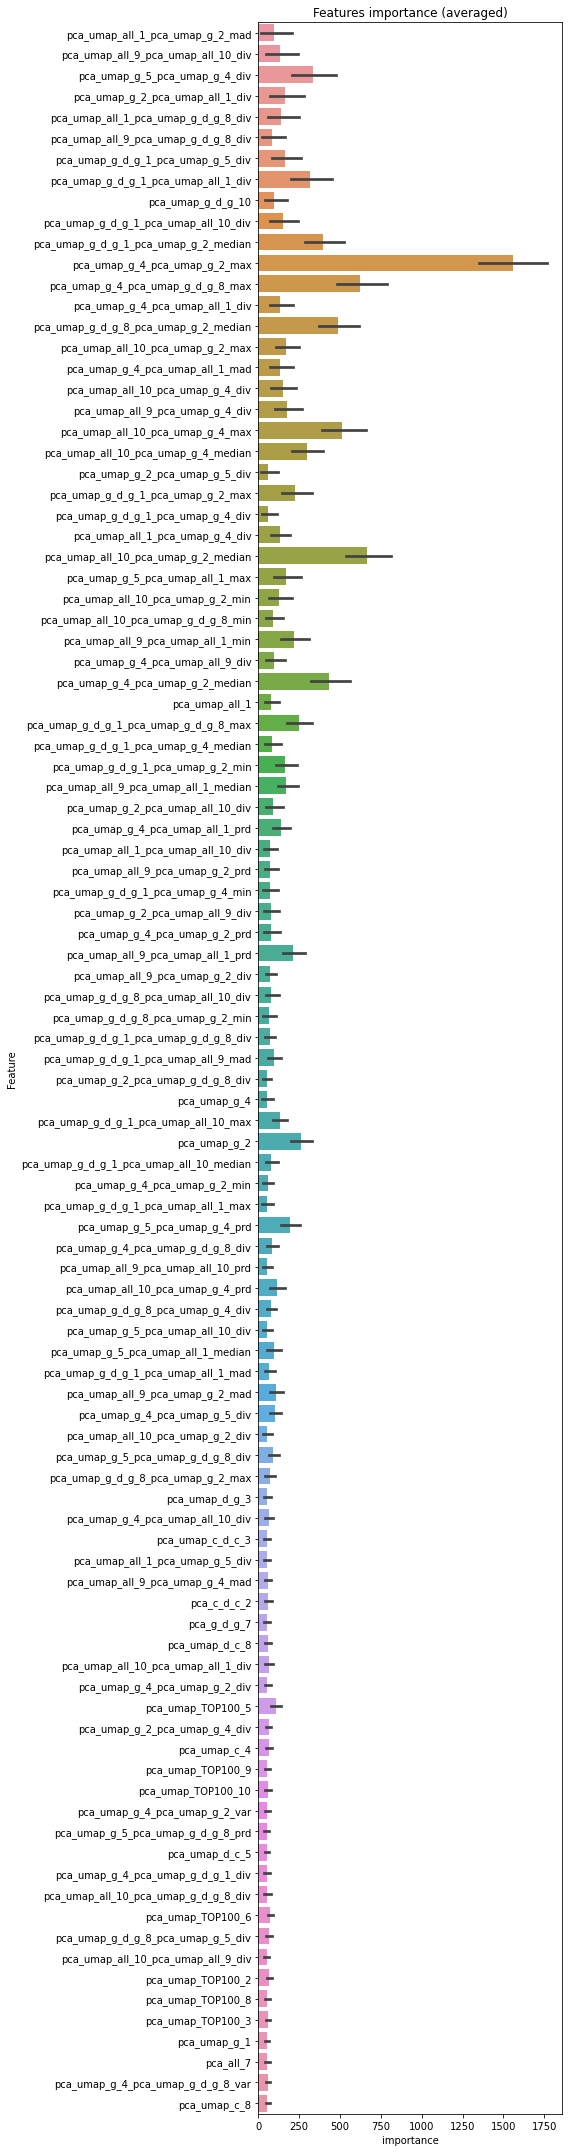

In [57]:
if DEBUG:
    show_feature_importance(feature_importance_df)